In [1]:
import numpy as np
from Bio import Entrez

In [2]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys
sys.path.append(".")

Let's let the nice folks at NCBI know who we are.

In [3]:
Entrez.email = "kt1451@student.uni-lj.si"

# Phylogenetic analysis of coronaviruses

In the first part of the homework, you will conduct a phylogenetic analysis of a handful of coronaviruses. You will look at the similarity between the DNA sequences of these viruses to determine how closely related they are to one another. This might give us some insight into how these viruses might have evolved through time, or from which species SARS-CoV-2 jumped to us, humans.

We will build a phylogenetic tree in two steps. First, we will calculate the distances between each pair of viral genomes. We can't just compare them directly, we have to align them first. So we will run global alignment to get an optimal alignment between each pair of viral genomes. Then, we will calculate the distance between these alignments using Hamming distance. This just checks the number of symbols in the two sequences which do not match. Having calculated all pairwise distances, we can build a dendrogram, which will serve as our phylogenetic tree.

**A note on runtime:** To build a phylogenetic tree, you will need to calculate all pairwise distances between several coronavirus genomes. As you have learned in lectures, computing an alignment between two sequences of length $N$ and $M$ requires forming and calculating a table of $N \cdot M$ entries. This is fine for small sequences, but genomes, even short ones like viral genomes, are generally too long for this. For this reason, we will not calculate pairwise alignments between complete viral genomes in our analysis, but we will focus on the spike protein sequence only. The spike protein is one of the most important parts of any virus, as it is the one that grants the virus entry to host cells. Also, doing so will reduce the sequence lengths from ~30k to around 1.3k, which is much more manageable. Even so, do your best to write fast, efficient Python code, as you will spend a long time waiting for your programs to complete otherwise.

**Speeding things up**: On my laptop, each `global_alignment` call on 1.3k long protein sequences takes around 30 seconds. We have to calculate 210 comparisons, which takes roughly two hours. For those of you who want to speed things up and play around with several parameter settings, you can take advantage of *numba*. *numba* is a Python JIT library, which compiles your code and makes it run faster. We will make *numba* available in the grading environment for this homework. This is not a requirement or even a recommendation, because *numba* can be a pain to work with. However, you are welcome to take advantage of this if you so wish.

In [4]:
accession_codes = {
    # 7 known human coronaviruses
    "Human-SARS-CoV-2": "NC_045512",
    "Human-SARS": "NC_004718",
    "Human-MERS": "NC_019843",
    "Human-HCoV-OC43": "NC_006213",
    "Human-HCoV-229E": "NC_002645",
    "Human-HCoV-NL63": "NC_005831",
    "Human-HCoV-HKU1": "NC_006577",
    
    # Bat
    "Bat-CoV MOP1": "EU420138",
    "Bat-CoV HKU8": "NC_010438",
    "Bat-CoV HKU2": "NC_009988",
    "Bat-CoV HKU5": "NC_009020",
    "Bat-CoV RaTG13": "MN996532",
    "Bat-CoV-ENT": "NC_003045",
    
    # Other animals
    "Hedgehog-CoV 2012-174/GER/2012": "NC_039207",
    "Pangolin-CoV MP789": "MT121216",
    "Rabbit-CoV HKU14": "NC_017083",
    "Duck-CoV isolate DK/GD/27/2014": "NC_048214",
    "Feline infectious peritonitis virus": "NC_002306",  # cat
    "Giraffe-CoV US/OH3/2003": "EF424623",
    "Murine-CoV MHV/BHKR_lab/USA/icA59_L94P/2012": "KF268338",  # mouse
    "Equine-CoV Obihiro12-2": "LC061274",  # horse
}

Here is the list of viruses and their accession codes that we will be working with in this homework. As mentioned in _a note on runtime_, we won't be using the entire sequence to infer phylogenies, but we'll only look at the spike protein. To get spike protein regions from a `SeqRecord` object, we have to inspect the `features` field of each record. Look through the gene coding regions (CDS) of each sequence and find the region that codes for the "S" gene. Some records won't have this field, so look for "spike protein" in the `product` field.

In [5]:
# TODO:
# 1. load sequences
# 2. extract spike protein regions
# 3. convert to amino-acid sequences
import pickle
from os import path
from typing import Tuple, Generator, List

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord


def load(organism_id: str) -> SeqRecord:
    """Load the NCBI record, use cached files if possible."""
    if not path.exists(path.join("data", f"{organism_id}.pkl.gz")):
        with Entrez.efetch(db="nucleotide", rettype="gb", id=organism_id) as handle:
            record = SeqIO.read(handle, "gb")
            with open(path.join("data", f"{organism_id}.pkl.gz"), "wb") as f:
                pickle.dump(record, f)
    else:
        with open(path.join("data", f"{organism_id}.pkl.gz"), "rb") as f:
            record = pickle.load(f)

    return record


In [6]:
acc_vals=accession_codes.values()
#print(acc_vals)
fin_acc_cove_vals_spike={}
for acc_c in acc_vals:
    record=load(acc_c)
    record.features
    for i in record.features:
        #print("new i")
        c=0
        if(i.type=="CDS"):
            #print(i)
            for aa in i.qualifiers.items():
                #print("aa=",aa)
                #print(aa[0])
                #if aa[0]=='note':
                if ("gene" in aa[0] and aa[1][0]=="S") or "spike" in aa[1][0]:    
                    c=1
                    #print(i)
            if c==1:
                for aa in i.qualifiers.items():
                #print("aa=",aa)
                #print(aa[0])
                #if aa[0]=='note':
                    if "translation" in aa[0]:
                        #print("inside  translation")
                        s=aa[1][0]
                        fin_acc_cove_vals_spike[acc_c]=aa[1][0]
#fin_acc_cove_vals_spike


## Problem 1

**TASK:**
Implement the Needleman-Wunsch algorithm you learned about in lectures for global sequence alignment in the `global_alignment` functions in `helper_functions.py`. **[10 points]**

Once you have implemented global sequence alignment, proceed to Problem 2.

In [7]:
from helper_functions import global_alignment

## Problem 2

**TASK:**
Build a phylogenetic tree using the `global_alignment` function you implemented in the previous section. You will first need to calculate distances between all pairs of protein sequences. To calculate the distance between two sequences, first, calculate the global alignment of the two sequences. Then compare these alignments using the Hamming distance. The Hamming distance is just the number of mismatching characters between the two sequences e.g. the Hamming distance between "cat" and "hat" is 1, or 3 between "road" and "rain". Note that this distance is different from the global alignment score produced by `global_alignment`! Once you have calculated all pairwise distances, plot the dendrogram. Apply what you learned about hierarchical clustering in other machine learning courses to get as nice a dendrogram as possible. If you have not taken any machine learning courses, the recommendation is to not use *single linkage*. Save the resulting dendrogram into `problem2.png`. Are the results surprising? Do you see something you didn't expect? Save your answers into the `phylogeny_comments` variable. **[10 points]**

Hint: check out `scipy.spatial.distance.squareform`, `scipy.cluster.hierarchy.linkage`, and `scipy.cluster.hierarchy.dendrogram` to build and plot the dendrogram.

You will also need to define a scoring function for sequence alignment. Use BLOSUM62 throughout this homework. Hint: see `biopython`.

In [8]:
from Bio import pairwise2
from Bio.Align import substitution_matrices
res = {}
blosum62 = substitution_matrices.load("BLOSUM62")


#from numba import jit
def scoring_function_blosum62(x, y):
    dict_blosum = {
    "A": 0,
    "R": 1,
    "N": 2,
    "D":3,   
    "C":4,   
    "Q":5,   
    "E":6,   
    "G":7,   
    "H":8, 
    "I":9,   
    "L":10,   
    "K":11,   
    "M":12,   
    "F":13,   
    "P":14,
    "S":15,   
    "T":16,   
    "W":17,   
    "Y":18,   
    "V":19,   
    "B":20,
    "Z":21,   
    "X":22,   
    "-":23,
    #"*":23,                
    }
    if x+y in res:
        return res[x+y]
    elif y+x in res:
        return res[y+x]
            
    res[x+y] = blosum62[dict_blosum[x]][dict_blosum[y]]
    return res[x+y]
#print(scoring_function_blosum62("H","-"))


#print(blosum62)
#bloadj=blosum62.copy()
#print(bloadj[0][0])

In [9]:
list_vals_spike=[]
for i in fin_acc_cove_vals_spike:
    list_vals_spike.append([i,fin_acc_cove_vals_spike[i]])

In [10]:
#takes 1h and 30mins
list_total_data=[]
for i in range(20):
    for j in range((i+1),21):
        kk=global_alignment(list_vals_spike[i][1],list_vals_spike[j][1],scoring_function_blosum62)
        list_total_data.append([i,j,list_vals_spike[i][0],list_vals_spike[j][0],list_vals_spike[i][1],list_vals_spike[j][1],kk[0],kk[1],kk[2]])
list_total_data

KeyboardInterrupt: 

In [11]:
result_with_global_alignment=[[0, 1, 'NC_045512', 'NC_004718', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFVFLVLLPLVS-SQCVNLTTRTQL-PPAYT-N-SFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTI-----NHT--FGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAV--SK-PMG-TQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILT---AF-SPA-QDI-WGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCT-PPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHT-V-S--LLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 5246.0], [0, 2, 'NC_045512', 'NC_019843', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MF--VF-LV-LL-P----L-V---S--SQC--VNL--T--TRTQLP-PAYTNSFTRGVYYPD-KVFRSSVLHSTQDLFLPF---FSNVTWFHAIHVSGTNGTKRF-DN---PVLPFNDG-VY-F-ASTEKS-NIIRGWIFGTTLDSKT-QSLLIVNNATNVVI-KVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYS--SANNC-T-FEYVS-QPF-LMDLEGKQGNF-KN--LREF-VFKNI-DGYFKIYSKH-T--PI-N-L-VRDLPQGFSALEP-LVDLPIGINITRFQTL-L-ALHRSY-LTP-G-DS-SSGWTAGAAAYYVGY-LQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIV-RFPNITNLCPFGEVFNATRFASVYAWNRKR-I-SNCVADYSVLYNSAS-FS-T-FKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLP-DDFTGC-VIAWNSNNLDSKVGGNYNYLYRLFRK-SNLKPFER-DISTEIYQAGS-TPC-N---G-V-E-G--FNCYF-PLQSYGFQPTNGVGYQPYRVVVLSFEL-L-HAPAT--VCGPK-K--S-TNLV-K-NKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRD-IADTTDAVRDPQTLEILDITPC-SFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAI-HADQLTPTW--RVYST-GSNVFQTRAGCLIGAEHVNNS-Y-E-CDIPIGAGICASYQT-QTNSPRRARSVASQ-SI--IAYTMSLGA-E-NSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGG-FNFSQIL-P-DPSKPSK--RSFIEDLLFNKVTLADAGFIKQYGDCL--GDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTITS-GWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRA-SANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHD-GK-AH-F-PREGVFV-SNGT----HWFVTQRNFYEPQIITTDNT-FVSGNCDVVIGIVNNTVYDP-L-QPE-LDSFKEELDKYFKN-HTS-PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVM-VTIMLCCMTSC-CSCLKGCCSCGSCC-KFDEDDSEPVLKGVKLHYT', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKT-WPRPIDV-SKADGIIYPQGRTY-SNITITYQGLF-PYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATI-RKIYPAFMLGSSVGNFSDGKMGRF-F-NHT-L-VLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTF-MYTYNITEDEILEWFGITQTAQGVHLFSSRYVDL-YGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAW-AAFYV-YKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGV-E-CDFSPLLSGTP-PQVY--NFKRLVFTNC--NYN-LTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPT-CLILATVPHNL-TTITKPLKYSY-I-NKCSRLLSDDRTEV-PQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVC-PKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCL--RACVSV-PVSVIY-DKETKTH-ATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGP-L-QTPVGCVLGL--VNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNS-SYF--KLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLT-LLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLM-DVNMEAAYTSSLL-GSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVR-SESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLC-DAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQV-TYQNISTN-LPPPLLGNSTGID-FQDELDEFFKNVSTSIP--NFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCC-TGCGTNCM-GKLKCNRCCDRYEEYDLEP-HK-VHVH--', 1739.0], [0, 3, 'NC_045512', 'NC_006213', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MF-VFLVLLP----LVSS-QCV--NLTTR-TQLPPAYTNS--FTRGV--YYP-DKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKR--FDNPVL-PFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNK-SWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNID-GYFK-IYSKH-T-PIN---LVRDLPQ-GFSALEPLVDLPIGINITR--FQT-L-LAL-HRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIV-RFPNITNLCPFGEVF-NATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVI-RGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWN--SNNLD-SKVG-GNYNYLYRLFRKSNLKPFERDIST--E-IYQAGSTPC-NGVEGFNCYFPLQ-S-YGFQP--TNGVGYQPYRVVVLSFE-LLHA-PATVCGP-K-KST-NLVK-NK-C----VNFNF---NGLT--GTGVL--T-ES---NKKFLPFQQF-GRDI-AD-T--TDAVRDPQT-LEILDI-TPCS-FG--GVSV-I-TPGT--NT-SNQV--A--VLY--QD-V-N-------C-T-EVPVAIHADQLTPT--WR-V---Y----S-T-G-S--NVFQTRAGCLIGAEHVNN-SYE-CDIPIGAGICASYQTQTNSPRRAR-SVAS-QSIIAY-TMSLGAEN-SV-AYSN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVE-QDKNTQ-EVF-AQVKQIYKTPPIKD---FG--GFNFSQI---L-PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDG-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGF-IAGLIAIVMVTIMLCCMTSC-CSCLKGCCSCGSCCKFDEDD-SEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLF-LNG-YYP-TSGST-YRNMALKGSVLLSRLWFKPPFLSDFINGI-FAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQD---G-----DNKLQGL-LEVSV-CQYNMC--EY-PQT-I--CHPNLGNHR--KE-LW-HLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTD--TGV-VTKFLFNVYLGMALSH-YYVMPLTCNSKLT---LEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPN-CNI-EAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKV-DLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVY-A-Q-HCFKAPKNF-CPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTD-LQKANTDI-ILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDY-SK-N--RRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVN-ELLD-TTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWT--A-AA-GVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNT-WMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSL-DY--INVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAG-VAMLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGYQELVIK-TS-HDD', 1617.0], [0, 4, 'NC_045512', 'NC_002645', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MFVFLVLLPLVS-SQCVNLTTRTQLPPAYTNSFTRG-VYYPDKVFRSSVLHSTQDLFLPF-FS-NVTWFHAIHVSG-TNGTKR-FDNPVLPFNDGVYFASTEKSNIIRGWI-F-GTTL-DSKTQSLLIVNNATNVVIKVCEFQFCNDPF-LGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGK-QGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHR-SY-LTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFP-NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPL-QSYGFQPTNGVGYQPYRVVVLSFE-LLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYEC-D-I-PIGA-GICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIA-VEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPD-PSKPSK---RSFIEDLLFNK-VTLADAGFI-KQYGDCL-GDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSA---I-----G-K--I-QDS--LSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDG-KAHFPRE-GV-FVSNGTHWFVTQRNFYEPQIITTDNTFVS-GNCDVV-IGIVNNTVYDPLQPE-LDSFK--EELDKY-FKNHTSPD--VD-LGD-ISGINASVVNIQ-K--E----IDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGC-C-SCGSCCKFDEDDSEPVLKGV-KLHYT', 'MFVLLVAYALLHIAGC-Q-TT-NGLNTSY--SVCNGCVGYSENVF--AV-ES-GG-YIPSDFAFN-NWFLLTNTSSVVDGVVRSF-QPLL-LN-CLW--SVSGLRFTTGFVYFNGTGRGDCKGFS-SDV--LSD-VIRY-NLNF-EENLRRGTILFK-T-SYGVVVF--YCT-NN-TL--VSGDAHIPF-GTVLGNF-YC--FVNTTI-GN-ETTSAFVGA-LPKTVRE-F-VIS-RTG-HFYINGYRYFTLGNVEAVNFNVTTAETTDFCTV-ALA---SYAD--V-LVNVSQT-SIANIIYCN-SVINRLRCDQLSFDVPDGFYSTS-----PIQS-VELPVSIVSL-P---VYHKHTFIVLY----------V-DFKP--QSGGGKCFNCY---PAGVN-ITLAN-F-NE-T-KG-PL-CV---DTSHFTT-KY-VA-VYAN-VGRW-SASINT---GNCP--FS-FGKVN-N-FVK-FGSVCFSLKDIP--G--G--CAMPIVANWAYSKYYTIG-SLY-VSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFL---N-G--IT-YT-ST-SGNLLGFKDVT--K-GTIYSITP-CNPPDQL-VVYQ--Q-A-V-VG--A-MLSENFTSYGF-SNVVEL-PK-FFYAS--NGTYNCTDAVLTYSSFGVCADGSIIAVQP---RNV---S---YD-SVSA--IVT-A-N-LSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLE-SADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVT-SGLGTVDADYKKCTKG-LSIADLACAQYYNGIMVLPG-VADAERMAMYTGSLIGG-IALG---GLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMAD-FVQIENCNVTFVNI-SRSELQTIVPEYIDVNKTLQEL-SYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFF-SCFASSIRGCC---ESTKLPYY-DVEKIHIQ', 1101.0], [0, 5, 'NC_045512', 'NC_005831', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MFVFLV-L-LPLVSS--QC-VNLT-TRTQL-PPAYTNSFTRGVYYPDKVF---RSSVLHSTQDLF-LPF--F-S--NV-T-WFHA----IHV-S--GTN-G-T-K--RFD-NPVLPF--N-----DG-VYFASTEKSNIIRG-WIFG-TT-LD--SKTQSLLI--VNNATNVVIKVCEFQF-CNDPFLGVYYHKN-NKSWMESEFRV-YSSANNCTFEYVSQPFLMDLEGKQGN-FK-NLREFVFKN----IDGYFKIYSKHTPINLVRDL-P-QGFSALEPLVDL-PIG--INITRFQ--TLLALHRSY-LT-PGDSSSGWTAGAAAYYVGYLQ-PRTFLLKYNENGTITDAVDCALDPLSET-KCTLKSFTVEKGIYQTSNF-RV-QPT--ESIV-RFPNI-TN-LCPF--G--E-V-FNATRFASVY-AWNRKRISNCVADYSVLYN-SA-SFSTFKCYGVSP-TKLN-D-LCF--TN-VYADSFVIRGDEV-RQ--IA-PGQTGKIADYNYKLPDDFTG-CVIAWNSNNLDSKVGGNYNYLYRL--F--RK-SN-LKP-FERDISTEIY-QAGSTP-----CNGVEGF-N-CYFPLQ---SYGFQPTNGV-GYQPYRVV-VL--SF-E---LLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPI-GAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIA-VE-QDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPS-KPSK---RSFIEDLLFNKVTLADAGFIK-QYGDCL-GDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKI-------QDSLSST--A----S-ALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDG-KAHFPRE-G-VFVS-NGTHWFVTQRNFYEPQI-ITTDNTFVS-GNCDVV-IGI--VN-NTV---Y-DPLQPELDSFKEELDKYFK-N-HTSP-D---VDL-GDISGINASVVNI-QKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIML-CCM-TSCCSCLKGC--CSCGSCCKFDEDDSE-PVLKGVKLHYT', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGL-LPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVK-CYFNYSC--VFSVVNATVTVNVTTHNGRV-VNYTVCDDCN-GYTDNIFSVQQDGRIPNGFPFN-NWFLLTNGSTLVDGVSRLY-Q--PLRLT-CLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMR-YNLNFSANSLDNLKSGVIVFKT--LQYDVLFYCSNSSSG-VLDTT-IPFGPSSQPYYCFINS-TINT-TH-VSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTT-ASATDFWT-VAFATFV-D--VLVNVSATNIQNL-LYCDSPFEKLQCEHLQFGLQDGFYSANF-L-DDNVLPETYVALPIYY-QHTDINFTATASFGGSCYVC-KPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNF-PLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQS-L---A-G-GI---T-YVSNSGNL--LGFKNVSTGNIFIVTP-CNQPDQVAV-YQQ-S-I-IG-AMTA--VNES-R-YGL-QNLLQLPNFYYV-SNGGNNCTTAVMTYSNFGICAD-GS-L-IPVRPRN-SSDN--G--IS--A--IIT-A-N-LSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTF-D-SNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKG-LSIADLACAQYYNGIMVLPG-VADAERMAMYTGSLIGGMVLGGLT-SA-AA--IPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGV-FRVTSRVMFQPRLPVLSD--FVQIYNCNVTFVNISRVELHTVIPDYVD-VNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVE-LQGLIDQINSTYVDLKLLNRFENYIKWPWWVWL-IIS-VVFVVLLSLLVFCCLSTGCCGCC-NCLTSSMRGCC--DCGSTKLPYYEFEKVHVQ', 1158.0], [0, 6, 'NC_045512', 'NC_006577', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MFVFLVLLP--L-V-SS-QCVN--LT-TRTQLPP-A-Y-TN-SFTRGVYY-PDKVF-RSSVLHSTQDLFLPFFSNVTWFHAIHVSGTN--GTKRFDNPVL-PFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLI--V--NNATNVVIK----VCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDG-YFKIYSKH-TPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTP-G-DS-SSGWTAG-AAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESI-VRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVR-QIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYN-YLY--RL-FRKSNLKPFERDISTEIYQAGST--PCNGVEGF--NC--YF-PLQS--YG--F---QPTNGVGYQPY-RVVVLSFEL-LHAPATVCGPKKS---T--N---L-V-KNKC-V-NFNFN-G-L--T-G-TG-VL-T-ESNKKFLPFQQF-GRDI-ADTT---DAVRDPQTLEIL-DI-TPCS-FG--GVSVI--TPGT--NT-SNQV--A---VL-YQD-V-NCT-EV-P-----V--AIH--ADQLTPTWR-V---Y-----S-TGSNVFQTRAGCLIGAEHVNN-SY-ECDIPIGAGICASYQT-QTNSPRR-ARSV-ASQSIIAY-TMSLGAEN-SV-AYSN-NSIAIPTNFTISV-TTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGI-AVEQDKNTQ-EVFAQ-VKQ-I-YKT---PPIK-DFGGFNF-SQI--L-PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHF-PREGVFVSNGTHWFVTQRNFYEPQIITTDN-TFVSGNCDVVIGIVNNTVY-DPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIA-GLIAIVMVTI-MLCCMTSCCSCLKGCCS-CGSCCKFDE-DDSEP-VLKGVKLHYT', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILF-T-GYF-P-KSGAN-FRDLSLKGTTYLSTLWYQKPFLSDFNNGI-F-SRVK-N-TKLYV-NKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYT-MCEYPHTICKS-KGSS-R-NESW-H--FD-KSEP-LC-L-FKK-NF-TY-N-V--STDWLYFHFYQERGTFYAYYAD--SG---M-P-TTF-L-FSL-YLGTLLS-H-YYVLPLTCNAISSN-TDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPD-CDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSR-RSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTI-NNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPC-AKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRS-CSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQ-PNT-EVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTI-VGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGL-LD-TTQLHV-ADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGS-SSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWS--A-AA-GIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMN-TCSVNF-TKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTL-NLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWL-LISFSFI-IFLVLLFFICCCTGCGS---ACFSKCHNCC--DEYGGHHDFVIK-TS-HDD', 1544.0], [0, 7, 'NC_045512', 'EU420138', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'M-FVF-LVL-LPLVSSQ--C-V--NL-TTRTQLP-PA-YTNSFTRGVYYPDKVFRSSVLHSTQDLFLPF-FSNVTW-FHAIHVSGTN-GTKRFDNPV--LPFND--GVYF--ASTEKSNIIR--GW--IF--G-T-TLDSKTQSLLIVN-N-ATNVVIK--VCE-F--QFCND--P-F-L-GV--YYHKN-NKSWMESEFR-VYSSANNCTFEYVSQPF--LM----D-L-EG-K--QG-N-F-K---NLRE--FVFKN--IDGYFKIYSKHTPIN-LVRDL-PQGFSAL-E-P-LV-D-LPIGINITRFQTLLALHRSYLTPG--DS-S-S-GWTAGAAAYYVGYLQPRTFLLKYN-E--NGTITDAVDCALDP---LSETK-CTLKSFT-VEKGIYQTSNF-RVQPTESIVRFPNITNLCPF---G-EVFNATRFAS-VY--AWNRKR-I-SNCVADYS-VL--YNSASF-STFKCYG-VSPTKLNDLCFT--N-VYADSFVIRGDEV-RQIAPGQTGK-IA-DY-NYKLPDDF-TGCVIAWNSNNL-D-SKVG-GNY-NY-L-YRLF-RKSNLKPFERDISTEI-YQAGSTPC-NGVEGFNCYFPLQSYGF--QPTNG-----V--GY-QPY-RV-VV-LSF---E-LLHAPA-TV--CGPKKSTNLVK-NKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLT-P-TWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTK-TSVDCTMYICGDSTECSNLLLQYGSFCTQLNRAL-TGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGG-FNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFI-KQYGDCLGDIA-A-RDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSA---I-----G--K-IQDSL-S-STAS-ALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVP-A-QEKNFTTAPAICHDGKA-HF-PREGV-FVSNGT-HWFVTQRNFYEPQI-ITTDNTFVS-GNCDVVIGIVNNTVYD-P-LQPE-LDSFKEELDKYFKNHTSPD-VDLG-DISGINASVVNI--Q-KEI----DRLNEVA-K-NL-----NESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIML-CCMTSCCSCLKGCCSC-GSCCKFDEDDSEPVLK-GV-KLHYT', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSG-YLPSP---DS-WNCTQN---PVGVANITYNAKAVFISYYKFG-REVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKD-CVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVS-FRCVY-K-ETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDN-QIIRKGVISVFTSTNVYNFSCTNNSVLDG-D-AVIPFGDVAQTHYCFIKYFTNITSG-ESVSQFVGILPPQ-VKEFVIMRN-GDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTF-DSADNLPRTIV--RLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSA-FSTAVDIQAG-T-CLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSD-VKLNVCTTFTIYGHTGRGIINKSNNTFVS-GLFYTSVTGNLLGFKNSTTGEIFSISPC-----Q-L---T-T--QVAAV-SD-K-I-VGVAAATKEVTLPFDTHV-SLGSFYYHYK-NS--NAELCKNP-SL-MYGGLGVC-----E-DG-RLV-NI-SRS--EDTF-V--PSAV-ISGN-ITIPANFSFVVQPEYIQI-MTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTL-KLGVASNFNDTFDLTLALPRQHQ-S-RSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAA-LTGAMVLG---GVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVS-AFA-GVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSAD--FVEVSSCNVTF-I-NLTINELPELLPDYID-VNKTL-KEFA-ATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLA-IA-VTLIILVGPMLWCCLATGC-C--GCCSCLVNSCS-D-CGGRRLQRYEIEKVHVQ', 1087.0], [0, 8, 'NC_045512', 'NC_010438', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MFVFLV--LLPLVSSQCVN--LTTRTQLPPA-Y-TNSFTRG-VY-YPDKV-F--RSSVLHSTQDLFLPFFSN-V-TWFH-A-IHV-SGTNGT-KRFDNPVLPFNDGV-YFASTEK-S-NII-R-G-WIFGTTLDSKTQS-LLIVNNATNVVIKVCEFQFCNDPFLGVYY--HK-NNKSWMESEFRVYSSANNCTFEYVSQPFLMD-LEGK-QGNFKNLREFVFKNIDGYFKIYSKHTPIN--LVRDLPQGFSA-LEPLVD--L-PIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYY-V-GYLQPRTFL-LK--Y-N-E-NGTITD-AVDCALD-PLSET-KCTLK-S-FTV--EKGI-YQ---TSNFRVQPTESIVRFPNITN-L-CPFGEVFNATR-FASVY-AWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCF--TNVYA-DSFVIRGDEVRQI-APGQTGKIADYNYKLPDDFT--GC-VIAWN-SNNLDSKVGGNYNY-LYRLFRKSNL-KPFERD-ISTEIYQAGSTPCNGVEGFNCYFPLQSY-GF-Q-PTNGV-GYQPYRVV-V-LS-F--EL-L--HA-----PATV----CGP-K-KS-TN-LVKNK-CVNFNFNG-L-TG-T-GVLTESNKKFLP-FQQF-GRDIADTTDAVRDPQT-L--E-IL--DI-TPCS-FG--GVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYS-TGSNVFQTR--A-GCLIGAEHVNNSYECDIPIGAGI-CAS--YQTQ-TNS---PRRA-RS--VASQSIIAYTMS--LGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRAL-TGIAVEQ-DKNTQEVFAQVKQIYKTPPIKDFGG-FNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFI-KQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKI--Q-D----SL---S-S--T-ASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPRE-G--VFVSNGTHWFVTQRNFYEPQIITT-DNTFVSGNCDVV-IGIVNNTVYDP-LQPE-LDSFK--EELDKYFKNHTSPDVDLGDI-S-G-INASV-VN-IQ-K--EI----DRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVT-IML-CCMTSCCSCLKGCCSC-GSCCKFDEDDSEPVLK-GV-KLHYT', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAI-VT-G-YLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLV-LRI-CKWQNGTLAAPTLQSTSGKDCIVNVKVDNHM-FYHAAHDIVGMSWSGDAVRLYTQTDTKTY-YI--PNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGT-IDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNW-FLLT-NSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFE-ALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEA-VIDSGIPFGNVVEPFYC-FVSI-NGTSIFVGMLPAVLRE-I--VITRYGSIYLN-GFSIFQ--G--P-PIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLY-CDDPLSQLKCQQLQFSLPDGFYA-TASLFQHELPRTF-VT-LPRHFTHSWINLRI-K-WK---NGV-CYNCP-PASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDC-PFDFQSLNNYLTFGSIC--FSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRP-ANIS-YIAGVYYTAASGQL-LGF-KN--TTTGEVFSVTPCNPSQQAVVVKDRLVGV--MSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSET-AL-DLVNISTFGGDYNLTALLPQ-G-GGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGG-MTMG-GFTPVAAL--PFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNT-FYITPRNMYQPRTPTSADFIRISG-CNVVYVNITDEQL--PQVQPEFIDVNKTLEELMSRLPNNTGPNLPL-DIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMI---IALVLLTGLMLWCCLATGC-C--GCCSCMASTLDF-R-GSR-LQQYEVEKVHIQ', 1153.0], [0, 9, 'NC_045512', 'NC_009988', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSF-T-RGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPV-LPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNK--SWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLT-PGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDP-LSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYG-FQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVK-NKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTL-EILDITPCSF-GGVSVITPGTNTSNQVAVLYQDVNCTEVPV-AIH-ADQLTPTWRVYSTGSNVFQTRAGCLIGAEHV-NNS-YECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGD-STECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQV-KQIYKTPPIKDFGGFNFSQ-ILPD-PSKPSK---RSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYEN-QKLIANQFN--SA-IGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLN-DILS-RLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICH-D--G-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTF-VSGNCDVVIGIVNNTVYDPLQPELDS-F--KEELDKYFKNHTSPDVD-LGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVT-IML-CCM-TSCCS-CLKGC--CSCGSCCKFDEDDSEPVLKGV-KLHYT', 'MKLFIVFV-LLFRVCY-CCDYVDF-RLFNGIFSTSRGL---SNT--TTVI--T-GAY-PSTNKAKWF-C---P-TN-VGR---PVGTGVGIGVY-AQTAQASYETG---GSGAGGYTFS-VSPKHVTN--L-TWSL-WVHRPW-GANANVTVRLCRWWQ-KF----SFNE-TAHF--QP-----AGPSSAFECL---V--N--GSFP-SSQHKGY-MF-GV-TWYNDFVRII-FP-P-TVFELQ-LDGLQWEYVQFTGPVNAG--R-MTKFNV-VTEISSVLVLTDQSGAVTRYSYCA-DGFVNGLQCKLRLFDIPPGVY--SN-----SE--VEYP-VA-L--YTVVHN---M-SVCP-QRPE-SYCGSNYCP-FKRVVFS--NC--V----VN---YTS-WT-SGLLR-DYQHLVLP--NGK---FN---P--FTEC-NGLN-RIVDDCVTG-F-VL-RVGR-GT--AVNRTVITP-Y-L-K-P-N--E---C-FG-WSWNDYQ--DSI-YD-W-WIA-DF--VSTGAFVC--EKNPDAPRTGVCITYTIEKVTFQGVLYESN--F-TFAQY-YNVLYFGSQLKYVRILGKVYEVAPC-FEASYDVL---FRSSSSFGLLYRSFDCNQLRISASRFAERLLPS---HN-GT-A--TALGCLFNATYAPNDTMVNCTNPLGDGFCADL-L-SNVVVR-RMTFEKHDTTY-VA-PVTNE-RFT--E--LPLDHQLVLTEQFLQTTMPKFSISCETYIC-DVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTD--RFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKN-AIQDLTCAQYHNGILVIPPVM-DAETLGMY-GGIAAASLTLG-IFGGQAGI-TTWSLAMAGRLNALGVVQNALVDDVNKL-ANGFNQLTASVGKL--AL-TTSSALQAIQAVVNQNAAQVESLVSGITENFGAIST--NFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTT-L-NRT-FD-I-PELNSTFPIDEEFREYFQNMSS-ELQALKNLTA-DMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWL-II--FIALTLLAGLMLWCCLATGCCGMC--GCLAATCASCC--DCRGTKLQSYEIEKIHIQ', 1091.0], [0, 10, 'NC_045512', 'NC_009020', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MFVFLVLLPLVSSQCV-NLTTRTQ-LPPAY--TNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSG---TNGTKRFDNPVLP-FND-G-VY-FASTEKS-NIIRG-WI--FGTTLDSKTQSLLI-VN---NAT-NVVIKVCEFQ-FCN-DP-F-LG--V-YYHKNNKSWMESEFRVYSSANNC-T-FE--Y-VSQP-FLMDLEGKQGNFKNLR--EFVFKN-IDG-Y--------FKIY-SK-H-T-PIN--LVRD-LPQGFSALEPL--VDL-PI-GINITR---FQ-TLLALHRS--YLT--PGDSSSGWT-AGA-AAYYVGY-LQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKR-I-SNCVADYSVLYNSAS-F--STFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTG--C-VIAWNSNNLDS-KVGGNYNYLYRLFRKSNLKPFERDISTEIYQA-GS-TPC-N-GVEGFNCYFPLQSYGFQPTNGVGY-QPYR-VVVLSFEL-L-HAPAT--VCGPKKS-TN-L-VKNK---CVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPC-SFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAI-HADQLTPTWRVYS-TGSNVFQTRAGCLIGAEHVNNS--Y-ECDIPIGAGICASYQTQTNS-PRRARSVASQSI-IAYTMSLGAENSVAYSNNS---IAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIK-DFGG-FNFSQI-LPD-PSKPSK-RSFIEDLLFNKVTLADAGFIKQYGDCL--GDIAARDLICAQKFNGLTVLPPLLTDE-MIAQYTSALLAGTIT-SGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRA-AEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICH-DG--KAHFPREGVFVSN---GT------HWFVTQRNFYEPQIITTDNT-FVSGNCDVVIGIVNNTVYDP-LQPELD-SFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVM-VTIMLCCMTSC-CSCLKGCCSCGSCCKFDE-DDSEPVLKGVKLHYT', 'M-IRSVLVLMCSLTFIGNL-TRGQSVDMGHNGTGSCLDSQVQPD-YF-ESV-HTTWP--MPIDTSKA-EGVIYPNGKSYSNITLTYTG-LYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAG-ETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYI-YKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIE-QATTQECDFTPMLTGTP-PPIY--NFKRLVFTNC--NYN-LTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYK--QDFSNPTCRVLATVPQNLTTITKPSNYAYLTECY-KTS--AYGKNY---LYNAPGAYTPCLSLASRGFSTKYQSHSDG-ELTT-TGYIYPVTGNLQMAFIISVQYGTDTNSVC-PMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNG-NYYCVRPCVSV-PVSVIY--DKASNSHATLFGSVACSHVTTMMSQFSRMTKT-NLLARTTPGPLQTTVGCAMG--FINSSMVVDECQLPLGQSLCAIPPT-TSSRVRRATSGASDVFQIA-TLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIK-TQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLY-DPYMEAAYTSSLL-GSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAAR-SAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVS--MDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCC-TGCGTSCL-GKLKCNRCC--DSYDEYE-V-E--KIHVH', 1797.0], [0, 11, 'NC_045512', 'MN996532', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNS----RSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 6539.0], [0, 12, 'NC_045512', 'NC_003045', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MF-VFLVLLP----LVSS-QC--VNLT-TRTQLPPAYTNS--FTRGV--YYP-DKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGT--NGTKRFDNPVL-PFNDGVYFASTEKSNIIR-GWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSAN-NCTFEYVSQPFLMDLEGKQG-NFKNLREFVFK-NIDG-YFKIYSK-HTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKC-TLKSFTVEKGIYQTSNFRVQPTESIV-RFPNITNLCPFGEVF-NATRFASVYAWNRKRISNCVADYSVLYN-SASFSTFKCYGVSPTKLNDLCFTNVYADSFVI-RGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWN--SNNLD-SKVG-GNYNYLYRLFRKSNLKPFERDIST--E-IY-Q-A--GST---PCNGVEGFNCY--FP-LQSYGFQPTNGVGYQP----YRVV--VLSFE-LLHA-PAT--VCGP-K-KSTN-LVK-NK-CVNFNF-NGLTGTGVLTESNKKFLPF--QQ-F-G-R-DI-AD-TT-DAVRD--P-QT-LE-I-LD-IT-PC-S---FG--GVSV-I-TPGT--NT-SNQV--A--VLY--QD-V-N-------C-T-EVPVAIHADQLTPT--WR-V---Y---ST-G---S--NVFQTRAGCLIGAEHVNNS-YE-CDIPIGAGICASYQTQTNSPRRARSVASQ--SIIAYTMSLGAENSV-AYSN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVE-QDKNTQ-EVF-AQVKQIYKTPPIKD---FG--GFNFSQI---L-PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDG-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIW-L-GFIAGLIAIVMVTIMLCCMTSC-CSCLKGCCSCGSCCKFD-EDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTL-LLNG-YYP-TSGST-YRNMALKGTLLLSTLWFKPPFLSDFTNGI-FAKVKNTKVIKDGVMY-SEFPAITIGSTFVNTSYSVVVQP-HTTILGNKLQG-FLEISVCQYTMCEY-PNTICNPNLGNQRV-ELWHWD-TGVVSCLYK--RNFTYDVNADYLYFHFYQEGGTFYAYFTD--TG---V--VTKF-L-FNV-YLGTVLS-H-YYVMPLTCNSALT---LEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTL-SIAPSTGVYELNGYTVQPIADVYRRIPNLPD-CNI-EAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYS-FTCNNIDAAKIYGMCFSSITIDKFAIPNGRKV-DLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCK-LDGSLCVGNGPGIDA-GYK-TSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHD-VNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRS-RRSITTGYRFTNFEPFTVN-SVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVN-ELLD-TTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWS--A-AA-GVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNT-WMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSL-DY--INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGF-AG-VAMLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGHQELVIK-TS-HED', 1629.0], [0, 13, 'NC_045512', 'NC_039207', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'MF--V-FLV-LLPLV--S-SQ--CVNLTTR-TQ-LPP-AY-TN-SFTRGVYYP-DKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRF-DNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNV-VI-KV--C-EF-----QF-CNDPFLGVYY-HK----NNK--SWMESEFRVYSSAN--NCT-FE-YVSQP-F-LMDLEG-KQGNFKN-LREFVFKNI-DGYF-KIY--S--KHTP-INLVRDLPQGFSALEPLVDLPIGINITRFQTLLALH-R-SYLT--PGD-SSSGWTA-GA-AAYYVGY-LQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVF-N-ATRFASVYAWNRKRI-SNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQ-IAPGQTGKIADYNYKLPDDFTG--CVI-AWNSNNLDSKVG--GNYNYLYRLFR-KS-NLKP--FERDISTEI-YQAG--STPCNGVEGFNCY-FPLQS-Y-G---FQP-TN-G-VGYQPYRVVVLSFELLHAPATVCGP-K----KSTNL--VKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRD-IADTTDAVRDPQ-TLEILDITPC-SFGGVSVITPGTNTSNQV-AVLYQDVNCTEV-PVA-IHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYE-CDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLG-AENSVAYSNN-SIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPI-KDF-GGFNFSQI-LPD-PS-KPSKRSFIEDLLFNKVTLADAGFIKQYGDCL--GDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTIT-SGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRA-AEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQE-KNFTTAPAIC--HDGKAHFPREGVFVSN-G-T-HWFVTQRNFYEPQIITTDNT-FVSGNCDVVIGIVNNTVYDP-LQPELD-SFKEELDKYFKNHTSPDV-DLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVM-VTIMLCCMTSC-CSCLKGCCSCGSCC-KFDEDDSEPVLKGVKLHYT', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTY-SNITITLEGLF-PHQADRGDMY-VYSQSHKG-RPFISNYSLVTND---FGN---GIVIR--I-GSAA-NKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNK-TGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQW-F-NIKDCLFEKNYNVTDDEREEWFGIIQD-QQGVHLYTSRKN-GYSNNMFLFAT-LPIYDQILYYTVMPRSINASNYASYHAFSAFYI-YKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTE-CDLDVLFKNDAPIIAN-Y--SR-RVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFAL-PFSMKSTLAIGSAEAISMFNYN--QDYSNPTCRIHAAVTANVSTALNFTANANYAY-ISRCQGVDGKPILLQPGQMTNIACRSGVLARP-SDADYFG-YSFQGRNYYLGRKSYKPKTDEGDV-QMVY-VITPKYD--KGPDTVC-PLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNII-GFHSKNGTY-YC-MAPCVSV-PVSVI---YDKSSDVHATLYSSVECNHIKSVATVFSRQ-TES-KLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAK-PPSFSS--RSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIK-VPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLY-DANMEAMYT-ASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAAR-SSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHP-QDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEF-TFQNLTNN-LPPPLLSNNSDVTFEDELEEFYKNITS-EIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCC-TGCGTSCL-GKINCTRCCDKYDDFDM-PE-K-IHIH--', 1694.0], [0, 14, 'NC_045512', 'MT121216', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'M-FVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGT-KRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFL-GVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYAL-TK-TNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSG-YYH-NNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRG--DP-MPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNS----RSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 6085.0], [0, 15, 'NC_045512', 'NC_017083', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MF-VFLVLLP----LVSS-QC--VNLT-TRTQLPPAYTNS--FTRGV--YYP-DKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGT--NGTKRFDNPVL-PFNDGVYFASTEKSNIIR-GWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWM-ESEFRV-YSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFK-NIDG-YFKIYSK-HTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIV-RFPNITNLCPFGEVF-NATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVI-RGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWN--SNNLD-SKVG-GNYNYLYRLFRKSNLK--P---F-ERD-I-STEIYQAGST--PCNGVEGFNCY-F-P-LQSYGFQPTN-G---VG--YQP-YRVVVLSFELLHAP--ATVCGP-K-KSTN-LV-KNK-CVNFNF-NGLTGTGVLTESNKKFLPF--QQ-F-G-R-DI-AD-TTDAVRD--P-QT-LE-I-LD-IT-PC-SFG--GVS---V-I-TPGT--NT-SNQV--A--VLY--QD-V-N-------C-T-EVPVAIHADQLTPT--WR-V---Y---ST-G---S--NVFQTRAGCLIGAEH-VNNSYE-CDIPIGAGICASYQTQTNSPRRARSVASQSIIAY-TMSLGAEN-SV-AYSN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVE-QDKNTQ-EVF-AQVKQIYKTPPIKD---FG--GFNFSQI---L-PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDG-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIW-L-GFIAGLIAIVMVTIMLCCMTSC-CSCLKGCCSCGSCCKFD-EDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTL-LLNG-YYP-ISGST-FRNMALKGTLLLSTLWFKPPFLSDFNNGI-FAKVKNTKVIKNGVMY-SEFPAITIGSTFVNTSYSVVVQP-HTTI-SDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIE-LWH-F--DTDVVSCLYK--RNFTYDVNADFLYFHFYQEGGTFYAYFTD--TGF-VTK-F--L---FNV-YLGTVLS-H-YYVMPLTCDS--TL-SLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPD-CNI-EAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKV-DLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCK-LDGSLCVGSGSGVDA-GFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRS-RRAITTGYR-FTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVN-ELLD-TTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWT--A-AA-GVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNT-WMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSL-DY--INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIG-LAG-VAVLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGHQELVIK-TS-HDD', 1653.0], [0, 16, 'NC_045512', 'NC_048214', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFC-NDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLL-ALHRS-YLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALD-P-LSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPF-GEV-FNATRFASVYAWN-RKRISNCVADYSVLYN----SASFST-FKCYGVSPTKLN-D-LCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYL-YRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGY-QP--YRVVVLSFELLHAPATVCG-PKKSTNLVKNKCVNFNFNGLTGTG-VLTESN-KKFLPFQQFGRDIADTTD--AVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIH-ADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMS-LGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQ-VKQIYK-T-PPI--KDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFI-KQYGDCL----GDIA-ARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQ---D--S-----LS---STAS-ALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQ-QLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAIC---HDGK-AHFPR--EG-VFVSNGTHWFVTQRNFYEPQIIT-TDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDK-YFKNHTSPD-VD-L-GDI--S-GI-N-A-SVVNIQKEIDRL-N--EVA-K-N--LNESLIDLQELGKYEQYIKWPWYIWL--GFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSC-G------SCC-K---FDE-DDSEPVLKGVK-LHYT', 'MLATLVLLTTV--LCV-----AN--PCLT--F-NG---------TS--HGVHD------GNFT-AR-V-CDGPAGYYS-SSPIRP-SDGVY--SV---N---GF-Y-KPV--YT--CCI-RH-T-YP-KNTT-Q-CANKK-VSVLYYIND-T-TEA-FSI-TIPRAVVIKPDTESFILSL----GDF--L--LTAKQL---L-VYG--T-IQSLMFLRNGTWYINGVPALP--VSYT-FNTTLNVTHTSCY----E-SIG--A-QTFYFTSLILSNG-LVEFSA-GNLLRSVACE-DNTIINSMQCSHQRFNFSTGLHSYDSV-V-PV-S----GNVTYI-PYPG-VGDNSS-L-ELYSLNVSLR-SK--GNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLC-T-V-SD-YYVPG---RHLY-G-S-Q-HQYVGIVP-HYTTC-SSLGL-SL-SNI-NN-N-LGFDTFCITN----AR--ST--Y---NI-AE-VTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQ-V-IYEDQCHSYDIYGIKGTGHIYNVTGYDNY-TLSTGGLAISGGNGLLAFRNNGSL--YTVKPCS--TVS--TQAVIVANQLAGLYLPLSC-DIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSE----CYGVFATIGSS-CI-Y---ANSSVLNRTLPRAGVDT-TVEPL-LD--VT-A-N-VSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNED-NGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGG-MSFG---GLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQL-AAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGT-FFVTARTLYQPKLLSYSDVVNLT-SCEANYYNVSQD-ETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGF-ACLI-FVLILCWIFFMTGCCGC---CCGCFGIIPLMYKCSKKSSYYTTFDD-DVVGEQIRPKKFV', 1124.0], [0, 17, 'NC_045512', 'NC_002306', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'MFVF---LVLL-P--LV-S---SQC--VNLT--TRTQ-L-PP-AYTNSF-TRG---V--YYPDKV-FRSSVLHSTQDLFLPFFSNV-T-WF--HAIHVS-G-TNGTK-RFD-N--P--V-L-PFNDGV-------Y-FAS-TE-KS-N---IIRG-WIFGT-T-LDSKTQ-SLLIVNNATNVV-IKVCEFQFCNDPFL-GVYYHKN-NKSWMESEFRVYSSANNCTFEY-VSQPF--LMDLE-GKQGNFKNLR--EFV--FKNIDGY-FKIY---S-KHTP----I-N--LV-R-D-LPQG-FSALEP-LVD-L-PI---GINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGY---LQP---RT-FLLKYNENGTITDAVDCALDPLSETKC-TL-K-SFTVEKG-----I-YQ-TS-NF--RVQPT--E-SIVRFPN--IT--N-L-C-PFGEV-FN-AT----RFASV-Y-AWNRK--RISNCVADYSVLY-NSASFSTFKCYGVSPTKLND----LCFTNV-YAD-SFVIRGDEVRQIAPGQT---G-KIADYNYKLPDDFTGCVIAWNSNNLDSK-VGGN-YN-YLYRLFRKSNL--KPFERDISTEIYQA-G--ST-PCN-GVEGFNCYFPLQSY--GFQP--TN---GVGYQPYRV---VVLSFELLHAPA-TVCG-PK-KS-T-NL-V-K-NKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIA-DTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAI-HADQLTPTWRVYSTGSNVFQ-TRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALT-GIAVE--Q-DKN--TQE--V-FAQVKQIYKT---PPI-KDFGGFNFSQI--LPD--PSKPSKRSF---IEDLLFNKVTLADAGFI-KQYGDCL-G-DIAARDLICAQKFNGLTVLPPLL-TDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKI-Q------DSL---S---ST-ASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVP-AQEKNFTTAPAIC-HDGKAHFPR--EGV-F-V-SN-GTHWFVTQRNFYEPQIITTDNTFVS-GNCDVVIGIVNNTVYD-P-LQPE-LD-S-FKEE-LDKYFKNHTSPDVDLGDISGINASVVNIQKEI-D---R---L-N---EVA---KNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIML-CCM-TSCCSCLKGCC-S-CGSCCKFDE-DDSEPVLKGVKLHYT', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSN-FKEEGSVVVGGYYPTEVWYNCSRTART-TAF-QYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQW-NSTCTGADRKIPFSVIPTDNGTKIYGLEWND-DFVT-AYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEF-CFEGAQFSQCN-GVSLNN-TVDVIRFNLNFTADVQSGMGATVFSLN-TTGGVILE-ISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVEN-TAIKNVTYCNS-HINNIKCSQLT-ANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTC-KSSLWDNIFNQD-CTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAART-RTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYY-TSLSGDLL-GFKNVSDGVIYSVTPCDVSAQAAVIDGA-I---VGAM-TSIN-SEL-LGLTHW-TTTPNFYYYSIYNYTSERTR-GTAI--D--SNDVDCE-PV---I--TY---SNI-GVCKN-GALVFINVTHSDGDVQPIS-TGN-VTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDI-A-DLVCAQYYNGIMVLPGVANADKM-TMYT-ASLAGGITLG-ALG-GGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYE-TVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSD-FVQIEGCD-VL-FVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTL-DI--FNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWL-LI-GLVVVFCIPLLLFCCFSTGCCGCI-GCLGSCCHSICSRRQFENYEPIEK-VHVH--', 1150.0], [0, 18, 'NC_045512', 'EF424623', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MF-VFLVLLP----LVSS-QC--VNLT-TRTQLPPAYTNS--FTRGV--YYP-DKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGT--NGTKRFDNPVL-PFNDGVYFASTEKSNIIR-GWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSAN-NCTFEYVSQPFLMDLEGKQG-NFKNLREFVFK-NIDG-YFKIYSK-HTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKC-TLKSFTVEKGIYQTSNFRVQPTESIV-RFPNITNLCPFGEVF-NATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVI-RGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWN--SNNLD-SKVG-GNYNYLYRLFRKSNLK--P---F-ERD-I-STEIYQAGST--PCNGVEGFNCY-F-P-LQS-Y---GF-Q-PTNGVGYQP-YRVV---VL-SFE-LL-H-APAT--VCG-PKKSTNL-VK-NKC-VN-FNF--NGLTGTGV--LTESNKKFLPFQQF-GRDI-ADTTDAVRDPQ-T-LE-ILDI-TPCS-FG--GVSV-I-TPGT--NT-SNQV--A--VLY--QD-V-N-------C-T-EVPVAIHADQLTPT--WR-V---Y---ST-G---S--NVFQTRAGCLIGAEHVNNS-YE-CDIPIGAGICASYQTQTNSPRRARSVASQ--SIIAYTMSLGAENSV-AYSN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVE-QDKNTQ-EVF-AQVKQIYKTPPIKD---FG--GFNFSQI---L-PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDG-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIW-L-GFIAGLIAIVMVTIMLCCMTSC-CSCLKGCCSCGSCCKFD-EDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTL-LLNG-YYP-TSGST-YRNMALKGTLLLSTLWFKPPFLSDFTNGI-FAKVKNTKVIKDGVMY-SEFPAITIGSTFVNTSYSVVVQP-HTTILGNKLQG-FLEISVCQYTMCEY-PNTICNPNLGNQRV-ELWHWD-TGVVSCLYK--RNFTYDVNADYLYFHFYQEGGTFYAYFTD--TG---V--VTKF-L-FNV-YLGTVLS-H-YYVMPLTCNSALT---LEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTL-SIAPSTGVYELNGYTVQPIADVYRRIPNLPD-CNI-EAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKV-DLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCK-LDGSLCVGSGSGIDAGYKHTGIGTCPA-GTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNI-FANFILHDVNSGTTCST-DLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRS-RRSITTGYRFTNFEPFTVN-SVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVN-ELLD-TTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWS--A-AA-GVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNT-WMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSL-DY--INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGF-AG-VAMLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGHQELVIK-TS-HED', 1623.0], [0, 19, 'NC_045512', 'KF268338', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'M-FVFLVLLP--L--VSS-QCVNL-TTR-TQL-PPAY-TNS--FTRGV--YYP-DKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTK-R-FDNPVL-PFNDGVYFASTE--KSNIIRG-W-IFGT-TLDS--KTQSLLIVNNATN-VVI-KVCEFQFCNDPFLGVYYHKN-NKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDG-YFKIYSKH--TPINLVRDLPQGFSALEPLVDLPIG-INITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNL--CPFGEVFNATRFASVYAWNRKRISNCVADY-SVL-YNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVI-RGDEV-RQIA-PG--QT-G-KI---A---DYNYKLP-DDFT--G-CVIAWNSN-NL-DSKV-GGN-YNYLY--RLFR-KSNLKP-FERDI-S---TEIY-Q-A--G-STPC-N-GV-EGFNC-YF-PLQSYG-FQPTNG-VGYQPYRVVV---LS-F-E-LLHA--PATVCG-P-K-KSTNLVKNKCVNFNFNGLTGTGVLTESNKKFL-PFQQFGRDIADTTDAVRDPQTLEILDITPCSFGG-VSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEH-VNNSY-ECDIPIGAGICASYQTQTNSPRRA-RSVAS--Q-SII-AYTMSLGAENSV-AYSN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQ-EVFAQVKQ---I-YKTP-----PIKD--FG---GFNFSQILPDPSKPS--K-RSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTA---PAICHDG-KAHFPREGVFV-SNGTHW-FVTQRNFYEPQIITTDNTFVSGNCDV-VI-G--IVNNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIW-L-GFIAGLIAIVMVTIMLCCMTSCCSCLKGCC-SCGSCC-KF-DEDDSEPVLKGVKLHYT', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLT-G-YYP-VDG-SKFRNLALTGTNSVSLSWFQPPYLSQFNDGI-FAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNK--LIG-F--W----H-T-D-VKPPICV-L--KR-NF-TL-N-V--NADAFYFHFY-QHGGTFYAYYADKP---SATTFLFSVYIGDI-LTQYY-VLPF---ICNP---TAGSTF-APRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPV-GVV-YRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAE-SLF-CNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLED-NCGNADP-HK-GCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSC-YSGRVSAAF-HKD-APEPALLYRNINCS-Y-V-F-SNNI--S-R-EENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDY-SK--S-RRAHRSVSTGYRLTTFEPYTPML-VNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLD-NMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWS--A-AA-GVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPI---SFTTANVSPGLCISGDRGLAPKAGYFVQDDG-EWKF-TGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSI-P-NPP-D-FKEELDKWFKNQTSIAPDLSL-DFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIG-LAG-VAVCVLLFFICCCTGCGSC---CFKKCGNCCDEYGGHQDS-IVIHNISSHED', 1719.0], [0, 20, 'NC_045512', 'LC061274', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MFVFLV-LLP--L--VSS-QC--VNLT-TRTQLPPAYTNS--FTRGV--YYP-DKVFRSSVLHSTQDLFLPFFSNVTWFH-AIHVSGTNGTKRFDNPVL-PFNDGVYFASTEKSNIIR-GWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQP--FLMDLEGKQ-GNFKNLREFVFK-NIDG-YFKIYSK-HTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIV-RFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGD-EVRQIAPGQTGKIADYNYKLPDDFTGCVIAWN--SNNLD-SKVGGN-YNYLYRLFRKSNLK--P---F-ERD-I-STEIYQAGST--PCNGVEGFNCYFPLQSYGFQ--PT-NG---VG--YQP-YR-V-VVLSF--ELLHAPATVCGPK--KST-NLVK-NK-CVNFNFN-GLTGTGVLT-ESNKKFLPF---Q--QFGR-DI-AD-TTDAVRD--P-QT-LE-I-LDI-T-PC---S-FG--GVSV-I-TPGT--NT-SNQV--AV--LY--QD-V-N-------C-T-EVPVAIHADQLTPT--WR-V---Y---ST----GS--NVFQTRAGCLIGAEHVNNS-YE-CDIPIGAGICASYQTQTNSPRRARSVASQ--SIIAYTMSLGAENSV-AYSN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQ-EVF-AQVKQIYKTPPIK---DFG--GFNFSQIL----PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDG-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQ-PELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIW-L-GFIAGLIAIVMVTIMLCCMTSC-CSCLKGCCSCGSCCKFD-EDDSEPVLKGVKLHYT', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTL-LLNG-YYP-TSGANYRNLALKASALLSTLWYKPPFLSEFNDGV-FAKVKNTKVTKNGIVY-SEFPTMVIGTTFVNTSYTVVVQP-RTTVVNSKLQGL-LEITICQYSMCE---YPN-TVCN-SGIGSPRKELWHYE-KAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTD--SGF--ITTF--L---FNI-YLGTSLS-H-YYVVP-LSCSG-KLD-LQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPD-CNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKV-DLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYG-FNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKN-NGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILT-SGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPAN-AFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYST-ARRQRRSPSTGYRLTNFEPFNVRL-VNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLD-TTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWT--A-AA-GIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNM-WMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLN-ISIPNLPDFKEELDQWFKNQTSVAPDLSL-DY--INVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIG-LAG-VAMLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGHQELVIK-TS-HDD', 1575.0], [1, 2, 'NC_004718', 'NC_019843', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MF--IFLL-F-LTLT-SGSDL--D--RCTTFD-DVQAPNY--T--Q--HTSSMRGVYYPD-EIFRSDTLYLT-QDLFLPFYSNVTG--F-HTINHTFG-NPVIPFKDGIYFAATEKSNVVRGW-V-FGSTMNNKSQSVIIINNSTNVVIRAC--NFELCDN-PFFAVSKPMGT-QTHTMI-F-D------NAF---------N-C-T-FEYISDA-FSLDVSEKS-GNF-KH--LREF-VFKN-KD-GFLYVYK-GYQPI-D-V-VRDLPSGFNTLKPIFKLPL-GINITNFRAI-L--T-A-FS--P-A-QDIWG-TSA-AAYFVGY-LKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVV-RFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVL-YNSTF-FSTFKCYGVSATKLNDLCFSNVYAD--SF-V-VKGDDVRQIAPGQTGVIADYNYKLPDDFMG--C-VLAWNTRNIDATSTGNYNYKYRYLRHGKL-RPFERDISNVP-F-SPDG-KPC-T--PPAL--N-CYW-----PLNDYGFYTTTGIGYQPYRVVVLSFEL-LN-APAT--VCGPKL--STDL-IKNQ---CVNFNFNGLTGTGVL-TPSSKRFQPFQQFGRDV-SDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDV-STAIHADQLTPAW--RIYST-GNNVFQTQAGCLIGAEHVDTS-Y-E-CDIPIGAGICASYHTVSLLRSTSQKSIVA-YTM-SLGADSSIAY-S-NNT---IAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGG-FNFSQILPDPLK-PT--K--RSFIEDLLFNKVTLADAGFMKQYGECL--GDINARDLICAQKFNGLTVLPPLLTD-DMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRA-SANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGK-A-YF-PREGVFV-FNGT----SWFITQRNFFSPQIITTDNT-FVSGNCDVVIGIINNTVYDP-L-QPE-LDSFKEELDKYFKN-HTS-PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVM-VTILLCCMTSC-CSCLKGACSCGSCC-KFDEDDSEPVLKGVKLHYT', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTY-SN-ITITYQGLF-P-YQGDHGDMYVYSAGHATGTTPQKLFVAN-Y-SQDVK-QFANGFVVRIGAAA-N-STGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGK-MGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRY-VDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYV-YKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGV-E-CDFSPLLSGTP-PQVYNFKRLVFTNC--NYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMK-SDL-SVS--SAGPISQFNYK--QSFSNPTCLILATVPHNL-TTIT-K-PLKYSYI-N-KCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVC-PKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQ-QRFVYDAYQNLVGYYSDDGNYYCLR-A-CVSVPVSVIY-DKETKTH-ATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYG-PL-QTPVGCVLGL--VNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLT-LL-EPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLM-DVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVR-SESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVA-P-QVTYQNISTNLPPPLLGNSTGID-FQDELDEFFKNVSTSIP--NFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCC-TGCGTNCM-GKLKCNRCCDRYEEYDLEP-HK-VHVH--', 1719.0], [1, 3, 'NC_004718', 'NC_006213', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MFIFLLFLTL-TSGSDL-D-RCTT--F-D-DV-QAP-NY-T-QHTSSMRGVYYP-DEIFRSDTLYLTQDLFLP----FYSNVT--GFHTINHT-FGNPVI-PFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVI--RACN-FELCDNPFFAVSKPMGTQTHTMI-FDNAFNC--TF-EYISDAFSLDVSEKSGNFKHLREFVFK-NKDGFLYVYKGYQPIDV-VRDL-PSGFNTLKPIFKLPLGINITNFRAI-LTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVV-RFPNITNLCPFGEVF-NATKFPSVYAWERKKISNCVADYSVLYNSTFF-S-TFKCYGVSATKLNDLCFSNVYADSFVV-KGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWN--TRNIDAT--STGNYNYKYRYLRHGKLRPFERDI-SN--VPFSPD-GK-P---CTPPALN--CY--WP-LNDYGFYT-TTGIGYQPY-RVVV---LSFE-LLNAPAT---V-----C-GPKLSTDLI-KNQCV-NFN-FNGLTGTGVLTPSSKRFQPFQQF-GRDV-SDFTDSVRD-PK-TSEILDISPCA----FG--GVSV-I-TPGT--NA-SS---EV-AVLY--QD-V-N-------C-TD-VSTAIHADQLTPA--WR-I---Y----S-T-G-N--NVFQTQAGCLIGA-EHVDTSYE-CDIPIGAGICASYHTVSLLR-S-TS-QK--SIVAYTM-SLGADSSIAYSN-NTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAE-QDRNTR-EVFAQVKQMY-KT-PT-LK--Y-FG--GFNFSQI---L-PDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEG-KAYFPREGVFV-FNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGF-IAGLIAIVMVTILLCCMTSC-CSCLKGACSCGSCCKFDEDD-SEPVLKGVKLHYT', 'MFLILL-ISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGL-GTYYVLDRVYLNTTLFL-NG-YYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGI-FAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQ-YNMCEYPQTI-CHPNLGNHRKELWHLDTGVVSCLYK--RNFTYDVNAD-YLY-FHFYQEGGTFYAYFTDTGVVT-KFLFNVYLGMALSHYYVMPLTC-N-SK-L--T--LEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPN-CNI-EAWLNDKSVPSPLNWERKTFSNCNFNMSSLM-S-FIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKV-DLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFC-PCKLNGSCVGSGPGKNN-GIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCL-QGDK-CNIFANFILHDVNSGLTCST-DLQKANTDII-LGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVN-DSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEV-NELLD-TTQLQV-AN-SLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWT--A-AA-GVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNT-WMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSL-DY--INVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAG-VAMLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGYQELVIK-TS-HDD', 1602.0], [1, 4, 'NC_004718', 'NC_002645', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRG-VYYPDEIFRSDT-LYLTQDL-FLP-F-YSNVTG-FHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWV-F-GSTMNN-KSQSVIIINNSTNVVIR-ACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFE-YIS-DAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRD--LP-SG-FNTLKPIFK-LPLG-INITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGD-DVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFS-PD--GKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFE-LLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYEC-D-I-PIGA-GICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPD-PLKPTK---RSFIEDLLFNK-VTLADAGFM-KQYGECL-GDINARDLICAQKFNGLTVLPPLLTD-DMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKA---I--S-Q-IQESLT-T-----T-STALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEG-KAYFPRE-GVFVF-NGTSWF-ITQRNFFSPQIITTDNTFVS-GNCDVV-IGIINNTVYDPLQPE-LDSFK--EELDKY-FKNHTSPD--VD-LGD-ISGINASVVNIQ-K--E----IDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCC---SCLKGACSCGSCCKFDEDDSEPVLKGV-KLHYT', 'MFVLLVAYALL---HIAGCQTTNGL---N-TSY-SVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSF-QPLL-L-NCLW-SVS-GLRFTTGFVYFNGTGRGDCKGFSSDVL--S-D-VIRYNLNFE--EN-LRRGTILFKT-SYGVV---VFYCTNNTLVSGDA-HIPFGTVLGNFYCFVNTTIGNETTSAFV--GALP-KTVREFVISRTGHF-YING-YRYFTLGNVEAVNFN-VTTA-E-TTD-FCTVALA---SY---ADVLVNVSQT-SIANIIYCN-SVINRLRCDQLSFDVPDGFYSTS-----P----IQ--SV-EL-P---V-SIVSLP-VY-HKHTFIVLYV-DFKP--QSGGGKCFNCY--PA-GVN-ITLAN-F-NE--TKGPLCV-DTSHFTTKYVA-V-Y--A-N-VG---RWSA-SI---NTG--NCPFSF---GKVNNFVK-FGSVCFSLKDIPG-GCAMPIV-ANWAYSKY--Y--T-IG-SLY-VSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTF--L-N-G--IT-YT-ST----SGNLLGFKDVTKGTIYSITP-CNPPDQL-VVYQ--QAV-VG-AMLSENFT-SYG-FS---NVVELPK--FFYASN-GT-YNCTDAVLTYSSFGVCAD--G-SII-AVQPRN-VSYD-SV---SAIV-TAN-LSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVT-SGLGTVDADYKKCTKG-LSIADLACAQYYNGIMVLPG-VADAERMAMYTGSLIGGIA-LG---GLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEG-NYYRITSRIMFEPRIPTMAD-FVQIENCNVTFVN-ISRSELQTIVPEYIDVNKTLQEL-SYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCF--ASSIRGCC---ESTKLPYY-DVEKIHIQ', 1096.0], [1, 5, 'NC_004718', 'NC_005831', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMR-GVYYPDEIFRSDTLYLTQDLFLP---FYSN-VTGFHTINHTF----GN--PVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSV-II-IN-NST-NVVIRA-CNFELC-DNPFFA--VSKPMG-T-QTHTMIFDNAFN-C-TFEYISDAFSL-DVSEKSGNFKHLREFVFKNKDGFLYV--YKGYQPID-VVRDLPSGF--N--TLKPIFKLPLGINITNFRAILTAFSPAQD-I---W-GTSAAAYF-V-GYLKPTT-FMLKYDENGTITDAVDCS--Q-NPLAE-LKCSVK-SF-EID--K-GIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPD--DFMGCVLA-W-NTR-NIDATSTGN--Y-NYKYRYLRHGKLRPFE-RD-ISNVPFSPDG-KPCTPPALNCYWPLNDYGFYTTTGI-G--Y--QPYRVVVLSFELLNAPATVC-GPK-LSTDLIKNQCVNFNFNGLTGTGV-L---T-P-S-SK--RFQPFQQ--FGR-DV--S-DF-TDSVRDPKTS-EILDISPCAFG-GVSVI-TP-GTNASSEVAVLYQDVNCT-----D-VSTA-IHADQLTPAWRI-Y-S-TGNNV-FQ-TQAG-C-LI-GAEHVD-TS-YECDIPIGA--GICAS-YHTVSLLR--S---TSQ--KS-IVA-YTMS-LG--ADSS-I-A----YSNNTI-AIPT-NFSI-S-ITTEV-MP-VSMAKTS--VDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRN-TREVFAQVKQMYKTPTLKYFGGFNFSQILPD-PLKPTK---RSFIEDLLFNKVTLADAGFMK-QYGECL-GDINARDLICAQKFNGLTVLPPLLTD-DMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKA---I----SQIQESLT-T-----TST-ALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEG-KAYFPRE-GVFVFNGTSWF-ITQRNFFSPQI-ITTDNTFVS-GNCDVV-IGI--IN-NTV---Y-DPLQPELDSFKEELDKYFK-N-HTSP-D---VDL-GDISGINASVVNI-QKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILL-CCM-TSCCSCLKG-ACSCGSCCKFDEDDSE-PVLKGVKLHYT', 'MKLFLILLVLPLAS----C-FF-TCNS-N-A-NLSMLQLGV--PD---NSSTI-VT-GL-LPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTG-YYDANQYYIYVTNEI-G--L-NASVTLKICKFSRNTTFDFLSNASSSFD-CIVNLLFTEQLGAPLGITISGETVRL-HLYNVTRTF-YVPAAYKLTKLSVKC-YFNYSCVFSVVNATVTVNVTTHNG-RVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNW-FLLTNGSTLVDGVSRLYQPLRLTCLWPVPG-LKSSTGF-V-Y-FNATGSD-VNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVI-V--FKTL-QYDVL-F-YCSN-SSSG-VLDTT-IP--FG-PSSQPYYCFIN-STI-NTTHVSTF--VGILPPTVREIVVART-G-QFYING--FKYFDLGFIEAV-NFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQ-FGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNI-S---LNGNTSVCVRTSHFSIRYIYNR-VKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWH-YTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLN-NCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSI-IGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALR-LSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKG-LSIADLACAQYYNGIMVLPG-VADAERMAMYTGSLIGGMVLGGLT-SA-AA--IPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSD--FVQIYNCNVTFVNISRVELHTVIPDYVD-VNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVE-LQGLIDQINSTYVDLKLLNRFENYIKWPWWVWL-IIS-VVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCC--DCGSTKLPYYEFEKVHVQ', 1091.0], [1, 6, 'NC_004718', 'NC_006577', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'M--FIFLLFLTL-TSGSDLDRCTTF--DDVQ--APNYTQH-TS-SM-RGVYY-PDEIFRSDTLYLTQDLFLP-----FYS-NVTGFHT-INHT-FGNPVI-PFKDGIYFAATEKSNVVRGWVFGSTMNNK-SQSVI--I-INNS-T------N-VV-IRACNFELCDNPFFAVSKPMG-TQTHTMIFDNAFN-CTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAI-LTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDV-VRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVR-QIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYN---YKYRY-LRHGKL--RP--FER-DIS-NVPFSPDGKP-----C-T--PPALNCYWPL-NDY-GFYTTTGIGYQPY-RVVVLSFELLNA--PATVCG-PK-L-ST-D----L-I-KNQC-V-NFNFN-G-L--T-G-TG-VL-T-PSSKRFQPFQQF-GRDV-SDFT--DSVRDPKT---SEI-LDISPCAF-G-G----VS-V-ITPGTN-A-SSEVAVL-YQD-V-----N---C-TD-VSTAIH--ADQLTPAWR-I-YS-TGNNV-FQTQ----A--GCLIGAEHV-DTSY-ECDIPIGAGICASYHTVSLLRS-TSQKSIVA-Y---T---MSLG-ADSSI-AYSN-NTIAIPTNFSISI-TTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRAL---SGIAAEQDRNTREVFAQ-VKQMYKTPT-LKY-FGGFNF-SQI--L-PDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAY-TAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGK-AYFPREGVFVFNGTSWFITQRNFFSPQIITTDN-TFVSGNCDVVIGIINNTVY-DPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIA-GLIAIVMVTI-LLCCMTSCCS-CLKGACSCGSCCKFDE-DDSEP-VLKGVKLHYT', 'MLLIIFILPTTLAVIG-DFN-CTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFT-GYF-PKSGANFRDLSLKG-TTYLSTLWYQKPFLSDFNNGI-FSRV-K-N-TKLYV-NKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYP-HTICKSKGSSRNESWHFDKSEPLCLFK--KN-FTYNVS--T-DWLYF-HF-YQER-GTFYAY--Y--AD--SGMPTTF--L---FSLYLGTLLSHYYVLPLTCNAISSNT-DNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPD-CDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIP-NSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVT-INNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASC--PIGTNYRSCESTTVLDHTDWCRCSCLP-DPITAYDPRS-CSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTI-VGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPH-CGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPP-WS--A-AA-GIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMN-TCSVNF-TKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTL-NLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWL-LISFSFI-IFLVLLFFICCCTGCGSACF--S-KCHNCC--DEYGGHHDFVIK-TS-HDD', 1542.0], [1, 7, 'NC_004718', 'EU420138', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'M-FIFLLFLTLT-SGSDLDRC-TTFD-DVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPF-YSNVT-GFH-T-IN-HTFGNPV-IPF---K--D--GIYF-AAT-EKSNVVR--GWVFGSTMNNKSQSVIIINNSTNVVIRACNFEL--CD--N--PFFAVSKPMGTQTHTMIFD-NAFNCTFEYISDAFSLD-VS-E---K-S-GN--F-KHLREFVFKNKDGFLYVYKGYQPIDVVRD-LPS-GFN-T----LKPIFKLPLGINITNFRA-I--L-TAFSPAQ-D-IW--G--T--SAAAYF-VGYLKPTTF--MLKYDENGTITDAVDCSQN-PLAE-LKCSVKS-FEIDKGIYQ-T-SNFRVVPSGD-VVRFPNI--TNLCPFGEVF-NATKFPSVYAWERKKISNCVADYSVLYNSTF-FSTFKCYGVSATKLNDLCFSNVYA-D--SF-VVK-GDDVRQIAP-GQTGVIADYNY-KLPDDFMGC-VLAWNTRN-I-DAT--STGNY--N-YKY-RYLRHGKLR-P----FER-DISN--VPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATV-CGPKL-STDLIKNQ--CVNFNFNGL-TGTG-VLTPSSK-RFQPFQQFG-RDVSDFT--DSV-R-DP-K--T---SEILDI--SPC-AF---G--GVSVITPGTNASSEVA-VLYQDV--NCTDV--STAIHADQLTPAWRIYSTG-NNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASY-HT-VSLLRSTS-Q-KSI-VAY--TM-SLG-A-DSSI--A-YSNNTIAIPTNFSISITTEVMPVSMAK-TSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDR-N-TREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFM-KQYGECLGDI-NA-RDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFN----K---A---ISQ-I-Q--ESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKA-YF-PREGV-FVFNGT-SWFITQRNFFSPQI-ITTDNTFVS-GNCDVVIGIINNTVYD-P-LQPE-LDSFKEELDKYFKNHTSPD-VDLG-DISGINASVVNI--Q-KEI----DRLNEVA-K-NL-----NESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMV-TILLCCM-T---SCCSCLKGACS-CGSCCKFDEDDSEPVLKGVKLHYT', 'MLFILCIALCFNFVSANIG-CESNGNLDMQRLKLGL-PSNITNAYVSGYLPSPDSWNCTQN---PVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRW-HKYYM--PSYTPTITTGGKDCVINT-NLKLSFVDQGNHSDIFGLSW-SGDRL-T-IYSLDGVK-SY-YIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADG-L-I-SGYSVCDDC-DGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDV-G-VVDAMRFSLNFTDNQIIRKGVISVF-TSTNVYNFSCTNNSVL-DGDAVIPFGDVAQTHYC-FIKYFTNITSGESVSQFV-GILPPQVKEFVIMRNGDFHLNGYRIFSVD--RVESAIF-NISTNDGRDFWTVAFANNAEVLTEINATS-IQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVC-V-D----TTT---FTT-RLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNG-GCMMSVVARGYFGEFQKVGVLYVS-FTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINK-SN-NTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPC-QL-TTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGS-FYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGN-ITIPANFSFVVQPEYIQI-MTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQ-LNARLEALELTSMIIVQDKTL-KLGVASNFND-TFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAAL-TGAMVLG---GVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSAD--FVEVSSCNVT--FINLTINELPELLPDYID-VNKTL-KEFA-ATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLA-IA-VTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGG-RRL-Q-RYE-I-E--KVHVQ', 1012.0], [1, 8, 'NC_004718', 'NC_010438', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'M-FIFLL-FLTLTSGSDLDRCTTFD-DVQAPNYTQHTSSMRG-VY-YPDEI-F--R-SD--TLYLTQDL-FL-PFYSNVTGFHTINHTFGNPV-IPFK-DGIYFAATEKSNVVRGWVFGSTM--NNKSQSVI-II--NNST-NV-VIR--A---C--NFELCDN-PFF-AVSKPMG-TQT-HTM-IFDNAFNCTFEYI--S-DAFSLDVSEK-S-GN-F--KHLR-EF-VFKN-K-DGF-LY-VYKGYQPIDV--VRD--L-PSGFNTLKPIFKLPLGINITNFRAILTAFSPA--QDIW---GTSAAAYFVGYLKPTTFMLKYDENGTITD-AVDC---SQNPLAE-LKCSVKSFE-IDKGI-YQ---TSNFR-VVPSGDVVRFPNITN-L-CPFGEVFNATK-FPSVY-AWERKKISNCVADYSVLY-NS-TFFSTFKCYGV--SAT-K-LNDL---CFSNVYADSFV-VKGDDVRQ-I-A--P-GQTGVIADYNYKLPDDFMGCV-L-AWN-TRN-ID-ATS-TGNY-NYKYRYLRHGK-LR-PFERD-ISNVPFSPDG-KPCTPP-ALNCYWPLNDYGFYTT-TGI--GYQPYRV-VVLSFELLNAPATVCGPKLSTDL-IKNQCVNFNFNG-L-TG-T-GVLTPSSKRFQP-FQQFGRDVS-DFTDSVRDPK--T-SE-ILDISPC-A---FG--GVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYS-TGNNVFQTQA----GCLIGAEHVDTSYECDIPIGAGI-CAS--YHTVSLLRSTSQKSIVAYTMSLG-A-DSSIAYSNNT-I------A-----I--PTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAE-QDRNTREVFAQVKQ-MYKTPTLKYFGG-FNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFM-KQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQI-ANQFNKAISQI--Q-ESLTT----TS----T---ALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPRE-G--VFVFNGTSWFITQRNFFSPQIITT-DNTFVSGNCDVV-IGIINNTVYDP-LQPE-LDSFK--EELDKYFKNHTSPDVDLGDI-S-G-INASV-VN-IQ-K--EI----DRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVT-ILL-CCM-TSCCSCLKGACSC-GSCCKFDEDDSEPVLK-GV-KLHYT', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVN-ASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRF-NGAGIYTRNN--ANAVFVMYRTKALAFEIGVSSS-AGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKV-DNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTY-YIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGY-PAHIFPVSEGGLIPADFN-FSNWFLLTNSSTIVDGR-IVSE-QPVLLMCLWAVPGLMSTNSFV-YFNGTA-PNK-QCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSG--IPFGNVVEPFYC-FVSI-NGTSIFVGMLPAVLR-EI--VITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSN-FTEVLAEVQSTAIKALLYCDDPLSQL-KCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKW-KNGVCYNCPPASSWIDFVTFNSNGTENVLPERTL-C---VNTTQFTTNLTLIEEAFS-YSTPVVVRAD--DCPFDF--QSLNNYLTFGSIC--FSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRP-ANI-SYIAGVY--Y--TAASGQLLGFKNTTTGEVFSVTPCNPSQ-QAVVVKDRLVGVMS-STS-TVSIPFNNTIPTPSFYYHS-NATSSCDDPSVV-YS-SIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQ-LSARLESFEVNSMLT-VSETALDLVNISTFGGDYNLTALLPQ--GGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFT-PV-AAL--PFALSVQSRLNYVALQTDVLQKNQ-QILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNT-FYITPRNMYQPRTPTSADFIRISG-CNVVYVNITDEQL--PQVQPEFIDVNKTLEELMSRLPNNTGPNLPL-DIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMI---IALVLLTGLMLWCCLATGCCGC----CSCMASTLDF-R-GSR-LQQYEVEKVHIQ', 1111.0], [1, 9, 'NC_004718', 'NC_009988', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLY-LT-Q-DLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTH-TMIFDNAFNCTFEYISDA-FSLDVSEKSGNFKHL-R-EF-VFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKP-IFKLPL-GINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCY-WPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIK-NQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPK-TSEILDISPCAF-GGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHV--DTSYECDIPIGAGICAS-YHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGD-STECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQV--KQMYKTPTLKYFG-G-FNF-SQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINA-RDLICAQKFNGLTVLPPLLTD-DMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQE-SLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLN-DILS-RLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICH--E-G-KAYFPREGVFV-FNGTSWFITQRNFFSPQIITTDNTF-VSGNCDVVIGIINNTVYDPLQPELDS-F--KEELDKYFKNHTSPDVD-LGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVT-ILL-CCM-TS-C--CSCLKGAC-SCGSC-CKFDEDDSEPVLKGVKLHYT', 'MKLFIVFV-LLF-R-VCYCCDYVDFRLFNGI-FSTS-RGLSNTTTVI-TGA-YPSTNKAKWFCP--TNV-G-RPVG-T-G--V-GI--GVY-AQTAQASYETG---GSGAGGYTFSV-SPKHVTN--L---TWSL-----W-VHRPWGANANVTVRLCRWWQ-KFSFNETAHFQ-PAGPSSA-FECLVNGSFPSSQHK-GYMFGVTWYN--DFVR-I-I-F---PPTVFELQLDGLQ-WEY-VQFT--GPV-NA-GRMTKFNVVTEIS-SVLVLT-DQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVY--SN-----S-E-VEYP-VA-L--YTVVHN---M-SVCP-QRPE-SYCGSNYCP-FKRVVFS--NC--V----VN---YTS-WT-SGLLR-DYQHLVLP--NG---KFN---P--FTEC-NGLN-RIVDDCVTG-----F-VLRVGRGTAVNRTVI-TPYL---KP-N----ECFGWSWND---YQDS-I-YD-W-WIA-DF--VSTGAFVC-EK-NPDAPRTGVCITYTIEKVTFQGVLY-ES-NF-TFAQY-YNVLYFGSQLKYVRILGKVYEVAPC-FEASYDVL---FRSSSSFGLLYRSFDCNQL--RISASRF--AERLLPSHNGT-ATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTY---V-A--PVTNERFT-ELPLDHQLVLTEQFLQTTMPKFSISCETYIC-DVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQF-FLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNC-KK-NAIQDLTCAQYHNGILVIPPVM-DAETLGMY-GGIAAASLTLG-IFGGQAGI-TTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLAL-TTSSALQAIQAVVNQNAAQVESLVSGITENFGAIST--NFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYT--TLNRT-FD-I-PELNSTFPIDEEFREYFQNMSS-ELQALKNLTA-DMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWL-II--FIALTLLAGLMLWCCLATGCCGMCGCLAATCASC--CDCRGTKLQSYEI-E--KIHIQ', 1109.0], [1, 10, 'NC_004718', 'NC_009020', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MF--IF-L---L-FL-TLTSG-S-DL-DRCT-T-FD-DVQAPNYTQ--HTS-SM-----R--GVYYPD-EIFRSDTL-Y--L---TQDLFLPF-YSN-VTGFHTINHTF-GN---PVIPFKDG-IY-F-AATEK--SNVV-RG-W-----V---F--G-STMN-NKS-QSVIIINNSTNVVI-RACNFELCDNPFFAVSKP---M---G-TQTHTM-IFDN-AFNC-TFEY---IS-DAFSL--D-VS-EKSGNF---K-HLRE-F-VFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIF-KLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGY-LKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVL-YNSTF-FSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMG--C-VLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERD-ISNVPFSPDGKPC-T-PP-ALNC-YWPLNDYGFYTTTG-IGYQPYR-VVVLSFEL-LN-APAT--VCGP-K-LSTDL-I--K-NQCVNFNFNGLTGTGVL-TPSSKRFQPFQQFGRDVSDFTDS-V-RDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAI-HADQLTPAWRIYS-TGNNVFQTQAGCLIGAEHVDTS--Y-ECDIPIGAGICASYHTV-S-LLRSTSQKS-I--VAYTMSLGADSSIAYSNNT---IAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKT-PTLKY-FGG-FNFSQI-LPD-PLKPTK-RSFIEDLLFNKVTLADAGFMKQYGECL--GDINARDLICAQKFNGLTVLPPLLTDD-MIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRA-AEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICH-EG--KAYFPREGVFVFN---GT---S---WFITQRNFFSPQIITTDNT-FVSGNCDVVIGIINNTVYDP-LQPELD-SFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVM-VTILLCCMTSC-CSCLKGACSCGSCCKFDE-DDSEPVLKGVKLHYT', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQ-PDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNH-TLVILPDGCG-TIL-HAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQG-VHLYSSRKE-NVFRNNMFHFATL-PVYQKI-LYYTVIP-RSIRSPFND-RKAW----AAFYI-YKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIE-QATTQECDFTPMLTGTP-PPIYNFKRLVFTNC--NYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYK--QDFSNPTCRVLATVPQNL-TTITKPSNYAY-LTECYKTSAYGKNYLYNAP-GA-YTPCLSLASRGFSTKYQSHSD-GELTTTGYI-Y-PVTGNLQMAFIISVQYGTDTNSVC-PMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRN-QRFVYD-T-F-DNLVGYHSDNGNYYCVRPCVSVPVSVIY--DKASNSHATLFGSVACSHVTTMMSQFSRMTKT-NLLARTTPGPLQTTVGCAMG--FINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIA-TLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQ-NTQP-LQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLY-DPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAAR-SAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVS--MDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCC-TGCGTSCL-GKLKCNRCC--DSYDEYE-V-E--KIHVH', 1809.0], [1, 11, 'NC_004718', 'MN996532', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTIN-H-T-----FGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAV--SK-PMG-TQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILT---AF-SPA-QDI-WGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCT-PPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFVFLVLLPLVS-SQCVNLTTRTQL-PPAYT-N-SSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 5275.0], [1, 12, 'NC_004718', 'NC_003045', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MFIFLLFLTL-TSGSDL-D-RCTT--FDDVQ--APNY-TQ--H-TSSMRGVYYP-DEIFRSDTLYLTQDLFLP----FYSNVT--GFHTINHT-FGNPVI-PFKDGIYFAATEKSNVVR-G--W-VF-----GSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMI-FDNAF-NCTF--EYISDAFSLDVSEKSGNFKHLREFVFK-NKDGFLYVYKGYQPIDV-VRDL-PSGFNTLKPIFKLPLGINITNFRAI-LTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVV-RFPNITNLCPFGEVF-NATKFPSVYAWERKKISNCVADYSVLYNSTFF-S-TFKCYGVSATKLNDLCFSNVYADSFVV-KGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWN--TRNIDAT--STGNYNYKYRYLRHG--KLRP---F-ERD-I-SNVPF--SPDGKPC-TPPALNCY--WP-LNDYGFYTTTGIGYQP----YRVV--VLSFE-LLNA-PAT--VCGP-KL-STD-LIK-NQ-C----VNFNF-NG--LT--GTGVL--T-PSS-K--RFQPFQQF-GRDV-SDFTDSVRD-PKT-SEILDISPCA----FG--GVSV-I-TPGT--NA-SS---EV-AVLY--QD-V-N-------C-TD-VSTAIHADQLTPA--WR-I---Y---ST-G---N--NVFQTQAGCLIGAEHVDTS-YE-CDIPIGAGICASYHTV-SLLRS-TS-QK--SIVAYTM-SLGADSSIAYSN-NTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAE-QDRNTR-EVFAQVKQMY-KT-PT-LK--Y-FG--GFNFSQI---L-PDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEG-KAYFPREGVFV-FNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVW-L-GFIAGLIAIVMVTILLCCMTSC-CSCLKGACSCGSCCKFD-EDDSEPVLKGVKLHYT', 'MFLILL-ISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGL-GTYYVLDRVYLNTTL-LLNG-YYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGI-FAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSV-VVQPHT-TIL-G-N-KL-QG-FLEIS--V-CQ-YTMCEYPNTICNPNLGNQRV-ELWHWDTGVVSCLYK--RNFTYDVNAD-YLY-FHFYQEGGTFYAYFTDTGVVT-KFLFNVYLGTVLSHYYVMPLTCNS-A--L--T--LEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPD-CNI-EAWLNDKSVPSPLNWERKTFSNCNFNMSSLM-S-FIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKV-DLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSL-CVGNGPGI-DAG-YKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCST-DLQKSNTDII-LGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVN-DSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEV-NELLD-TTQLQV-AN-SLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWS--A-AA-GVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNT-WMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSL-DY--INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGF-AG-VAMLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGHQELVIK-TS-HED', 1615.0], [1, 13, 'NC_004718', 'NC_039207', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'M-----FIF-LL-FLTLTSGSDLDRCTTFDDVQAPNY-TQHTS---SM-R--GVYYP-DEIFRSDTLYLTQDLFLPFYSNVTG--F-HTINHTFGNPVIPFKDGIYFAAT-EKSN--VVRGWVFGSTMNNKSQSVIIINNSTNV-VI-R---ACNF-----EL-CDN---PFF--A-VSKP--MGTQ-THT-MIFD--NAFNCT-FE-YIS----DAFSLDVSEKSGNFKH-LREFVFKN-KDG-F-L-Y-VYKG-YQP-IDVVRD-----L-PS---GF-NTLKPIF-KLPLGINITNFRAILTAFSPAQDIWGT-SA-AAYFVGY-LKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYA-WERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQ-IAPGQTGVIADYNYKLPDDFMG--C-VLAWNTRNID-ATS-TGNYNYKYRYLR-HG-KLRP--FE-RDISNVPFSPDGKPCTP-PA-LNCY-WP-LNDY-G--FY-TTTGIG-YQ-PYRVVVLSFELLNAPATVCGP-K-L---STDL--IKNQCVNFNFNGLTGTGV--L--TP--SSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEV-AVLYQDVNCTDV-STA-IHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHV-DTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADS-SIAYSNNT---IAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTL-KYFGGFNFSQILPDP-L-K-PTK-RSFIEDLLFNKVTLADAGFMKQYGECL--GDINARDLICAQKFNGLTVLPPLLTD-DMIAAYTAALVSGTATAG--WTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRA-AEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQER-NFTTAPAIC--HEGKAYFPREGVFVFN-G-T-SWFITQRNFFSPQIITTDNT-FVSGNCDVVIGIINNTVYDP-LQPELD-SFKEELDKYFKNHTSPDV-DLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVM-VTILLCCMTSC-CSCLKGACSCGSCC-KFDEDDSEPVLKGVKLHYT', 'MIRSACLLMCLLMFIKATP-SE-GTCISV-DMQ-PSYFIKNWSMPINMSKADGVLYPVERTYSNITITL-EGLF-PHQAD-RGDMYVYSQSHK-GRPFI--SN--YSLVTNDFGNGIVIR--I-GSAA-NKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDAT-TDGNLKNSLQQW-F-NIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMF-LFATLPIYDQILYYTVMPRSIN-ASN-YASYHAFSAFYI-YKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTE-CDLDVLFK-NDAP-IIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALP-FSMKSTLAIGSAEAISMFNYN--QDYSNPTCRIHAAVTANVSTALNFTANANYAY-ISRCQGVDGKPILLQPGQMTNIA-CRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVY-VITPKYD--KGPDTVC-PLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIF-VYDGFG-NIIGF-HS-KN-GT-YYC-MAPCVSVPVSVI---YDKSSDVHATLYSSVECNHIKSVATVFSRQ-TES-KLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFS-SRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLS-LFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLY-DANMEAMYTASL-TG-SIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAAR-SSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHP-QDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEF-TFQNLTNN-LPPPLLSNNSDVTFEDELEEFYKNITS-EIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCC-TGCGTSCL-GKINCTRCCDKYDDFDM-PE-K-IHIH--', 1750.0], [1, 14, 'NC_004718', 'MT121216', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'M-FIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFH--T-IN--H-TFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFA--V--SKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAF--SP-AQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCT-PPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLFFFFLHFALVN-SQCVNLTGRAAIQ-PSFT-N-SSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFA-VYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 5180.0], [1, 15, 'NC_004718', 'NC_017083', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MFIFLLFLTL-TSGSDL-D-RCTT--FDDVQ--APNY-TQ--H-TSSMRGVYYP-DEIFRSDTLYLTQDLF-L--PFYSNVT--GFHTINHT-FGNPVI-PFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDN--PFFAVS--K-PMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFK-NKDGFLYVYKGYQPIDV-VRDL-PSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVV-RFPNITNLCPFGEVF-NATKFPSVYAWERKKISNCVADYSVLYNSTFF-S-TFKCYGVSATKLNDLCFSNVYADSFVV-KGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWN--TRNIDAT--STGNYNYKYRYLRHG--KLRP---F-ERD-I-SNVPF-SPDG-KPC-TPPALNCYWP-LN-DYGF-YT---T--TGIGYQP-YRVVVLSFELLNAP--ATVCGP-KL-STD-LI-KNQ-CVNFNF-NGLTGTGVLTPSSKRFQPF--QQ-F-G-R-DV-SD-FTDSVRDPKT-S-EI----LD-I-SPCA-FG--GVS---V-I-TPGT--NA-SS---EV-AVLY--QD-V-N-------C-TD-VSTAIHADQLTPA--WR-I---YSTGNNVF--QTQ------A--GCLIGAEHVDTS-YE-CDIPIGAGICASYHT-VSLLRS-TS-QK--SIVAYTMSLGADSSIAYSN-NTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAE-QDRNTR-EVFAQVKQMY-KT-PT-LK--Y-FG--GFNFSQI---L-PDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEG-KAYFPREGVFV-FNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVW-L-GFIAGLIAIVMVTILLCCMTSC-CSCLKGACSCGSCCKFD-EDDSEPVLKGVKLHYT', 'MFLILL-ISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGL-GTYYVLDRVYLNTTL-LLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGI-FAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQP-HTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIE-LWH-FDTDV--VSCLYK--RNFTYDVNAD-FLY-FHFYQEGGTFYAYFTDTGFVT-KFLFNVYLGTVLSHY-YVM-PLT-C-D--STLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPD-CNI-EAWLNDKSVPSPLNWERKTFSNCNFNMSSLM-S-FIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKV-DLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSL-CVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNY-VFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEV-NELLD-TTQLQV-AN-SLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWT--A-AA-GVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNT-WMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSL-DY--INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIG-LAG-VAVLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGHQELVIK-TS-HDD', 1623.0], [1, 16, 'NC_004718', 'NC_048214', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVI-IINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLA-ELKCSVKSFEIDKGIYQTSNFRVVP-SGDV--VRFPNI-TNLCPFGEVF--NAT-KFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQ-TGVIADYNYKLPDDFMGCVLAWN-TRNI--DATSTGNYNYKYRYLRHGKLR-PFERDISNVPFSPDGKPCTPPALNCYW--PLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTG-VLTPSS-KRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIH-ADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMS-LGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQ-VKQMYK-T-PTL--KYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFM-KQYGECL----GDI-NARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGA-GAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQF-N---K---A---ISQ-IQE-S--LTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQ-QLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAIC---HEGKAY--FPREGV-FVF--NGTSWFITQRNFFSPQIIT-TDNTFVSGNCDV-VIGIINNTVYDPLQPELDSFKEELDK-YFKNHTSPD-VD-L-GDI--S-GI-N-A-SVVNIQKEIDRL-N--EVA-K-N--LNESLIDLQELGKYEQYIKWPWYVWL--GFIAGLI-AIVMVTI-LL--CCMTSCCSC-----LKGACS-CGS-CCKFDED-DSEPVLKGVKLHYT', 'MLATLVLLT-TVLCVANPCLTF------NGTSH-GVHDG-NFTARVCDGPAGYYSSSPIRP--SD--GVYSVN-GFYKPV--YTCCI--RHTYPKNTTQ--C--A---NKKVSVLYYINDTT----EA--FSI-TIPRAVVIKP-DTE--SFIL--SLG-DF-LLT-AKQLLV---YGTIQSLM-FL-RN--GTWYI-NGV-P---A--LPVSY-T----FNTTL--NVTH-----T--SCYESI-G-AQTFYFTSLIL-SNGLVEFSA-GNLLRSVACEDNTIINSMQCSHQRFNFSTGLH-SYD-SVVPVSGNVTYIPYPGVGDN-SSL-ELYSLNVSLRSKGNYG-VHYNYT-CV-NAS-LY--TYFRVY-CQDEHDWNTEKLC-T-V-SD-YYVPGRHLYG-SQHQYVGIV-PH-YTTCSS-LGLSLS-NINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVM-V-F--D---AT-GG-SS-WGQPI-EY-FY--VGLDFS-FG-NRM-YGVLQIP-----PQV---IYEDQCHSYDIYGIKGTGHIYNVTGYDNY-TLSTGGLAISGGNGLLAFRNNGSLYTVKPCS--TVS--TQAVIVANQLAGLYLPLSC-DIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSE----CYGVFATIGSS-CI-YANSSVLNRTLPRAGVDTTVEPL-LD--VT-A-N-VSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNED-NGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLL-G----GMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQL-AAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTG-SYGVMPKTGSGIIFRANGT-FFVTARTLYQPKLLSYSDVVNLT-SCEANYYNVSQDET--PFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGF-ACLIFVLILCWIFFMTGCC-GCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQI-R-PK-KFV', 1153.0], [1, 17, 'NC_004718', 'NC_002306', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'MFIF---LLFL----T-L-TSGSD-LD-RCTTF---DD-VQ--A-PNYTQHTSSMRGVYYPDEI-FR-SDTLYLTQ-DLF--L-PFYSNVTGF-HTINHTFGNPVIPFK-DG--I-YFAATEKSNV-VRGWV-FGSTMNNKSQSVIIINNSTNVVIRACNFELCD-N-PFFAVSKPMGTQTHTMIFDNAFNCTFEYISD-AFSLDVSEKSGN-FKHLREFVF-KNKDG-FLY--VYKGYQPI-D-VVRDLPSGFNTLKPIFKLPLGI-NITNFRAILTAFSPAQ-D-I-WGTSAAAYFVGYLKPTTFML-KYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGI-Y-QTSNFRVVPSGDVVRFPNITNL-CPFGEVFNATKFP-SVYAWERKKISNCVADYSVLYNSTF-FSTFKCYGVSATKLNDLCFSNVYADSFVVK--G---DDVRQIAPGQTG--VIADYNYKLPDDF-MGCVLAWN-TRNIDATSTGNYNYKYRYLRHGK-LRPFERD-ISNVPF--SP-DG-KPCTP-PA-L-NCYWPL--NDYGFYT-TTG-I-GYQPY-RV-V-V-LSFEL--LNAP-A-TVCG---P-K-LSTDL--IK-NQ--------C-VN-F-N-FN-GLT----GTGVL---T-P-S-SK--RFQPFQQF--G-RDV-SD--FTD-SVRDPKTSE-IL-DISPCAF-GGVSVI-TPGTNAS-SEVAVLYQDVNCTDVSTAIHA-DQLTPAWRIYST-GNNVFQTQ-AGCLIGAEHV-D-TSYE---CDI----P-I-GA--GICASYHT--VSLLR-STSQK----SIVAYT--MSLG-A-DSS-------IAYS------N------N-T--------IA-----IPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALS-GIAAE--Q-D------RNT-R----EVF-A-Q-VKQMYKT-PTL--KYFGGFNFSQILPDPLKPTK-RSFIEDLLFNKVTLADAGFM-KQYGECL-G-DINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQI-ANQFNKA---ISQ--------I-QES--LTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAIC-HEG-KAY-F-PRE-GVFVF-N-GTSWFITQRNFFSPQIITTDNTFVS-GNCDVVIGIINNTVYD-P-LQPE-LD-S-FKEE-LDKYFKNHTSPDVDLGDISGINASVVNIQKEI-D---R---L-N---EVA---KNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILL-CCM-TSCCSCL--KGACSCGSCCKFDE-DDSEPVLKGVKLHYT', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLL-FHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCT-G-ADRKIPFSVIPTDNGTKIYGLEWNDDF-VT-AYISGRSYHLNIN--T-NWFNNV-TLLYSRSSTATWEYSAAY-AYQGVSNFTYYKL-NNTNGLK-TYELCEDYEHCTGY-A-TNVFAPTSGGYIPDGFSFNNWFL-LTNSSTFVSGRFVTNQPL--LINCLW-PVPSFGVAAQEFCFE-GAQFSQCNGVSLNNTVDVIRF-NL-NFTADVQSGMGATVFSLNTTGGVILEIS-CYSD-TVSESSSYSYGEIP-FGI--TDGPRYCYV-LY-NGTALKYLGTLPPSVKEIAISKWGHFYINGYNF-F-STFPIGCI-SFNLTTGV---S-GAF-WTIAYTSYTEALVQVENTAIKNVTYCNSHINNIK-CSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKF-DVAAR-TRTNEQVVRSLY-VIYEEGDNIVGVPSDNSGLHDLSVLHLD-SCTDYN--IYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGG--LKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDI-A-DLVCAQYYNGIMVLPGVANADKMTMYTASLAGG-ITLG-ALG-GGAVAIPFAVAVQARLNYVALQTDVLNKNQ-QILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSD-FVQIEGCD-VL-FVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTL-DI--FNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWL-LI-GLVVVFCIPLLLFCCFSTGCCGCIGCLGSC-CHSICSRRQFENYEPIEK-VHVH--', 1063.0], [1, 18, 'NC_004718', 'EF424623', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MFIFLLFLTL-TSGSDL-D-RCTT--FDDVQ--APNY-TQ--H-TSSMRGVYYP-DEIFRSDTLYLTQDLFLP----FYSNVT--GFHTINHT-FGNPVI-PFKDGIYFAATEKSNVVR-G--W-VF-----GSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMI-FDNAF-NCTF--EYISDAFSLDVSEKSGNFKHLREFVFK-NKDGFLYVYKGYQPIDV-VRDL-PSGFNTLKPIFKLPLGINITNFRAI-LTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVV-RFPNITNLCPFGEVF-NATKFPSVYAWERKKISNCVADYSVLYNSTFF-S-TFKCYGVSATKLNDLCFSNVYADSFVV-KGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWN--TRNIDAT--STGNYNYKYRYLRHG--KLRP---F-ERD-I-SNVPF-SPDG-KPC-TPPALNCYWP-LN-DYGFYTTTGIGYQP----YRVV--VLSFE-LLNA-PAT--VCGP--K-L-ST-D----L-IK-NQC-VN-FNF--NGLTGTGV-LTPSSKRFQPFQQF-GRDV-SDFTDSVRD-PKT-SEILDISPCA----FG--GVSV-I-TPGT--NA-SS---EV-AVLY--QD-V-N-------C-TD-VSTAIHADQLTPA--WR-I---Y---ST-G---N--NVFQTQAGCLIGAEHVDTS-YE-CDIPIGAGICASYHTV-SLLRS-TS-QK--SIVAYTM-SLGADSSIAYSN-NTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAE-QDRNTR-EVFAQVKQMY-KT-PT-LK--Y-FG--GFNFSQI---L-PDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEG-KAYFPREGVFV-FNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVW-L-GFIAGLIAIVMVTILLCCMTSC-CSCLKGACSCGSCCKFD-EDDSEPVLKGVKLHYT', 'MFLILL-ISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGL-GTYYVLDRVYLNTTL-LLNG-YYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGI-FAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSV-VVQPHT-TIL-G-N-KL-QG-FLEIS--V-CQ-YTMCEYPNTICNPNLGNQRV-ELWHWDTGVVSCLYK--RNFTYDVNAD-YLY-FHFYQEGGTFYAYFTDTGVVT-KFLFNVYLGTVLSHYYVMPLTCNS-A--L--T--LEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPD-CNI-EAWLNDKSVPSPLNWERKTFSNCNFNMSSLM-S-FIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKV-DLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSL-CVGSGSGIDAG-YKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKC-PQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCST-DLQKSNTDII-LGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVN-DSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEV-NELLD-TTQLQV-AN-SLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWS--A-AA-GVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNT-WMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSL-DY--INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGF-AG-VAMLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGHQELVIK-TS-HED', 1628.0], [1, 19, 'NC_004718', 'KF268338', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'M-FIFLLFLTLTSG--SDLDRC---TTFD--DVQAPNY-TQHTS-SM-RGVYYP-DEIFRSDTLYLTQDLF-LP-F-YSN--VTGFHTINHT-FGNPVI-PFKDGIYFAATE--KSNVVRG---W----VFGSTMNNKSQSVIIINNSTNVVIRA-CNFELCDNPFFAVSKPMGTQTHTMI-F-DNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLG-INITNFRAILTAFSPAQDIWG-TSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNL--CPFGEVFNATKFPSVYAWERKKISNCVADY-SVL-YNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVV-KGDDVRQIAPGQTGVIADYNYKLPDD-FMGCVLAWN-TR-NIDATS-T-GNYNYKYRY--LR-HGK-LRP--F-ER--DI-SN-VPFS-PD-GKPC---T-P-PA-LN----C--YWPL-----N-D-Y-G-FYTTTG-IGYQPYRVVV---LS-F-E-LLNA--PATVCG-P-KL-STDLIKNQCVNFNFNGLTGTGVLTP-SSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGG-VSVITPGTNASSEVAVLYQDVNCTDV-STAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEH-VDTSY-ECDIPIGAGICASY-HTVSLLR--STSQK--SIVAYTMSLGADSSIAYSN-NTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTR-EV-FA--Q-VKQMYKTPT-LK-YFGGFNFSQIL--------PDPLKPT--K-RSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGA-GAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTA---PAICHEG-KAYFPREGVFV-FNGTSW-FITQRNFFSPQIITTDNTFVSGNCDV-VI-G--IINNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVW-L-GFIAGLIAIVMVTILLCCMTSC--CSCLKGACSCGSCC-KF-DEDDSEPVLKGVKLHYT', 'MLFVFILFLPSCLGYIGDF-RCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLT-GYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGI-FAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTV-VIEPYNGVIMASVCQYTICQLP-YTDCKP-NTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYF-H---F-YQH-GGTFYAY--Y--AD--K--PSA-TTF--LFSVYIGDI-LTQY-YVL-PFI-CNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVG-VV-YRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQA-ESLF-CNNIDASKVYGRCFGSISVDKFAVPRSRQV-DLQLGNSGFLQTANYKI-DTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSC-YSGRVSAAF-HKDA-PEPALLYRNINCSYVFSNNISREE-NP---L-----NYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLD-NMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYT----TG-ATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPI---SFTTANVSPGLCISGDRGLAPKAGYFVQDDG-EWKF-TGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSI-P-NPP-D-FKEELDKWFKNQTSIAPDLSL-DFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIG-LAG-VAVCVLLFFICCCTGCGSC-CFK---KCGNCCDEYGGHQDS-IVIHNISSHED', 1687.0], [1, 20, 'NC_004718', 'LC061274', 'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MFIFLL-FL-T-L-TSGSDLDRCTTF--DDVQ--APNY-TQ--H-TSSMRGVYYP-DEIFRSDTLYLTQDLFLP---F-YSNVT-GFHTINHT--FGNPVI-PFKDGIYFAATEKSNVVR-GWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMI-FDNAFNCTFEYI-SDAFSLDVSEKS-GNFKHLREFVFK-NKDGFLYVYKGYQP--IDVVRDLPSGFNTLKPIFKLPLGINITNFRAI-LTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVV-RFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGD-DVRQIAPGQTGVIADYNYKLPDDFMGCVLAWN--TRNIDAT-STGN-YNYKYRYL-RHGKLRP---F-ERD-I-SNVPFS-PDGK-PCTPPALNCYW-PLNDYGFY-TTTGIGYQPYRVVVLS-FELLNAPATVCGPK-LSTDLIKN-Q-C--VNFNFN-G--LTGTGV---L---TP-S--SKRFQPF---Q--QFGR-DV-SD-FTDSVRDPKT-S-EI----LDI--SPCA----FG--GVSV-I-TPGT--NA-SS---E-VAVLY--QD-V-N-------C-TD-VSTAIHADQLTPA--WR-I---Y---ST----GN--NVFQTQAGCLIGAEHVDTS-YE-CDIPIGAGICASYHTV-SLLR--STSQK--SIVAYTMSLGADSSIAYSN-NTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTR-EVF-AQVKQMYKTPTLK--Y-FG--GFNFSQIL----PDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEG-KAYFPREGVFVFN-GTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQ-PELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVW-L-GFIAGLIAIVMVTILLCCMTSC-CSCLKGACSCGSCCKFD-EDDSEPVLKGVKLHYT', 'MVLLLLFFLPTALAVVG-DV-KCTTIGVNDVNTGAPVISTETVDVTNGL-GTYYVLDRVYLNTTL-LLNG-YYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGV-FAKVKNTKVTKNGIVY-SEFPTMVIGTTFVNTSYTVVVQP-RTTVVNSKLQGLLEITICQ-YSMCEYPNTV-CN-SGIGSPRKELWHYEKAVASCLYRRNFTYDVNSD-WLY-FHFYQQGGTFYAYYTDSGFITTF-LFNIYLGTSLSHYYVVPLSC-SGKLDL---Q---YWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPD-CNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKV-DLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVS-AGVSGTTTGSGTCPVGTSYRTCFNPIQCACT-CDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLD-TTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWT--A-AA-GIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFV-NVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLN-ISIPNLPDFKEELDQWFKNQTSVAPDLSL-DY--INVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIG-LAG-VAMLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGHQELVIK-TS-HDD', 1578.0], [2, 3, 'NC_019843', 'NC_006213', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPI--D-VSKADGI--IYPQGRTYSNITITYQGLFPYQGD-HGDMYVYSAGHATGTTPQKL-FVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSS-VG-NFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDC-SD-GNYNRNASLNSFKEYFNLRNCTF-M-YTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVY-D-TIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFND-LSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGV-ECDFSPLLSG-TPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVP-HNLTTITK--P-L--K-YSYI-NKC-S-R---LLSD-DRTEVPQLVNA-NQYSP------CV-S-------I-V-PS-TVW-E-DG----D---Y---YR-KQLSPLEG-G----GWLVAS----G-S-TV---A-M--T-EQ-LQMG--FGITVQYGT-DTNS-V-C-PKLEFANDTKIASQLGNCVEYSLYGVSGRGVF-Q-NCTAVGVRQQRFVYDAYQNLVGYYSD-DGN-YYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNS-SLFVEDCKLPLGQSLCALPDTPSTLTPRSVR-SV-PGEMRLASI-AFN-HPIQVDQLN--SSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCE-QLLREYGQFCSKINQALHGAN-LRQ-DD-SVRN-LFASVK-SSQSSPIIPGFG-GDFNLT-LLEPVSISTGSR-SARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQ-YVAGYKVLPPLMDVNMEAAYT-SSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEV-VSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNS-TGI-DFQDELDEFFKNVSTSI-PNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGF-IAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEY-DLEPHKV-HVH', 'M----FLILLISLPT-AFAVIG-D-LK--CTSDNINDK--D-TGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNM-ALK-G-SV-LL-SRLWFKPPFLSD---FINGIFAKV---KN-T-KV-IK-D-RVMYSE-FPAITIGSTFVNTSYSVVVQPRTINST----QDG-DNKLQG---LLEV-S--VC----QY-NMCEY--PQTICHPNLGNH-RK-ELWHL-D-TGVVSCLYKRNFTYDVNAD-YL-YFHFYQ--EG-GTFYAYFTDT--GVVTKF-LFNVYLGMALSHYYVMP--L-TCNS--KLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDC-MSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANV-SVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQ-GDKCNIFANFILHDVNSGLTCSTDLQKAN-TDII--LGVCVNYDLYGILGQGIFVEVNATYYN-SWQNLLYDSNGNLYG-FRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNN-S-LTRQLQP-INYFDS-Y--L----GCVVNAYNSTAISVQTCDLTVGSGYC-V-DY-SK-NRRS-RGAITTG-YRFTNFEPFTVNSVN-DSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLV-EYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGV-NFNVDDINFSPVLGCLG-SECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNC--TGGAEIRDLICVQSY-KGIKVLPPLLSENQISGYTLAATSASLF-PPWTA---A-AGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSP-GLC-IAGDRG-IAPKSGYFVNVNNT-----WMYTGSGYYYPEPITE-N-NVVVMSTCAVNY-TKAPYVMLNTSIPNLPDFKEELDQWFKN-QTSVAPDL-SLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAG-VAMLVLLFFICCCTGCGTSCF-K-KCGGCCDDYTGYQEL-VIKTSHDD', 1833.0], [2, 4, 'NC_019843', 'NC_002645', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MIHSVFLLMF-LLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSN-ITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPR-SGN-HCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDY-YR-KQLSPLEGG-GW-LVASGSTVAMTEQLQMGFGITVQYGTDTNSV--CPK-LEFANDTKIASQLGNCVEYSLYGVSGRGVFQ--NCTAV-GVRQQRFVYDAYQNLVGYYSD--DGNYYCLRACVSVPVS-VIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLF-VEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQAL-HGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSIST-GSRSA-RSAIEDLLFDK-VTIADPGYMQG-YDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQAL-GAMQ--TG----FTTTNEAFQ-------KVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVR-SESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVN-APNGLYFMHVGYYPSNHIEVVSAY-GLCDAANPTNCIAPVNGYFIKTNNTRIVDEWS-Y--TGSSFYAPE-PITSLNTKYVAP-QVTYQNIS-TNL-P--PPLLG-NST--GIDFQ--D-EL-DEFFKNVSTSIPNFGS-LTQI-NTTLLDLTYEMLSLQQVVKALNESYIDLKELGNY-TYYNKWPWYIWLGFIAGLVALALCV-FFILCCTGCGTNCMGKLKC---N-R-CCD--RYEEYDLEPHKVHVH', 'MF--VLLVAYALLHIAGCQTTNGLNTSYSVC-NGCV--GYSENVF--AVE-S-G-GYI-PSDFAFNNWFLLT--NTSSVV-D-G-V-VRSF-QPL-LL-NCLW--SVS-GLR-FTTGFVY-F----NGTGRGDCK-GFSSDV--L--SDVIRYNL-NFEE-NL-R--RGT-ILFKTSYG-VV-VFYCTNNTLVSGDAHIPFGTVLGNF--Y------C----F-VNTTIGN--E--T-TS-AFVGA--LPK-TVRE-FVISRT--G-H-F---YIN---GYRY-F-TLGNVEAVN-FN-VT-TAET--TD-FCTVALASY-AD-V--LVNVSQTS-IANIIYCN-SVINRLRCDQLSFDVPDGFYS-TS----P----I-QS--VELPVS-IVS-L-P-VYH-KH---T---F----IV-LY-V-DFK-PQ-S--G-GGKCF-----N--CYP-A--G-VNI-T---LANFN--ET-KGPLC-V-DT-SH-F-T-TKYVAV-YAN-VGR-WS---ASI-NTGNC-PFS--FGKVNNFV-KFGSVCFSLKDI-P--GGCAMPIVA--NW-AYSKYYTIG-SLYVSW-SDGDGITGVPQPVEGVSSFMNVT-LDKCTKYNIYDVSGVGVIRVSNDTFLNGI---TYT-STSGNLLG-FKDVTKGTIYSITPC-NPPDQLVVY--Q-Q--AVV-GAMLSENF--T-S-YGFS--NVVELPKFFYASNGT-YNCTDAVLTYSSFGV--C-AD-G-SIIAV----Q---PRNV-SY--D-SV-S-A----I-V-TAN-----LSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESAD-VSEMLTFDKKAFTLANVSSF-GDYNLSSVIP-SLPTSGSRVAGRSAIEDILFSKLVT-SGLGTVDADYKKC-TKG-LSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIA-LG---GLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRA-SRQLAQQKVNECVKSQSKRYGFCGNGTHIFS-IVNAAPEGLVFLHTVLLPTQYKD-VEAWSGLC--VDGT------NGYVLRQPNLALYKEGNYYRITSRIMFEPRIP-TMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKS-AELNYTVQKLQTLIDNINSTLVDLKWLNRVETYI-KWPWWVWL-CIS-VV-LIFVVSMLLLCC--CSTGCCGFFSCFASSIRGCCESTKLPYYDVE--KIHIQ', 927.0], [2, 5, 'NC_019843', 'NC_005831', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MIHSVFLLMFLLTPTES-YVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTY-SN-ITITY--QGLFPY-Q-GDHGDMYVYSAGHATG-TTPQKLFVANY-SQDVKQFANGFV-VRI-GAAANSTGTVIISPSTS--ATIRKIYPAFMLGSSVG-NFSDGKMGR--FFNHTLVL-LPDGCG-T-L-LRA-F-Y-CILEPRSGNHCPAG-NSYTS-FATYHTPATDCS--DGN-YN--RNASL-NS--FKEYFNLRN-CTFM-YTYNITED-EI-LEW-F-GITQTAQG-VHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYK-LQ-PLTFLLDFSVDGYIRRAIDCGFNDLSQ-LHCSYESFDVESGVYSVSSFEA-KPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNC-NYNLTKLLSL-F-SVNDF-TCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQ-FNYKQSF--SN--P-TCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYR-KQLSPLEGGGW-L-VASGSTVAMT-EQLQMGF-GI-TVQYGT-DTNSVC--PKLE----FANDTKI-A---S-QLGNCVEYSL-YGVSG-RGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVS-VPVS--VI-YDKETKTHATLFGSVA-CEHISSTMSQYSRS-TRSMLKRRDSTYG-P--LQTP-VGCVL-GLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALH-GANLRQDDSVRNLFASVKSSQ-SSPIIPGFGGDFNL-TLLEPV-SISTGSRSA-RSAIEDLLFDKVTIADPGYMQ-GYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLI-A--NK-FNQ--A----LG-AM-QT--GFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVR-SESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVN-APNGLYFMHVGYYPSNHIEVVSAY-GLC-DAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPE-PITSLNTK-YVAPQVTYQNIS-TNL-P--PPLLG-NSTGI-DFQDELDEFFK-NVSTSIPNFGSLTQIN-TT-L--LDL-T---YE-MLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCC--TG-CG-TNCM-GKLK-CNRC-CDRYEEYDLEPHKVHVH', 'M--KLFLILLVL-PLASCFFTC--NS--NANLSM-LQLGVPDNS--STI-VT---GLL-PT-HWFCANQSTSVYSANGFF-YIDVGNHRS--AF-ALH-TGYYDANQYYI--YVTNEI-GL-NASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTE-QLGAPLGITIS-GETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNAT-VTVNVTTHNGRVVNY-TVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGL-KSSTGFVY-FNATGSDV-NCNGYQHNSV-V-DVMR-YN-LNFSANSL-DNLKS-GVI-VFKTLQYDVLFYCSNSSSGVLDTTIP--FGPSSQPYYCFINS-TINT-TH-VSTFVGILPP-TVREIVVARTGQF--YINGF--K-Y-FD-LGFIEAVNFNVTTASATDFWTV-AFATFVDVLVNVSATN-IQNL-L-YCDSPFE-KLQCEHLQFG-LQDGF-YSANFLDDNVLPETYVAL-PIYYQHTDINFTATASFGGSC-YVCKPHQVNI-SL-NGNT-SVCVRTSHFSI-R-YIYNRVKSGSPGD-SSWHIYLKSG-TCPFSFSKLN-NFQKFKTICFSTVEVPGSCNFP-LEATWHYTSYTIVGALYVTWSEGNSIT-GVPYPVSGIR-EFSNLVLNNCTKYN-IYD-YVG-TGIIR-SSN-QSLAGGITYVSNSGNLLGF-KNVST-GNIF-IVTPCNQ-PDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYS-NFG--ICA--D-GS-LIP--VR--P---R-NS-SDN-GISA--IITA--NLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETND-VSSML-TFDSNAFSLANVTSF-GDYNLSSVL-PQRNIRS-SRIAGRSALEDLLFSKVVTSGLGTVDVDYKSC-TKG-LSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMV-LG---GLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRG-SRRLAQQKINECVKSQSNRYGFCGNGTHIFS-IVNSAPDGLLFLHTVLLPTDY-KNVKAWSGICVDGIYGYVLRQP-N-LVLYSDN-G-V--FRVTSRVMFQPRLPVLSDFVQIYNC-NVTFVNISRVELHTVIPDYVDVNKT-LQEFAQNLPKYVKPNFDLT-P-F-NLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWL-IIS-VVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFE--KVHVQ', 1141.0], [2, 6, 'NC_019843', 'NC_006577', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MIHSVFLLMFLLTPTESYVDVGPD-SVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQG-DHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCI-LEPRSG-NHCPAGNSYTSFATYHTPATDC-SDGNYNRNASLNSFKEYFNLRNCTF-M-YTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYG-GNMFQFATLPVY-DT-IKYYSIIPHSIRSIQS--DRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGV-ECDFSPLLSG-TPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPH-NLTTIT-KP----LKYSY--IN----K-C-SR-LLSDDRT--E-V-PQLVNA-NQYS-P---C-V--SI--VPS-TVWEDGDYYR-KQL-SPLEG-GGWLVA-SGSTVAMTEQLQMGFGITVQ-YGT-D-T-N-S-VC--PK-LEFANDTKIASQLGNCV-EYSLYGV-SG----RGVFQ-NCTAVGVRQQRFV-YDAYQNLV--GYYSD-DGNYY-CLRACV-SVPVSVI-Y-DKET-KTH-A-TLF-GSV-ACEH-ISSTMS-QYSRSTR-S-MLKRRDSTYGP-LQTPVGCVLGLVN-SSLFVEDCKLPLGQSLCALPDTPSTLTP-RSVRSVPGEMRLASI-AFNHPIQV-DQLNS--SYFKLSIPTNFSF-GVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGAN-LRQ-DD-SVRN-LFASVK-SSQSSPIIPGFGGD-FNL-TLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSE-S-AALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYP-SNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNST-GI-DFQDELDEFFKNVSTSI-PNFG-SLTQINTTLLDLTYEM-LSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIA-G-LVALALCVFFILCCTGCGTNCMGKLKCNRCCDRY-EEYDLEPHKV-HVH', 'ML----LIIFIL-PTTLAV-IG-DFNCTNFAIN-DLNTT-VPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDL---S---LKGTT-Y-LSTLWY-Q--KPFLSDF--------NN-G--IFS-RVKNT--KLY----VNKTL--YSE------FS-TIV-I--G-SVFINNSYTIVVQPHNGVLEITA-CQYT-MCEY--PHTICKSKGS-SRNESWH-FDKSEPL--CLFKKNFTYNVSTD-WL-YFHFYQ-ERGT--FYAYYAD-SGMPTTFLF-SL--YLGTLLSHYYVLPLTCNAISSNTDNET-LQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHC-AGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPN-TEV-FTDV-CVDYDLY-GITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLY-RNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSF-VNDSIESVGGLYEIKIPTNFTIVG-QEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNL-HFDVDNINFKSLVGCLGPHCGS-SSRSFFEDLLFDKVKLSDVGFVEAYNNC--TGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTA--ATVAAM-FPP-WSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQL--SDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSP-GLC-ISGDVG-IAPKQGYFIK-HN----DHWMFTGSSYYYPEPISDKNVVFM-NTCSV-NF-TKAPLVYLNHSVPKLSDFESELSHWFKN-QTSIAPNLTLNLHTINATFLDLYYEMNL-IQESIKSLNNSYINLKDIGTYEMYVKWPWYVWL-LISFSFIIFLVL-LFFICCCTGCGSACF-S-KCHNCCDEYGGHHDF-VIKTSHDD', 1763.0], [2, 7, 'NC_019843', 'EU420138', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MIHSVFL-LMF-LLTPT---ESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLF-PYQGDHG-DMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGA-AANS-TGTVIISPSTSATIR-KIYPAFM-LGS-S-V-G-NFSDGKMGRF-FNHT-LVLLPDGCGTL-LRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEY-FNLRNCTFMYTYNITEDEILEWFGITQTAQGVH-LFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIP-HSIRSIQSD-R-KAWAAFYVYKLQPLTFLLDFSVDG-YIRRAIDCGF-N-DLSQLHCSYES-FDVESGV-Y-SVS-S-F-EAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNF--KRL-VFTNCN-YNL-T--KLLS-LF--SVN---DF-TCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILA-TVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVN-A-NQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVS-VIYDKETKTHATLFGSVACEHI--S-ST-MS-Q-YSRSTRSMLKRRDSTYGPLQTPVG-CVLGLVNSSLFVEDCKL-PLGQSL--CALP-DTPSTL-T-PRSVRSVPGEM-RLASIAFNH-PIQVD-QL-N-S-S--YF--K--LS----IPTNFSFGVTQ-EYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTL-LEPVSISTGSRSARSAIEDLLFDKVTIADPGYM-QGYDDCMQQGPASA-RDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQA---L-----G---AM-QT--GFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVR-SESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVN-APNGLYFMHVGYYPSNHIEVVSAY-GLC-DA-ANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPE-PITSLNTKYVAP-QVTYQNISTN-LPPPLLGNSTGIDFQDELDEFFKNVSTSIPN-FG-SLT-Q-INTTLLDLTYEMLSL--Q--QVVK-A--LN-E-SYI-D-LKEL-G-N-Y-TYYNKWPWYIWLGFIAGLVALALCVFFIL-CC--TG-CG-TNCMGKLKCNRCCD-RYEEYDLEPHKVHVH', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLG-LPSNITNAYVSGYLPSP-D-S-WNCTQNPVG-V-ANITYNAKAVFISYY-KFGREVAV-GVGNSKSNDSIGIYF-NHHNGNKSTILR-VCRWHKYYMPSYTPT-ITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIP-GIGELDVVSFRCVYKETCA-HQVITKPIT--AIVNTTADGLISG-YSVCDDCDGFPKYVFAVTEGGEV-PPNFRLD---NWFYLTNSSTPISGMFTS--VQPF--NLSCVWTVPVL-T-N-NS-LPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFT-DNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNIT-SGESVS-QFVGIL---PPQVKEFVIMRNGDF-HLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLL-Y-CNNPVN-SI-KCQQL-RFNLDDGFYSHT-FDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNI-TTVCVDTTTFTTRLNVL---AF-SAF-ST-AV-D-IQAGTCL-FSY-NNLNNYLGLVSLCFSTK-PN--GGCM-MSV--VA-RGYFGEFQKVGVLYVSFT-KG-DNVLG-VPPN-NIPTI-G-VS-DMSDVKLNVCT-TF-TIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFS-ISPCQL-TTQVAA-VSD-KIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSF-VVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQ-LNARL-EAL-EL-TSMIIVQDKTLKLGVASNFNDTFDL-TLALPRQHQS-RSAIEDLLFSKIVTSGLGTVDDDYKECAAK-MANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMV-LG---GVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRA-SRQLAQEKINECVKSQSSRYGFCGNGTHVFS-VANAAPDGIMFLHANLVPTAFIE-VSAFAGVCVDGRALVLRGRDEV--LFQKP-DT---DQYLITPRLLFEPRVPV-SADFVEVSSCNVTFINLTINEL-PELLPD-Y-IDVNKTLKE-F--AAT-IPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYI-KWPWYVWLA-IA--VTLIILVGPMLWCCLATGCCGCCSCLVN-SCSDCGGRRLQRYEIE--KVHVQ', 1052.0], [2, 8, 'NC_019843', 'NC_010438', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MIHSVFLLMFL-LTPTESY-VDV-GPDSV-K-SACIEVDIQ-QT-FFD-KT-WPRPIDVSK-ADGIIYPQGRTYSNITITYQGLFPYQGDHGD-MYV-Y-S-A-GHATGTTPQKLFVANYSQDVKQFANG-F-VVRIGAAANST-GT-VIISPS-TSATIR-KI-YPAFM-LGSS-VG-NFSDGKMGRFFNHT-L-V-LLPDGCGTL-LRA---FYCILEPRSGNHCPAGNSYTSFA--TYHTPA-TD-CSDGNYNRN---ASLNS-FKEYFNLRNCTFMYTYNITEDEILEWFG-ITQTAQGVHLFSSRY-V-DLYGGNMF-QF-ATLPVYDTIKY-Y-SIIPHSIR-SIQ-SDRKAWA-AFYVYKL-QPLTFLLDFSVDGYIRRAIDCG--F-NDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECD-FSPLLSGTPP-Q-VYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLS-MK-SDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLV-ASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGN-CVEYSLYGVSGRGVFQNCTAVGV-RQQRFVYDAYQNL-VGYYSDDGNYYCLR-ACVSV-PVSVIYDKETKTHATLFG-S----VACEHISSTMS-QYSRSTRSMLKRRDSTYGPL-Q-TPV--G--C--V---L-GLVNS-S-LFVE-DCKLPLGQSLCALPD-TPSTLTPRSV-RSVPGEMRLASIAF-NHP-I--QVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALH-GANLRQDDSVRNLFASVKSSQSSPI-IPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYM-QGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGF---TT----TNEAFQ-------KVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVR-SESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVN-APNGLYFMHVGYYPSNHIEVVSAY-GLCDAANPTN-CIAPV-NGYFIKTNNTRIVDEWSYTGSSFYAPE-PITSLN-TKYVAPQVTYQNIS-TNLP---PPLLG-NSTGIDFQDELDEFFKNVSTSIP-N-FGSLTQINTTL-LD-LTYEMLSLQ------QV-VKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCC--TG-CG-TNCMGK-LKCNRCCDRYEEYDLEPHKVHVH', 'M-KSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLP-P-NASAIVTGYL-PKPKGW--ICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVS-SSAGGEQYSAYMAQ-QNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWS-GDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVT-KAITV-N-VTTFANGTIDKYAICDNC-NG-YPAHIFPVSEGGLIPADFNFSN-WFLLT-N-S-STIVD--GRIV-SEQPV-LLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAF-EALRFSLNFTDERVFAGSGSVVLLVSGLQY--KFSCTNNSEAVIDSGIPFGNVVEPFYC-FVSINGTS-IF-VGMLPAVLREIVITRYGSIYLNGFS-IFQG-PPIQGVL-F-N-V-TN-R-GATDLWTV-ALSNFT--EVL-AEVQSTAIKAL-L-YCDDPLSQLKCQQLQF-SL-P-DGF-YATA-S----LFQHELPRTFVTLPRHFTHSWIN-L-R-IK-WKNGV--CYNCPPASSWIDFV--TFNSNGT--ENVL-P-E-RTLCVNTTQFTTNLT-LIEEAFSYSTPVVVRADD-CP-FDFQSLNNYLT-FGSIC--FSLNGTIGKG----CT-LGIYKRASSQYIPIWNVWVAYTSGD-NILGVREPNVGVRDQSVVH-QNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPT-PSFYYHSNATSSCDDPSVVYSSI-GICDDGGITFVNSTRVRGEPDPA-ISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARL-ESFEV-NSMLTVSETALDLVNISTFGGDYNLTALLP-Q-G-GGK--RSVIEDILFDKVVTSGLGTVDEDYKRC-TNGIGIA-DVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMT-MG---GFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRA-SRLLAQEKINECVKSQSTRYGFCGNGTHLFS-IPNAAPEGIMLFHTVLVPTEYVS-VTAWSGYCH--NGVGYAVKDVGNSLF-QFNNT-F---Y-ITPRNMYQPRTP-TSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKT-L--EELMSRLPNNTGPNLPLDIFNQ-TYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALV-L-LTGLMLWCCLATGCCGCCSCMASTLDF-R-GSRLQQYEVE--KVHIQ', 1118.0], [2, 9, 'NC_019843', 'NC_009988', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYV-YSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHC-PAGNSYTSF-ATYH-T-PATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGF-NDLSQLHCSYESFDVESGVYSVSSFEAKP-S-GSVVEQAEGVECDFSP-LLSGTPPQVY-NFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGV-FQ-NCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVL-G-LV-NSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQK-CEQLLREYGQFCSKINQA-LHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGD-FNLT-LLEP-VSISTGSR-SARSAIEDLLFDKVTIADPGYMQG-YDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIA-GV-GWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSEN-QKLIANKFNQALGAMQTG-FT-TTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDII-QRLDVLEQDAQIDRLINGRLTTLNAFVAQ-QLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAAN-PTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNST-GIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWL-GFIA-GLVA-LAL-CVFFILCCTG-CGTNCMGKLKCNRCCD-R---YEEYDLEPHKVHVH', 'M--KLF-IVFVL--L--F-RV---CY--CC---D----YVD--F-R-L-F---NG-IFSTSRGLSNTTTVITGAYP-STNKAKWFCPTNVGRPVG-TGVGIGV--YAQ-TAQ-AS-YETG-GSGAGGY-TFSVSPK-HVT--NL--TWSLW--V-H-R--PWGANANVT-VRL---C-RWWQKF-SFNE--TA-HFQPAGPS-SAFECLVNGSFPSSQ-HKG-Y-M-FGVTWYND-F-VR-IIFPPT--VFELQ-LD--GL-QW-EYVQ-FTGP-VN--AGRMTKF-NV-VTE-IS--SVL---V--L-TD-QS-GA--V------T---RYS---YC--A-D-GFVNGL-Q--CKLRLFDIPPGVYSNSEVE-YPVALYTVVHNM-SV-CPQRPESYCGS--N-YCPFKRVVFSNC---------V--VN-YT-SWTS--GLLRD-YQHLVL-----P-NGK--F---N--PFTECNGLNRIVD-DC-VTGFV---L-RVGRG-T-A-VNR-T-VI----T--PYL-KPNE---CFG-W-S--W-N-D-Y--QDS-IY--DWWIA--DFVS-T-------G--A-F------VCEK-N-P-D---APRTGVCITYTIEKVTFQGVLYESNFT-F-AQYYNVLYFGSQ-L-KYVRILGKVYEVAPCFEASYDVLF-RSSSSFGLLYRSFDCNQLRISASRFA-E-R-LLPSHNGT-A---TALGCLFNATYAPNDTM-V-NCTNPLGDGFCA--DLLSNVV---VRRMTFE-K-HDTTYVAP--V--TNER-F-TELPLDHQLVLTEQFLQTTMPKFSISCETYICD-VSKACKNLLFRYGGFCQKI-EADIRGAGVLLDSDVSGLYSTI-AAKTSSITP--TTDRFNVSQFFLPKVQ-SNSERFESRSVIEDLLFSKIETTGPGF-YGDYYNC-KKN-A-IQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTW-SLAMA-G---RLNALGVVQNALVDDVNKL-ANGFNQ-LTA-SVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNF-KVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAE-LRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSA-N--L-SYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPEL-NSTFPID--EEFREYFQNMSSELQALKNLT-ADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCC-GMCG--CLA-ATCASCCDCRGTKLQSYEIE--KIHIQ', 883.0], [2, 10, 'NC_019843', 'NC_009020', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MIHSVFLLM----FL--LTPTESYVDVGPDSVKSACIEVDIQQTFFDK---TWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGH-ATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFS-DGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAG-NSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNA-NQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLE-PVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFI--KTNNTRIV--D-EWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTN-LPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MIRSVLVLMCSLTFIGNLTRGQS-VDMGHNGTGS-CLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRL-NNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNC-AGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYK-TS-AYGK-NYLYNAPGAYTPCLSLA-S---R-G-FSTKYQS--HSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLAR-TTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIP-QVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTST-VADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENL-TNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVE--KIHVH', 4738.0], [2, 11, 'NC_019843', 'MN996532', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKT-WPRPIDV-SKADGIIYPQGRTY-SNIT-ITYQGLF-PYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNH-TLVLLPDGCGTLLRAFYCILEPRSGNHCPAGN-SY-TS-FATYHTPATDCSDGNY-NRNASLN-SFKE-YF-NLRNCTFMYTYNITEDEILEWFGITQTAQG-VH-L---FSS-R-YVDL-YGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYV-YKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGV-E-CDFSPLLSGTP-PQVY--NFKRLVFTNC--NYN-LTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYK--QSFSNPTCLILATVPHNLTTITKPLKYSYINKCSR-L-LSD-DRTEV-PQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVC-PKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCL--RACVSV-PVSVIY-DKETKTH-ATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGP-L-QTPVGCVLGL--VNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNS-SYF--KLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLT-LLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLM-DVNMEAAYTSSLL-GSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVR-SESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLC-DAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVA-P-QVTYQNISTN-LPPPLLGNSTGID-FQDELDEFFKNVSTSIP--NFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCC-TGCGTNCM-GKLKCNRCCDRYEEYDLEP-HK-VHVH--', 'MF--VF-LV-LL-P----L-V---S--SQC--VNL--T--TRTQLP-PAYTNSSTRGVYYPD-KVFRSSVLHLT-QDLFLPF---FSNVTWFHAIHVSG-T-------N-G--IKRFDN--PV-L--PFND-G-VYFA-STEKS--NIIRGWIFGTTLDSKTQ-SL-LIVNNATNVVI-KVC-E-FQ-F-C-NDPFLGVYYHKNNKSWMESEFRVY-SSANNCT-FEYVSQPFLMDLEGKQGNFKNLRE--FVFK-NI--DGYFKIYS-KHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTL-L-ALHRSY-LTPGDSSSGWT-AGA-AAYYVGY-LQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIV-RFPNITNLCPFGEVFNATTFASVYAWNRKR-I-SNCVADYSVLYNSTS-FS-T-FKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTG--CVIAWNSKH-IDA-KEGGNFNYLYRLFRKANLKPFER-DISTEIYQAGS-KPC-N--GQT-GLN-CYY-----PLYRYGFYPTDGVGHQPYRVVVLSFEL-LN-APAT--VCGPK-K--S-TNLV-K-NKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRD-IADTTDAVRDPQTLEILDITPC-SFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAI-HADQLTPTW--RVYST-GSNVFQTRAGCLIGAEHVNNS-Y-E-CDIPIGAGICA---SYQTQT-NS-RSVASQ-SI--IAYTMSLGA-E-NSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGG-FNFSQIL-P-DPSKPSK--RSFIEDLLFNKVTLADAGFIKQYGDCL--GDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTITS-GWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRA-SANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHD-GK-AH-F-PREGVFV-SNGT----HWFVTQRNFYEPQIITTDNT-FVSGSCDVVI-GIVNNTVYDP-L-QPE-LDSFKEELDKYFKN-HTS-PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAI-IMVTIMLCCMTSC-CSCLKGCCSCGSCC-KFDEDDSEPVLKGVKLHYT', 1689.0], [2, 12, 'NC_019843', 'NC_003045', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEV-DIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGD-HGDMYVYSAGHATGTTPQKL-FVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNY-NRNASLNSFKEYFNLRNCTF-M-YTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVY-DTI-KYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFND-LSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGV-ECDFSPLLSG-TPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTC-L-I-L--A--TV----PH--N----LT--TITK--P--L--KYS--YI-N--K-----C-SRL---L--SD----D---RTE-V---P---Q-LV--NANQYSPCVSIV-PSTVWEDGDYYRKQLSPLEG-G----GWLVAS---GSTVAMTE-QLQMGFGI-T-VQ------YGT----DTNS--VC-PKLEFANDTKIASQLGNCVEYSLYGVSGRGVF-Q-NCTAVGVRQQRFVYDAYQNLVGYYSDD-GN-YYCLRACVSVPVSVIYDKETKTHATLFGSVACEHI-SSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNS-SLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSV-PGEMRLASI-AFN-HPIQVDQLN--SSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCE-QLLREYGQFCSKINQALHGAN-LRQ-DD-SVRN-LFASVK-SSQSSPIIPGFG-GDFNLT-LLEPVSISTGSR-SARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQ-YVAGYKVLPPLMDVNMEAAYT-SSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEV-VSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGN-ST-GID-FQDELDEFFKNVSTSI-PNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIW-L-GFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEY-DLEPHKV-HVH', 'M----FLILLISLPT-AFAVIG-D-LKCTTVSINDV-DTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNM-ALK-G--T-LLLSTLWFKPPFLSD---FTNGIFAKV---KN-T-KV-IK-D-GVMYSE-FPAITIGSTFVNTSYSVVVQ--PHT-TIL--G-NK-LQGF---LE-IS--VC----QYT-MCEY--PNTICNP-NLGNQRVELWHW-D-TGVVSCLYKRNFTYDVNAD-YL-YFHFYQ--EG-GTFYAYFTDT--GVVTKF-LFNVYLGTVLSHYYVMPLTCNSALT-LEYWVTPLTSK-Q---YLLAFNQDGVIFNAVDCK-SDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQ-CDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSN-TDII--LGVCVNYDLYGITGQGIFVEVNATYYN-SWQNLLYDSNGNLYG-FRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTL---SRQLQP-INYFDS-Y--L----GCVVNADNSTSSVVQTCDLTVGSGYC-V-DY-ST-KRRSRRSITTG-YRFTNFEPFTVNSVN-DSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLV-EYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGV-NFNVDDINFSPVLGCLG-SDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNC--TGGAEIRDLICVQSY-NGIKVLPPLLSENQISGYTLAATSASLF-PPWSA---A-AGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSP-GLC-IAGDRG-IAPKSGYFVNVNNT-----WMFTGSGYYYPEPITG-N-NVVVMSTCAVNY-TKAPDVML-NISTPNLPYFKEELDQWFKN-QTSVAPDL-SLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGF-AG-VAMLVLLFFICCCTGCGTSCF-K-KCGGCCDDYTGHQEL-VIKTSHED', 1799.0], [2, 13, 'NC_019843', 'NC_039207', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISP-STSATI-RKIYPAFMLGSSVGNF-SDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNS-YTSFATYHTPATDC-SDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIR-SIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTT-I--TKPLKYSYINKCSRLLSDDRTEVPQLVNANQY-S-PCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMT-E-QLQMGFGITVQY--GTDTNSVCP-KLEF-ANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLE-PVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MIRSACLLMCLL----MFIKATP-S-EGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSH-KG-RP---FISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNC-TGSSGYVSYVLFENFSCDATTDGNL-KN-SL---QQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSR-KNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQG-V-DGK---PILLQPGQMTNIACRSGVLARP-SDADYF--GYS-FQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDT--VCPLK-DMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDN--GLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKP--PS-FSSRST-NVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAP-NIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSS-SKCIAAKNGYFVK-NDSD-SDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDM-PEKIHIH', 4128.0], [2, 14, 'NC_019843', 'MT121216', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTY-SNITITYQGLF-PYQGDHGDMYVYSAGHATGT-TPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNH-TLVLLPDGCGTLLRAFYCILEP-RSGNHCPAGNSY-T-SFATYHTPATDCSDGNY-NRNASLN-SFKE-YFN-LRNCTFMYTYNIT-EDEILEWFGITQTAQGVHL-FSS-R-YVDLYGG-NMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYV-YKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGV-E-CDFSPLLSGTP-PQVY--NFKRLVFTNC--NYN-LTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYK--QSFSNPTCLILATVPHNL-TTITKPLKYSY-I-NKCSRLLSDDRTEV-PQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVC-PKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCL--RACVSV-PVSVIY-DKETKTH-ATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGP-L-QTPVGCVLGL--VNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNS-SYF--KLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQ-KCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLT-LLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLM-DVNMEAAYTSSLL-GSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVR-SESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVA-P-QVTYQNISTN-LPPPLLGNSTGID-FQDELDEFFKNVSTSIP--NFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCC-TGCGTNCM-GKLKCNRCCDRYEEYDLEP-HK-VHVH--', 'MLF-FFFLHFALVNSQC-VNL--TG-RAA-----IQPS-F--T--N--S-SQR-GVYYPD-TIFRSNTLVLSQGYFLPFY-SNVSWY-Y-A--LTKTNSAEKR-VDN---PVLDFKDG-IY-F--AA----T---EKS-N-IVRG-W-IF--GTTLDNTSQ-SL-LIVNNATNVII-KVC-N-FQ-F-C-YDPYLSG-YYHNNKTWSTREFAVYSSYA-NCT-FEYVSKSFMLDIAGKSGLFDTLRE--FVFR-NVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTL-L--TIHRGDPMPNNGWTVFS-----AAYYVGY-LAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIV-RFPNITNLCPFGEVFNATTFASVYAWNRKR-I-SNCVADYSVLYNSTS-FS-T-FKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTG--C-VIAWNSNNLDSKVGGNYNYLYRLFRK-SNLKPFER-DISTEIYQAGS-TPC-N---G-V-E-G--FNCYF-PLQSYGFHPTNGVGYQPYRVVVLSFEL-LK-APAT--VCGPK-Q--S-TNLV-K-NKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRD-IADTTDAVRDPQTLEILDITPC-SFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAI-HADQLTPTW--RVYST-GSNVFQTRAGCLIGAEHVNNT-Y-E-CDIPIGAGICA---SYQTQT-NS-RSV-SS-Q-AIIAYTMSLGA-E-NSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYIC-GDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGG-FNFSQIL-P-DPSKPSK--RSFIEDLLFNKVTLADAGFIKQYGDCL--GDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTITS-GWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRA-SANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGK-AH-F-PREGVFV-SNGT----HWFVTQRNFYEPQIITTDNT-FVSGSCDVVI-GIVNNTVYDP-L-QPE-LDSFKEELDKYFKN-HTS-PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAI-IMVTIMLCCMTSC-CSCLKGCCSCGSCC-KFDEDDSEPVLKGVKLHYT', 1697.0], [2, 15, 'NC_019843', 'NC_017083', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MIHSVFLLMFLLTPTESYVDVGPD-SVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGD-HGDMYVYSAGHATGTTPQKL-FVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNY-NRNASLNSFKEYFNLRNCTF-M-YTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVY-DTI-KYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFND-LSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGV-ECDFSPLLSG-TPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTC-L-I-L--A--TV----PH--N----LT--TITK--P--L--KYS--YI-N--K-----C-SRL---L---S-D--D---R-TEV---PQLVN-ANQY-S-PC-VSIVPSTVW-E-DGDYYRKQLSPLEG-G----GWLVAS----GS--TV---A-M--T-EQ-LQ---MG-FGITVQYGTDTNSVC-PKLEFANDTKIASQLGNCVEYSLYGVSGRGVF-Q-NCTAVGVRQQRFVYDAYQNLVGYYSDD-GN-YYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSL-FVEDCKLPLGQSLCALPDTPSTLTPRSVRSV-PGEMRLASI-AFN-HPIQVDQLN--SSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCE-QLLREYGQFCSKINQALHGAN-LRQ-DD-SVRN-LFASVK-SSQSSPIIPGFG-GDFNLT-LLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQ-YVAGYKVLPPLMDVNMEAAYT-SSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEV-VSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQ-NISTNLPPPLLGN-ST-GI-DFQDELDEFFKNVSTSI-PNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIW-L-GFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEY-DLEPHKV-HVH', 'M----FLILLISLPT-AFAVIG-DLKCTTASIN-DV-DTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNM-ALK-G--T-LLLSTLWFKPPFLSD---FNNGIFAKV---KN-T-KV-IK-N-GVMYSE-FPAITIGSTFVNTSYSVVVQ--PHT-T-ISD---KVL-G---LLE-IS--VC----QYT-MCEY--PHTICHP-NLGNKRIELWHF-D-TDVVSCLYKRNFTYDVNAD-FL-YFHFYQ--EG-GTFYAYFTDT--GFVTKF-LFNVYLGTVLSHYYVMPLTCDSTLS-LEYW----VTPLTPRQYLLAFNQDGIIFNAADC-MSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKAN-TDII--VGVCVNYDLYGISGQGIFVEVNATYYN-SWQNLLYDSNGNLYG-FRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNN-T-FARQLQP-INYFDS-Y--L----GCVVNADNSTASTVQTCDLTVGSGYC-V-DY-STQL-RSRRAITTG-YRFTNFEPFTVNAVN-DSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLV-EYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGV-NFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNC--TGGAEIRDLICVQSY-NGIKVLPPLLSENQISGYTLAATSASLF-PPWTA---A-AGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSP-GLC-IAGDRG-IAPKSGYFVNVNNT-----WMFTGSGYYYPEPITE-N-N-VAVMSTCAVNY-TKAPDVML-NISTPNLPDFKEELDQWFKN-QTSVAPDL-SLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIG-LAGVAVLVL-LFFICCCTGCGTSCF-K-KCGGCCDDYTGHQEL-VIKTSHDD', 1806.0], [2, 16, 'NC_019843', 'NC_048214', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITI-TYQGLFPYQGDHGDMYVYSAGHATGTTPQKLF-VANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPA-GNSYTSF-ATYHTPATDCSDGNYNRNASLNSFKEYF-N--LRNCTFMYTY-NITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQF-ATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGY-IRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLIL-ATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLV-ASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDS-TYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQ-KCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKS--SQS-SPI-IPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDK-VTIADPGYMQ-GYDDCM-QQ-GP-ASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKF-N-----Q-AL---GA-MQ--T-GFTTTNEAFQKVQDAVNNNAQALSKLASELS-NTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQ-QLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPT-NC-IAP-V-NGYFIKTNNTRIVDEWS-YTGSSF-YAP-EPITSLNTK-Y-VAPQVT-YQ-NISTNLPPPLLGN-STGID-FQDELDEFFKNVSTSIP--NF-GSLTQINTTLLDL-TYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWL--GFIAGLV-ALALC-VFFIL-CCTGCGTNCMG--KL--KCNRCCDRYEEY--D-L-E---PHKVHVH', 'ML-AT--LV-LLT-TVLCV-ANPCLTFNGTSH-GVHDGNF--T-AR---V--CDG---PAG-YYSSSPIRPSDGVYSVNGFYKPVYTCCIRH---TYPKNTTQCANKKVSVLYYIND-TTE-AFSITIPRAVVIKPDTESFILSL-GDFLL-TA-KQLL--VYGT-I-QSLMFLRN--GT----WY-I----NG--VPALPVSYT-FNTTLNVTHTSC----Y-ESIGAQTF--YFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSH---QRF-NFSTG-LHSYDSVVPVSGNVT-Y--IPYP--GV-GD-N--SSLELYSLN-VS--LR-SKGNYGVHYNYTC-VN-AS-LY-TY--F--R--VY-CQD-E-H-DWN-TEKLCTVS-DY--YVPGR--HLYG-SQ----H-QY-V-GIVPHYT----TCSSLG-LSL-SNINNNLGFDTFCI-TNARSTYNI--A-EVTQF--QCLFVIDV-MVFDAT--GG-SSWGQPIEYFYV---G--L--D---F-SFGN-RMYG-VLQIPPQVIYED-QCHSYDIYGIKGTGHIYNVTGYD-NYT--LSTG-GLAIS-G-G-NGL---LAFRN-----N--G-----SLY--T---V-KPCSTVST--QAVIV-ANQ-LAGLYL-P-----L-SC-DIVFNLNLGNET-T--PVDG--GC--L---V--FN-ST---FKNRQSQLYGS-EC-YG-VFATIGSS-----C-I-YANS-SVL-N--RTL-PRA--GV--D---TTV---EPL-LD-V-TA--NVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVC-GESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGG-FNLSLVLP-N-S-AKPSGRSFIEDLLFDKVVTVG-VGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLG---GMSF-GGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVN-FGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLA-AYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLC-VTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPEL-PSFDDE-FDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSI-IDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGF-ACLIFVLILCWIFFMTGCC-GCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKK-FV-', 945.0], [2, 17, 'NC_019843', 'NC_002306', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVS--KADG--II---YPQGRTYSNITITYQ-GLFPYQGD-HGDMYVYSA-GHATGTTPQK--LFVANYSQDVKQFANGFVVRI-GAAANSTGTVIISPSTSATIRKI-YPAFMLGSSVGNFS-DGKMGRFFNHTLVLLP-DGCGT-L--L--R-AFY-CILEPRSGNHCPAG-NSYTSFA-TY-H-TPAT-DCSDGNY-NRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHL-FSSRYV-DLYG-GNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAW-A-AFYVYKLQPLTFL-LDFS-VDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVF--TN----CN--YNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILD-Y--FS-YPLSMKSDLSVSSAGPIS-QFNYKQSFSNPTCLILATVPHNLTTITKPLKY--SYI-N-KCSRLLSD-DRTEVPQLVNAN-QY-SPCVSIVPSTVWEDGDYYRKQLS-PLEGGGWLVASG-S--TVAMTE-QLQMGFGI-TVQYGTDTNSVC-PKL-E--FAND-TKI--ASQ-L--GNCVEYSLYGVSGRGVFQN-CTAVG-VRQQ-RF-VYDAYQ-N--LV-G-Y--YSDDG-NYYCLRACVS-V-PVSVIYDKETKTHATLFG-S-VA-CEHISST-MS-QYSRS-TRSML--KR-RDST-YG--P--L--QTPV--GCVLG-L--VNSSLF-VED-CKLP-L-GQSLC-ALPD-TPST-LTPRSV--RSV---P--GEMRLASIAF-N--HPIQVD-QLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQAL-HGANL-RQD-DS---V-RN-L-FASVK---SSQS-SPII---PGFGGDFNLTLLEPVSISTGS-RSARSAIEDLLFDKVTIADPGYM-QGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQA---L----G----AM-QT--GFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVR-SESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVN-APNGLYFMHVGYYPSNHIEVVSAY-GLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSY-TGSSFYAPEPITSLN-TKYVAPQVTYQNIST-NLP---PPLLG-NSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEM--L---S--LQQ-VVK-A-L----NESYIDLKELGNY-TYYNKWPWYIWLGFIAGLVALALCV-FFILCC--TG-CG-TNCMGKLKCNRCCD-R-YEEYDLEP-HKVHVH', 'MI--V-LVTCLLLLC-SYHTV-LSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPT-EVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHV-HGEPVSVIISAYRDDVQQRPLLKHGLVCI---TK-N-RHINYEQF-T-SNQWNSTCTG-ADRKIPFS-V-IPTDN-GTKIYGLEWNDDFVTAYISGRS-YHLNINTNWFNNVTLLYSRSSTATWEYS-AAYAYQGVS-N-F-TYYKLNNTNGLKTYELCED--YE-H-CTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQP--L-LINC---LWPVPSFGV-AAQEFCFEGAQFSQCNG-V--SLN-NTVDVIRFNLNFTA-DVQSGM-GATVFSLNTTGGVI--LE-ISC-YSDTVSES-SS-YSYGEIPFGITDGPRYCYVLYNGT-ALK-Y-LGTLPPS-VKEIAI-SK-WGHFYINGYNFFSTFPIGCIS-FNLTT-G-VSGAF-WTIAYTSYT-EALVQV-EN-TAI-KNVTYCNSHINNIKCSQLTANLNNGFYP-VASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDV-YCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTC-PFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIY-EEGDNIVGVPSDNSGLHDLSVLH-LDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHS-DGDVQPIST-GNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSW-LGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRC-TGGYDIA-DLVCAQYYNGIMVLPGVANADKMTMYTASLAGGIT-LG-ALG-GGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRA-SRQLAKDKVNECVRSQSQRFGFCGNGTHLFS-LANAAPNGMIFFHTVLLPTAY-ETVTAWSGIC-ASDGDRTFGLV-VKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQT-V--QDILENYRPN-WT-VPEF-TLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYV-KWPWYVWL-LI-GLV-VVFCIPLLLFCCFSTGCCGCIGCLGSC-CHSICSRRQFENY--EPIEKVHVH', 1186.0], [2, 18, 'NC_019843', 'EF424623', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEV-DIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGD-HGDMYVYSAGHATGTTPQKL-FVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNY-NRNASLNSFKEYFNLRNCTF-M-YTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVY-DTI-KYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFND-LSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGV-ECDFSPLLSG-TPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVP-HNLTTITK--P-L---KYSY----INK--CSRLLSD-DRTEVPQLVNA-NQYSPC-V--SI-VPS-T-V---WE-------D-G-DY---YR-KQ---L-------S---P----LEG-G----GWLVAS---GSTVAMTE-QLQMGFGI-T-VQ------YGT----DTNS--VC-PKLEFANDTKIASQLGNCVEYSLYGVSGRGVF-Q-NCTAVGVRQQRFVYDAYQNLVGYYSDD-GN-YYCLRACVSVPVSVIYDKETKTHATLFGSVACEHI-SSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNS-SLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSV-PGEMRLASI-AFN-HPIQVDQLN--SSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCE-QLLREYGQFCSKINQALHGAN-LRQ-DD-SVRN-LFASVK-SSQSSPIIPGFG-GDFNLT-LLEPVSISTGSR-SARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQ-YVAGYKVLPPLMDVNMEAAYT-SSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEV-VSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGN-ST-GI-DFQDELDEFFKNVSTSI-PNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIW-L-GFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEY-DLEPHKV-HVH', 'M----FLILLISLPT-AFAVIG-D-LKCTTVSINDV-DTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNM-ALK-G--T-LLLSTLWFKPPFLSD---FTNGIFAKV---KN-T-KV-IK-D-GVMYSE-FPAITIGSTFVNTSYSVVVQ--PHT-TIL--G-NK-LQGF---LE-IS--VC----QYT-MCEY--PNTICNP-NLGNQRVELWHW-D-TGVVSCLYKRNFTYDVNAD-YL-YFHFYQ--EG-GTFYAYFTDT--GVVTKF-LFNVYLGTVLSHYYVMPLTCNSALT-LEYWVTPLTSK-Q---YLLAFNQDGVIFNAVDCK-SDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANV-SVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSN-TDII--LGVCVNYDLYGITGQGIFVEVNATYYN-SWQNLLYDSNGNLYG-FRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTL---SRQLQP-INYFDS-Y--L----GCVVNADNSTSSVVQTCDLTVGSGYC-V-DY-ST-KRRSRRSITTG-YRFTNFEPFTVNSVN-DSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLV-EYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGV-NFNVDDINFSPVLGCLG-SDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNC--TGGVEIRDLICVQSY-NGIKVLPPLLSENQISGYTLAATSASLF-PPWSA---A-AGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSP-GLC-IAGDRG-IAPKSGYFVNVNNT-----WMFTGSGYYYPEPITG-N-NVVVMSTCAVNY-TKAPDVML-NISTPNLPDFKEELDQWFKN-QTSVAPDL-SLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGF-AG-VAMLVLLFFICCCTGCGTSCF-K-KCGGCCDDYTGHQEL-VIKTSHED', 1805.0], [2, 19, 'NC_019843', 'KF268338', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MIHSVFLLMFLLTPT-ESYVDVGPDSVKSACIEVDIQQTFFDKTWP----RPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKL--FVANYSQDVKQFANGFVVRIGAAAN-STGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLR-N-CTF-M-YTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTI-KYYSIIPHSIRSIQSDRKAWA-AFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVES-GVYSVSSFEAKPSGSVVEQAEGV-ECDFSPLLSG-TPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTI-T-KPLKYS--Y-INKCSRLLSDDRTE-V--PQLVNA-NQYSPCV--SIV-P--S-T----VWED-GDYYRKQLSPLE---G-G----GWLVA--S--G-S--TVAMTEQLQMGF-GITVQYGTDTNSVC-PKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQ-QRFVYDAYQNLVGYYSD-DGN-YYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVN-SSLFVEDCKLPLGQSLCALPD-TPSTLTPRSVRSVPGEMRLASI-AFNHPIQV-DQLNS--SYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNL-FAS-VKSSQS-SPIIP-GFGG---DFNLT-LLEPV-S-IS-TGS-RSA---RSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEV-VSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNS-TG-IDFQDELDEFFKNVSTSI-PNFGSLT-Q-INTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCV--FFILCCTGCGTNCMGKLKCNRCCDRYEEY-D-LEPHKV--HVH', 'MLF-VFIL-F-L-PSCLGY--IG-D-FR--CIQL-VNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPV--D-GSKF-RNLA-LTGTNSVSLSWFQPPY---LSQFNDGIFAKV---QNLKTST----PS-GAT--AYFPTIVIG-SL--F-----G-YTSYTVVIEPYN-GVIM-A--SV--------C----QYT-IC--QLPYTDCKP-NTNGN-KLIGF-WHTDVKPPICVLKRNFTLNVNAD-AF-YFHFYQHG-GT--FYAYYADKPSATTFLFSVY-IGDILTQYY-VLPF-ICN-PTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSM-LPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAG-VFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHC-EGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQI-FANILLN-GINSGTTCSTDLQLPN-TEVVT--GICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNG-FRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFS--NNISRE-ENPLNYFDS-Y--L----GCVVNADNRTDEALPNCDLRMGAGLC-V-DYSKSRRAHRSV-ST-G-YRLTTFEPYT-PMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVN-NLLDNMQ-LQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNC--TGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYT-T--GATAAAMFPP-WSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSP-GLC-ISGDRG-LAPKAGYFVQ-DD----GEWKFTGSSYYYPEPITDKNS-VIMSSCAV-NY-TKAPEVFLNTSIPNPPDFKEELDKWFKN-QTSIAPDL-SLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWL-LI-GLAGVAVCVLLFFICCCTGCGSCCF-K-KCGNCCDEYGGHQDSIVIHNISSHED', 1857.0], [2, 20, 'NC_019843', 'LC061274', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQGDHGDMYVYSAGHATGTTPQKLFVANYSQDVKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRAFYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVYDTIKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASGSTVAMTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACEHISSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLTLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTSSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGNSTGIDFQDELDEFFKNVSTSIPNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEYDLEPHKVHVH', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEV-DIQQTFFDKTWPRPIDVSKADGIIYPQGRTYSNITITYQGLFPYQG-DHGDMYVYSAGHATGTTPQKLFVANYSQD-VKQFANGFVVRIGAAANSTGTVIISPSTSATIRKIYPAFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLLRA-FYCILEPRSGNHCPAGNSYTSFATYHTPATDCSDG-NYNRNASLNSFKEYFNLRNCTF-M-YTYNITEDEILEWFGITQTAQGVHLFSSRYVDLYGGNMFQFATLPVY-DT-IKYYSIIPHSIRSIQSDRKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFND-LSQLHCSYESFDVESGVYSVSSFEAKPSGSVVEQAEGV-ECDFSPLLSG-TPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTC-LI--L-A---TV----PH--N----LT-TITK--P---L-K----YS---Y-I-N-----K-----C-SR-L---LSDDRT-E-V-PQLVNANQ-YSP--CV-SI--VP-STVWEDGDYYRKQLSPLEG-G----G-WL---VASGS--T--V-A-M--T-EQ-LQMG-FGI-T--VQYGTDTNSVC-PKLEFANDTKIASQLGNCVEYSLYGVSGRGVF-Q-NCTAVGVRQQRFVYDAYQNLVGYYSDD-GN-YYCLRACVSVPVSVIYDKETKTHATLFGSVACEHI-SSTMSQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNS-SLFVEDCKLPLGQSLCALPDTPSTLTPRSVRSVPGE-MRLASI-AFN-HPI--QVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKC-EQLLREYGQFCSKINQALHGAN-LRQ-DD-SVRN-LFASVK-SSQSSPIIPGFG-GDFNL-TLLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYT-SSLLGSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEV-VSAYGLCDAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQVTYQNISTNLPPPLLGN-S-TGI-DFQDELDEFFKNVSTSI-PNFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIW-L-GFIAGLVALALCVFFILCCTGCGTNCMGKLKCNRCCDRYEEY-DLEPHKV-HVH', 'M---VLLLLFFL-PTALAV-VG-D-VKCTTIGVNDV-NTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNL-ALKAS-ALLST---LW---YKPPFLSEFNDG--V-F-AKVKNT-KV--T-K-NGIVYSEFPTMVIGTT---F----VNT--SYTVVVQP-RT-TVVNSKLQGLLE--I-TIC----QY-SMCEY--PNTVCNSGIGSPRK-ELWHY-EK-AVASCLYRRNFTYDVNSD-WL-YFHFYQ--QG-GTFYAYYTD--SGFITTF-LFNIYLGTSLSHYYVVPLSC-SGKLDLQYWVTPLTNR-Q---FLLVFNQDGIIYNAVDCA-SDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSN-TEIV--VGVCVKYDLYGITGQGIFIEVNATYYN-SWQNLLYDSIGNLYG-FRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTI---ARE-GNPINYFDS-Y--L----GCIVNADNSTSSVVDTCVLTMGSGYC-V-DY-ST-ARRQRRS-PSTGYRLTNFEPFNVRLVNDSVEPVGGLY-EIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLV-EYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGI-NFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNC--TGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLF-PPWTA---A-AGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSP-GLC-IAGDRG-IAPKSGYFVNVNN---M--WMFTGSGYYYPEPITE-N-NVVVMNTCAVNY-TKAPDVML-NISIPNLPDFKEELDQWFKN-QTSVAPDL-SLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIG-LAG-VAMLVLLFFICCCTGCGTSCF-K-KCGGCCDDYTGHQEL-VIKTSHDD', 1767.0], [3, 4, 'NC_006213', 'NC_002645', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNG-LGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGL-LEV-S-VCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSF-TCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYN-LPA-ANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEV-NATYYNSWQNLLYDS-NGNLYGFRDYITNRT-FMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVN-AYNSTAISVQTCDLTVGS-GYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQ-TSSPKVTIDCAAFVC-GDYAACKSQLVEYGSFCDNI-NAILTEVN-ELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEA-YNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGF----DA-T-NS-AL--V-----KIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRG-I--APKSGYFVNVNNTWMYTGSGYYYPEP-I-TENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQW-FK--NQTSVAPDLSLD-Y---I-NVTF-LD-LQ---VEMN----RLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVL-LFFICCC-TG-CG-TSCF-KKCGGCCDD-YTGYQELVIKTSHDD', 'MF-VLLV----AYALLHIAGCQT-T-N----G---LNT-SYSVCNGCVG--Y-SENVF---AVESGGYIP-S-D-F---AF--N---N--WFLLTNTSSVVDGV---VRSFQPLLLNCLWS----VS-GLRF-TTGF---VY---FNGTGRGDCK--GFSSDVLSDVIRYNL-NF-E---E-NL-RRGTILFKTSYGVV-VFYCTNNTL-VSGD-AHIPFGTVLGNFYC-FVNTTIGNE-TTSAFVG-ALPK-TVREFVI-SR-TGHFYINGY--RYFTLG-NVEAVNFN-V-TTAE-TTDF-C-TVALA--S--Y-AD---V--LVNV--SQTSI--ANI-IYCN--SV---IN--R--L-RC--D--QL-SFDVPDGFYSTSPIQSVEL-PV---SI-V---SLPVYHKHTF-I-VL-YV-DF--KPQSGGGKC---FNCYPAGVNITLANFN-ET--K--G--------PL-C-V----D-T-S-H-F-TTK-YVAVYAN---VGRWSASIN-TGNCP--FSFGKVNNF-----VKF-GSV-CFSLKDIPG-G--CA-MPIVANWAYSKYYTI-GSLYVSWS-D----GD--GI-TG-VPQPV-EGV--SS-FM--N--VTLDKCTKYNIYDVSGVGV-IRVSNDTFLN---GITYTSTSGNLLGFKD-VTKGTIYSITPC-NPPDQLVVYQQAVVGAMLSENF-TSYGFSN-VV-EL-P-KFF--Y-AS--NGTYNCTD-AV----LTYSSFGVCAD--------GSI-----IA-VQPRNV-SY-DSVSAI-VTANLSIPSNWTTSVQVEYLQITSTP-IVVDCSTYVCNGN-VRCVELLKQYTSACKTIEDALRNSARLESADVSEM-LTFD-KKAFTLA-NV--S-SFG--DYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALY-KEGNYYRIT-SRIMF-EPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYT-V-PDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVW-L-CISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYD-VEKI-HIQ', 1018.0], [3, 5, 'NC_006213', 'NC_005831', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'M--FLILLISLPTAFAVIGDLKCTSD-NINDKDTGPPPISTDTVDVTNG-LGTYYVLDRVYLNTTLF-LNG-YYPTSGSTYRN-MAL-KGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIK-DR-VMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYD-VNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGI--IFN--AVDCMSDFMSEIKCKTQSI-APPTGV-YELNGYTVQPIADVYRRKPNLPNCNIEAWL-NDKS-V-P-SPLNWERKTF-SNCNFN-MSSLMSF-IQADSFTC--NN-IDAAKI--Y-GMCFSSITIDKFAIP-NGR-KVD-LQLGNLGYLQSFNYRIDTTATSCQLYYNLPAAN-VSVSRFNPSTWN-KRFGFIEDSVFKPRPAGVLTNHDVVYA-QHCFKAPKNFCPCK-LNGSCVGSGP--GKNNGIG-TCPAGTNYLTCDNLCTP-D-PITFTG-TYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSC-LQGDKCNIFANF--I-LHDVN-SGLTCSTDLQKA-N-TD-IILGVCVNYDLYGILGQGIF-VEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSA-AFHANSSEPALL-FRNIKCNYVFNNSLTRQLQPIN-YFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAIT-TGYRF-TNFEPFTVNSVNDSLEPVGGLY--EIQIPSEFTIGNMVEFIQ-TSSPKVTIDCAAFVC-GDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEA-YNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLI-A--N-AFNN--ALY-----AI-Q--EGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRG-IAPKSGYFV-NVNNTWMYTGSGYYYPE-PITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTS-VAP--DL---SLDYINVTF-L-DLQVEMNRL-QEAIKV--L-NQ--S-YINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICC-CTG-CG-TSCF-KKCGGCCD-DYT--GYQELVIKTSHDD', 'MKLFLILLV-LPLA-SCF--FTCNSNANLSMLQLGVPD-NSSTI-VT-GLLPTHWFCAN-Q-STSVYSANGFFYIDVGN-HRSAFALHTGYYDANQ-YY--IYVTNEI-GLNASV-TLKICKFSRNTTF-DFLS-NASSSF-DCIVNLLFTEQ-LGAPL-GIT-ISG--E-TV-RLHLYNVTRTFYVP-AA-Y-K-LTKL-S--VKCYFNYSCVFSVVNAT-VTVNVTTHNGRVVNY-TVCDDCNGYTDNIF-SVQ-QDGRI-P---NG-FPFNNWFL-LTNGS-TLV---DGVSRLYQPLRLTCLWP-VPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDV-MRY-NL-NFSANS-LDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGI-LPP-TVREIVVARTGQFYINGFKYFDLGFIEAVNFNV-TTASATD-FWTVAFATFVDV-LVNVSATNIQNLLYC-DSPFE-K---LQCEH-LQFGLQDGFYS-ANFLDDNVLPETYVAL-PIYYQHTDINFTATASFGG-SC-YVCKPHQVNISLNGNTSVCVRT-SHFSI-RYIYN-RVKSG-SPGDS-SW--HIYLK-SG-TCPFSFSKLNNFQKFKTICFSTVEVPG-SCNFPLEATWHYTSYTIVG-AL-YVTWS-EGNSITGVPYPVSGIREFSNLVL-NNCTKYNIYDYV-G-TGIIRSSNQSLAGGITYVSNSGN--LLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIG-AMTAVNESRYGLQNL-LQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTP-IVVDCATYVCNGN-PRCKNLLKQYTSACKTIEDAL-RLSAHLE-TN-DV-SSMLTFDSNAFSLANVTSFG--DYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYN-CNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVF-CCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFE-KV-HVQ', 1229.0], [3, 6, 'NC_006213', 'NC_006577', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCN---SKL---TLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPC-K--LNGSCVG-SGPGKNNGIGT----CPAGTNYL--T--CDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCG---G--N-SCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNN-SLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDY-----SKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTI-GNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLD-Y-INVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MLLIIFI-LPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQP---H------N---GVLEITACQYTMCEYPHTIC-KSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGF--NN-F-----N-LSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCES-TTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLT--TQP--YFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVG-QEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCG-SSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 4674.0], [3, 7, 'NC_006213', 'EU420138', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MFLILLISLPTAFAVIGDLKCTSD-NIN-DK-DTG-PPPISTDT-VD--V-T-NGLG-TYY-V-LDRV-YLNT-TLFLNGY-Y--PTS-G-STYR-N--MAL-----KG--S-VL-LSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIG--STFVNTSYSVVVQPR-TINSTQDG-DN-KLQGLLEVSVCQYNMCEYPQTIC-HPNLGNHRKELWHLDT-GVVSCLYKRNFTYDVNAD-Y-LYFHF-YQEGGTFYAYF-TDTG-VVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTP-LTSRQYLLAFNQDGIIFNAVDC--MSDF-MSEIKCKTQSI-APPTGVYELNG-YTVQPIADVYRRKPNLPNC-NIEAWLN-DKSVP-SPL---NW-ERKTFSN-CN-FNMSSLMSFI--QADSFT-CNNIDAAKIYG-MCFSSITIDK--FAI-PN-GRKVDLQLGNLGYLQSFNYRIDTTATSCQ-LYY-NLPAANVSVSRFNPSTWNKRFGFI-E--DSVFK-PRPAGV-LTNHDVVYAQHCFKAPKNFCPCKLNGSCV--G-SG-P-GKNNGIGT-CPAGTNYLTCDN-LC-TP-D-PITF-TGT--YKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNI-FANFILHDVN-SGLTCST--DLQKAN-TDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDS-NGNLYGFRDYITNRTFMIRSC-YSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAY-NSTAISVQTCDLTVGS-GYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVC-GDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFV-EAYNNCTGG-AE-IRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFN----N-AL-Y-----AIQEGFDATN--S-ALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQN-APYGLYFIHFSYVPTKYVTARVSPGLCIAGDRG-I-APKSG-YFVNVN-NTWMYTGSGYYYPE-PITENNVVVMSTCAVNYTKAPYVMLNTSIPN-LPDFKEELDQWFKNQTSVAP---D--LSLD-YINVTFLDL--QVE--MNRLQEAIKV---LN-Q-SYI-N-L-K-D-IGTYEYYVKWPWYVWLLICLAGVAMLVLLF-FI-CC-CTG-CG-TSCF-KKCGGCCD-DYTGYQELVIKTSHDD', 'MLFILCIALCFNF-VSANIGCESNGNLDMQRLKLGLPSNI-TNAYVSGYLPSPDSWNCTQNPVGVANITY-NAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCR-WHK-YYMPSYTPTITTGGKDC-VINTNLKLS-F--VDQGNHSDIFGLSWS---GDRLTIYSL-DGVKSYYIPGIGELDVVSFR-CVYKET-CAHQVITKPITAIVNTTADGLISG-Y--S-VCD-DCDGFPKYV-FAVTEGGEVPPNFRLDNWFYLTNSSTPI-SGMFTS---VQPF--N--LSC-VWTVPVLTNNSLPVYFNM-SMNEN-VTCNGYSNFDVGVVDAMRFSLNFTDNQIIR-KGVISVFTSTNVY----NF-SCTN-NSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGD-FHLNGYRIFSVDRVESAIFNISTNDGR--D--FWTVAFANNAEVLTEINATSIQNLLYCNNP-VN-SI-KCQQLRFNLDDGFYSHTFDSADNLPRTI-VRLPKY-VTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDN-ITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLC--FSTKPN--GG--CMMSVVA-RGYFGE--FQ--KVGVLYVSFTKGD-NVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFV-S--GLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQV-AA--V--SD-KIV--GVAA--A-TKEVT--L-PFDTHVS-LGSFYYHYKNSNAELCKNPSLMYGGLGVCED---GRLV-N-ISRS-EDT-FVPSAVISGNITI-PANFSFVVQ-P-EY-I----Q-IMT-KP-VSVDCSVYVCNGN-PRCLQLLTQYASVCRTVEEPL-QLNARLE-A-LEL-TSMII-VQDKT-LKLGVASNFND-TFDLTL-ALPRQ-HQ--SRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFS-VANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDG-RALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEV-SSC--NVTFI-NLTIN-ELPELLPDY-IDVNKTLKEFAATIPNRTEMQLTLNTY-NATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAI--A-VTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRY-E-IEKV-HVQ', 1078.0], [3, 8, 'NC_006213', 'NC_010438', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDV-TNGLG-TY-YVLDRVYL--NTTLFLNGYYP-TSGSTYRNMALKGSVLLSRLWFKPPFLSDF-INGI-FAKVKNTKVIKDRVMYSEFPAITIGSTFV-N-TSY-S-VVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYF-HFYQEGGTFYA-YFT-DTGVVTKFL-FNV--YL-GMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLL-A-FN-QDG-IIFNAVDCMSD-FMSEIKCKTQSI-APPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPS---PLNW-ERKTFSNCNFNMSSLMSFIQADSFTC-NNIDAAKI-YGMCFSSITIDKF-A-IP-NGRKVDLQLGNL-GYLQSFNY-RIDTT-ATSCQLYYNLPAANV--SV-SRFNPSTWNKRF-GFIEDSVFKPRPAGV--LTNHDVVYAQ-HC----FKAPKNF-CPCKL-NGSCVGS--G-PGK-NNG-IGTCPAGTNYLTCDNLCTP-DP-ITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEV-NA-TYYNSWQNLLYDSNGNLYGFRDY-IT--N-RT-FMIRSCYSGR--V-SA--AFHAN---SSEPA-LL-FRNIKCNYVFN-NSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGS-GYCVDYSKNRRSR-GAITTGYRFTNF-EP--FT-VNS--VNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTS-SPKVTIDCAAFVC-GDYAACKSQLV-EYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNV--DDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFV-EAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFN----N-AL-Y-----AIQEGFDA--T-NSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQN-APYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKS-G-YFVNVNNTWMY-TGSGYYYPE-PITENNVVVMSTCAVNYTKAPYVMLNTSI-PNLPDF-K--EELDQWFKNQTSV-AP-DL-SLDYINVTF-LD-LQ---VEM----NRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLV-LLFFICC-CTGCGTSCFKKCGGCCDDYTG--YQELVIKTSHDD', 'MKSLLVLSL---LA-L--L-ATL-SVNAQVTGEGGVAEGNYWVNASCAGWSYFYAL-KLGLPPNASAIVTGYLPKPKG--WICPRFNGAGIYTRNNANAVFVM-YRTKALAF-EI-GVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAP-TLQST-SG--K-DCIVNVKV-DNHMF-Y-HA-AHDIVG---MS-WSGD--AVR-LYTQ--T-DTKT-Y-YIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANG-TIDKYAICD-NCNG-YP-AH-IFPV-SEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVP-GLMSTNSF-VY-F-N--GTAPN-KQCN--GYATDSAFEALRFSLNFTDERVFAGSG-SVVLLVSGLQY-KFSCTNNSEAV-IDSGIPFGNV-VEPFYCFVSINGTSI-F-VGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTE-VLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGV-CYN-CPPASSWIDFV-TFNSNGTEN-V-LPER-T-LCVNTTQFTTN-LTLIEEAF-SYSTPVVVRADDCP-F-DF--QSLNNYLTFGSICFSLNGTIGKG-C-TLGIYK-RASSQYIPIWNVWVAYTSGDNILGVREPNV-GVRDQSVVHQNVCTSYTIFG-HSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVG-VMSS-TST-VSI-PFNNTIPTPSF-Y-YHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRP-VSIDCAMYVCNGN-PHC-TRLLQQYISACRTIEEAL-QLSARLE-S-FEV-NSMLT-VS-ETAL-DLVNISTFGGDYNLTALLP-QGG--GK---RSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFS-IPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNG-VGYAVKDVGNSLFQFNNTF-YITPRNMYQPRTP-TSADFIRISGCNVVYVNITDEQL-PQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIA-LVLLTGLMLW-CCLATGC-CGCC-SCMASTLDFRGSRLQQYEVEKVHIQ', 1134.0], [3, 9, 'NC_006213', 'NC_009988', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKV-IKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELW-HLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKT-FSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNL--GYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVV-YAQHCFKAPKNFCPCKLNGSCVGSGP-GKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHD-VNSG-LTCSTDLQKANTDI-ILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNL-YGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYV-FNNS-LTRQLQPI-NYFDSYLGCVVNA-Y--NSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPV-GGLYEIQIPSEFTIGNMVE-FIQTSSPKVTIDCAAFVCGDYA-ACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLS-TKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISG-Y-TLAATSASLFPPWTAAAGVPFY-LNVQYRINGLGVTMDVLSQN-QKLIANAFNNALYA-IQE-GFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILS-RLDALEAEAQIDRLINGRLTALNAYVSQ-QLSDSTLVKFSAAQAMEK-VNECVKSQSSRIN-FCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIA---GDRGIAPKSGYFVNVN-NTWMYTGSGYYYPEPITENNVVVMSTCAVNY-T-KAPY-V-MLNTSIPNLPDFKEELDQWFKNQTSVAPDL-SLDYINVTFLDLQVEMNRLQEAIKVLNQ-SY-I-NLK-DIGTYE-Y--YVKWPWYVWLLICLAGVAMLV-LLFFICC-CTG-CG-TSCF-KKCGGCCD-DYTGYQELVIKTSHDD', 'MKLFIVFVL--LFRVC--Y-C-CDYV---D-----F---RL-F-NGI--FST-SRGLSNTTTVITGAYP---ST--N---K-----AK-WF-CP--TN-V-G--RPV-GTGVGI-G-V-Y----A----QT-AQASY----E--T-GGS--GAG---G-YTFSV---S----PKHV--TNL-TW--SLWVHRPWG-ANA----NVT--VR---L-CRWWQK---F-S-FNET---A-H-FQP-AGPS-S-AFEC-LV-NG--S--F---P-SS-QH-----K-GYMF-GVTWYNDFV-RI------IFPPT-VFEL-----Q-L-D------GL-----Q-W-EYVQFTGPVNAGRMTKF-NVVTEISSVL--VLTDQ-S-GAV--TR-YSYC--A---DGF-V-NGLQCKLRLFDIPPG-VYS-NSEVE-YPVA--L-YTV-VHNMSVCPQRPESY---CG-SNYCPFK-R-V-VFSN-CVVNYTSWTSGLLRDY-Q-HL----V-L-PNGKFNPFTEC-NGLNRIV-DD-C----V--TG-F-V--LR--VGRGTAVNRTVI-TPYLKPNE--C----F-GWSWND-YQ-D--SIY-DWWIADFVSTGAFVC----EK-NPDAPRTGVCITYTIEKVTFQGVLYESNFT-FAQYYNVLY-FGSQLKY-VR--ILGKVYEVAPCFEASYDVLFRSSSSF-GLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDT-M-V-NCTNPLGDGFCADLLSN-----VVVR--RMT-FEKHDTTYV--A--PVTNERF-TELPLDHQL-VLTEQFLQTTMPKFSISCETYIC-DVSKACKNLLFRYGGFCQKIEADIRGAGVLLD-SDVSGLYSTIAAKTSSITPTTD--RFNVSQF-FLPKVQS-NSE--RFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNA-IQDLTCAQYHNGILVIPPVMDAETL-GMYGGIAAASLTL-GIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKL-ANGFNQ-LTASVGKLAL-TTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNF-KVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAEL-R-NTHRYVQSLINECVYAQSLR-NGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGA-NYTTLNRTFDIPELNSTFP-I-D--EEFREYFQNM-S-S-ELQALK--NLT-ADMS-KLN-ISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIA-LTLLAGLMLW-CCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 913.0], [3, 10, 'NC_006213', 'NC_009020', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MF---LILLISLPTAFAVIGDL-KCTS-D---N-I-N--DKDTGP---PPI-ST-D-TVDVTNGLGTYYVLDRVYLNTTLFLNGYYP-TS--GSTY--RN-MALKGSV--L-LSRLWFK-PPFLSD-F-IN-GIFAKVKNTKVIKDRVM--YSE-FPAITIGSTFVNTSYSVVVQP-RTINST-QD-GDNKLQG-LLEVSVCQYNMCEYPQTICHPNLGNHRK-ELWHLDTGVVSCL---Y-KR---N-F-TY-D-VNADYLY-FHFYQ-EGGTFYAYFT-DT-GV-V--T-K-FLF--NVY-LG-MAL-SH--YY-VMP--L-T-CNS-KLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPL-NWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKI-YGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANV-SVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCG-G-NSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYN-SWQNLLYDSNGNLYGFR-DYITNRTFMIRSCYSGRVSAAF-HANSSEPALLFRNIKCNYV---FNN-S-LTR-Q-L-Q--PINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYC-VDYSKNRRSRGAITTGYRFTNFEPFTVNSVND-SLEPVGGL-YEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGV-TLSTK-LKDGVN--FNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNC-TGGAE-IRDLICVQSY-KGIKVLPPLLSENQISGYTLAATSASLF-PPWTA---A-AGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQ-AMEKVNECVKSQSSRIN-FCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLC-IAG-DRGIAPKSGYFV-N-VNNT-------WMYTGSGYYYPEPITE-NN-VVVMSTCAVNYT-KAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDL-SLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAG-VAMLVLLFFICCCTGCGTSCF-K-KCGGCCDDYTGYQELVIKTSHDD', 'MIRSVLVLMCSL-T-F--IGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESF-DDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHS-VG-NYTPSNRTGRYLNHTLVILPDG-C-GTILHAFYCVLHP-RTQQN-CAGET-NFKSLSLW--DTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFG-ITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGE-FIEQATTQECDFTPMLT--GTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATG-CYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVP-QNLTTITK--PS--N--YAYLTE-CYKTSAYG--KNY--LY--N---APGAYTPC-L--S-LAS---R--GFST-KY-QSH-S-DG----E-LTTTG-YIYPVTGNL-QMA-FI--ISVQ--Y-GTDTNS-VC-P---M--QA---L---R-----N----D-TS-I--E-D--K--LD----VCVEYSLHGITGRGVF-H-NCTSVGLRNQRFVYDTFDNLVGYHSDN-GN-YYCVRPCVSVPVSVIYDKASNSH-ATLFGSVACSHVTTMMSQFSRMTKTNLLARTTP-GPLQTTVGCAMGFINSSMV-VDECQLPLGQSLCAIPPTTSSRVRRA-TSGASDV-FQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGAN-LRQ-DE-SIAN-LFSSIKTQNTQPLQAGLNGDFNLTMLQI-PQV-TTG-E-RK--YRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQ-YVAGYKVLPPLYDPYMEAAYT-SSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLV-RTEAAARSAQLAQDKVNECVKSQSKR-NGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNS-TDL-DFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGF-IAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEY-E-VEKI-HVH', 1770.0], [3, 11, 'NC_006213', 'MN996532', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFL-NG-YYP-TSGST-YRNMALKGSVLLSRLWFKPPFLSDFINGI-FAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQD---G-----DNKLQGL-LEVSV-CQYNMC--EY-PQT-I--CHPNLGNHR--KE-LW-HLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTD--TGV-VTKFLFNVYLGMALSH-YYVMPLTCNSKLT---LEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPN-CNI-EAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKV-DLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPA-GTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCL-QGDKCNI-FANFILHDVNSGLTCSTD-LQKANT-DIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVN-ELLD-TTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWT--A-AA-GVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNT-WMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSL-DY--INVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAG-VAMLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGYQELVIK-TS-HDD', 'MF-VFLVLLP----LVSS-QCV--NLTTR-TQLPPAYTNS-S-TRGV--YYP-DKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKR--FDNPVL-PFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNK-SWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNID-GYFK-IYSKH-T-PIN---L-VRDLPPGFSALEPLVDLPIGINITR--FQT-L-LAL-HRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQP-TDSIVRFPNITNLCPFGEVF-NATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVI-TGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWN--SKHID-AK-EGGNFNYLYRLFRKANLKPFERDIST--E-IY-QAGSK-PCN-GQTGLN--CY-Y-P-LYR-YGFYPTDGVGHQPY-RVVV---LSFE-LLNAPAT--VCG-PKKSTNL-VK------NKCV-NFN-FNGLTGTGVLTESNKKFLPFQQF-GRDI-AD-T--TDAVRDPQTLE-ILDI-TPCS-FG--GVSV-I-TPGT--NA-SNQV--A--VLY--QD-V-N-------C-T-EVPVAIHADQLTPT--WR-V---Y----S-T-G-S--NVFQTRAGCLIGAEHVNN-SYE-CDIPIGAGICASYQTQTNSR-SVAS-QSIIAY-TMSLGAEN-SV-AYSN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVE-QDKNTQ-EVF-AQVKQIYKTPPIKD---FG--GFNFSQI---L-PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDG-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGF-IAGLIAIIMVTIMLCCMTSC-CSCLKGCCSCGSCCKFDEDD-SEPVLKGVKLHYT', 1604.0], [3, 12, 'NC_006213', 'NC_003045', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGS-CVGSGP----G-KNNGIGTCPAGTNYLTCDN------LCTPDPIT--FTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHT---TILG-NKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 6627.0], [3, 13, 'NC_006213', 'NC_039207', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'MF--LILLISLPTAFAVIGDLKCT-SD-N-INDKDTGPPP-IST-D-TVDVTNGLGTYYVLDRVYLNTTLFLNGYYP--TS-GSTY-RNMALKGSVLLSRLWFKPPFLSDFINGIFAKV-K--N-T-K--V--I-KD-RVMYSEFPAITIGS-T--F-V-N-T-SY---SVVVQP-R--T-INS---T-Q-DGDNKLQGLL-EVSVCQY-NM-CEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTY-DVNADYLYFHFYQ-EGGTFYAYFT-DTGVVTK-FLF-N--VYLGMALSHYYVMP--LTC-N-SKL-TLE-YWVTPLTSRQYLLAFNQDGIIFNAVDC-MSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEA-WLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCN-NIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEV-NATYYNSWQNLLYDSNGNLYGFRDYITNRT-FMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFN-NSL-TRQLQ-PINYFDS-YL----GCVVNAYNSTAISVQTCDLTVGSGYCV-DYSKNRRSRGAITTGYRFTN--FE-PFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVN-ELLDTTQLQVAN-SLMNGVTLSTKLKDGVNFNVDDINF-SPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNC--TGGAEIRDLICVQSY-KGIKVLPPLLSENQISGYTLAAT-S-ASLFPPWT----AAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLC-IAGDRGIAPKSGYFV-N-V-NNTWMYTGSGYYYPEPITE-NNVVVMSTCAV-NYT-KAPYVML-NTSIPNLPDFKEELDQWFKNQTSVAPDL-SLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAG-VAMLVLLFFICCCTGCGTSCF-K-KCGGCCDDYTGYQELVIKTSHDD', 'MIRSACLLMCL-LMF--I---KATPSEGTCIS-VDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISN--YS-LVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCD--AT-TDGNLKNSLQQ-W-FN--IKDCLFEKNYNVTDDEREE-WFGIIQDQQGV-HLYTSRKNGYSNNMFLFATLPIY-DQIL-YYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDY-TQLQCSYGQFDMDSGVYSASYFNARS-RGYYYEAAELTECDLDVLFKND-A-PIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATG-CYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAV-TANVSTA-LN-FTANANYAYI--S----RCQGV-DGKPIL-LQP-GQM-TNIA-CR-SG--VLARPSDADYFGYSFQGRNYY----L---G--R-K-SYK-PKTDE----GD-VQ-M-V---YV----IT--PK-Y-----D---KGPD-TV-CP--LKDM--G-AASSSL-----DGLLGQCIDYDIHGVVGRGVF-QVCNTTGIAS-QIFVYDGFGNIIGF--HSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVI-GFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNT-FALVHMLFQNPLKV-SVLNSTE-----FQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSL-TG-DYNL-SL-FEAPNIGS-GN--N--NYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQ-YVSGYKVLPPLYDANMEAMYTASLTGSIAGSF--WTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNS--DV-TFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGF-IAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDF-DMPEKI-HIH', 1810.0], [3, 14, 'NC_006213', 'MT121216', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLN-GYY-P-TSG-STYRNMAL-KGSVLLSRLWFKPPFLSDFINGI-FAKVKNTKVIKDRVMYSEFPAITIGS-TFVNTSYSVVVQPRTINSTQD----G---DNKLQGLLEVSV-CQY-NMC--EY-PQT----IC-HPNLGNHRKE-LW-HLDTGVVSCLYKRNFT-YDVNADYLYFHFYQ-EGGTFYAYFTDTGV-VTKFLFNVYLGMALSHYYVMPLTCNS-KL-TLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPN-CNI-EAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKV-DLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVY-A-Q-HCFKAPKNF-CPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTD-LQKANT-DIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNA-Y-NSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVN-ELLD-TTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWT--A-AA-GVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNT-WMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSL-DY--INVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAG-VAMLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGYQELVIK-TS-HDD', 'M-LFFFF-L--HFALVNS-QCV--NLTGR-AAIQP-SF-T-N-SSQRGVYYP-DTIFRSNTLVLSQGYFLPFYSNVSWY--YALTKTNSAEKRV--DNPVL-DFKDGIYFAATEKSNIVRGWIFGTTLDN-TSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYAN-CTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVD-GYFK-IYSK-YTPVNVNSN-LPIGFSALE--PL-VEI-PAGINITK--FRT-L-LTI-H-RGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIV-RFPNITNLCPFGEVF-NATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVV-RGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWN--SNNLD-SKVG-GNYNYLYRLFRKSNLKPFERDIST--E-IYQAGSTPC-NGVEGFNCYFPLQ-S-YGFHP--TNGVGYQPYRVVVLSFE-LLKA-PATVCGP-K--QSTNLVK-NK-C----VNFNF---NGLT--GTGVL--T-ESS-K--KFLPFQQF-GRDI-AD-T--TDAVRDPQTLE-ILDI-TPCS-FG--GVSV-I-TPGT--NT-SNQV--A--VLY--QD-V-N-------C-T-EVPVAIHADQLTPT--WR-V---Y----S-T-G-S--NVFQTRAGCLIGAEHVNNT---YE-CDIPIGAGICASYQTQTNSR-SVSS-QAIIAY-TMSLGAEN-SV-AYAN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVE-QDKNTQ-EVF-AQVKQIYKTPPIKD---FG--GFNFSQI---L-PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEG-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGF-IAGLIAIIMVTIMLCCMTSC-CSCLKGCCSCGSCCKFDEDD-SEPVLKGVKLHYT', 1620.0], [3, 15, 'NC_006213', 'NC_017083', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGS-CV--GSG--PG-KNNGIGTCPAGTNYLTC-D----NL-CTPDPI-T-FTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHT---T-ISD-KVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 6572.0], [3, 16, 'NC_006213', 'NC_048214', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQY-N-MCE-YPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYA-YFTDTGVVTKFLFNVYLGM-ALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSS-LMSFIQADSFTCNNIDAAKIY-GMCFSSITIDKFAIPNGRKVDLQ-LGNLGYLQSFNYRIDTTATSCQLY-YNLPAANVSVSRFNPSTWN-KRFGFIEDSVFKPRPAGVLTNHDVVY-AQHCF-K-APKNFCPC-KLNGSCVGSGPGKNN-GIGT-CPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIIL-GVCVNYDLYGILGQGIFVEVNAT-Y--YN-SWQNLLYDSNGN-LYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVV-NA-Y-N-STAISVQTC-DL--TVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGL-YEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVN-FNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEA-YNNC--T-GG--AEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQ---E----GF-D-A----TNS-ALVKIQAVVNANAEALNNLLQQLS-NRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAY-VSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCI---AGDRGIAPK--SGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSI-PNLPDFKEELDQWFKNQTSVAPDL--SL--D--Y-INVTFL--DL-QV--EMNRL-Q-EA-I-KV---LNQSYINLKDIGTYEYYVKWPWYVWLLI---CLAGVAMLVLLFFI---C-CCTGC-G-TSCFKKCGGCCDDYTGY-QELV---IKTSHDD', 'M-LATLVLL-T--TV---L-CVA---N------PCL---T--F-NGT-SHGVHDGNF--TARVCDG--P-AG--Y--YS---S---SPI--R-P--SD---GVYS-V-N-GFYKP-V-YT---C-CI--R--HT-Y-----PK--NTTQCA-NK-----KVSVLYYINDTTEAFSITI--PR-AVVIKP--DTESFILS-L--GDF-L-LTAKQL-L-VY---GTIQSLMFLRNG--TWYI-N---GVPALP---V-SYTFNT--TLN--VTH-TS-CY------ES-I-GA---QT-FY--F---T-SL-----ILS-NG--L--V-E-F-SAGNLLR-SV-A-CEDNTI---IN-SMQC-SHQRFNFSTGLHSYDSVVPVS-GNVTYIP-YPGVGDNS-SLELYSL-N---VSLRSKGNYG-VH-YNY----TCVNASLYTY-F---RV-YCQ-DEHDWNTEKLCTVSD-YY-V-P-G---RH--LYGSQHQYVGIVP-HYTTCSSL-GLSL-SNI-NNNLGFDTFC-I-TNARSTYNI-A-E-V--T-QFQC--L--FV-I-D-V--M-V-FDATGGSSWG-QPIEYF-Y-V-G-L--D-FS-FGN-RMY----GV-----LQ-IPPQVIYEDQCHSYDIYGIKGTG-HI-YNVTGYDNYTLSTGGLAI-SGGNGLLAFRN--NGSLYTVKPCSTVSTQAVIVAN--QLAGLYLPLSCDIVFNLNLGNETTPV---DG--GCLVFNSTFKNRQSQLYGSECYGVFATIGSS-CI-YA-N--S--SV-LN-R-T-L-P-RA-GVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLN--F-SSFNSSNLGGFNLSLVLP--NS--AKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVN-FGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLA-AYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVS--QDETPFQPELPSFDDEFDNIY-TELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 992.0], [3, 17, 'NC_006213', 'NC_002306', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'MF-LI---LLI-SLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTV--DV-TNG---LGTYYVLDRV-Y-LN----TTLF--L-N--G-YY--PT-SGSTYRNMALKGSVLLSRLWFKP-P-FLSDFINGIFAK--VKNTKV-I-KDR-VMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGL-L-EVSVCQY-NMCEYPQTICHPNLGNHRKELW-HLDTGV--VS-C-LYK--RNFT-YDV-NADYL--Y-F-HFYQEGGTFYA--YFTDT--GVVTK-FLF-NVYLGMALSHYYVM-PLTCNSKLTLE-YWVTP---LTSRQYLL--A-FNQ-DGI-IFNAVDCM--S-DFMSEIKC-KTQSI-A-PPT-GV-YELNGY--TVQPIADV-YRRKP-NL---PN-C----NIEA--WL-N-DKSVPS-PLN-WERKTFSNCNFNMSSLMSF-IQADSFT-CNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQS-FNYRIDTTATSCQLYYNL-PAANVSVSRF-NPS-TWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNF-CPCKLNGS---CVGSGPGKNNGI-GTCPAG--TN-Y-LTC-DNL-CTPDPITFTGTYKCP-Q-TK--SLVGIGEHCSGLA-VKSDYCGGN-SCTCRPQAFLGWSADSCL-QGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDS-NGNLYGFRDYITNRT-FMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTR-QLQPINYFDSYLGCVVNAYNS--T-AISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVG-GLYEIQIPSEFTIGNMVEFIQT-SSPKVTIDCAAFVC-GDYAACKSQLVEYGSFCDNI-NAI-L-TEV-N-ELLDTTQLQVA-NSL-MNGV-TL-STK-LKDGVNFNV-DDINFSPV--L-GCLGSECSKASSRSAIEDLLFDKVKLSDVGFV-EAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLA-ATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAI-QE-G-F-DA---TN------S-ALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIA-GDR--GIAPK--S-GYFVNVNNTWMY-TGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEEL-D--QWFK-NQTSVAPDLSLD-----YINVT-FL-DLQV--E-M-NRLQE-AIKV--LNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICC-CTGCGTSCFKKC-GGCCDDY-TGYQ-E-L-VIKTSHDD', 'MIVLVTCLLLLCSYHTVLSTTNN-ECIQVNVTQL-AGNENLIRDFLFSNFKEEGSVVVGGYYPTE-VWYNCSRTARTTAFQYFNNIHAFYFVMEAMENST-GN-A-RGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNST-C-TGADRKI-PFSVIPTDNG-TKIYGLEWNDDFVTAYISGRSYHLNI-NTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDY-EHCTGYATNVFAPTSGGYIPDGFSFNNWFL-LTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGH-FYIN-GYNFFS--TFPIGCISFNLTTGVSGA-FWTIAYTSYT-E--ALVQVENTAIK--NVTYCNSHIN-NIKCSQLTANLNNGFYPVASSEVG-FVNKSVVLLPSF-FTYTAVNITIDLGMKLS-G--YGQPIASTLSNITLPMQDNNTDVYCIRSNQ-FSVYVHSTCKSSLWDNIFNQDCTDVLEATA-VIK-TGT--CPFSFDKLNNYLTFNKFCLSLSPVGAN-CKFDVAARTRTNEQVVRSLYVIYEEGD--NI-VG-VPSD-NSGL--H-DLSVLHLD---S-CTDYNIYGRTGVGIIRRTNSTLL-S--GLYYTSLSGDLLGFKN-VSDGVIYSVTPC-D--VS-A-QAAVIDGAIVGAMTSINSEL-LGLTHWTTTP-NFY--YYS-IYN-YTSERTRGTAIDSND--VDCEPVITYS-N--I-GVCKNG-ALV-FINVT-HSDGD-VQPISTG--NVTIPTNFTISVQVEYMQVYTTP-VSIDCARYVCNGN-PRCNKLLTQYVSACQTIEQALAMGARLENME-VD-SMLFVSENALKLASVEAFNSTENL-DPI-YKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKF-YLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWT-V-PEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLF-CCFSTGC-CGCI-GCLGSCCHSICSRRQFENYEPIEKVHVH', 1186.0], [3, 18, 'NC_006213', 'EF424623', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGS-CV--GSG--PG-KNNGIGTCPAGTNYLTCDN------LCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHT---TILG-NKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPIT-S-N-KCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 6622.0], [3, 19, 'NC_006213', 'KF268338', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MFLILLISLPTAFAVIGDLKCTS-DNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKG--SVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNL-GNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCN-SK-LTL--EYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDS-VFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCG-G--N-SCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSK---A-SS---RSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDY--INVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQE-LVI-K-TSHDD', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLS--WFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEP--YN----G---V--IM-ASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGF-NDAGVF-----G-KNQHDVVYAQQCFTVRSSYCPC----A---Q-P---D-I-VSP-----------CT----T-Q-T-K-PKS-AFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 4589.0], [3, 20, 'NC_006213', 'LC061274', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNGSCVGSGPGKNNGIGTCPAGTNYLTCDNLCTPDPITFTGTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRPQAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNGLGTYYVLDRVYLNTTLFLNGYYPTSGSTYRNMALKGSVLLSRLWFKPPFLSDFINGIFAKVKNTKVIKDRVMYSEFPAITIGSTFVNTSYSVVVQPRTINSTQDGDNKLQGLLEVSVCQYNMCEYPQTICHPNLGNHRKELWHLDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGMALSHYYVMPLTCNSKLTLEYWVTPLTSRQYLLAFNQDGIIFNAVDCMSDFMSEIKCKTQSIAPPTGVYELNGYTVQPIADVYRRKPNLPNCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNKRFGFIEDSVFKPRPAGVLTNHDVVYAQHCFKAPKNFCPCKLNG-SCV--G-S-G-PGKNNGIGTCPAGTNYLTCDN-L---CT--PDPI-T-FT-GTYKCPQTKSLVGIGEHCSGLAVKSDYCGGNSCTCRP-QAFLGWSADSCLQGDKCNIFANFILHDVNSGLTCSTDLQKANTDIILGVCVNYDLYGILGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYITNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNSLTRQLQPINYFDSYLGCVVNAYNSTAISVQTCDLTVGSGYCVDYSKNRRSRGAITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMVEFIQTSSPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSECSKASSRSAIEDLLFDKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYKGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQYRINGLGVTMDVLSQNQKLIANAFNNALYAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISASLQEILSRLDALEAEAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTARVSPGLCIAGDRGIAPKSGYFVNVNNTWMYTGSGYYYPEPITENNVVVMSTCAVNYTKAPYVMLNTSIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQVEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLICLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGYQELVIKTSHDD', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRT---TV-VNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGF-NDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSC-PANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 5920.0], [4, 5, 'NC_002645', 'NC_005831', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'M--F-VLLV---A---Y-----A----L-L----H---I-AG-------C--Q-T---T-NG---L---N--------T-----S----Y---------SV----C------------N---G--C-V-----------------G-------------------Y-----S-E---N---VF----A-----V--ESG------------GY------------IPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRG-DCKGFS-SDVLSDVIRYNLNF---E-ENLRRGTILFKT-SYGVVVFYCTNNTLVSG--DAHIPFGTVLGNFYCFVNTTIGNET-TSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPI-QSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYV--AVYA-NVG--RWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTI-GSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDS-VSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAEL-NYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCE--STKLPYYDVEKIHIQ', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVV-DVMRYNLNFSANSLDNLKSGVIVFKTLQYD-VLFYCSNSS--SGVLDTTIPFGPSSQPYYCFINSTI-NTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNV-LPETYVALPIYYQHTDI-NFT--ATASFGGSCYVCKPHQVNISL-NGN-T-S-VCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTS-YTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRN-SSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVE-LQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 3441.0], [4, 6, 'NC_002645', 'NC_006577', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'M-FVLLVAYALLHIAG---C-Q-TTNGLN-T----S-YSV-CN-GCVG--Y--SE---N--V-F-A-V-ESG---------G--Y---I----P--SDF--A-FN---NWFLLTN-T--S--S-VVDG-V-V-RSF----QP---LL-LN-CLWSVSGLRFT---T-GFVYFNGT---GRGD--C---KGFSSDVLSD-V-IR-Y-NL-NFEENLR-RG---TILFKTSY-GVVV--FY---CTNNTLVSG-DAH-IPFG-TVLG-NFY-C-FVNT-TIGN--ETTSAFVGALP-KTVREFVISRTGHFY-INGY--R-YFT-------L-G-NVEA-V-NFNV-TTA--ETTDF--CTVALASYADVLVNVSQTSIANI----IY--C-NS-V-----I-NRLRCD-QL--S-FDVPDGFY---ST-SPIQ-SVELPVSI-VSLPVYHKHTFIVLY-V-DFKPQSGG---GK-CF---NCY-PAGVNITLANFNET-KGP-L-C-VDTSHFTTKYVAVYANVGRW-SAS-I-N--TGNCPFSFGKVNNFVKFGSVC--FSL---K-DI-PGGCAMPIVANW-AYSKY-Y-T-IGSLYVS-WSDG--DGI-TGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIR-VSNDTFLN---GITYTSTSGNLLGFKD-VTKGTIYSITPCNPPD-QLVVYQQAVVGAMLSENF-TSYGFSNV-VEL-PKF--F----Y-ASNGT-YNCTDAVLTYSSFGVCAD--------G-----SIIA----V--QPRNVSY--DSVSAI-VTANLSIPSNWTTSV-QVEYLQITSTP-IVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRN-SARLESADVSEMLTFDKKAFTL-ANV-SS--FG-D-YNLSSVIPSL-PTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMY-TGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMAD-FVQIEN-CNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKS-AELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISV-VLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYD-VEKI-HIQ', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYG-LGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSR-NESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLF-SLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKT-KS-LLPNTG-VYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLR-LVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGF-LQSSNYKIDTTSSSCQLYYSLP-AINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPC-AKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTD-WCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVS-AVYYNSWQNLLYDS-NGNIIGFKDFVTNKT-YNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGS-GFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTI-VGQEEFIQ-TNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTL-MQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGS--SSRSFFEDLLFDKVKLSDVGFVEA-YNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAM-FPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSI-Q--NGFS-A-T-NS-AL-----A--KIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQ-GYFI-KHNDHWMFTGSSYYYPE-P-ISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDF-ES--ELSHWFKNQT--S-IA-P-NLT-LNL--H--TI-NATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCC-TG-CG-SACF-SKCHNCCDEYG-GHHDFVIKTSHDD', 976.0], [4, 7, 'NC_002645', 'EU420138', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'M-FVLLVAYALLHI-A--GCQTT-N--------GL--N-T----S-Y--S--V--C--N--G-C-VGY-SENVF-A---V--E-S-G-GYIPS-D-FA--F---N-N---------W---FL------L-T-------NT----S-------S-V-----------V---DGV-------V-R----SF----------Q----PL--LLN---------------C---------------------L--W------S--VSGL----R-F------T----T--GF-VYFN-GTGRG-DCKGFSS-DV-LSDVIRYNLNFEEN--LRRGTI-LFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVN--TTI-GNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVE-AVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVE-LPVSIVSLPVYHKHTFI-V-LYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWS-A-SINTGNCPFSFGKVNNFVKFGSVCFSLKDIP-GGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGV-P-Q-PVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVG-AMLSENFTSYGFSNVVELPKFFY-ASNGTYN-CTDAVLTYSSFGVCADGSIIAVQPRNVSYDS-V-SAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGD-YNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKC-TK-GLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALY-K-EGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVF-TSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAI-FNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHT-FDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIG-KD-NIT--TVCVDTTTFTTR-LNVLA-FSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTK--PNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVT-LPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNIS-R--SEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDL-T-L-ALPRQ-HQ-S-RSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDG-RALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSD-CGGRRLQRYEIEKVHVQ', 2281.0], [4, 8, 'NC_002645', 'NC_010438', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'M---FV------L--L------------------V----A-----YA--L-L--H---I--A------G--C-Q---T---T-NGLN-------T-----------S-----YS-----------V---C---N------------G--C------------------V-----G-----Y--SE-------N----V-------F---------A--VE-----SG------------GY---I-P-SD---F-A-FN--NWFLLTNTSSVVDG-VVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTG-RGDCKGFSSDVLSDVIRYNLNF-EENL-R-RGTILFKTSYGV-VVFYCTNNT-LVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLG-NVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPI-QSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPA-G-VN-ITLANFNETKG--P---LCVDTSHFTTKYVAVYANVGRWSAS--INTGNCPFSFGKVNNFVKFGSVCFSLKDIPG-GCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQP-VEGVSSFMNVT-LDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSF-GDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQ-PNLALYKEGN-YYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSI--RGCCESTKLPYYDVEKIHIQ', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIV-SEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVS-GLQYKFSCTNNSEAVI-DSGIPFGNVVEPFYCFV--SI-N-GTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQ-GPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQH-ELPRTFVTLPRHFTHSWINLRIKWK--N--GVCYNCPPASSWIDFVTF-NSNGTENVLPERTLCVNTTQFTTN-LTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKR-ASSQYIPIWNVWVAYTSGDNILGVREPNV-GVRD-QSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTA-L--LPQGGGK---RSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGV-GYAVKDVGN-SLFQFNNTFY-ITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRG---S-RLQQYEVEKVHIQ', 2392.0], [4, 9, 'NC_002645', 'NC_009988', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MFVLLVAYALL-HIA-GCQTTN-GL-NTSYSVCNGCVGYSENVFAVESGGYIPS-DFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFV-YFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVS-GD-AHI-PFGTVLGNFYCFVNTTIGNETTSAFV-GALPKTVREFVISRTGHFYINGYRYFTL-G-NVEAVNF-N-VTTAETTDFCTVALASYADVLVNVSQT-SIANIIYC-NSVINRLRCD-QLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNC-YPAGV-NITLANFNE-TKGPLCVDTSHFTTKYVAVYANVGRWS--ASINTG-NCPFSFGKVNNFV-KFG-SVCFSLKDIPGGCAMPIVA-NWAYSKYYTIGSLYVSWSDGDGI-TGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTST-SGNLLGFKDVTKGTIYSITPCNPPDQLVVYQ-QAVVGAML-S-E-NFTSYGFSNVVE--LPKF-FYASN-G-TYNCT----DA-V-LTYS-SFGVCAD-GSIIAVQPRNV-SYDSV-SAIVT-ANLS-IPSNWTTSVQVE-YLQITSTP-IVVDCSTYVCNGNVRCVELLKQYTSACKTIE-DALRNS-ARLESADVSEML-TFDKKAFTLANVSSFGD-YNLSS-VIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALG--GLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFV-SHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLC-VD--GTNGYVLRQPNLALYKEG-NYYRITSRIMFEPRIPTMADFVQI-ENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCE--STKLPYYDVEKIHIQ', 'M-KLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRG-L--S-NTTTVITGAY-PSTNKA--KWFCPTN----V-G--R---PVGTG-V-GI-GVYAQTAQASYETG-GSG-AGGYTFSVSPKHVT-NLTWSLWVHR-P--WGANANVTVRLCRWWQKFSFNETAHFQPAGP-SSAFECLVNGSFPSSQHKGYMFG-V-TWYNDFV--RI-IFPPTVFE-LQLDGLQWEYVQFTGPVNAGRMTKF-NV-VTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRL-FDIPPGVYSNS--E-VEYPVALYTV-V-H-N-MSVC-PQ-RPESYCGSNY-CPFKRVVFSNCVVNYTSWTSG-LLRDYQHL----V-L-PN-GKFNPFTECN-GLN-RIVDDCVTGFVLRVGRGTAVN-RTVITPYLKPNECFGWSWND-YQ-DSIY-DWWIADFVSTGA-FVCEKNPDAPR-T-GVCITYTIEKVTFQGVLYESNFTFAQ-Y-YNVLYFGSQLKYVRIL-GKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQL-VLTEQFLQ-TTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEAD-IRGAGVLLDS-DVSGLYSTIAAK--T-SSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFY-GDYYNCKKN-AIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGIT-TWSLAMAGRLN--AL--GVVQ-N--ALVDDVNK-LAN---GFNQLTASVGKL--AL-TTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKL-KIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSK-CIVAKDGV-LVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLN--RT-FD-I-PE-L--NSTF-PIDEEFREY-FQNMSSE-L-QALKNLTADMSKL-NISAE----IQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 1170.0], [4, 10, 'NC_002645', 'NC_009020', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MF--VL-LV-AYALL-HIA-GCQTTN-GLN-TSYSVC-NGCV--GYSENV---F--AVE-S-G-GYI-PSDFAFNNWFLLTNTS---SVVD-G--VVRS--FQ-PLLLNCLW-S-VSG-LR-FTTGFVY-F----NGTGRG-DCKG-FS--SDVL-SDVIRYNL-NF-EEN-L-R--RGT-ILFKTSYG-VV-VFYC-----T--N---NT-L--VS-GD--A-H-I--PFG--TVLGNF--Y-----C-F-VNTTI-GNETTSAF-V-----GA-LPKTVREFVI-SRTGHF-YINGY-R--YFT-L-GNVEAVNFNVTTAETTDFCTVALASYADVLVNVS-QTSIANIIYCN-SVINRLRCDQLSFDVPDGFY--ST---SP----I-Q-SV-E--L-P-VSIVSLPVYH-KH---T---F----IV-LY-V-DFK-PQ-SGGGKCFNCYPA-GVN-I---T-LANF-NE-TKGPLC-VD-TSHFT--T-KYVA-VYANVGRWSASIN-T--GNC-PFS-FGKVNNFVKF-GS-V-CFSLKDIPG-GCAMPIVANWAY-SK-Y-YTI-GSLYVSW--S-D-GDGITGV-P-QPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFL-N-GITYTSTSGNLLGFKDVTKGTIYSITPC-NPPDQLVVY-Q----QAVV-GAMLSENFTS-YG-FSNVVELPKFFYASNGTYNCT-DAVLTY--SSFGV--C-AD-G-SIIAVQP------RN-VS--YD--SVSAI-----VT-A--N-----LSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRN-SARL-ES-ADV-SEMLTFDKKAFTLANVSSFGDYNLSSV-IPSLPTSGSRVAGRSAIEDILFSKLVT-SGLGTVDADYKKC-TKG-LSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGI--A--LGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRA-SRQLAQQKVNECVKSQSKRYGFCGNGTHIFSI-VNAAPEGLVFLHTVLLPTQYKDVEAWSGLC-VDG-----T--NGY-VLRQPNLALY-KEGNYYRITSRIMFEPRIP-TMADFVQIENCNVTFVNISRSEL-QTIVPEYIDVN-K-TLQELSYKLPNYTVPDL-VVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWL-CIS-VV-LIFVVSMLLLCCCSTGCCGFFSCFAS-SIRGCCESTKLPYYDVEKIHIQ', 'MIRSVLVLMCSLTFIGNLTRG-QSVDMGHNGTG-S-CLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSN-ITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRS-PFNDRKAWAA-FYIYKLHPLT-YLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGK-NYLYNAPGAYTPCLSLAS-RGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIED-KLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVY-DTFDNLVGYHS-DNGNYYCVRPCVSVPVS-VIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQ-AGL-N-GDFNLTMLQIPQV-TTGER-KYRSTIEDLLFNK-VTIADPGYMQG-YDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKII-A--NK-F-N--QAL-G---AM-QT--GFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVR-TEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAIN-APNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWY-YTGSSFFHPE-PITEANSKYV-SMDVKFENLT-NRLPPPLLSNSTDLDFKEELEEF-FKNVSSQGPNFQEISKINTTLLNLNTELMVL---S-EV---V-K-Q-L--N-ES-YIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCV-FFIL-CC-TG-CG-TSCLGKLKCNRCCDS--YDEYEVEKIHVH', 962.0], [4, 11, 'NC_002645', 'MN996532', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFVLLVAYALLHIAGC-Q-TT-NGLNTSY--SVCNGCVGYSENVFAVESGGYIPSD-F-A-FNN--WFLLTNTSSVVDGVVRSF-QPLL-LN-CLW--SVSGLRFTTGFVYFNGTGRGDCKGFS-SDV--LSD-VIRY-NLNF-EENLRRGTILFK-T-SYGVVVF--YCT-NN-TL--VSGDAHIPF-GTVLGNF-YC--FVNTTI-GN-ETTSAFVGA-LPKTVRE-F-VIS-RTG-HFYINGYRYFTLGNVEAVNFNVTTAETTDFCTV-ALA---SYAD--V-LVNVSQT-SIANIIYCN-SVINRLRCDQLSFDVPDGFYSTS-----PIQS-VELPVSIVSL-P---VYHKHTFIVLY----------V-DFKP--QSGGGKCFNCY---PAGVN-I--T-L-A-NF----NETKGPLCV-DTSHFTT-KY-VA-VYAN-VGRW-SASINT---GNCP--FS-FGKVN-N-FVK-FGSVCFSLKDIP--G--G--CAMPIVANWAYSKYY-T--IG-SLY-VSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFL---N-G--IT-YT-ST-SGNLLGFKDVT--K-GTIYSITP-CNPPDQL-VVYQ--Q-A-V-VG--A-MLSENFTSY--GFSNVVEL-PK-FFYAS--NGTYNCTDAVLTYSSFGVCAD-GS-I-I-AVQPRN-VSYD-SVSA--IVT-A-N-LSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLE-SADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVT-SGLGTVDADYKKCTKG-LSIADLACAQYYNGIMVLPG-VADAERMAMYTGSLIGG-IALG---GLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMAD-FVQIENCNVTFVNI-SRSELQTIVPEYIDVNKTLQEL-SYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWL-CIS-VVLIFVVSMLLLCCCSTGCCGFF-SCFASSIRGCC---ESTKLPYY-DVEKIHIQ', 'MFVFLVLLPLVS-SQCVNLTTRTQLPPAYTNSSTRG-VYYPDKVFR-SSVLHLTQDLFLPFFSNVTWFHAIHVSG-TNGIKR-FDNPVLPFNDGVYFASTEKSNIIRGWI-F-GTTL-DSKTQSLLIVNNATNVVIKVCEFQFCNDPF-LGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGK-QGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHR-SY-LTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFP-NITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVR-QIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPL---YRYG-FYPTDGVGHQPYRVVVLSFE-LLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTG-SNVFQTRAGCLIGAEHVNNSYEC-D-I-PIGA-GICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIA-VEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPD-PSKPSK---RSFIEDLLFNK-VTLADAGFI-KQYGDCL-GDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSA---I-----G-K--I-QDS--LSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDG-KAHFPRE-GV-FVSNGTHWFVTQRNFYEPQIITTDNTFVS-GSCDVV-IGIVNNTVYDPLQPE-LDSFK--EELDKY-FKNHTSPD--VD-LGD-ISGINASVVNIQ-K--E----IDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVT-IML-CCMTSCCSCLKGC-C-SCGSCCKFDEDDSEPVLKGV-KLHYT', 1111.0], [4, 12, 'NC_002645', 'NC_003045', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MF-VLLV----AYALLHIAGCQT-T-N----G---LNT-SYSVCNGCVG--Y-SENVF---AVESGGYIP-SDFAFNNW-F---LLTNT---S-SVV-D---GV---VRSFQPLLLNCLWS----VS-GLRF-TTGF-VYFN-GTG-RGD-CKGF-SSDVLS-DVIRY-N-L---NF--EE-NL-R--RGTI--LFK-T-SYGV-V--V---FYCTNNTLVS--GDAH-I-P--F----GTVLGNFYCF-V--NTTIGNE---T--TS-----AF----V--GALP-KT--VREF----V-IS-RTGHFYINGY--R-----Y--F-TL-G-NVEA-VN-FNV-TTA--ETTDF--CTVALASYADVLVNVSQT--SI-ANIIY--C-NSV-INR--L---R-CD-QL-SFDVPDGF-Y---ST-SPIQ-SVELP-VSI-VS-L-P-VYHKH-TFIVLYVDFKPQ-SG---G-GKCF--NCYPAGVNI---TL-ANFNETKGP-L-C-VDTSHF-T----TKYVAVYANVGRWS--ASIN--TGNC--PFSFGKVNNFVKFGSVC--FSLK-DIPGG--C-AMP-IVANWAYSKYYTIG---SLYVSW--SD-GDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGV-IRVSNDTFLN---GITYTSTSGNLLGFKD-VTKGTIYSITPC-NPPDQLVVYQQAVVGAMLSENF-TSYGFSNVV--EL-P-KFF--Y------ASNGTYNCTDAV-LTYSSFGVCAD-G----S--IIAVQPR--NVS-Y--DSVS-AI--VTA--NLSIPSNWTT-SVQVEYLQITSTP-IVVDCSTYVCNGN-VRCVELLKQYTSACKTIEDALRNSARLESADVSEM-LTFD-KKAFTLANVSSFG-DYNLSSV-I-PSLPTSGS---RVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALY-KEGNYYRIT-SRIMF-EPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYT-V-PDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVV-LIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYD-VEKI-HIQ', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNG-LGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSV-FKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCH-NAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQ-GDRCNIFANFILHDVNSGTT-CSTDLQ-KSN-TDIILGVCVNYDLYGITGQGIFVEV-NATYYNSWQNLLYDS-NGNLYGFRDYLTNRT-FMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGS-GYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNME-EFIQ-TSSPKVTIDCSAFVC-GDYAACKSQLVEYGSFCDNI-NAILTEVN-ELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEA-YNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNAL-GAIQ--EGF-DA-T-NS-AL--V-----KIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRG-I--APKSGYFVNVNNTWMFTGSGYYYPEP-I-TGNNVVVMSTCAVNYTKAPDVMLNISTPN-LPYFK--EELDQWFKNQTSVAPDLSLD-Y---I-NVTF-LD-LQD---EMN----RLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCC-TG-CG-TSCF-KKCGGCCDD-YTGHQELVIKTSHED', 967.0], [4, 13, 'NC_002645', 'NC_039207', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'MF--VLLVAYALLHI-A----G-CQTTNGLNTSYSVCNGCVGYSENVFAVESGG-YIPSDFAFNN-WFLLTNT-SSVVD-G-V-V--RSF--QPLLLN-CL-WS-V-SGLRFTTGFVYFNGTGRGDCKGFSSD--VLSDV---IRY-N-L-NFEENLRRG-----T-ILFKTSYG-VV-VFYCT----NNTLVSGDA-HIPFGTVLGNFYCFVNTTIGN-ETT-SA-F-V-GAL-PK--TV----R-E-F-VI-SRTG-HFYI---NGY--R-Y-F-TLGNVEAV-NFNV--TTAETTDFCTV-AL-ASYADVL--VN--VS-QTS--IANIIYCN-SVINRLRCDQLSFDVPDGFYSTS--PIQS-------VEL---PVSIV--S-LP-V--Y-HK-HT---F----IV-L-YVD-F---K--PQS-GGGKCF-N--C--Y--PAGVNITLA-NFNETKGPL-C-VDTSHFTTK-YVAVYANVGRWSASIN-TGNCPFSF-GKVNNFVKFGS-VCF---SLKDIP--GG-CAMPIVANW-AYS---K-YYTIG-SLYVSWSD-GD-G----IT-----GVPQ---PV-E-G-VSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDT-FLNGI-TYTSTSGNLLGFKDVTKGTIYSITPC-NPPDQLVVYQQAV-VGAML--S-E-N-FTSYG--FSNVVELPKFFYASNG-TYNCTDAVLTY--SSFGV--CA-D-G-SIIAVQP----R--NV----S-----Y-D--SVSAI-VTA-NLSIPSNWTTSVQVEYLQITS-TPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTF-D-KKAFTLANVSSF-GDYNLSSV-IPSLPTSGSRVAGRSAIEDILFSKLVT-SGLGTVDADYKKC-TKG-LSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIA--L--GGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRA-SRQLAQQKVNECVKSQSKRYGFCGNGTHIFS-IVNAAPEGLVFLHTVLLPTQY-KDVEAWSGLCVDGTNGYVLRQPNLALY-K---EGNYYRITSRIMFEPR-IPTM-ADFVQIENCNVTFVNISRSEL-QTIVPEYIDVN-K-TLQELSYKLPNYT--VPDL-VVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYI-KWPWWVWL-CISVVLIFVVSMLLLCCCSTGCCGFFSCFAS-SIRGCCESTKLPYYDV-EKIHIQ', 'MIRSACLLMCLLMFIKATPSEGTCISVD-MQPSYFIKNWSMPI--NMSKAD-GVLY-PVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSA-ANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSY-VLFENFSCDA-TTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATG-CYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANV---STALNFTANANYAYISRCQG-VD-GKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYY-LGRKSYKPKTDEGDVQMVYVITPKYDKG-PDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDG-FGNIIGFHS-KNGTYYCMAPCVSVPVS-VIYDKSSDVHATLYSSVECNHIKSVATVFSRQTE-SKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIE-TSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQAL-HGVNLRQDDATKSL-FEDIKVPQSVPLMTSLTGDYNLSLFEAPNI-GSGNN-NYRSALEDLLFDK-VTLSDPGYMKG-YDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQAL-GAMQ--TG----FTATNQAFQ-------KVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVR-SEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVIN-APNGFYFIHVGYHPQDYVNQTAAY-GLC-DSSSSKCIAAKN-GYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPE---FTFQNLT-NNLPPPLLSNNSDVTFEDELEEF-YK--NITSEIPNFGSISQINTTMLNLSREMSILQ----QV---V-K-D-L--N-NS-YIELKELGNY-TYYQKSPWYVWLGFIAGLVALALCLFFILCC-TG-CG-TSCLGKINCTRCCD--KYDDFDMPEKIHIH', 1022.0], [4, 14, 'NC_002645', 'MT121216', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'M-FVLLVAYALLHIAGC-QTT-N-GLNTSY--SVCNGCVGYSENVF-A---VESGGY-IPSDFAFN-NW-FLLTNTSSV---VDGVVRSFQP-L-L--L---NCL--WSVSG--LRFTT-G-FVYFNGTG--RGDCK-GFSSD-VLSDVIRYNLNFEENLRRGTILFKTSYGVVVF-YCTNN-TL-VSGDAHIPFGTVLGNF-YCFVN--TTIGNETTSAFVGA-LP-K-TVRE-FV-ISRTGHFYINGYR-YFTLGNVEAV-NFNVTTAETTDFCTVA-LASYADVLVNVSQT-SIANIIYCN-SVINRLRCDQLSFDVPDGFYSTS-----PIQS-VELPVSIVSL-P---VYHKHTFIVLY----------V-DFKP--QSGGGKCFNCY---PAGVN-ITLAN-F-NE--TKG-PL-CV---DTSHFTT-KY-VA-VYAN-VGRW-SASINT---GNCP--FS-FGKVN-N-FVK-FGSVCFSLKDIP--G--G--CAMPIVANWAYSKYYTIG-SLY-VSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFL---N-G--IT-YT-ST-SGNLLGFKDVT--K-GTIYSITP-CNPPDQL-VVYQ--Q-A-V-VG--A-MLSENFTSY--GFSNVVEL-PK-FFYAS--NGTYNCTDAVLTYSSFGVCAD-GS-I-I-AVQPRN-VSYD-SVSA--IVT-A-N-LSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLE-SADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVT-SGLGTVDADYKKCTKG-LSIADLACAQYYNGIMVLPG-VADAERMAMYTGSLIGG-IALG---GLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMAD-FVQIENCNVTFVNI-SRSELQTIVPEYIDVNKTLQEL-SYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWL-CIS-VVLIFVVSMLLLCCCSTGCCGFF-SCFASSIRGCC---ESTKLPYY-DVEKIHIQ', 'MLFFFFLHFALVN-SQCVNLTGRAAIQPSFTNSSQRG-VYYPDTIFRSNTLVLSQGYFLP--FYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGW-IFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYY-HN-NKTWSTREFAV-Y-SSYANCTFEYVSKSFMLDIAGKSGL-FDT-LREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIP-AG-INITKFRTLLTIHRGDPMPN-NGWTVFSAAY-YVGYLAP-RTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFP-NITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPL-QSYGFHPTNGVGYQPYRVVVLSFE-LLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTG-SNVFQTRAGCLIGAEHVNNTYEC-D-I-PIGA-GICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIA-VEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPD-PSKPSK---RSFIEDLLFNK-VTLADAGFI-KQYGDCL-GDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSA---I-----G-K--I-QDS--LSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEG-KAHFPRE-GV-FVSNGTHWFVTQRNFYEPQIITTDNTFVS-GSCDVV-IGIVNNTVYDPLQPE-LDSFK--EELDKY-FKNHTSPD--VD-LGD-ISGINASVVNIQ-K--E----IDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVT-IML-CCMTSCCSCLKGC-C-SCGSCCKFDEDDSEPVLKGV-KLHYT', 1125.0], [4, 15, 'NC_002645', 'NC_017083', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MF-VLLV----AYALLHIAGCQT-T-N----G---LNT-SYSVCNGCVG--Y-SENVF---AVESGGYIP-S-D-F---A------FNN-WF---LLT---N-----T-SS-VV-DGVVRS-FQP-L-L----LNCLWS--V------S----G-L-----RFT-TGF---V-YFN-GTGRGDCKGFSSDVLSDVI-R---YNLN--F-EENL-RR-GTI-LFKTSYG-VV--VF--YC-T--NN--TL-VSGDA--HIPFG-TVL-GNFYCFV-N-T-TIGN--ETTSAFVGALP-KTVREFVISRTGHFYINGY--R-----Y--F-TL-G-NVEA-VN-FNV-TTA--ETTDF--CTVALASYADVLVNV-SQT--SI-ANIIY--C-NSV-INR--L---R-CD-QL-SFDVPDGF-Y--STS--PIQ-SVELP-VSI-VS-L-P-VYHKH-TFIVLYVDFKPQSGG-GKCFN-CYPAGVNITLANFNETK--GPLCVDT-SHFTT--KYVAV-YANVG-RWSASINT-G-NCPFSFGKVNNFVKFGSV-CFSLKDIPG-G--CA-MPIVANWAYSKYYTI-GSLYVSWS-D----GD--GI-TG-VPQPV-EG-V-SS-FM--N--VTLDKCTKYNIYDVSGVGV-IRVSNDTFLN---GITYTSTSGNLLGFKD-VTKGTIYSITPC-NPPDQLVVYQQAVVGAMLSENF-TSYGFSNV-V-EL-P-KFF--Y------ASNGTYNCTDAV-LTYSSFGVCADGSI-I----AVQP--R--NVS-Y--DSVS-AI--VTA--NLSIPSNWTT-SVQVEYLQITSTP-IVVDCSTYVCNGN-VRCVELLKQYTSACKTIEDALRNSARLESADVSEM-LTFD-KKAFTLANVSSFG-DYNLSSV-I-PSLPTSGS---RVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALY-KEGNYYRIT-SRIMF-EPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYT-V-PDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSML-LLCCCSTGCCGFFSCFASSIRGCCESTKLPYYD-VEKI-HIQ', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNG-LGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEF-PAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKT-QSIAPS-TGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMS-FIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSV-FKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKAT-GPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEV-NATYYNSWQNLLYDS-NGNLYGFRDYLTNRT-FMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGS-GYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNME-EFIQ-TSAPKVTIDCAAFVC-GDYAACKSQLVEYGSFCDNI-NAILTEVN-ELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEA-YNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNAL-DAIQ--EGF-DA-T-NS-AL-----A--KIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRG-I--APKSGYFVNVNNTWMFTGSGYYYPEP-I-TENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQW-FK--NQTSVAPDLSLD-Y---I-NVTF-LD-LQD---EMN----RLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCC-TG-CG-TSCF-KKCGGCCDD-YTGHQELVIKTSHDD', 955.0], [4, 16, 'NC_002645', 'NC_048214', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MFVLLVAY-ALLHIAG-CQTTNGLNTSYSVCNGCVGYSENVFAVESGGY----I-PSDFAFN-NWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDV-LSDVIRYNL-NFEENLRRGTILFKTSYGVVVFYCT-NNTL-V-SGDAHIPFGT-VLGNFYCFVNTTIGNET-TSAF--VGALPKTVREFVISRTG--HFYI-NGYRYFTL-GNVEAVNFNVTTA-ETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYV-DFKPQSGGGK-C-F-NCY-PAGVNITLANFNETKGPLCVDTSHFTT-KYVAV-YANVGRWSASINTGNCPFSFGKVNNFVKFGSV-C-FSLKDIPGGCAMPIVANWAYS-KYYTIGSLYVSWSDGDGITGVPQ-PVEGVSSFMNVTLDKCTKYNIYDVSGVG-VIRVSN-DTF-LN--GITYTSTSGN-LLGFKDVTKGTIYSITPCNP-PDQLVVYQQAVVGA-M-LS-E-NFT-SYGFSNVVELPKFFYASNGTY-NCTDAVLTY-SS-FGVCAD-G-S-IIA---V--Q--PRNVSYD-SVS-AI-VTANLSIPSNWTTSVQVEYLQITS-TPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTF-D--KKAFTLANVSSFGDYNLSSV-IP-SLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKC--TK-G-L-SIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVF-VSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCV-DGTNGY-VLRQPNLA-LYK-EGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSE--LQTIVPEYIDVNKTLQELSY-KLPNYTVPDLV--V-EQYNQT--ILNLTSEISTLENKSAE-L-NYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCIS-VVLIFVVSMLLLC-C-CSTGCCG-FFSCFA-SSIRGCCESTKLPYY-----D-V-EKIH---IQ', 'MLATLVLLTTVLCVANPCLTFNG--TSHGVHDG--NFTARVCDGPAGYYSSSPIRPSDGVYSVNGF-Y---KPVYTCCIRHTYP--KNTT-QCANKKVSV-LYYINDT-T-E--AFSITIPRAVVIKPDTESFILSL--GDFLL-TAKQLLV-YGTIQSLMFLRNGTWYIN-GVPALPVSYTF-NTTL-NVTHTSCYESIGAQTFYFTSLILS-NGLVEFSAGNLLRSVACEDNT-IIN-SMQCSHQRFNFST-GLHSY-DSVVPVS-GNVTYIPY-PGVGDNSSLELYSLNV--SLRSKGN-YGVHYNYTCVNASLY-TY-FRV-YCQD-EHDWNTEKLCTVSDYYVP-GRHL-YGSQHQYVG-I-V--PHYTTCSSLGLSLSNINN-NLGFDT-FCITNARSTYNIAEVTQFQCLFVI-DVMVFDATG-GSSWGQPIEYFYVG-L--DFSFGNRMYGVLQIPPQ-V-IY-E---DQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLA-IS-GGNGLLAFRN--NGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLG-NETTPVDGGCLVFNSTFKN-RQSQL-YGSECYGVFATIGSSCIYANSSVLNRTLPR-AGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQ-TSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILA-GVN-DNED-NGMLSFVEAINTGYSL-NFSSFNSSNLGGFNLSLVLPNS-AKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAY-KAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFF-VTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSF-D-DE-FDNI-YTEL-N-TSKDLIDSIYKDFNYTIPILNLEDDICRL-NSSINALWNYS-SIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIF-V--LILCWIFFMTGCCGCCCGCFGIIPLMYKC-SKKSSYYTTFDDDVVGEQIRPKKFV', 1456.0], [4, 17, 'NC_002645', 'NC_002306', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'MFVLLVAYALL---H-I-A---G-C-Q---T--T-N-G-----L--N---T-S------Y-S-V---CN--G-CVG--YSENV----F---AVE-S-G---G----Y-I---P-----S----D---------------------F-AF-NN-W------------F-LL-T-N-TS--SVV--DG-V---V--RS---------FQPL-LL----N-CLW--S-------VS-----------GLR-------------F-T-----T--GFV-----Y---F---N-GT---GR------------------G----D-C-KG--FSS-D-V-L--S-DVIRYNLNFEENLR--RG-TIL-FKTSYGVVV-FYCTNNTL-VSGD-AH--IPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELP-V--SIVSLPVYHKHTFIVLYVDFKPQ-SGGGKCFNCYPAGVNITL-ANFNETKGPLCVDTSHFTTKYV------AVYANV-GR-WS----A-S-INTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVT-LDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYAS--N-------GT-Y--NCTDA--VLTYSSFGVCADGSIIAVQPRNVSY-D-SVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTF-DKKAFTLANVSSFGD-YNLSSVI---PSLPTS--GS-R-V--A--G-R---SAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGL-TSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTG-VNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCV-DG--TNGYVLRQPNLALYK--EGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQE-L-SYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAEL-NYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYD-VEKIHIQ', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYV---LYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFY---PVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPI-ASTLS-NITLPMQDNNT-DVYCIRSNQFSV-YVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAAR-TRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHD-LSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFI---NVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSML-FVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAF-GKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFY-LTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYR-PNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVE-LAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 2091.0], [4, 18, 'NC_002645', 'EF424623', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MF-VLLV----AYALLHIAGCQT-T-N----G---LNT-SYSVCNGCVG--Y-SENVF---AVESGGYIP-SDFAFNNW-F---LLTNT---S-SVV-D---GV---VRSFQPLLLNCLWS----VS-GLRF-TTGF-VYFN-GTG-RGD-CKGF-SSDVLS-DVIRY-N-L---NF--EE-NL-R--RGTI--LFK-T-SYGV-V--V---FYCTNNTLVS--GDAH-I-P--F----GTVLGNFYCF-V--NTTIGNE---T--TS-----AF----V--GALP-KT--VREF----V-IS-RTGHFYINGY--R-----Y--F-TL-G-NVEA-VN-FNV-TTA--ETTDF--CTVALASYADVLVNV-SQT--SI-ANIIY--C-NSV-INR--L---R-CD-QL-SFDVPDGF-Y---ST-SPIQ-SVELP-VSI-VS-L-P-VYHKH-TFIVLYVDFKPQSGG-GKCFN-CYPAGVNITLANFNETK--GPLCVDT-SHFTT--KYVAV-YANVG-RWSASINTG--N--C---PFSFGKV--NNF-VKFGSVC--FSLK-DIPGG--CA-MP-IVANWAYSKYYTIG---SLYVSW--SD-GDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGV-IRVSNDTFLN---GITYTSTSGNLLGFKD-VTKGTIYSITPC-NPPDQLVVYQQAVVGAMLSENF-TSYGFSNVV--EL-P-KFF--Y------ASNGTYNCTDAV-LTYSSFGVCAD-G----S--IIAVQPR--NVS-Y--DSVS-AI--VTA--NLSIPSNWTT-SVQVEYLQITSTP-IVVDCSTYVCNGN-VRCVELLKQYTSACKTIEDALRNSARLESADVSEM-LTFD-KKAFTLANVSSFG-DYNLSSV-I-PSLPTSGS---RVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALY-KEGNYYRIT-SRIMF-EPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYT-V-PDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVV-LIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYD-VEKI-HIQ', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNG-LGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMS-FIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSV-FKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQ-GDRCNIFANFILHDVNSGTT-CSTDLQ-KSN-TDIILGVCVNYDLYGITGQGIFVEV-NATYYNSWQNLLYDS-NGNLYGFRDYLTNRT-FMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGS-GYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNME-EFIQ-TSSPKVTIDCSAFVC-GDYAACKSQLVEYGSFCDNI-NAILTEVN-ELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEA-YNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNAL-GAIQ--EGF-DA-T-NS-AL--V-----KIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRG-I--APKSGYFVNVNNTWMFTGSGYYYPEP-I-TGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQW-FK--NQTSVAPDLSLD-Y---I-NVTF-LD-LQD---EMN----RLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCC-TG-CG-TSCF-KKCGGCCDD-YTGHQELVIKTSHED', 987.0], [4, 19, 'NC_002645', 'KF268338', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'M-FV-LLVAYALL-HIAG--C-Q--TTNGLN-T--SYS---V-CN-GCVG--Y-SENVF--A-VESGGYIPSDFA-FNNWFLLTNTSSVVDGVVRSFQ-PLL--LN-CLWS-VSGLR-FT-TG-FVYF-N---GT--G-RG-D--CKGFSSDVLSDVIRY---NLNF-E-E-NLRRGT-IL-F-KTSYGVVVFYCTNN-TL-VSGDA-HIPFGTVLGNFYCFVNTTIGNETT---SAFVG-ALPK-TVREFVISRT-GH-F---Y-ING-Y-R-Y-FTLGNVEAV-NFNVTTA-E-TTDF-C-TVA-LASYADVLVNVS-QT-SIANIIYCNSVINRL-RC--DQ-LSF-DVPDGF-YSTSPIQSVELPVSIVSLPVY-HKHTFIVLYVDFKPQSGGGKCF---NC--Y--P-A-GVNITLAN--FNETKG-PL-CVDTS---HFT-TK-YVAV-YANVGRWSASINTGNCPFSFGKVNNF-VKFGSVCFSLKDIPGGCAMP-IVAN-WAYS--K--YYTIGS-LY-VS-WSD--G--D---G-I----T--G-------V-P--Q--P-V--EGV-S----S--F-M-N--VTLDKCTKYNIYDVSGVGVIR-VSNDTFLNG-IT--YTSTSGNLLGFKDVTKGTIYSITPC-NPPDQLVVYQQAVVGAMLSENFT-SYGFS-NV--VELP-KFF--Y------ASNGT---Y-NC---TDA-V-LTYS-S---F-GVCADG-SIIAVQPRN-VSY-DSVSAI-VTANLSIPSNWTTSVQVEYLQITSTP-IVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSA-R-LES--ADV-SEMLTFDKKAFTLAN-VSS-FGDYNLSSVIPSL-PT-----SG-SRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMY-TGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALY-K-EGNYYRIT-SRIMF-EPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYK-LPNYT-V-PDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFV-VSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYD--V-EKI--HIQ', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQG-LGTYYVLDRVYLNATLLLTGYYPVDGSKFRN-LALTGTNS-V-S-LSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPN-TNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYY-ADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNF-NQKGVITSAVDCASSYTSEIKCKTQSMLPS-TGV-YELSGYTVQPVGVVY-RRVAN-LPACNIEEWLTARSVPSPLNWERKTFQNCNFNLS--SLLRYVQAESLFCNNID-ASKV-YGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGV-FGK-NQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKAD-YYNSWQTLLY-DVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSV-STGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQ-TRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNV-NAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEA-YNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAM-FPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGF----DA-T-NS--------ALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRG--L-APKAGYFVQDDGE-WKFTGSSYYYPEP-I-TDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDF-K--EELD-KWFKNQTSIAPDLSLD-F-EK-LNVT--L--L-----DLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCC-TG-CG-SCCF-KKCGNCCDEYG-GHQDSIVIHNISSHED', 1025.0], [4, 20, 'NC_002645', 'LC061274', 'MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGGYIPSDFAFNNWFLLTNTSSVVDGVVRSFQPLLLNCLWSVSGLRFTTGFVYFNGTGRGDCKGFSSDVLSDVIRYNLNFEENLRRGTILFKTSYGVVVFYCTNNTLVSGDAHIPFGTVLGNFYCFVNTTIGNETTSAFVGALPKTVREFVISRTGHFYINGYRYFTLGNVEAVNFNVTTAETTDFCTVALASYADVLVNVSQTSIANIIYCNSVINRLRCDQLSFDVPDGFYSTSPIQSVELPVSIVSLPVYHKHTFIVLYVDFKPQSGGGKCFNCYPAGVNITLANFNETKGPLCVDTSHFTTKYVAVYANVGRWSASINTGNCPFSFGKVNNFVKFGSVCFSLKDIPGGCAMPIVANWAYSKYYTIGSLYVSWSDGDGITGVPQPVEGVSSFMNVTLDKCTKYNIYDVSGVGVIRVSNDTFLNGITYTSTSGNLLGFKDVTKGTIYSITPCNPPDQLVVYQQAVVGAMLSENFTSYGFSNVVELPKFFYASNGTYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIPSNWTTSVQVEYLQITSTPIVVDCSTYVCNGNVRCVELLKQYTSACKTIEDALRNSARLESADVSEMLTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALYKEGNYYRITSRIMFEPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYTVPDLVVEQYNQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVVLIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYDVEKIHIQ', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MFVLLVAY--ALLHIAG---CQT--TNGLNT-S--YS-----VCNGCVG--Y-SENVF---AVESGGYIPSDFA-FNNWFLLTNTSSVVDGVVRSFQ-PLL--LN-CLWS-VSGLRFT-TGFVY--F-N---G-T--GRG-D--C--K-G-FSSDV--LSDV-I-RYNL-NFEENL-RRGT-ILFK-T-SYGVVVFYC--TNN-TL-VSGD-AHIPFGTVLGNFYCFVNTTIGNETTSAF-VGALPKTVRE-FVI--SRTG--HF-Y-INGY--RYFTL-GNVEAVNFN-VTTA-E-TTDF-C-T--V--ALASYADV---LVN-VSQT--SIANIIYCN-----S---V---IN---R-L-RCD-QL-S-FD-V-PDGFYSTSPIQSVEL-PV---SI-V---SLPVYHKHTF-I-VL-YV-DF--KPQSGGGKCFNCYPAGV-NITL------A-N----FNET--K-GPLCVDTSH-FT-TK--Y-VA-VY--A--N----VGRW-SASIN---TGN--CP----F-S-FGKV------N----N-FVKFG-SVCFSLKDIPG-G--CA-MPIVANW-AYSKYYTIGSLYVSWS-DG---DG---I-TG-VPQPV-EG-V-SS-FM--N--VTLDKCTKYNIYDVSGVGV-IRVSNDTFLN---GITYTSTSGNLLGFKD-VTKGTIYSITPCNPPDQL-VVY-QQAVVGAMLSENF-TSYGFSN-VV-E-LP-KFF--Y------ASNGTYNCTD-AVLTYSSFGVCADGSIIAVQ---P----R--NVS-YD-S-VS-AI--VTA--NLSIPSNWTT-SVQVEYLQITSTP-IVVDCSTYVCNGN-VRCVELLKQYTSACKTIEDAL-R-NSARLESA--DV--SEM--LTFDKKAFTLANVSSFGDYNLSSVIPSLPTSGSRVAGRSAIEDILFSKLVTSGLGTVDADYKKCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGIALGGLTSAVSIPFSLAIQARLNYVALQTDVLQENQKILAASFNKAMTNIVDAFTGVNDAITQTSQALQTVATALNKIQDVVNQQGNSLNHLTSQLRQNFQAISSSIQAIYDRLDTIQADQQVDRLITGRLAALNVFVSHTLTKYTEVRASRQLAQQKVNECVKSQSKRYGFCGNGTHIFSIVNAAPEGLVFLHTVLLPTQYKDVEAWSGLCVDGTNGYVLRQPNLALY-KEGNYYRIT-SRIMF-EPRIPTMADFVQIENCNVTFVNISRSELQTIVPEYIDVNKTLQELSYKLPNYT-V-PDLVVEQY-NQTILNLTSEISTLENKSAELNYTVQKLQTLIDNINSTLVDLKWLNRVETYIKWPWWVWLCISVV-LIFVVSMLLLCCCSTGCCGFFSCFASSIRGCCESTKLPYYD-VEKI-HIQ', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNG-LGTYYVLDRVYLNTTLLLNGYYPTSGANYRN-LAL-KASALL-STL-WYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYY-TDSGFITTFLFNI-YLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVY-DLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSF-SCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEV-NATYYNSWQNLLYDSI-GNLYGFRDYLTNRT-FMIRSCY-SGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGS-GYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFE-EFIQ-TNSPKVTIDCAAFVC-GDYAACREQLVEYGSFCDNINAILTEVNDL-LDTTQFQVANSLMNGVTLSSRLKTGINF-NVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEA-YNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALV-AIQ--NGF-DA-T-NS-AL--V-----KIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRG-I--APKSGYFVNVNNMWMFTGSGYYYPEP-I-TENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQW-FK--NQTSVAPDLSLD-YINVTFLNLQDE---M-NR---LQESI-KV--L--N-QS-YINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCC-TG-CG-TSCF-KKCGGCCDD-YTGHQELVIKTSHDD', 963.0], [5, 6, 'NC_005831', 'NC_006577', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MKLFLILLVLP--LASC-FFTCNSNANLSMLQLGVPDNSS-TI-VT-GLLPTHWFCAN-Q-STSVYSANGFFYIDVG-NHRSAFALH-TGYYDANQYY-IYVTN-EIGLNASV--T-LKICK--FSRNTTFDFLSNA--SSSFDCIV---N-LL-FTE-Q--L-GAPLGITIS-GETVRLHLYNVTRTFYVP-AAY-K-LT-KLSVK-CYFN-Y-S-CVF-S-VVNATV-TVNV-TTHNGRVV-NYTVCD-DCNGY---TDN--I-FSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRL-T-CLWPVPGLKSSTGF-VYFNAT---G-SDV-NCN-G-YQHN-SVVDVMRYNLN-FSANSLDNLKSGVIVFKTLQYDVLFYCSN-SSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREI-VVARTGQFYINGFKYFDLGFIEAVNFNVTTASAT-DFWTVAFATFVDVLVNVSATNIQNLLY-CDSP-FEKLQCE-HL--QFGLQDGF-Y-SANFLDDNVLPET-Y--VA-L--PI-YYQHTDINFTATASFG-GS-C--YVCKPHQVNISLNGNTSV-CV-RTSHFSIRYIYNR-VKSGSPG-DSSWHIY-LKSG-TCPFSFSKLNNFQKFKTICFSTVEVPGSC-NFPLEA-TWHYTSYTIVGALYV-TWSEGNSITGVPYPVSG-IREFSNLVLNNCTKYNIYD-YVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAM-TAVNESRYGLQN-LLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRN-SSDN-GISAI-ITANLSIPSNWTTSV-QVEYLQITSTP-IVVDCATYVCNGNPRCKNLLKQYTSACKTIEDAL-RLSAHLETND--VS-S-M--LTFDSNAFSLANVTSFG-D-YNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMY-TGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVR-GSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSD-FVQIY-N-CNVTFVNISRVEL-HTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNL-TYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVF-CCLSTGCCGCCNCLTSSMRGCCD-CGSTKLPYYEFE-KV-HVQ', 'M-L-LIIFILPTTLAVIGDFNC-TNFAINDLNTTVPRISEYVVDVSYG-LGTYYILDRVYLNTTIL-FTGYF-PKSGANFRD-LSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTI-VIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSS-RNESWHFDKS--EPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITN-A--VDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFS-NCNFNL-S-TLL-RLVHTD-SFSCNNFDESKIYG-SC-FKSIVLDKFAIPNSRRSDLQLGS-SGFLQSSNYKIDTTSSSCQLYYS-LPAINV-TIN--NYNPSSWNRRYGFNNFNLSSH-SVVYSRYCFSVNNTFCPCAKPSFAS-SCKSHKPPSASCPIGTNYRSCE--STTVLDHTDWCRCSCLPDPITAYDPRSCS-QKKSLVGVGEHCAGFGVDEEKCGV-LDGSYNVSCLCSTDAF-LGWSYDTCVSNNRCNIFSNFILNGINSGTTC--S-NDL--LQP-NTEVF-T-DV---CVDYDLYGITGQ-GIFKEVSAVYYNSW-Q-N-L--L-YDSNGNIIGFKDFVTNK-T-YNIFPCYAGR-VSAAFHQN-ASSLALLYR--N-LKCSYV-LNNISL-T--TQP-----YFDSYLGCVFNADNLTDYSVSSCALRMGSGFCV-D-YNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTI-VGQEEFIQ-TNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSN-LN-TNL-HFDVDNINFKSLVGCLGPHCGS-SSRSFFEDLLFDKVKLSDVGFVEA-YNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAM-FPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGF-S---A-T-NS-A-----LA--KIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGA-ALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMF--TGSSYYYPE-PI-SDKNV-VFMNTCSVNFTKAPLVYLNHSV-PKLSDFESELSHWFKNQTS-IAPN--LT-LNLHT-IN-ATFL-DLYYE-MNLIQESI--KSL-N--NS-YINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICC-CTG-CGSA-CF-SKCHNCCDEYGG----HHDFVIKTSHDD', 1159.0], [5, 7, 'NC_005831', 'EU420138', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MKLF-L-ILLVLPLASCFFTCNSNANLSM--LQLGVPDN-SSTIVTGLLPT--HWFCA-NQ-S-TSV-YSANG-FF-YIDVGNHRSAFALHTGYYDANQYY-IYVTNEIGLNASVTLKICKFSRNTTFDFLSN-ASSSFDCIV--NL-L-FTEQLG--APL-GITISGETVRLHLYNV--TRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVT--VNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFN-ATGSDVNCNGYQH-N-SVVDVMRYNLNFSANSLDNLKSGVI-VF-KTLQYDVLFYCSNSSSGVL--DTTIPFGPSSQPYYCFINSTIN-TT-H-VSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIE-AVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLD--DNVLPETYVALPIYYQHTDINFTATASF-GGS-C-Y-V-CKPHQVNISLNGN-TSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVP-GSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGV-P--YPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYY-VSNGGNN-C-TTAVMTYSNFGICADGSLIPVRPRNSSDNGI-SAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTS-FGD-YNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSC-TK-GLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLY-S-DNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRV-ELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGL-IDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'M-LFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFG--REV-AVGVGNSKSNDSIGIYFNHHNG-NKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQ-GNHSDIFGLSWSGD--RLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVN-TTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQI--IRKGVISVFTSTNVYN--FSCTN-NS-VLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAI-FNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTF-DSADN-LPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIG-KDNITTVCVDTTTFTTR-L-N-VLAFS-AFST-AVDIQAGTCLFSYNNLNNYLGLVSLCFST-K-PNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLM-YGGLGVCEDGRLVNI-SR-SEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKL-GVASNFNDTFDLTLALP-RQ-HQS----RSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDG-RALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLT-INELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASEL-NLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNS---CSDCGGRRLQRYEIEKVHVQ', 3162.0], [5, 8, 'NC_005831', 'NC_010438', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MK-LFLI-LL-VL-PLA-SCFFT-----C--N--SNAN-L--S-M--LQLGVPDNSSTIVTGLLP-TH-WFCAN-QSTSVYSANGFFYIDVGNHRS-AFALHTGY-YDA--NQYYIYVTNEIGLNASVTLKICKFSRNT-TFDFLSNASSSFDCIVNL-LFTEQL--GA-PL-GITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTH-NGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDG--VSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSG-VIVFKT-LQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLG-FIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFY-SANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKP-HQ-VN-ISLNGN-T-SV------CVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPG-SCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYP-VSGIREFSNLVLNN-CTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVA-VYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSL--I-PVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSF-GDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQ-PNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVE-LQGL-IDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLS-LLVFCCLSTGCCGCCNCLTSSMRGCCDC-GSTKLPYYEFEKVHVQ', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFV-MYRTKALAFEIGVSSSAGGEQYSAYMAQQNG-KYLV-LRICKWQNGTLAAPTLQSTSGK-DCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSW--DRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSE--QPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERV-FAGSGSVVLLVSGLQYK--FSCTNNSEAVIDSGIPFGNVVEPFYCFV-S-INGT--SIFVGMLPAVLREIVITRYGSIYLNGFSIFQ-GPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATAS-LFQHELPRTFVTLPRHFTHSWINLRIKWK-NGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTN-L-TLIEEAF-SYST-PVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKR-ASSQYIPIWNVWVAYTSGDNILGVREPNV-GVRD-QSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCN-PSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAIS--M-GNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQ-G--GGK---RSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGV-GYAVKDVGN-SLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLEL-QATADKLQ-LTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTM-IIALVLLTGLMLWCCLATGCCGCCSCMASTL----DFRGS-RLQQYEVEKVHIQ', 3221.0], [5, 9, 'NC_005831', 'NC_009988', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYV--P-AAYKLTKLSVK-CYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFN-NWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNS-SSGVLDTTIP-FG-PSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGS-PGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICAD-GSLIPVRPRN-SS-DNGISAIIT-ANLS-IPSNWTTSVQVE-YLQITSTP-IVVDCATYVCNGNPRCKNLLKQYTSACKTIE-DALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGD-YNLSS-VLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAI-PFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQV-LNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGIC-VDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNC-NVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDL-TPFNLTYL-NLSSELKQLEAKTASLFQTTV--ELQGLIDQI--N-STY-VDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MKLFIVFVLL-FRVC-YCCD-YVDFRLFN-GI---FST-SRG-L------SN-TTTVIT--G-AYPST-NKAKWFC-PT-----N-----VGRPVG--TGVGIGV--YAQ--T------AQASYE-------TGGSGAG-GYTFS-VSPK-HVTNLTWSLWVHRPWGA-N-ANVTVRLCRW-WQ-KFS-FN-E-TAHFQP-AGPSSAFE-C-LVNG---S-FPSSQH-K---GYMFGVTWY---N-D-FV-RI--IFPPTVFE-L-QLDGLQWE--YVQF--TG-PVNA-G-RMTK-FNVVT-EIS-SVLVLTD-QSGA-V--T-RYS---YCADGFVNG-LQCKLRLFDIP---P-GVYSNSEVEYP-VALYT-VV-HNM-SVCPQRP-ESYC-GSNY--CPF-KRVVFSNCVVNYTS-WT-S-GLLRD-YQHL--V-LPNGKF--NPF--TEC-N---GL-----N-RIVDDCV--TGFV-LRV-GRGTAVN--RTV-I--TPYL-KPNEC-FGWSWN-D--YQDSIYD-WWIADFVSTGAFVCEKNPDA-PRTGVC-ITYT-I---EKV-T--FQGV-LYES-NFTF-A--QY--YN-V--LY--F--GSQLKYV--RILG-KVY-E-VA-PCFEAS-YD-V---LFRSSS-SF--GLLYRSFDCNQL--R-ISASR-F-AERL-LP---S-H--N--GTATALG-C---LFNATYAPNDTMV-----NCTNP-L--GD-GFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQL-VLTEQFLQ-TTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEAD-IRGAGVLLDSDVSG-L-YSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYG-DYYNCKKN-AIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLN--AL--GVVQ-N--ALVDDVNK-LAN---GFNQLTASVGK-L-AL-TTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKL-KIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDEL-G---SK-CIVA-KD-GVL-VSANLSYWQWSP--RN---LYKPENLTFANVIAVS-RGA--NYTTLNRT---F--DIPE-LNSTFPIDEEFR-EYFQNMSSELQALKNLTADMSKLNISAEIQ-LINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 959.0], [5, 10, 'NC_005831', 'NC_009020', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQST---SV-YS-ANGFFYIDVGNHRSAFAL-HTGYY-DANQY-YIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYT-V-C-DDCNGYTD-NIF-SVQQDGRI-PN--G-FPFNNWFLL-TNGSTLVDGVSRLY-QPLRLTCLWPVP-GLKSSTGFVYFNAT-GSDVNCNGYQHNSVVDVMRYNLNFSANSLDNL-KSGVIVFKTLQ-YD-VLFYCSNSSSGVLDTTIPFGPSSQPYYCF-INSTIN-TTHVSTF-V-GILPPTVREIVVARTGQFYINGFKYFDL--GFIEAV-NFNVT-TASATDFWTVAFATFVDVLVNV-SAT-NIQNLLY--CDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPE-TYVALPI-YYQH-TDI-NFTATASFGG--SC-Y---VCKPH-QVNISLNGN-TSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSG--T-CPFSFSKLNNFQ-KFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNL--VLNNCTKYNIYDYVGTGIIRS-SNQSLAGGITYVSNS-GNLLGFKNVSTGNIFIVTPC-NQPDQVAVY-Q--QS---IIG--A---MTA-VNE-SRYGLQNLL-Q-LPN-FY-YVSNG-G-NNCTTAV-MTYSNFG--ICA-DGSLIP-VRPRNS--SD-NGISAI-----IT-A--N-----LSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETND-VSSML-TFDS-NAFSL-ANVTSFGDYNLSSV-LPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSC-TKG-LSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIG---GMV-LGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRG-SRRLAQQKINECVKSQSNRYGFCGNGTHIFSI-VNSAPDGLLFLHTVLLPTDYKNVKAWSGIC-VDG----I--Y-GY-VLRQ-PNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIY-NCNVTFVNI-SRVELHTVIPDYVDVN-K-TLQEFAQNLPKYVKPNF-DLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWL-IIS-VVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGC--CDCGSTKLPYYEFEKVHVQ', 'M-IRSV-LVL-MCSLTFIGNLTRGQS-VDMGHNGTGSCLDSQVQP-DYFESVHTTWPMPIDTSKAEGVIYPN-GKSYSNITLTYTGLYPKANDLGKQYLFSD-G-H-SAP-G--RLN-N--L-FVSNYSSQVESFDD-GFVVRIGAAANKT--GTTV---I-SQS-TF-KP--IK--KI-YPA-FLLG--HSVGNYTPS-N-RT--GRYLNHTLVILPDGC-G-TILHAFYCVLHP-RTQQNCAGETNFKSLSLWDTPASDCVSG-S--YNQEATLGA-FKVYFDLINCT-FRY-NYTITEDENAE-W-FGITQDTQGVHL-YSSRK-ENVFRNNMFHFATLPVYQKILYYTVIPRS-I--RS-PFN-DRKAWAAFYIYK-LHPLTYLLNFDVEGYITKAV-DCGYDDLAQLQCS-YESFEVETG-VYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKL-LS-L-FQVSE-F-SCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTI-TKPSNYA--YLTECYKTSAYG-KN-YLYNAPGAYTPC-LSLAS-RGFSTKYQSHSDGELTTTGYI-YPVTGNLQ-MAF-IISVQYGT--DTNS---V-CPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQ-RFVYDTFDNLVGYHS-DNGNYYCVRPCVSVPVSV-IYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALH-GANLRQDESIANLFSSIKTQNTQPLQAGL-N-GDFNLTMLQIPQVT-TGER-KYRSTIEDLLFNKVTIADPGYMQ-GYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKII-A--NK-FNQ--A----LG-AM-QT--GFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVR-TEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAIN-APNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWY-YTGSSFFHPE-PI-TEANSKYVSMDVKFENLTNRLP-PPLLSNSTDLDFKEELEEFFKNVSSQ-GPNFQEISKINTTLLNLNTEL--M----V-L---S-E---VVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCC--TG-CG-TSCL-GKLK-CNRC-CDS--YDEYEVEKIHVH', 1165.0], [5, 11, 'NC_005831', 'MN996532', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVP--DNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNA-SSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCN-GYTDNIFSVQQDGRIPNGFPFN-NWFLLTNGSTLVDGVSRLY-Q--PLRLT-CLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMR-YNLNFSANSLDNLKSGVIVFKT--LQYDVLFYCSNSSSG-VLDTT-IPFGPSSQPYYCFINS-TINT-TH-VSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTT-ASATDFWT-VAFATFV-D--VLVNVSATNIQNL-LYCDSPFEKLQCEHLQFGLQDGFYSANF-L-DDNVLPETYVALPIYY-QHTDINFTATASFGGSCYVC--KPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQS-L---A-G-GI---T-YVSNSGNL--LGFKNVSTGNIFIVTP-CNQPDQVAV-YQQ-S-I-IG-AMTA--VNES-R-Y--G--L-Q---N-LL--Q-LPNFY-Y-VSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTF-D-SNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKG-LSIADLACAQYYNGIMVLPG-VADAERMAMYTGSLIGGMVLGGLT-SA-AA--IPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGV-FRVTSRVMFQPRLPVLSD--FVQIYNCNVTFVNISRVELHTVIPDYVD-VNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVE-LQGLIDQINSTYVDLKLLNRFENYIKWPWWVWL-IIS-VVFVVLLSLLVFCCLSTGCCGCC-NCLTSSMRGCC--DCGSTKLPYYEFEKVHVQ', 'MFVFLV-L-LPLVSS--QC-VNLT-TRTQL-PPAYTNSST--RG-V---YY-PDK---VFRSS-VLHL---T-QDLF-L-P-FF-SNVTWFHAIHVSGTN-GI--K--RFD-NPVLPFNDGVYFASTE-KSNII---R-GWIFGTTLDSKTQSLLIVN-NAT-NV--VIKVCEFQF-CNDPFLGVYYHKN-NKSW-MES-EFR-V-YSSANNCTFEYVSQPFLMDLEGKQGN-FK-NLREFVFKN----IDGYFKIYSKHTPINLVRDL-P-PGFSALEPLVDL-PIG--INITRFQ--TLLALHRSY-LT-PGDSSSGWTAGAAAYYVGYLQ-PRTFLLKYNENGTITDAVDCALDPLSET-KCTLKSFTVEKGIYQTSNF-RV-QPT--DSIV-RFPNI-TN-LCPF--G--E-V-FNATTFASVY-AWNRKRISNCVADYSVLYN-S-TSFSTFKCYGVSP-TKLN-D-LCF--TN-VYADSFVITGDEV-RQ--IA-PGQTGKIADYNYKLPDDFTG-CVIAWNSKH-IDAKEGGNFNYLYRL--F--RKA-N-LKP-FERDISTEIY-QAGSKP-----CNG-QTGLN-CYYPLYRYG-F-YPTDGVGH-QPYRVV-VL--SF-E---LLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGIC-ASYQTQTNSRSVASQSIIAYTMSLGAENSV-AYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIA-VE-QDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPS-KPSK---RSFIEDLLFNKVTLADAGFIK-QYGDCL-GDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKI-------QDSLSST--A----S-ALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDG-KAHFPRE-G-VFVS-NGTHWFVTQRNFYEPQI-ITTDNTFVS-GSCDVV-IGI--VN-NTV---Y-DPLQPELDSFKEELDKYFK-N-HTSP-D---VDL-GDISGINASVVNI-QKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIML-CCM-TSCCSCLKGC--CSCGSCCKFDEDDSE-PVLKGVKLHYT', 1161.0], [5, 12, 'NC_005831', 'NC_003045', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MKLFLILLV-LPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYI-D-VGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSN--AS-SSFDCIVN-LLFTEQLGAPLGITISGET-VRLHLYN-VTRTFYVPAAYKLTK-LSVK-CYFNYSCVFSVVNATVTVNVTTHNGRV-V-NY-T-VCDDCNGYTDNI-FSVQQD---GRI-PNGFPFNNWFLLTNG-ST--L--VD-G-V-SRLY-QPL--R--LTC-LWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFS-ANSLDNLKSGVIVFKTLQ-Y-DV--LFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVART-GQ-F-------Y-I-NGFK---YF-DLGFIEAVNFNV-TTASATD-FWTVAFATFVDV-LVNVSATNIQNLLYCD-SPFE-K---LQCEH-LQFGLQDGF-YSANF----LDDNV-L---P--ET-YVALPIYYQHTDINFTATASFGGSC-YVCKPHQVNISLNGNTSVCVRTSHF-SI-RYIYN-RVKS----GSPGDSSWHIYLK-S-GTCPFSFSKLNNFQKFKTICFSTVEVPG-SCNFPLEATWHYTSYTIVG-AL-YVTWS-EGNSITGVPYPVSGIREFSNLVL-NNCTKYNIYDYV-G-TGIIRSSNQSLAGGITYVSNSGN--LLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTT-AVMTYSNFGICADG-SLIPVRP-R-NSSDNGISAI-ITANLSIPSNWTT-SVQVEYLQITSTP-IVVDCATYVCNGN-PRCKNLLKQYTSACKTIEDAL-RLSAHLE-TN-DV-SSMLTFDSNAFSLANVTSFG--DYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYN-CNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVF-CCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFE-KV-HVQ', 'M--FLILLISLPTA---FAV-I-GDLKCTTVSI--N-D-VDTG-VPS--I-STDTVDVTNGLGTYYVLDRV-YLNTTLLLN-GYYPTSG-STY-RN-MALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSE-F--P-AITI-GSTFVNTS-YSVVVQPHTTILGNKLQGFLEISVCQYT-MCEYP--N-TI-CNPNLGNQRVELWHWDTGVV-SCL-YKRNFTYDVNADYLYFHFYQEGGTFYAYFTDT-GVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTP-LTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYEL-NGYTVQPIADVYRRIPNLPDC-NIEAWLNDKSVP-SPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAAN-VSVSRFNPSTWN-RRFGFTEQSVFKPQPAGVFTDHDVVYA-QHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNY-LTCHNAAQCDCLCTPDPITSKATGPYK-CPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSC-LQGDRCNIFANF--I-LHDVN-SGTTCSTDLQKS-N-TD-IILGVCVNYDLYGITGQGIF-VEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSA-AFHANSSEPALL-FRNIKCNYVFNNTLSRQLQPIN-YFDSYLGCV--VNADN-STSSVVQTCDL-TVGS-G-YCVDYSTKRRSRRSI-TTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNME-EFIQ-TSSPKVTIDCSAFVC-GDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEA-YNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGF----DA-T-NS-AL--V-----KIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRG-IAPKSGYFV-NVNNTWMFTGSGYYYPE-PITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTS-VAPDLSLDYINVTFLDLQDEMNRLQ-E-A-I-K--V----L-NQ--S-YINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICC-CTG-CG-TSCF-KKCGGCCD-DYT--GHQELVIKTSHED', 1180.0], [5, 13, 'NC_005831', 'NC_039207', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'M-K-LFLIL-LVLPL-AS-CFFTCNS-NANLS-MLQ-LGVPDNSSTIVTGLL-PTHWFCANQSTSVYSANGFF-Y-IDVGNHRSAFA-LHTGY-YDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQL-GAPLG-ITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDD--CNGYTD-NI-FSVQQDGRIPNGFPF-NNWFLLTNGSTLV-DGVSRLYQPLRL-TCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVM-RYNLNFSANSLD-NLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNF-NVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEH--LQFGLQDGFYSANFLDDNVLPETYVALPIYYQHT-DINFTATA-S-FG-GSCYVCKPH-QVNISLNGNTSVCVR-TSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFS-KLNNFQKFKTICFSTVEVPGSCNFPL-EATWH-YTSYTIVGALYV-T--WSEGNSITGVPYPVSGIREFSNL--VLNNCTKYNIYDYVGTGIIRSSNQS-LAGGITYVSNS-GNLLGFKNVSTGNIFIVTPC-NQPDQVAVYQQSI-IGA-M-TAV--N--ES--R-YGLQ--NLLQ-LPN-FYYVSNG---G-NNCTTAVMTYS-NFG--ICA-DGSL-I-PVRPRNS-S------DNGIS-AII--TA-NLSIPSNWTTSVQVEYLQITS-TPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTF-DSNA-FSLANVTSF-GDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSC-TKG-LSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIG---GMV-LGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVT-IALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRG-SRRLAQQKINECVKSQSNRYGFCGNGTHIFS-IVNSAPDGLLFLHTVLLPTDYKN-VKAWSGICVDGIYGYVLRQPN--LVLY-SDNGVFRVTSRVMFQPRLPVLSDF-VQIYNCNVTFVNISRVEL-HTVIPDYVDVN-K-TLQEFAQNLPKYVKPNF-DLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWL-IIS-VVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEF-EKVHVQ', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSK-ADGVLYPVERTYSN-IT-I-TLEGLFPHQADRGD-MYVYSQSHKGRPFISN-YSL-VTNDFG-N-GIVIRIGSAANKTGSPIISNIASNFQ-IMKKLYPALLFGSAVGKFPANNKT-GAY-FNHSLVI-LP-E-KCGTV-ITA-L-Y-CVLEPKN-D-T-NCTGSSG-YVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCL-FEKN-YNVTDDEREEWFGIIQDQQGVHLYTSR-K-NGY-SNNMFL-F-AT-LPI----YDQILYYTVMPR-SIN-ASNYASYHAFSAFYIYK-L-HKINYMVDFDVNGYITRAVDCG-YND--YTQLQCSYGQFDMDS--GVYSASYFN-ARSR-G-YYYEAAELTECD-LD-VLFKNDAPIIA-NY-S-R-RVFTN--CNYNLTKLLSLVQVDE-F--V-C-HKTTPEALATGCYS-S-L--TV--D-WFALPFSMKSTLAIG-SAEAISMFNYNQDY-SNPTCRIHAAVTANVSTALNFTANANYAYI-SRCQ-G-V-DGK-PILLQPGQMT-NIACRSGVLARPSDADYFGYSFQGR-NYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPD-TVCPLKDMGAAS-SSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQI-FVYDGFGNIIGFHS-KNGTYYCMAPCVSVPVSV-IYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIE-TSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALH-GVNLRQDDATKSL-FEDIKVPQSVPLMTSLTGDYNL-SLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMK-GYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREI-A--NK-FNQ--A----LG-AM-QT--GF-TATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVR-SEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVIN-APNGFYFIHVGYHPQDYVNQTAAY-GLC-DSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPE-PITS-FNSRFVQPEFTFQNLTN-NLPPPLLSNNSDVTFEDELEEFYKNITSEI-PNFGSISQINTTMLNL-S--R--E---MSILQ-QV-VK---D-LNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCC--TG-CG-TSCL-GKI-NCTRC-CDKYDDFDMPEKIHIH', 1178.0], [5, 14, 'NC_005831', 'MT121216', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MKLFLILLVLPLASCFFTC-NSNANLSMLQLGVPDNSSTIVTGL-LPTHWFCANQSTSVYSANGFFYIDVGNHRS-AFALHTGYYDANQYYIY-VTN-EIGLNASVTLKICKFSRNTTF-DFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNY-SCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSS-SGVLDTTIPFGPSSQPYYCFINS-TINT-TH-VSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTT-ASATDFWT-VAFATFV-D--VLVNVSATNIQNL-LYCDSPFEKLQCEHLQFGLQDGFYSANF-L-DDNVLPETYVALPIYY-QHTDINFTATASFGGSCYVC-KPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGII-RSSNQSL---A-G-GI---T-YVSNSGNL--LGFKNVSTGNIFIVTP-CNQPDQVAV-YQQ-S-I-IG-AMTA--VNES-R-Y--G--L-Q---N-LL--Q-LPNFY-Y-VSNGGNNCTTAVMTYSNF-GICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNP-RCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTF-D-SNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKG-LSIADLACAQYYNGIMVLPG-VADAERMAMYTGSLIGGMVLGGLT-SA-AA--IPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGV-FRVTSRVMFQPRLPVLSD--FVQIYNCNVTFVNISRVELHTVIPDYVD-VNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVE-LQGLIDQINSTYVDLKLLNRFENYIKWPWWVWL-IIS-VVFVVLLSLLVFCCLSTGCCGCC-NCLTSSMRGCC--DCGSTKLPYYEFEKVHVQ', 'M-LFFFFLHFALVNS--QCVNLTGR-AAIQPSF-TNSSQ--RGVYYPDTIFRSN--TLVLS-QGYF-LPFYSNVSWYYAL-TKTNSAEKRVDNPVLDFKDGIYFAATEK-SNIVRGWIFGTTLDNTSQSL-LIVNNA-T-NV---I-IKVCNFQFCYDPY-LSGYYHNNKTWS-TR-EFAVYSSYANCTFEYVSKSFMLDIAGKSG-LFD-TLREFVFRNVDGYFKI-Y-SKY-T--PV-N---V-N-SNLPIGFSAL-EPL-VE-I-PA-GI-NITKFRTL-LT---IH-RG---DPMPN-NGWTV-FSA-AY-YV--GYLAPRT--F-MLNYNENGTITDAVDCAL--DPLSEA-KCTLKSLTVEKGIYQTSNF-RV-QPT--ESIV-RFPNI-TN-LCPF--G--E-V-FNATTFASVY-AWNRKRISNCVADYSVLYN-S-TSFSTFKCYGVSP-TKLN-D-LCF--TN-VYADSFVVRGDEV-RQ--IA-PGQTGRIADYNYKLPDDFTG-CVIAWNSNNLDSKVGGNYNYLYRL--F--RK-SN-LKP-FERDISTEIY-QAGSTP-----CNGVEGF-N-CYFPLQSYG-FH-PTNGV-GYQPYRVV-VL--SF-E---LLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGIC-ASYQTQTNSRSVSSQ-AIIAYTMSLGAENSV-AYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYIC-GDSIECSNLLLQYGSFCTQLNRALTGIA-VE-QDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPS-KPSK---RSFIEDLLFNKVTLADAGFIK-QYGDCL-GDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKI-------QDSLSST--A----S-ALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEG-KAHFPRE-G-VFVS-NGTHWFVTQRNFYEPQI-ITTDNTFVS-GSCDVV-IGI--VN-NTV---Y-DPLQPELDSFKEELDKYFK-N-HTSP-D---VDL-GDISGINASVVNI-QKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIML-CCM-TSCCSCLKGC--CSCGSCCKFDEDDSE-PVLKGVKLHYT', 1140.0], [5, 15, 'NC_005831', 'NC_017083', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MKLFLILLV-LPLA-SCF--FTCNSNANLSMLQLGVPD-NSSTI-VT-GLLPTHWFCAN-Q-STSVYSANGFFYIDVGN-HRSAFALHTG-YYDANQYY--IYVTN-EIGLNASV-TLKICKFSRNTTF-DFLS-NASSSFDCIVNLLFTEQLGAPLGITISGETVRLHL-YNVTR-TF--YVP-A-AY-KL-TKLSVKC-YF--N-YSCVFSVVNATVTVNVT-T--H---NGRVVNYTVCDDCNGY-TDNIFSVQQDGRI-PNGF--PFN-NWFL-LTNGST-LVDGVSRL-Y-QP--L-RLT-CLWP-VPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDV-MRY-NL-NFSANS-LDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGI-LPP-TVREIVVARTGQFYINGFKYFDLGFIEAVNFNV-TTASATD-FWTVAFATFVDV-LVNVSATNIQNLLYCD-SPFEKLQCEHLQFGLQDGFYSAN-F-LDDNVLP---E-TY-V-A-LPI-Y-YQHTDINFTATASFGG-SCY--V---CK--PHQVNIS-LNGNTSVCVRTSHF-SI-RYIYN-RVKS----GSPGDSSWHIYLK-S-GTCPFSFSKLNNFQKFKTICFSTVEVPG-SCNFPLEATWHYTSYTIVGALYVTWS-EGNSITGVPYPVSG--IREFSNLVL-NNCTKYNIYDYV-G-TGIIRSSNQSLAGGITYVSNSGN--LLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIG-AMTAVNESRYGLQNL-LQLPNFYYVSNGGN-NCTTAVMT-YSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTT-SVQVEYLQITSTP-IVVDCATYVCNGN-PRCKNLLKQYTSACKTIEDAL-RLSAHLE-TN-DV-SSMLTFDSNAFSLANVTSFG--DYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYN-CNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVF-CCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFE-KV-HVQ', 'M--FLILLISLPTAFAVIGDLKC-TTASINDVDTGTPSISTDTVDVTNG-LGTYYVLDRVYLNTTLL-LNGYYPIS-GSTFRN-MAL-KGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIK-N-GVMYSEFPAITIGSTF---VNTSYSVVV-QP-HTTISDKVLGL-LEISVCQYTMCEY-PHTICHPNLGNK-RIELWHFDTDVVSCLYK-RNFTYDVNADFLYFHFYQEGGTF-YAYFTD-TGFVTKFLFNVYL-GTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSI-APSTGV-YELNGYTVQPIADVYRRIPNLPDCNIEAWL-NDKS-V-P-SPLNWERKTF-SNCNFN-MSSLMSF-IQADSFTC--NN-IDAAKI--Y-GMCFSSITIDKFAIP-NGR-KVD-LQLGNLGYLQSFNYKIDTSATSCQLYYNLPAAN-VSVSRLNPSTWN-RRFGFTEQSVF-KPQPAGV-FTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIG-TCPAGTNYLTCYNSVQCNCQCTPDPI-LSKATGPYK-CPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSC-LQGDRCNIFANL--ILHG-VN-SGTTCSTDLQKA-N-TD-IIVG-VCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSA-AFHANSSEPALL-FRNIKCNYVFNNTFARQLQPIN-YFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGY-RF---TNFEPFTVNAVNDSLQPVGGLY--EIQIPSEFTIGNME-EFIQ-TSAPKVTIDCAAFVC-GDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEA-YNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLI-A--N-AFNN--A----L-DAI-Q--EGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRG-IAPKSGYFV-NVNNTWMFTGSGYYYPE-PITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTS-VAPDLSLDYINVTFLDLQDEMNRLQ-E-A-I-K--V----L-NQ--S-YINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICC-CTG-CG-TSCF-KKCGGCCD-DYT--GHQELVIKTSHDD', 1190.0], [5, 16, 'NC_005831', 'NC_048214', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MKLFLILL--VLPLAS-CFFTCNSNANLSMLQLGVPD-N-SSTIVTGLLPTHWFCAN--Q-STSVYSANGFFYIDVGN--HRSAFALHTGYYDAN-QY-YIYVTNEIGLNA-SVTL-KICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITI-SGETVRLHLYNVTRTFYVPAAYKL-TKLSVKCYFNYSCVFSVVNA-T-VTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCY-VCK-PHQVNISLNGNTSVCVRTSHFSIRY-IYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVN-ESR-YGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGIS-AI-ITANLSIPSNWTTSVQVEYLQITS-TPIVVDCATYVCNGNP-RCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTF-DS-N-AFSLANVTSF-----GDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSC--TK-G-L-SIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQV-LNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICV---DGIYGYVL-RQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVE--LHTVIPDYVD-VNKTLQEFAQNLPK-YVKPNF-DLTPFNLTYLNLSSELKQLEAKTASLFQ-TTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCL--STGCCG-CCNCLTSSMRGCCDCGSTKLPYY-EF-EK-V--HV---Q--', 'MLATLVLLTTVLCVANPC-LT--FNGT-S--H-GVHDGNFTARVCDG--PAGYYSSSPIRPSDGVYSVNG-FYKPVYTCCIRHTYPKNTTQC-ANKKVSVLYYINDT-TEAFSITIPRAVVIKPDTE-SFI--LSLG-D-F--LLTAKQL-LVYG-TIQSLMFLRNGTWYINGVPALPVSYTFNTTLNV-TH-T-SC-YESIGAQTFYFTSLILSNG-LVEFS-A-G-N-LLRSV-AC-EDNTIINSMQCSHQ-RF-NFST---GL-HSYD----SVV-PVSG--NVT-YIPY--PG--V---G-D-NSSLE-L-YSLNVSLRSKGNY--G--V----HYN--YTCVN-AS--L-YTY-F----R-VYCQDEHDWNTEKLCTVSDYYVPG-RHLYGSQ-HQ-YV-GI--VP-HYTTCSSLGLSLSNINN--NLGFDTFC-I-TNARST--YNIAEV-TQF---QC--L-FVI-D--VMV-F-DATG-GSSW-GQPIEYFYVGLDF----SFGNRMYGVLQIPPQV-I-YE-D-Q-C----H-S--YDIYG-IK-GT-G----HIY--NVT---GY---DN---Y-TL--ST----G--G--L-A---ISGGN--G-L-LAF-R-NN--GSLY--T-VKPCST-V--S-TQ--A---V---IV--ANQ-LA-GL-YLPLSCDIV-F-NLNLGN--ETTPVD--GGCLVF-NS-----TFKNRQSQLYG-SECYGV--FATI---GSSC---I--YANSSV-LNRTL-P-R-A-GVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQ-TSYQKVTIDCARYVC-GESLKCRTLLQQYGSFCTSVNN-I-L-AGVNDNEDNGMLSFVEAINTGYSL-NFSSFNSSNLGGFNLSLVLP--N--SAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAY-KAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYG-VMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTEL--NTSKDLIDSIYKDFN-YTIPILNLEDDICRLNSSINALWNYSSI-IDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIG--FACLIFVLILCWIFFMTGCCGCCCGCF-GIIPLMYKC-SKKSSYYTTFDDDVVGEQIRPKKFV', 1234.0], [5, 17, 'NC_005831', 'NC_002306', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'MKLFLI--LLVL-PLASCFFTCNSNA-NLSMLQL-G----VPD----N----SSTIVTGLLPTH-WF-CA-N-QSTSV-YSAN--GFFYI-D-V----GNHR-SAFALHTGYYDANQYYIYVTNEIGLNASVTLK---IC--KFSRNTTFD-FLSNA--SS-S-FD-CI-VNLLFTEQLGAPL-GITISGE--T--V--R-LHLYNV-TRTF-YVPAAYKLTKLSVKCYFNYSCVFSV--V-NAT-VTVNVTTHNGRVVNYTVC-D-D-CNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVP--GLKSSTGFVYFNATGSDVN-CNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVF--KTLQYDVL-FYC-SN--S-SSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGF-IEAVNFNVTT-ASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYS-ANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKP--HQV-NISL---NGNTSV-CVRTSHFSIRYIYNRVKSG---SP-G-D-SS-WH--IYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVS--N-------G----GN--NCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDS-NAFSLANVTSF----G-D--Y----NL-SSVL-PQRNI-RS--S-RIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGL-TSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICV-DG--IYGYVLRQPNLVLYSD-NGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNL-PKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCC-D-CGSTKLPYYE-FEKVHVQ', 'M-IVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHV-HGEPVSVIISAYRD-DVQQRPLLKHGLVCITK-NRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDN-GTKIYGLEWNDDFVTAYISGRSYHL-NINTNWFNNVTLLY--SRSSTATW-EYSAAYAYQGVSNFTYYKLN-NT-NG-LKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGV-AAQEFC-FE--GAQFSQCNGVSLNNTVDVIRFNLNFTAD-VQS-GMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYV--LYNGTALK-YLGTLPPSVKEIAISKWGHFYINGYNFFST-FPIGCISFNLTTGVSGA-FWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVAS-SEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGY-GQPIASTLSNITLPMQDNNTDVYCIRSNQFSV-YVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTR-TNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDC-EPVITYSNIGVCKNGALVFINVTH-SDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSML-FVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYG-SAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCL-GS---CCHSICSRRQFENYEPIEKVHVH', 2872.0], [5, 18, 'NC_005831', 'EF424623', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MKLFLILLV-LPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYI-D-VGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSN--AS-SSFDCIVN-LLFTEQLGAPLGITISGET-VRLHLYN-VTRTFYVPAAYKLTK-LSVK-CYFNYSCVFSVVNATVTVNVTTHNGRV-V-NY-T-VCDDCNGYTDNI-FSVQQD---GRI-PNGFPFNNWFLLTNG-ST--L--VD-G-V-SRLY-QPL--R--LTC-LWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFS-ANSLDNLKSGVIVFKTLQ-Y-DV--LFYCSNSSSGVLDTTIPFGP-S-S-QPY-YC-F-INSTINTTHVSTFV--GILPPTVREIVVAR-T-GQFYI-NGFK---YF-DLGFIEAVNFNV-TTASATD-FWTVAFATFVDV-LVNVSATNIQNLLYCD-SPFE-K---LQCEH-LQFGLQDGFYS-ANF----LDDNVLPETYVALPIYYQHTDINFTATASFGGSCYV-C-KPHQVN-I-SLNGNTS-VCVRTSHF-SI-RYIYN-RVKS----GSPGDSSWHIYLK-S-GTCPFSFSKLNNFQKFKTICFSTVEVPG-SCNFPLEATWHYTSYTIVG-AL-YVTWS-EGNSITGVPYPVSGIREFSNLVL-NNCTKYNIYDYV-G-TGIIRSSNQSLAGGITYVSNSGN--LLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTT-AVMTYSNFGICADG-SLIPVRP-R-NSSDNGISAI-ITANLSIPSNWTT-SVQVEYLQITSTP-IVVDCATYVCNGN-PRCKNLLKQYTSACKTIEDAL-RLSAHLE-TN-DV-SSMLTFDSNAFSLANVTSFG--DYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYN-CNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVF-CCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFE-KV-HVQ', 'M--FLILLISLPTA---FAV-I-GDLKCTTVSI--N-D-VDTG-VPS--I-STDTVDVTNGLGTYYVLDRV-YLNTTLLLN-GYYPTSG-STY-RN-MALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSE-F--P-AITI-GSTFVNTS-YSVVVQPHTTILGNKLQGFLEISVCQYT-MCEYP--N-TI-CNPNLGNQRVELWHWDTGVV-SCL-YKRNFTYDVNADYLYFHFYQEGGTFYAYFTDT-GVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTP-LTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYEL-NGYTVQPIADVYRRIPNLPDC-NIEAWLNDKSVP-SPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAAN-VSVSRFNPSTWN-RRFGFTEQSVFKPQPAGVFTDHDVVYA-QHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIG-TCPA--GTN-YLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSC-LQGDRCNIFANF--I-LHDVN-SGTTCSTDLQKS-N-TD-IILGVCVNYDLYGITGQGIF-VEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSA-AFHANSSEPALL-FRNIKCNYVFNNTLSRQLQPIN-YFDSYLGCV--VNADN-STSSVVQTCDL-TVGS-G-YCVDYSTKRRSRRSI-TTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNME-EFIQ-TSSPKVTIDCSAFVC-GDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEA-YNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGF----DA-T-NS-AL--V-----KIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRG-IAPKSGYFV-NVNNTWMFTGSGYYYPE-PITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTS-VAPDLSLDYINVTFLDLQDEMNRLQ-E-A-I-K--V----L-NQ--S-YINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICC-CTG-CG-TSCF-KKCGGCCD-DYT--GHQELVIKTSHED', 1206.0], [5, 19, 'NC_005831', 'KF268338', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MKLFLILLVLPLASC--F---FTCNSNANLSMLQLGVPD-NSSTI-VT-GLLPTHWFCAN-QSTSVYSANGFFYIDVGN-HRSAFALHTGYYDAN-QYY--IYVT--NEIGLNASV-TLKICKFSRNTTFDFLSNA-SSSFDCIVNLLFTEQLGAPL-GITISGETVRLHLYNVTRTFYVP-A-AYKLTKL--S-VK---CYFNYSCVFSV-VNA-TVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVY-FNATG---SDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKT-LQY-DV--LFYCSNSSSGVLDTTIPFGP-S-S-QPYY-C-F-INSTINTTHV-STFVGILPPT-V--REI-VVARTGQFYINGFKYFD--L---GFIEAVNFNV-TTASATDF-WTVAFATFVDV-LVNVSATNIQNLLYCDS-PFEKLQCEH-LQFGLQDGF-YSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTS-HFSIRYIYNRVKSGSPGDSSW-H-IYLKSGTCP-FSFSKLNNFQKFKTICFST-VEVPGSCNFPLEATWHYTSYTIVG-ALY--VTWSEGNSITGVPYPVSG-IREFSNLVLNNCTKYNIYD-YVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIG-AMTAVNESRYGLQNL-LQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAII-TANLSIPSNWTTSVQVEYLQITSTP-IVVDCATYVCNGNPRCKNLLKQYTSACKTIEDAL-RLSAHLET-N-DV-SS-M--LTFDSN-AFSLAN-V--TSFGD-YN-LSSVLPQ-RNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMY-TGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLY-SDNGVFRVTSRVMFQPRLPVL-SDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVF-CCLSTGCCGCCNCLTSSMRGCCD-C-G-STKLPYYEFEKVHVQ', 'M-LFVFILFLP--SCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQG-LGTYYVLDRVYLNATLLLTGYYPVD-GSKFRN-LAL-TGTNSVSLSWFQPPYLSQFND-GIFAKVQNLKTSTPSGATAY-FPTIVIGSLFG-YTS--YTVVI-EPYNGV-IMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRN--FTLNVNADAFYFHFYQHGGTFYAY-YADKPSA-TTFLFSV-YIGDILTQY-YVLPF-ICN-PT-A-G-S-TFAP-R---YWVTPLVKRQ--YLFNFNQKGVITSAVDC-ASSYTSEIKCKTQSM-LPSTGVYEL-SGYTVQPVGVVYRRVANLPAC-NIEEWLTARSVP-SPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSIS-VDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLP-KNNVTINNHNPSSWN-RRYGFNDAGVFGK-N-QHDVVYA-QQCFTVRSSYC-PCAQPD-IVS-PCTTQ-TKPK-SAFVNV-GD-H-CE--GLGV-LEDN---CGNADPHKGC-ICAN--NS-FIG---WSHDTCLVNDRCQIFANILLNGINS-GTTC-STDLQLPNT-EVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNK-T-YTIRSCY--SG--RVS--A-AFH-KDAPEPA-LL-YRNINCSYVF-SNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCV-DYSKS-RRAHRSVST-GYRLT-TFEPYTPMLVNDS-VQSVDGLYEMQIPTNFTIGHHEEFIQ-TRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGN-GPSAIRGRSAIEDLLFDKVKLSDVGFVEA-YNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAM-FPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMI-AS---AFNN--A-LGAIQDGF----DA--T-NSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRG--L-APKAGYFVQDDGEWKFTGSSYYYPE-PITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTS-IAP--DLS-LDFEKLNV-T-L--LDL-T---YEMN-RIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICC-CTG-CGSC-CF-KKCGNCCDEYGGHQDSIVIHNISS-HED', 1095.0], [5, 20, 'NC_005831', 'LC061274', 'MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGNHRSAFALHTGYYDANQYYIYVTNEIGLNASVTLKICKFSRNTTFDFLSNASSSFDCIVNLLFTEQLGAPLGITISGETVRLHLYNVTRTFYVPAAYKLTKLSVKCYFNYSCVFSVVNATVTVNVTTHNGRVVNYTVCDDCNGYTDNIFSVQQDGRIPNGFPFNNWFLLTNGSTLVDGVSRLYQPLRLTCLWPVPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNLNFSANSLDNLKSGVIVFKTLQYDVLFYCSNSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNVTTASATDFWTVAFATFVDVLVNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVCVRTSHFSIRYIYNRVKSGSPGDSSWHIYLKSGTCPFSFSKLNNFQKFKTICFSTVEVPGSCNFPLEATWHYTSYTIVGALYVTWSEGNSITGVPYPVSGIREFSNLVLNNCTKYNIYDYVGTGIIRSSNQSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQVAVYQQSIIGAMTAVNESRYGLQNLLQLPNFYYVSNGGNNCTTAVMTYSNFGICADGSLIPVRPRNSSDNGISAIITANLSIPSNWTTSVQVEYLQITSTPIVVDCATYVCNGNPRCKNLLKQYTSACKTIEDALRLSAHLETNDVSSMLTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTAEAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYNCNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVFCCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFEKVHVQ', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MKLFLILLVLP--LASC-FFTCNSNANLSMLQLGVP-DNSSTI-VT-GLLPTHWFCAN-Q-STSVYSANGFFYIDVG-NHRSAFALHTGYYDANQYY--IYVT--NEIGLNASV-TLKICK----FSRNTTFDF-LSNASSSFDCIV---NLLFTEQL-GAPLGITISGETVRLHLY-N-VTRT-FYVP--AAYKLTKLSVKCYFNYSCVFSVVNAT-VTVNVTTHNGRVVNYTVCDDCNGY-TD---NIF---SVQQDGRIP---NG-FPFNNWFL-LTNGS-TLV---DGVSRLYQPLRLTCLWP-VPGLKSSTGFVYFNATGSDVNCNGYQHNSVVDVMRYNL-NF-SANSLDNLKSGVIVFKTLQYD-VLF-YCS-NSSSGVLDTTIPFGPSSQPYYCFINSTINTTHVSTFVGILPPTVREIVVARTGQFYINGFKYFDLGFIEAVNFNV-TTASATD-FWTVAFATFVDVL-VNVSATNIQNLLYCDSPFEKLQCEHLQFGLQDGFYSANFLDDNVLPETYVALPIYYQHTDINFTATASFGGSCYVCKPHQVNISLNGNTSVC-VRTSHFSIRYIYNRVKSGSPGD-SSWHIYLKSG--TCPFSFSKLNNF-QKFKTICFSTVEVPGS-CNFPLEA--TWHYTSYTIVGALYVTWSE--GNSI-TGVPYPVSGI-REFSNLVLNNCTKYNIYDYVGTGI-IR-SSN-QSLAGGITYVSNSGNLLGFKNVSTGNIFIVTPCNQPDQV-AVYQQSII-GAMTAVN-ESRYGLQN-LL-Q-LP-NFY--Y---VSNGGNN-CT---TAVMTYSNFGICADGSLI--PVR-P----R--NSSD-N-G-IS-AI--ITA--NLSIPSNWTT-SVQVEYLQITSTP-IVVDCATYVCNGN-PRCKNLLKQYTSACKTIEDAL-RLSAHLE-TN-DV-SS-M--LTFDSNAFSLANVTSFGDYNLSSVLPQRNIRSSRIAGRSALEDLLFSKVVTSGLGTVDVDYKSCTKGLSIADLACAQYYNGIMVLPGVADAERMAMYTGSLIGGMVLGGLTSAAAIPFSLALQARLNYVALQTDVLQENQKILAASFNKAINNIVASFSSVNDAITQTA-EAIHTVTIALNKIQDVVNQQGSALNHLTSQLRHNFQAISNSIQAIYDRLDSIQADQQVDRLITGRLAALNAFVSQVLNKYTEVRGSRRLAQQKINECVKSQSNRYGFCGNGTHIFSIVNSAPDGLLFLHTVLLPTDYKNVKAWSGICVDGIYGYVLRQPNLVLYSDNGVFRVTSRVMFQPRLPVLSDFVQIYN-CNVTFVNISRVELHTVIPDYVDVNKTLQEFAQNLPKYVKPNFDLTPFNLTYLNLSSELKQLEAKTASLFQTTVELQGLIDQINSTYVDLKLLNRFENYIKWPWWVWLIISVVFVVLLSLLVF-CCLSTGCCGCCNCLTSSMRGCCDCGSTKLPYYEFE-KV-HVQ', 'MVL-LLLFFLPTALAVVGDVKC-TTIGVNDVNTGAPVISTETVDVTNG-LGTYYVLDRVYLNTTLL-LNG-YYPTSGANYRN-LALKASALLSTLWYKPPFLSEFND-GVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGL-LEITICQYSM-CE-YPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYD-VNSDWLYFHFYQQGG-TF-YAYYTD-SGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGI--IYN--AVDCASDYMSEIKCNTQNVK-PSTGV-YDLTGYTVQPIADVYR-RIPNLPDCNMEDWL-SAPTVASPLNWERRTFSNCNFNMSS-LL-SLIQ-A-DS--FSC-SNIDAAKLYGMCF-GSV--TIDKFAIP-NNR-KVD-LQLGNLGYLQSFNYRIDTTATSCQLFYSLG-ADNVTVTRSNPSAWN-RRYGFNDTMF-KPQPAGF-FTNHDVVYSKQCF--KV-PNTY-C-PC--K--N-N-GATC-VGNG--V-SA-GVSGTTTG-SGTCPVGTS-Y--RTCFNPIQCACTCDPEPINAILTSGPRACP-QVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNI-FSNLILNGVNSGATCS-TDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLY-DSIGNLYGFRDYLTNRTFMIRSC-YSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGS-GYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFE-EFIQ-TNSPKVTIDCAAFVC-GDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINF-NVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEA-YNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMI-A--N-AFNN--A-L--V--AI-QNGFDA--T-NSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRG-IAPKSGYFV-NVNNMWMFTGSGYYYPE-PITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTS-VAPDLSLDYINVTFLNLQDEMNRLQ-E--SI-K--V----L-NQ--S-YINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICC-CTG-CG-TSCF-KKCGGCCD-DYT--GHQELVIKTSHDD', 1211.0], [6, 7, 'NC_006577', 'EU420138', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MLLIIFI-LP-TTL-AVIG-DFNCTNFAINDLNTTVP-RISE-YVVD-V-S-YGLG-TYY-I-LDRV-YLNTTILFTG-Y-FPK--S-G-ANFR--D-LSL-----KG--TTYLSTL-W--YQKP-FLSDFNNGIFSRVKNT--KL-YVNKTLYSE-FSTIVIG---SVF-INNSYTIVVQPHNGVLEITA--CQY-TMCEYPHTICKSKGSSRNESWH-FDKSEPLC--L--FKKNFTYNVSTDW-LYFHFYQERGTFYAYYADSGMPTTFLF-SLYLGTLLSHYYVLP-LTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFF-SEIQCK-TKSLLPNTGVYDLSGFTVKPVATVHRRIP--DLPD---CDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSF-SCNNFDESKIYG-SCFKSI-VLDKFAIPNSRRSD-LQLGSSGFLQSSNYKIDTTSSSCQ-LYY-SLPAIN-VTI-N-NYNPSSWNRRYGFNNF-NLSSHSVV-YSRY-CFS-VNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTV-LDHTDW-CRCSCLP-DPI-TAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGIN-SGTTCSN--DL-LQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDS-NGNIIGFKDFVTNKTYNIFPC-YAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQ-TNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFV-EAYNNCTG--GSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNAL--LSIQ-NGFS-A---T----N--S-ALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQN-APYGLLFMHFSYKPISFKTVLVSPGLCISG-DVGIAPK-QGYFIK-HNDHWMFTGSSYYYPE-PISDKNVVFMNTCSVNFTKAPLVYLNHSVPK-LSDFESELSHWFKNQTSIAPNLT---LNLHTINATFLDLYYEM-NLI-Q-ESI-K--S-LN-N-SYI-N-L-K-D-IGTYEMYVKWPWYVWLLISFSFIIFLV-LLFFICC-CTG-CGSACFSKC-HNCCDEYGGHH-D-FVIKTSHDD', 'MLFILCIALCFNFVSANIGCESN-GNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITY-NAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYI-PGIGELDVVSFRCVYKETCAH-QVITKPITAIVNTTADGLISGYSVCDDCDGFPK-YVFAVTEGGEVPPNF-R-LDNWF-YLTNSSTPISGMFTSVQPFN-LSCVWTVPVLTNNSLPVYF-NMSMNENVT-CN--GY-SNFD-VGVV-DAMRFSLNFTDNQIIRKGVISVFTSTNVYNFS-CTNNSVLDGDAVIPFGDVAQTHYCFI-KYF-T-NITS--G-E-SV-S--QF-VG-ILP-PQVKEFVIMRNGD-FHLNGYRIF-SVDRVES-AIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNP-VNSIKCQQLRFNLDDGFYSHTFDSADNL-PRTIVRLPKYVTHSYINVT---VG-VNFENGTLTNYLVDFA-PDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNY-LGL-V--SLC--FSTKPNGGCMMSVVA-RGY-FGE-FQKVGV-LYVSF-TKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFV-S--GLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQV-AAVSDKIVGVAAATKEVTLPFD-THVSLGSF-YY-HYKNS--NAE-LCK-N-PS-LMYGGLGVCED--------GRLV--NISRS-E-DTFVP---SAV---I-S--G--NITIPANFSFVVQPEYIQIMTKP-VSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPL-QLNARLEALEL-TSMIIVQDKTLKLGVASN--FN-D--TF-DLTLAL-PR-QHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFS-VANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVS-ADFVEVSSCNVTFIN--LT-IN-ELPELLPDY-IDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLII-LVGPMLW-CCLATGCCG-CC-S-CLVNSCSDCGGRRLQRYEIEKVHVQ', 1142.0], [6, 8, 'NC_006577', 'NC_010438', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLG-TY-YILDRVYL--NTTILFTGYFPK-SG--A-NFRDLSL--KGTTYLSTLWYQKPFLSDFNNGIFSRV--KNTKLYV---N-K--TL-YSEF-S-TIVIGSV-FINNSYTIV-VQ-P-H---NGVLEITACQYT--MCE-YPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQ-ERGTF--YAYYAD--SGMPTTFLFSLYLGTLL-S--HY--YVLPLT-CNAI-SSN--TDNET-LQ-YWVTP-L-SKRQYLLKFDNRGVITNAVDCSS-SFFSEIQCKTKSL-LPNTGVYDLSGFTVKPVATV-HR-RIPDLPDCDIDKWLNNF-NVPSPLNWERKIFSNCNF-N-LSTLLR-LVHT--DSFSCNNFDESKIY-GSCFKSIVLDKFAIPNSRRSDL-QLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTI-N-NYN-PSSWNRRYG-FNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASS-CKSHKPPSASCPIG-TNYRSCEST-TVL-DHTDWC-RCSCLPDPITAYDPRSCSQKKSLVGV-GEHCAGFGVDEEKC-GVLD-GS--YNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFI--LNGIN-SGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYD-SNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTI-VGQEEFIQTN-SPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFV-EAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAM-FPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNAL--LSI---Q--NGF---S-A--T-NSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQN-APYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQ-G-YFIKHNDHWMFTGSSYYYPE-PIS-D-KNVVFMNTCSVNFT--KAPLVYLNH-SVPK-LSDFESEL-SHWFKN-QTSIAPNLT-LNLHT-INA--T-FLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICC-CTG-CGSACFSKC-HNCCDEYGGH-HDFVIKTSHDD', 'MKSLL-VL-SLLALLATLS-VNAQVTG-EGGVAE-GNYWVNASCA-GWSYFYAL-KLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALA-FEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTY-YIPN-SW--DRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYA-ICDNCNGYP-AHIFPVSEGGLIPADFNFSNWFL-LTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVY-F-N-GTAPNK-QCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGI-PFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGF--S-IFQGPPIQG-VL--FNVTNRGATDLWTVALSNFTEVL-AEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQH-ELPRTFVTLPRH-FT--HSWIN-LRIKWKNGVC-YNCPPASSW-IDFVTFNS-NGTENVLPERT-LCVNTTQFTTNLTLIE-EAFSYSTPVV-VRADDCP-F--DFQSLNNYLTFGSICFSLNGTIGKGCTLG-IYKR-ASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPAN-ISYIA--GVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQ-QAVVVKD-RLVGVMSSTSTVSIPFNN-TIPT-PSF--Y----YHS-NAT----SSCD-D-PS--VV-YSSIGICDD-GGITFVN-STR-VRGEP------DPAI-SM-G--NISVPSNFTVSI-QVEYLQMSIRP-VSIDCAMYVCNGNPHCTRLLQQYISACRTIEEAL-QLSARLESFEVNSMLTVSE-TALDL-VNIST-FGGD-YNLTAL---L-PQ-GGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIY-TASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFS-IPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNG-VGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIF-NQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLW-CCLATGCCG-CC-S-CMASTLDFRGSRLQQYEVEKVHIQ', 1102.0], [6, 9, 'NC_006577', 'NC_009988', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'M-LLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYA-DSG-MPTTFLFSLYL-GTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLS-TLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGT-TCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNIS-LTTQ--P-Y--FDSYLGCVFNADNL-TDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNG-LLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISG-YTTAATVAAMFPPWSAAAGI-PFSLNVQYRINGLGVTMDVL-NK-NQKLIATAFNNALLSIQNGFS-ATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILS-RLDALEAQVQIDRLINGRLTALNAYVSQ-QLSDISLVKFGAALAMEKVNECVKSQSPRIN-FCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVG---IAPKQGYFIKHN-DHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKL-SDF--ESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLV-LLFFICC-CTG-CG-SACF-SKCHNCCDEYGGH-HDFVIKTSHDD', 'MKLFIVFVL--LFRVC--Y-CCDY-V-DF-----RL--F----N-GI---FSTSRGLSNTTTVITGAYP-S-TN-K--A-K--WFCPTN-VGRP-V---GTGV-G-I-G--VYA-QTAQASYET-G-GS-GA-GGYTFSVSPKH-VTNLT---WSL--WVH---RPWGANANVT--V-R---LCRWWQKFSFN-ET--A--HF-QPAGPSSAFECLVNGSFPSS-QHKGYMFG--VT-WY-NDFV-RIIFPPTVFE-LQ--LDGL-QWEY-VQF-T-GPV-NA-GRMTK-FN-VVTEISSVLVLT---DQSGAVTRYSYCADGFVNGL-QCKL-R-L--FDIP-P-G----VYSNSEVEYPVALYTVVHNMSV-CPQRPES--Y--C-GS---N-YC-P-FKR--V-V----F---SN---------C----------V-V-NY--TSWT-S-G---L-L--RD--Y-QH-L-V---L-PNGK--F------N--PFTECN-GLN-R------IVD--D-----C----VTGF----V-----L-RVG-R--GTAVN--RT-VIT-PY----LKPNECF-GWSWND-Y-QD--SIYDWWIADFVSTGAFVCEKN---PDAP-RTGVCITYTIEKVTFQGVLYE-SNFTFAQYYNVLY-F-GSQLKYVR-ILGKVYEVAPCFEASYDVLF-RSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMV-NCTNPLGDGFCADL------LS-----NVVVR-R-MTFEKHDTTYV-APV-T-NERF-TELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGA-GVLLDSDVSGLYSTI-AAKT-SSITPTTDRFNVSQF-FLPKVQS-NSE-RFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNA-IQDLTCAQYHNGILVIPPVM-DAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVN-KL-ANGFNQLTASV-GKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNF-KVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLK-IAELRNTHRYVQSLINECVYAQSLR-NGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSR-GANYT-T-L-NRTFDIPELNSTFPIDEEFREYFQNMSSELQALK-NL-TADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLII-FIALTLLAGLMLW-CCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 844.0], [6, 10, 'NC_006577', 'NC_009020', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MLLIIFILPTTLAVIGDF---NCTNFAIN---D-LNTTV-P---R-I-SEY-V-VDVSYGLGTYYILDRVYLNTTILFTGYFPK-S--GAN--FRD-LSLKG-TTYLSTLWYQKPFLSDFNNGIFSRV---KN-T-KLYVNK-TL--YSE-FSTIVIG-SV--FI-NN-S--Y---TIVVQPHN-G-VLEITAC-QY--T-M-C--E--Y--------PHTICKSKGSSRNE-S-WHFD-KSEPL-CLFKKNFTY--NVSTDWLYFHFYQE-RGT-FYAYYADSGMPTT-FLF-SL--YLGTLLSHYYVLPLTCNAISSNTDNET-LQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPL-NWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGF-KDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYV---LNNIS-LT-T----Q--P-YFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSIS-AS--YRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVG-QEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGV-TLSSN-LNTNLHFDVDNINFKSLVGCLGPHCGSSS-RSFFEDLLFDKVKLSDVGFVEAYNNC-TGGSE-IRDLLCVQSFNGIKVLPPILSESQISGYTTA--ATVA-AMFPP-WSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRIN-FCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLC-ISG-DVGIAPKQGYFI--K------HND-HWMFTGSSYYYPEPISDKN--VVFMNTCSVNFT-KAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWL-LISFSFIIFLVL-LFFICCCTGCGSACF-S-KCHNCCDEYGGHHDFVIKTSHDD', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQ-VESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVS-GSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEW--FGITQDTQGVHLYSSRKENVFRNNMFHFATLPVY-QKIL-YYTVIPRSIRS-PFN-DRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQ-ATTQECDFTPML-T-GTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRV---L-A---TV----P-Q-N----L-T-TITKPS-NYA-Y---L--T--ECYKTS-AYG-KNYL-YNA--P-GA-YTPCLS---L--AS--R-G-F-S--TKY--QSHSDGE-LTTTG-Y-I-YPV----TGNLQMAF-I--I-SVQ-Y-G-T-DT---NSVCPM--Q-ALR--ND--T-S---IE-D-KL--DVCVEYSLHGITGRGVFHNCTSVGLRN-QRFVYDTFDNLVGYHSD-NGN-YYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFIN-SSMVVDECQLPLGQSLCA-I--PPTTSS-RVRRATSGASDVFQIATLN-FTSPLTLAPINST-G-FVVAVPTNFTF-GVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGAN-LRQ-DE-SIAN-LFSSIKTQNTQPLQAGLNGDF-NLTMLQ-IPQV-T-TGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKR-NGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNST-DL-DFKEELEEFFKNVSSQGPNFQ-EISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIA-G-LVALALCVFFILCCTGCGTSCLGKLKCNRCCDSY-DEYE-VEKI-HVH', 1636.0], [6, 11, 'NC_006577', 'MN996532', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTIL-FT-GYF-P-KSGAN-FRDLSLKGTTYLSTLWYQKPFLSDFNNGI-F-SRVK-N-TKLYV-NKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYT-MCEYPHTICKS-KGSS-R-NESW-H--FD-KSEP-LC-L-FKK-NF-TY-N-V--STDWLYFHFYQERGTFYAYYAD--SG---M-P-TTF-L-FSL-YLGTLLS-H-YYVLPLTCNAISSN-TDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPD-CDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSR-RSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTI-NNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLP-DPITAYDPRS-CSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQ-PNT-EVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTI-VGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGL-LD-TTQLHV-ADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGS-SSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWS--A-AA-GIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMN-TCSVNF-TKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTL-NLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWL-LISFSFI-IFLVLLFFICCCTGCGS---ACFSKCHNCC--DEYGGHHDFVIK-TS-HDD', 'MFVFLVLLP--L-V-SS-QCVN--LT-TRTQLPP-A-Y-TN-SSTRGVYY-PDKVF-RSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKR--FDNPVL-PFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLI--V--NNATNVVIK----VCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDG-YFKIYSKH-TPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTP-G-DS-SSGWTAG-AAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSI-VRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVR-QIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFN-YLY--RL-FRKANLKPFERDISTEIYQAGSK--PC-NGQTGLNC--YY-P-L-YRYGF-YPT-DG--V-GHQPY-RVVVLSFELLNA--PATVCGPKKS---T--N---L-V-KNKC-V-NFNFN-G-L--T-G-TG-VL-T-ESNKKFLPFQQF-GRDI-ADTT---DAVRDPQTLEIL-DI-TPCS-FG--GVSVI--TPGT--NA-SNQV--A---VL-YQD-V-NCT-EV-P-----V--AIH--ADQLTPTWR-V---Y-----S-TGSNVFQTRAGCLIGAEHVNN-SY-ECDIPIGAGICASY-Q-TQTNS----RSV-ASQSIIAY-TMSLGAEN-SV-AYSN-NSIAIPTNFTISV-TTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGI-AVEQDKNTQ-EVFAQ-VKQ-I-YKT---PPIK-DFGGFNF-SQI--L-PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHF-PREGVFVSNGTHWFVTQRNFYEPQIITTDN-TFVSGSCDVVIGIVNNTVY-DPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIA-GLIAIIMVTI-MLCCMTSCCSCLKGCCS-CGSCCKFDE-DDSEP-VLKGVKLHYT', 1507.0], [6, 12, 'NC_006577', 'NC_003045', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MLLIIFI-LPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPH-----N---GVLEITACQYTMCEYPHTICK-SKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGF--NN-F-----NL-SSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTN-YRSCES-TTVLD-H-TDWCRCSCLPDPIT--AYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNN-ISLTTQP--YFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVG-QEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGS-SSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCN--SA-L---TLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPC-KLD-GSLCVGN-GPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCG---G--N-PCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDY-----STKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTI-GNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLD-Y-INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 4785.0], [6, 13, 'NC_006577', 'NC_039207', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'MLLIIFILPTTLAVIGDFNCTNFAIN-DLNTTVPRISEY-V-VDVSYGLGTYYILDRVYLNTTILFTGYFP-KS--GANF-RDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRV-K--N-T-K-LY--V--NKTLYSE-FSTIVIGS-V--F-INN---SY---TIVVQPHN-GVLEITA--C--Q--Y-TMC---E-Y-PHTI-----C--KSKGSSRN--ESWHFDKSEPLCLFKKNFTYNVSTDWL--YFHFYQ-ERGTFYAYYA-DSGMPTT-FLF-SL--YLGTLLSHYYVLPLTCNAISSNTDNETLQ-YWVTPLSKRQYLLKFD-NRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCN-NFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAF-LGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYN-IFPCYAGRVSAAFHQNASSL-ALLYRNLKCSYV--LNNI-SLTTQPYF---DS-YL----GCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFV--TFE-PFNVSFVNDSIESVGGLYEIKIPTNFTIVG-QEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGL-L-DTTQ-LHVAD-TLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSS-RSFFEDLLFDKVKLSDVGFVEAYNNC--TGGSEIRDLLCVQSFNGIKVLPPILSESQISG-YTTAAT--VAAMF-P-PWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQL--SDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLC-ISGDVGIAPKQGYFIKH---NDHWMFTGSSYYYPEPISDKNVVFMN-TCSV-NFT-KAPLVYL-NHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWL-LISFSFIIFLVL-LFFICCCTGCGSACFSK--CHNCCDEYGGHHDFVIKTSHDD', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSY-FIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISN--YSL-VTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTV-ITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQW-FNIKD--CLFEKN--YNVTDDEREEWFGIIQDQQGV-HLYTSRKNGYSNNMFLFATLPIY-DQIL-YYTVMPRSINA-SNYASYHAFSAFYIYKLHKINYMVDFDVN-GYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARS-RGYYYEAAELTECDLDVLFKN-DAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATG-CYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRI-HA--A--VTA-NVS-TALN----F-TAN-ANYAYI-SR-CQGV-D-----GKP-IL--L---Q-P-GQ--M-TNI-ACRS-GVL-----ARPSD-AD-YFGY---S-FQGRNYY-LGRK-S-YKPKTDE-GDVQMVY-V--I--TPKYDKG-P-DT-V----CPL-KD--M-GAAS-SSL-DGLL--G-Q-----CIDYDIHGVVGRGVFQVCNTTGIAS-QIFVYDGFGNIIGFHS--KNGTYYCMAPCVSVPVS-VIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSD-TVEDCTLPLGQSLCA---KPPSFSS-RS-TNVNNTFALVHMLFQNPLKVSVLN-STE-----FQVSIPQNFSF-GITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVN-LRQDDATKSL-FEDIKVPQSVPLMTSL-TG-DYNL-SL-FEA-PN-IG--SGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPP-LYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSE-AAAR-SSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNS--DVT-FEDELEEFYKNITSEIPNFG-SISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIA-G-LVALALCLFFILCCTGCGTSCLGKINCTRCCDKY-DDFDMPEKI-HIH', 1788.0], [6, 14, 'NC_006577', 'MT121216', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTV-PRISEYVVDVSYGLGTYYILDRVY-LNTTILFTGYF-P-KSGAN-FRDLSLKGTTYLSTLWYQKPFLSDFNNGI-FSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEY-PHTICKSKG-SSRNESW---HFD--KSEPLCLFK---KNFTYNVS-TDWLY--F-HF-YQE-RGTF--YA-Y--Y-ADSGMPTTF--LFSLY-L--GTLLSHYYVLPLTCNAISSNTDNE-TL-Q--YWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPD-CDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSR-RSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTI-NNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPC-AKPSFASSCKSHKP-PSASC-PI-GTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQ-PNT-EVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTI-VGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGL-LD-TTQLHV-ADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGS-SSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWS--A-AA-GIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMN-TCSVNF-TKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTL-NLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWL-LISFSFI-IFLVLLFFICCCTGCGS---ACFSKCHNCC--DEYGGHHDFVIK-TS-HDD', 'M-LFFFFL--HFALVNS-QCVN--LTG-RAAIQP--S-F-TNSSQ-RGVYY-PDTIFRSNTLVLSQGYFLPFYSNVSWYYALT-K-TNSAEKR-VDNPVL-DFKDGIYFAATEKSNI-V-RG-WI-FGT-TLDNT--SQSLLIVNNATN-VI-IKVCNFQFC-YDPY-L--S-GYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTL-LTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESI-VRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVR-QIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYN-YLY--RL-FRKSNLKPFERDISTEIYQAGST--PCNGVEGF--NC--YFPLQSYGFHPTNGVGYQPYR-VVVL--S-F---ELLKAPATVCGPK---QSTNLV-KNK-CVNFNFN----G-LTGT-GV--L--TE-----S-----S-KKFLPFQQF-GRDI-ADTT---DAVRDPQTLEIL-DI-TPCS-FG--GVSVI--TPGT--NT-SNQV--A---VL-YQD-V-NCT-EV-P-----V--AIH--ADQLTPTWR-V---Y-----S-TGSNVFQTRAGCLIGAEHVNN-TY-ECDIPIGAGICASY-Q-TQTNS----RSVS-SQAIIAY-TMSLGAEN-SV-AYAN-NSIAIPTNFTISV-TTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGI-AVEQDKNTQ-EVFAQ-VKQ-I-YKT---PPIK-DFGGFNF-SQI--L-PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHF-PREGVFVSNGTHWFVTQRNFYEPQIITTDN-TFVSGSCDVVIGIVNNTVY-DPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIA-GLIAIIMVTI-MLCCMTSCCSCLKGCCS-CGSCCKFDE-DDSEP-VLKGVKLHYT', 1513.0], [6, 15, 'NC_006577', 'NC_017083', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MLLIIFI-LPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPH----N---GVLEITACQYTMCEYPHTIC-KSKGSSRNESWHFDKSEPL-CLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGF--NN-F-----NL-SSHSVVYSRYCFSVNNTFCPC-AKPSF--AS-S-CKS-HKPPS-ASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPI-T-AYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNN-ISLTTQP--YFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVG-QEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCG-SSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFD-TDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCD---S-T--LSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYN-SV----Q-CNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCG---G--N-PCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDY-----STQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTI-GNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLD-Y-INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 4780.0], [6, 16, 'NC_006577', 'NC_048214', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MLLIIFILPTTLAVIG---DFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTY-LSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVI-GSVFIN-NSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADS-GMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVA-TVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRL-VHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQG-IFKEVSAVY--YN-SWQNLLYDSNGN-IIGFKDFVTNKTYNIFPCYAGRVSA-AFHQNASSLALLYRNLKCSYVLN-NISLTTQPYFDSYLGC-VFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGL-YEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLS-SNLNTNLHFDVDNINFKSLVGCLGPHCGS-SSRSFFEDLLFDKVKLSDVGFVEA-YNNC--T-GG--SEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAM-FPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNAL--L-S-IQ--N-GF-S-A----TNS-ALAKIQSVVNSNAQALNSLLQQLFN-KFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAY-VSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCI---SGDVGIAPKQGY-FI-KHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVN-F-TKAPLVYLNHSVPKLSD-FE---SELSHWFKNQ-TSI-AP-NLT---LNLH-TI---NATFLDLY-YEMNLIQESIK-SLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIF-LVL--LFFI---C-CCTGC-G-SACFSKCHNCCDEYGG-HHDFV---IKTSHDD', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTA-RVCDGPAGY-YSSSPIRPSDGVY---SV--NGFY-KP-V-Y-TCCIR-HTYPKNTT--Q---CA--NKKV-S-V--L-YYINDTT-EAFS-ITIPRAVVIKPDTESFILS-LGDFL-LTAKQ-LLV-Y-GTI-QSLMFLRNGTWYIN-GVP-AL-PVSYTFN-TT--L--N-V-TH-T--SCY-ESIG-AQTFYFT-SL--ILSN----GLV-E-FSAG--N--L------L--RSVACE-DNT-II-NSMQCSHQRFN-F--ST-G-L-HS--YD-S--VV-PVSGNV-TYIP-YPGVG-D----N-S--S-L--E--LYS-LNVSLRSKGNYGVHY-NYTCVN--AS-LY-TYFR--V---YC-----Q-D-E--HD-W--NTE-KL-CT-VS-D-YY-VPG-R-HL--YG-SQ-H-QY-V-GI-V-PH---YTT-C-S---SL---GL-SL-SNINNNLGFDTFC-I-TNARS--TYNIAEVTQF-QCLFVID-VMVFD----A---T--G-G---SSWG---QP--I-EYFY-VG-L---D-F---SF-----GNR--MY-G-VLQ-I-----------PPQV-IYEDQCHSYDIYGIKGTGHIY-NVTG-YDNYTLSTGGLAI-SGGNGLLAFRN--NGSLYTVKPC-S-TVSTQAVIV-ANQLAGLYLPLSCDIVFNLNLGNETTP-VDG--GCLVFN--S-T-FKNRQSQL-YGSE-CYGVFATIGSSCIYANSSV-LN-R--TL-P-RAG-VDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSS---NLGGFNL-SLV--L-PNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLY-TGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQL-NVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYK-AEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTEL-NTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYS-SIIDE-INAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 1026.0], [6, 17, 'NC_006577', 'NC_002306', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'ML-LI--IFILPTTLAVIGDF-N-CTNFAINDL--NTTVPR--I-SEYVVDVSYGLGTYYILDRVYLN-T-TILFTG--YFPKSGA-NF-RD-L-SLKGTTY-LSTLWY-Q-KP---FLSDFNNGIFSR--VKNTKLYV--NKTL-YSEFSTIVIGSVFINNSYTI-V-VQP-HNGVLEITACQYTMCEYPHT-IC-KSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERG-TFYAYY-A-D-SGMPTTFLFSLY---LG--T-LL---SHYYVLP--LTCNAISSNTDNET-LQ-YWVT--PLSKRQYLLKFDNRGVITNAVDC-SSSFFSEIQCKTKSLLPNT-GV--YDLSGFT--VKP-V-ATVHR-RIP-D--LP-DC--D-IDKWLN-NF-NVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSI-VLDKFA-IPNSRRS-DLQLGSSG-FLQSSNYKIDTTSSSCQLYYSLPAI-NVT-INNY-NPSSWNR-RYGFNN-F-NL-SS-----H-SVV-Y-SRYCF-SVNNTFCPCAKPS-FASSCKSHKPPSASCPIGTNYRS--C-EST--TVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCN--IF-SNFIL--NGIN-SGTTCSNDLLQPNTEVF-TDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDS-NGNIIGFKDFVTNKT-YNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVND-SIESVG-GLYEIKIPTNFTI-VGQEEFIQT-NSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNI-NSI-LD-EVNGL-LDTTQLHVAD-TL-MQGV-TLSSNLNTN-LHFDVDNINFKSLVGCL-G--P-HCGSSSR--SFFEDLLFDKVKLSDVGFV-EAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYT-T-A-A-TVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSI-Q-----N-GF---S---AT-NSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCIS-GD-V-GIAPK--Q-GYFIKH-NDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDF-ES--E-LSHWFKNQTSIAPNLTLNL-H-T-INAT-FL-DL-Y-YE-M-N-LIQES--IKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLV-LLFFICC-CTG-CGS-ACF-SKCHNCCD--EYGGHHDFVIKTSHDD', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTE-VWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGT-KIYGLEWN-DDFVTAYISGRSYHLNINTNW-FN-NVTL-LYSRSST---AT-WEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYI-PDGFSFNNWFLLTNSSTFVSGRFVTNQPL-LINCLWPVPSFGVAAQEF-CFEGAQFS--QCNGVS-LNNTVDVIRFNLN-FTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGIT-DGPRYCYVLYN-GTALKYLGTLPPSVKEIAISK-WGH-F-YINGYNFFSTFPIGCISFNLTTGVSGAFWTIA-Y-TSYTEALVQV-EN-TAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIAS-TLSNITLPMQDNNTDVYCIRSNQFSVYVHST-CK-SSLWDNIFNQDCTDVLEATAVIKTGT-CP-FSFDKLN-NYL--TFNKFCLSLSPVGANCKFDV-AARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLH-DLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLL-S--GLYYTSLSGDLLGFKN-VSDGVIYSVTPCDVS-AQAAVIDGA-IVGAM-TSIN-SELLGLTHWTTTPNF-YYYS-IY---NYTSERTRGTAI--DSN-DVDC-EPVITYS---NIGVCKNGALV-F--INVTH-SDGDVQPISTG--NVTIPTNFTISV-QVEYMQVYTTP-VSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVD-SMLFVSENALKLASVEAFNSTENLDPIYKEWPSIG-GSWLGGLKDILPSH-NSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGAL--GGGAVA-IPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLF-RNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWT-V-PEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGL-VVVFCIPLLLF-CCFSTGCCGCIGCLGSCCHSICSRRQF-ENYEPIEKV-HVH', 1213.0], [6, 18, 'NC_006577', 'EF424623', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MLLIIFI-LPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPH-----N---GVLEITACQYTMCEYPHTICK-SKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGF--NN-F-----NL-SSHSVVYSRYCFSVNNTFCPC-AKPSF--AS-S-CKS-HKPPS-ASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNN-ISLTTQP--YFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVG-QEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGS-SSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCN--SA-L---TLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHN--A---AQ-CDCLCTPDPITS-N-K-CPQTKYLVGIGEHCSGLAIKSDHCG---G--N-PCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDY-----STKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTI-GNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLD-Y-INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 4791.0], [6, 19, 'NC_006577', 'KF268338', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MLLI-IFILPTTLAVIGDFNCTNFA-INDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYV-N-KTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICK--SKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNN---FNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQ-PNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVL-NNISLTTQP--YFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVG-QEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHC---GS--SS---RSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHD-FVI-K-TSHDD', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAY--FPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGST-FAP-RYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDI-----------VS-P-------C--TT---QT---K------------PK--S---AFVNVGDHCEGLGVLEDNCGNAD-PHK-GCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTD-LQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDY-----SKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTI-GHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 4444.0], [6, 20, 'NC_006577', 'LC061274', 'MLLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPHNGVLEITACQYTMCEYPHTICKSKGSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNNFNLSSHSVVYSRYCFSVNNTFCPCAKPSFASSCKSHKPPSASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITAYDPRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNNISLTTQPYFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQEEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGSSSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'M-LLIIFILPTTLAVIGDFNCTNFAINDLNTTVPRISEYVVDVSYGLGTYYILDRVYLNTTILFTGYFPKSGANFRDLSLKGTTYLSTLWYQKPFLSDFNNGIFSRVKNTKLYVNKTLYSEFSTIVIGSVFINNSYTIVVQPH----N----GVLEITACQYTMCEYPHTICKSK-GSSRNESWHFDKSEPLCLFKKNFTYNVSTDWLYFHFYQERGTFYAYYADSGMPTTFLFSLYLGTLLSHYYVLPLTCNAISSNTDNETLQYWVTPLSKRQYLLKFDNRGVITNAVDCSSSFFSEIQCKTKSLLPNTGVYDLSGFTVKPVATVHRRIPDLPDCDIDKWLNNFNVPSPLNWERKIFSNCNFNLSTLLRLVHTDSFSCNNFDESKIYGSCFKSIVLDKFAIPNSRRSDLQLGSSGFLQSSNYKIDTTSSSCQLYYSLPAINVTINNYNPSSWNRRYGFNN--F-----N-LSSHSVVYSRYCFSVNNTFCPCA-K-PS-FAS--SC-KSHKPP-SASCPIGTNYRSCESTTVLDHTDWCRCSCLPDPITA-Y-D-PRSCSQKKSLVGVGEHCAGFGVDEEKCGVLDGSYNVSCLCSTDAFLGWSYDTCVSNNRCNIFSNFILNGINSGTTCSNDLLQPNTEVFTDVCVDYDLYGITGQGIFKEVSAVYYNSWQNLLYDSNGNIIGFKDFVTNKTYNIFPCYAGRVSAAFHQNASSLALLYRNLKCSYVLNN-ISLTTQP--YFDSYLGCVFNADNLTDYSVSSCALRMGSGFCVDYNSPSSSSSRRKRRSISASYRFVTFEPFNVSFVNDSIESVGGLYEIKIPTNFTIVGQ-EEFIQTNSPKVTIDCSLFVCSNYAACHDLLSEYGTFCDNINSILDEVNGLLDTTQLHVADTLMQGVTLSSNLNTNLHFDVDNINFKSLVGCLGPHCGS-SSRSFFEDLLFDKVKLSDVGFVEAYNNCTGGSEIRDLLCVQSFNGIKVLPPILSESQISGYTTAATVAAMFPPWSAAAGIPFSLNVQYRINGLGVTMDVLNKNQKLIATAFNNALLSIQNGFSATNSALAKIQSVVNSNAQALNSLLQQLFNKFGAISSSLQEILSRLDALEAQVQIDRLINGRLTALNAYVSQQLSDISLVKFGAALAMEKVNECVKSQSPRINFCGNGNHILSLVQNAPYGLLFMHFSYKPISFKTVLVSPGLCISGDVGIAPKQGYFIKHNDHWMFTGSSYYYPEPISDKNVVFMNTCSVNFTKAPLVYLNHSVPKLSDFESELSHWFKNQTSIAPNLTLNLHTINATFLDLYYEMNLIQESIKSLNNSYINLKDIGTYEMYVKWPWYVWLLISFSFIIFLVLLFFICCCTGCGSACFSKCHNCCDEYGGHHDFVIKTSHDD', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSC---SGKLD---LQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTC-FNPI----Q-CACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCG---GS---PCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDY-----STARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTI-GNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLD-Y-INVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 4823.0], [7, 8, 'EU420138', 'NC_010438', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'M--LFIL-CIALCFNF-VSANI----G-CESN-G-N---L--D-MQRLKLGLPSNITNAYVSGYLPSPDSWNCTQ-NPVGVANITYNAKAVFISY-YKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTI-TTGGKDCVINTNL-KLSFVDQGNHSDIFGLSWSGDRLTIYS-LDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVP-VLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIR-KGVISVFTSTNVYNFSCTNNS--VLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDG-RDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADN-LPRTIVRLPKYVTHSYINVTV----GVNFEN-GTLTNYLVDFAPDGTSIGKDNI---TTVCVDTTTFTTRLNVL--AFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPN-G-GCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRL--VNISRSEDTFVPSAVIS-GNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGV-ASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPN-ASAIVTGYLPKPKGWICPRFNGAGIYT-RNNANAVFVMYRTK-ALAFEIGVSSSAGGEQYSAYMAQQNG-KYLVLRICKWQNGTL-A-APTLQSTSGKDCIVNVKVDNHMFY-HAAH-DIVGMSWSGDAVRLYTQTD-TKTYYIP--NSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSF-VYFN-GTAPNKQCNGYAT-D-SAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVID-SG-IPFGNVVEPFYCFV----SI-NGTSI--FVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNV-TNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYA-TASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCY-NCPPASSW-IDFVTFNSN-GTENVLPERTLCVNTTQFTTNLTLIEEAFS-YSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRA-SSQYIPIWNVWVAYTSGDNILGV--RE-PNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYH-SNATSS-CDDPSVVYSSIGICDDGGITFVNSTRVRGE--PDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDL-VNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGI-G-IADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNT-FY-ITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMA-STLDFRGSRLQQYEVEKVHIQ', 3512.0], [7, 9, 'EU420138', 'NC_009988', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'M-LFILCIAL---CF--NFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSG-YLPSPD-S-WNC-TQ--NPVGV-ANI-TYNAKAVFISYYKFGREVAVG-VGN-S-K--SNDSIGIYFNHHN-G-NKSTILRVCR-WHKY-Y-MPS-YTPTITTGGKDCVINTNLKLSFVDQGNHSD-IFGLSWSGD--RLTIYSLDGVKSYYIPGIGELDVVSFR-CVYK-ETCAHQVITKPITAI-VNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTC-NGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTN-VYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVN--ISR-S-E--D-TFVPSAVISGNIT-IPANFSFVVQPEYIQIMTKP-VSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQ-LNARLEALELTSMI-IVQDKTLKL-GVASNFN-DTFDL-TL-ALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGA-MVLGGVTAA-AAI-PFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVC-VD--GRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVS-SCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCL-VN--SCSDCGGRRLQRYEIEKVHVQ', 'MKLFIVFVLLFRVCYCCDYVDFRL---FNG-I-FSTSR-GL-SN-TTTVITGAY-PSTNKAKWFCPTNVGRPVGTGVGIGVY-AQTAQAS-YETGGSGAGGYTFSVSPKHVTNLTWSLWV-HRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVN-G---SF-PSSQHKGYMFGVTWYNDFVRI-IFP-PTVFELQLDGL-QWEYVQFTGPVNAGRMTKFNVVTE-ISSVLVLTDQSGAVTRYSYC--ADG-----F-V--NG-LQCKLRL---F---D--IP-PGVY-S----N-SEV-EYPVAL-YTV-VH-NMS----V-CPQRPESY-CG-------S-NYC--P-FKR-V--VF-S-NCVVNY--T--SWTSG--LL--RDY-Q-H--LV--LPN---G----KF-N---P----FTEC-NG---LN--RIVD-DCV-TG-F-V-LRVGRG--T-A-VNRT-V---I--T--P---YL-KP-N--EC----F----G-WSWN-DYQD----SI--YDWWIA-DFVS-T-GA-FV--CEKN--PD-AP-RT--G------VCI---TYTIE-KV---T-F------Q-GV-L--Y-E-SNF----T--FA-Q-----YYNVL---YFGS-Q---LKYVRIL-G-KVYEV----APCFEAS-Y-DV-L-----F-------R-----SSSSF--GLLYRSFDCNQL--RISAS-R-FA-E--RL---L-P-SHN--GTATAL-G-CL-F--N-A--T--Y-APNDTMVNCTNP-L--GD-GFCAD-LLSNVVVRRMTFEKHDTTYV-APVTNERFTELPLDHQLVLTEQFLQ-TTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDS-DVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFY-GDYYNC--K-KNAIQDLTCAQYHNGILVIPPVMDAETLGMY-GGIAAASLTL-GIFGGQAGITTWSLAMAGRLN--A--LGVVQ-NALV--DDVN-KLAN---GFNQLTASVGKLA--LTT-SSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIV-AKDGVLV-SANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTF-DIPELNSTF-PIDEEFREYFQNM-S-SELQ-ALK--NLTA-DMS-KL-NI-S-A-EI-QLINE--IA-HNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 833.0], [7, 10, 'EU420138', 'NC_009020', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'ML-FILCIALC-FNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVS-GYLPS-PDSWNCTQNPVGVANITY-NAKAVFISYYKFGREVAVGVGNSKSNDSIG-IY-FNH-HN--GNKSTILRVCRW--H-KYYMPSYTPTI-TTGGK--DCVI--NT-N-L-KL--SFVDQGNHSDIFGLSWS-GDRLTIYSLDGVKSYYIP-GIGELDVVSFRCV-Y-K--ETCAHQVITKPITAIVNTTADGLISG-YSVCDDCDG-FPKYVFAVTEGGEVPPNFRLDNWFYLT-NSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYF-NMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVI-SVFTSTNVYNFSCTNNSVLDGDAV-IPFGDVAQTHYCFIKYFTNITSG-ESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFAN-NAEVLTEINATSIQNLLYCNNPVNSIKCQQLR-FNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAF-S-AFSTAVDIQAGTCLFSYNNLNNY---LGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNI-PTIGV-SDMS-DVKLNVCTTFTIYGHTGRGIINKSNNTFVSGL----F-YTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHV-SLGSFYYHYKNSNAELCK-NPS-LM--YG---G-L--G--V--CE-D-GR-L--V-----N-ISR--S--ED-----T--FV-P-S-AVI-S-G-NITIPANFSF-VVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQ-LNARL-EAL-ELTSMIIVQD-KTLKLGVASNFNDTFDLT-LALPR----QHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGV-TA---A-AAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRA-SRQLAQEKINECVKSQSSRYGFCGNGTHVFSVA-NAAPDGIMFLHANLVPTAFIEVSAFAGVC-VDG--RALV-LRGRDEVLFQ--K--PDTD-QYLITPRLLFEPRVPVS-ADFVEVSSCNVTFINLTINEL-PELLPDYIDVN-K-TLKEFAATIPNR-TEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLA-IA--VTLIILVGPMLWCCLATGCCGCCSCLVN-SCSDCGGRRLQRYEIEKVHVQ', 'MIRSVL-VLMCSLTFI-GNL-TRGQ-SVDMGH-N-GTGSCL-DSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGK----SYSNI-TLTYTGL-YPKAND-LGKQYLFSDGHSAPGRLNNLF-VSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFL-LG-HS-V-G-NYTPSNRTGRY-LNHT-LVILPDGCGTI-LHAFYCVLHPRTQQNCAGETNFKSL-SLWDTPASDCVSGSYNQ-EATLGAF-K-VY-F-D--LINCTFRY-N-YTITEDENAEWFGITQDTQGVHLYSSRKENVFRNN-M-FHFATLPVYQKI-L--Y--YTV-IPRSIR-S-PFNDRKAWAAFYIYKLHPLTYLLNFD-V-EGYIT-KAVDCGYDDLAQLQ-CSYESF-EVETGVYSVSSFEA--SPR-GEFIEQATTQ-ECD-FTPM-LTGTPPPIYNF--K--R-L--V-FTNCNYN-LTKL----L-S-LF--Q-VSEFSCHQVSPSSLATGCYS-SL-TVDYFAYS-TDMSSYLQPGSAG-AI-VQF------NYKQDFS-NPT-C-R-VLATVPQNLTTITKPSN-YAYLTECYKTSA--Y-GK-NYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYI--YPVTGNLQMAFIISVQ-YGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFH--NCTSV-GLRNQRFVYDTF-DNLVGY-HSDNGNYYCVRPC-VSVPVSVIYDK-ASNSHATLFGSVAC-SHVTTMMSQFSRMTKTNL-LARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQ-EFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGL--N-GD-FNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYM-QGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGS-IAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALG--AMQ-TG----F--TT-T-N-L--AFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVR-TEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAIN-APNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGY-FVLNQTTSTVADSDQQWYYTGSSFFHPE-PITEANSKYV-SMDVKFENLT-NRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQ-EISKINTTLLNLNTE---LM--V--LSEVVKQLN-E-SYI-D-LKEL-G-N-YTFYQKWPWYIWLGFIAGLVALALCVFFIL-CC--TG-CG-TSCLGKLKCNRCCD-SYDEYEVEKIHVH', 1157.0], [7, 11, 'EU420138', 'MN996532', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSG-YLPSP---DS-WNCTQN---PVGVANITYNAKAVFISYYKFG-REVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKD-CVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVS-FRCVY-K-ETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDN-QIIRKGVISVFTSTNVYNFSCTNNSVLDG-D-AVIPFGDVAQTHYCFIKYFTNITSG-ESVSQFVGILP-PQVKEFVIMRN-GDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRF-NL-DDGFYSHTFDSADNL-PRTIVRLPKYVTHSYINVTVGVNFENG-TLT-NYL-VDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSA-FSTAVDIQAGT--CLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSD-VKLNVCTTFTIYGHTGRGIINKSNNTFVS-GLFYTSVTGNLLGFKNSTTGEIFSISPC-----Q-LT--T----QVAAV-SD-K-I-VGVAAATKEVTLP-FDTHVSLGSFYYHYK-NS--NAELCKNP-SL-MYGGLGVCEDGRL-VNI-S-RSED--TFVPS--A---V-ISGN-ITIPANFSFVVQPEYIQI-MTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTL-KLGVASNFNDTFDLTLALPRQHQ-S-RSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAA-LTGAMVLG---GVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVS-AFA-GVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSAD--FVEVSSCNVTF-I-NLTINELPELLPDYID-VNKTL-KEFA-ATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLA-IA-VTLIILVGPMLWCCLATGC-C--GCCSCLVNSCS-D-CGGRRLQRYEIEKVHVQ', 'M-FVF-LVL-LPLVSSQ--C-V--NL-TTRTQLP-PA-YTNSSTRGVYYPDKVFRSSVLHLTQDLFLPF-FSNVTW-FHAIHVSGTN-GIKRFDNPV--LPFND--GVYF--ASTEKSNIIR--GW--IF--G-T-TLDSKTQSLLIVN-N-ATNVVIK--VCE-F--QFCND--P-F-L-GV--YYHKN-NKSWMESEFR-VYSSANNCTFEYVSQPF--LM----D-L-EG-K--QG-N-F-K---NLRE--FVFKN--IDGYFKIYSKHTPIN-LVRDLPP-GFSAL-E-P-LV-D-LPIGINITRFQTLLALHRSYLTPG--DS-S-S-GWTAGAAAYYVGYLQPRTFLLKYN-E--NGTITDAVDCALDP---LSETK-CTLKSFT-VEKGIYQTSNF-RVQPTDSIVRFPNITNLCPF---G-EVFNATTFAS-VY--AWNRKR-I-SNCVADYS-VL--YNSTSF-STFKCYG-VSPTKLNDLCFTNVYADSFVI-TGDEVRQIAP-G--QTGK-IA-DY-NYKLPDDF-TGCVIAWNSKHID-AKEG---G--NF-NY-L-YRLF-RKANLKPFERDISTEI-YQAGSKPC-NGQTGLNCYYPLYRYGF--YPTDG-----V--GH-QPY-RV-VV-LSF---E-LLNAPA-TV--CGPKKSTNLVK-NKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLT-PTWRVY-STGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTK-TSVDCTMYICGDSTECSNLLLQYGSFCTQLNRAL-TGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGG-FNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFI-KQYGDCLGDIA-A-RDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSA---I-----G--K-IQDSL-S-STAS-ALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVP-A-QEKNFTTAPAICHDGKA-HF-PREGV-FVSNGT-HWFVTQRNFYEPQI-ITTDNTFVS-GSCDVVIGIVNNTVYD-P-LQPE-LDSFKEELDKYFKNHTSPD-VDLG-DISGINASVVNI--Q-KEI----DRLNEVA-K-NL-----NESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIML-CCMTSCCSCLKGCCSC-GSCCKFDEDDSEPVLK-GV-KLHYT', 1089.0], [7, 12, 'EU420138', 'NC_003045', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MLFILCIALCFNF-VSANIGCES-NGNLDMQR-L-KLGLPS-NITNAYVSGYLPSPDS-W-NCT--QNP-VGVANITY-N-A-K-AVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGD-RLTI--YSL-DGVKSYYIPGIGELDVVSFRCVYKETCAHQVITK-PITAIVNTTADGLISGYSVCDDCDG-FPKYVFAVTEGGEVPPNFRLDNWFYL-T-NSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNM-SMNEN-VTCNGYSNFDVGVVDAMRFSLNFTDNQIIR-KGVISVFTSTNVY----NF-SCTN-NSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGD-FHLNGYRIFSVDRVESAIFNISTNDGR--D--FWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVR-LPKYV-T-HS--YI-N-VTVGVNFENGTLTNYL-VDFAPDGTSIG-K-DNITTVCVDTTTFTTRLNVLAFSAFSTAVD-IQA-GTCLFSYNNLNNYL-GLVSLC--FSTK-PN-GG--CMMSVVA-RGY-FGE-FQ--KVGVLYVSFTKGD-NVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFV-S--GLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQV-AA--V--SD-KIV--GVAA--A-TKEVT--L-P---FDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCED-G--RLV--NISRS-EDT-FVPSAVISGNITI-PANFSFVVQ-P-EY-I----Q-IMT-KP-VSVDCSVYVCNGN-PRCLQLLTQYASVCRTVEEPL-QLNARLE-A-LEL-TS-M--IIVQDKTLKLGVASNFND-TFDLTL-ALPRQ-HQ--SRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFS-VANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDG-RALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEV-SSC--NVTFI-NLTIN-ELPELLPDYIDVNKTLKEFAATIPNRTEM--QLTLNTY-NATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAI--A-VTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYE-IEKV-HVQ', 'MFLILLISLPTAFAVIGDLKCTTVSIN-DVDTGVPSISTDTVDVTNG-LGTYYVL-DRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWF-KP-PF-LSDF-TN---GI-F--AK-VKNT--KVIKDGVMY-SEF-PAITI-G-STFVNTS--YSVVVQ-PHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWH--W-DTGVVSCLYKRNFTYDVN--ADYLY--FHFYQE-GGTF--YAY-FTDTG-VVTKF-LFN-VYLGTVLSHYYVMPL-TCNSALTLE-YWVTP-LTSKQYLLAFNQDGVIFNAVDCK--SDF-MSEIKCKTLSI-APSTGVYELNG-YTVQPIADVYRRIPNLPDC-NIEAWLN-DKSVP-SPL---NW-ERKTFSN-CN-FNMSSLMSFI--QAYSFT-CNNIDAAKIYG-MCFSSITIDK--FAI-PN-GRKVDLQLGNLGYLQSFNYRIDTTATSCQ-LYY-NLPAANVSV-S-RFN--PSTWNRRFGFTE---QSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGP-GIDAGYKTSGIGT-CPAGTNYLTCHNAAQCDCLCTP-DPITSKATGPYKCPQ-TKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNI-FANFILHDVN-SGTTCST--DLQKSN-TDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDS-NGNLYGFRDYLTNRTFMIRSC-YSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSY--LGC-VVNADNSTSSVVQTCDLTVGS-GYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVC-GDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTK-LKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFV-EAYNNCTGG-AE-IRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFN----N---AL-G---AIQEGFDATN--S-ALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQN-APYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRG-I-APKSG-YFVNVN-NTWMFTGSGYYYPE-PITGNNVVVMSTCAVNYTKAPDVMLNISTPN-LP-YF---K--EELDQWFKNQTSVAPDLSLD-YINVTFLDLQDEMNRL-QEA--I-KV---LN-Q-SYI-N-L-K-D-IGTYEYYVKWPWYVWLLIGFAGVAMLVLLF-FI-CC-CTG-CG-TSCF-KKCGGCCDDYTGHQELVIKTSHED', 1123.0], [7, 13, 'EU420138', 'NC_039207', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'MLFILCIALC-FNFVSANIGCESNG-NLDMQ-R--LK-LGLPSNITNAYVSGYL-PSPDSW-NCTQNPVGVANITYNA-KA-VFI-SY-YKFGREVAVGVGNS-KSND-SIGIYFNHHN-GNK--STIL-RVCRWHKYYMPS-YTPTITTG---GKDCVINTNLKLSFVDQGNHSDIFGL-SWSGDRLT-IYS-LDGVKSYYIPGIGELDVVSFRCVYKE-TCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTS-VQPF-NLSCVW-TVPVLTNNSLPVYFN-M--SMN-EN-VTCNGYSNFDVGVVDAMRFSLNFTD-NQIIRKGVISVFTSTNVY-NFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITS-GESVSQFVGILPPQVKEFVIMRNGDFH-LNGY--RIF-SVD-RVESAIFNISTNDGRDFWTVAFANNAEVL-TEINATSIQNLLYCNNPVNSIKCQQLRF-NLDD-GFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNY-LVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMS-DVKLNVCTTFTIYGHTGRGIINKSNNT-FVSGLF-YTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHV-SLGS-F--YYHYK--NS-NA--E--L-C----KNPS-LMYG---GLG--VC-E----DGRLVNISRS-E--D-TFV-P-S-AVI-S-G-NITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQ-LNARL-EALE-LTSMI-IVQDKTLKLGVASNFN-DTFDL-TLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMV--L--GGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRA-SRQLAQEKINECVKSQSSRYGFCGNGTHVFS-VANAAPDGIMFLHANLVPTAFI-EVSAFAGVCVD-GRALVLRGRDEVLFQK--PDTDQYLITPRLLFEPRVPVSADF-VE-VSSCNVTFINLTINEL-PELLPDYIDVN-K-TLKEFAATIPNRTEM-QL-TLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYI-KWPWYVWLA-IA--VTLIILVGPMLWCCLATGCCGCCSCL--VNSCSDCGGRRLQRYEI-EKVHVQ', 'MIRSACLLMCLLMFIKAT-PSEGTCISVDMQPSYFIKNWSMPINMSKA--DGVLYPVERTYSNITITLEGL--FPHQADRGDMYVYSQSHK-GRPF-IS-NYSLVTNDFGNGIVIRIGSAANKTGSPIISNIAS-NFQIMKKLY-PALLFGSAVGK-FPAN-N-KTG-A-YFNHSLVI-LPEKCGTVITALYCVLE-PKN-DTNCTGSSGYVSY-VLFENFSC--DA-T---TD-GN-LKNSLQQWFNI-KDC-LFEKN-YNVTD-DE-----R-EEWFGIIQDQQGVH-LYTSRKNGYSNNMFLFATLPIY--DQI-LYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDF-DVNGYITRAV-D--CGYNDYTQLQCSYGQ-FDMDS----G-V----YS-ASYF-NARSRG-YYYEAAELTECDL-D-VLFKN-DAPIIANYSRRVFTNCNYNL-TKLLSLVQVD--EF--VCHKTTPEALATGC-YSSL-TVDWFALPF-SMK-STLAIGSAEAISMFNYNQDYS-N-P-T-CRIHAAVT-A--NVSTALNF-TAN-ANYAYISRC-QGVD-GKP-ILLQPGQMTNIACRSGVLA-RP-SDA-D-YFG---YSFQGRNYYLGRKS--Y--KPK-----T--DE---GDVQMVYVITPKYDKGPDT--VCP--LKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGF-GNIIGF-HSKNGTYYCMAPC-VSVPVSVIYDKSSDV-HATLYSSVECN-HIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIG-SGNNNYRSALEDLLFDKVTLSDPGYM-KGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALG--AMQ-TG----F--TA-T-N---QAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVR-SEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVIN-APNGFYFIHVGYHPQDYVNQTAAY-GLC-DSSSSKCIAAKNG-YFVKNDSDSDSWSYTGSSFYQPE-PITS-FNSRFVQP-EFTFQNLT-NNLPPPLLSNNSDVTFEDELEEFYKNI-T-SEIPNFGSISQINTTMLNLSREM-SIL-Q--QVVK---DLN-N-SYI-E-LKEL-G-N-Y-TYYQKSPWYVWLGFIAGLVALALCLFFIL-CC--TG-CG-TSCLGKIN-CTRCCD-KYDDFDMPEKIHIH', 1171.0], [7, 14, 'EU420138', 'MT121216', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSG-YLPSPDSWNCTQNPVGVANITYNAKAVF-IS-YYKFGR-EVA-VGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTI-TTGGKDCVI-N-TN--LKL-SFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEG-GEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPV-LTN-NS-LPVYFNMSM-NENVTCNGYS-NFDVGVVDAMR-FSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSG-ESVSQFVGILPPQ-VKEFVIMRN-GDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRF-NL-DDGFYSHTFDSADNL-P-RTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSA-FSTAVDIQAG-T-CLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSD-VKLNVCTTFTIYGHTGRGIINKSNNTFVS-GLFYTSVTGNLLGFKNSTTGEIFSISPC-----Q-L---T-T--QVAAV-SD-K-I-VGVAAATKEVTLP-FDTHVSLGSFYYHYK-NS--NAELCKNP-SL-MYGGLGVCEDGRL-VNISR--SEDTFV--P-S--A---V-ISGN-ITIPANFSFVVQPEYIQI-MTKPVSVDCSVYVCNGNP-RCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTL-KLGVASNFNDTFDLTLALPRQHQ-S-RSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAA-LTGAMVLG---GVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSAD--FVEVSSCNVTF-I-NLTINELPELLPDYID-VNKTL-KEFA-ATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLA-IA-VTLIILVGPMLWCCLATGC-C--GCCSCLVNSCS-D-CGGRRLQRYEIEKVHVQ', 'MLFFF-F-L--HFALVNSQC-V--NL-TGRAAI-QPS-FTNSSQRGVYY--PDT-IFRSNTL-VLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYF-AAT-EKSNIVR--GW--IF--G-T-TLDNTSQSLLIVNNATNVIIKVCNF--QFCY-DPY-L--SG----YYH-NN-KT-W--STREF-AV-YSS-Y-ANCTFEYVSK--SFMLD-IA-GK-SG--LF-D-T-LREFVFRNVDGYFKIYSKYTPVN---V-NSNLPI-G-FSALEPL-VE-I-PAGINITKFRTLLTIHRGDPMPNNGWTV--FSAAYYVGYL-APRTFMLNY--NE---NG--TI-TDA-V-D--C---A-L--D---PLSE-AK---CTLKSLT-VEKGIYQTSNF-RVQPTESIVRFPNITNLCPF---G-EVFNATTFAS-VY--AWNRKR-I-SNCVADYS-VL--YNSTSF-STFKCYG-VSPTKLNDLCFTNVYADSFVVRG-DEVRQIAPGQT-GRIADY---NY-KLP-D-DF-TGCVIAWNSNNL-D-SKVG-GNY-NY-L-YRLF-RKSNLKPFERDISTEI-YQAGSTPC-NGVEGFNCYFPLQSYGF--HPTNG-----V--GY-QPY-RV-VV-LSF---E-LLKAPA-TV--CGPKQSTNLVK-NKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLT-PTWRVY-STGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTN-SRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTK-TSVDCTMYIC-GDSIECSNLLLQYGSFCTQLNRAL-TGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGG-FNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFI-KQYGDCLGDIA-A-RDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSA---I-----G--K-IQDSL-S-STAS-ALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKA-HF-PREGV-FVSNGT-HWFVTQRNFYEPQI-ITTDNTFVS-GSCDVVIGIVNNTVYD-P-LQPE-LDSFKEELDKYFKNHTSPD-VDLG-DISGINASVVNI--Q-KEI----DRLNEVA-K-NL-----NESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIML-CCMTSCCSCLKGCCSC-GSCCKFDEDDSEPVLK-GV-KLHYT', 1073.0], [7, 15, 'EU420138', 'NC_017083', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MLFILCIALCFNF-VSANIGCESNGNLDMQRLKLGLPSNI-TNAY-V-SGYLPSPDSWNCTQNPVGVANITYNAKAVF-ISYYKFGREVAVGVGNSKSNDSIGIY--F--NHHNG--NKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVD-QGNHSD-IFG-LSWSGDRLTIYSLDGVKSYYIPGIG-E-LDVVSFRC-VYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDG-FPKYVFAVTEGGEVPPNFRLDNWFYL-T-NSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNM-SMNENVT-C-NGYSNFDVGV-VDAMRFSLNFTD-N-QIIRKGVISVFTSTNVYNF-SCTN-NSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGD-FHLNGYRIFSVDRVESAIFNISTNDGR--D--FWTVAFANNAEVLTEINATSIQNLLYCNNP-VN-SI-KCQQLRFNLDDGFYSHT-F-DSADNLPRTIVRLPKYVTHSYINVTVGVNFE-NGTLTNYLVDFAPDGTSIG-K-DNITTVCVDTTTFTTRLNVLAFSAFSTAVD-I-QAGTCLFSYNNLNNYL-GLVSLC--FSTKPN--GGCMMSVVARGYFGEFQKV-GVLYVSFTK-GDN-VL-GV-PPNNIPT-IGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFV-S--GLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQV-AAVSDKIVGVAAATKEV--TLPF-DTHV-SLGSF-YY-HY----KNS-N--AELCKNPSLMYGGLGVCED-G-RL-V-N-ISRS-EDT-FVPSAVISGNITI-PANFSFVVQ-P-EY-I----Q-IMTK-P-VSVDCSVYVCNGN-PRCLQLLTQYASVCRTVEEPL-QLNARLE-A-LEL-TS-M--IIVQDKTLKLGVASNFND-TFDLTL-ALPRQ-HQ--SRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFS-VANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDG-RALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEV-SSC--NVTFI-NLTIN-ELPELLPDY-IDVNKTLKEFAATIPNRTEMQLTLNTY-NATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVT-LIILVGPMLW-CCLATGCCGCCSCLVNSCSDCGGRRLQRYE-IEKV-HVQ', 'MFLILLISLPTAFAVIGDLKC-TTASIN-D-VDTGTPS-ISTDTVDVTNG-L-G--TYYVLDR-V-YLNTTLLLNGYYPISGSTF-RNMAL-KGTLLLS-TLWFKPPFLSDFNNGIFAKVKNTKVIK-NG-VMYSEFPAITI-G-STFVNTSYSV-VVQPHTTISDKVLGLLEISVCQYTMCEYPHT-ICH-PNLGNKRIELWHFDTDVV--SCLYK---RNFTYDVN--AD-FLY-FHFYQE-GGTF--YAY-FTDTGFV-TKF-LFN-VYLGTVLSHYYVMPL-TCDSTLSLE-YWVTP-LTPRQYLLAFNQDGIIFNAADCMSDFMS-EIKCKTQSIAPSTGVYELNGYTVQP-IADVY--RRIPNLPDC-NIEAWLN-DKSVP-SPL---NW-ERKTFSN-CN-FNMSSLMSFI--QADSFT-CNNIDAAKIYG-MCFSSITIDK--FAI-PN-GRKVDLQLGNLGYLQSFNYKIDTSATSCQ-LYY-NLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGV-FTAHDV-VYAQHCFKAPTTFCPCKLDGSL---CVG-SGSGVDAGFKHTGIGT-CPAGTNYLTCYNSVQCNCQCTP-DPILSKATGPYKCPQ-TKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLG-W-SVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKAN-TDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDS-NGNLYGFRDYLTNRTFMIRSC-YSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGS-GYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVC-GDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTK-LKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFV-EAYNNCTGG-AE-IRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFN----N---A---L-DAIQEGFDATN--S-ALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQN-APYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRG-I-APKSG-YFVNVN-NTWMFTGSGYYYPE-PITENNVAVMSTCAVNYTKAPDVMLNISTPN-LPDFKEELDQWFKNQTSVAP---D--LSLD-YINVTFLDLQDEMNRL-QEA--I-KV---LN-Q-SYI-N-L-K-D-IGTYEYYVKWPWYVWLLIGLAGVAVLV-LLFFICC-CTG-CG-TSCF-KKCGGCCDDYTGHQELVIKTSHDD', 1081.0], [7, 16, 'EU420138', 'NC_048214', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVC-RWHKYYMPSYTPTITTGGKDCVINTNLK-LSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTN-NSVLDGDAVIPF-GDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRN-GDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRG-IIN-KS-NN-TF-VSGLFYTSVTGN-LLGFKNSTTGEIFSISPCQ-LTTQVAAVSDKIVGV-AAATKE-V-TLPF--D-THVSLGSFYYH--YKNSNAELCKNPSL-MYGGLG-VC--EDGRLVN--ISRS-EDTFV-PSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNP-RCLQLLTQYASVCRTVEEPLQLNARLEALELTSMI-IVQD-KT-LKLGVAS-N-FN-DTFDLTLALPRQHQ-S-RSAIEDLLFSKIVTSGLGTVDDDYKEC--A--AKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQ-QLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGR--AL-VL-R-GRDEVLFQKPDTDQYLITPRLLFEPRVPVS-ADFVEVSSCNVTFINLTINELP-E-LLPDYID-VNKTLKEFAATIPNRTE-MQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTI-SKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCG-CCSC--LVNSCSDCGGR-R-LQRY--E-I-EKVH-VQ--', 'MLATL-V-L-LTTV---L-CVAN-PC-L-TFN-G-----T-SH--G-V-H-DG-NFT------ARVC-DGPA---GYY--S-S-S-PI-R-PS-D--GVY-S-VNGFYKPVYTCCIR-HT-Y-PK---N-TT--Q-CA-NKKVSVLYYIND-T-TEAFSIT-I-PRAVVIKPD-TES-FILSLG--D---F--LL--T-AKQ-L---L--VYG-TIQSLM--F-L--R-NG--TW-Y-I--NG-VPA-LPV-S--Y-TFNTT-LN-V-T-----HTSCYESIGAQT---F--YFT-SL---ILSNGLVEFSAG--NLLR-SVACEDNTII--N--SMQCSHQRFNFS-TGLHS-Y--DSVVPVSGNV--T-Y--IPY-PGV--GDN-SS-LE-L-YSL-N-VSLRSKGNYGVH-YN-YTC--VNASLY---T-----YFRV-YCQD-E--HDWN-T--EK-L-C-T-V-S----DY-Y-V-PG--RHLYGSQHQYV-GIV--PHY-T-T-CS-SLGL-----SLSN--IN---N--NLGFD---TFCI-TNARST-YNI-A-EV--T--QFQ---CLF-V--I-D-V-MV---FDA--TGGSSWGQPIE-YF--Y--VG-LDFSF--GNRMYGV--LQIPP-QVI-YED-Q---CHSYDIYGIKGTGHIYNVTGYDNYTLSTGGL-AIS-GGNGLLAFRNN--GSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVC-GESLKCRTLLQQYGSFCTSVNN-I-L-AGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNA-ADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAY-KAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTG-SGIIFRANGT--FFVTARTLYQPKL-LSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTEL-NTSKDLIDSIYKDFN-YTIPILNLEDDICRLNSSINALWNYSSIID-EINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 1118.0], [7, 17, 'EU420138', 'NC_002306', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'ML-FILC-IALC-FNFV-S-ANIGC-ESN-GNL-DMQRL-KLGLPSNI--T-NAYVSGYLPSPDSW-NCTQNPVGVANITY--NAKAVFISYYKF-GREVAVG-V-GNS---K-SNDSIGIYFN-HHNG-NKSTILR---VCRWHKYYMPSYTP-TITTGGKDCVINTNLKLSF-V-DQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIG-E-L-DV-VSF-R---CV--YKETCAHQVITKPITAI-VNTTADGLISGYSVC-D-D-CDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVY-FNMSMNENVTCNGYSNFDVGVVDAMRFSLNFT-DNQI-IRKGVISVFTSTNV-YNFSCTNNSVLD-GD-AV--IPFGDVAQ-THYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAI-FNISTN-DGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTV--GVNFEN-G-TLTNYLVDFA-P--D-GTSI-G-KDNITTVCVDTTTFTTRL-NVL---AFSAF-STAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNG-GCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSD-KIVG-VAAATKEVTLPFDTH-VSLGSFYYH--YK-NS-----NA----EL-CKNPSLMYGGLGVCEDGRLV--NISRSE-DTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKL-GV-ASN-F-N-D-TF-D---L--T-L-A----LPRQHQS-R---SAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGV-TAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIE-VSAFAGVCV-DG-RALVLRGRD-EV-LFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATI-PNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGP-MLWCCLATGCCGCCSCLVNSC-SDCGGRRLQRYE-IEKVHVQ', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPT-EVWYNCSRTARTTA-FQYFNNIHA-F--YFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHI-NYEQFTSNQWNSTCT-GADRKIPFSVIPTDNGTKIYGLEWNDDFVTAY-ISG-RSYHL-NINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSN-FTYYKLNNT-NGL-KTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSF-GVAAQEFCFE-GAQFS-QCNGVS-LN-NTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFG-ITDGPRYCYVLY--N---GTAL-KYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPI-GCISFNLTTGVSGA-FWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAV-IKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNE-QVVRSLYVIYEEGDNIVGVPSDN--S-GLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQ-AAVIDGAIVGAMTSINSEL-LGL-THWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCE-PVITYSNIGVCKNGALVFINVTHSDGDV-QP--ISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILP-SHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGY-D-IADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAY-ETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLD-DKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCI-PLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 2798.0], [7, 18, 'EU420138', 'EF424623', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MLFILCIALCFNF-VSANIGCES-NGNLDMQR-L-KLGLPS-NITNAYVSGYLPSPDS-W-NCT--QNP-VGVANITY-N-A-K-AVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGD-RLTI--YSL-DGVKSYYIPGIGELDVVSFRCVYKETCAHQVITK-PITAIVNTTADGLISGYSVCDDCDG-FPKYVFAVTEGGEVPPNFRLDNWFYL-T-NSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNM-SMNEN-VTCNGYSNFDVGVVDAMRFSLNFTDNQIIR-KGVISVFTSTNVY----NF-SCTN-NSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGD-FHLNGYRIFSVDRVESAIFNISTNDGR--D--FWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVR-LPKYV-T-HS--YI-N-VTVGVNFENGTLTNYL-VDFAPDGTSIG-K-DNITTVCVDTTTFTTRLNVLAFSAFSTAVD-IQAGTC-LFSY-NNLNNYL-GL-V-S-LCFSTKPNGGCMMSVVARGY-FGE-FQ--KVGVLYVSFTKGD-NVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFV-S--GLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQV-AA--V--SD-KIV--GVAA--A-TKEVT--L-P---FDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCED-G--RLV--NISRS-EDT-FVPSAVISGNITI-PANFSFVVQ-P-EY-I----Q-IMT-KP-VSVDCSVYVCNGN-PRCLQLLTQYASVCRTVEEPL-QLNARLE-A-LEL-TS-M--IIVQDKTLKLGVASNFND-TFDLTL-ALPRQ-HQ--SRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFS-VANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDG-RALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEV-SSC--NVTFI-NLTIN-ELPELLPDY-IDVNKTLKEFAATIPNRTEMQLTLNTY-NATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAI--A-VTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYE-IEKV-HVQ', 'MFLILLISLPTAFAVIGDLKCTTVSIN-DVDTGVPSISTDTVDVTNG-LGTYYVL-DRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWF-KP-PF-LSDF-TN---GI-F--AK-VKNT--KVIKDGVMY-SEF-PAITI-G-STFVNTS--YSVVVQ-PHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWH--W-DTGVVSCLYKRNFTYDVN--ADYLY--FHFYQE-GGTF--YAY-FTDTG-VVTKF-LFN-VYLGTVLSHYYVMPL-TCNSALTLE-YWVTP-LTSKQYLLAFNQDGVIFNAVDCK--SDF-MSEIKCKTLSI-APSTGVYELNG-YTVQPIADVYRRIPNLPDC-NIEAWLN-DKSVP-SPL---NW-ERKTFSN-CN-FNMSSLMSFI--QADSFT-CNNIDAAKIYG-MCFSSITIDK--FAI-PN-GRKVDLQLGNLGYLQSFNYRIDTTATSCQ-LYY-NLPAANVSV-S-RFN--PSTWNRRFGFTE---QSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVG-SGSGIDAGYKHTGIGT-CPAGTNYLTCHNAAQCDCLCTP-DPITSNKCPQTKYLVGIGEHCSGLAIKSDHC-GGNP-CSCQPQAFL-GWSVDSCLQGDRCNI-FANFILHDVN-SGTTCST--DLQKSN-TDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDS-NGNLYGFRDYLTNRTFMIRSC-YSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSY--LGC-VVNADNSTSSVVQTCDLTVGS-GYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVC-GDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTK-LKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFV-EAYNNCTGGV-E-IRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFN----N---AL-G---AIQEGFDATN--S-ALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQN-APYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRG-I-APKSG-YFVNVN-NTWMFTGSGYYYPE-PITGNNVVVMSTCAVNYTKAPDVMLNISTPN-LPDFKEELDQWFKNQTSVAP---D--LSLD-YINVTFLDLQDEMNRL-QEA--I-KV---LN-Q-SYI-N-L-K-D-IGTYEYYVKWPWYVWLLIGFAGVAMLVLLF-FI-CC-CTG-CG-TSCF-KKCGGCCDDYTGHQELVIKTSHED', 1119.0], [7, 19, 'EU420138', 'KF268338', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYF-N-HHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSY--YI-PGIGELDVVSFRCVYKETCAHQVITKPIT-AIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDN-WF-YLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNF-D-VGVVDAM-R-FSLNFTDNQIIRKGVI-SVFTSTNVY-N-FSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPP-QVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVA-FANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNL-DDGFYSHTFD-SADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPD-GTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVD-IQAGTCLFS-YNNLNNYL-GL-V--SLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVS-FTK-GDNV-L-GV-PPNNIPT-IGVSDMSDVKLNVCTTFTIYGHTGRGII-N-KSN--NTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAAT-KEV--TLPFDTHVSL--GSF-YY-HY----KNS-N-A-ELCKNPSLMYGGLGVCED---GRLV--NIS---R--S-ED-T--FVPSAV--ISG--NITIPANFSFVVQPEYIQIMTKP-VSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPL-QLNARLEALEL-TSMIIVQDKTL--KL--GVASNFND-TFD--L-----TLA---L-PRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFS-VANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDG-RALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVS-ADFVEVSSC--NVTFI-NLTIN-ELPELLPDY-IDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAI--A-VTLIILVGPMLWCCLATGCCG-CC--SCLVNSCSDCGGRR--LQRYEIEKVHVQ', 'MLFVF-I-L-F-LPSC-LG-YI-G--DFRCIQL-VNSN--GANVSA--PS-ISTETVEVSQGL-G-TY---YVLDRVY-LNATLLL-TGYYPV-D--GSKFRNLALTGTNS-V-SL-SW---FQPPYLSQF-NDGIFAKVQ-NLKTS-TPSG--ATAY-FP-T---IVIGSLFGYTSYTVVIEPYNGVI-MASV-CQY-TIC--Q-L--PYTDCKPNTNGNKLI-GF-WHTDVK--PP-I-CVLK-RNFTLNVNADAFYFHFYQHGGT-FYAYYAD-KPSATTFLFSV-YI-GDILTQYYVLPFICNPTA-G-STFAPRYWVTPLVKRQYLFNF--NQ---KGVITSAVDCASSYTSEIKCKTQSMLPSTGV--Y-EL--SGYT-VQ--P-V--G-VVYRRVANLPACNIEEWLTARSVPSPLNWER--KT--FQNCNFNLSSL-LRYVQAESLFCNNIDA-SKVYGRCFGSISVDKFAV-P-RSRQVDLQLGNSGFL-QTANYKIDT-AATSCQL-HY-TLPKNNVTIN-N-HNPSSWNRRYGF-NDAGV-FGK-NQHDVVYAQQCFTVRSSYCP-CAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICA--NNSFIG-WSHDTCL-VNDRCQIFANILLNGINSGTTCSTDLQLPN-TEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQT-LLY-DVNGNLNGFRDLTTNKTYTIRSC-YSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGA-GLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRS-PKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFV-EAYNNCTG--GQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALG--AIQ-DGF-DA---T----N--S-ALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQN-APYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKA-G--YFVQ-DDGEWKFTGSSYYYPE-PITDKNSVIMSSCAVNYTKAPEVFLNTSIPN-PPDFKEELDKWFKNQTSIAP---DLSLDFEKLNVTLLDLTYEMNRI--Q-DAI-K---KLN-E-SYI-N-L-K-E-VGTYEMYVKWPWYVWLLIGLAGVAVCVLLF-FI-CC-CTG-CGSCCFKKC-GNCCDEYGGHQDSIVIHNISS-HED', 1069.0], [7, 20, 'EU420138', 'LC061274', 'MLFILCIALCFNFVSANIGCESNGNLDMQRLKLGLPSNITNAYVSGYLPSPDSWNCTQNPVGVANITYNAKAVFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSGDRLTIYSLDGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDGFPKYVFAVTEGGEVPPNFRLDNWFYLTNSSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNMSMNENVTCNGYSNFDVGVVDAMRFSLNFTDNQIIRKGVISVFTSTNVYNFSCTNNSVLDGDAVIPFGDVAQTHYCFIKYFTNITSGESVSQFVGILPPQVKEFVIMRNGDFHLNGYRIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLRFNLDDGFYSHTFDSADNLPRTIVRLPKYVTHSYINVTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTVCVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSYNNLNNYLGLVSLCFSTKPNGGCMMSVVARGYFGEFQKVGVLYVSFTKGDNVLGVPPNNIPTIGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFVSGLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQVAAVSDKIVGVAAATKEVTLPFDTHVSLGSFYYHYKNSNAELCKNPSLMYGGLGVCEDGRLVNISRSEDTFVPSAVISGNITIPANFSFVVQPEYIQIMTKPVSVDCSVYVCNGNPRCLQLLTQYASVCRTVEEPLQLNARLEALELTSMIIVQDKTLKLGVASNFNDTFDLTLALPRQHQSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFSVANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDGRALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEVSSCNVTFINLTINELPELLPDYIDVNKTLKEFAATIPNRTEMQLTLNTYNATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAIAVTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYEIEKVHVQ', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MLFILCIALCFNF-VSANIGCESNG-NLDMQR-LK-LGLPS-NITNAYVSGYLPSPDS-W-NCT--QN---PV-GVANITY-N-A-KA-VFISYYKFGREVAVGVGNSKSNDSIGIYFNHHNGNKSTILRVCRWHKYYMPSYTPTITTGGKDCVINTNLKLSFVDQGNHSDIFGLSWSG-DRLTI--YSL-DGVKSYYIPGIGELDVVSFRCVYKETCAHQVITKPITAIVNTTADGLISGYSVCDDCDG-FPKYVFAVTEGGEVPPNFRLDNWFYL-TN-SSTPISGMFTSVQPFNLSCVWTVPVLTNNSLPVYFNM-SMNEN-VTC-NGY-SNFDVGVVDAMRFSLNFTD--NQIIRKGVISVFTSTNVYNF-SCTNNSVLDGDAVI-PFGDVAQT-HYC-F-IKYFTN-I-T-S-G-ESV--SQFVGI-L-PPQVKEFVIMRN-G-DFHL-N-GY-RIFSVDRVESAIFNISTNDGRDFWTVAFANNAEVLTEINATSIQNLLYCNNPVNSIKCQQLR-F-NLDDGFYS-HTFDSADNLPRTIVRLP-KYVTHSYI-N-VTVGVNFENGTLTNYLVDFAPDGTSIGKDNITTV-CVDTTTFTTRLNVLAFSAFSTAVDIQAGTCLFSY-NNLNNYLGL-VSLCFSTKPNGGCMMSV-VARGYFGEFQKVGVLYVSFTKGDNVL-GVPPN-NIPT-IGVSDMSDVKLNVCTTFTIYGHTGRGIINKSNNTFV-S--GLFYTSVTGNLLGFKNSTTGEIFSISPCQLTTQV-AAV-SD-KIVGVAAATKEVTLPFDTHVSL-GS-F-YY-HYKNS--NAE-LCKN--PS-LMYGGLGVCED---GRLVNISRSED---T-FVP-SA-VISGNITIPANFSFVVQ-P-EY-I----Q-IMT-KP-VSVDCSVYVCNGN-PRCLQLLTQYASVCRTVEEPL-QLNARLE-A-LEL-TSMI--IVQDKTLKLGVASNFND-TFDLTL-ALPRQ-H--QSRSAIEDLLFSKIVTSGLGTVDDDYKECAAKMANTIAEAGCVQYYNGIMVLPGVVDPSLLSQYTAALTGAMVLGGVTAAAAIPFSLAVQARLNYLACQTDVLQRNQMILAQSFNAAMGNITVAFSGVSNAIQQTAQSLNTISQALNKVENVVNEQGTALSQLTKQLASNFQAISSSIEDLYNRLDTLEADQQVDRLITGRLAALNAFVTQQLLRYSEVRASRQLAQEKINECVKSQSSRYGFCGNGTHVFS-VANAAPDGIMFLHANLVPTAFIEVSAFAGVCVDG-RALVLRGRDEVLFQKPDTDQYLITPRLLFEPRVPVSADFVEV-SSC--NVTFI-NLTIN-ELPELLPDY-IDVNKTLKEFAATIPNRTEMQLTLNTY-NATVLNLTDEVKSLMSQADDLTKIASELNLTISKINNTLVELEWLNRVETYIKWPWYVWLAI--A-VTLIILVGPMLWCCLATGCCGCCSCLVNSCSDCGGRRLQRYE-IEKV-HVQ', 'MVLLLLFFLPTALAVVGDVKCTTIGVN-DVNTGAPVISTETVDVTNG-LGTYYVL-DRVYLNTTLLLNGYYPTSG-AN--YRNLALKASALLSTLWY-KP-PF-L--SEFND--GV-F--AK-VKNT--KVTKNGIVY-SEF-PTMVI-G-TTFVNTSYTV-VV-Q-PRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWH--YEKAVASCLYRRNFTYDVN--SDWLY--FHFYQQ-GGTF--YAY-YTDSGFI-TTF-LFN-IYLGTSLSHYYVVPLSCSGK-LDLQ-YWVTP-LTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQN-VKPSTGVYDLTGYTVQP-IADVY--RRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNY-RIDT---T-ATS-CQLFYSLG-ADNVTV-TRSN-PSAWNRRYGFND-TMFKPQPAGFFTN-HDVVYSKQCF----KVPNT-Y-CPCKNNGATCVGNGVSAGV---SGTTTG--SGTCPVGTSY-RTCFNPIQCA-CTCDPEPINAILTSG-PRACP-QVKS-LVGIGEHCSG-LGIHEDFC-GGSP-CSCPANAFMAWSVDSCLQD-GRCNI-FS--NLILNGVNSGATCSTDLQRSN-TEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSI-GNLYGFRDYLTNRTFMIRSC-YSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVE-PVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVC-GDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFV-EAYNNCTGG-AE-IRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFN----NALVA---IQNGF-D-A-T-N--S-ALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQN-APYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRG-I-APKSG-YFVNVN-NMWMFTGSGYYYPE-PITENNVVVMNTCAVNYTKAPDVMLNISIPN-LPDFKEELDQWFKNQTSVAP---D--LSLD-YINVTFLNLQDEMNRL--Q-ESI-KV---LN-Q-SYI-N-L-K-D-IGTYEYYVKWPWYVWLLIGLAGVAMLVLLF-FI-CC-CTG-CG-TSCF-KKCGGCCDDYTGHQELVIKTSHDD', 1103.0], [8, 9, 'NC_010438', 'NC_009988', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTG-YLPKP-KG-WICPRFN-GAGIYTRNNANAVFVMY-RTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRC-PD-KFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLF-N-VTNRGATDLWTVA-LSNFTEVLAEVQSTAIKALLYCDDPLSQL--KCQQLQFSLPDGFYATASLFQHELPRTFVTLPRH-FTHSWINLRIKWKNGVCYNCPPASSWI-DFVTFNSNGTE-NV-LPERT-LCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLG-IYKRASSQYIPIWNVWVAYTSGDNILGVR-EPNVGVRDQSV-VHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPC-NPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRP-VSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQ-LSARLESFEVNSML-TV-SETALDLVNISTFGGD-YNLTA-LLP--QGGG-K---RSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAAL-PFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQA-LHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSI-PNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNG-VG-YA-V-KDVGNSLFQFNNTFY-ITPRNMYQPRTPTSADFIRIS-GCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMAST----LDFRGSRLQQYEVEKVHIQ', 'MK-LFIV-FV-LL--FRV-CYCC-D-YV-DFRLF-N----G--IF-STSRGL-SNTTTVITGAY-PSTNKAKWFCPT-NVGRPVGT--GV-GIGV-YAQTAQASYETG-GSGAGG--YT-F-S-VSPKH-VTNL-TW---SL---WVHRPWGAN--ANVTV--RL----CR----W-W--Q--K-FSFNET-AHFQP-AGPSSAFECLVNGSFP-SSQ--HKGYMFGVTWY-N---D-F-V--RII-FPPTVFELQLDGL---QWEYVQ-F--T--GPVNAGR-MTKFNVVTE-ISSV--LVLTDQ----SG-AVTRY-S-YCAD-GF--VN-GLQ-CKLRLF----D-I--PPGV-Y--S---NSE-V-E--YP---VA--LYT-V-VHNMS--V--CPQ--R----PE--S-YC-G-SNY--CPFKRVVFSNCVVN--YTS-WTSGLLRDY-QHLV-LPNGKFNPFTECNG-LNRIVDDC-VTGFVLRVG-RGTA-V-NRTVITPYLK-PNECFGWSW-N---DYQDSI-YDW-----WIADFVSTGAFVCEKNPDAP-RTGVCI--T-Y----T-IEKV-TFQ-GVLYES-N--FTFAQYYNVLYFGS---QLK-YV-R--ILGKVYE-V-A---PCFE--ASY---D-VL-FRSSSSFGLLYRSFDCNQ-LRISASRFA-E-R-LL-P---SH-NGT-ATAL-G-CL-F-NATYAPNDTMVNCTNPLGDGFCA-D-L---L-S-NVV-V--RR-M-T--FEKH--------D-T-TY----VA-P--VT--NE-RFT-EL-P-LD-HQL-V---LT-E-Q--FLQTTM-PKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDS-DVSGLYSTIAAKTS-S-ITPTT---DRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYG-DYYNCKKN-AIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLN--AL--GVVQ-N--ALVDDVNK-LAN---GFNQLTASVGKL--AL-TTSSALQAIQAVVN-QNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQN-APSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKD-G-VLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFD-IPELNSTF-PID---EE-F-R--EYF-QNMSSEL--QALKNLTADMSKL-NISAEIQ-LINEIAHNV-S-NMR-VEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 835.0], [8, 10, 'NC_010438', 'NC_009020', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'M-KSLLVLSL-LALLATLSVNAQ-V-TGEGGVAEGNYWVNASCAGWSYFYALKLGLP-P-NASAIVTGYL-PKPKGWICPRFNGAGIYTR-NNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQ-QNGKYLVLRICKWQNGTLAAPTL-QSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWS-GDAV-RLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTI-DKYAICDNC-NG-Y--PAHI--FPVSEGGLIPADFNFSNWFLLTNSSTIV-DGRIVSE-QPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQY--KFSCTNN-SEAVIDSGIPFGNVVEPFYC-FVSIN-GTSIF-VGMLPAVLR-EIVITRYGSIYLNGFS-IFQG--PPIQGV--L-F-NVTNRGATDLWTV-ALSNFT--EV----LAE-VQST-AIKALLYCDDPLSQLK---CQQL-QFSLPDGF-YATASLFQHELPR--TFVTLPRHFTHSWINLRIK-W-KNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLC-VNTTQFTTNLT-LIEEAFSYSTPVVVRADD-CPFDFQSLNNYLTF-G--SIC--FSLNGTIGKG----CT-LGIYKRASSQYI-PIW-NVWVAYTSGD-NILGVREPNVGVRDQSVVHQNVCTSY-TIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPS--QQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMG-NISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFE-V-NSMLTV-SETALDLVNISTFGGDYNLTAL-LPQ---GGGK-RSVIEDILFDKVVTSGLGTVDEDYKRC-TNGIGIA-DVPCAQYYNGIMVLPGVVDEEKMSIYTASLLG---GMT-MGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRA-SRLLAQEKINECVKSQSTRYGFCGNGTHL--FSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCH--N-----G-V-GYAV-KDVGNSLFQFNNTFYITPRNMYQPRTP-TSADFIRISGCNVVYVNITDEQL-PQVQPEFIDVN-K-TLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALV-L-LTGLMLWCCLATGCCGCCSCMASTLDF-R-GSRLQQYEVEKVHIQ', 'MIRSVLVLMCSLTFIGNLT-RGQSVDMGHNG-T-GS-CLDSQVQP-DYFESVHTTWPMPIDTSK-AEGVIYPNGKSYSNITLTYTGLYPKANDLGKQY-LF-SDGHSAP-GRLNNLFVSNYSSQVESFDDG-F-VVRIGAAANKT-GTTVISQSTF-KP-I-K-KI-YPAFL-LGHS-VG-NYTPSNRTGR-YL-NHT-LVILPDGCGTI-LHA---FYCVLHPRTQQNCAGETNFKSLSLWDTPA-SD-CVSGSYNQEATLGAFKV-YFDLINCTFRY-N-YTITEDENAEWFG-ITQDTQGVHLYSS-RKENVFRNNMF-HF-ATLPVYQKILYYTVIP-RSIR-S-PFNDRKAWA-AFYIYKL-HPLTYLLNFDVEGYITKAV-DCG--YDDLAQ-LQCSYESFEVETGVYSVSSFEASPRGEF-IEQ-ATTQECDFTPMLTGTPPPIYNFKRLVFTN-CNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLA-TVPQNLTTITKPSNYAYLTECYKTSAYGKN-YLYNAPGA--YTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCP--MQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGL--R-NQRFVYDTFDNL-VGYHSDNGNYYCVR-PCVSV-PVSVIYDKASNSHATLFG-S----VACSHVTTMMSQFSRMTKTNLLA-R-TTPGPLQTTVGCAMGFINSSMVV-DE-CQLPLGQSLCAIP-----PTTSSRVR-RATSGASD---VF-Q--IA-T--LNF-TSP-LT-LA-PINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALH-GANLRQDESIANLFSSIKTQNTQPL-Q-AGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYM-QGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGF---TT----T-N-L-----AFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVR-TEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAI-N-APNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPE-PITEANSKYVS-MDVKFENLTN-RLPPPLLSNSTDLDFKEELEEFFKNV-SSQGPNFQ-EI-SK--INTTL-LN-L-N-T-ELMVLS---EV-VKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCC--TG-CG-TSCLGK-LKCNRCCDSYDEYEVEKIHVH', 1171.0], [8, 11, 'NC_010438', 'MN996532', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAI-VT-G-YLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLV-LRI-CKWQNGTLAAPTLQSTSGKDCIVNVKVDNHM-FYHAAHDIVGMSWSGDAVRLYTQTDTKTY-YI--PNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGT-IDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNW-FLLT-NSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFE-ALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEA-VIDSGIPFGNVVEPFYC-FVSI-NGTSIFVGMLPAVLRE-I--VITRYGSIY-LNGFSIFQ--G--P-PIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLY-C-DDPLS-QLKCQQLQFSLPD-G-F-YATASLFQH-ELPRTFVTLPRHF-THSWINLRIKWKNG-VCYNC-PPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDC-PFDFQSLNNYLTFGSIC--FSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRP-ANIS-YIAGVYYTAASGQL-LGF-KN--TTTGEVFSVTPCNPSQQAVVVKDRLVGV--MSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSET-AL-DLVNISTFGGDYNLTALLPQ-G-GGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGG-MTMG-GFTPVAAL--PFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNT-FYITPRNMYQPRTPTSADFIRISG-CNVVYVNITDEQL--PQVQPEFIDVNKTLEELMSRLPNNTGPNLPL-DIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMI---IALVLLTGLMLWCCLATGC-C--GCCSCMASTLDF-R-GSR-LQQYEVEKVHIQ', 'MFVFLV--LLPLVSSQCVN--LTTRTQLPPA-Y-TNSSTRG-VY-YPDKV-F--RSSVLHLTQDLFLPFFSN-V-TWFH-A-IHV-SGTNGI-KRFDNPVLPFNDGV-YFASTEK-S-NII-R-G-WIFGTTLDSKTQS-LLIVNNATNVVIKVCEFQFCNDPFLGVYY--HK-NNKSWMESEFRVYSSANNCTFEYVSQPFLMD-LEGK-QGNFKNLREFVFKNIDGYFKIYSKHTPIN--LVRDLPPGFSA-LEPLVD--L-PIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYY-V-GYLQPRTFL-LK--Y-N-E-NGTITD-AVDCALD-PLSET-KCTLK-S-FTV--EKGI-YQ---TSNFRVQPTDSIVRFPNITN-L-CPFGEVFNATT-FASVY-AWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCF--TNVYA-DSFVITGDEVRQI-APGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNY-LYRLFRKANL-KPF---ERDISTEIY-QAGSKPCNGQTGLNCYYPLYRY-GF--YPTDGVGH-QPYRVV-V-LS-F--EL-L--NA-----PATV----CGP-K-KS-TN-LVKNK-CVNFNFNG-L-TG-T-GVLTESNKKFLP-FQQF-GRDIADTTDAVRDPQT-L--E-IL--DI-TPCS-FG--GVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYS-TGSNVFQTR--A-GCLIGAEHVNNSYECDIPIGAGI-CAS--YQTQ-TNS---RSVASQSI-I----AYT-M-S--LGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRAL-TGIAVEQ-DKNTQEVFAQVKQIYKTPPIKDFGG-FNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFI-KQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKI--Q-D----SL---S-S--T-ASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPRE-G--VFVSNGTHWFVTQRNFYEPQIITT-DNTFVSGSCDVV-IGIVNNTVYDP-LQPE-LDSFK--EELDKYFKNHTSPDVDLGDI-S-G-INASV-VN-IQ-K--EI----DRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVT-IML-CCMTSCCSCLKGCCSC-GSCCKFDEDDSEPVLK-GV-KLHYT', 1156.0], [8, 12, 'NC_010438', 'NC_003045', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MKSLLVLSL---LA-L--L--ATLSVNAQV-TGEGGVAEGNYWVNASCAGWSYFYAL-KLGLPPNASAIVTGYLP------K--P-KG-------WICPRF-NG-A-GIYTR-NNANAV--FVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGK--DCIVNVKVDNHMFYHAAH-DIVGMSWSGDAVRLYTQTDTKT-Y-YIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTI-DKYAICD-NCN-GYP-AH-IFPV-SEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVP--GLMSTNSF-VY-F-N--GTAPN-KQCN--GYATDSAFEALRFSLNFTDERVFAGSG-SVVLLVSGLQ-YKFSCTNNSEAV-IDSGIPFGNV-VEPFYCFVSINGTSI-F-VGMLPAVLREIVITRYGSIYLNGFSIFQG-PPIQ-GV-LFN-VT-N-R-GATD--LWTVALSN-FTE-VLAEVQSTAIKALL-YCDDPL-SQLKCQQLQFSLPD-GFYATASLFQHELPR-T-FVTLPRHFTH-SWI-NL-RIKWK-NGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTN-LTLIEEAF-SYSTPVVVRADDCP-F-DFQSLNNYLTFGSICFS-L--NGT-IGKG-C-TLGIYKRASSQ--YIPIWNVWVAYTSGDNILGVREPNV-GVRDQSVVHQNVCTSYTIFG-HSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVG-VMSS-TSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTV-SIQVEYLQMSIRP-VSIDCAMYVCNGN-PHC-TRLLQQYISACRTIEEAL-QLSARLE-S-FEV-NSMLT-VS-ETAL-DLVNISTFGGDYNLTALLP-QGG--GK---RSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFS-IPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNG-VGYAVKDVGNSLFQFNNTFYITPRNMYQPRTP-TSADFIRISGCNVVYVNITDEQLPQVQ-PEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMI-IA-LVLLTGLMLW-CCLATGC-CGCC-SCMASTLDFRGSRLQQYEVEKVHIQ', 'MFLILLISLPTAFAVIGDLKCTTVSIN-DVDTGVPSISTDTVDV-TNGLG-TY-YVLDRVYL--NTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMY-SEFPAITIG-STFV-NTSYSV-VVQPH-T-TILG-NKLQ-GFLEISVCQYTMCEYPNTICNPNLGNQR-VELWHWD-TGVV-SCLYKRNFTY-DVNADYLYF-HFYQEGGTFYA-YFT-DTGVVTKFL-FNV--YL-GTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLL-A-FN-QDG-VIFN-AVDCKSDFMSEIKCKTLSI-A-PSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPS---PLNW-ERKTFSNCNFNMSSLMSFIQAYSFTC-NNIDAAKI-YGMCFSSITIDKF-A-IP-NGRKVDLQLGNL-GYLQSFNY-RIDTT-ATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQH-CFKASTNFCPCKLDGSL-CVGNGPGI-DAG-YKTSGI--GTCPAGTNYLTC-HNAAQCDCLCTPDPITSKATGP-YKC-PQTKYL--V--GI-G-EH-C-S-GLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANF-ILHD-VNSGTTCSTDLQKSNTDIILGVCVNYDLY-GITGQGIFVEV-NA-TYYNSWQNLLYDSNGNLYGFRDY-LT--N-RT-FMIRSCYSGR--V-SA--AFHAN---SSEPA-LL-FRNIKCNYVFNNT-LSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSIT-TGYRFTNFEPFT-VNS--VNDSLEPVGGLYEIQIPSEFTIGNME-EFIQTS-SPKVTIDCSAFVC-GDYAACKSQLV-EYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNV--DDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFV-EAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALG-----------AIQEGFDA--T-NSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQN-APYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKS-G-YFVNVNNTWMFTGSGYYYPE-PITGNNVVVMSTCAVNYTKAPDVML-NISTPN-LPYFK--EELDQWFKNQTSV-AP-DL-SLDYINVTF-LD-LQD---EM----NRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWL-LIGFAGVAMLV-LLFFICC-CTGCGTSCFKKCGGCCDDYTG-H-QELVIKTSHED', 1156.0], [8, 13, 'NC_010438', 'NC_039207', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'M-KSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALK-LGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQY-SAY-MAQQN-GKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKT-YYIPNSWDRVSIRCPDKFSCSSQIVTKAI-TV----NVT--TFANGTIDKYAICDN--CNG-YPAHI-FPVSEGGLIPADFNF-SNWFLLTNSSTIV-DGRIVSEQP-VLLMCLWAVPGLMSTNSFVYFNGTAP-NKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQY--KFSCTNN--SEAVIDSGIPFGNVVEPFYCFVSINGT-SIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFT-EVLAEVQSTAIKALLYCDDPLSQLKCQQ-LQFSLPDGFYATASLFQHELPRTF-VTLPRHFTH--SWINLRIKWKNGVC-YNCP-PAS-SW-IDFVTFNSN-G--TE-NVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLN-GTIGKGCTL-GIYKRASSQYIPIWNVWVAYTSGDNILG-VREPNV-GVRDQSVVHQNVC-TS-Y-T-IFGHSGRG-IIRPANISYIAGVYY-TA--ASGQL-LGF-KNTTT-GEVFSVTPCNPSQQ-AVVV-K--D-RL--V--GVM-SSTSTVSIPFNNTIPTPSFYYHSNATSSC-DDPSVVYSSIGICDDGG-I--TFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQ-LSARLESFEVNSML-TVS-ETALDLVNISTFGGDYNLTAL-LPQ-G-G-GK-RSVIEDILFDKVVTSGLGTVDEDYKRC-TNGIGIA-DVPCAQYYNGIMVLPGVVDEEKMSIYTASLLG---G-MTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRA-SRLLAQEKINECVKSQSTRYGFCGNGTHLFS-IPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFN----NTF-YITPRNMYQPRTP-TSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNK--TLE-ELMSRLPNNTGPNLPLDIFNQTYLNISAEID-ALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLT-GL-MLWCCLATGCCGCCSCMASTLD-FR-GSRLQQYEV-EKVHIQ', 'MIRS-ACL-LMCLL--MFIKA--T-P---SEGT-CISVDMQP-SYF--IKNWSMPINMSK-ADGVL-YP---V-ER-TYSNI-T-ITLEGLFPHQADRGDMY-V-YSQSHKGRPFISNYSLVTNDFGNGIVIRI-----GS-AA-N-K-T-GSPIISNI-ASNFQIMKKLYPAL-L-F-GSAVGKF-PANNKTGAYF-NH-SLV-I-LPEK--CGT-VIT-ALYCVLEPKNDTNCTGSSGYV-SYVLFENFSCDATTDGNLKNSLQQWFNI-KDCLFEKN-YNVTDDEREEWFG-IIQDQQGVHLYTS-RKNG-YSNNMFL-F-ATLPIYDQIL-YYTVMP-RSINAS-NYASYHAF--SAFYIYKLHKINYMVDFD-VNGYITRAV-DCG--YNDYTQ-LQC--SY-GQFDMDSGVYSASYFN-ARSR-G-YYYEAAELTE-CDLD-VLFK--N-DA-PI--IA--NYSRRVFTNCNYNLTK-LLSLVQ-VDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNF-TANANYAYISRCQGVDGKPILLQPGQM-TNIA-CRSGV-LARP--SDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRG-VFQ-VCNTTGIASQIFVYDGFGNII-GFH-SK-NGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCV-IGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKV-SVLN-STEF-QVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDD-ATKSLFEDIKVPQSVPLMT-S-LTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYM-KGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALG----AM-Q--TGF--T--A--T-NQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVR-SEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVIN-APNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIA-AKNGYFVKNDSDSDSWSY-TGSSFYQPE-PITSFN-SRFVQPEFTFQNLTN-NLP---PPLLSNNSDVTFEDELEEFYKNITS-EIP-N-FG----SIS-QINTTMLNLSREM--SI--LQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCC--TG-CG-TSCLGK-INCTRCCDKYDDFDMPEKIHIH', 1039.0], [8, 14, 'NC_010438', 'MT121216', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQS-TSGKDCI-VNVKVDNHMF-Y--H-AAHDIVGMSWSGDAVRLYTQTDTKTY-YIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYA-ICDNCN---GYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQP-VLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFE-ALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEA-VIDSGIPFGNVVEPFYC-FVSI-NGTSIFVGMLPAVLRE-I--VITRYGSIY-LNGFSIFQ--G--P-PIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLY-CDDPLSQLKCQQLQFSLPDGFYA-TASLFQHELPRTF-VT-LPRHFTHSWINLRI-K-WK---NGV-CYNCP-PASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDC-PFDFQSLNNYLTFGSIC--FSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRP-ANIS-YIAGVYYTAASGQL-LGF-KN--TTTGEVFSVTPCNPSQQAVVVKDRLVGV--MSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNP-HCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSET-AL-DLVNISTFGGDYNLTALLPQ-G-GGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGG-MTMG-GFTPVAAL--PFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNT-FYITPRNMYQPRTPTSADFIRISG-CNVVYVNITDEQL--PQVQPEFIDVNKTLEELMSRLPNNTGPNLPL-DIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMI---IALVLLTGLMLWCCLATGC-C--GCCSCMASTLDF-R-GSR-LQQYEVEKVHIQ', 'MLFFFFLH-FALVNSQCVN--LTGRAAI-QPSF-TNSSQRG-VY-YPDTI-FRSN-T-LV---L-S-QGYFLP-F-----Y--SNVSWYYALTKTNS-A-EKRVDNPVLDFKDGIYFAATE-KSNIVR--GWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSF-MLDI-A-GK-SGLFDTLREFVFRNVDGYFK-IYSKYTPVNVNSNLPIGFSA-LEPLVE---IPAGINITK-F-RT-LLTIHRGDPMPNNGWTVFSAAYYV-GYLAPRTFM-LN--Y-N-E-NGTITD-AVDCALD-PL--SEAKCTL-K-SLT-VEKGI-YQ---TSNFRVQPTESIVRFPNITN-L-CPFGEVFNATT-FASVY-AWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCF--TNVYA-DSFVVRGDEVRQI-APGQTGRIADYNYKLPDDFT--GC-VIAWN-SNNLDSKVGGNYNY-LYRLFRKSNL-KPFERD-ISTEIYQAGSTPCNGVEGFNCYFPLQSY-GF--HPTNGV-GYQPYRVV-V-LS-F--EL-L--KA-----PATV----CGP-K-QS-TN-LVKNK-CVNFNFNG-L-TG-T-GVLTESSKKFLP-FQQF-GRDIADTTDAVRDPQT-L--E-IL--DI-TPCS-FG--GVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYS-TGSNVFQTR--A-GCLIGAEHVNNTYECDIPIGAGI-CAS--YQTQ-TNS---RS-V-SSQAI-----IAYTMS--LGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYIC-GDSIECSNLLLQYGSFCTQLNRAL-TGIAVEQ-DKNTQEVFAQVKQIYKTPPIKDFGG-FNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFI-KQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKI--Q-D----SL---S-S--T-ASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPRE-G--VFVSNGTHWFVTQRNFYEPQIITT-DNTFVSGSCDVV-IGIVNNTVYDP-LQPE-LDSFK--EELDKYFKNHTSPDVDLGDI-S-G-INASV-VN-IQ-K--EI----DRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVT-IML-CCMTSCCSCLKGCCSC-GSCCKFDEDDSEPVLK-GV-KLHYT', 1188.0], [8, 15, 'NC_010438', 'NC_017083', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MKSLLVLSL---LA-L--L--ATLSVNAQV-TGEGGVAEGNYWVNASCAGWSYFYAL-KLGLPPNASAIVTGYLPKPKGWICPRFNGA--GIYTRNNA--NAVFVM-YRTKALAFEI-GVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQST-SGKDC-IVNVKVDNH-MF-Y-HA-AHDIVG---MS-W--SGDAVR-LYTQ--T-DTKT-Y-YIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTI-DK-YA--I-CDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVP--GLMSTNSF-VY-F-N--GTAPN-KQCN--GYATDSAFEALRFSLNFTDERVFAGSG-SVVLLVSGLQY-KFSCTNNSEAV-IDSGIPFGNV-VEPFYCFVSINGTSI-F-VGMLPAVLREIVITRYGSIYLNGFS--IFQGPPIQGVLFNVTNRGATDLWTVALSNFTE-VLAEVQSTAI-KA--LLY---C-DDPLSQLKCQQLQFSL--PDGFYATASLFQHELPRTFV-TLPRHFTHSWINLRIKWKNGV-CYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPF-DFQSLNNYLTFGSIC--F-S--LNG-TIGKGCTLGIYKRASSQYI-PIW-NVWVAY-TSGDNILGVREPNVG-VRD-QSVVHQNVCTSYTIF-GH-SGRG-IIRPANISYIAGVYYTAAS-GQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVG-VMSS-TSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTV-SIQVEYLQMSIRP-VSIDCAMYVCNGN-PHC-TRLLQQYISACRTIEEAL-QLSARLE-S-FEV-NSMLT-VS-ETAL-DLVNISTFGGDYNLTALLP-QGG--GK---RSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFS-IPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNG-VGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRI-SGCNVVYVNITDEQLPQVQ-PEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMI-IA-LVLLTGLMLW-CCLATGC-CGCC-SCMASTLDFRGSRLQQYEVEKVHIQ', 'MFLILLISLPTAFAVIGDLKCTTASIN-DVDTGTPSISTDTVDV-TNGLG-TY-YVLDRVYL--NTTLLLNGYYP-ISGSTF-R-NMALKGTLLLSTLWFKPPFLSDFNNGIFA-KVKNTKVIKNGVMYSEFPAITIGSTFV-N-TSY-S-VVVQP--HTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYF-HFYQEGGTFYA-YFT-DTGFVTKFL-FNV--YL-GTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLA-FN-QDG-IIFNAADCMSD-FMSEIKCKTQSI-A-PSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPS---PLNW-ERKTFSNCNFNMSSLMSFIQADSFTC-NNIDAAKI-YGMCFSSITIDKF-A-IP-NGRKVDLQLGNL-GYLQS--F-NY-KIDTSATSCQLYYNLPAANVSVSRLN-PST--WNRRF-GFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPC-KLDGSLCVGSGSGVDAG-FKH----TGIGTCPAG-T-NY--LTC-Y-NSVQC-NC-QCTP--DPILSKATGPYK-CPQTKYLVGVGEHCSGLA-IKSDYCGGNPCTCQ-PQA-FLGW-SVDSCLQ-GDRCNIFANLILHGVNSGTTCSTDLQK-ANTDIIVGVCVN-YDLYGISGQGIF-V-EVNATYYNSWQNLLYDSNGNLYG-FRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALL-FRNIKCNYVFNNTFAR-QLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYST-QLRSRRAITTGYRFTNFEPFT-VNA--VNDSLQPVGGLYEIQIPSEFTIGNME-EFIQTS-APKVTIDCAAFVC-GDYAACKSQLV-EYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNV--DDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFV-EAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFN----N---ALD----AIQEGFDA--T-NSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQN-APYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKS-G-YFVNVNNTWMFTGSGYYYPE-PITENNVAVMSTCAVNYTKAPDVML-NISTPNLPDF-K--EELDQWFKNQTSV-AP-DL-SLDYINVTF-LD-LQD---EM----NRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWL-LIGLAGVAVLV-LLFFICC-CTGCGTSCFKKCGGCCDDYTG-H-QELVIKTSHDD', 1158.0], [8, 16, 'NC_010438', 'NC_048214', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYL-PKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVR-LYTQTDTKTYYIPNSWDRVSIRCPDKFSCSS-QIVTKAITVNVTTF-ANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPF-GNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWID-F-VTFNSNGTENVLPERTLCVNTTQFTTNLTLIE-EAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHS-GRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNP-SQQAVVVKDRLVGV-MS-STSTV-SIPF-NNTIPTP-S-FYYHS---NATSSC-DDPSV-VYSSIG-ICDDGGITFVNSTRVR-G-E-P-DPAISM-GNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNP-HCTRLLQQYISACRTIEEALQLSARLESFEVNSMLT-V-S-ETALDLVNISTF---G-GDYNLTALLPQGG--GKRSVIEDILFDKVVTSGLGTVDEDYKRC--T-NG-I-GIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQ-TLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLF-HTVLVPTEYVSVTAWSGYC-HNGVG-YAV-KDVGNS-LFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLD-I---FNQT--YLNISAEIDALENKSLE-LQATADKL-QLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLML-WCCLATGCCG-CCSCMA-STLDFRGSRLQQ-Y-----E-V-EKVH---IQ', 'MLATLVL-LTTVLC-VA-NPCLT-FNGTSHG---VH-D--G-N-FTA-RV-C--DGPA---GYYSSSP---IRP--SD-GVY---SVNG-F--Y--K----P--V--------YTCCI--RH-TY---P--K--N-T----T-Q------C-ANKKV-S-VLYY-INDTT-EAFSITIPRAVVIKPDTES-FI------LSL--GD-FLLTAKQLLVYG-TIQSLMFLRNGT--WY-I----NGVPA-L-PVS--------YTF-N----T---TL-N---VT-H-T--SCYESI-G-AQT--F-YF--TSLILS-NGLVEFSAGNLLR-SVACEDNTII--N-S--MQCSHQRFNFS-T-GLHS-YDSVVPVSGNVT---Y--IPYPG----VGD-NSSL-E--L--Y-S--LN-VSL-RSKGNYGVHYNYTCVNAS-LYT--Y--F-RVYC--QD---E---H-DWNTEKL-CTVSDYYVP-GRHLYGS--QHQY--VGI-VP-HYT-TCSSLGLSLSN-I--N-NNL-GF-DTFCIT-NARSTYNI-AE----V--TQFQC-LFVIDVMVFD-AT-----GGS-SWG-QPI-EYFYVG-LDFSF-G--NR--MYGVL-QIPPQ-V-IYED-QCH-SYD-IYGIK--GTG---H--IY-NV-TGYDNYTLSTG-G-L--A-IS---G-----GNG-LLAFRN--NGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVC-GESLKCRTLLQQYGSFCTSVNN-I-L-AGVNDNEDNGMLSFVEAINTGYSL-NFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAY-KAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNG-MFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETP-FQPELPSFDDEFDNIYTEL--NTSKDL-IDSIYKDFNYTIPILNLEDDICRL-NSSINALWNYSSIIDEIN-AALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFV-LILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 1152.0], [8, 17, 'NC_010438', 'NC_002306', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'MKSLLVLSLLALLATL-SVNAQVTGEGGVAEGNYWVNASCAG-WSYFY-ALKLGLPPNASAIVTGYLPKPKGWI-CPR-FNGAGI-YTRNNANA-VFVMYRTK-ALAFEIG--VSSSAGGE--Q--YSAYM--AQQNG--KYLVLRICKWQNGTLAAPTLQSTS-GKDCI-VNVKVDNHMF-YHAAHDIVGMSWSGDAVRLYTQTDTKTYYIP-N-SW-DRVS-I--RCPD-KFSCSSQIVTKAITVNVTTF-ANGTID-K-YAIC-D--NCNGYPAHIF-PVSEGGLIPAD-FNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGL-MSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVL-L-VS-GLQYKFSC-TNN-SEAVIDS-G-IPFGNVVE-PFYCFVSINGTSI-FVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQG-VLFNVTNRGATD-LWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIK--WK-NGVCYNCPPASSWIDFVT--FNSNGTE-N-VLPER-TLCVNTTQFTTNL--TLI-EEAFS-YSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRA-SSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHS--N--A-----TS--SCD-D--PSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDL--VN-I-ST------F------GGDY--NLTALLPQGGGKR---SVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVA-ALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQAL-HQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYC-HNG--V-GYAVKDVGNSLFQ-FNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRL-PNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMI-IALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQ-Q-YE-VEKVHIQ', 'M-IVLVTCLL-LLCSYHTV-LSTTNNECI-QVN--V-TQLAGNENLIRDFLFSNFKEEGSVVVGGYYP-TEVWYNCSRTARTTAFQYF-NNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKH-GL-VCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYI-SG-RSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVS-NFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTS-GGYIP-DGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFC-FEG-AQFSQCNGVSLNNTVDVIRFNLNFTAD-VQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFG-ITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPI-GCISFNLTT-GVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSG--YGQPIAST-LSNITLPMQDNNTDVYCIRSNQFSVYVHST-CKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLS-PVGANCKFDVAARTRTNEQV-VRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQP-ISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSH-LTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWL-LIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 3007.0], [8, 18, 'NC_010438', 'EF424623', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MKSLLVLSL---LA-L--L--ATLSVNAQV-TGEGGVAEGNYWVNASCAGWSYFYAL-KLGLPPNASAIVTGYLP------K--P-KG-------WICPRF-NG-A-GIYTR-NNANAV--FVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGK--DCIVNVKVDNHMFYHAAH-DIVGMSWSGDAVRLYTQTDTKT-Y-YIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTI-DKYAICD-NCN-GYP-AH-IFPV-SEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVP--GLMSTNSF-VY-F-N--GTAPN-KQCN--GYATDSAFEALRFSLNFTDERVFAGSG-SVVLLVSGLQY-KFSCTNNSEAV-IDSGIPFGNV-VEPFYCFVSINGTSI-F-VGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCD-DPL-SQLKCQQLQFSLPDGFYATASLFQHEL-PRTFVTLPRHFTHSWINLRIKWKNGV-CYNCPPASS-WI-DFVTFNS-NGTEN-V-LPER-T-LCVNTTQFTTN-LTLIEEAF-SYSTPVVVRADDCP-F-DFQSLNNYLTFGSICFS-L--NGT-IGKG-C-TLGIYKRASSQ--YIPIWNVWVAYTSGDNILGVREPNV-GVRDQSVVHQNVCTSYTIFG-HSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVG-VMSS-TSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTV-SIQVEYLQMSIRP-VSIDCAMYVCNGN-PHC-TRLLQQYISACRTIEEAL-QLSARLE-S-FEV-NSMLT-VS-ETAL-DLVNISTFGGDYNLTALLP-QGG--GK---RSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFS-IPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNG-VGYAVKDVGNSLFQFNNTFYITPRNMYQPRTP-TSADFIRISGCNVVYVNITDEQLPQVQ-PEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMI-IA-LVLLTGLMLW-CCLATGC-CGCC-SCMASTLDFRGSRLQQYEVEKVHIQ', 'MFLILLISLPTAFAVIGDLKCTTVSIN-DVDTGVPSISTDTVDV-TNGLG-TY-YVLDRVYL--NTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMY-SEFPAITIG-STFV-NTSYSV-VVQPH-T-TILG-NKLQ-GFLEISVCQYTMCEYPNTICNPNLGNQR-VELWHWD-TGVV-SCLYKRNFTY-DVNADYLYF-HFYQEGGTFYA-YFT-DTGVVTKFL-FNV--YL-GTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLL-A-FN-QDG-VIFN-AVDCKSDFMSEIKCKTLSI-A-PSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPS---PLNW-ERKTFSNCNFNMSSLMSFIQADSFTC-NNIDAAKI-YGMCFSSITIDKF-A-IP-NGRKVDLQLGNL-GYLQSFNY-RIDTT-ATSCQLYYNLPAANV--SV-SRFNPSTWNRRF-GFTE--QSVFKPQ-PAGVFTDHDVVYAQ-HC----FKAPTNF-CPCKL-DGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANF-ILHD-VNSGTTCSTDLQKSNTDIILGVCVNYDLY-GITGQGIFVEV-NA-TYYNSWQNLLYDSNGNLYGFRDY-LT--N-RT-FMIRSCYSGR--V-SA--AFHAN---SSEPA-LL-FRNIKCNYVFNNT-LSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSIT-TGYRFTNFEPFT-VNS--VNDSLEPVGGLYEIQIPSEFTIGNME-EFIQTS-SPKVTIDCSAFVC-GDYAACKSQLV-EYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNV--DDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFV-EAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALG-----------AIQEGFDA--T-NSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQN-APYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKS-G-YFVNVNNTWMFTGSGYYYPE-PITGNNVVVMSTCAVNYTKAPDVML-NISTPNLPDF-K--EELDQWFKNQTSV-AP-DL-SLDYINVTF-LD-LQD---EM----NRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWL-LIGFAGVAMLV-LLFFICC-CTGCGTSCFKKCGGCCDDYTG-H-QELVIKTSHED', 1159.0], [8, 19, 'NC_010438', 'KF268338', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MKSLLVLSLLALLATL-SVNA-Q-VTGEG-GV-A-E-GNYWVNASCAGWSYFYAL-KLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALA-FEIGVSSSAGGEQYSAYMAQQNGKYL-VLRICKWQNG-TLAAPTLQSTSGKDCIVNVKVDNHMFYHAAH-DIVGMSWSGDAVRL-YTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVE-PFYCFVSINGTSIFVGMLPAVLR-EIVITRYGSIYLNGFSIFQGPPIQG-VLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLK-CQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKN-GVC-YN-CPPASSWIDFVTFNSNGTENVLPE-RTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIG-K-G-CTLGIYKRASSQYIPIWNVWVAYTSGDNILGVR-EPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYI-A--GVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQ-QAVVVKDR-LVGVMSSTSTVSIPFNNTI---PTP-SFY--Y-HS--NATSSCDD--PSV-VYSSIGIC-D-D-GGITFVN-ST--RVRG-EP-DP-----AI-SM-G--NISVPSNFTVSIQVEYLQMSIR-P-VSIDCAMYVCNGNPHCTRLLQQYISACRTIEEAL-QLSARLES--FEV-NS-M--LTV-S---E--TA-LDLVNISTFGGDYNLTALLPQG-G--G-K-RSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTP--VAA-LPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFS-IPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNG-VGYAVKDVGNSLFQFNNTFYITPRNMYQPRTP-TSADFIRISGCNVVYVNITDEQL-PQVQPEFIDVNKTLEELMSRLPNNT--GPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMI-IALVLLTGLMLW-CCLATGCCG-CC--SCMASTLDFRGSRLQQYEVEKV--HIQ', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVS-QGLGTYYVLDRVYL--NATLLLTGYYP-VDG---SKFRNLAL-TGTNSVSL-SWFQPPYLSQFNDGIFAKVQNLKTST-PSGATA-YFPTIVIGS-LFGYTSYTVVIEPYNG---VIMASVCQYTICQLPYTD-CKPNTNGNKL-IGFWHTDVKP---P-IC--V-LK-RN-FTL-N-VNADAFYFHFYQH-GGTFYAY-YADKPSA-TTFLFSVYIGDIL-TQY-YVLPF-ICN-PT-A-GSTFA--P---R-YWVTP-LVK-RQYL-FN--F-N-Q-KGVIT-SAVDC-A-S-SYTSE-IKCKTQS-MLPSTGV-YELS-GYTVQPV---GVVYRRVANLP-AC--NIE-EWLTARSVPSPLNWERK-T-FQNCNFNLSSLLR--YVQAESLF-CNNIDASKVY--GRC-FGSI-S-VDKFAVPRSRQVDLQLGNSGFLQTANYKI-D-TAATSCQLHYTLPKNNVTINNHNPSSW-NRRYGFNDAGVFGKNQHDVVYAQQCF-TVRSSYCPCAQPDIVSPC--TTQ-TKPKSAFVNVGDHCEGLGVLEDNC--G-NA-DPH-K-GCICAN-NSFIGWSHDTC-L-VNDRC--Q-I-FANI-L--LNGIN-SGTTCSTDLQLPNTEVV-TGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYD-VNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQ-T-RSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTC-AEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFV-EAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAA-AM--FPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALG-----------AIQDGFDA--T-NSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQN-APYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPK-AG-YFVQDDGEWKFTGSSYYYPE-PITDKNSVIMSSCAVNYTKAPEVFLNTSI-PNPPDF-K--EELDKWFKNQTSIAPDLSLD-F-EK-LNVTL-LD-L---TYEM----NRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWL-LIGLAGVAVCVLLFFICC-CTG-CGSCCFKKC-GNCCDEYGGHQDSIVIHNISSHED', 1028.0], [8, 20, 'NC_010438', 'LC061274', 'MKSLLVLSLLALLATLSVNAQVTGEGGVAEGNYWVNASCAGWSYFYALKLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVFVMYRTKALAFEIGVSSSAGGEQYSAYMAQQNGKYLVLRICKWQNGTLAAPTLQSTSGKDCIVNVKVDNHMFYHAAHDIVGMSWSGDAVRLYTQTDTKTYYIPNSWDRVSIRCPDKFSCSSQIVTKAITVNVTTFANGTIDKYAICDNCNGYPAHIFPVSEGGLIPADFNFSNWFLLTNSSTIVDGRIVSEQPVLLMCLWAVPGLMSTNSFVYFNGTAPNKQCNGYATDSAFEALRFSLNFTDERVFAGSGSVVLLVSGLQYKFSCTNNSEAVIDSGIPFGNVVEPFYCFVSINGTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVTNRGATDLWTVALSNFTEVLAEVQSTAIKALLYCDDPLSQLKCQQLQFSLPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGVCYNCPPASSWIDFVTFNSNGTENVLPERTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSICFSLNGTIGKGCTLGIYKRASSQYIPIWNVWVAYTSGDNILGVREPNVGVRDQSVVHQNVCTSYTIFGHSGRGIIRPANISYIAGVYYTAASGQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVGVMSSTSTVSIPFNNTIPTPSFYYHSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTVSIQVEYLQMSIRPVSIDCAMYVCNGNPHCTRLLQQYISACRTIEEALQLSARLESFEVNSMLTVSETALDLVNISTFGGDYNLTALLPQGGGKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFSIPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNGVGYAVKDVGNSLFQFNNTFYITPRNMYQPRTPTSADFIRISGCNVVYVNITDEQLPQVQPEFIDVNKTLEELMSRLPNNTGPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMIIALVLLTGLMLWCCLATGCCGCCSCMASTLDFRGSRLQQYEVEKVHIQ', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MKSLLVLSLL-ALLATL-SVNAQVTGEGGVAEGNYWVNA-S--CA-GWSYFYAL-KLGLPPNASAIVTGYLPKPKGWICPRFNGAGIYTRNNANAVF-VM-YRTKALA-FEIGVSSSAGGEQYSAY-MAQQNGKYLVLRICKWQN-G-TLAA-PTLQSTSGK-DCIVNVKVDNH-MF-Y-H-AAHDIVG---MS-WSGD-AV-R-LYTQTDTKTYYIPNS-WDRVSI-RCPDKF-S--CSSQIVTKAITVNVTTFANGT-IDKYAICD-NCNG-YP-AH-IFPVSEGGLIPADFNFSNWFLLTNS-STIVD--GRI-VSEQPVLLMC-LWAVPG-LMSTNSFVYFNGTAPN-KQCNGYATD--SAFEALRFSLNFTDERVFAGSG-SVVLLVSGLQY-KFSCTNNSEAVIDSGIPFGNV-VEPFYCFVSIN-GTSIFVGMLPAVLREIVITRYGSIYLNGFSIFQGPPIQGVLFNVT-NRGATDLWTVALSNFTEVLAEVQSTA-I-K-ALLY---C-DDPLSQLKCQQLQFS-LPDGFYATASLFQHELPRTFVTLPRHFTHSWINLRIKWKNGV-C-YNCPPASSWIDFVTFNSNGTENVLPE-RTLCVNTTQFTTNLTLIEEAFSYSTPVVVRADDCPFDFQSLNNYLTFGSIC--FS---LNGTIGKGCTLGI-YKRASSQYIPIWNVWVAY-TSGDNILGV-REPNVG-VRD-QSVVHQNVCTSYTIF-GH-SGRG-IIRPANISYIAGVYYTAAS-GQLLGFKNTTTGEVFSVTPCNPSQQAVVVKDRLVG-VMSS-TSTVSIPFNNTIPT-PSFY-Y-HSNATSSCDDPSVVYSSIGICDDGGITFVNSTRVRGEPDPAISMGNISVPSNFTV-SIQVEYLQMSIRP-VSIDCAMYVCNGN-PHCTRLLQQYISACRTIEEAL-QLSARLE-S-FEV-NSMLT-VS-ETALDLVNISTFG-GDYNLTALLP-QG---G--GKRSVIEDILFDKVVTSGLGTVDEDYKRCTNGIGIADVPCAQYYNGIMVLPGVVDEEKMSIYTASLLGGMTMGGFTPVAALPFALSVQSRLNYVALQTDVLQKNQQILANAFNSAIGNITVAFDQVTTAVQQTSDAIKTVASALNKVQSVVNSQGQALHQLTKQLASNFQAISASIEDIYNRLDGLAADANVDRLITGRLAALNAFVTQTLTKYTEVRASRLLAQEKINECVKSQSTRYGFCGNGTHLFS-IPNAAPEGIMLFHTVLVPTEYVSVTAWSGYCHNG-VGYAVKDVGNSLFQFNNTFYITPRNMYQPRTP-TSADFIRISGCNVVYVNITDEQLPQVQ-PEFIDVNKTLEELMSRLPNNT--GPNLPLDIFNQTYLNISAEIDALENKSLELQATADKLQLTIEQLNATLVDLEWLNRFEQYVKWPWWVWLTMI-IA-LVLLTGLMLW-CCLATGC-CGCC-SCMASTLDFRGSRLQQYEVEKVHIQ', 'M-VLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYL--NTTLLLNGYYP-TSG-ANYR-NLA-L--K--ASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIG-TTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLY-RRNF-TYDV-NSDWLYFHFYQQGGTFYAYYTDSGFIT-TFLFNI--YL-GTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLV-FN-QDG-IIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVY-R-RIPNLPDCN--MEDWLSA-PTVASPLNW-ERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKL-YGMCFGSVTIDKF-A-IPNNRKVDLQLGNL-GYLQSFNY-RIDTT-ATSCQLFYS--L-GA-DNVTVTRSNPSAWN-RRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNG--VSAGV-SGTTTGS-GTCPVG-T-SY---RTCF-NPIQCACTCDP-EP-INAI-LTS-G-PRACPQVKSL-VGIGEHCSGLG-IHEDFCGGSPCSCPA-NA-FMAWSVDSCLQDGR-CNIFSNLILNG-VNSGATCSTDLQRSNTE-IVV-GVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYG-FRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALL-YRNLKCNYVFNNTIAREG-NPINYFDSYLGCIVNADNSTSSV-VDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNF-EPFNVRLVNDS-V--EP-VG-GLYEIQIPSEFTIGNFE-EFIQTN-SPKVTIDCAAFVC-GDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLK-TGIN-FNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFV-EAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFN----N---AL--V--AIQNGFDA--T-NSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQN-APYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKS-G-YFVNVNNMWMFTGSGYYYPE-PITENNVVVMNTCAVNYTKAPDVML-NISIPNLPDF-K--EELDQWFKNQTSVAPDLSLDYINVTFLNL--Q-DEM-NR---LQ---ESIK--V--LNQSYINLKDIGTYEYYVKWPWYVWL-LIGLAGVAMLV-LLFFICC-CTGCGTSCFKKCGGCCDDYTG-H-QELVIKTSHDD', 1139.0], [9, 10, 'NC_009988', 'NC_009020', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'M-K----LF--IVFV-LLFR---V-C-Y-----CCD-YV--D-FR-LF-N-GI-FSTSR--G-L-------SNTTTVITGAYPSTNK-AK-W-FCP-TNV-GR--P--V-G-TG-V-GI--GVYAQTAQASYETGGSGAGGYTFS-V-S--PK----H-VTNLTWS--L--WV-HR----PWGANANVTVRLC----RWWQKFSFNETAHFQP-A-GPSSAFECLVNGSFPSSQHKG-Y-M-FG-V--TW-YN-----D-----F-V----R-I-IF---PPTVF--EL-QLDGLQ-WE----Y-V--Q-FTGPVNAGR-MTKFNVVTEISSV-LVLT-DQSGAVTRYSYCA-DGFVNGLQCKLRLFDIPPGVYSNSEVE-YPVALYTVVHNMSVCPQRPESYCGS--N-YCPFKRVVFSNCVVNYTSWTSGLLR--DYQ-HLVLP-N---GKFNPFT-E--C-N-GLNRIVDDCVTGFVLRVG-RGTAVNRT--VI-T-PY-L----KP-N-----EC-----FG--WSWN--D-YQD--SI--------Y----DWWI--ADFV-S-TG----AF---V---CEKN---P-DAPR--TG------VCITYTIEKVTFQGVLYESNFTFAQYYN--VLY--FGSQLKYVRILGKVYEVAPCFEASYDVLF-RSSSSFGLLYRSFDCNQL--RISA-SRFAE-RLLP-SHNG-TATALGCLFNATYAPNDTM-VN-CTNPLGDGFCA-DLLSNVVVRRMTFEKHD-----T-TYVAPVT----NER-F-TELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKI-EADIRGAGVLLDSDVSGLYSTIAAK-TSSI-TPTT-DRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGF-YGDYYNC-KK--NAIQDLTCAQYHNGILVIPPV----MDAE-TLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNK-LANGFNQ-LTA-SVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKI-AELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDG--VL---VS--ANL-SYWQWSPRNLYKPENLTFANVIAVSRGANYTTL-NRTFDIPEL-NSTFPID--EEFREYFQNMSSELQALKNLT-ADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCC-GMCG--CLA-ATCASCCDCRGTKLQSYEIEKIHIQ', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCA-GET-NFKSLSLWDTPASDC-VSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAF-YIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQ-LQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTP-MLTGTPPPIY-NFKRLVFTNCNYNLTKLLS-LFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGV-FH-NCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAM-G-FI-NSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQA-LHGANLRQDESIANLFSSIKTQNTQPLQAGLNGD-FNLTMLQIPQV-TTGER-KYRSTIEDLLFNKVTIADPGYMQG-YDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGL-SSFAAI-PFAQSIFYRLNGVGITQQVLSEN-QKIIANKFNQALGAMQTG-FT-TTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSA-QLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNT-ENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNR-LPPPLLSNST-DLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWL-GFIA-GLVA-LAL-CVFFILCCTG-CGTSCLGKLKCNRCCD---S-YDEYEVEKIHVH', 915.0], [9, 11, 'NC_009988', 'MN996532', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MKLFIVFV-LLFRVCY-CCDYVDF-RLF-N----GIFSTSRGLSNTTTVIT-GAY-PSTNKAKWF-C---P-TN-VGR---PVGTGVGIGVY-AQTAQASYETG---GSGAGGYTFS-VSPKHVTN--L-TWSL-WVHRPW-GANANVTVRLCRWWQ-KFS-FNETAH--FQ-PAGP-SSAFECLVNGSFPS-SQ--HK---GYMFGV-TWYN--DFVRIIFPP--TVFE-L-QLD-G--L-QWE--Y-V-Q-F-T-GPVNAG--R-MTKFNV-VTEISSVLVLTDQSGAVTRYSYCA-DGFVNGLQCKLRLFDIPPGVY--SN-----SE--VEYP-VA-L--YTVVHN---M-SVCP-QRPE-SYCGSNYCP-FKRVVFS--NC--V----VN---YTS-WT-SGLLR-DYQHLVLP--NGK---FN---P--FTEC-NGLN-RIVDDCVTG-F-VL-RVGR-GT--AVNRTVITP-Y-L--KP-N-E----C-FG-WSWNDY-QDSI-YD-W-WIA-DF--VSTGAFVC--EKNPDAPRTGVCITYTIEKVTFQGVLYESN--F-TFAQY-YNVLYFGSQLKYVRILGKVYEVAPC-FEASYDVL---FRSSSSFGLLYRSFDCNQLRISASRFAERLLPS---HN-GT-A--TALGCLFNATYAPNDTMVNCTNPLGDGFCADL-L-SN---VVVRR-MTFEKH-DT-TYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYIC-DVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTD--RFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKN-AIQDLTCAQYHNGILVIPPVM-DAETLGMY-GGIAAASLTLG-IFGGQAGI-TTWSLAMAGRLNALGVVQNALVDDVNKL-ANGFNQLTASVGKL--AL-TTSSALQAIQAVVNQNAAQVESLVSGITENFGAIST--NFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGA-NYTT-L-NRT-FD-I-PELNSTFPIDEEFREYFQNMSS-ELQALKNLTA-DMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWL-II--FIALTLLAGLMLWCCLATGCCGMC--GCLAATCASCC--DCRGTKLQSYEIEKIHIQ', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPV-LPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNK--SWMESEFRVYSSANNCTFEYVSQPFLMDLEG-KQGNFKNLREFVFKNIDGY-FKIYSKHTPINLVRDL-PPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDP-LSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVK-NKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTL-EILDITPCSF-GGVSVITPGTNASNQVAVLYQDVNCTEVPV-AIH-ADQLTPTWRVYSTGSNVFQTRAGCLIGAEHV-NNS-YECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVA-YSNNSIA-IPTNFTISVTTEILPVSMTKTSVDCTMYICGD-STECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQV-KQIYKTPPIKDFGGFNFSQ-ILPD-PSKPSK---RSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYEN-QKLIANQFN--SA-IGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLN-DILS-RLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICH-D--G-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTF-VS-GSCDVVIGIVNNTVYDPLQPELDS-F--KEELDKYFKNHTSPDVD-LGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAI-IMVTIML-CCM-TSCCS-CLKGC--CSCGSCCKFDEDDSEPVLKGV-KLHYT', 1096.0], [9, 12, 'NC_009988', 'NC_003045', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MKLFIVFVL--LFRVC--YCCDYVDFR-LFNGI--FS--T---SRGL-S---------NTTTVITGAYP---ST--NKA-K--------WF-CP-----TN-VGRPV-GTGVGI--GV-YAQTAQASYETGGSGAG-GYTFSVSPKHVT---N-LT-W---SL--W-V-HRP-WGANANV-TVRLCRW-W-----Q---K--FSF--N-E-T-AHF-QPAGPSSA-F-EC-LV-----N---G---S--F--P----S--S-QH-------KGY-M-F---GVTW--Y---NDF---V--R-I-IFPPT-VFEL-----Q-----------L-D-GLQ-W-EYVQFTGPVNAGRMT----KFNVVTEISSV-LV-LT-DQSGAVTRYSYC--A---DGF-V-NGLQCKLRLFDIPPG-VYS-NSEVE-YPVA--L-YTV-VHNMSVCPQRPESY---CG-S--N-Y--CP---F-KR-VVFS-NC--V-VNYTSW-TSG-L-L-R----D--YQ-H-L-VLPNG-KF----NPF-TE--C--NGL-NRIV-D-DC-VTGFVLRVG-R--GTAVNRTVI--TP-YLKPNECF-GWSWND-YQ-D--SIY-DWWIADFVSTGAFVC----EK-NPDAPRTGVCITYTIEKVTFQGVLYESNFT-FAQYYNVLY-FGSQLKY-VR-IL-GKVYEVAPCFEASYDVLFRSSSSF-GLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRR-MTFEKHDTTYVAPVT-NERFTEL-PL-D-HQL-V---LT----EQFLQTTMPKFSISCETYIC-DVSKACKNLLFRYGGFCQKIEADIRGAGVLLD-SDVSGLYSTIAAKTSSITPTTD--RFNVSQF-FLPKVQS-NSE--RFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNA-IQDLTCAQYHNGILVIPPVMDAETL-GMYGGIAAASLTL-GIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKL-ANGFNQLTASVGKLAL-TTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNF-KVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAEL-R-NTHRYVQSLINECVYAQSLR-NGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGA-NYTTLNRTFDIPELN-ST--FP-IDEEFREYFQNM-S-S-ELQALK--NLT-ADM-SKLN-ISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLII-FIALTLLAGLMLW-CCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKV-IKDGVMYSE-FPA-ITIGSTFVNTSYSVVVQP-HTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNL--GYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQP-QAFLGWSVDSCLQGDRCNIFANFILHD-VNSGT-TCSTDLQKSNTDI-ILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNL-YGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYV-FN-NTLSRQLQPI-NYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNF-EPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYA-ACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLS-TKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISG-Y-TLAATSASLFPPWSAAAGVPFY-LNVQYRINGIGVTMDVLSQN-QKLIANAFNNALGAIQE-GFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILS-RLDALEAQAQIDRLINGRLTALNAYVSQ-QLSDSTLVKFSAAQAMEK-VNECVKSQSSRIN-FCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIA---GDRGIAPKSGYFVNVN-NTWMFTGSGYYYPEPITGNNVVVMSTCAVNY-T--KAPDV-MLNISTPNLPYFKEELDQWFKNQTSVAPDL-SLDYINVTFLDLQDEMNRLQEAIKVLNQ-SY-I-NLK-DIGTYE-Y--YVKWPWYVWLLIGFAGVAMLV-LLFFICC-CTG-CG-TSCF-KKCGGCCD-DYTGHQELVIKTSHED', 908.0], [9, 13, 'NC_009988', 'NC_039207', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'M-K--LFIVFVLLF-R------VCYCCD----Y-V-DFRL-FN-----GI-FSTSRGLSNTTTVITGAYP-STNKA-KW-FCPTNVGRP-V---G--TG-VGIGVYAQTAQASYETGG---SGAGGYTFSVSPK-HVTNLTWS-L--W-VHRPWGA--NAN-VTV-RLC-R-WWQKFS-F---NETAHFQPAG-PSSA-FE---C--LVNGSFPSS--Q--H-KGYMF----GVT------WY---NDFVRI-IF-P-PTVF--ELQLDG-LQ-WEYV-QFT-GP--VNAGR-MT--KFNV--VTEISSV--LVLTDQSGAVTR-----YS-Y----CA------D-G-F-V---N----G-------L-QCKLR-LF--DIP-PGVYS-N--SEVEYPVA-LYTVVH-NMSVCPQ-RPESY---C-GS---N-YC-PF--K-RV-VFS-NCV-V-NYT-SWTSGLLRDYQH-LVLPN-G-KFNPFTECNGLN-RIVDDC--VTG--FVLRVGRGTAVN-RT-VIT-PYLKPNECFGWSW---NDY--QDSIY----DWW-I-ADFVST-----GA-FVCE-KNPD-APRT--G-V--CITYTIEKVTFQGVLYESNFT-FA-QYYNVLY--FGSQLKYVRILGKVYEVAPCFEASYDVLF-RSSSSFGLLYRSFDCNQLR-I-SA-SRFAE-RLLPSHNG-TATALGCLFNATYAPNDTMVNCTNPLGDGFCA---DLLS-NVVVRRMTFE-KHDTTYVAP--VT--NE-RF-TELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKI-EADIRGAGVLLDSDVS-GLYSTIAAKTS-SI-TPTT-DRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFY-GDYYNC-KKN--AIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIF--GG--QAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALT-TSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKI-AELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTP-GLCESDELGSKCIVAKDGVLV-S-ANLSYWQWSPRNLYKPENLT-FANVIAVSRGANYTTLNRTFDI-PE-L--NSTFPIDEEFREYFQNMSSELQALKNLT-ADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIA-LTLLA-GL-MLWCCLATGCCGMCGCLA-ATCASCCDCRGTKLQSYEI-EKIHIQ', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIAS-NFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCR-I-HAAVTANVSTALN-FT-ANA-NYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARP--SDADYFGYSFQGRNYYLGRKS-YKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIF-V-YDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNT-SDTVEDCTLPLGQSLCAKPPSFSSRSTNVNN-TFALVH-MLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQA-LHGVNLRQD-DATKSLFEDIKVPQSVPLMTSLTGD-YNLSLFEAPNIGSGNNNY--RSALEDLLFDKVTLSDPGYMKG-YDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIA-GSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAM-QTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSS-QLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVN-QTAAYGLCDS-S-SSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSF-NSRFV-Q-PEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWL-GFIAGLVALALCLFFILCC--TG-CG-TSCLGKINCTRCCD----KYDDFDMPEKIHIH', 1027.0], [9, 14, 'NC_009988', 'MT121216', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MKLFIVFVLLFR-V-CYCCDYVDFR-LFNGIF-STS-RGL--SNT---T-T-VIT-GAY-PSTNKAKW-FC--PTN-VGRPVGTGV-GI--GVY-AQTAQASYETGG-SGAG-GYTF-S-VSPKHVTN--L-TWSL-WVHRPW--G-ANANVT--VR-LCRW--WQKFSFNETA-HFQ-P-AGPSSAFECLVNGSFPSSQHKGYMFGV-TWYNDF-VRIIFP-P-TVFE-L-QLD-GLQ-WEY-VQFT---G-PV-NAGRMTKFN-V--VTEIS-SVLVLT-DQSGAVTRYSYCA-DGFVNGLQCKLRLFDIPPGVY--SN-----SE--VEYP-VA-L--YTVVHN---M-SVCP-QRPE-SYCGSNYCP-FKRVVFS--NC--V----VN---YTS-WT-SGLLR-DYQHLVLP--NGK---FN---P--FTEC-NGLN-RIVDDCVTG-F-VL-RVGR-GT--AVNRTVITP-Y-L-K-P-N--E---C-FG-WSWNDY-QDSI-YD-W-WIA-DF--VSTGAFVC-EK-NPDAPRTGVCITYTIEKVTFQGVLYESN--F-TFAQY-YNVLYFGSQLKYVRILGKVYEVAPC-FEASYDVL---FRSSSSFGLLYRSFDCNQLRISASRFAERLLPS---HN-GT-A--TALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDT-TY-V-A--PV--TNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYIC-DVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTD--RFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKN-AIQDLTCAQYHNGILVIPPVM-DAETLGMY-GGIAAASLTLG-IFGGQAGI-TTWSLAMAGRLNALGVVQNALVDDVNKL-ANGFNQLTASVGKL--AL-TTSSALQAIQAVVNQNAAQVESLVSGITENFGAIST--NFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGA-NYTT-L-NRT-FD-I-PELNSTFPIDEEFREYFQNMSS-ELQALKNLTA-DMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWL-II--FIALTLLAGLMLWCCLATGCCGMC--GCLAATCASCC--DCRGTKLQSYEIEKIHIQ', 'M-LFF-FFLHFALVNSQCVNLTG-RAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTL-R-EFVFRNVDGY-FKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNG-WTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDP-LSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVK-NKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTL-EILDITPCSF-GGVSVITPGTNTSNQVAVLYQDVNCTEVPV-AIH-ADQLTPTWRVYSTGSNVFQTRAGCLIGAEHV-NNT-YECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIA-IPTNFTISVTTEILPVSMTKTSVDCTMYICGD-SIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQV-KQIYKTPPIKDFGGFNFSQ-ILPD-PSKPSK---RSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYEN-QKLIANQFN--SA-IGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLN-DILS-RLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICH--E-G-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTF-VS-GSCDVVIGIVNNTVYDPLQPELDS-F--KEELDKYFKNHTSPDVD-LGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAI-IMVTIML-CCM-TSCCS-CLKGC--CSCGSCCKFDEDDSEPVLKGV-KLHYT', 1142.0], [9, 15, 'NC_009988', 'NC_017083', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MKLFIVFVL--LFRVC--Y-C--C---DY------V--D-FRLFNGI--FST-SRGLSNTTTVITGAYP---ST--NKA-K--------WF-CP--T--NVG--RPV-GTGVGI--GV-YAQ-TA-Q-AS-Y-ETGGS-GAGGYTFSVSPK--HVTNLT---WSL--WVH---RP-WGANANV------T-VRLCRWWQKFSF--N-E-T-AHF-QPAGPSSA-F-EC-LV-----N---G---S--F--P----S--S-QH-------KGY-M-F---GVTW-----YNDFV-RI------IFPPT-VFEL-----Q-----------L-D-GLQ-W-EYVQFTGPVNAGRMTKF-NVVTEISSVL--VLTDQ-S-GAV--TR-YSYC--A---DGF-V-NG----LQC-KL-RL--FDIPPGVYSNS-EVEY--PVALYTVVH-NMSVCPQR---PE-S-Y----CG---S-N--Y---CPFKR-VVFSNCVVNYT-S-WT-SGLLRDYQH--L-VLPNG-KF-NPF-T-ECN-----G--LNRIV-D-DC-VTGFVLRVG-R--GTAVNRTVI--TP-YLKPNECF-GWSWND-YQ-D--SIYDWWIADFVSTGAFVC----EK-NPDAPRTGVCITYTIEKVTFQGVLYESNFT-FAQYYNVLY-FGSQLKY-VR-IL-GKVYEVAPCFEASYDVLFRSSSSF-GLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCAD--L-L-S-NVVVR--RMT-FEKHDTTYV--A--PVTNERF-TELPLDHQLVLTEQFLQTTMPKFSISCETYIC-DVSKACKNLLFRYGGFCQKIEADIRGAGVLLD-SDVSGLYSTIAAKTSSITPTTD--RFNVSQF-FLPKVQS-NSE--RFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNA-IQDLTCAQYHNGILVIPPVMDAETL-GMYGGIAAASLTL-GIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKL-ANGFNQ-LTA-SVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNF-KVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAEL-R-NTHRYVQSLINECVYAQSLR-NGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGA-NYTTLNRTFDIPELN-STFP-I-D--EEFREYFQNM-S-S-ELQALK--NLT-ADM-SKLN-ISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIA-LTLLAGLMLW-CCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKV-IKNGVMYSEFPAITIGSTFVNTSYSVVVQPHT-TISDKVLGLLEISVCQYTMCEYPHTICHPNLG-NKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKT-FSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHC-FKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQP-QAFLGWSVDSCLQGDRCNIFANLILHGVNSGT-TCSTDLQKANTDI-IVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNL-YGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYV-FN-NTFARQLQPI-NYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPV-GGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYA-ACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLS-TKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISG-Y-TLAATSASLFPPWTAAAGVPFY-LNVQFRINGLGVTMDVLSQN-QKLIANAFNNALDAIQEG-FD-ATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILS-RLDALEAAAQIDRLINGRLTALNAYVSQ-QLSDSTLVKFSAAQAMEK-VNECVKSQSSRIN-FCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIA---GDRGIAPKSGYFVNVN-NTWMFTGSGYYYPEPITENNVAVMSTCAVNY-T--KAPDV-MLNIST-PNLPDFKEELDQWFKNQTSVAPDL-SLDYINVTFLDLQDEMNRLQEAIKVLNQ-SY-I-NLK-DIGTYE-Y--YVKWPWYVWLLIGLAGVAVLV-LLFFICC-CTG-CG-TSCF-KKCGGCCD-DYTGHQELVIKTSHDD', 910.0], [9, 16, 'NC_009988', 'NC_048214', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGL--SN-TTTVITG-A-YPSTN--K-AKWFCPTNVG--RPVGTGVGI-GVYAQ-TAQ-ASYETGG-SGAGGYT--FSVS-PKHVT-NL-TWSLWVHRPWGANANVTVR-LCRW-W-QKFSF--NETAHFQ--PAGP-SSAFECLVNGSFPSSQHKGYMFGV-TWYNDFVRIIFPPTVFELQLDGLQWEYV-QFTGPVNAGRMT--KFNVVTEISSVLVLTDQSGAVTRY-SYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVAL-YTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVV-NYTSWTSGL-LRDYQHLVLPNGKFNP-FTEC-N-GLN-RIVDDCVTGF-VLRV--GRGTAVNRTVITPY--L-KPN-ECF---GW-SWNDYQDSI-YDWWIA-DFVSTG--AF-VCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFT-FAQY-YNV--LYF-GSQ-LKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCL-FNATYAPNDT-MV-N-CTNPLGD-G-FCADLLSN-VVVRRMTFEK-H-DTTYVAPVTN-ERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTI-AAKTS-SIT-PTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPG-FYGDYYNC---K--K--NAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGF-N-----Q--L-TASVG--KLA--L-TTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFK-VISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRY-VQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFF-HYSLIPNNTITVKTTPGLCESDELGSKCIVAK--DGVLVSANLSYWQWSPRNLYKPENLTFANVI-AVSRGANYTTLNR--T-FDIPELNSTFPIDEEFRE-YFQ-NMSSEL-QAL-K--N-----LT-A-DMSKLN--ISA--EI-QLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLII-FIALTLLAGLML-WCCLATGCCG-MCGCLA-ATCASCCDCRGTKLQSY--E-I-EKIH---IQ', 'M-L-ATLVLLTTV-LCVAN-PCLTFNG---TSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVN-GFYKPVYT-CCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTES-FI-LSLG-DFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTH-TSCYES-I-GAQTFY--FTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVT-YIPY--PG-V-GDNSSLELYSL--NVSLRSKGNYGVHYNYTCV-NASLYTYF-RVYCQDEH-DW-NTE-KLCTVSDY--YVPGRHLYGSQHQYV--G-IVPHYTTCSSLGLSLSNINNNL-GFDTFCITNARST-YNIAEVTQFQCLFVIDVMVFDATGGSSWG--Q-PIEY-FYVGLDF-SFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIY--NVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAG-LYLPLSCD-IVFNLN-LGNETTPV-DG-----GCLVFNSTFKNRQSQLYGSECYGVFATIGSSC--IYANSSVLNR-TLPRAGVDTT-VEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVN-NIL-AGV-NDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNA-ADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASI-PFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQ-LDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQK-VEECVKSQSMRYGFCGNGSHVLTIPQTAPNG-MFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFV-TARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQ-PELPS-F--DDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACL-IFV-LILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 1026.0], [9, 17, 'NC_009988', 'NC_002306', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'MKLFIV-FVLL--FR-V-CYC---CDYVDFRLFNGIFSTSRG-L-SN--TT-TVITGA-YP-------S-----T-----NK--AKWF---C---PT-NV-GRP----V-GTGVG--IGVY---A-Q-----------TA-Q-ASYE--T-G--GS---GAG-GYTFSVSP-KHVT---NLTWS---L--WVH-RPW--GANA----NVT-V--R--LCRW-WQ-KFSF----NETAH-FQPA-G-PS-S-A--FE-C--LVNGSF-PSS-QH--KGYMFGVTWY---N-D-FV--RIIF-PPTVFE-L-QL-D-GL--Q---WEYVQFT---G-PV-NAGRMTKFNV-VT-EI-SSV--LVLT-DQSGAV-TRYSYC-ADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALY--TVVHNMSVCPQR-PE---SYCGSNYC-PFKRV-VFS-NCV-VNYTSWTSG-L--L--RDY-QHLV-LPNGKFNPFTECNG-LNRI-VDD--C-V-TGFV-LRVGR-GTAVNRTVI-TP----YLKPN---E--C-F-GW-----S-W-N---DYQDSIYD-WWI-AD-F---V-ST--GA-----F-V-C-E-KNPDAP-RTGVC-ITY-TIEK-VTF-Q-GV-L--YESN--F-TFAQ-YYN---V--LY--F--GSQLKYV---RI-L-G-KVYEVAPCFEAS-Y---DV-LF-RSSSS-F-GLLYRSF--D-CN-Q-LR---I-SAS--RF-AE-RLLP-SHNGTATALGC-LFNAT-Y--APN---DTMVNCTNP-L-G---D-G-F-CADLL--SNV-VVRR--MTF-E-KH-DTTYVAPVTNERFTELPLDHQL-VLTEQFLQT-TMPKFSISCETYICDVSKACKNLLFRYGGFCQKIE-ADIRGAGV--L-LDS--DVS--GL-YSTIAA--KTSSITPTTDRF-NVSQFFL-P-K-V-QS-NSERFESRSVIEDLLFSKIETTGPGFYG-DYYNCKKN-AIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQA-GITTWSLAMAGRLNALGVVQNALVDDVN-K-LANGFNQ----LTASVGKL--AL-TTS-S-A-L-Q--A-IQAVVN-QNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKC--IVAKDGV-L-VSANL-SYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRT-FD----IP---ELNSTF-PIDEEFR-EY-FQNMSSEL-QA-LKNLTADMSKLNISAEIQLIN---EIA---HNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMC-GCLAATCASCCDCRGTKLQSYE-IEKIHIQ', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFN-NWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEIS-CYSD-TVSE-SSSYSYGEIPFGI-TDGP-RYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVG-FVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGD-VQPISTGNVT-IPTNFTISVQVE-YMQVYTTP-VSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKR-KYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAI-PFAVAVQARLNYV-ALQTDVLNK-NQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQA-LSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASD--GDRTFGLVVKD-VQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQI-EGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSE-KLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCG-CIGCLGSCCHSICS-R-RQFENYEPIEKVHVH', 658.0], [9, 18, 'NC_009988', 'EF424623', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MKLFIVFVL--LFRVC--YCCDYVDFR-LFNGI--FS--T---SRGL-S---------NTTTVITGAYP---ST--NKA-K--------WF-CP-----TN-VGRPV-GTGVGI--GV-YAQTAQASYETGGSGAG-GYTFSVSPKHVT---N-LT-W---SL--W-V-HRP-WGANANV-TVRLCRW-W-----Q---K--FSF--N-E-T-AHF-QPAGPSSA-F-EC-LV-----N---G---S--F--P----S--S-QH-------KGY-M-F---GVTW--Y---NDF---V--R-I-IFPPT-VFEL-----Q-----------L-D-GLQ-W-EYVQFTGPVNAGRMTKF-NVVTEISSVL--VLTDQ-S-GAV--TR-YSYC--A---DGF-V-NGLQCKLRLFDIPPG-VYS-NSEVE-YPVA--L-YTV-VHNMSVCPQRPESY---CG-S--N-Y--CP---F-KR-VVFS-NC--V-VNYTSW-TSG-L-L---R--D--YQH--L-VLPNG-KF---NPFTECNGL---NRIVDD-C-VTGFVLRVG-R--GTAVNRTVI--TP-YLKPNECF-GWSWND-YQ-D--SIY-DWWIADFVSTGAFVC----EK-NPDAPRTGVCITYTIEKVTFQGVLYESNFT-FAQYYNVLY-FGSQLKY-VR-IL-GKVYEVAPCFEASYDVLFRSSSSF-GLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRR-MTFEKHDTTYVAPVT-NERFTEL-PL-D-HQL-V---LT----EQFLQTTMPKFSISCETYIC-DVSKACKNLLFRYGGFCQKIEADIRGAGVLLD-SDVSGLYSTIAAKTSSITPTTD--RFNVSQF-FLPKVQS-NSE--RFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNA-IQDLTCAQYHNGILVIPPVMDAETL-GMYGGIAAASLTL-GIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKL-ANGFNQLTASVGKLAL-TTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNF-KVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAEL-R-NTHRYVQSLINECVYAQSLR-NGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGA-NYTTLNRTFDIPELN-STFP-I-D--EEFREYFQNM-S-S-ELQALK--NLT-ADM-SKLN-ISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLII-FIALTLLAGLMLW-CCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKV-IKDGVMYSE-FPA-ITIGSTFVNTSYSVVVQP-HTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKT-FSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNL--GYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQP-QAFLGWSVDSCLQGDRCNIFANFILHD-VNSGT-TCSTDLQKSNTDI-ILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNL-YGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYV-FN-NTLSRQLQPI-NYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNF-EPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYA-ACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLS-TKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISG-Y-TLAATSASLFPPWSAAAGVPFY-LNVQYRINGIGVTMDVLSQN-QKLIANAFNNALGAIQE-GFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILS-RLDALEAQAQIDRLINGRLTALNAYVSQ-QLSDSTLVKFSAAQAMEK-VNECVKSQSSRIN-FCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIA---GDRGIAPKSGYFVNVN-NTWMFTGSGYYYPEPITGNNVVVMSTCAVNY-T--KAPDV-MLNIST-PNLPDFKEELDQWFKNQTSVAPDL-SLDYINVTFLDLQDEMNRLQEAIKVLNQ-SY-I-NLK-DIGTYE-Y--YVKWPWYVWLLIGFAGVAMLV-LLFFICC-CTG-CG-TSCF-KKCGGCCD-DYTGHQELVIKTSHED', 938.0], [9, 19, 'NC_009988', 'KF268338', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MKLFIVFVLLFRVCYCCDYV-DFR---LF--NG--I----FS--T---SRGL-S---------NTTTVITGAYP-STNKAK-W-FCPTN-V--G--R-PVGTGVGIGVYAQTAQASYETG-GSGAGGYTF-SVSPKHVTNLT-WSLWVHRPW-GA-NANV-TVRLCR--WWQ-K--FSFNETAHFQPAGPSSAFECLVNGSFPSSQH-KG-YM-F---GVTWYNDFVRIIFPPT-VFELQL-DGL-QWEYV-QF-TGPVNAG-RMT-KFNVVTE-IS-SVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIP-PGVY--SNSEVEYPV-ALYTVVHNMSVCPQRPESYCGSNY-CP--FKRVVFSNCVVNYTSWTSGLLRDY-Q-H-LVLPN-GKFNPFTECNGLNRI-VDD-CV--TGFV-LRVGR-G---TAVN-R--TVIT--P--Y-L-KPN-EC--F---GWS--W--ND---Y---Q-DSIY--D-W-----W--IA--DFVS-----T---GAF--V---CE-----K-N-PDA-PRTG-VC-----I--TY-T--I-EKV-TFQGVLYES-N--FTFA---QYYNV-LYFGSQLKY-V-RILGK-VY-EV-APCFEA--S--YDV---L--FR--SSS-SFGL--LY--R-S--F--DCNQ---L-R-ISASR-FAERLLPSHN--GTATA-LGCLFNATYAPNDTMVNCTNPLGDGFCADL-LS-NV---V-V-RRM-TFEKHDTTYV-APVTN-E-RF-TELPLDHQLVLTEQFLQTTMPKFSISCETYIC-DVSKACKNLLFRYGGFCQKIEADIRGAGVLLDS---DV-SGL-YS-TIAAK-TSSIT-PTTDRFNVSQFF--L-PK-VQ-SNS-ERFESRSVIEDLLFSKIETTGPGFYGDYYNCK-KNAIQDLTCAQYHNGILVIPPVM-DAETLGMY-GGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQ-LTA-SVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAEL-R-NTHRYVQSLINECVYAQSLR-NGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFAN-VIAVSRGANYTTLNRTFDI-PELNSTFP-IDEEFREYFQNMSSELQALKNLTADMSKLNIS-AEIQL-INEI--A-HNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLW-CCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKI--HIQ', 'M-LF-VFI-LF-LPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAK-VQ-NLKTSTPSGATAY-FPTIVIGSLFGYTSYTV-VIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPI-CVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQY-YVLPFICNP-TAGSTFAPRY-WVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSM-LPSTGVYELSGYTVQ-PVGVVYRRVANLPAC-NIEEWLTARSVPSPLNWERKTFQNC--NF-N-LSSLLR-YVQAESLFCNNIDASKVYGRCFG-S-ISVDKFAVPRSRQVDLQLGNSGFLQTA-NYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGD-NTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDD-INFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISG-YTTGATAAAM-FPPWSAAAGV-PFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDG-FD-ATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISK-QLSDSTLIKVSAAQAIEK-VNECVKSQTTRIN-FCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCIS---GDRGLAPKAGYFVQDD-GEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVF-LNTSIPNP-PDFKEELDKWFKNQTS-I-A-PDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICC-CTG-CGSC-CF-KKCGNCCDEYGGHQDSIVIHNISSHED', 941.0], [9, 20, 'NC_009988', 'LC061274', 'MKLFIVFVLLFRVCYCCDYVDFRLFNGIFSTSRGLSNTTTVITGAYPSTNKAKWFCPTNVGRPVGTGVGIGVYAQTAQASYETGGSGAGGYTFSVSPKHVTNLTWSLWVHRPWGANANVTVRLCRWWQKFSFNETAHFQPAGPSSAFECLVNGSFPSSQHKGYMFGVTWYNDFVRIIFPPTVFELQLDGLQWEYVQFTGPVNAGRMTKFNVVTEISSVLVLTDQSGAVTRYSYCADGFVNGLQCKLRLFDIPPGVYSNSEVEYPVALYTVVHNMSVCPQRPESYCGSNYCPFKRVVFSNCVVNYTSWTSGLLRDYQHLVLPNGKFNPFTECNGLNRIVDDCVTGFVLRVGRGTAVNRTVITPYLKPNECFGWSWNDYQDSIYDWWIADFVSTGAFVCEKNPDAPRTGVCITYTIEKVTFQGVLYESNFTFAQYYNVLYFGSQLKYVRILGKVYEVAPCFEASYDVLFRSSSSFGLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVNCTNPLGDGFCADLLSNVVVRRMTFEKHDTTYVAPVTNERFTELPLDHQLVLTEQFLQTTMPKFSISCETYICDVSKACKNLLFRYGGFCQKIEADIRGAGVLLDSDVSGLYSTIAAKTSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNAIQDLTCAQYHNGILVIPPVMDAETLGMYGGIAAASLTLGIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQLTASVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNFKVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAELRNTHRYVQSLINECVYAQSLRNGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGANYTTLNRTFDIPELNSTFPIDEEFREYFQNMSSELQALKNLTADMSKLNISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIALTLLAGLMLWCCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MKLFIVFVL--LFRVC--YCCDYVDFRLFN-G--IFS--T---SRGL-S---------NTTTVITGAYP-S-TN-K--A-K--------WF-CP--T--NVG--RPV-GTGV---GIGVYAQ--------T-AQASY----E--TG--GSG-AG--GYT---FSV-S-PKHVTN--L-T--WSLWVHRPWG-ANA----NVTVRLCRWWQKFSF-NE--T--AHFQPAG-PSS-AFEC-L-VNGS--F--P-S-S-----QH-------KGY-M-F---GVTWYN------DFV-RI------IFPPT-VFEL-----Q-L-D------GL---QWE-YVQF-T--GPVNAGRMTKF-NVVTEISSVL-VL-TDQ-S-GAV--TR-YSYC--A---DGF-V-NGLQCKLRLFDIPPG-VYS-NSEVE-YPVA--L-YTV-VHNMSVCPQRPESY---CGSN---Y--CP---F-KR-VVFS-NCV-V-N-Y----TSW-T---SGL---LR-DYQHL-VLPNG---K--FNPF--T-ECN--GLNRIV-D-D--C--VTGFVLRVG-R--GTAVNRTVI--TPYLKPNECF-GWSWND-YQD---SIYDWWIADFVSTGAFVC----EK-NPDAPRTGVCITYTIEKVTFQGVLYESNFT-FAQYYNVLY--FGSQLKY-VR-IL-GKVYEVAPCFEASYDVLFRSSSSF-GLLYRSFDCNQLRISASRFAERLLPSHNGTATALGCLFNATYAPNDTMVN-CTNPLGDGFCADL-LSNVVVR------RMT-FEKHDTTYV--A--PVTNERF-TELPLDHQLVLTEQFLQTTMPKFSISCETYIC-DVSKACKNLLFRYGGFCQKIEADIRGAGVLLD-S--DV-SGLYS--TIAAK-TSSITPTTDRFNVSQFFLPKVQSNSERFESRSVIEDLLFSKIETTGPGFYGDYYNCKKNA-IQDLTCAQYHNGILVIPPVMDAETL-GMYGGIAAASLTL-GIFGGQAGITTWSLAMAGRLNALGVVQNALVDDVNKLANGFNQ-LTA-SVGKLALTTSSALQAIQAVVNQNAAQVESLVSGITENFGAISTNF-KVISQRLDKLEADVQMDRLINGRMNVLQLFVTNYKLKIAEL-R-NTHRYVQSLINECVYAQSLR-NGFCGQGLHVLSLMQNAPSGIMFFHYSLIPNNTITVKTTPGLCESDELGSKCIVAKDGVLVSANLSYWQWSPRNLYKPENLTFANVIAVSRGA-NYTTLNRTFDIPELNSTFP-I-D--EEFREYFQNM-S-S-ELQALK--NLT-ADM-SKLN-ISAEIQLINEIAHNVSNMRVEVEKFQRYVNYVKWAWWQWLIIFIA-LTLLAGLMLW-CCLATGCCGMCGCLAATCASCCDCRGTKLQSYEIEKIHIQ', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGI-VYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELW-HYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGII-YNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRT-FSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNL--GYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLV-GIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGA-TCSTDLQRSNTEIV-VGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGN-L-YGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYV-FN-NTIAREGNPI-NYFDSYLGCIVNADNS-TSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPV-GGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYA-ACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSS-VLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISG-Y-TLAATSASLFPPWTAAAGIPFY-LNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNG-FD-ATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILS-RLDALEAQAQIDRLINGRLTALNAYVSQ-QLSDTTLVKFSASQAIEK-VNECVKSQSLRVN-FCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIA---GDRGIAPKSGYFVNVN-NMWMFTGSGYYYPEPITENNVVVMNTCAVNY-T--KAPDV-MLNISIPNLPDFKEELDQWFKNQTSVAPDL-SLDYINVTFLNLQDEMNRLQESIKVLNQ-SY-I-NLK-DIGTYE-Y--YVKWPWYVWLLIGLAGVAMLV-LLFFICC-CTG-CG-TSCF-KKCGGCCD-DYTGHQELVIKTSHDD', 863.0], [10, 11, 'NC_009020', 'MN996532', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'M-IRSVLVLMCSLTFIGNL-TRGQSVDMGHNGTGSCLDSQVQPD-YF-ESV-HTTWP--MPIDTSKA-EGVIYPNGKSYSNITLTYTG-LYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAG-ETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYI-YKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIE-QATTQECDFTPMLTGTP-PPIY--NFKRLVFTNC--NYN-LTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYK--QDFSNPTCRVLATVPQNLTTITKPSNYAYLTECY-KTS--AYGKNY---LYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTG-NLQ--MAFIISVQYGTDTNSVC-PMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNG-NYYCVRPCVSV-PVSVIY--DKASNSHATLFGSVACSHVTTMMSQFSRMTKT-NLLARTTPGPLQTTVGCAMG--FINSSMVVDECQLPLGQSLCAIPPT-TSSRVRRATSGASDVFQIA-TLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIK-TQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLY-DPYMEAAYTSSLL-GSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVR-TEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYV--SMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCC-TGCGTSCL-GKLKCNRCC--DSYDEYE-V-E--KIHVH', 'MFVFLVLLPLVSSQCV-NLTTRTQ-LPPAY--TNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSG-T-NGIK-RFDNPVLP-FND-G-VY-FASTEKS-NIIRG-WI--FGTTLDSKTQSLLI-VN---NAT-NVVIKVCEFQ-FCN-DP-F-LG--V-YYHKNNKSWMESEFRVYSSANNC-T-FE--Y-VSQP-FLMDLEGKQGNFKNLR--EFVFKN-IDG-Y--------FKIY-SK-H-T-PIN--LVRD-LPPGFSALEPL--VDL-PI-GINITR---FQ-TLLALHRS--YLT--PGDSSSGWT-AGA-AAYYVGY-LQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKR-I-SNCVADYSVLYNSTS-F--STFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTG--C-VIAWNSKHIDA-KEGGNFNYLYRLFRKANLKPFERDISTEIYQA-GS-KPC-N-GQTGLNC-Y--Y---PLYRYGF-YPTDGVGHQPYRVVVLSFELLNAPATVCGPKKS-TN-L-VKNK---CVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPC-SFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAI-HADQLTPTWRVYS-TGSNVFQTRAGCLIGAEHVNNS--Y-ECDIPIGAGICASYQTQTNSR-SVA-S-QS-I--IAYTMSLGAENSVAYSNNS---IAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIK-DFGG-FNFSQI-LPD-PSKPSK-RSFIEDLLFNKVTLADAGFIKQYGDCL--GDIAARDLICAQKFNGLTVLPPLLTDE-MIAQYTSALLAGTIT-SGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRA-SANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICH-DG--KAHFPREGVFVSN---GT------HWFVTQRNFYEPQIITTDNT-FVSGSCDVVIGIVNNTVYDP-LQPELD-SFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAI-IMVTIMLCCMTSC-CSCLKGCCSCGSCCKFDE-DDSEPVLKGVKLHYT', 1753.0], [10, 12, 'NC_009020', 'NC_003045', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MIRSVLVLMCSL-T-F--IGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESF-DDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGC-GTI-LHAF-Y--CVLHPRTQQN-CAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFG-ITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQ-ATTQECDFTPMLT--GTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATG-CYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRV---L--A--TV----PQ--N----LT--TITK--P----SNY--AYLTECYKTSA-Y-G-K-N-YL-Y-NAPG--A-Y-TPCLSLASRGFSTKYQS-HSDG--E-LTTTGYI-YPVTG--NL-QMAFIISV-QY--G----TD-T--N-SVC-P---M----QA-L---R-----N----D----TSIE-D--K--LD----VCVEYSLHGITGRGVF-H-NCTSVGLRNQRFVYDTFDNLVGYHSDN-GN-YYCVRPCVSVPVSVIYDKASNSH-ATLFGSVACSHVTTMMSQFSRMTKTNLLARTTP-GPLQTTVGCAMGFINS-SMVVDECQLPLGQSLCAIPPTTSSRVRRA-TSGASDV-FQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGAN-LRQ-DE-SIAN-LFSSIKTQNTQPLQAGLNGDFNLTMLQI-PQV-TTG-E-RKY--RSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQ-YVAGYKVLPPLYDPYMEAAYT-SSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLV-RTEAAARSAQLAQDKVNECVKSQSKR-NGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNST-DLD-FKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIW-L-GFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEY-E-VEKI-HVH', 'MF---LILLISLPTAFAVIGDL-KCTTVSI--N---D-VDTGV-P----SI-ST-D-TVDVTNGLGTYYVLDRVYLNTTLLLNGYYP-TS--GSTY--RN-MALKGTL--L-LSTLWFK-PPFLSD-F-TN-GIFAKVKNTKVIKDGVM--YSE-FPAITIGSTFVN-T-SYSV-VVQPHT-TILGNKLQGFLEISVCQYTMCE-YPNTICNPNLGNQRVE-LWHWDTGVVSCL---Y-KR---N-F-TY-D-VNADYLY-FHFYQ-EGGTFYAYFT-DT-GV-V--T-K-FLF--NVY-LGT--VLSH--YY-VMPLTCNSALT-LEYW----VTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPL-NWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKI-YGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAG--TNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYN-SWQNLLYDSNGNLYGFR-DYLTNRTFMIRSCYSGRVSAAF-HANSSEPALLFRNIKCNYV------FNN-TLSRQL-Q--PINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYC-VDYSTKRRSRRSITTGYRFTNFEPFTVNSVND-SLEPVGGL-YEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGV-TLSTK-LKDGVN--FNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNC-TGGAE-IRDLICVQSY-NGIKVLPPLLSENQISGYTLAATSASLF-PPWSA---A-AGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQ-AMEKVNECVKSQSSRIN-FCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLC-IAG-DRGIAPKSGYFV-N-VNNT-------WMFTGSGYYYPEPIT-GNN-VVVMSTCAVNYT-KAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDL-SLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGF-AG-VAMLVLLFFICCCTGCGTSCF-K-KCGGCCDDYTGHQELVIKTSHED', 1751.0], [10, 13, 'NC_009020', 'NC_039207', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYP-KANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQ--STFKPIKKIYPAFLLGHSVGNYTP-SNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATL-GAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIR-SPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTT-I--TKPSNYAYLTECYKTSAYGKNYLYNAPGAYT--PCLS-LASRGFSTKYQSHS-DGELTTTG-YIY-PVT--GNLQMAFIISVQY--GTDTNSVCPMQAL-RNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTP-GPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEV-EKIHVH', 'MIRSACLLMCLLMFI-KAT--PS-E----GT--CISVDMQPSYF--I-KNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQA-DRGDMYVYSQSHK--GR--P-FISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKF-PANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFEN-FS-C-DAT-T-DGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRK-NGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRC-Q-GVDGKPILLQ-PGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDT--VCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESK-L-RSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSS---RSTN-VNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSS-SKCIAAKNGYFVKND--S---DSD-SWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 4135.0], [10, 14, 'NC_009020', 'MT121216', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSY-SNITLTYT-GLY-PKANDLGKQYLFSDGHSAPGRLNN--L-FVSN-YSSQVE-S-FDDGFVVRIGAAANKTG-T-TVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFR-YN-YT-ITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAW-AAFYI-YKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIE-QATTQECDFTPMLTGTP-PPIY--NFKRLVFTNC--NYN-LTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYK--QDFSNPTCRVLATVPQNLTTITKPSNYAYLTECY-KTS--AYGKNY---LYNAPGAYTPCLSLASRGFSTKYQSHSDG-ELTT-TGYIYPVTGNLQMAFIISVQYGTDTNSVC-PMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNG-NYYCVRPCVSV-PVSVIY--DKASNSHATLFGSVACSHVTTMMSQFSRMTKT-NLLARTTPGPLQTTVGCAMG--FINSSMVVDECQLPLGQSLCAIPPT-TSSRVRRATSGASDVFQIA-TLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFK-KCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIK-TQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLY-DPYMEAAYTSSLL-GSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVR-TEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYV--SMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCC-TGCGTSCL-GKLKCNRCC--DSYDEYE-V-E--KIHVH', 'M----LFFF-FLHF-A-LVNSQCVNL----TGRA--A-IQPS-F-----T-----NSSQ-RGVYYPD-TIFRSN-TLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGW-I-FGTTLDNTSQSLLIVNNAT-NVIIKVC-NF---QFC--YDP-YLSG-YY-HN----NKTWST--REF-AV-Y-SSYANCTFEYVSKSFML-DI-AGK--SGLF--D-TLREF-V-FRNVDGYFKIYSKYTPVNVNSNLP-IGFSA-LE--PLVEI-PAGI---NITKFRTL------L--T-IHRGDPMPNNGWTVFSAAYYVGY-LAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKR-I-SNCVADYSVLYNSTS-F--STFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTG--C-VIAWNSNNLDS-KVGGNYNYLYRLFRKSNLKPFERDISTEIYQA-GS-TPC-N-GVEGFNCYFPLQSYGFHPTNGVGY-QPYR-VVVLSFEL-LK-APAT--VCGPKQS-TN-L-VKNK---CVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPC-SFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAI-HADQLTPTWRVYS-TGSNVFQTRAGCLIGAEHVNNT--Y-ECDIPIGAGICASYQTQTNS---RSVS--SQAI-IAYTMSLGAENSVAYANNS---IAIPTNFTISVTTEILPVSMTKTSVDCTMYIC-GDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIK-DFGG-FNFSQI-LPD-PSKPSK-RSFIEDLLFNKVTLADAGFIKQYGDCL--GDIAARDLICAQKFNGLTVLPPLLTDE-MIAQYTSALLAGTIT-SGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRA-SANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICH-EG--KAHFPREGVFVSN---GT------HWFVTQRNFYEPQIITTDNT-FVSGSCDVVIGIVNNTVYDP-LQPELD-SFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAI-IMVTIMLCCMTSC-CSCLKGCCSCGSCCKFDE-DDSEPVLKGVKLHYT', 1769.0], [10, 15, 'NC_009020', 'NC_017083', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MIRSVLVLMCSL-TFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNL-FVSNYSSQVESFDDG-FV-VRIGAAANKTGTTVISQSTFKPIKKIYPAFL-LGHSVGNYTP-SNRTGRYLNHTLVILPDGCG-TILHAF-YCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFG-ITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQ-ATTQECDFTPMLT--GTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATG-CYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVP-QNLTTITK--PS--NYAY-LTE--CYKTS-A--Y-GKN--Y---LYNAPGAYTPC-L--SL--AS-RGFSTKYQSHSD-GELTT-TGYI--Y------------PV----TG--NL-QMAFIISV-QY--G----TD-T--N-SVC-P-----------MQ-------A---LR--ND-TSIE-D--K--LD----VCVEYSLHGITGRGVF-H-NCTSVGLRNQRFVYDTFDNLVGYHSDN-GN-YYCVRPCVSVPVSVIYDKASNSH-ATLFGSVACSHVTTMMSQFSRMTKTNLLARTTP-GPLQTTVGCAMGFINS-SMVVDECQLPLGQSLCAIPPTTSSRVRRA-TSGASDV-FQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGAN-LRQ-DE-SIAN-LFSSIKTQNTQPLQAGLNGDFNLTMLQI-PQV-TTG-E-RK--YRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQ-YVAGYKVLPPLYDPYMEAAYT-SSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLV-RTEAAARSAQLAQDKVNECVKSQSKR-NGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNST-DL-DFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIW-L-GFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEY-E-VEKI-HVH', 'MF---LILLISLPTAFA-VI-G---DLKCT-TAS-I-NDVDTG-TPSI-ST-D-TVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALK-G-TL--LLSTLWFKPPFLS--D-FNNGIFAKVK-NTKVIKNG--VM-YSEF-PAITIGSTFVNTSYSV-VVQPHTTISDKVLG-LLEI--SVCQYTMCE-YPHTICHP----N-LG--N-KRIELWHFD-TDVVSCLY-KR---N-F-TY-D-VNADFLY-FHFYQ-EGGTFYAYFT-DT-G---FVT-K-FLF--NVY-LGT--VLSH--YY-VMPLTCDSTLS-LEYW----VTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPL-NWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKI-YGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANV-SVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFK-HTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYN-SWQNLLYDSNGNLYGFR-DYLTNRTFMIRSCYSGRVSAAF-HANSSEPALLFRNIKCNYV--FNNTFAR--Q---L-Q--PINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYC-VDYSTQLRSRRAITTGYRFTNFEPFTVNAVND-SLQPVGGL-YEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGV-TLSTK-LKDGVN--FNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNC-TGGAE-IRDLICVQSY-NGIKVLPPLLSENQISGYTLAATSASLF-PPWTA---A-AGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQ-AMEKVNECVKSQSSRIN-FCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLC-IAG-DRGIAPKSGYFV-N-VNNT-------WMFTGSGYYYPEPITE-NNVAV-MSTCAVNYT-KAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDL-SLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIG-LAGVAVLVL-LFFICCCTGCGTSCF-K-KCGGCCDDYTGHQELVIKTSHDD', 1767.0], [10, 16, 'NC_009020', 'NC_048214', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MIRSVLVLMCSLTFIGN--LT-RGQSVDMGHNG--TGS-CLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYP-NGKSYSNI-TLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKV-YFDLINC-TFRYNYTITEDENAEWFGITQDTQGVHLYS-SRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYN-APGAYTPCLSLAS-RGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSV-G--LRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLC-AIPPTT-SSRVRRATSGASDVFQIATLNFTS-PLTLAP-INSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFK-KCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKT--Q-NTQPLQAGLN-GDFNLTMLQIPQVTTGERKYRSTIEDLLFNK-VTIADPGYMQ-GYDECM-QQGPQ--SARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKF-N-----Q-AL---GA-MQ--T-GFTTTNLAFNKVQDAVNANAMALSKLAAELS-NTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQ-QLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLC-NTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTG-SSFFHPEPIT--EANSKY-VSMD-VKFE-NLTNRLPPPLLSN-STDLDFKEEL-EEFFKNVSSQGP--NFQ-EISKINTTLLN-L-NTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWL--GFIAGLV-ALALC-VFFIL-CCTGCGTSCLG--KL--KCN-RCC--DSYDEYEV-EKIH--VH-', 'ML-ATLVLLTTVLCVANPCLTFNGTSHGV-HDGNFTARVC-DGPA--GYY-S--SS---PIRPS--DGV-YSVNG-FYKPVYTCCIRHTYPK-N-T-TQ-C-A--NK---KVSVLYYIN-DT-TEAF--S-IT-I-PRA-----VVI-----KP--DT-ESFIL--SLGDFL---LTAKQL---LV-Y----GTI-QSL-MFL--R---N--G-T-W-YIN--GVPALP-VSYTFN--TTLNVTHTSCYESIGAQTF-Y-FTSLILSN----GLVEFSAGNLLRSVACEDNTIINSM-Q-CS---HQRFNFST----GLHS-Y-D-----S--V--V-PVSG--N--VT-YIPYP-GVG-DN-SSLEL-Y-S--L--NV-SLRS-KGN-YG--VHYNYT--C-VNASLY-T----Y-F-R-VY--C-----------Q-DE---HDWNTEKL---C--TVS-DY--Y-VP-GRHLY-GSQHQYVGI-VPH-YT--TCSSLG-L--SLSNI-N-NNLGFDTFCI-TNA--RS-TYNIAEVTQFQCLFVIDVMVFDATGGS-SWGQ-PIE-YFY-V-G-LDFSF-GNRMYGV-L-QI-PPQVI-----YEDQ---CHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFR-NNGSLYTVKPCSTVSTQAVI-VA-NQLAGLYLPLSCD-I---V--FN-L---NLGNETT--PVD-G-GCLV-F-NSTFKNRQSQL-YG-SECYGVFATIGSSCI-YANS--S-VLN-RTLPRAGVDTTVEPLLDVTA-NVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVC-GESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSS-NLGGFNLSLV-LP--NSAKPSGRSFIEDLLFDKVVTVG-VGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLG---GMSF-GGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVN-FGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYK-AEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEAN-YYNVSQDETPFQPELPS-FDDE-FDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSS-INALWNYS-SIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGF-ACLIFVLILCWIFFMTGCC-GCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 1035.0], [10, 17, 'NC_009020', 'NC_002306', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'MIRSV--LVLMCSL-TFIGNLTRGQ--SVDMGH-NGTGSCL-DSQVQPDY-FE-SVHT--TWPMPI--DTSK-AEGVIYPNGKSYSNITLTY-T--GL-YPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVES---FDDGFV-V---R-IG--A-AANK-TGT-TVISQS-TFK--PI-K--KIY-----PAFLLGHSVG-NYTPSN-RTGRYLNH-TLVILPDGCGTILH--AF-YCVLHPRTQQNCAGETN-FKSLSLWDTPASDCVSG-SYNQEA-TLGAFKVYFDLINCTFRYN-YTITEDEN-AEW-FGITQDTQGVH-LYSSRKENVFRNNM-FHFATLPVYQKI-LYYTV-IPRSIRSPFN-D-RKAWAAFYIYKLHPL--TYL-LN-F-D-V-E--GYITKAVDCGYDDLAQLQC--SYESFEVE-TGVY--SVSSFEASPRGEF-IE--Q--ATTQ-EC-DFTPMLTG-TPP--PI-Y-NF-KRLV-FTNCNY-NLTKLLSLFQVSEFSCHQVSPSSLATGCY--SSLTVDYFAYSTD-MSSYLQPGSAGAIVQFNYK-QDFSNPTCRVLA--TVP-Q-NLTTI-TKPSN-YA-YL-TECYKTSAYGKNYLYNAPGAYTPCL-SLA-SR-G---FS-TKYQSH-SDGE--LT-T-TG-YI-YPV---T-GNLQMAFIISVQY--GTDTNSV-CPM-QA-LRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFD-NLVGY-H-SDNGNYYCVRPC-VSVPVSVIYDKASNSHATLFGS--VACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFT-SPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQAL-HGANL-RQD-ES---IA-N-L-FSSIK----TQNTQPL--Q-AGLNGDFNLTMLQ-I-PQVTTGERKYRSTIEDLLFNKVTIADPGYM-QGYDECMQQGPQSARDLICAQYVAGYKVLPPLYD-PYMEAAYTSSLLGSIA-GASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQA---L----G----AM-QT--GFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAAR-SAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAIN-APNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLN-QTTSTVADSDQQWYYTGSSFFHPEPITEANSKYV-SMDVKFENLT-NRLP---PPLLS-NST--D-LD-FK-E-ELEEFFKNV-SSQGPNFQ-EISKINTTLLNL-NTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCV-FFILCC--TG-CG-TSCLGKLKCNRCCD--SYDEYE-VEKIHVH', 'MIVLVTCLLLLCSYHTVL-STTNNECIQVNVTQLAGNENLIRDF-LFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAF---QYFNNIHAFYFVMEAMENSTGNARGKPLLF-HVHGEP--V-SVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSY-HLNINT-NWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYK-LNNTNGLKTYELCE-DYEHC-TGYATNVFAPTSGGY-IP-D--GFSFN-NWFLLTNSSTFVSGRF-VTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIR-FNLNFTADVQSGMGA-TVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITD-GPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFN-LTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNS--HINNIKCSQLT-ANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTC-KSSLW-DN-IFN-QDC-TDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEG-D-NIVGVPSDNSGL-HDLSVL-HLDSCTDYNIYGRTGVGIIRRTNST-LLSGLY-YTSLSGDLLGFKNVSD-GVIYSVTPCDVSAQAAVI-DGAIVGAMTSINSELLGLTHWTT-TPNFYYYSIYN-Y--TS--E-RTR-GTA---IDSN-DVD-CE-P----V--I--TYSN-IGVCKNGAL-VF-I---NVTHSDGDVQPI-STG-NVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSW-LGGLKDILPS-HNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRC-TGGYDIA-DLVCAQYYNGIMVLPGVANADKM-TMYTASLAGGITLGA--LGG-GA-VAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTR-QAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLA-NAAPNGMIFFHTVLLPTAYETVTAWSGICASDG-DR--T-F-GLVVKDVQLT-LFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNT-TVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWL-LI-GLV-VVFCIPLLLFCCFSTGCCGCIGCLGSC-CHSICSRRQFENYEPIEKVHVH', 1194.0], [10, 18, 'NC_009020', 'EF424623', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MIRSVLVLMCSL-T-F--IGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESF-DDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGC-GTI-LHAF-Y--CVLHPRTQQN-CAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFG-ITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQ-ATTQECDFTPMLT--GTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATG-CYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVP-QNLTTITK--PS--NYAY-LTE--CYKTS-A--Y-GKN--Y---LYNAPGAYTPC-L--SL--AS-RGFSTKYQSHSD-GELTT-TGYI--Y------------PVTGN-L-QMAFIISV-QY--G----TD-T--NSV-C-P---M----QA-L---R-----N----D----TSIE-D--K--LD----VCVEYSLHGITGRGVF-H-NCTSVGLRNQRFVYDTFDNLVGYHSDN-GN-YYCVRPCVSVPVSVIYDKASNSH-ATLFGSVACSHVTTMMSQFSRMTKTNLLARTTP-GPLQTTVGCAMGFINS-SMVVDECQLPLGQSLCAIPPTTSSRVRRA-TSGASDV-FQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGAN-LRQ-DE-SIAN-LFSSIKTQNTQPLQAGLNGDFNLTMLQI-PQV-TTG-E-RKY--RSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQ-YVAGYKVLPPLYDPYMEAAYT-SSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLV-RTEAAARSAQLAQDKVNECVKSQSKR-NGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNST-DL-DFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIW-L-GFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEY-E-VEKI-HVH', 'MF---LILLISLPTAFAVIGDL-KCTTVSI--N---D-VDTGV-P----SI-ST-D-TVDVTNGLGTYYVLDRVYLNTTLLLNGYYP-TS--GSTY--RN-MALKGTL--L-LSTLWFK-PPFLSD-F-TN-GIFAKVKNTKVIKDGVM--YSE-FPAITIGSTFVN-T-SYSV-VVQPHT-TILGNKLQGFLEISVCQYTMCE-YPNTICNPNLGNQRVE-LWHWDTGVVSCL---Y-KR---N-F-TY-D-VNADYLY-FHFYQ-EGGTFYAYFT-DT-GV-V--T-K-FLF--NVY-LGT--VLSH--YY-VMPLTCNSALT-LEYW----VTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPL-NWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKI-YGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANV-SVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYK-HTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYN-SWQNLLYDSNGNLYGFR-DYLTNRTFMIRSCYSGRVSAAF-HANSSEPALLFRNIKCNYV------FNN-TLSRQL-Q--PINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYC-VDYSTKRRSRRSITTGYRFTNFEPFTVNSVND-SLEPVGGL-YEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGV-TLSTK-LKDGVN--FNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNC-TGGVE-IRDLICVQSY-NGIKVLPPLLSENQISGYTLAATSASLF-PPWSA---A-AGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQ-AMEKVNECVKSQSSRIN-FCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLC-IAG-DRGIAPKSGYFV-N-VNNT-------WMFTGSGYYYPEPIT-GNN-VVVMSTCAVNYT-KAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDL-SLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGF-AG-VAMLVLLFFICCCTGCGTSCF-K-KCGGCCDDYTGHQELVIKTSHED', 1790.0], [10, 19, 'NC_009020', 'KF268338', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MI-RSVLVL-MCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYS-SQVESFDDGFVVRIGAAAN-KTGTTVISQSTFKPIKKIYPAFLLGHSV-GNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDL---INCTFRYNYTITEDENAEWFGITQDTQGV-HLYSSRKENVFRNNMFHFATLPVY-QKIL--YYTVIPRSIRSPFNDRKAWA-AFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQ-ATTQECDFTPMLTG-T-PPPIYNFKRLVFTNCNYNLTKLLSLFQV-SEFSCHQVSPSSLATG-CYSSLTVDYFAYSTDMSSYLQPGSAGAIVQ-FNYKQDFSNPTCRVLATVPQNLTTI-T-KP-S-NYAY-LTEC--Y-KT--S-AYGKNYLYNAPGAYTPCL--SLASR-GFSTKYQS-HSD-GE-LTTTGYIYPVTGNL--QMAFI-ISVQY-G-T-DT---NSVCPMQA---LR--ND-TSIE-D-KL---D-V---CVEYSLHGITGRGVFHNCTSVGLRN--QRFVYDTFDNLVGYHSD-NGN-YYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFIN-SSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLN-FTSPLTL-APINST-G-FVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGA-NLRQD-E-SIAN-LFSSIKTQNTQPLQAGLNG---DFNLT-MLQ-IPQV-T---TG-ER-KYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPP-LYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLV-RTEAAARSAQLAQDKVNECVKSQSKR-NGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNS-TD-LDFKEELEEFFKNVSSQGPNFQ-EISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCV--FFILCCTGCGTSCLGKLKCNRCCDSYDEYEVE-KIH-V--H--', 'MLFVFILFLPSC-LGYIGDF-R--CIQL-VNSNGANV-S-A-P----SI-ST-E-TVEVSQGLGTYYVLDRVYLNATLLLTGYYP-V-D-GSK--FRN-LALTG-TNSVSLSWFQPPYLSQFNDGIFAKV---QNLKT-STP-SGAT-----AYFPTIVIG-SLFG-YT-S-----Y---TVVIEPYN-GVIM-ASVC-QY--T--IC--Q-------L---PYTDCKPNT-NGNKLIG-F-WHTDVKPPI-CVLKRNFTLNVNADAFYFHFYQH-GGTFYAYYADKPSA--TT-FLF-S--VYIGDILTQYY-VLP-FICNP-TAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPL-NWERKTFQNCNFNLSSLLRYVQAESLF-CNNIDASKV-YGRCFGSISVDKFAVPRSRQVDLQLGNSG-FLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQ-CFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKE-VKADYYNSWQTLLYDVNGNLNGFR-DLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYV--FSNNISR--EENPL--NY---FDSYLGCVVNADNRTDEALPNCDLRMGAGLC-VDYSKSRRAHRSVS--TG-YRLTTFEPYT-PMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGV-TISSR-LPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNC--TGGQEVRDLLCVQSFNGIKVLPPVLSESQI-SGYT-T--GATAAAMFPP-WSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQ-AIEKVNECVKSQTTRIN-FCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLC-ISG-DRGLAPKAGYFV--Q------D-DGEWKFTGSSYYYPEPITDKNSVIMS-SCAV-NYT-KAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWL-LI-GLAGVAVCVLLFFICCCTGCG-SCCFK-KCGNCCDEYGGHQDSIVIHNISSHED', 1822.0], [10, 20, 'NC_009020', 'LC061274', 'MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQVESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLGHSVGNYTPSNRTGRYLNHTLVILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEWFGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATGCYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYTPCLSLASRGFSTKYQSHSDGELTTTGYIYPVTGNLQMAFIISVQYGTDTNSVCPMQALRNDTSIEDKLDVCVEYSLHGITGRGVFHNCTSVGLRNQRFVYDTFDNLVGYHSDNGNYYCVRPCVSVPVSVIYDKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIKTQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEYEVEKIHVH', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MIRSVL-VLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKAEGVIYPNGKSYSNITLTYTGLYPKANDLGKQYLFSDGHSAPGRLNNL-FVSNYSSQVESFDDG-FV-VRIGAAANKTGTTVISQSTFKPIKKIYPAFL-LGHSVGNYTPSNRTGRYLNHTLV-ILPDGCGTILHAFYCVLHPRTQQNCAGETNFKSLSLWDTPASDCVSGSYNQEATLGAFKVYFDLINCTFRYNYTITEDENAEW--FGITQDTQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRSPFNDRKAWAAFYIYKLHPLTYLLNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEASPRGEFIEQ-ATTQECDFTPMLTG-T-PPPIYNFKRLVFTNCNYNLTKLLSLFQVSEFSCHQVSPSSLATG-CYSSLTVDYFAYSTDMSSYLQPGSAGAIVQFNYKQDFSNPTCRVLATV-PQNLT-TITKPS--NYAY-LTE-CYKTS-A-YGKNY--LYN-----APGAYTPCLSL-AS---RGFSTKYQSHSDGELT--T-TGY--IY-PV----T-G----N--L--------QM-AFI-I----S---V-Q-Y--GT--D--TN-----SV--CPMQ-------A---LR--ND--T-S--IE--D-KL--DVCVEYSLHGITGRGVF-H-NCTSVGLRNQRFVYDTFDNLVGYHSDN-GN-YYCVRPCVSVPVSVIY-DKASNSHATLFGSVACSHVTTMMSQFSRMTKTNLLART-TP-GPLQTTVGCAMGFINS-SMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIATLNFTSPLTLAPIN-S---T-G-FVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGAN-LRQ-DE-SIAN-LFSSIKTQNTQPLQAGLNGDFNLTMLQIPQV--TTG-E-R--KYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYT-SSLLGSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKR-NGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVSMDVKFENLTNRLPPPLLSNS-TDL-DFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIW-L-GFIAGLVALALCVFFILCCTGCGTSCLGKLKCNRCCDSYDEY-E-VEKI-HVH', 'MVLLLLFFLPTALAVVGDV-KCTTI--GVN---D-VNTGA-P-VI-STE-T----VDVTNGLGTYYVLDRVYLNTTLLLNGYYP-TS--GANYR-NLALKASALLSTLWYKPPFLS--E-FNDGVFAKVK-NTKVTKNG--IV-YSEF-PTMVIGTTFVNTSYTV-VVQP--RT-TVVNSKLQGLL-E-I-TICQYSMCE-YPNT-V-C----N--S-GI-GSPRKE-L-WHY-EKA-V-A--------SCLYRRNFTY--DVNSDWLYFHFYQ--QGGTFYAYYTDSGFITT-FLF-NIYLGTSLSHYYVVPLSCSGKL-DLQYW----VTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPL-NWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKL-YGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSC-LQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYN-SWQNLLYDSIGNLYGFR-DYLTNRTFMIRSCYSGRVSAAYHSDASEP-ALLYRNLKCNYV------FN-----NTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYC-VDYSTARRQRRSPS--TG-YRL-T-NF-EPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGV-TLSSR-LKTGIN--FNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNC-TGGAE-IRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLF-PPWTA---A-AGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVN-FCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLC-IAG-DRGIAPKSGYFV-N-----V--NN-MWMFTGSGYYYPEPITE-NN-VVVMNTCAVNYT-KAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDL-SLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIG-LAG-VAMLVLLFFICCCTGCGTSCF-K-KCGGCCDDYTGHQELVIKTSHDD', 1719.0], [11, 12, 'MN996532', 'NC_003045', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MF-VFLVLLP----LVSS-QC--VNLT-TRTQLPPAYTNS-S-TRGV--YYP-DKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKR--FDNPVL-PFNDGVYFASTEKSNIIR-GWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSAN-NCTFEYVSQPFLMDLEGKQG-NFKNLREFVFK-NIDG-YFKIYSK-HTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKC-TLKSFTVEKGIYQTSNFRVQP-TDSIVRFPNITNLCPFGEVF-NATTFASVYAWNRKRISNCVADYSVLYN-STSFSTFKCYGVSPTKLNDLCFTNVYADSFVI-TGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWN--SKHID-AK-EGGNFNYLYRLFRKANL-K--P---F-ERD-I-STEIYQAGSK--PCNGQTG-LNCY-Y-PLYRYGFYPTDGVGHQP----YRVV--VLSFE-LLNA-PAT--VCGP-K-KSTN-LVK-NK-CVNFNF-NGLTGTGVLTESNKKFLPF--QQ-F-G-R-DI-AD-TT-DAVRD--P-QT-LE-I-LD-IT-PC-S---FG--GVSV-I-TPGT--NA-SNQV--A--VLY--QD-V-N-------C-T-EVPVAIHADQLTPT--WR-V---Y---ST-G---S--NVFQTRAGCLIGAEHVNNS-YE-CDIPIGAGICASYQTQTNS-RSVAS-QSIIAY-TMSLGAEN-SV-AYSN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVE-QDKNTQ-EVF-AQVKQIYKTPPIKD---FG--GFNFSQI---L-PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDG-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIW-L-GFIAGLIAIIMVTIMLCCMTSC-CSCLKGCCSCGSCCKFD-EDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTL-LLNG-YYP-TSGST-YRNMALKGTLLLSTLWFKPPFLSDFTNGI-FAKVKNTKVIKDGVMY-SEFPAITIGSTFVNTSYSVVVQP-HTTILGNKLQG-FLEISVCQYTMCEY-PNTICNPNLGNQRV-ELWHWD-TGVVSCLYK--RNFTYDVNADYLYFHFYQEGGTFYAYFTD--TG---V--VTKF-L-FNV-YLGTVLS-H-YYVMPLTCNSALT---LEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTL-SIAPSTGVYELNGYTVQPIADVYRRIPNLPD-CNI-EAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYS-FTCNNIDAAKIYGMCFSSITIDKFAIPNGRKV-DLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFG-FTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCK-LDGSL-CVGNGPGIDAG-YKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHD-VNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVN-ELLD-TTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWS--A-AA-GVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNT-WMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSL-DY--INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGF-AG-VAMLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGHQELVIK-TS-HED', 1624.0], [11, 13, 'MN996532', 'NC_039207', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'MF--V-FLV-LLPLV--S-SQ--CVNLTTR-TQ-LPP-AY-TN-SSTRGVYYP-DKVFRSSVLHLT-QDLFLPFFSNVTWFHAIHVSGTNGIKRF-DNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNV-VI-KV--C-EF-----QF-CNDPFLGVYY-HK----NNK--SWMESEFRVYSSAN--NCT-FE-YVSQP-F-LMDLEG-KQGNFKN-LREFVFKNI-DGYF-KIY--S--KHTP-INLVRDLPPGFSALEPLVDLPIGINITRFQTLLALH-R-SYLT--PGD-SSSGWTA-GA-AAYYVGY-LQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVF-N-ATTFASVYAWNRKRI-SNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQ-IAPGQTGKIADYNYKLPDDFTG--CVI-AWNSKHID-AKE-GGNFNYLYRLFR-K-ANLKP--FERDISTEI-YQAG--SKP--CN--GQT--GLNCYYPLYRYGFYP-TD-G-VGHQPYRVVVLSFELLNAPATVCGP-K----KSTNL--VKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRD-IADTTDAVRDPQ-TLEILDITPC-SFGGVSVITPGTNASNQV-AVLYQDVNCTEV-PVA-IHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYE-CDIPIGAGICASYQTQTNSRSV-ASQSI-IAYTMSLG-AENSVAYSNN-SIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPI-KDF-GGFNFSQI-LPD-PS-KPSKRSFIEDLLFNKVTLADAGFIKQYGDCL--GDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTIT-SGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRA-AEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQE-KNFTTAPAIC--HDGKAHFPREGVFVSN-G-T-HWFVTQRNFYEPQIITTDNT-FVSGSCDVVIGIVNNTVYDP-LQPELD-SFKEELDKYFKNHTSPDV-DLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAI-IMVTIMLCCMTSC-CSCLKGCCSCGSCC-KFDEDDSEPVLKGVKLHYT', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTY-SNIT-ITLEGLF-PHQADRGDMY-VYSQSHKG-RPFISNYSLVTND---FGN---GIVIR--I-GSAA-NKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNK-TGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQW-F-NIKDCLFEKNYNVTDDEREEWFGIIQD-QQGVHLYTSRKN-GYSNNMFLFAT-LPIYDQILYYTVMPRSINASNYASYHAFSAFYI-YKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTE-CDLDVLFKNDAPIIAN-Y--SR-RVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALP-FSMKSTLAIGSAEAISMFNYN--QDYSNPTCRIHAAVTANVSTALNFTANANYAY-ISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRN-YY-LGRKSYKPKTDEGDV-QMVY-VITPKYD--KGPDTVC-PLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNII-GFHSKNGTY-YC-MAPCVSV-PVSVI---YDKSSDVHATLYSSVECNHIKSVATVFSRQ-TES-KLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAK-PPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIK-VPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLY-DANMEAMYT-ASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAAR-SSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHP-QDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEF-TFQNLTNN-LPPPLLSNNSDVTFEDELEEFYKNITS-EIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCC-TGCGTSCL-GKINCTRCCDKYDDFDM-PE-K-IHIH--', 1713.0], [11, 14, 'MN996532', 'MT121216', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'M-FVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGI-KRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFL-GVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYAL-TK-TNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSG-YYH-NNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRG--DP-MPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 6039.0], [11, 15, 'MN996532', 'NC_017083', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MF-VFLVLLP----LVSS-QC--VNLT-TRTQLPPAYTNS-S-TRGV--YYP-DKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKR--FDNPVL-PFNDGVYFASTEKSNIIR-GWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWM-ESEFRV-YSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFK-NIDG-YFKIYSK-HTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQP-TDSIVRFPNITNLCPFGEVF-NATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVI-TGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWN--SKHID-AK-EGGNFNYLYRLFRKANL-K--P---F-ERD-I-STEIYQAGSK--PC--NGQ--TGLNCYYPL-YRY-GF--YPTDGVGHQP-YRVVVLSFELLNAP--ATVCGP-K-KSTN-LV-KNK-CVNFNF-NGLTGTGVLTESNKKFLPF--QQ-F-G-R-DI-AD-TTDAVRD--P-QT-LE-I-LD-IT-PC-SFG--GVS---V-I-TPGT--NA-SNQV--A--VLY--QD-V-N-------C-T-EVPVAIHADQLTPT--WR-V---Y---ST-G---S--NVFQTRAGCLIGAEH-VNNSYE-CDIPIGAGICASYQTQTNS-RSVAS-QSIIAY-TMSLGAEN-SV-AYSN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVE-QDKNTQ-EVF-AQVKQIYKTPPIKD---FG--GFNFSQI---L-PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDG-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIW-L-GFIAGLIAIIMVTIMLCCMTSC-CSCLKGCCSCGSCCKFD-EDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTL-LLNG-YYP-ISGST-FRNMALKGTLLLSTLWFKPPFLSDFNNGI-FAKVKNTKVIKNGVMY-SEFPAITIGSTFVNTSYSVVVQP-HTTI-SDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIE-LWH-F--DTDVVSCLYK--RNFTYDVNADFLYFHFYQEGGTFYAYFTD--TGF-VTK-F--L---FNV-YLGTVLS-H-YYVMPLTCDS--TL-SLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPD-CNI-EAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKV-DLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFG-FTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPA-GTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVN-ELLD-TTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWT--A-AA-GVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNT-WMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSL-DY--INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIG-LAG-VAVLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGHQELVIK-TS-HDD', 1634.0], [11, 16, 'MN996532', 'NC_048214', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFC-NDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLL-ALHRS-YLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALD-P-LSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFP-NITNLCPF-GEVFNATTFASVYAWN-RKRI-SNC-V-ADYSVLYNSTSFSTFKCYGVSPTKLN-D-LCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYL-YRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVG-HQP--YRVVVLSFELLNAPATVCG-PKKSTNLVKNKCVNFNFNGLTGTG-VLTESN-KKFLPFQQFGRDIADTTD--AVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIH-ADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQ-VKQIYK-T-PPI--KDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFI-KQYGDCL----GDIA-ARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQ---D--S-----LS---STAS-ALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQ-QLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAIC---HDGK-AHFPR--EG-VFVSNGTHWFVTQRNFYEPQIIT-TDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDK-YFKNHTSPD-VD-L-GDI--S-GI-N-A-SVVNIQKEIDRL-N--EVA-K-N--LNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLC-C--MTSCCSCLKGCCSC-G------SCC-K---FDE-DDSEPVLKGVK-LHYT', 'MLATLVLLTTV--LCV--ANPC-L--TF-NGTSHGV-H-DGNF-TA--RVC-D-G-P--AG---Y---Y-S--S------SPIRP-SDGVY--SV---N---GF-Y-KPV--YT--CCI-RH-T-YP-KNTT-Q-CANKK-VSVLYYIND-T-TEA-FSI-TIPRAVVIKPDTESFILSL----GDF--L--LTAKQL---L-VYG--T-IQSLMFLRNGTWYINGVPALP--VSYT-FNTTLNVTHTSCY----E-SIG--A-QTFYFTSLILSNG-LVEFSA-GNLLRSVACE-DNTIINSMQCSHQRFNFSTGLH--S-Y-----DSVVPVSGNVTYI-PYPG-VGDNSSL-ELYSLNVSLRSKGNYGVHYNYTCV-NASLYTYFRVYCQDEHDWNTEKLC-T-V-SD-YYVPG---RHLY-G-S-Q-HQYVGIVP-HYTTC----SSLGLSLSNINN-N-LGFDTFCITN----AR--ST--YNI-AE-VT-Q--FQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQ-V-IYEDQCHSYDIYGIKGTGHIYNVTGYDNY-TLSTGGLAISGGNGLLAFRNNGSL--YTVKPCS--TVS--TQAVIVANQLAGLYLPLSC-DIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSE----CYGVFATIGSS-CI-Y---ANS-SVLNRTLPRAGVDTTVEPLLDVTAN-VSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNED-NGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGG-MSFG---GLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQL-AAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGT-FFVTARTLYQPKLLSYSDVVNLT-SCEANYYNVSQD-ETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLA-I-GFACLIFV-LILCWIFFMTGCCGC---CCGCFGIIPLMYKCSKKSSYYTTFDD-DVVGEQIRPKKFV', 1116.0], [11, 17, 'MN996532', 'NC_002306', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'MFVF---LVLL-P--LV-S---SQC--VNLT--TRTQ-L-PP-AYTNSSTRG---V--YYPDKV-FR-SSVLHLTQ-DLF--L-PF-F---S--NVTW-FHA---I-HVSG--TNG-IKRF-DN-PVLP-FNDG-VYFASTEKSN---IIRG-WIFGT-T-LDSKTQ-SLLIVNNATNVV-IKVCEFQFCNDPFL-GVYYHKN-NKSWMESEFRVYSSANNCTFEY-VSQPF--LMDLE-GKQGNFKNLR--EFV--FKNIDGY-FKIY---S-KHTP----I-N--LV-R-D-LPPG-FSALEP-LVD-L-PI---GINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGY---LQP---RT-FLLKYNENGTITDAVDCALDPLSETKC-TL-K-SFTVEKG-----I-YQ-TS-NF--RVQPT-DSI-V-RFPN--IT--N-L-C-PFGEV-FNATT-----FASV-Y-AWNRK--RISNCVADYSVLY-NS--TSF--S--TFKC-YGVSPTKLNDLCFTN---VYADS-FVITGDEVRQIAPG-Q-T--GK-IAD-Y-NYKLP--DDFTG--CVIAWN--S--KHIDAKEG--GN-FNY-LYRLFR-KANLK----PFERDISTEIYQAGSKPC-N-GQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFE-LLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIA-DTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAI-HADQLTPTWRVYSTGSNVFQ-TRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSL-GAENSV-AYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALT-GIAVE--Q-DKN--TQE--V-FAQVKQIYKT---PPI-KDFGGFNFSQI--LPD--PSKPSKRSF---IEDLLFNKVTLADAGFI-KQYGDCL-G-DIAARDLICAQKFNGLTVLPPLL-TDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKI-Q------DSL---S---ST-ASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVP-AQEKNFTTAPAIC-HDGKAHFPR--EGV-F-V-SN-GTHWFVTQRNFYEPQIITTDNTFVS-GSCDVVIGIVNNTVYD-P-LQPE-LD-S-FKEE-LDKYFKNHTSPDVDLGDISGINASVVNIQKEI-D---R---L-N---EVA---KNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIML-CCM-TSCCSCLKGCC-S-CGSCCKFDE-DDSEPVLKGVKLHYT', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQW-NSTCTGADRKIPFSVIPTDNGTKIYGLEWND-DFVT-AYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEF-CFEGAQFSQCN-GVSLNN-TVDVIRFNLNFTADVQSGMGATVFSLN-TTGGVILE-ISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVEN-TAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNI-TIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRS-NQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFD-KLNNYLTFNKFCLSLSPVGANCKFDV-AARTRTNEQVVRSLY-VIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYY-TSLSGDLL-GFKNVSDGVIYSVTPCDVSAQAAVIDG--AI--VGAM-TSIN-SEL-LGLTHW-TTTPNFYYYSIYNYTSERTR-GTAI--D--SNDVDCE-PV---I--TY---SNI-GVCKNGALVF-INVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDI-A-DLVCAQYYNGIMVLPGVANADKM-TMYT-ASLAGGITLG-ALG-GGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYE-TVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSD-FVQIEGCD-VL-FVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTL-DI--FNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWL-LI-GLVVVFCIPLLLFCCFSTGCCGCI-GCLGSCCHSICSRRQFENYEPIEK-VHVH--', 1140.0], [11, 18, 'MN996532', 'EF424623', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MF-VFLVLLP----LVSS-QC--VNLT-TRTQLPPAYTNS-S-TRGV--YYP-DKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKR--FDNPVL-PFNDGVYFASTEKSNIIR-GWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSAN-NCTFEYVSQPFLMDLEGKQG-NFKNLREFVFK-NIDG-YFKIYSK-HTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKC-TLKSFTVEKGIYQTSNFRVQP-TDSIVRFPNITNLCPFGEVF-NATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVI-TGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWN--SKHID-AK-EGGNFNYLYRLFRKANL-K--P---F-ERD-I-STEIYQAGSK--PC--NGQ--TGLNCYYPL-YRY-GF--YP--TDGVG-HQPYRVVVL-SFE-LL-N-APAT--VCG-PKKSTNL-VK-NKC-VN-FNF--NGLTGTGV--LTESNKKFLPFQQF-GRDI-ADTTDAVRDPQ-T-LE-ILDI-TPCS-FG--GVSV-I-TPGT--NA-SNQV--A--VLY--QD-V-N-------C-T-EVPVAIHADQLTPT--WR-V---Y---ST-G---S--NVFQTRAGCLIGAEHVNNS-YE-CDIPIGAGICASYQTQTNS-RSVAS-QSIIAY-TMSLGAEN-SV-AYSN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVE-QDKNTQ-EVF-AQVKQIYKTPPIKD---FG--GFNFSQI---L-PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDG-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIW-L-GFIAGLIAIIMVTIMLCCMTSC-CSCLKGCCSCGSCCKFD-EDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTL-LLNG-YYP-TSGST-YRNMALKGTLLLSTLWFKPPFLSDFTNGI-FAKVKNTKVIKDGVMY-SEFPAITIGSTFVNTSYSVVVQP-HTTILGNKLQG-FLEISVCQYTMCEY-PNTICNPNLGNQRV-ELWHWD-TGVVSCLYK--RNFTYDVNADYLYFHFYQEGGTFYAYFTD--TG---V--VTKF-L-FNV-YLGTVLS-H-YYVMPLTCNSALT---LEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTL-SIAPSTGVYELNGYTVQPIADVYRRIPNLPD-CNI-EAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKV-DLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFG-FTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNI-FANFILHDVNSGTTCST-DLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVN-ELLD-TTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWS--A-AA-GVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNT-WMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSL-DY--INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGF-AG-VAMLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGHQELVIK-TS-HED', 1632.0], [11, 19, 'MN996532', 'KF268338', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'M-FVFLVLLP--L--VSS-QCVNL-TTR-TQL-PPAY-TNS-S-TRGV--YYP-DKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIK-R-FDNPVL-PFNDGVYFASTE--KSNIIRG-W-IFGT-TLDS--KTQSLLIVNNATN-VVI-KVCEFQFCNDPFLGVYYHKN-NKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDG-YFKIYSKH--TPINLVRDLPPGFSALEPLVDLPIG-INITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNL--CPFGEVFNATTFASVYAWNRKRISNCVADY-SVL-YNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVI-TGDEV-RQIA-PG--QT-G-KI---A---DYNYKLP-DDFT--G-CVIAWNSKH-I-DAKE-GGN-FNYLY--RLFR-KANLKP-FERDI-S---TEIY-Q-A--G-SKPCNGQTG-L--NC-YY-PLYRYG-FYPTDG-VG--HQP--Y--RVVVLSFELLNA--PATVCG-P-K-KSTNLVKNKCVNFNFNGLTGTGVLTESNKKFL-PFQQFGRDIADTTDAVRDPQTLEILDITPCSFGG-VSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEH-VNNSY-ECDIPIGAGICASY-QTQTNSRSVAS--Q-SII-AYTMSLGAENSV-AYSN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQ-EVFAQVKQ---I-YKTP-----PIKD--FG---GFNFSQILPDPSKPS--K-RSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTA---PAICHDG-KAHFPREGVFV-SNGTHW-FVTQRNFYEPQIITTDNTFVSGSCDV-VI-G--IVNNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIW-L-GFIAGLIAIIMVTIMLCCMTSCCSCLKGCC-SCGSCC-KF-DEDDSEPVLKGVKLHYT', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLT-G-YYP-VDG-SKFRNLALTGTNSVSLSWFQPPYLSQFNDGI-FAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNK--LIG-F--W----H-T-D-VKPPICV-L--KR-NF-TL-N-V--NADAFYFHFY-QHGGTFYAYYAD-KP--SATTFLFSVYIGDI-LTQYY-VLPF---ICNP---TAGSTF-APRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPV-GVV-YRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAE-SLF-CNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEG-LGVLEDNCGNADP-HK-GCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSC-YSGRVSAAF-HKDAP-EPALLYRNINCS-Y-V-F-SNNI--S-R-EENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPML-VNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLD-NMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWS--A-AA-GVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPI---SFTTANVSPGLCISGDRGLAPKAGYFVQDDG-EWKF-TGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSI-P-NPP-D-FKEELDKWFKNQTSIAPDLSL-DFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIG-LAG-VAVCVLLFFICCCTGCGSC---CFKKCGNCCDEYGGHQDS-IVIHNISSHED', 1726.0], [11, 20, 'MN996532', 'LC061274', 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSSTRGVYYPDKVFRSSVLHLTQDLFLPFFSNVTWFHAIHVSGTNGIKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTGLNCYYPLYRYGFYPTDGVGHQPYRVVVLSFELLNAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MFVFLV-LLP--L--VSS-QC--VNLT-TRTQLPPAYTNS-S-TRGV--YYP-DKVFRSSVLHLTQDLFLPFFSNVTWFH-AIHVSGTNGIKRFDNPVL-PFNDGVYFASTEKSNIIR-GWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQP--FLMDLEGKQ-GNFKNLREFVFK-NIDG-YFKIYSK-HTPINLVRDLPPGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQP-TDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVITGD-EVRQIAPGQTGKIADYNYKLPDDFTGCVIAWN--SKHID-AKEGGN-FNYLYRLFRKANLK--P---F-ERD-I-STEIYQA-GSK-PC--NGQT----GLNC-YY-PLYRYGFYPTDGVGHQP-YR-V-VVLSF--ELLNAPATVCGPK--KST-NLVK-NK-CVNFNFN-GLTGTGVLT-ESNKKFLPF---Q--QFGR-DI-AD-TTDAVRD--P-QT-LE-I-LDI-T-PC---S-FG--GVSV-I-TPGT--NA-SNQV--AV--LY--QD-V-N-------C-T-EVPVAIHADQLTPT--WR-V---Y---ST----GS--NVFQTRAGCLIGAEHVNNS-YE-CDIPIGAGICASYQT-QTNSRSVAS-QSIIAY-TMSLGAEN-SV-AYSN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQ-EVF-AQVKQIYKTPPIK---DFG--GFNFSQIL----PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDG-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQ-PELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIW-L-GFIAGLIAIIMVTIMLCCMTSC-CSCLKGCCSCGSCCKFD-EDDSEPVLKGVKLHYT', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTL-LLNG-YYP-TSGANYRNLALKASALLSTLWYKPPFLSEFNDGV-FAKVKNTKVTKNGIVY-SEFPTMVIGTTFVNTSYTVVVQP-RTTVVNSKLQGL-LEITICQYSMCE---YPN-TVCN-SGIGSPRKELWHYE-KAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTD--SGF--ITTF--L---FNI-YLGTSLS-H-YYVVP-LSCSG-KLD-LQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPD-CNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKV-DLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYG-FNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPV-GTSYRTCFNPIQCACTCDPEPINAILT-SGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPAN-AFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLD-TTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWT--A-AA-GIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNM-WMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLN-ISIPNLPDFKEELDQWFKNQTSVAPDLSL-DY--INVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIG-LAG-VAMLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGHQELVIK-TS-HDD', 1567.0], [12, 13, 'NC_003045', 'NC_039207', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'MF--LILLISLPTAFAVIGDLKCTTVSINDVDTG--VPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYP--TS-GSTY-RNMALKGTLLLSTLWFKPPFLSDFTNGIFAKV-K--N-T-K-VIKD---G--VMYSEFPAITIGS-T--F-V-N-T-SY---SVVVQPH-T-TILGNKLQGFLE-IS-V-C---Q-Y-TMCEYPNTICNPNL-GNQRVELWHWDTGVVSCLYKRNFTY-DVNADYLYFHFYQ-EGGTFYAYFT-DTGVVTK-FLF-N--VYLGTVLSHYYVMPLTCN-S--A-L-TLE-YWVTPLTSK-QYLLAFNQDGVIFNAVDC-KSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEA-WLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCN-NIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCT-CQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEV-NATYYNSWQNLLYDSNGNLYGFRDYLTNRT-FMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFN-NTL-SRQLQ-PINYFDS-YL----GCVVNADNSTSSVVQTCDLTVGSGYCV-DYSTKRRSRRSITTGYRFTN--FE-PFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVN-ELLDTTQLQVAN-SLMNGVTLSTKLKDGVNFNVDDINF-SPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNC--TGGAEIRDLICVQSY-NGIKVLPPLLSENQISGYTLAAT-S-A-SLFP-PWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLC-IAGDRGIAPKSGYFV-N-V-NNTWMFTGSGYYYPEPITG-NNVVVMSTCAV-NYT-KAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDL-SLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGF-AG-VAMLVLLFFICCCTGCGTSCF-K-KCGGCCDDYTGHQELVIKTSHED', 'MIRSACLLMCL-LMFIKATPSEGTCISV-DMQPSYFIKNWSM-PINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISN--YS-LVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVI-TALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQW-FNIKDCLFEKNYNVTDDEREE-WFGIIQDQQGV-HLYTSRKNGYSNNMFLFATLPIY-DQIL-YYTVMPRSINASNYASYHAFSAFYIYKL-HKINYMVDFDVNGYITRAVDCGYNDY-TQLQCSYGQFDMDSGVYSASYFNARS-RGYYYEAAELTECDLDVLFKND-A-PIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATG-CYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAV-TANVSTA-LN-FTANANYAYI--S--RCQ--GV--DGKPILLQP-GQ-MTNIA-CR-SG-V-LAR-PS-DADY--FGY-SF-QGRNY---Y-LGR-KSY-KP-K-TDE--G--DV-QMVY-V-I----T--P-KYDK--G-PDTVC-P---L--K-D--M-G-AAS--SS--L-D---G------L--------LGQCIDYDIHGVVGRGVF-QVCNTTGIAS-QIFVYDGFGNIIGF--HSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRN-TSDTVEDCTLPLGQSLCAKPPSFSSRS-TNVNNTFALVHMLFQNPLKV-SVLNSTE-----FQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSL-TG-DYNL-SL-FEAPNIGS-GNN-N-Y--RSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQ-YVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLS-NNSDVT-FEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVW-L-GFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDF-DMPEKI-HIH', 1842.0], [12, 14, 'NC_003045', 'MT121216', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLN-GYY-P-TSG-STYRNMALKGTLLLSTLWFKPPFLSDFTNGI-FAKVKNTKVIKDGVMYSEFPAITIGS-TFVNTSYSV-V-V---Q----PHTT-IL-GNKLQGFLEISV-CQYTMC--EY-PNT----ICNPN-L-GNQRVE-LW-HWDTGVVSCLYKRNFT-YDVNADYLYFHFYQ-EGGTFYAYFTDTGV-VTKFLFNVYLGTVLSHY-YVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTL-SIAPSTGVYELNGYTVQPIADVYRRIPNLPD-CNI-EAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYS-FTCNNIDAAKIYGMCFSSITIDKFAIPNGRKV-DLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCK-LDGSLCVGNGPGIDA-GY-KTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHD-VNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVN-ELLD-TTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWS--A-AA-GVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNT-WMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSL-DY--INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGF-AG-VAMLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGHQELVIK-TS-HED', 'M-LFFFF-L--HFALVNS-QC--V--N-L-TGRAAIQPSFTN-SSQRGVYYP-DTIFRSNTLVLSQGYFLPFYSNVSWY--YALTKTNSAEKR-VDNPVL-DFKDGIYFAATEKSNIVR-GWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLR-EFVFRNVD-GYFK-IYSK-YTPVNVNSN-LPIGFSALE--PL-VEI-PAGINITK--FRTLL-TI--HRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKC-TLKSLTVEKGIYQTSNFRVQPTESIV-RFPNITNLCPFGEVF-NATTFASVYAWNRKRISNCVADYSVLYN-STSFSTFKCYGVSPTKLNDLCFTNVYADSFVV-RGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWN--SNNLD-SKVG-GNYNYLYRLFRKSNLKPFERDIST--E-IY-Q-A--GST---PCNGVEGFNCY--FP-LQSYGFHPTNGVGYQP----YRVV--VLSFE-LLKA-PAT--VCGP-K-QSTN-LVK-NK-CVNFNF-NGLTGTGVLTESSKKFLPF--QQ-F-G-R-DI-AD-TT-DAVRD--P-QT-LE-I-LD-IT-PC-S---FG--GVSV-I-TPGT--NT-SNQV--A--VLY--QD-V-N-------C-T-EVPVAIHADQLTPT--WR-V---Y---ST-G---S--NVFQTRAGCLIGAEH-VNNTYE-CDIPIGAGICASYQTQTNS-RSVSS-QAIIAY-TMSLGAEN-SV-AYAN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVE-QDKNTQ-EVF-AQVKQIYKTPPIKD---FG--GFNFSQI---L-PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEG-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIW-L-GFIAGLIAIIMVTIMLCCMTSC-CSCLKGCCSCGSCCKFD-EDDSEPVLKGVKLHYT', 1636.0], [12, 15, 'NC_003045', 'NC_017083', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTI-SDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 6897.0], [12, 16, 'NC_003045', 'NC_048214', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNG-LGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHT-T-ILGNKLQG-FLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGY-TVQPIA-DV-YRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSF-IQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIIL-GVCVNYDLYGITGQGIFVEVNAT-Y--YN-SWQNLLYDSNGN-LYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFN-NTLSRQLQPINYFDSYLGCVV-NA--DNSTSSVV-QTC-DL--TVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGL-YEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVN-FNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEA-YNNC--T-GG--AEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQ---E----GF-D-A----TNS-ALVKIQAVVNANAEALNNLLQQLS-NRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAY-VSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCI---AGDRGIAPK--SGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVN-YTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLD--Y--INVT--FLDLQDE---MN---R-L-Q-EA-I-KV---LNQSYINLKDIGTYEYYVKWPWYVWLLIGFAG-VAMLVL--LFFI---C-CCTGC-G-TSCFKKCGGCCDDYTG-HQELV---IKTSHED', 'M-LATLVLLTTVLCV-AN-PCLT--FNGTSHGVHD-GNFTARVCDGPAG-YY-SSSP-IRPS---DGVYSVNG-FYK--PVY-TCCIRHT-Y-PKNTTQCAN---KKVSVLYYIND-T--TE--AFSI--T-I-PR-AVVIKPDTESFIL-S-L-GDFL-LTAKQ-LLV-Y-GTI-Q-SLMFLRNGTWYIN-G-VPAL-PVSYTF--NTT-L--N-VTH--T-SCY-ESIGAQT---F--YF-T--S---LI-LS-N-GL-VEFSAGNLL-RS--VAC-EDNTIINSMQC-----SH-Q-R-FNF--STG---LHSYDSVVPVSGNVTY--IP-YP--GV----GDNS--S-L--E--LYS-LNVSLRSKGNYGVH-YNYTC--VNAS-LY-TYF---RV--YC-----Q-D-E--H-DW-NT-E-KL-CT-VS-D-YY-VP------GR-H--L----YG-S-Q---H-QYVG------IV--PH-Y--TT--C-SSL-G-LSLSN-INNNLGFDT--F--C------IT--N-AR-S---TYN-I-AEVT-QFQC--L-F-V-I-D-V--M-V-FDATGGSSWG-QPIEYF-Y-V-G-L--D-FS-FGN-RMY----G----V-LQ-IPPQVIYEDQCHSYDIYGIKGTG-HI-YNVTGYDNYTLSTGGLAI-SGGNGLLAFRN--NGSLYTVKPCSTVSTQAVIVAN--QLAGLYLPLSCDIVFNLN-LGNETTPV---DG--GCLVFNSTFKNRQSQLYGSECYGVFATIGSS-CI-YA---NS--SV-LN-R-T-L-P-RA-GVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLN--F-SSFNSSNLGGFNLSLVLP--NS-A-KPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVN-FGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLA-AYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQD-ETPFQ-PELPSFDDEFDNIY-TELNTSKDL-IDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 1020.0], [12, 17, 'NC_003045', 'NC_002306', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'MF-LI---LLI-SLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTV--DV-TNG---LGTYYVLDRVYLN-T-TLLLNGY-YPTS-GSTYRNM-ALK---GTLLLSTLWF----KP-P-FLSDFTNGIFAK--VKNTKV-I-KD-GVMYSEFPAITIGSTFVNTSYSV-V-VQPHTTILGNKLQGFLEIS---VCQY-TMCEYP-NTICNPN-LGNQRVELW-HWDTGV--VS-C-LYK--RNFT-YDV-NADYL--Y-F-HFYQEGGTFYA--YFTDT--GVVTK-FLF-NVYLGTVLSHYYVM-PLTCNSALTLE-YWVTP---LTSKQYLL--A-FNQ-DGV-IFNAVD-CK-S-DFMSEIK--C-KTL-SIAPSTGV-YELNGY--TVQPIADV-YRRIP-NLPDCNIEAW-L-N-D--KSVPS-PLNWERKTFSNC-NFNMSSLMSFIQAYSFTC-N-NIDAAKIYGMCFSSITIDKFAIPNGRKVD-LQLGNLGYLQS-FNYRIDTTATSCQLYYNL-PAANVSVSRF-NPS-TWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAST--NF-CPCKLD-GS-L-CVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQC-DCL-CTPDPITSKATGPYKCPQ-TKYLVGIGEHCSGLA-IKSDHCGGN-PC-T-CQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDS-NGNLYGFRDYLTNRT-FMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSR-QLQPINYFDSYLGCVVN-ADNST-SSVVQTCDLTVGSGYCVDYSTKRRSRRSI-TTGYRFTNFEPFTVNSVNDSLEPVG-GLYEIQIPSEFTIGNME-EFIQT-SSPKVTIDCSAFVC-GDYAACKSQLVEYGSFCDNI-NAI-L-TEV-N-ELLDTTQLQVA-NSL-MNGV-TL-STK-LKDGVNFNV-DDINFSPVLGCLGSD-C-NKVSSR---SAIEDLLFSKVKLSDVGFV-EAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLA-ATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAI-QE-G-F-DA---TN------S-ALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIA-GDR--GIAPK--S-GYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPN-LP-Y--FKEEL-D--QWFK-NQTSVAPDLSLDYINVTFLDL--Q-DEMN-R---L-Q---E-AIKV--LNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICC-CTGCGTSCFKKC-GGCCDDY-TGHQ-E-L-VIKTSHED', 'MIVLVTCLLLLCSYHTVLSTTNN-ECIQVNVTQL-AGNENLIRDFLFSNFKEEGSVVVGGYYPTE-VWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIP-TD-NGTKIYG-LEWNDDFVTAYISGRSYHLN-I-NTNWFNNVTL-LYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDY-EHCTGYATNVFAPTSGGYIPDGFSFNNWFLLT-NSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYING-YNFFSTFPIGCISFNLTTG-VSG-AFWTIAYTSYT-EALVQVENTAIKNVTYCNSHIN-NIKCSQLTANLNNGFYPVASSEVG-FVNKSVVLLPSF-FTYTAVNITIDLGMKLS-G--YGQP-I-ASTLSNITLPMQ-DNNTDVYCIRSNQ-FSV-YVHS---TCKSSL-WDNIFN-QDCTDVLEATA-VIKT-GTCPFSFDKLNNYLT-FNKFCLSLSPVGA-NCKFDVAARTRTNEQVVRSLYV-IYEEGD--NI-VG-VPSD-NSG--LH-DL--S-V-LHLDSCTDYNIYGRTGVGIIRRTNSTLL-S--GLYYTSLSGDLLGFKN-VSDGVIYSVTPC-D--VS-A-QAAVIDGAIVGAMTSINSELLG-LTHWTTTP-NFY--YYS-IYNYTSERTRGTAIDSND--V-D--CEPVIT--YSNIGVCKNG-ALV-FINVT-HSDGD-VQPISTG--NVTIPTNFTI-SVQVEYMQVYTTP-VSIDCARYVCNGN-PRCNKLLTQYVSACQTIEQALAMGARLENME-VD-SMLFVSENALKLASVEAFNSTENL-DPI-YKEWPSIGGS-WLGGL-KDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNA-TV-IDL--PSIIPDYIDINQTVQDILENYRPNWT-V-PEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLF-CCFSTGC-CGCI-GCLGSCCHSICSRRQFENYEPIEKVHVH', 1189.0], [12, 18, 'NC_003045', 'EF424623', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITS---N--KCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 7171.0], [12, 19, 'NC_003045', 'KF268338', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MFLILLISLPTAFAVIGDLKC-TTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKV-IKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNL-GNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCN-SA-LTL--EYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCG-GNP---CTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDC----N--K-VSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDY--INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQE-LVI-K-TSHED', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGAT-AYFPTIVIGSLFGYTSYTVVIEPY-----N---GVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVF-----GK-NQHDVVYAQQCFTVRSSYCPC----A----Q-P--D-------I-VSP-----------------CT----T-Q-T---K-PKSAF-VNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 4654.0], [12, 20, 'NC_003045', 'LC061274', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNGPGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKATGPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQAYSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKASTNFCPCKLDGSLCVGNG--PGIDAGYKTSGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSKAT-GPYKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCTCQP-QAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPYFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFND-TMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGV-SG-TTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSC-PANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 6137.0], [13, 14, 'NC_039207', 'MT121216', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTY-SNITITL-EGLF-PHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAAN-KTG---SPIISNIASNFQIMKKLYPALLFGSAVG-KFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCD-ATTDGNLKNSLQQW-F-NIKDCLFEKNYN-VTD-DEREEW-FGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFS-AFYI-YKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTE-CDLDVLFKNDAPIIAN-Y--SR-RVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFAL-PFSMKSTLAIGSAEAISMFNYN--QDYSNPTCRIHAAVTANVSTALNFTANANYAY-ISRCQGVDGKPILLQPGQMTNIACRSGVLARP-SDADYFG-YSFQGRNYYLGRKSYKPKTDEGDV-QMVY-VITPKYD--KGPDTVC-PLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFV-YDGFG-NIIG-FHS-KN-GTY-YC-MAPCVSV-PVSVI---YDKSSDVHATLYSSVECNHIKSVATVFSRQ-TES-KLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALV-H-M-L-FQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVC-NGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIK-VPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLY-DANMEAMYT-ASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVR-SEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHP-QDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEF-TFQNLTNN-LPPPLLSNNSDVTFEDELEEFYKNITS-EIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCC-TGCGTSCL-GKINCTRCCDKYDDFDM-PE-K-IHIH--', 'M-----LFFFFLHFALVN-SQ--CVNLTGRAA--IQP-SF-TNSSQR-GVYYP-DTIFRSN-TLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDN-P-VL-DFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNA-TNVII-KVCNFQFCYDPYLSGYY-HN-----NK--TWSTREFAVY--SSYANCT-FE-YVS----KSFMLDIAGKSG-LFDTLREFVFRNV-DGYF-KIYSKYTPVNVNSNLPIGFSALEPLVEI-PA---GI--NITKFRTL-L--TIHRGDPMP---N--N--GWTVFSAAYYVGY-LAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVF-N-ATTFASVYAWNRKRI-SNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQ-IAPGQTGRIADYNYKLPDDFTG--CVI-AWNSNNLDSKVG--GNYNYLYRLFR-KS-NLKP--FERDISTEI-YQAG--STPCNGVEGFNCY-FPLQS-Y-G---FHP-TN-G-VGYQPYRVVVLSFELLKAPATVCGP-K-Q---STNL--VKNKCVNFNFNGLTGTGV--L--TE--SSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPC-SFGGVSVITPGTNTSNQV-AVLYQDVNCTEV-PVA-IHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYE-CDIPIGAGICASYQT-QTNSRSVSSQ-AIIAYTMSLGAEN--SVAYANNS---IAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIE-CSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPI-KDF-GGFNFSQI-LPD-PS-KPSKRSFIEDLLFNKVTLADAGFIKQYGDCL--GDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTIT-SGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRA-SANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQE-KNFTTTPAIC--HEGKAHFPREGVFVSN-G-T-HWFVTQRNFYEPQIITTDNT-FVSGSCDVVIGIVNNTVYDP-LQPELD-SFKEELDKYFKNHTSPDV-DLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAI-IMVTIMLCCMTSC-CSCLKGCCSCGSCC-KFDEDDSEPVLKGVKLHYT', 1683.0], [13, 15, 'NC_039207', 'NC_017083', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MIRSACLLMCL-LMF-IKATPSEGTC-IS-VDM-QPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISN--YS-LVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQW-F--NIKDCLFEKNYNVTDDERE-EWFGIIQDQQGV-HLYTSRKNGYSNNMFLFATLPIY-DQIL-YYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDY-TQLQCSYGQFDMDSGVYSASYFNARS-RGYYYEAAELTECDLDVLFKND-A-PIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATG-CYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAV-TANVSTA-LN-FTANANYAYI--S--RCQ--GV----D---G----K-PILLQP----GQM---T-N-I-A-CR-SGVLARPSDADYFG-Y-SFQ-G-R---NYYLGRKS--YK-PKT----DEGD-VQ-M-V---YV----IT--PKYDKG-P-DT-V----CPL-KD--M-G--A-AS-SS-L-----DGLLGQCIDYDIHGVVGRGVF-QVCNTTGIAS-QIFVYDGFGNIIGF--HSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRN-TSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNT-FALVHMLFQNPLKVSVLN-STE-----FQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSL-TG-DYNL-SL-FEAP--N-IGSG-NN-NYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQ-YVSGYKVLPPLYDANMEAMYTASLTGSIAGSF--WTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLS-NNSDV-TFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVW-L-GFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDF-DMPEKI-HIH', 'MF--LILLISLPTAFAVIGDLKCTTASINDVDTGTPS--IST-D-TVDVTNGLGTYYVLDRVYLNTTLLLNGYYP--IS-GSTF-RNMALKGTLLLSTLWFKPPFLSDFNNGIFAKV-K--N-T-K-VIKN---G--VMYSEFPAITIGS-T--F-V-N-T-SY---SVVVQPH-T-TISDKVLGLLE-IS-V-C---Q-Y-TMCEYPHTICHPNL-GN-KR-IELWHFDTDVVSCLYKRNFTY-DVNADFLYFHFYQ-EGGTFYAYFT-DTGFVTK-FLF-N--VYLGTVLSHYYVMPLTCD-ST-LS---LE-YWVTPLTPRQYLLAFNQDGIIFNAADC-MSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEA-WLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCN-NIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEV-NATYYNSWQNLLYDSNGNLYGFRDYLTNRT-FMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFN-NT-FARQLQ-PINYFDS-YL----GCVVNADNSTASTVQTCDLTVGSGYCV-DYSTQLRSRRAITTGYRFTN--FE-PFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVN-ELLDTTQLQVAN-SLMNGVTLSTKLKDGVNFNVDDINF-SPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNC--TGGAEIRDLICVQSY-NGIKVLPPLLSENQISGYTLAAT-S-ASLFPPWT----AAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLC-IAGDRGIAPKSGYFV-N-V-NNTWMFTGSGYYYPEPITE-NNVAVMSTCAV-NYT-KAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDL-SLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIG-LAGVAVLVL-LFFICCCTGCGTSCF-K-KCGGCCDDYTGHQELVIKTSHDD', 1807.0], [13, 16, 'NC_039207', 'NC_048214', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGV-HLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYND-YTQLQCSYGQFDMDSGVYS-ASYFNARSR-GYY-YEAAELTECDLDVLFK-N-DAPIIANYSRRV-FTNC-NYNL-TKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSA-EAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVL-ARPSDADYFGYSF-QGRNY-YLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGN-IIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRN-TSDTV-EDC--TL-PLGQSLCAKPPSFSSRSTNVNNTF--ALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFE-RCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPL--MTSLT-GDYNLSLFEAPNIGSGNNNYRSALEDLLFDK-VTLSDPGYM-KGYDECM-KK-GP-PSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQAL----GAMQ--T-GF--TA----T-NQAFQKVQDVVNANAQALSKLASELAN-TFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAF-VSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLC-DS-SSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNS--RFVQPEFTFQNLT-NNLP--PPLLS-NNS-D-V-T-F---EDELEEFYKNITSEIP--NF-GSISQINTTMLN-LSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWL--GFIAGLV-ALALC-LFFIL-CCTGCGTSCLGKINCT-RCCDK---Y---DDFD-MPEKIH---IH', 'MLATLVLLTTVLC-V-ANP----C----L--T-F--N-G---T-S--HGV-H--DGNFT-ARV-CDG--P--A--G--Y-YSSS-PIRPSDGVYS-V-NGFYKP-VY-T-CCIRHT-YP--KN-TTQC-ANKKV--SVLY------Y-INDTTEA-F--SITI-P-R------AV--VIKP--D---T-ES-FI-LSL-GDF---LLT-A--K-QLLVYGTIQSLMFLRN-G-T------WY--I-N--GVPALPVS----YT---F-NTTL---N-VT-HTSCYESIGAQTF--Y--FTSL-I--L-S-NGLVEFSA-GNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVG-DNSSLE-LYSLNVSLRSKGNYGVHYNYT-CVNASLYTYFRVYCQ-DE---HDWNTEKL---C--TVS-DYY-VP-G-RH-L-YGSQHQYVGIVPH---YT--TC---SSL--GLSLS-NIN-N-NLGFDTFCI-TNARS-TYNIAEVTQFQCLF-VIDVMVFDAT-GGSSWGQPIEYFYVG-LDF---S-FGN-RM-YGVL-QI-P-PQ-VI-YEDQ-CHSYDIYGIKG--TGH-IYNVTGYDNYTL-STGGLA--I---SG-GNGLLAFRN-NGSLYTVKPCSTVSTQAVI-VANQL-AGLYLPLSCDIVFNL-NL-GNET-TPV---DGGCL--VFNST--FKNRQSQLYGSECYGVFATIGSS-CI----YANSSV-LNRTLPRAGVDTTVE-PL-LDV---TA-NVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVC-GESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLV-LPN--SAKPSGRSFIEDLLFDKVVTVG-VGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGM--SF--GGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQL-NVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLA-AYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANG-TFFVTARTLYQPK-LLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSS-INALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGF-ACLIFVLILCWIFFMTGCC-GCCCGCFGIIPLMYKCSKKSSYYTTFDD-DVVGEQIRPKKFV', 1040.0], [13, 17, 'NC_039207', 'NC_002306', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'MI-RSAC-LLMCLLMFIKATPSEGTCISVDM-Q-P-S-YFIKNWSMPINMSKADG--VL---YPVE---------R-T---Y-SNI-T--ITLEGLFPHQAD-RGDMYVYSQSHKGRP---FISNY-SLV-TND-FGNGIV-I---R-IG--S-AANKTGSPII-SNIASNFQIM---K--KLYPAL-L---FGSA-V-GK-FPAN-NKTGAYFNH-SLVILPEKCGT-VITALYCVLEPKNDT--NCTGSSGYVSYVLFENFS-C-D-AT-----TDGN-LKN--SLQQWFNI-KDCLFEKNYNVTDDE-R-E-EW----FGI-IQD--QQGVHLYTSRKNGYS-NN-M-FL-FATLPI-YD-QI-LYYTVMPRSINAS-N-YASYHAFSAFYIYKLHKINY-MVDFDV-NGYITRAVDCGYNDYTQLQCSY-GQFDMDSGVYS-A-S-YFNARSRGY-YYEAAELTEC-DLDVLF-KNDA-PIIA--NYSRR-V-FTNCNY-NLTKLLSLVQVDEFVCHKTTPEALATGCY---SS-L-TVD-WFA-LP-FSMKSTLAIG-SAE-AISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANAN-YA-YI-SRCQ-GV-DGKPILLQP-GQMTN-IA-CRSGVLARP-S-D-A-DY--FG-Y--SFQ--GRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTV-CPLKDMGAASSSLDGL-LGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGF-GNIIGFHS-KNGTYYCMAPC-VSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTES-KLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQAL-HGVNLRQDDATKSLF--ED-IKVPQSVPLMTSLTGDYNLS-LF-EAPNI-GS---G-------NNN---YRSALEDLLFDKVTLSDPGYM-KGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIA-GSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAM-QT-G-FT-A---TNQ--A-F-Q---KVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSS-QLAKEKINECVKAQSTRSGFCGQGTHIVSFVIN-APNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKC--IAAKNGYF-V-KNDSDSDSWSY-TGSSFYQPEPITSFNSRFVQPE---FTFQNLT-NNLPPPLLSNNSDV--TFEDELEEFYK-NIT-SEIP-N-FGSISQINTT-ML-NLS-R-E-M--SILQ-QVVKD-LNNSYIELKELGNY-TYYQKSPWYVWLGFIAGLVALALCL-FFILCC--TG-CG-TSCLGKINCTRCCD-K-YDDFDMP-EKIHIH', 'MIVLVTCLLLLCSYHTVLST-TNNECIQVNVTQLAGNENLIRDFLFS-NF-KEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLF-HVH-GEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIY-GLEWNDDFVTAYISGRSYHLNIN-TN-WFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQ-F-SQCNGVSLNNTVDVIRF-NLNFTADVQSGMGATVF--SLNTTGGVILEISCYSD-TVSESSSYSYGEIPFGITDG--PR-Y-C-YVLYNGTALKYLGTLP-PS-VKEIAISKWGHFYINGYNFFSTFPI-GCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNS--HINNIKCSQLTAN-LNNGFYPVASSEVGFVNKSVVLLPSF-FTYT-AVNITIDLGMKLSGYGQPIASTLSNITLPMQDN-NTDV-YCIRSNQFSVYVHSTCKSSLWD-N-IFNQDCTDVLEATAVIKTGT-C-PFSFDKLNNYLTFNKFCLSLSPVGANCKFD-VAARTRTNEQVVRSLYVI---YEEGDNIVGVP-SD-NSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNST-LLSGLY-YTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVI-D-GAIVGA-M-TSIN-SELLGL-THWT-TTPNFYYYSIYNYTSERTRGTAID-SN--D-V-DCE-PV---I-----TYSNIGVCKNGALVFINVTHSDG-DVQPI-STG-NVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKL-ASVEAFNS-T-E-NLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRC-TGGYDIA-DLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGAL--GG--GAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTR-QAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFS-LANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRN-LD-DKF-YLTPRTMYQPRVATS--SDFVQIEGCDVLFVNATVIDL-PSIIPDYIDINQTVQDILEN-YRPNWTVPEFTLDIFNA-TYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYV-KWPWYVWL-LI-GLV-VVFCIPLLLFCCFSTGCCGCIGCLGSC-CHSICSRRQFENYE-PIEKVHVH', 1206.0], [13, 18, 'NC_039207', 'EF424623', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MIRSACLLMCL-LMFIKATPSEGTCISV-DMQPSYFIKNWSM-PINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISN--YS-LVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVI-TALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQW-FNIKDCLFEKN--YNVTDDEREEWFGIIQDQQGV-HLYTSRKNGYSNNMFLFATLPIY-DQIL-YYTVMPRSINASNYASYHAFSAFYIYKL-HKINYMVDFDVNGYITRAVDCGYNDY-TQLQCSYGQFDMDSGVYSASYFNARS-RGYYYEAAELTECDLDVLFKND-A-PIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATG-CYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAV-TANVSTA-LN-FTANANYAYI--S--RCQ--GV--DGKPILLQP-GQM-TNIA-CR-SG-V-LARPS--DADY-F-GY-SF-QGRNY---Y-LGR-KSY-KP-K-TDEGDVQMVY-V-I----T--P-KYDK--G-PDTVC-P---L--K-D--M-G-AAS--SS--L-D---G------L--------LGQCIDYDIHGVVGRGVF-QVCNTTGIAS-QIFVYDGFGNIIGF--HSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRN-TSDTVEDCTLPLGQSLCAKPPSFSSRS-TNVNNTFALVHMLFQNPLKV-SVLNSTE-----FQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSL-TG-DYNL-SL-FEAPNIGS-GNN-N-Y--RSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQ-YVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLS-NNSDV-TFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVW-L-GFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDF-DMPEKI-HIH', 'MF--LILLISLPTAFAVIGDLKCTTVSINDVDTG--VPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYP--TS-GSTY-RNMALKGTLLLSTLWFKPPFLSDFTNGIFAKV-K--N-T-K-VIKD---G--VMYSEFPAITIGS-T--F-V-N-T-SY---SVVVQPH-T-TILGNKLQGFLE-IS-V-C---Q-Y-TMCEYPNTICNPNL-GNQRVELWHWDTGVVSCLYKRNFTYDVNADYL--YFHFYQ-EGGTFYAYFT-DTGVVTK-FLF-N--VYLGTVLSHYYVMPLTCN-S--A-L-TLE-YWVTPLTSK-QYLLAFNQDGVIFNAVDC-KSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEA-WLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCN-NIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCS-CQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEV-NATYYNSWQNLLYDSNGNLYGFRDYLTNRT-FMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFN-NTL-SRQLQ-PINYFDS-YL----GCVVNADNSTSSVVQTCDLTVGSGYCV-DYSTKRRSRRSITTGYRFTN--FE-PFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVN-ELLDTTQLQVAN-SLMNGVTLSTKLKDGVNFNVDDINF-SPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNC--TGGVEIRDLICVQSY-NGIKVLPPLLSENQISGYTLAAT-S-A-SLFP-PWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLC-IAGDRGIAPKSGYFV-N-V-NNTWMFTGSGYYYPEPITG-NNVVVMSTCAV-NYT-KAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDL-SLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGF-AG-VAMLVLLFFICCCTGCGTSCF-K-KCGGCCDDYTGHQELVIKTSHED', 1849.0], [13, 19, 'NC_039207', 'KF268338', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MIRSACL-L-MCL-LM--F--IKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFIS-N-YS-LVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWF-NIK-D-CLFEKNY--NVTDDEREEWFGIIQDQQGV-HLYTSRKNGYSNNMFLFATLPIYDQIL--YYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYT-QLQCSYGQFDMDS-GVYSASYFNARSRGYYY-EAAELTECDLDV-LFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATG-CYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIH-A--A--VTA-NVS-TALN----FT-A-----NA-N--YA---Y-I-SR-CQ-G-VD-GKPILLQ--P-GQMTNIA--CRS-GVLA-RPSDAD-YFGYSFQGRNYYLGRKSYKPKTDEGD-VQM-VYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIAS-QIFVYDGFGNIIGFH--SKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRN-TSDTVEDCTLPLGQSLCAKPPSFSSRS-TNVNNTFALVHMLFQ--NPLKVS-VLNSTE--FQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGV-N-L-R-QDDATKSLFEDIKVPQSVP-LMTSLTGDYNLS-LFE--APNIG-SGNN-N-Y--RSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPP-LYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNS--D-VTFEDELEEFYKNITSEIPNFG-SISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALC--LFFILCCTGCGTSCLGKINCTRCCDKYDDF-DMPEKIH-I--H--', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNG-A-NVS-APS--I-S-TETVEVSQGLGTYYVLDRVYLNATLLLTGYYP--VD-GSKF-RNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQN-L-KTSTP--SG-ATAY------FPTIVIGS-L--F------G-YTSYTVVIEPYN-G-VIMASVC--Q--Y-TIC---Q--LPYT--D---CKPNTNGN-K-LIGFWHTDVKPPICVLKRNFTLNVNAD--AFYFHFYQ-HGGTFYAYYADK-P-SATTFLFSVY-IGD-ILTQYY-VLPFICNPTAGSTF-A-PRYWVTPLVKRQYLFNFNQKGVITSAVDCA-SSYTSEIKCK-TQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKV-YGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKG-CICANNSFIG-WSHDTCL-VNDRCQIFANILLNGINSG--TTCS-TDLQLPNTEV--VTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKT-YTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFS-NNI-SRE-ENPLNYFDS-YL----GCVVNADNRTDEALPNCDLRMGAGLCV-DYSKSRRAHRSVSTGYRLT--TFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNC--TGGQEVRDLLCVQSFNGIKVLPPVLSESQISG-YT---TGATAAAMFP-PWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLC-ISGDRGLAPKAGYFVQ-D-DGE-WKFTGSSYYYPEPITDKNS-VIMSSCAV-NYT-KAPEVFL-NTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWL-LI-GLAGVAVCVLLFFICCCTGCG-SCCFK-KCGNCCDEYGGHQD-SIVIHNISSHED', 1814.0], [13, 20, 'NC_039207', 'LC061274', 'MIRSACLLMCLLMFIKATPSEGTCISVDMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISNYSLVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQWFNIKDCLFEKNYNVTDDEREEWFGIIQDQQGVHLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDYTQLQCSYGQFDMDSGVYSASYFNARSRGYYYEAAELTECDLDVLFKNDAPIIANYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATGCYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTANVSTALNFTANANYAYISRCQGVDGKPILLQPGQMTNIACRSGVLARPSDADYFGYSFQGRNYYLGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLKDMGAASSSLDGLLGQCIDYDIHGVVGRGVFQVCNTTGIASQIFVYDGFGNIIGFHSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRNTSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIKVPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAARSSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNSDVTFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDFDMPEKIHIH', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MIRSACLLMCLLMFIKATPSEGTC--ISV-DMQPSYFIKNWSMPINMSKADGVLYPVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPFISN--YS-LVTNDFGNGIVIRIGSAANKTGSPIISNIASNFQIMKKLYPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITA-LYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLKNSLQQW-F-N-IKDCLFEKNYNVTDDEREEW--FGIIQDQQGV-HLYTSRKNGYSNNMFLFATLPIYDQILYYTVMPRSINASNYASYHAFSAFYIYKLHKINYMVDFDVNGYITRAVDCGYNDY-TQLQCSYGQFDMDSGVYSASYFNARS-RGYYYEAAELTECDL-DVLFKNDAPIIA---NYSRRVFTNCNYNLTKLLSLVQVDEFVCHKTTPEALATG-CYSSLTVDWFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRIHAAVTA-NVS-TALNFTA-NANYAY---ISRCQ--G--V--D---GKPILLQPG---Q-MTNIA-C--R--S-GVLARPS-DADY-FG--Y-S-F---Q-G-----R--NYYL--G-R--KSYKPKTDEGD-VQ-M-V---YV----IT-P-K-Y-----DKG-PDTVCPL-KD--M-G--A-AS-SS-L--DG--L-LGQCIDYDIHGVVGRGVF-QVCNTTGIAS-QIFVYDGFGNIIGF--HSKNGTYYCMAPCVSVPVSVIYDKSSDVHATLYSSVECNHIKSVATVFSRQTESKLRSSDNGLLQTAVGCVIGFRN-TSDTVEDCTLPLGQSLCAKPPSFSSRSTNVNNT-FALVHMLFQNPLKVSVLN-STE-----FQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERC-EQLLVQYGQFCSKINQALHGVN-LRQDDATKSLFEDI-KVPQSVPLMTSL-TG-DYNL-SL-FEAP-N-IGSG-NN-NYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLYDANMEAMYTASLTGSIAGSF--WTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAA-AR-S-SQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEFTFQNLTNNLPPPLLSNNS--DV-TFEDELEEFYKNITSEIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVW-L-GFIAGLVALALCLFFILCCTGCGTSCLGKINCTRCCDKYDDF-DMPEKI-HIH', 'MV---LLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVIS-TETVDVTNGLGTYYVLDRVYLNTTLLLNGYYP--TS-GANY-RNLALKASALLSTLWYKPPFLSEFNDGVFAKV-K--N-T-K-VTKN---GI-VYSE-FPTMVIGT-T--F-V-N-T-SY---TVVVQP-RT-TVVNSKLQGLLE---ITIC---Q-Y-SMCEYPNTVCNSGI-GSPRKEL--WHYEKAVASCLYRRNF--TYDVNSDWLYFHFYQ-QGGTFYAYYT-DSGFITT-FLF-NIYLGTSLSHYYVVP--LSCS--GKLD-LQ-YWVTPLTNRQFLLVFNQDGIIYNAVDCA-SDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWL--S-APTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSC-SNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEV-NATYYNSWQNLLYDSIGNLYGFRDYLTNRT-FMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFN-NTI-ARE-GNPINYFDS-YL----GCIVNADNSTSSVVDTCVLTMGSGYCV-DYSTARRQRRSPSTGYRLTN--FE-PFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQ-LVEYGSFCDNINAILTEVNDL-L-DTTQ--FQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNC--TGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAAT-S-ASLFPPWT----AAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQL--SDTTLVKFSASQ-AIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLC-IAGDRGIAPKSGYFV-N-V-NNMWMFTGSGYYYPEPITE-NNVVVMNTCAV-NYT-KAPDVML-NISIPNLPDFKEELDQWFKNQTSVAPDL-SLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIG-LAG-VAMLVLLFFICCCTGCGTSCF-K-KCGGCCDDYTGHQELVIKTSHDD', 1757.0], [14, 15, 'MT121216', 'NC_017083', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'M-LFFFF-L--HFALVNS-QC----VN-L-TGRAAIQPSFTN-SSQRGVYYP-DTIFRSNTLVLSQGYFLPFYSNVSW-YYALTKTNSAEKR-VDNPVL-DFKDGIYFAATEKSNIVR-G--W-----I-FGTTLDNTSQSLLIVNNAT--N-V---I-IKVCNFQFC-YDPYLSGYYHNNKTWSTR-EFAVY-SSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIV-RFPNITNLCPFGEVF-NATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVV-RGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWN--SNNLD-SKVG-GNYNYLYRLFRKSNLK--P---F-ERD-I-STEIYQAGST--PCNGVEGFNCY-F-P-LQSYGF-HPTN-G---VG--YQP-YRVVVLSFELLKAP--ATVCGP-K-QSTN-LV-KNK-CVNFNF-NGLTGTGVLTESSKKFLPF--QQ-F-G-R-DI-AD-TTDAVRD--P-QT-LE-I-LD-IT-PC-SFG--GVS---V-I-TPGT--NT-SNQV--A--VLY--QD-V-N-------C-T-EVPVAIHADQLTPT--WR-V---Y---ST-G---S--NVFQTRAGCLIGAEH-VNNTYE-CDIPIGAGICASYQTQTNS-RSVSS-QAIIAY-TMSLGAEN-SV-AYAN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVE-QDKNTQ-EVF-AQVKQIYKTPPIKD---FG--GFNFSQI---L-PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEG-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIW-L-GFIAGLIAIIMVTIMLCCMTSC-CSCLKGCCSCGSCCKFD-EDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLN-GYY-PI-SGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGI-FAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEY-PH-T-ICHPN-LGNKRIELWHFDTDVVSC-L-Y-KRNFTYDV--NAD-F--L-YFHFYQEGGTF--YA-Y--F-TDT----GF-VTK-F--L---FNV-YLGTVLS-HY-YVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPD-CNI-EAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKV-DLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCK-LDGSLCVGSGSGVDA-GFKH-TGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVN-ELLD-TTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWT--A-AA-GVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNT-WMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSL-DY--INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIG-LAG-VAVLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGHQELVIK-TS-HDD', 1656.0], [14, 16, 'MT121216', 'NC_048214', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCN-FQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTI-HRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALD-P-LSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPF-GEVFNATTFASVYAWN-RKRI-SNC-V-ADYSVLYNSTSFSTFKCYGVSPTKLN-D-LCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYL-YRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGY-QP--YRVVVLSFELLKAPATVCG-PKQSTNLVKNKCVNFNFNGLTGTG-VLTESS-KKFLPFQQFGRDIADTTD--AVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIH-ADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASY-QTQTNSRSVSSQAIIAYTMS-LGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQ-VKQIYK-T-PPI--KDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFI-KQYGDCL----GDIA-ARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQ---D--S-----LS---STAS-ALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQ-QLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAIC---HEGK-AHFPR--EG-VFVSNGTHWFVTQRNFYEPQIIT-TDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDK-YFKNHTSPD-VD-L-GDI--S-GI-N-A-SVVNIQKEIDRL-N--EVA-K-N--LNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLC-C--MTSCCSCLKGCCSC-G------SCC-K---FDE-DDSEPVLKGVK-LHYT', 'MLATLVL-LTTV--LCV---ANPCL--TF-NGTSHGV-H-DGNFTAR--V-CDG---P--A--G-YY-----SSS-P-I-RP----SDGVY------S--VNGF-Y-KPV-YT---CCI-RH-T--YPK--NTTQ-CANKKVSVLYYINDT--TEAFSITIPRA-VVIKPDTESFILSL-G-DFLL-TAKQ-LL--V--YGTIQSLMF-LR-NGTWYI--NGV-P-A-LP--VSYT-FNTTLNVTHT-SCYESIGAQTF---YFTSLILSNG-LVEFSA-GNLLRSVACE-DNTIINSMQCSHQRFNFSTGLHSYDSV-V-PV-S----GNVTYI-PYPG-VGDNSSL-ELYSLNVSLRSKGNYGVHYNYTCV-NASLYTYFRVYCQDEHDWNTEKLC-T-V-SD-YYVPG---RHLY-G-S-Q-HQYVGIVP-HYTTC-SSLGL-SL-SNI-NN-N-LGFDTFCITN----AR--ST--Y---NI-AE-VTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQ-V-IYEDQCHSYDIYGIKGTGHIYNVTGYDNY-TLSTGGLAISGGNGLLAFRNNGSL--YTVKPCS--TVS--TQAVIVANQLAGLYLPLSC-DIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSE-CYGVF-A--TIGSS-CI-YANSSVLNRTL-PRAGVDTTVEPL-LD--VT-A-N-VSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNED-NGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGG-MSFG---GLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQL-AAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGT-FFVTARTLYQPKLLSYSDVVNLT-SCEANYYNVSQD-ETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLA-I-GFACLIFV-LILCWIFFMTGCCGC---CCGCFGIIPLMYKCSKKSSYYTTFDD-DVVGEQIRPKKFV', 1143.0], [14, 17, 'MT121216', 'NC_002306', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'M--LF--FFFL---HFAL--VNSQC--VNLT---GRA-AIQP-SFTNSSQRG---V--YYPDTI-FR-SNTLVLSQGYFLPFYSNV-SWYY---AL-TKTNSAE-K----RV-DNP--V-LD-FKDGI-------Y-FAA-TE-KS-N---IVRG-WIFGT-T-LDNTSQ-SLLIVNNATNVI-IKVCNFQFCYDPYLSG-YYH-N-NKTWSTREFAVYSSYANCTFEYVSKSFMLD-IAGKS--GLFDT--LR--EFV--FRNVDGY-FKIY---S-KYTP----V-N---V-NSNLPI-G-FSALEP-LVE----IPA-GINITK--FR-TLLTIHRGDPMPNNGW-TV-FSAAY-Y-V--GYLAPRTFMLNYNENGTITDAVDCALDPLSEAKC-TLKSLT--VEKG-----I-YQ-TS-NF--RVQPT--E-SIVRFPN--IT--N-L-C-PFGEV-FNATT-----FASV-Y-AWNRK--RISNCVADYSVLY-NSTSFSTFKCYGVSPTKLND----LCFTNV-YAD-SFVVRGDEVRQIAPGQT---G-RIADYNYKLPDDFTGCVIAWNSNNLDSK-VGGN-YN-YLYRLFRKSNL--KPFERDISTEIYQA-G--ST-PCN-GVEGFNCYFPLQSY--GFHP--TN---GVGYQPYRV---VVLS-FELLKAPATVCG-PK-QS-T-NL-V-K-NKCVNFNFNGLTGTGVL--TESS-KKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAI-HADQLTPTWRVYSTGSNVFQ-TRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYIC-GDSIECSNLLLQYGSFCTQLNRALT-GIAVE--Q-DKN--TQE--V-FAQVKQIYKT---PPI-KDFGGFNFSQI--LPD--PSKPSKRSF---IEDLLFNKVTLADAGFI-KQYGDCL-G-DIAARDLICAQKFNGLTVLPPLL-TDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKI-Q------DSL---S---ST-ASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAIC-HEGKAHFPR--EGV-F-V-SN-GTHWFVTQRNFYEPQIITTDNTFVS-GSCDVVIGIVNNTVYD-P-LQPE-LD-S-FKEE-LDKYFKNHTSPDVDLGDISGINASVVNIQKEI-D---R---L-N---EVA---KNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIML-CCM-TSCCSCLKGCC-S-CGSCCKFDE-DDSEPVLKGVKLHYT', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRT-ARTTA-F-QYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQW-NSTCTGADRKIPFSVIPTDNGTKIYGLE-WNDDF-VTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEY-SAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSL-NNTVDVIRFNLNFTADVQSG-MGATVFSLN-TTGGVILE-ISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVEN-TAIKNVTYCNS-HINNIKCSQLT-ANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTC-KSSLWDNIFNQD-CTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAART-RTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKN-VSD--GV-IYSVTPCDVSAQAAVIDGA-I---VGAM-TSIN-SEL-LGLTHW-TTTPNFYYYSIYNYTSERTR-GTAI--DS-NDV-DCE-PV---I--TYSNIGVCKN-GALVFINVTHSDGDVQPIS-TGN-VTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNP-RCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDI-A-DLVCAQYYNGIMVLPGVANADKM-TMYT-ASLAGGITLG-ALG-GGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSD-FVQIEGCD-VL-FVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTL-DI--FNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWL-LI-GLVVVFCIPLLLFCCFSTGCCGCI-GCLGSCCHSICSRRQFENYEPIEK-VHVH--', 1177.0], [14, 18, 'MT121216', 'EF424623', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'M-LFFFF-L--HFALVNS-QC--V--N-L-TGRAAIQPSFTN-SSQRGVYYP-DTIFRSNTLVLSQGYFLPFYSNVSWY--YALTKTNSAEKR-VDNPVL-DFKDGIYFAATEKSNIVR-GWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYAN--CTFEYVSKSFMLDI-AGKSGLFDTL--REFVFR-NVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKC-TLKSLTVEKGIYQTSNFRVQPTESIV-RFPNITNLCPFGEVF-NATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVV-RGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWN--SNNLD-SKVG-GNYNYLYRLFRKSNLK--P---F-ERD-I-STEIYQAGST--PCNGVEGFNCY-F-P-LQSYGF-HPTN-G---VG--YQP-YRVV---VL-SFE-LL--KAPAT--VCG-PKQSTNL-VK-NKC-VN-FNF--NGLTGTGV--LTESSKKFLPFQQF-GRDI-ADTTDAVRDPQ-T-LE-ILDI-TPCS-FG--GVSV-I-TPGT--NT-SNQV--A--VLY--QD-V-N-------C-T-EVPVAIHADQLTPT--WR-V---Y---ST-G---S--NVFQTRAGCLIGAEH-VNNTYE-CDIPIGAGICASYQTQTNS-RSVSS-QAIIAY-TMSLGAEN-SV-AYAN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVE-QDKNTQ-EVF-AQVKQIYKTPPIKD---FG--GFNFSQI---L-PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEG-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIW-L-GFIAGLIAIIMVTIMLCCMTSC-CSCLKGCCSCGSCCKFD-EDDSEPVLKGVKLHYT', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLN-GYY-P-TSG-STYRNMALKGTLLLSTLWFKPPFLSDFTNGI-FAKVKNTKVIKDGVMYSEFPAITIGS-TFVNTSYSVVVQP-HTTILGNK-LQGFL---EI-SVCQYTM-CEYPNTICN-PNLGNQ-RVELWHWDTGVVSCLYKRNFTYDVNAD-Y--LYFHF--YQEGGTFYAYFTDTGVVTKF-L-FNV-YLGTVLS-HY-YVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTL-SIAPSTGVYELNGYTVQPIADVYRRIPNLPD-CNI-EAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKV-DLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCK-LDGSLCVGSGSGIDA-GYKH-TGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNI-FANFILHDVNSGTTCST-DLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVN-ELLD-TTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWS--A-AA-GVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNT-WMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSL-DY--INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGF-AG-VAMLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGHQELVIK-TS-HED', 1635.0], [14, 19, 'MT121216', 'KF268338', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MLF-F-FFLHFAL--VNS-QCVNL-TGRAA-IQ-PSF-TNS---SQ-RGVYYP-DTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAE-KRVDNPVL-DFKDGIYFAATE--KSNIVRG-W-IFGT-TLDNT-S-QSLLIVNNATN-VII-KVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDG-YFKIYSK-YTPVNVNSNLPIGFSALEPLVEIPAG-INITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNL--CPFGEVFNATTFASVYAWNRKRISNCVADY-SVL-YNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVV-RGDEV-RQIA-PG--QT-G-RI---A---DYNYKLP-DDFT--G-CVIAWNSN-NL-DSKV-GGN-YNYLY--RLFR-KSNLKP-FERDI-S---TEIY-Q-A--G-STPC-N-GV-EGFNC-YF-PLQSYG-FHPTNG-VGYQPYRVVV---LS-F-E-LLKA--PATVCGPK-Q--STNLVKNKCVNFNFNGLTGTGVLTE-SSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGG-VSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEH-VNNTY-ECDIPIGAGICASY-QTQTNSRSVSS--Q-AII-AYTMSLGAENSVAYANN--SIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQ-EVFAQVKQ---I-YKTP-----PIKD--FG---GFNFSQILPDPSKPS--K-RSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEG-KAHFPREGVFV-SNGTHW-FVTQRNFYEPQIITTDNTFVSGSCDV-VI-G--IVNNTVYDPLQPELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIW-L-GFIAGLIAIIMVTIMLCCMTSCCSCLKGCC-SCGSCC-KF-DEDDSEPVLKGVKLHYT', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLT-GYY-PVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGI-FAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPY-TD-CKPN-T-NGNKL-I--GFWH-T-D-V-KP-PICVL-KRN-F-TL-N-V--NADAFYFHFYQHGGTFYAYYADKP---SATTFLFSVYIGDI-LTQYYVLPFI--CN--PTAGST-FAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPV-GVV-YRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAE-SLF-CNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLED-NCGNADP-HK-GCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSC-YSGRVSAAF-HKD-APEPALLYRNINCS-Y-V-F-SNNI--S-R-EENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPML-VNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLD-NMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWS--A-AA-GVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDG-EWKF-TGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSI-P-NPP-D-FKEELDKWFKNQTSIAPDLSL-DFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIG-LAG-VAVCVLLFFICCCTGCGSC---CFKKCGNCCDEYGGHQDS-IVIHNISSHED', 1735.0], [14, 20, 'MT121216', 'LC061274', 'MLFFFFLHFALVNSQCVNLTGRAAIQPSFTNSSQRGVYYPDTIFRSNTLVLSQGYFLPFYSNVSWYYALTKTNSAEKRVDNPVLDFKDGIYFAATEKSNIVRGWIFGTTLDNTSQSLLIVNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVYSSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFHPTNGVGYQPYRVVVLSFELLKAPATVCGPKQSTNLVKNKCVNFNFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSVSSQAIIAYTMSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'M--LFFFFLHFAL--VNS-QC----VN-L-TGRAAIQPSFTN-SSQRGVYYP-DTIFRSNTLVLSQGYFLPFYSNVSW-YYALTKTNSAEKRV--DNPVL-DFKDGIYFA-A--TE--KSNIVRG-W---IFGTTLDNTS-----Q-SLLIVNN-ATNVI-IKVCNFQFCYDPYLSGYYHNNKTWSTR-EFAVY-SSYANCTFEYVSKSFMLDIAGKSGLFDTLREFVFRNVDGYFKIYSKYTPVNVNSNLPIGFSALEPLVEIPAGINITKFRTLLTIHRGDPMPNNGWTVFSAAYYVGYLAPRTFMLNYNENGTITDAVDCALDPLSEAKCTLKSLTVEKGIYQTSNFRVQPTESIV-RFPNITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFSTFKCYGVSPTKLNDLCFTNVYADSFVVRGD-EVRQIAPGQTGRIADYNYKLPDDFTGCVIAWN--SNNLD-SKVGGN-YNYLYRLFRKSNLK--P---F-ERD-I-STEIYQAGST--PCNGVEGFNCYFPLQSYGFH-PTNGVGYQPYRVVVLS-FELLKAPATVCGPKQ-STNLVKN-K-C--VNFNFN-G--LTGTGVLTE----S--S---KKFLPF---Q--QFGR-DI-AD-TTDAVRD--P-QT-LE-I-LDI-T-PC---S-FG--GVSV-I-TPGT--NT-SNQV--AV--LY--QD-V-N-------C-T-EVPVAIHADQLTPT--WR-V---Y---ST----GS--NVFQTRAGCLIGAEH-VNNTYE-CDIPIGAGICASYQT-QTNSRSVSS-QAIIAY-TMSLGAEN-SV-AYAN-NSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQ-EVF-AQVKQIYKTPPIK---DFG--GFNFSQIL----PDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEG-KAHFPREGVFVS-NGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQ-PELDSFKEELDKYFKNHTS--PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIW-L-GFIAGLIAIIMVTIMLCCMTSC-CSCLKGCCSCGSCCKFD-EDDSEPVLKGVKLHYT', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLN-GYY-P-TSGANYRNLAL-KASALLSTLWYKPPFLSEFNDGV-FAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMC-E-Y-PNTVCNSGIGSPRKELWHYEKAVASC-L-Y-RRNFTYDV--NS---DWL-YFHFYQQGGTF--YAYYT----DS----GFITTF-LFNIYLGTSLSHY--YV-V----PLSCSG-KL-DLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPD-CNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKV-DLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYG-FNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKN-NGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACT-CDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLD-TTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWT--A-AA-GIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNM-WMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLN-ISIPNLPDFKEELDQWFKNQTSVAPDLSL-DY--INVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIG-LAG-VAMLVLLFFICCCTGCGTSCFK---KCGGCCD-DYTGHQELVIK-TS-HDD', 1609.0], [15, 16, 'NC_017083', 'NC_048214', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVI-KN-GVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGII-FNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLY-YNLPAANVSVSRLNPSTWN-RRFGFTEQSVFKPQPAGVF-TAHDVV-YAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIV-GVCVNYDLYGISGQGIFVEVNAT-Y--YN-SWQNLLYDSNGN-LYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFN-NTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSG-YCVDYSTQLRSRRAITTGYRFTNFE-PFTVNAVNDSLQPVGGL-YEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVN-FNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEA-YNNC--T-GG--AEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQ---E----GF-D-A----TNS-ALAKIQAVVNANAEALNNLLQQLS-NRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAY-VSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCI---AGDRGIAPK--SGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVN-YTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLD--Y--INVT--FLDLQDE---MN---R-L-Q-EA-I-KV---LNQSYINLKDIGTYEYYVKWPWYVWLLIGLAG-VAVLVL--LFFI---C-CCTGC-G-TSCFKKCGGCCDDYTG-HQELV---IKTSHDD', 'M-LATLVLLTTVLCV-AN-PCLT--FN----GT-SHGVH--D-GN-F-T--A--RV-CDGP--A-GYY--SSSPIR-PS-DGVYSVNG-FYKPVYTCCIRH-TYPK-NTTQCANKKVSVLY--Y----INDT-TE-AFSITI-PRAVVI-KP-D-TE-SFI-LSLGDF---L----LTAKQL-L-VYGT-IQSLMFLRNGTWYING--V--PALPV--S-YT-F-NT---T--L-NV-THT--S-CY-ESIGA-QT--F-YF-TSL-----ILS-N--GLVEFSAGN-L--LRS-VAC--ED---NT-I--IN--SMQ--CS-HQRF-NF-STGLHSY--D-SV-VPV-----S-GNVTY-I-PYPG-V-GD----NS--SLELY-----SLNV---SL---R--S-K-GNYG-VH-YNYTC-VNA-S--LYTY-F---RV-YCQ-DEHDWNTEKL-CTVSDYYVP-GRHLYGSQHQYVGIVPH-Y---TT-C-SSL-G-LSL-SNINNNLGF-DT-F--C-I-TNARSTYN-I------A-E-V----T-QFQC--L-F-V-I-D-V--M-V-FDATGGSSWG-QPIEYF-Y-V-G-L--D-FS-FGNR-MYGV---------LQ-IPPQVIYEDQCHSYDIYGIKGTG-HI-YNVTGYDNYTLSTGGLAI-SGGNGLLAFRN--NGSLYTVKPCSTVSTQAVIVAN--QLAGLYLPLSCDIVFNLN-LGNETTPV---DG--GCLV-F-NSTFKNRQS-QL-YGSECYGV-FAT-IGS-SCIYANSSVLNRTLP-RA-GVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLN--F-SSFNSSNLGGFNLSLVLP--NS-A-KPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVN-FGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLA-AYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQD-ETPFQ-PELPSFDDEFDNIY-TELNTSKDL-IDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 1016.0], [15, 17, 'NC_017083', 'NC_002306', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'MF-LI---LLI-SLPTAFAVIGDLKCTTASINDVDTGTPSISTDTV--DV-TNG---LGTYYVLDRV-Y-LN----TT-L-LL-N--GYYPISGSTFRN-MA-LKGTLLLSTLWFKP-P-FLSDFNNGIFAK--VKNTKV-I-KN-GVMYSEFPAITIGSTFVNTSYSV-V-VQPHTTISDKVLGL-L-EISVCQY-TMCEYPH-TICHPNLGNKRIELWHFDTDVVSCLYKRNFTYD-VNADFLYFHFYQEGG-TFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLT-PRQYLLA-F--NQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGV-Y-ELNGYTVQPIADVYR-RIPNLPDCNIEAWLNDKSVPSPLNWERKT-FS-NC-NFNMSSLMSFIQAD-SFTCNNIDAAK-IYGMCFSSITIDKF--AI-PNGRKVDL-QLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRF-GFTEQSVFKPQPA--GV-F-TAH--DVVYAQHCFKAPTTFCP-CKLD-GSLCVGSGSGV--DAGFKHTGIG-TCPAGTNYLTCYNS-VQCN-CQCTPDPILSKATGPYKCPQT-KYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSC-LQGDRC-N-I-FANLILHGVNS-GTTCSTDL-QKANT-DIIVGVCVNYDLYGISGQGIFVEVNATYYNS-WQNL--LY-DS-NG-NLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALL-FRNIKCNYVFNNTFAR-QLQPINYFD-SYLGCVVNADNSTASTVQTCDLTVGSGYCVD-YS-TQLRSR-RAITTGYRFTNFEP-FT-----V--N-A-V--N----D-SLQPVG-GLYEIQIPSEFTIGNME-EFIQT-SAPKVTIDCAAFVC-GDYAACKSQLVEYGSFCDNI-NAI-L-TEV-N-ELLDTTQLQVA-NSL-MNGV-TL-STK-LKDGVNFNV-DDINFSPVLGCLGSD-C-NKASSR---SAIEDLLFDKVKLADVGFV-EAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLA-ATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFN----N---A---L-DAI-Q--EGFDAT-NSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIA-GDR--GIAPK--S-GYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVML-NISTPNLPDFKEEL-D--QWFK-NQTSVAPDLSLDYINVTFLDL--Q-DEMN-R---L-Q---E-AIKV--LNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICC-CTGCGTSCFKKC-GGCCDDY-TGHQ-E-L-VIKTSHDD', 'MIVLVTCLLLLCSYHTVLSTTNN-ECIQVNVTQL-AGNENLIRDFLFSNFKEEGSVVVGGYYPTE-VWYNCSRTARTTAFQYFNNIHAFYFVM-EAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIP-TDNGTKIYGLEWNDDFVTAYISGRSY-HLNI-NTNWFN-NVTLLYSRSSTATWEYSAAYAYQGV-SNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPT--SGGYI-P---DG-FSFNNWFL-LTNSSTFVSGRFVTNQP-LLIN---CLWPVPS-FGVAAQEFC-FEGAQFSQCNGVSLNNTVDVIRFNL-NF-TADVQSGMG-ATVFS-LNTTGGVILEISCYSDTVSESSSYSYGEIPFGI-T-DGPRYCY-VLYNGTAL-KYLGTLPPSVKEIAISKWGHF-YINGYNF-FSTFPIGC-ISFNL---TTGVS--G-AFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVG-F-VNK-SVVLLPSFFTYTAVNITIDLGMK-LSGYGQPIASTLSNITL-PMQDNNTDVY-CIRSNQFSVYVHSTCKS-SL-WDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCL-SLSPVGANCKFDVAARTRTNEQVVR-SL-YVIYE-EGDNI-VGVPSD--NSGLHDLSVLHLDSCTDYNIYG-R---TG-VGIIRRTNSTLLSGLYYTSLSGD-LLGFKNVSDGVIYSVTPCDVSAQAA-VIDGAIVGAMTSI-NSELLGL-THWTTTPNFYYYSIYNYTSERTRGTAIDSN-D-VDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTG--NVTIPTNFTI-SVQVEYMQVYTTP-VSIDCARYVCNGN-PRCNKLLTQYVSACQTIEQALAMGARLENME-VD-SMLFVSENALKLASVEAFNSTENL-DPI-YKEWPSIGGS-WLGGL-KDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGL-ATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSI-IPDYIDINQTVQDILENYRPNWT-V-PEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLF-CCFSTGC-CGCI-GCLGSCCHSICSRRQFENYEPIEKVHVH', 1187.0], [15, 18, 'NC_017083', 'EF424623', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTI-SDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPI----TS-NKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 6883.0], [15, 19, 'NC_017083', 'KF268338', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MFLILLISLPTAFAVIGDLKC-TTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKV-IKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNL-GNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCD----STLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCG-GNP---CTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDC----N--KA-SSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDY--INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQE-LVI-K-TSHDD', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGAT-AYFPTIVIGSLFGYTSYTVVIEPY----N---GVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVF-----GK-NQHDVVYAQQCF----T-----------VRS-S-----Y-------CP-------C--A-----Q--PD-IVSPCTTQTK-PKSAF-VNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 4665.0], [15, 20, 'NC_017083', 'LC061274', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTTISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSGSGVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKATGPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQPQAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTASINDVDTGTPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPISGSTFRNMALKGTLLLSTLWFKPPFLSDFNNGIFAKVKNTKVIKNGVMYSEFPAITIGSTFVNTSYSVVVQPHTT-ISDKVLGLLEISVCQYTMCEYPHTICHPNLGNKRIELWHFDTDVVSCLYKRNFTYDVNADFLYFHFYQEGGTFYAYFTDTGFVTKFLFNVYLGTVLSHYYVMPLTCDSTLSLEYWVTPLTPRQYLLAFNQDGIIFNAADCMSDFMSEIKCKTQSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYKIDTSATSCQLYYNLPAANVSVSRLNPSTWNRRFGFTEQSVFKPQPAGVFTAHDVVYAQHCFKAPTTFCPCKLDGSLCVGSG-S-GVDAGFKHTGIGTCPAGTNYLTCYNSVQCNCQCTPDPILSKAT-GPYKCPQTKYLVGVGEHCSGLAIKSDYCGGNPCTCQP-QAFLGWSVDSCLQGDRCNIFANLILHGVNSGTTCSTDLQKANTDIIVGVCVNYDLYGISGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTFARQLQPINYFDSYLGCVVNADNSTASTVQTCDLTVGSGYCVDYSTQLRSRRAITTGYRFTNFEPFTVNAVNDSLQPVGGLYEIQIPSEFTIGNMEEFIQTSAPKVTIDCAAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKASSRSAIEDLLFDKVKLADVGFVEAYNNCTGGAEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWTAAAGVPFYLNVQFRINGLGVTMDVLSQNQKLIANAFNNALDAIQEGFDATNSALAKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAAAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITENNVAVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAVLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFND-TMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGV-SG-TTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSC-PANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 6129.0], [16, 17, 'NC_048214', 'NC_002306', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'M--LAT-LVLL-T--TVLCVA-NPCLTFNGTS-HG----VHD---GNF--TAR-VCDG--PAG-YYS-SSPIR-PS----DGV---Y--------SV-N--G----F--Y-KP--VYTCCIR-HT-Y-P--KNTTQCANKKVSVLY--YI-N--D-T-TEAFSITIPRAVVIKP-D--TESFILSLG-DFL---LTAK--QL-L-V--YGTIQSLMFLR-N-GTW-YINGVPALP-VS-YT-F--NTTLN-V-THTSC--YE-SIG-A-QTFYFTS--LI---LS-NG--LV---E-FSAG----N--LL-R------S--V-A---C-E------------DNT--II--N-SMQCSHQR-F--N-FS---T-G--LH-S-YDSVVPVSGNVTY--IPYPGV--GD-------N-SSLE-LYSL--NV-SLR-SK-GNYGVH-YN-Y-T----CV--N-------A--SL-YT-YFRVYCQDEH----D--W-NT--EKL-C---T--VSD-YY-VPGRHLYGSQHQYVGIVP-HYT-TC-S-S--LG--LS-----L-SNINN-NLGF-D--T--FCI-TNARSTY--N-I-AEV-TQ-F-Q-CLFVIDVMVFDATGGSSWG-QPI-EY--F-YVGLDFS-FG-NRMYGV-LQI-P-PQVIYE-DQCHSY-D-IYGI-K-GTG-HIYNVTGYD---NYTL-S-TG-G-L----A--ISG----G-NG-LLAFRN--NGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTF-KNRQSQL-YGS-ECYGV--FATIGSSCIYANSS-V-LNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSY-QKVTIDCARYVC-GESLKCRTLLQQYGSFCTSVNNILA-GVN-DN-E-DNGMLSFV-E-A--I-NT-GY-SL-NFSS-FNS-SNLGGFNL-SL--VLP--NSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGL-SSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQL-NVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAE-E-SRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFR-ANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETP-FQPELPSFDDEFDNIYTELNTSKD-LIDSIYKD-FNYTIPILNL--E-DDI-CRLNSSI-NALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIF-V-LIL-CWIFFMTGCCGCCCGCFGIIPLMYK-CSKKSSYYTTFDDDVVGEQIRPKKFV', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGA-DRKIPFS-VI-PTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNV-TLLYSRSSTATWEY-SAAYAYQGVSNFTYYKLNNT-NGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPF-GITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEV-GFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCD-VSAQAAVIDGAIVGAMTSINSELL-GLTHWT-TTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIG-VC--KNGALVFINVT-HSDG-D--VQP-IS-TGNVTIPTNFTISVQVEYMQV-YTTPVSIDCARYVCNGNP-RCNKLLTQYVSACQTIEQALAMGARLENMEVDS-ML-FVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYG-SAIEDLLFDKVVTSGLGTVDEDYKRC--T-GG-Y-DIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQN-NFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAF-VS-QTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDI-LE-NYRPNWTVPEFTLDIFNAT--YLNLTGEIDDLEFR-SEKLHNTTVELAILIDNIN---N-TLVNLEWLNRIETYVKWPWYVWLLIGLV-VVFCIPLLLFC-C-FSTGCCG-CIGCLG--SCCHSICSRR-Q-FENY-EP-I-EKVH--VH-', 1165.0], [16, 18, 'NC_048214', 'EF424623', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'M-LATLVLLTTVLCV-AN-PCLT--FNGTSHGVHD-GNFTARVCDGPAG-YY-SSSP-IRPS---DGVYSVNG-FYK--PVY-TCCIRHT-Y-PKNTTQCAN---KKVSVLYYIND-T--TE--AFSI--T-I-PR-AVVIKPDTESFIL-S-L-GDFL-LTAKQ-LLV-Y-GTI-Q-SLMFLRNGTWYIN-G-VPAL-PVSYTF--NTT-L--N-VTH--T-SCY-ESIGAQT---F--YF-T--S---LI-LS-N-GL-VEFSAGNLL-RS--VAC-EDNTIINSMQC-----SH-Q-R-FNF--STG---LHSYDSVVPVSGNVTY--IP-YP--GV----GDNS--S-L--E--LYS-LNVSLRSKGNYGVHY-NYTC--VNAS-LY-TYF---RV--YC-----Q-D-E--H-DW-NT-E-KL-CT-VS-D-YY-VP------GR-H--L----YG-S-Q---H-QYVG------IV--PH-Y---TT-C-SSL-G-LSL-S-N-IN---NNLGFDTFC-I-TNARSTYNIA--E-V-T-Q-F---QC--L-F-V-I-D-V--M-V-FDATGGSSWG-QPIEYF-Y-V-G-L--D-FS-FGN-RMY----G----V-LQ-IPPQVIYEDQCHSYDIYGIKGTG-HI-YNVTGYDNYTLSTGGLAI-SGGNGLLAFRN--NGSLYTVKPCSTVSTQAVIVAN--QLAGLYLPLSCDIVFNLN-LGNETTPV---DG--GCLVFNSTFKNRQSQLYGSECYGVFATIGSS-CI-YA---NS--SV-LN-R-T-L-P-RA-GVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLN--F-SSFNSSNLGGFNLSLVLP--NS-A-KPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVN-FGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLA-AYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQD-ETPFQ-PELPSFDDEFDNIY-TELNTSKDL-IDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNG-LGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHT-T-ILGNKLQG-FLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGY-TVQPIA-DV-YRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSF-IQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGT-CPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIIL-GVCVNYDLYGITGQGIFVEVNAT-Y--YN-SWQNLLYDSNGN-LYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFN-NTLSRQLQPINYFDSYLGCVV-NA--DNSTSSVV-QTC-DL--TVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGL-YEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVN-FNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEA-YNNC--T-GG--VEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQ---E----GF-D-A----TNS-ALVKIQAVVNANAEALNNLLQQLS-NRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAY-VSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCI---AGDRGIAPK--SGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVN-YTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLD--Y--INVT--FLDLQDE---MN---R-L-Q-EA-I-KV---LNQSYINLKDIGTYEYYVKWPWYVWLLIGFAG-VAMLVL--LFFI---C-CCTGC-G-TSCFKKCGGCCDDYTG-HQELV---IKTSHED', 1024.0], [16, 19, 'NC_048214', 'KF268338', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MLATLVL-LTTVL-CVAN-PC--L-TFNG------T-S-HGVH--D--GN-FTA-RV-CDGP---AGYY--SSSPIRP-S-DGVYSVN-GFYKPVYTCCIRH-TYPK--N--T-T-Q-C-AN-KKVSV--LY-YINDT-T-EAF------SI---TIPR-AVV-IKPDTESFILSLGDFLLT-AK-QLLVY--G-T--I--QSL-M-FLRN-GT-W-YINGVPALPVSYTFNTTL-NV-T--HT-S--CYESIGAQTF---YF-TSLILSNGLVEFS-AGNLLRSVACEDNTIINSMQCSHQRFNFSTGLH--S-YDSVVPVSGNVTYIPYPGVGDNSSLELYSLNV-SLRSKGNYGVHYNY-TC-VN-ASLYTYFR---VYCQDEHDWN-TEKLC--TVS-D-YYVP-GRH--L-YG-S---Q-HQY-V--GIV--P-HYTTCSSLGLSLSNIN----N-----N-LG-F-----D-TF---CITNARSTY-NIA--E-V----TQF--QCLFV-I-D-V--M-VF-DATGGSS-W-G-QPIEYFYVG------L--D-FS-FGN-RMYGV---------LQIP-PQVIYEDQCHSYDIYGIKGTGHIY-NVTGYDNYTLSTGGLAIS-GGNGLLAFRN--NGSLYTVKPC-S-TVSTQAVIV-ANQLAGLYLPLSCDIVFNLNLGNETTPV---DG--GCLVFNSTFKNRQSQLYGSECYGVFATIGSS-CI-YANSSVLNRTLPRAGVD-TTVE---PLL--D-V-TAN----VSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSF-NS-SN-LGGFNLS-LV--LPNS-AK----PS---GRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLY-TGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVN-FGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLA-AYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTF-FVTARTLYQPK-LLSYSDVVNLTSCEANYYNVSQDETPF-QPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYT-I-PILNLEDDICRLN-SSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKL-IG-FWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPS-ATTFLFSVYIGDILTQYYVLPFICNPTAGS-TFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCA-SSYTSEIKCKTQSMLPSTGVYELSGY-TVQPV-G-VVYRRVANL-PACNIEEW-LTARSVPSPLNW-ERKTFQNCNFNLSSLLRYVQAESLFC-NNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKN-NVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFT-VRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVV-TGICVKYDLYGITGQG-VFKEVKA-DYYN-SWQTLLYDVNGN-LNGFRDLTTNKTYTIRSCYSGRVSA-AFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVV-NA--DNRTDEAL-PNC-DL--RMGAGLCVDYSKSRRAHRSV-STGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTIS-SRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEA-YNNC--T-GGQ--EVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAM-FPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQ---D----GF-D-A----TNS-ALGKIQSVVNANAEALNNLLNQLS-NRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAY-ISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCI---SGDRGLAPKAGY-FV-QDDGEWKF-TGSSYYYPEPITDKNSVI-MSSCAVN-Y-TKAPEV-FLNTSIPNPPD-F-K---E-----EL-DKWFK--NQTSIAPDLSL--DFEKLNVTLLDLTYEMNRIQDAIK-KLNESYINLKEVGTYEMYVKWPWYVWLLIGLAG-VAVCVL--LFFI---C-CCTGC-GSC-CFKKCGNCCDEYGGHQDSIVIHNISSHE-D', 1093.0], [16, 20, 'NC_048214', 'LC061274', 'MLATLVLLTTVLCVANPCLTFNGTSHGVHDGNFTARVCDGPAGYYSSSPIRPSDGVYSVNGFYKPVYTCCIRHTYPKNTTQCANKKVSVLYYINDTTEAFSITIPRAVVIKPDTESFILSLGDFLLTAKQLLVYGTIQSLMFLRNGTWYINGVPALPVSYTFNTTLNVTHTSCYESIGAQTFYFTSLILSNGLVEFSAGNLLRSVACEDNTIINSMQCSHQRFNFSTGLHSYDSVVPVSGNVTYIPYPGVGDNSSLELYSLNVSLRSKGNYGVHYNYTCVNASLYTYFRVYCQDEHDWNTEKLCTVSDYYVPGRHLYGSQHQYVGIVPHYTTCSSLGLSLSNINNNLGFDTFCITNARSTYNIAEVTQFQCLFVIDVMVFDATGGSSWGQPIEYFYVGLDFSFGNRMYGVLQIPPQVIYEDQCHSYDIYGIKGTGHIYNVTGYDNYTLSTGGLAISGGNGLLAFRNNGSLYTVKPCSTVSTQAVIVANQLAGLYLPLSCDIVFNLNLGNETTPVDGGCLVFNSTFKNRQSQLYGSECYGVFATIGSSCIYANSSVLNRTLPRAGVDTTVEPLLDVTANVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSLNFSSFNSSNLGGFNLSLVLPNSAKPSGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVNFGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLAAYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQDETPFQPELPSFDDEFDNIYTELNTSKDLIDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'M-LATLVLLTTVLC-VAN-PCLTF--NGTSHGVH-DGNFTARVCDGPAG-YY-SSSP-IRPS---DGVYSVNGF-YK--PVYTCCIRHT--Y--P---K-N--T-TQCANKKVSV--LYYINDTTEAFSIT-I-PR-AVVIKPDTESFILS-L-GDFL-LTAKQL-LV-Y-GTI-QS-LMFLRNGTW-YINGVPA-L-PVSYTF--NTT-L--N-VTH--T--SCY-ESIG-AQT--F--YF-TSL-----I-LS-NG-L-VEFSAGNLL-RS---VACEDNTIINSMQC-S-H--Q-R--F-NF--STGLH--S-YDSVVPVSGNVTY--IP-YP--GVGD-NSSLELYS-LNVSLR--SKGNY------G-VHY-NYTC--VNAS-LY-------TY--F-----R-V--------YCQD-EH--DWN-TE-KL-CTV-SD-YYV----P---G-RH-----LY-----G--SQHQ--Y-VG-I-VPH-YTTCSSLGLS-LSN-INNNL-GFDT---FC-I-TNARSTYN-I--A-----E----V-TQF-Q-C--L--FV-I-D-V--M-VF-DATGGSSWGQPIEYF--Y-V-G-L-D--FS-FGNR-MYGV---------LQ-IPPQVIYEDQCHSYDIYGIKGTG-HI-YNVTGYDNYTLSTGGLAI-SGGNGLLAFRN--NGSLYTVKPC-S-TVSTQAV-IVANQLAGLYLPLSCDIVFNLN-LGNETTPV---DG--GCLVFNSTFKNRQSQLYGSECYGVFATIGSS-CI-YANSSVLNRTLPRAGVD-TTVEP----LL-D-V--T-A--NVSIPYTLTLAVTTEYLQTSYQKVTIDCARYVCGESLKCRTLLQQYGSFCTSVNNILAGVNDNEDNGMLSFVEAINTGYSL-N-F-SSFNSSNLGGFNLSLVL--PNS-AKP-SGRSFIEDLLFDKVVTVGVGEVDANYDKCMDSRGGKFTNAADLTCAQFYNGIMVLPGVVDPDLMTLYTGSLLGGMSFGGLSSAASIPFATQVQARINYLALTQSVLLDNQNLIANSFNNALEKIQSALDVVSAGFQEVAKGFETVSVALSKVQDVVNSHSEILNKLMAQLNVN-FGAISSSLSDIYSQLDELNANAQVDRLITGRLTALSTYAASLQLA-AYKAEESRKLALQKVEECVKSQSMRYGFCGNGSHVLTIPQTAPNGMFFIHYTYPPASYITVEAVPGLCVTTRTGSYGVMPKTGSGIIFRANGTFFVTARTLYQPKLLSYSDVVNLTSCEANYYNVSQD-ETPFQ-PELPSFDDEFDNIY-TELNTSKDL-IDSIYKDFNYTIPILNLEDDICRLNSSINALWNYSSIIDEINAALNDTYINLEQLNKVTRYIKWPWYVWLAIGFACLIFVLILCWIFFMTGCCGCCCGCFGIIPLMYKCSKKSSYYTTFDDDVVGEQIRPKKFV', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNG-LGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRT-TVVNSKLQG-LLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDS-GFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGY-TVQPIA-DV-YRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVV-GVCVKYDLYGITGQGIFIEVNAT-Y--YN-SWQNLLYDSIGN-LYGFRDYLTNRTFMIRSCYSGRVSA-AYHSDASEPALLYRNLKCNYVFN-NTIAREGNPINYFDSYLGCIV-NA--DNSTSSVVDT-C--VL-TMGSGYCVDYSTARRQRRS-PSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGIN-FNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEA-YNNC--T-GG--AEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNAL--V--AIQ--N-GF-D-A----TNS-ALVKIQAVVNANAEALNNLLQQLS-NRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAY-VSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCI---AGDRGIAPK--SGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVN-YTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLD--Y--INVT--FLNLQDE---MN---R-L-Q-ES-I-KV---LNQSYINLKDIGTYEYYVKWPWYVWLLIGLAG-VAMLVL--LFFI---C-CCTGC-G-TSCFKKCGGCCDDYTG-HQELV---IKTSHDD', 1021.0], [17, 18, 'NC_002306', 'EF424623', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MIVLVTCLLLLCSYHTVLSTTNN-ECIQVNVTQL-AGNENLIRDFLFSNFKEEGSVVVGGYYPTE-VWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIP-TD-NGTKIYG-LEWNDDFVTAYISGRSYHLN-I-NTNWFN-NVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDY-EHCTGYATNVFAPTSGGYIPDGFSFNNWFLLT-NSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGH-FYIN-GYNFFS--TFPIGCISFNLTTGVSGA-FWTIAYTSYT-E--ALVQVENTAIK--NVTYCNSHIN-NIKCSQLTANLNNGFYPVASSEVG-FVNKSVVLLPSF-FTYTAVNITIDLGMKLS-G--YGQPIASTLSNITLPMQ-DNNTDVYCIRSNQ-FSV-YVHS---TCKSSL-WDNIFN-QDCTDVLEATA-VIKTGTCPFSFDKLNNYLT-FNKFCLSLSPVGA-NCKFDVAARTRTNEQVVRSLYVIYEEGD--NI-VG-VPSD-NSG--LH-DL--S-V-LHLDSCTDYNIYGRTGVGIIRRTNSTLL-S--GLYYTSLSGDLLGFKN-VSDGVIYSVTPC-D--VS-A-QAAVIDGAIVGAMTSINSELLG-LTHWTTTP-NFY--YYS-IYNYTSERTRGTAIDSND--V-D--CEPVIT--YSNIGVCKNG-ALV-FINVT-HSDGD-VQPISTG--NVTIPTNFTI-SVQVEYMQVYTTP-VSIDCARYVCNGN-PRCNKLLTQYVSACQTIEQALAMGARLENME-VD-SMLFVSENALKLASVEAFNSTENL-DPI-YKEWPSIGGS-WLGGL-KDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSI-IPDYIDINQTVQDILENYRPNWT-V-PEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLF-CCFSTGC-CGCI-GCLGSCCHSICSRRQFENYEPIEKVHVH', 'MF-LI---LLI-SLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTV--DV-TNG---LGTYYVLDRVYLN-T-TLLLNGY-YPTS-GSTYRNM-ALK---GTLLLSTLWF----KP-P-FLSDFTNGIFAK--VKNTKV-I-KD-GVMYSEFPAITIGSTFVNTSYSV-V-VQPHTTILGNKLQGFLEIS---VCQY-TMCEYP-NTICNPNLGNQRVE-LW-HWDTGV--VS-C-LYK--RNFT-YDV-NADYL--Y-F-HFYQEGGTFYA--YFTDT--GVVTK-FLF-NVYLGTVLSHYYVM-PLTCNSALTLE-YWVTP---LTSKQYLL--A-FNQ-DGV-IFNAVD-CK-S-DFMSEIK--C-KTL-SIAPSTGV-YELNGY--TVQPIADV-YRRIP-NL---PD-C----NIEA--WL-N-DKSVPS-PLN-WERKTFSNCNFNMSSLMSF-IQADSFT-CNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQS-FNYRIDTTATSCQLYYNL-PAANVSVSRF-NPS-TWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNF-CPCKLD-GS-L-CVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQC-DCL-CTPDPITSNKCP-Q-TK---YLVGIGEHCSGLA-IKSDHCGGNPCS-CQPQAFLGWSVDSCL-QGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDS-NGNLYGFRDYLTNRT-FMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSR-QLQPINYFDSYLGCVVN-ADNST-SSVVQTCDLTVGSGYCVDYSTKRRSRRSI-TTGYRFTNFEPFTVNSVNDSLEPVG-GLYEIQIPSEFTIGNME-EFIQT-SSPKVTIDCSAFVC-GDYAACKSQLVEYGSFCDNI-NAI-L-TEV-N-ELLDTTQLQVA-NSL-MNGV-TL-STK-LKDGVNFNV-DDINFSPVLGCLGSD-C-NKVSSR---SAIEDLLFSKVKLSDVGFV-EAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLA-ATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAI-QE-G-F-DA---TN------S-ALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIA-GDR--GIAPK--S-GYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVML-NISTPNLPDFKEEL-D--QWFK-NQTSVAPDLSLDYINVTFLDL--Q-DEMN-R---L-Q---E-AIKV--LNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICC-CTGCGTSCFKKC-GGCCDDY-TGHQ-E-L-VIKTSHED', 1196.0], [17, 19, 'NC_002306', 'KF268338', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MIVLVTCLLL-LC-SYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTE-VWYNCSRTARTTAFQY-FNNIHAF-YFVMEAMENSTGNARGK-PLL--FH--VHGEPVSVIISAYRDDVQQRPLLKHG-LVCITKNRHINYEQFTSNQWNSTCTGADRKIPFS-VIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQ-GVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYI-PDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVEN-TAIKNVTY--C-NS-HINN--I-KCSQLTANL-NNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQ-FSVYVHSTCKSSLWDNIFNQDC-TDVLEATAVIKTGT-CP-FS-F-DKLNNYLTFNKFCLSLSPVGANCKFDVA-AR-T-RTNEQVVRSLYV-IYEEGDNIVGVP-SDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLL-S--GLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQ-AAVI--DGAIVGAM-TSIN-SELL--GLTHWTTTP-NFY--YYS-IYNYTSERTRGTAIDSNDVDC-EPV-ITYS-N--I--GVCKNG-AL-VFINVTHS-DGD-VQPISTG--NVTIPTNFTISVQVEYMQVYTTP-VSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSM-LFVSENALKLASVEAFNS--TENLD-PIYK-EW-PSIG--GSWLGGLKD-ILPSHNSKRKYG-SAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDD-KFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWT-V-PEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLV-VVFCIPLLLF-CCFSTGC--CGCI-GCLGSCCHSICSRRQFENYEPIEKV--HVH', 'ML-FVFILFLPSCLGY--I-G--DFRCIQL-VNS-NG-ANVSAPSI-STETVEVSQGLGTYYVLDRVYLN-A-TLLLTGY-YPVDG-SKFRNLALTG-TNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYT-SYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGF-WHTD-VKPPI---CV-LK-R-N-F---T-L-NVNADA-F-Y-FHF-YQHGGTFYAYY-ADKPSA-TTF-L---FS--V-YIGDIL--TQ-YYVLP--F-ICN---PTAGSTF-A-------P---R-YWVTP-L-VKRQ-YLF---NFNQ-KGV-ITSAVD-CA-S-SYTSEIK--C-KTQSMLPST-GV-YELSGY--TV-QPVGVVYRRVA-NL---PA-C----N-IE-EWL-T-ARSVPS-PLN-W-----E--R--KTFQ-NC-NFNL----S-SL--LRYVQ-AESLF-CNNIDASK-V-YGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATS-CQL--HYTLPKNNVTIN-NHNPSSWNRRY-G-FNDAGV-FGKNQHDV--VYAQQCFTVR-SSYCPCAQPD-IVS-PCTTQTKPKSAFVNVGDHCEGLGVLEDNCGN-ADPHKGC--I--C-ANNSF-IGWSHDTCLVNDR-CQ-IFANILLNGIN-SGTTCSTDLQLPNTEVV-TGICVKYDLYGITGQGVFKEVKADYYNSWQTLLY-DVNGNLNGFRDLTTNKTYTIRSC-YSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISR-EENPLNYFDSYLGCVVN-ADNRT-DEALPNCDLRMGAGLCVDYSKSRRAHRSV-STGYRLTTFEPYTPMLVNDSVQSVD-GLYEMQIPTNFTIGHHEEFIQT-RSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNV-NAI-LN-EVNNL-LDNMQLQVA-SAL-MQGV-TISSRLPDGISGPIDDINFSPLLGCIGSTC-A-EDGNGPS--AIR--GRSAIEDLLFDKVKLSDVGFV-EAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTG-ATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAI-QD-G-F-DA---TN------S-ALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCIS-GDR--GLAPK-A--GYFVQ-DDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEEL-D--KWFK-NQTSIAPDLSLD-FE-K-LNVT-LL-DLTY--E-M-N-RIQDA--IKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCV-LLFFICC-CTGCGSC-CFKKC-GNCCDEY-GGHQ-DSI-VIHNISSHED', 1116.0], [17, 20, 'NC_002306', 'LC061274', 'MIVLVTCLLLLCSYHTVLSTTNNECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVGGYYPTEVWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIPTDNGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEYSAAYAYQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFAPTSGGYIPDGFSFNNWFLLTNSSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIGCISFNLTTGVSGAFWTIAYTSYTEALVQVENTAIKNVTYCNSHINNIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFTYTAVNITIDLGMKLSGYGQPIASTLSNITLPMQDNNTDVYCIRSNQFSVYVHSTCKSSLWDNIFNQDCTDVLEATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGAIVGAMTSINSELLGLTHWTTTPNFYYYSIYNYTSERTRGTAIDSNDVDCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYMQVYTTPVSIDCARYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGLATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSIIPDYIDINQTVQDILENYRPNWTVPEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLFCCFSTGCCGCIGCLGSCCHSICSRRQFENYEPIEKVHVH', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MIVLVTCLLLLCSYHTVLSTTNN-ECIQVNVTQLAGNENLIRDFLFSNFKEEGSVVVG-G-YYPTE-VWYNCSRTARTTAFQYFNNIHAFYFVMEAMENSTGNARGKPLLFHVHGEPVSVIISAYRDDVQQRPLLKHGLVCITKNRHINYEQFTSNQWNSTCTGADRKIPFSVIP-TD--NGTKIYGLEWNDDFVTAYISGRSYHLNINTNWFNNVTLLYSRSSTATWEY-SA-AYA-YQGVSNFTYYKLNNTNGLKTYELCEDYEHCTGYATNVFA-PTSGGYIPDGFSFNNWFLLTN-SSTFVSGRFVTNQPLLINCLWPVPSFGVAAQEFCFEGAQFSQCNGVSLNNTVDVIRFNLNFTADVQSGMGATVFSLNTTGGVILEISCYSDTVSESSSYSYGEIPFGITDGPRYCYVLYNGTALKYLGTLPPSVKEIAISKW-GHFYIN-GYNFFSTFP-IGCISFNLTTGVSGA-FWTIAYTSYT-EALVQVENTAIK-NVTYCN-SHI-N-NIKCSQLTANLNNGFYPVASSEVGFVNKSVVLLPSFFT--YTAVNITIDLGMKLSG-Y-GQPIA-S-TLSNI--T-LPMQDNNTDVYCI-R--SNQFS-VYVHS-TCK-SSLWDNIFN--Q-DCT-DVLE-ATAVIKTG--TCP-F-SFDKLNNY---LTFNK-FCLSLSPVG--ANCKFDVAARTRTNEQVVR-SLYV-IYEEGDNIVGVP-SDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRRTNSTLL-S--GLYYTSLSGDLLGFKN-VSDGVIYSVTPC-D--VSAQAAVIDGAIVGAM-TSIN-SELLGLT-HWTTTP-NFY--YYS-IYNYTSERTRGTAIDSNDVDC-EP-VITYSNI-GVCK--N-G-ALV-F--INV-THSDGDVQPISTG--NVTIPTNFTI-SVQVEYMQVYTTP-VSIDCARYVCNGN-PRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLF-V--S-ENALKLAS-VE-AFNSTENLDPIYKEWPSIGGSWLGGLKDILPSHNSKRKYGSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILANAFNQAIGNITQAFGKVNDAIHQTSQGL-ATVAKALAKVQDVVNTQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICASDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNATVIDLPSI-IPDYIDINQTVQDILENYRPNWT-V-PEFTLDIFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVVFCIPLLLF-CCFSTGC-CGCI-GCLGSCCHSICSRRQFENYEPIEKVHVH', 'MVLLL--LFFL-P--TALAVVGDVKCTTIGVNDV--NTG--AP-VIST--ETVDVTNGLGTYYVLDRVYLN-T-TLLLNGY-YPTS-GANYRNL-ALK-A--SAL-LSTLW--Y-KP-P-FLSEFNDGVFAK--VKN--TKVTKN-GIVYSEFPT-MVIGT-TFVNTSYTVVVQPRTTVVN-SKLQGL-L-EITICQY-SMCEY--P-NT-VCNS-GIGSPRKE--LWHYEKAVASCLYR--RNFT-YDV-NSDWL--Y-F-HFYQQ--G-GT-FYAYYTDSGFITT-FLF-NIYLGTSLSHYYVVPLSCSGK-LDLQ-YWVTP---LTNRQFLL--V-FNQ-DGI-IYNAVD-CA-S-DYMSEIKCNT-QNV-K-PST-GV-YDLTGY--TVQPIADV-YRRIP-NL---PD-C----N-ME-DWL-S-APTVAS-PLN-WERRTFSNCNFNMSSLLSLIQADSFS-CSNIDAAKLYGMCFGSVTIDKFA-IPNNR-KVDLQLGNLGYLQSFNYRI-DTTATSCQLFYSLGADNV-TVTRS---NPSAWNRRY-GFNDTM-FKPQPAGFFTNHDVVYSKQCFKVPNTYCPCK-NN-GATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDP-EPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFC-GGSPCSCPANA-F-MAWSVDSCLQDGRCNIFSNLILNGVN-SGATCSTDLQRSNTEIV-VGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSI-GNLYGFRDYLTNRT-FMIRSCYSGRVSA-AYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVN-ADNST-SSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVND-SVEPVG-GLYEIQIPSEFTIGNFE-EFIQT-NSPKVTIDCAAFVC-GDYAACREQLVEYGSFCDNI-NAI-L-TEVNDL-LDTTQFQVANSLMNGVTLSSRLKTGIN-F-NVDDI--NFSSVLGC-V-G-SD-CNTVSS-R---SAIEDLLFNKVRLSDVGFV-EAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLA-ATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFN----N---AL--V--AI-Q-N-GFDAT-NSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIA-GDR--GIAPK--S-GYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVML-NISIPNLPDFKEEL-D--QWFK-NQTSVAPDLSLDYINVTFLNL--Q-DEMN-R---L-Q---E-SIKV--LNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICC-CTGCGTSCFKKC-GGCCDDY-TGHQ-E-L-VIKTSHDD', 1173.0], [18, 19, 'EF424623', 'KF268338', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MFLILLISLPTAFAVIGDLKC-TTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKV-IKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNL-GNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCN-SA-LTL--EYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCG-GNP---CSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDC----N--K-VSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDY--INVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQE-LVI-K-TSHED', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGAT-AYFPTIVIGSLFGYTSYTVVIEPY-----N---GVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVF-----GK-NQHDVVYAQQCF---T------------VRS-S-----Y-------CP-------C---AQPD-IVSP-CTTQTK-PKSAF-VNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 4677.0], [18, 20, 'EF424623', 'LC061274', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSGSGIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDPITSNKCPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQPQAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MFLILLISLPTAFAVIGDLKCTTVSINDVDTGVPSISTDTVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGSTYRNMALKGTLLLSTLWFKPPFLSDFTNGIFAKVKNTKVIKDGVMYSEFPAITIGSTFVNTSYSVVVQPHTTILGNKLQGFLEISVCQYTMCEYPNTICNPNLGNQRVELWHWDTGVVSCLYKRNFTYDVNADYLYFHFYQEGGTFYAYFTDTGVVTKFLFNVYLGTVLSHYYVMPLTCNSALTLEYWVTPLTSKQYLLAFNQDGVIFNAVDCKSDFMSEIKCKTLSIAPSTGVYELNGYTVQPIADVYRRIPNLPDCNIEAWLNDKSVPSPLNWERKTFSNCNFNMSSLMSFIQADSFTCNNIDAAKIYGMCFSSITIDKFAIPNGRKVDLQLGNLGYLQSFNYRIDTTATSCQLYYNLPAANVSVSRFNPSTWNRRFGFTEQSVFKPQPAGVFTDHDVVYAQHCFKAPTNFCPCKLDGSLCVGSG-S-GIDAGYKHTGIGTCPAGTNYLTCHNAAQCDCLCTPDP---I-TSN-K-CPQTKYLVGIGEHCSGLAIKSDHCGGNPCSCQP-QAFLGWSVDSCLQGDRCNIFANFILHDVNSGTTCSTDLQKSNTDIILGVCVNYDLYGITGQGIFVEVNATYYNSWQNLLYDSNGNLYGFRDYLTNRTFMIRSCYSGRVSAAFHANSSEPALLFRNIKCNYVFNNTLSRQLQPINYFDSYLGCVVNADNSTSSVVQTCDLTVGSGYCVDYSTKRRSRRSITTGYRFTNFEPFTVNSVNDSLEPVGGLYEIQIPSEFTIGNMEEFIQTSSPKVTIDCSAFVCGDYAACKSQLVEYGSFCDNINAILTEVNELLDTTQLQVANSLMNGVTLSTKLKDGVNFNVDDINFSPVLGCLGSDCNKVSSRSAIEDLLFSKVKLSDVGFVEAYNNCTGGVEIRDLICVQSYNGIKVLPPLLSENQISGYTLAATSASLFPPWSAAAGVPFYLNVQYRINGIGVTMDVLSQNQKLIANAFNNALGAIQEGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDSTLVKFSAAQAMEKVNECVKSQSSRINFCGNGNHIISLVQNAPYGLYFIHFSYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNTWMFTGSGYYYPEPITGNNVVVMSTCAVNYTKAPDVMLNISTPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLDLQDEMNRLQEAIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGFAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHED', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFND-TMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGV-SG-TTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSC-PANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 6138.0], [19, 20, 'KF268338', 'LC061274', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGATAYFPTIVIGSLFGYTSYTVVIEPYNGVIMASVCQYTICQLPYTDCKPNTNGNKLIGFWHTDVKPPICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFNDAGVFGKNQHDVVYAQQCFTVRSSYCPCAQPDIVSPCTTQTKPKSAFVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MVLLLLFFLPTALAVVGDVKCTTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKVTKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVCNSGIGSPRKELWHYEKAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSCSGKLDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFFTNHDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGSPCSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDCNTVSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDYINVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQELVIKTSHDD', 'MLFVFILFLPSCLGYIGDFRCIQLVNSNGANVSAPSISTETVEVSQGLGTYYVLDRVYLNATLLLTGYYPVDGSKFRNLALTGTNSVSLSWFQPPYLSQFNDGIFAKVQNLKTSTPSGAT-AYFPTIVIGSLFGYTSYTVVIEP----YN----GVIMASVCQYTICQLPYTDCKPNTN-GNKLIGFWHTDVKP-PICVLKRNFTLNVNADAFYFHFYQHGGTFYAYYADKPSATTFLFSVYIGDILTQYYVLPFICNPTAGSTFAPRYWVTPLVKRQYLFNFNQKGVITSAVDCASSYTSEIKCKTQSMLPSTGVYELSGYTVQPVGVVYRRVANLPACNIEEWLTARSVPSPLNWERKTFQNCNFNLSSLLRYVQAESLFCNNIDASKVYGRCFGSISVDKFAVPRSRQVDLQLGNSGFLQTANYKIDTAATSCQLHYTLPKNNVTINNHNPSSWNRRYGFND-------AGVFGKNQHDVVYAQQCFTVRSSYCPC----AQ--PD-I---V------S-PC---T---T-----Q---T---KP-K----S---A------FVNVGDHCEGLGVLEDNCGNADPHKGCICANNSFIGWSHDTCLVNDRCQIFANILLNGINSGTTCSTDLQLPNTEVVTGICVKYDLYGITGQGVFKEVKADYYNSWQTLLYDVNGNLNGFRDLTTNKTYTIRSCYSGRVSAAFHKDAPEPALLYRNINCSYVFSNNISREENPLNYFDSYLGCVVNADNRTDEALPNCDLRMGAGLCVDYSKSRRAHRSVSTGYRLTTFEPYTPMLVNDSVQSVDGLYEMQIPTNFTIGHHEEFIQTRSPKVTIDCAAFVCGDNTACRQQLVEYGSFCVNVNAILNEVNNLLDNMQLQVASALMQGVTISSRLPDGISGPIDDINFSPLLGCIGSTCAEDGNGPSAIRGRSAIEDLLFDKVKLSDVGFVEAYNNCTGGQEVRDLLCVQSFNGIKVLPPVLSESQISGYTTGATAAAMFPPWSAAAGVPFSLSVQYRINGLGVTMNVLSENQKMIASAFNNALGAIQDGFDATNSALGKIQSVVNANAEALNNLLNQLSNRFGAISASLQEILTRLEAVEAKAQIDRLINGRLTALNAYISKQLSDSTLIKVSAAQAIEKVNECVKSQTTRINFCGNGNHILSLVQNAPYGLYFIHFSYVPISFTTANVSPGLCISGDRGLAPKAGYFVQDDGEWKFTGSSYYYPEPITDKNSVIMSSCAVNYTKAPEVFLNTSIPNPPDFKEELDKWFKNQTSIAPDLSLDFEKLNVTLLDLTYEMNRIQDAIKKLNESYINLKEVGTYEMYVKWPWYVWLLIGLAGVAVCVLLFFICCCTGCGSCCFKKCGNCCDEYGGHQDSIVIHNISSHED', 'MVLLLLFFLPTALAVVGDVKC-TTIGVNDVNTGAPVISTETVDVTNGLGTYYVLDRVYLNTTLLLNGYYPTSGANYRNLALKASALLSTLWYKPPFLSEFNDGVFAKVKNTKV-TKNGIVYSEFPTMVIGTTFVNTSYTVVVQPRTTVVNSKLQGLLEITICQYSMCEYPNTVC--NSGIGSPRKELWHYE-KAVASCLYRRNFTYDVNSDWLYFHFYQQGGTFYAYYTDSGFITTFLFNIYLGTSLSHYYVVPLSC---SGK-LDLQYWVTPLTNRQFLLVFNQDGIIYNAVDCASDYMSEIKCNTQNVKPSTGVYDLTGYTVQPIADVYRRIPNLPDCNMEDWLSAPTVASPLNWERRTFSNCNFNMSSLLSLIQADSFSCSNIDAAKLYGMCFGSVTIDKFAIPNNRKVDLQLGNLGYLQSFNYRIDTTATSCQLFYSLGADNVTVTRSNPSAWNRRYGFNDTMFKPQPAGFF-TN-HDVVYSKQCFKVPNTYCPCKNNGATCVGNGVSAGVSGTTTGSGTCPVGTSYRTCFNPIQCACTCDPEPINAILTSGPRACPQVKSLVGIGEHCSGLGIHEDFCGGS-P---CSCPANAFMAWSVDSCLQDGRCNIFSNLILNGVNSGATCSTDLQRSNTEIVVGVCVKYDLYGITGQGIFIEVNATYYNSWQNLLYDSIGNLYGFRDYLTNRTFMIRSCYSGRVSAAYHSDASEPALLYRNLKCNYVFNNTIAREGNPINYFDSYLGCIVNADNSTSSVVDTCVLTMGSGYCVDYSTARRQRRSPSTGYRLTNFEPFNVRLVNDSVEPVGGLYEIQIPSEFTIGNFEEFIQTNSPKVTIDCAAFVCGDYAACREQLVEYGSFCDNINAILTEVNDLLDTTQFQVANSLMNGVTLSSRLKTGINFNVDDINFSSVLGCVGSDC----N--T-VSSRSAIEDLLFNKVRLSDVGFVEAYNNCTGGAEIRDLLCVQTFNGIKVLPPVLSENQISGYTLAATSASLFPPWTAAAGIPFYLNVQYRINGLGVTMDVLSQNQKMIANAFNNALVAIQNGFDATNSALVKIQAVVNANAEALNNLLQQLSNRFGAISSSLQEILSRLDALEAQAQIDRLINGRLTALNAYVSQQLSDTTLVKFSASQAIEKVNECVKSQSLRVNFCGNGNHIISLVQNAPYGLYFIHFNYVPTKYVTAKVSPGLCIAGDRGIAPKSGYFVNVNNMWMFTGSGYYYPEPITENNVVVMNTCAVNYTKAPDVMLNISIPNLPDFKEELDQWFKNQTSVAPDLSLDY--INVTFLNLQDEMNRLQESIKVLNQSYINLKDIGTYEYYVKWPWYVWLLIGLAGVAMLVLLFFICCCTGCGTSCFKKCGGCCDDYTGHQE-LVI-K-TSHDD', 4626.0]]

In [12]:
result_with_Hamming_distance=[]
hamming_distance=[]
for i in range(len(result_with_global_alignment)):
    c=0
    for j in range(len(result_with_global_alignment[i][6])):
        if(result_with_global_alignment[i][6][j]!=result_with_global_alignment[i][7][j]):
               c=c+1
    #print(c)
    l=[c]
    result_with_Hamming_distance.append(result_with_global_alignment[i]+l)
#for i in range(len(result_with_global_alignment)):
    #print("i=",i)
    #print(len(result_with_Hamming_distance[i][6]),len(result_with_Hamming_distance[i][7]))
    #print(result_with_Hamming_distance[i][8],result_with_Hamming_distance[i][9])


In [13]:
n_hamm=np.zeros((21,21),dtype=int)
#print(n)
n=np.zeros((21,21),dtype=int)
labels_list=[]
for i in result_with_Hamming_distance:
    n[i[0]][i[1]]=i[9]
    n[i[1]][i[0]]=i[9]
#print(n)

In [14]:
from scipy.spatial.distance import pdist, squareform
#v = squareform(n)
#print(v)

<ipython-input-15-f9dee2055312>:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(n, 'complete')


<Figure size 432x288 with 0 Axes>

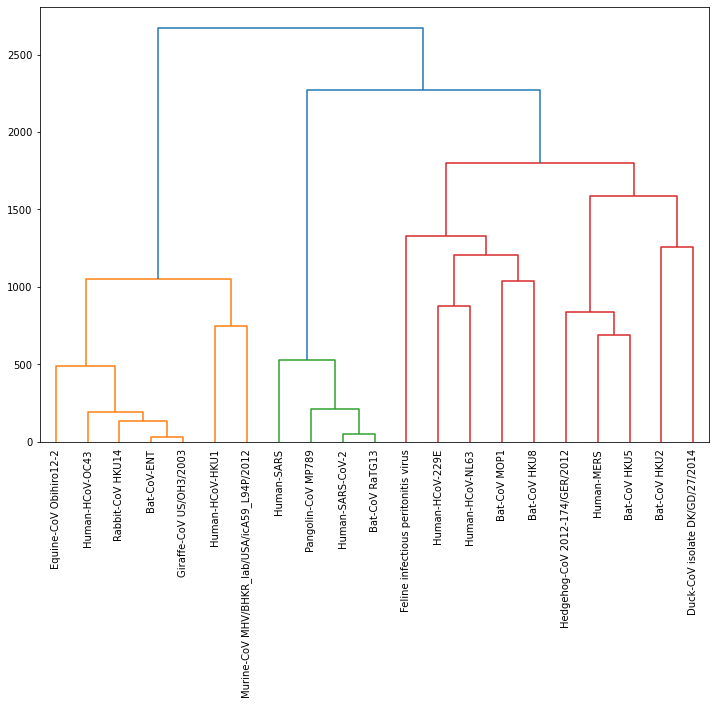

<Figure size 432x288 with 0 Axes>

In [15]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
label_virus=[]
for i in accession_codes:
    label_virus.append(i)
#print(label_virus)
Z = hierarchy.linkage(n, 'complete')
plt.figure(figsize=(12,8))
dn = hierarchy.dendrogram(Z,labels=label_virus, leaf_rotation=90)
plt.savefig('problem2.png', format='png', bbox_inches='tight')
plt.figure()

In [16]:
phylogeny_comments = """
I dont want to just make my predictions very strict since the graph is based on spotting different letters not based 
on difference in the nucleotide.
But from the graph "human cov" viruses seem more similar to "bat-cov" viruses in general, especially Human-SARS-CoV-2 
and Bat-CoV RaTG13, also Pangolin-CoV MP789 is similar to those two, which kind of suggests that the theory that the covid-19
originated from bats or pangolins may be true
Another interesting thing or expected is that in general, similar groups of viruses tend to have more similar global alignment 
results which makes sence since they attack a same organism, but  as we mentioned above it does NOT mean they are the closes!!!
"""

# MiniBLAST

In the previous homework, your task was to find ORF candidates, which we then ran through NCBI's BLAST to find matching sequences in other organisms. Doing so, we were able to determine whether each ORF is a gene, and if it is a gene - what that gene does. In this homework, we will implement our own simplified version of BLAST, MiniBLAST.

*Disclaimer*: Obviously, BLAST is a complicated, state-of-the-art piece of technology, and the algorithms we will use here are not used in NCBI's BLAST at all. BLAST is highly optimized and uses heuristics to obtain (very good) approximate solutions and can query thousands of sequences in a matter of seconds. Our implementation will be slightly less sophisticated and slightly slower. However, the basic functionality and end result of this implementation will be conceptually the same as that of BLAST.

## Problem 3

**TASK:**
Implement the Smith-Waterman algorithm you learned about in lectures for local sequence alignment in the `local_alignment` function in `helper_functions.py`. You can verify your implementation against provided unit tests, but note that the unit tests may not be complete, but can serve as a guide in the right direction. Your code will be run against different and complete examples for grading. **[10 points]**

Once you have implemented local sequence alignment, proceed to Problem 4.

In [17]:
from helper_functions import local_alignment

## Problem 4

In the previous homework, we found ORF candidates in the SARS-CoV-2 genome and applied some filtering to reduce the number of ORFs we have to check. We then used NCBI's BLAST to find similar sequences in other organisms, which have already been annotated. We were then able to infer whether or not our ORF candidates were genes, and if they were, what they do. We would like to go through this process again, but this time, everyone from NCBI decided to go on a yearlong cruise around the world, and their servers just happened to go down with nobody to fix them. So we are left to fend for ourselves.

We have already run our ORF finder and, having applied some clever filtering, we have managed to narrow down our search to five ORFs. We will use our MiniBLAST implementation to test each of these ORFs to known, annotated sequences from three known coronaviruses, hoping to find a good match. A good match would mean that our ORF is most likely a gene, and since we know what the gene does in the reference virus, we will assume it does the same in SARS-CoV-2.

**TASK:**
We randomly pick three viruses, Human-SARS, Bat-CoV RaTG13, and Pangolin-CoV MP789 to use as reference genomes. You are given 5 ORFs from SARS-CoV-2 that we found in the previous homework. It is your job to determine their function i.e. what gene they code for. For each ORF, calculate the local alignment to all annotated protein sequences from the three reference genomes. Score each alignment by counting the number of matching symbols in the aligned sequences e.g. A-TT and A-GG has similarity 2 (similarily to Hamming distance, but reversed).

Save your answers into the `orf_matches` variable as indicated in the cell below. Each ORF should be assigned a *closest-organism*, indicating in which reference virus the closest match was found, as well as a *homologous-gene*, indicating which gene the ORF matched to. Note any interesting observations into the `orf_comments` variable.
**[10 points]**

In [18]:
reference_genomes = [
    "Human-SARS",
    "Bat-CoV RaTG13",
    "Pangolin-CoV MP789",
]
query = "Human-SARS-CoV-2"

First, we have to build up our reference database. To do this, look through all the coding regions (CDS) on each reference genome, extract it, and convert it to a protein sequence. Remember which gene each protein sequence belongs to, e.g. ORF1a, spike protein, ...

Here are you ORF candidates from SARS-CoV-2:

In [19]:
orf_candidates = {
    "ORF-1": (1, 11995, 13483),
    "ORF-2": (1, 26792, 27191),
    "ORF-3": (1, 23650, 25384),
    "ORF-4": (1, 9133, 13483),
    "ORF-5": (1, 25392, 26220),
}

In [20]:
dict4={}
scov2={}
for i in reference_genomes:
    dict4[i]=accession_codes[i]
print(dict4)
scov=accession_codes[query]
scov

{'Human-SARS': 'NC_004718', 'Bat-CoV RaTG13': 'MN996532', 'Pangolin-CoV MP789': 'MT121216'}


'NC_045512'

In [21]:
recordCov2=load(scov)
#print(record.seq)
list_orf_cand={}
a="asdfghjkl"
b=recordCov2.seq[11995: 13483]
for i in orf_candidates:
    list_orf_cand[i]=[orf_candidates[i],recordCov2.seq[orf_candidates[i][1]:orf_candidates[i][2]],""]
list_orf_cand
for i in list_orf_cand:
    s=list_orf_cand[i][1].translate()
    s= s[:-1]
    list_orf_cand[i][2]=s
list_orf_cand["ORF-1"][2]

sr=str(list_orf_cand["ORF-1"][2])
#print(sr)

In [22]:
fin_acc_cove_vals_spike={}
if(1>0):
    for i in recordCov2.features:
        c=0
        if(i.type=="CDS"):
            for aa in i.qualifiers.items():
                
                if ("translation" in aa[0] ):
                    st=aa[1][0]
                    #print("lsitorff=",list_orf_cand["ORF-1"][2])
                    #print("aa[1][0]=",st)
            if c==1:
                for aa in i.qualifiers.items():
                    if "translation" in aa[0]:
                        s=aa[1][0]

In [23]:
viruses=[]
for key, value in dict4.items():
    temp = [key,value]
    viruses.append(temp)
print(viruses)
list_virus_data=[]
for virus in viruses:
    record=load(virus[1])
    record.features
    for i in record.features:
        c=0
        if(i.type=="CDS"):
            for aa in i.qualifiers.items():
                if ("translation" in aa[0] ):
                    st=aa[1][0]
                    list_virus_data.append([virus,i,aa[1][0]])


[['Human-SARS', 'NC_004718'], ['Bat-CoV RaTG13', 'MN996532'], ['Pangolin-CoV MP789', 'MT121216']]


In [24]:
def same_letters(seq1,seq2):
    c=0
    for i in range(min(len(seq1),len(seq2))):
        if seq1[i]==seq2[i]:
           c=c+1
    return c

In [25]:
kk=local_alignment(list_orf_cand["ORF-1"][2],list_virus_data[0][2],scoring_function_blosum62)
print(kk)

('MVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPMLQSADAQSF', 'MVSLLSVLLSMQGAVDINRLCEEMLDNRATLQAIASEFSSLPSYAAYATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVVPDYGTYKNTCDGNTFTYASALWEIQQVVDADSKIVQLSEINMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNNSKGGRFVLALLSDHQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDPAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLRNTVCTVCGMWKGYGCSCDQLREPLMQSADASTF', 2485.0)


In [26]:
list_before_fin=[]
list_clean=[]
for i in list_orf_cand:
    for j in list_virus_data:
        kk=local_alignment(list_orf_cand[i][2],j[2],scoring_function_blosum62)
        list_before_fin.append([i,j,kk])
        list_clean.append([i,j[0],kk])
list_before_fin

KeyboardInterrupt: 

In [27]:

"""
list_before_fin and list_clean, are filled with results, from them we get what we need , as we use zzz4_needed_results bellow
"""

'\nlist_before_fin and list_clean, are filled with results, from them we get what we need , as we use zzz4_needed_results bellow\n'

In [28]:
zzz4_needed_results=[['ORF-1',['Human-SARS','NC_004718'],('MVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPMLQSADAQSF','MVSLLSVLLSMQGAVDINRLCEEMLDNRATLQAIASEFSSLPSYAAYATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVVPDYGTYKNTCDGNTFTYASALWEIQQVVDADSKIVQLSEINMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNNSKGGRFVLALLSDHQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDPAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLRNTVCTVCGMWKGYGCSCDQLREPLMQSADASTF',2485.0)],['ORF-1',['Human-SARS','NC_004718'],('VSLLSV-LLSMQGAVDINKLCEEMLDNR-A--TLQAIASEFSSL-PSYAAFATAQEAYEQAVAN-GDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVAL-R-QMSC---AAGTTQTACTDDNALAYYNT--TKGGRFVLALLSDLQD--LK--WARFPKSDGTGTI-Y-TELEPPCRFVTDTP-KGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNAT-EVPANSTVLS--FCAFAVDAAKAYKDYLAS-GGQPITNCVKMLCTHTGTGQAITVTPEANMDQE-SFGGASCCLYCRCHIDHPNPKGFCDLKGKYV-QI-PT-TCANDPVGFTLKNTV','VVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGT-GVLTPSSKRFQPFQQ-FGRDVSDFTDS-VRDPKTSEILDISPCAFGGVSVITPGTNASSEVAV--LYQDVNCTDVSTAI-HADQ--L-TPAWRIYSTG-NNVF-QTQAGCL-IGAEHVDTSYE--CDIP-IGA--GIC-ASYHT-VS-L--LRS-TSQKS-IVAYT-MSLGADSSIAYSNNTIAIPTNFSISI-TTEVMPVSMAKTSVDCNMYICGDS-TECA--NLLLQYGSFCTQLNRALSGIAAE-QDRNTREVFAQVKQMYKTPTLKYFGGFN-FSQILPD-PLK-P-TK-RSFIEDL-LFNK-VTLAD-AGFMK-QYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTF-GAGAALQI-PFA-MQMAYRFNGIG--V-TQ-NVLYENQKQIANQFNKAISQIQESLTTTSTALG-KLQDVV',122.0)],['ORF-1',['Human-SARS','NC_004718'],('FTYASALWEIQQV-VD-AD-SKIVQ-LSEISMDNS-PNLAWPLIVTALRANSAVKLQNNELSPVAL--R-QMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDL-KWA--RFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKY-L-YFI-KGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHI-DHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTV','FTLRS-I-TAQPVKIDNASPASTVHATATIPLQASLP-FGW-LVI-GV-AFLAV-FQ-SATKIIALNKRWQLALYKG-FQFIC---NLLLLFVTIYSHLLLVAAGMEAQFLYLYALIYFLQCINACRIIMRCW-LC-WKCKS-KNP-LLYDANYFVCWHTHNYDYCIPYNSVTDTIVVTEGDGISTPKLKEDYQIGGYSEDRHSGVKDYVVVHGY-FTEVYYQL--ES-T-Q-IT-T-DTGI--EN---ATFFIFNKL-VKDPPNVQ-IHTIDGS-SGVANP-AMDPI-YDEPTTTTSV',78.0)],['ORF-1',['Human-SARS','NC_004718'],('VLCETLQAI-ASEFS-SLPSYAAF--ATAQEAYEQAV-AN-GDSEVVLKKLKKSLNVAKS-EFDRDAAMQRKLE----KMA-DQAMTQMYKQARSEDKRAKVTSAMQTML','MLFATVYHITVSQIQLSLLKVTAFQHQNSKKTTKLVVILRIG-TQ-VLKTM--SLYMAISPKFTTSLSLHKLLQTLVLKMLHSSSLTSLLKTHRM-CKYTQST-ALQELL',49.0)],['ORF-1',['Human-SARS','NC_004718'],('Y-YNTTKGGRFVL-ALLSDLQDLKWARFPKTGTIYT--EL-CRFV-TDTPKGPKVKYLYF-IKGLNNLNRGM','YSFVSEETGTLIVNSVL--L-FLAFVVF--TLAILTALRLCCNIVNVSLVK-PTV-YVYSRVKNLNS-SEGV',45.0)],['ORF-1',['Human-SARS','NC_004718'],('ADS-KI-V-QLSEISMDNSPNLAWPLIVTA-LR-ANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAY-YNTTKGG-RFVLALLSDLQDLKW--ARFPKSDGTGTIYTELEPPCRFVTDTP-KGPKV-KYLY---FIKGLNNLNRG-M-VLG-SLA-ATVR-LQAGNATEVPANSTVLSFCAFAVDAA-KAYKD--YLASGGQPITNCVKMLCT-HTGTGQAITV','ADNGTITVEELKQL-LEQW-NLVIGFLFLAWIMLLQFAYSNRNRFLYIIKLVFLWLLWPVT-LACF-VLAAVYRINWVTGGIAIAMACIVGLMWLSYFVASFRLFARTRSMWS-FNPETNILLNVPLRGTIVTRPLMESELVIGA-VIIRGHLRMAGHSLGRCDIKDLPK-EIT-V-ATSRTLSY--YKLGASQRVGTDSGFAAYNRYRIGN-YK-LNTDHAGSNDNIAL',65.0)],['ORF-1',['Human-SARS','NC_004718'],('MVVIPDYN-TYKNTCDTYASALWEIQQVVDADSKIV-QL-SEISMDNSPNL','MFHLVDFQVTIAEILITFRIAIWNL-DVI-I-SSIVRQLFKPLTKKNYSEL',38.0)],['ORF-1',['Human-SARS','NC_004718'],('MQTMLF-TMLRKLDNDALNNIINNARDG-CVPL-NIIPL-TTAAKL-MIPDYNTYKNTCDGTTFTYASA--LWEIQQV-VDADS-KI-VQLSEISMD-NSPNLAWPLIVTAL','MKIILFLTLI-VFTSCELYHYQECVR-GTTVLLKEPCPSGTYEGNSPFLAD-NKFALTCTSTHFAFACADGTRHTYQLRARSVSPKLFIRQEEVQQELYSP-L-F-LIVAAL',56.0)],['ORF-1',['Human-SARS','NC_004718'],('NTTKFVLALLSDLQDLKWARFPKELEPPC','NELTFYLCFLAFLLFLVLIML-IDLEEPC',26.0)],['ORF-1',['Human-SARS','NC_004718'],('EMSC-C-LYCRCHIDHPN','KISCICTVVQRCASNKPH',29.0)],['ORF-1',['Human-SARS','NC_004718'],('KAYKYLASGG--QC-V-KMLCTHT-GTGQAITVTPEANMD-QESFGGA--SCCLYCRCHIDHPNPKGFCDL','KILVYNTRGNTYSCALGKVLPFHRWHT-MVQTCTPNVTINCQDPAGGALIARCWY--LHEGH-QTAAFRDV',51.0)],['ORF-1',['Human-SARS','NC_004718'],('SSVL-LSMQGAVDINK-LCEEMLDNRATLQAIASEFSSLP-SYAAFAT--AQEAYEQA-VANGDSEVVLK-KLKKSLNVAKSEFD-RDAAMQ-RKL-EKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARD-GCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSK--IVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTAC-TDDNALAYYNTTKG','NTVLQLP-QGTT-LPKGFYAE--GSRGGSQA-SSRSSSRSRGNSRNSTPGSSRGNSPARMASGGGETALALLLLDRLNQLESKVSGKGQQQQGQTVTKKSAAEA-SKKPRQKRTATKQYNVTQAFGRR-GPE-QTQGNFGDQDLIRQGTDYKHWP-QIAQFAPSASAFFGMSRIG-MEVTPSGTWLTYHGAI-KLDD-KDPQFKDNVILLNK-HID-AYK-TFP--PTEPKKDKK-K-KTDEAQPLPQRQKKQPTVTLLPAADMDDFSRQLQNSMSG',80.0)],['ORF-1',['Human-SARS','NC_004718'],('NVAKSEFD-DAAMQRKLEKMADQAMTQMYKQARSEDKRA-KVTSAMQTML-FTMLRKLDNDALNNIINNARD-GCVPLNIIPLTTAAKLMVVIPD','NVVPPALHLDPQIQLTITRMED-AMGQ--GQ-NSADPKVYPIILRLGSQLSLSMARR--N--LDS-L-EARAFQSTPI-VVQMTKLA-TTEELPD',50.0)],['ORF-1',['Human-SARS','NC_004718'],('PSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLN-VAK-SEFDRDAAM-Q-RKLEKMADQA-MTQMY','PCY-NFLKEQHC-QKASTQREAEAAVKPLLAPHHVVAVIQEIQLLAAVGEILLLEWLAEVVKLPSRY',36.0)],['ORF-1',['Bat-CoVRaTG13','MN996532'],('MVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPMLQSADAQSFLN','MVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPMLQSADAQSFLN',2553.0)],['ORF-1',['Bat-CoVRaTG13','MN996532'],('VSLLS-VL-LSM-QGAVDINK-LCEEMLD-NRATLQAIASEF-SSLPSYAAFATAQEAYEQAVANGDSEV-V-LKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKR-AKVTSAMQTMLFTMLRKLDNDALNNIINNARD-GCV-PLNIIPLTTAAKLMV--VIPDYNTYKNTCDGT-T--FTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWP-LIVTALRANSAV-KLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNT-TK--GGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLY-FIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVD-AAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGA-SCCLYCRCHIDHPNPKG-FCDLKGKYVQIPTTCAN--DP-VGFTLKNT-VCTVCGMWKGYGCSCDQLREPMLQSADAQSF','ISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQ-YGS-FCTQL-N-RAL-TG-IAVEQD-KN-TQEVFAQVKQIYKTPPI-K-DFG-GFNFS-QI--LPDPSKPS--KRSFIEDLLFNKVTLA-DAG-F--IKQY-GDCLGDIA--ARDLICAQKFN--GLTVLPPLLTDEMIAQY-T-SALLAGTITSGWTFGAGA-AL-QIPFAMQMAYRFNGIGV--TQNVLYENQKLIANQFNSAIGKIQDS-LSSTA----S-ALGKLQDV-VNQNAQA-LNTLVKQLSSNFG-AISSVLNDI-LSRLDKVE--AEV--QID---RLI--T--G-RLQSLQTYV--TQQLIR--A-AEIRASANL-A--ATKM--SECVLG-QSKRVDFCGKGY--HLMSFPQSAPHGVVFL--HV-T---Y-V-P-A--QEKNFTTAPAICHDGKAHF--PR-EGVFVS-NGTHWFV-TQ-RNFYEPQI-ITTDNTFVSGSCDVVIGI-VN-NTVYDP-LQ-PELDSF',131.0)],['ORF-1',['Bat-CoVRaTG13','MN996532'],('DYNTTCGTTFTYASALWEIQQVVDADSKIVQLSEISMDNS-PNLAWPLIVTALRANSAVKLQN-NELSPVALR-QMSCAAGTTQTACTDDNALAYYNTTKGGRFVLAL-LSDLQDL-KWA--RFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKY-L-YFIKGLNN-LNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPIT-NCVKMLCTH--TGTG-QAIT','DLFMT-GTV-TLKQG--EIKDATPSDS-VRATATIPIQASLP-FGW-LIV-GV-AFLAV-FQSASKIITLKKRWQLALSKG-IHFIC---NLLLLFVTVYSHLLLVAAGL-EAPFLYLYALVYFLQSINFVRIIMRLW-LC-WKCRS-KNP-LLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTSPISEHDYQIGGYTEKWESGVKDCVVLHSY-FTSDYYQLYSTQLSTDTGVEHVT',66.0)],['ORF-1',['Bat-CoVRaTG13','MN996532'],('Y-YNTTKGGRFVL-ALLSDLQDLKWARFPKTGTIYT--EL-CRFV-TDTPKGPKVKYLYF-IKGLNNLNR','YSFVSEETGTLIVNSVL--L-FLAFVVF--TLAILTALRLCCNIVNVSLVK-PSF-YVYSRVKNLNS-SR',39.0)],['ORF-1',['Bat-CoVRaTG13','MN996532'],('LQDLKWARFPKSD-GTIYTELECRFVTDKKYLYFIKGLNN-LNRGMVLGS--LAATVRLQ--AGN-ATEVPA-NSTV-LS-FCA-FAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHI-DHPNPKGFCDLKGKYVQIPTTCANDPVGFTLK-NTVCTVCGMWKGYGC-SCDQLREPMLQSADAQSFLNGFAV','VEELK-KLLEQWNLGFLF--LTC-LL-QRRFLYIIKLIFLWLLWPVTLACFVLAAVYRINWITGGIAIAMACLVGLMWLSYFIASFRL-FART-RS-MWS-FNPETNILLNVPLH-GT--ILT-RP-L-LESELVIGA-VILRGHLRIAGH-H-LGRCDIKDLPKEI-TVATSRTLSY-YKLGASQRVAGD-SGFAAYSRYRIGNYKL-NTDHSSSSDNIAL',59.0)],['ORF-1',['Bat-CoVRaTG13','MN996532'],('EFSSLPSYA-YEQAVANGD--SEVVLKKLKKSLNVAK-SEFDRDAAMQ','DF-QV-TIAEFKVSIWNLDYIINLIIKNLSKSLTENKYSQLDEEQPME',45.0)],['ORF-1',['Bat-CoVRaTG13','MN996532'],('MQTMLFTMLRKLDNDALNNIINNARDG-CVPLNIIPL-T-T-AAKL-MIPDYNTYKNTCDGTTFTYA--SALWEIQQV-VDADS-KI-VQLSEISMDNSPNLAWPLIVTAL','MKIILFLVLVTLATCELYHYQECVR-GTTVLLK-EPCSSGTYEGNSPFLAD-NKFALTCFSTQFAFACPDGVKHVYQLRARSVSPKLFIRQEEVQELYSP-I-F-LIIAAI',49.0)],['ORF-1',['Bat-CoVRaTG13','MN996532'],('MVSLLSVLLSMQGAVDINKLC','LIMLIIFWFSLE-LQDHNETC',24.0)],['ORF-1',['Bat-CoVRaTG13','MN996532'],('LGQAITVTPEANMDQE-SFGGASCCLYCRCH-IDHPNPKGF-CD--LK-G--KYVQIPTTCANDPVGFTLKNTVCTV-CGMWKGYGCS-CD-QLREPMLQSADAQ-SFLNGF','MGILTTVT--A-FHQECSL--QSCAQH-QPYVVDDPCPIHFYSKWYIRVGARKSAPLIELCV-DEVG-S-KSPIQYIDIGNYT-VSCSPFTINCQEPKLGSLVVRCSFYEDF',55.0)],['ORF-1',['Bat-CoVRaTG13','MN996532'],('SSVLLSM-QGAVDINK-LCEEMLDNRATLQAIASEFSSLP-SYAAFAT--AQEAYEQA-VA-NG-DSEVVLKKLKKSLNVAKSEFD-RDAAMQ-RKL-EKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARD-GCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSK--IVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTAC-TDD','NAIVLQLPQGTT-LPKGFYAE--GSRGGSQA-SSRSSSRSRNSSRNSTPGSSRGTSPARMAGNGSDAALALLLLDR-LNQLESKMSGKGQQQQSQTVTKKSAAEA-SKKPRQKRTATKQYNVTQAFGRR-GPE-QTQGNFGDQELIRQGTDYKHWP-QIAQFAPSASAFFGMSRIG-MEVTPSGTWLTYTGAI-KLDD-KDPNFKDQVILLNK-HID-AYK-TFP--PTEPKKDKKKKADETQALP-Q-RQKKQQTVTLLPAADLDD',77.0)],['ORF-1',['Pangolin-CoVMP789','MT121216'],('MVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPMLQSADAQSFLN','MVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPMLQSADAQSFLN',2553.0)],['ORF-1',['Pangolin-CoVMP789','MT121216'],('VSLLS-VL-LSM-QGAVDINK-LCEEMLD-NRATLQAIASEF-SSLPSYAAFATAQEAYEQAVANGDSEV-V-LKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKR-AKVTSAMQTMLFTMLRKLDNDALNNIINNARD-GCV-PLNIIPLTTAAKLMV--VIPDYNTYKNTCDGT-T--FTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWP-LIVTALRANSAV-KLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNT-TK--GGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLY-FIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVD-AAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKG-FCDLKGKYVQIPTTCAN--DP-VGFTLKNT-VCTVCGMWKGYGCSCDQLREPMLQSADAQSF','ISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQ-YGS-FCTQL-N-RAL-TG-IAVEQD-KN-TQEVFAQVKQIYKTPPI-K-DFG-GFNFS-QI--LPDPSKPS--KRSFIEDLLFNKVTLA-DAG-F--IKQY-GDCLGDIA--ARDLICAQKFN--GLTVLPPLLTDEMIAQY-T-SALLAGTITSGWTFGAGA-AL-QIPFAMQMAYRFNGIGV--TQNVLYENQKLIANQFNSAIGKIQDS-LSSTA----S-ALGKLQDV-VNQNAQA-LNTLVKQLSSNFG-AISSVLNDI-LSRLDKVE--AEV--QID---RLI--T--G-RLQSLQTYV--TQQLIR--A-AEIRASANL-A--ATKM--SECVLG-QSKRVDFCGKGY--HLMSFPQSAPHGVVFL--HV-T-Y-VP-SQEKNF-TTT--PA-ICHEGKAHF--PR-EGVFVS-NGTHWFV-TQ-RNFYEPQI-ITTDNTFVSGSCDVVIGI-VN-NTVYDP-LQ-PELDSF',130.0)],['ORF-1',['Pangolin-CoVMP789','MT121216'],('DYNTTCGTTFTYASALWEIQQVVDADSKIVQLSEISMDNS-PNLAWPLIVTALRANSAVKLQN-NELSPVALR-QMSCAAGTTQTACTDDNALAYYNTTKGGRFVLAL-LSDLQDL-KWA--RFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKY-L-YFIKGLNN-LNRGMVLGSLAATVRLQAGNATEVP','DLFMT-GTV-TLKQG--EIKDATPSDS-VRATATIPIQATLP-FGW-LIV-GV-ALLAV-FQSASKIITLKKRWHLALSKG-VHFVC---NLLLLFVTVYSHLLLVAAGL-EAPFLYLYALVYFLQSINFVRIIMRLW-LC-WKCRS-KNP-LLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTNP',56.0)],['ORF-1',['Pangolin-CoVMP789','MT121216'],('Y-YNTTKGGRFVL-ALLSDLQDLKWARFPKTGTIYT--EL-CRFV-TDTPKGPKVKYLYF-IKGLNNLNR','YSFVSEETGTLIVNSVL--L-FLAFVVF--TLAILTALRLCCNIVNVSLVK-PSF-YVYSRVKNLNS-SR',39.0)],['ORF-1',['Pangolin-CoVMP789','MT121216'],('TGRFVLALLSDLQDLKWARFPKSDGTIYTELECRFVTDKKYLYFIKGLNN-LNRGMVLGS--LAATVRLQ--AGN-ATEVPA-NSTV-LS-FCA-FAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHI-DHPNPKGFCDLKGKYVQIPTTCANDPVGFTLK-NTVCTVCGMWKGYGC-SCDQLREPMLQSADAQSFLNGFAV','SGTITVEELKKLLD-QW-NL----GFLF--LTC-LL-QRRFLYIIKLIFLWLLWPVTLACFVLAAVYRINWITGGIAIAMACLVGLMWLSYFIASFRL-FART-RS-MWS-FNPETNILLNVPLH-GT--ILT-RP-L-LESELVIGA-VILRGHLRIAGH-H-LGRCDIKDLPKEI-TVATSRTLSY-YKLGASQRVAGD-SGFAAYSRYRIGNYKL-NTDHSSSSDNIAL',59.0)],['ORF-1',['Pangolin-CoVMP789','MT121216'],('EFSSLPSYA-YEQAVANGD--SEVVLKKLKKSLNVAK-SEFDRDAAMQ','DF-QV-TIAEFKVSIWNLDYIINLIIKSLSKPLTENKYSQLDEEQPME',40.0)],['ORF-1',['Pangolin-CoVMP789','MT121216'],('MQTMLFTMLRKLDNDALNNIINNARDG-CVPLNIIPL-T-T-AAKL-MIPDYNTYKNTCDGTTFTYA--SALWEIQQV-VDADS-KI-VQLSEISMDNSPNLAWPLIVTAL','MKIILFLALITLATCELYHYQECVR-GTTVLLK-EPCSSGTYEGNSPFLAD-NKFALTCFSTQFAFACPDGVKHIYQLRARAVSPKLFIRQEEVQELYSP-I-F-LIVAAI',54.0)],['ORF-1',['Pangolin-CoVMP789','MT121216'],('LSEISM-D-NSPNLAWPL-IV-TALRAN-SAVKLQ-NNE','MSELSLIDFYLCSLAFLLFLVLIMLIIFWFSLELQDHNE',28.0)],['ORF-1',['Pangolin-CoVMP789','MT121216'],('LSLQLKSFVTDTPKGPKVK-Y-LYFIK-GLNNLNRGMV-LGSLAATVRLQAGNATEVP-ANSTVLSFCAFAVDAAKAYKD','MKLVLGAYVVDDP-CP-IHFYSRWFIRVGARK-SAPLIDIGNYTVSCSPFTINCQE-PKLGSLVVR-CSFYEDFLE-YHD',56.0)],['ORF-1',['Pangolin-CoVMP789','MT121216'],('SSVLLSM-QGAVDINK-LCEEMLDNRATLQAIASEFSSLP-SYAAFAT--AQEAYEQA-VA-N-GDSEVVLKKLKKSLNVAKSEFD-RDAAMQ-RKL-EKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARD-GCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSK--IVQLSE-I-SMDNSPNLAWPLIVTALRANSAVKL-QNNELSP-VAL','NAIVLQLPQGTT-LPKGFYAE--GSRGGSQA-SSRSSSRSRNSSRNTTPGSSRGTSPARMAGNGGDAALALLLLDR-LNQLESKMSGKGQQQQGQTVTKKSAAEA-SKKPRQKRTATKQYNVTQAFGRR-GPE-QTQGNFGDQELIRQGTDYKQWP-QIAQFAPSASAFFGMSRIG-MEVTPSGTWLTYTGAI-KLDD-KDPNFKDQVILLNKHIDAYKTFPPTE-PKKDKKKKADETQALPQRQKKQPTVTL',77.0)],['ORF-1',['Pangolin-CoVMP789','MT121216'],('MDNNL-AWPL-IVT-AL-RANS','M-GNVFAFPFTIYSLLLCRMNS',24.0)],['ORF-2',['Human-SARS','NC_004718'],('MWLSY-F-IASFRLFARTRSMWSFNPETNILLNVPLHGTILTRPLLESELVIGAVILRGHLRIAG-H-HLGRCDIKDLPKEITVATSRTLSY-YKLGASQRVAGDSGFAAYSRYRIGNYKLNTDHS-SSSDN','MATNYDLSVVNARLRAK-HYVYIGDP-AQ--LPAP-R-TLLTKGTLEPE-YFNSV-CR-LMKTIGPDMFLGTC--RRCPAEI-VDTVSALVYDNKLKAHKDKSAQC-FKMF--YK-G-V-I-T-HDVSSAIN',69.0)],['ORF-2',['Human-SARS','NC_004718'],('FIASFR-LFARTRSM-W--SFNPETNILLNVPLHGTILTRPLLESELVIGAVIL--RGHLRIAGHHLGRCDIKDL','F-AQVKQMY-KTPTLKYFGGFN-FSQILPD-PLKPT--KRSFIE-DLLFNKVTLADAGFMKQYGECLGDINARDL',51.0)],['ORF-2',['Human-SARS','NC_004718'],('WLSYFIASFR--LF-ARTRSMWSFNPETNILLVPLHGTIL-TRPLLESELVIGAVILRGHLRIAGHHLGR-CDIKDLPKEITVATSRTLSYYKLGASQRVAGDSGF--AAYSRY-R-I-G--NYKLNT-DHSSSSDNIAL','WLCWKCKSKNPLLYDANYFVCW--HTH-NYDYIP-YNSVTDTIVVTEGD-GISTPKLKEDYQIGGYSEDRHSGVKDY---VVVHGYFTEVYYQLESTQ-ITTDTGIENATFFIFNKLVKDPPNVQIHTIDGSSGVANPAM',56.0)],['ORF-2',['Human-SARS','NC_004718'],('LSYFIARTRSMW-SFNPE-TNIL-LNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKD-LPKE-ITVATSR','LVVILRKTMSLYMAISPKFTTSLSLHKLLQ-TLVLK-MLHSS-SLTS-LLKTH-RMCKYTQSTA-LQELLIQQWIQFMMSR',42.0)],['ORF-2',['Human-SARS','NC_004718'],('MWSF-NPETNILLNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDI-K-DLPKEITV-ATSRTLSYYKLGASQRVAGD','MYSFVSEETGTLI-V--NSVLLFLAFVVF-LLVTLAILTA-LRLCA-YC--CNIVNVSLVKP-TVYVYSR-VK--NLNSSEGVP-D',46.0)],['ORF-2',['Human-SARS','NC_004718'],('MWLSYFIASFRLFARTRSMWSFNPETNILLNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTDHSSSSDNIALLVQ','MWLSYFVASFRLFARTRSMWSFNPETNILLNVPLRGTIVTRPLMESELVIGAVIIRGHLRMAGHSLGRCDIKDLPKEITVATSRTLSYYKLGASQRVGTDSGFAAYNRYRIGNYKLNTDHAGSNDNIALLVQ',625.0)],['ORF-2',['Human-SARS','NC_004718'],('MW-LSYFIASF-R-LF-ARTRSMWS-FNPETNILLNVP','IWNLDVIISSIVRQLFKPLTKKNYSELDDEEPMELDYP',38.0)],['ORF-2',['Human-SARS','NC_004718'],('IK-LITVATSRTLSYYKLGASQRVAGDSGFAAYSRGNYKLNTD-HSSSSDN-IAL','MKILLIVFTSCEL-YH-Y--QECVRGTT-VLLKEPGTYEGNSPFH-PLADNKFAL',30.0)],['ORF-2',['Human-SARS','NC_004718'],('WLSYFIASFRLF','YLC-FLA-FLLF',23.0)],['ORF-2',['Human-SARS','NC_004718'],('LFATNVPLHGTILTRP','LTCSNKP-H--VLEDP',18.0)],['ORF-2',['Human-SARS','NC_004718'],('WLSYFIASFRL-FARTRSM-WSFNPETNILLNV--PLHGTILTR','WLC-ALGKV-LPFHRWHTMVQTCTP--NVTINCQDPAGGALIAR',36.0)],['ORF-2',['Human-SARS','NC_004718'],('LSYF-IASFRLFARTRSMWSFNPETNI-LLNV-PLHGTILTRPL-LESELVIGAVILRGHLRIAGHHLG-RCDIKDLPKEITVATSRTL--SYYKLGASQRVAGDSGFA-AYSRYRIGNYKLNTDHSSSSDN','IGYYRRATRRVRGGDGKMKELSPRWYFYYLGTGP-EAS-L--PYGANKEGIVW-VATEGALNTPKDHIGTRNPNNNAATVLQLPQGTTLPKGFYAEG-S-R-GGSQASSRSSSRSR-GNSR-NSTPGSSRGN',56.0)],['ORF-2',['Human-SARS','NC_004718'],('IDLPK-EITVATSRTLSYYKLGASQRVAGDSGFAAYS-RYRIGNYKLNTDHSSSS-DNI-ALLVQ','LD-PQIQLTI-T-R-ME-DAMGQGQNSA-DP--KVYPIILRLGS-QLSLSMARRNLDSLEARAFQ',33.0)],['ORF-2',['Human-SARS','NC_004718'],('WSFNPETNI-LLNVPRPLLESELVIGAVILRGHLRIAGHHLGRCDIKD-LPKEITVATSR','YNFLKEQHCQKASTQKPLLAPHHVV-AVIQEIQL-LAA--VGEILLLEWL-AEVVKLPSR',31.0)],['ORF-2',['Bat-CoVRaTG13','MN996532'],('LF-TN-LLNVPLHGTILTRPLLESELV-IGAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLSY-Y-KL--GASQRV-A---GD-SG-F-AAY-SRYRI-GNYKLNTDHSSSSDNI','LWLTSEMLN-PNYEDLLIRKSNHNFLVQAGNV--Q--LRVIGHSMQNCVLK-L-K-VDTANTKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSF-LNGSCGSVGFNI',73.0)],['ORF-2',['Bat-CoVRaTG13','MN996532'],('TRSMETNILLNVP--LHGTILTRPLLESELVIGA-VI-LR-GHLRIAGHHLGRC-DIKDLPKEITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTDHSSSSDNIAL','SNQVDVN-CTEVPVAIHADQLT-PTWR-VYSTGSNVFQTRAGCL-IGAEHVNNSYEC-DIP--IG-A-GICASYQTQTNSRSVASQS-IIAYT-MSLG-AE-NS-VAYSNNSIAI',56.0)],['ORF-2',['Bat-CoVRaTG13','MN996532'],('LSYFIAS--F-RLFARTRSMW---SFNP---ETN-ILL-NVPLHGTILTRPLLESELVI--G-AVI--LRGH-LRIAGHHLGRCDIKDLPKEITVATSR-TLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTD','LVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTSPISEHDYQIGG-YTEKWE-SGV-KDCVVLHSYFTSDYYQLYSTQ-LSTDTG-VEHVTFFIYN-KI-VD',60.0)],['ORF-2',['Bat-CoVRaTG13','MN996532'],('MWSF-NPETNILLNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKDLPKEITVATS-RTLSYYK-LGASQRVAGD','MYSFVSEETGTLI-V--NSVLLFLAFVVF-LLVTLAILTA-LRLCA-YC--CNIVNV--SL-VKPSFYVYSRVKNLNSS-RVP-D',43.0)],['ORF-2',['Bat-CoVRaTG13','MN996532'],('MWLSYFIASFRLFARTRSMWSFNPETNILLNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTDHSSSSDNIALLVQ','MWLSYFIASFRLFARTRSMWSFNPETNILLNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTDHSSSSDNIALLVQ',678.0)],['ORF-2',['Bat-CoVRaTG13','MN996532'],('MIASFRL-FART-R-SMWSFNPETNILL-NV','VIAEILLIIMRTFKVSIWNLDYIINLIIKNL',35.0)],['ORF-2',['Bat-CoVRaTG13','MN996532'],('IKITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTD-HSSSSDN-IAL','IIVTLATCE-L-YH-Y--QECVRGTT-VLLKEPCSSGTYEGNSPFH-PLADNKFAL',31.0)],['ORF-2',['Bat-CoVRaTG13','MN996532'],('WLSYFIASFRLF','YLC-FLA-FLLF',23.0)],['ORF-2',['Bat-CoVRaTG13','MN996532'],('LLNVPLHGTILTR-PLLESELVIGAVILRGHLRIAGHCDIKDLPK-EITVATSRTLSYYKLGASQRVAGDSGFAAYSRY-RIGNYKLN','LL-VFL-G-ILTTVTAFHQECSLQS-CAQ-HQPYV--CPIHFYSKWYIRVGARKSAPLIELCVDE-V-G-SK-SPI-QYIDIGNYTVS',31.0)],['ORF-2',['Bat-CoVRaTG13','MN996532'],('SRTRSMSF-NPETNILLNVPHG-TRPLLESELVG-AHLGRCDIKDLPK-E-ITVAT-SR---TLSYYKLGASQRV-AGDSGFAAYS-RYRIGNYKLNT','NRNAPRTFGGPSDSTGSN--NGERRP--KQRRPGLPH-GKEDLK-FPRGQGVPINTNSSPDDQIGYYR-RATRRIRGGDGKMKDLSPRWYF--YYLGT',53.0)],['ORF-2',['Pangolin-CoVMP789','MT121216'],('MY-FIASFRLFARTRSMWSFNPETNIL-LN-VPL-H-G-TI-LTRPLL-ESELVIGAVILR--GHLRIAGHHLGRCDIK--DLPKEI-T-VATSRTLSY-YKLGAS-QR-VAGD-SGFAAYSRYRI-GNY','LYVFI-K-RSDARTAPHGHVMVEL-VAELNGVQYGRSGETLGVLVPHVGETPVAYRKVLLRKNGNKGAGGHSYG-ADLKSYDLGDELGTDPYEDYQENWNTKHGSGVTRELMRELNG-GAYTRY-VDNNY',71.0)],['ORF-2',['Pangolin-CoVMP789','MT121216'],('SYSMWFNPETNILLNVPLHGTILTR--PLLESELVIGAVILRG-HLR-IA-GHHLGR-CDIK-DLPKEITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGNYK-LNTDHSS','AWSV-YN-STS-FSTFKCYGVSPTKLNDLCFTNVYADSFVVRGDEVRQIAPG-QTGRIADYNYKLPDDFT-G-C-VIAWNSNNLDSKVGGNYNY-LYRLFRKSNLKPFERDIST',61.0)],['ORF-2',['Pangolin-CoVMP789','MT121216'],('LSYFIAS--F-RLFARTRSMW---SFNP---ETN-ILL-NVPLHGTILTRPLLESELVI--G-AVI--LRGH-LRIAGHHLGRCDIKDLPKEITVATSR-TLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTD','LVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTNPITEHDYQIGG-YFEKWE-SGV-KDCVVLHSYFTSDYYQLYSTQ-LSTDTG-VEHVTFFIYN-KI-VD',61.0)],['ORF-2',['Pangolin-CoVMP789','MT121216'],('MWSF-NPETNILLNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKDLPKEITVATS-RTLSYYK-LGASQRVAGD','MYSFVSEETGTLI-V--NSVLLFLAFVVF-LLVTLAILTA-LRLCA-YC--CNIVNV--SL-VKPSFYVYSRVKNLNSS-RVP-D',43.0)],['ORF-2',['Pangolin-CoVMP789','MT121216'],('MWLSYFIASFRLFARTRSMWSFNPETNILLNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTDHSSSSDNIALLVQ','MWLSYFIASFRLFARTRSMWSFNPETNILLNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTDHSSSSDNIALLVQ',678.0)],['ORF-2',['Pangolin-CoVMP789','MT121216'],('MIASFRL-FART-R-SMWSFNPETNILLNVPLHGTILTRPLLESE','VIAEILLIIMRTFKVSIW--N--LDYIINLIIK-S-LSKPLTENK',40.0)],['ORF-2',['Pangolin-CoVMP789','MT121216'],('IKITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTD-HSSSSDN-IAL','IIITLATCE-L-YH-Y--QECVRGTT-VLLKEPCSSGTYEGNSPFH-PLADNKFAL',32.0)],['ORF-2',['Pangolin-CoVMP789','MT121216'],('LSYFIAS--FRLF','IDFYLCSLAFLLF',20.0)],['ORF-2',['Pangolin-CoVMP789','MT121216'],('VVILRGHL-RIAGHHLGRCDIKDLPK-E-ITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLN','MVFL-GILTTVTAFH-QECSLQSCAQHQPYVVDDPCPIHFYSRWFI-RV-G-ARKSA-PLIDIGNYTVS',31.0)],['ORF-2',['Pangolin-CoVMP789','MT121216'],('WLSYFIASF-R--L-F-ARTRS-MWSFNPETNILLNVPL-H-GTILTRPLLESELV--I--GAVILRGHLRIAGHHLGRCDIKDLPKEITVATSR-TLSYYKLGAS-QRVAGDSGFAAYSRYRIGNYKLNTDHSSSS','WYFYYLGTGPEAGLPYGANKEGIIWVAN-E-G-ALNTPKDHIGT--RNPANNAAIVLQLPQGTTLPKG-FYAEGSR-GGSQASSRSSSRSRNSSRNTTPGSSRGTSPARMAGNGGDAALALLLL-D-RLNQLESKMS',59.0)],['ORF-2',['Pangolin-CoVMP789','MT121216'],('MWLF-IASFRLFARTRSMWSFNPETNIL-LNV','VFAFTIYSL-LLCRMNSR-SYIAQVDVVNFNL',24.0)],['ORF-3',['Human-SARS','NC_004718'],('M-SLGAENSVAYSNNSIAIPT-N-F-T-ISVTT-E-IL-PVSMTKTSVDCTMYICGDSTECSNLLLQYG-S--FCT-Q--LNRALTGIAVEQDKNTQEVFAQVKQIYKTPPI-KDFGGFNF-SQILPDPSKPSKRSFIEDLLFN-KVTLADAGFIKQYGDCLGDIAARDLICAQKFNGL-TVLPPLLTDEMIA-QYT-S-AL-LAGTITS-GWTFGAGAAL-QIPFAM-QMAYRFNGIGVTQNVLY-----E--N-QKLIANQFNSAIGKIQDSLSSTASALGKLQDVVN-QNA-QALNTLVK---QLSSNFGAISSVL-NDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFY-EPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDS-FKEELDKYFKNHTSPDVDLGDISGI-NASVVNIQKEIDRLN-EVAKNLNE','MRSLKAPAVVSVSSPD-AVTTYNGYLTSSSKTSEEHFVETVSLAGSYRDWS-Y-SGQRTELGVEFLKRGDKIVYHTLESPVEFHLDGEVLSLDK-LKSLLS-LREV-KTIKVFTTVDNTNLHTQLV-DMSMTYGQQFGPTYLDGADVTKIKP-HVNHEGKTFFVLPSDDTLRSEAFEYYHTLDESFLGRYMSALNHTKKWKFPQVGGLTSIKWA-DNNCYLSSVLLALQQLEVKFNAPAL-QEAYYRARAGDAANFCALILAYSNKTVGELGD-VRETMTHL--LQH-ANLESAKRVLNVVCKHCGQKTTTLTGVEAVMYMGTLS-YDNLKTGVSIP-CVCGR-DATQ-YLVQQ--ESSFVMMSAPPAEYKLQQ---G-T--F-LCANEY-TGNY-QCG-H---YTHIT---AKE---TLY-RI--DG-AHLTKMSEY--KGP---VTD-VFYKETSYTTTIKP-VSYKLD---G-V--T-YTEIEPKLDGYYKKD-NAYY-TE-QP-IDLVPTQPLPNASFDNF-K-LTCSNTKFADDLNQ',183.0)],['ORF-3',['Human-SARS','NC_004718'],('MSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT','MSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYVWLGFIAGLIAIVMVTILLCCMTSCCSCLKGACSCGSCCKFDEDDSEPVLKGVKLHYT',2793.0)],['ORF-3',['Human-SARS','NC_004718'],('MQMAYRFNGI-GVT-QNVLYENQKLIANQFN-SA-IGKIQDSLSSTASALGKLQDVVNQNAQALNTLVK--QLS--SNFGAISS--VL-NDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLA-ATKMSECVLGQSKRVDF-CGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGK-AHF--PR-EGV--FVSNGTHWFVTQRNFY--E-PQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVD-LGDISGINASV','MDLFMRFFTLRSITAQPVKIDNAS-PASTVHATATI-PLQASLPFGWLVIGVAFLAVFQSATKIIALNKRWQLALYKGFQFICNLLLLFVTIYSHLLLVAAGMEA-QFL--YLYAL-IYFL-QCINACRIIMRCWLCWKCKSKNPLL-YDANY-FVC---WHTHNYDYCIPYNSV-TD-TIVVTEGDGIST-PKLKEDYQIGGYSEDRHSGVKDYVV--VHGYFTE-VYYQLESTQ-ITTD-TGIE-NA-TFF-IFNKLVKDP--PNV-QI-HTIDG-SSGVANPAMDPIYDEPTTTTSV',87.0)],['ORF-3',['Human-SARS','NC_004718'],('MQMAYFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNT--LVKQLSSNFGAISSVLNDILSRLD-KVEAEVQIDRLI-TGRL-QSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRV--DFC','MMPTTFAGTHITMTTVY-H--ITVSQIQLSLLKVTAFQHQNSKKTTKLVVILRIGTQVLKTMSLYMAISPKF-TTSLSLHKLLQTLVLKMLHSSSLTSLLKTHRMCKYTQSTALQELLIQQWIQ-FM-MSRRRLLAC-LCKHKKVSTNLC',65.0)],['ORF-3',['Human-SARS','NC_004718'],('SLIDLQELGKYEQYIKWPIWLGFIAG-LIAIVMVTIMLCCMTSCCS','SFVS-EETGTL--IVN-SLFLAFVVFLLVTLAILTALRLC-AYCCN',45.0)],['ORF-3',['Human-SARS','NC_004718'],('LSSNFGAISSVLNDILSRLDKVEA-EVQIDRLITGRLQSLQ-TYVTQ-QLIRAAEIRASANL-AATKMSEC-VLGQSKRVDF-CGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFT-TAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIG-IVNN-TVYDPLQP-ELD-SFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEI-D-RLN-EVA-KNLNESLIDLQ','MADN-GTI-TV-EE-LKQL--LEQWNLVIGFLFLAWIMLLQFAYSNRNRFLYIIKLVFLWLLWPVT-LA-CFVLAAVYRINWVTG-G--I-AIAMACIVGLMWL--SYFVASFRLFARTRSMWSFNPETNI-LLNVPL-RGT--IVT-RPLMESELV-IGAVIIRGHLRMA-GHSLGRCDIKD-L-PKEITVATSRTL-SYYKLGASQRVGT-D-SGF-AA-YN-RYRIGNYKLNTDHAGSNDNIALL-VQ',64.0)],['ORF-3',['Human-SARS','NC_004718'],('HWFVT-QRNFYEPQIITTDNTF-VS-GNCDVVI-GIVNNTVYDPL--Q--PELDSFKE--ELDKY','H-LVDFQVTIAEILIIIM-RTFRIAIWNLDVIISSIVRQ-LFKPLTKKNYSELDD-EEPMELD-Y',57.0)],['ORF-3',['Human-SARS','NC_004718'],('IELLF-NKVTLADAGFIKQYGDCL-G-DIAARDLIC-AQKFNGLTVLPPLLTDEMIA-QYTSALLAGTITSGWT','MKILFLTLIVFTSCE-LYHYQECVRGTTVLLKE-PCPSGTYEGNSPFHP-LADNKFALTCTSTHFAFACADG-T',43.0)],['ORF-3',['Human-SARS','NC_004718'],('QYWYI-WLGFIAGLIAIVMVTI','ELFYLCFLAFLLFLV-LIMLII',32.0)],['ORF-3',['Human-SARS','NC_004718'],('M-VTIMLCCMTSCCSCLKGCCSCGSCCKFDEDD-SE-PVLKGVKLH','MKLLIVLTCI-SLCSCI--CTVVQRCAS-NKPHVLEDP-CK-VQ-H',48.0)],['ORF-3',['Human-SARS','NC_004718'],('QLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQS-APHGVVFLHVTYVPAQEKNFTTAPAICHDG-K-AHFPREGVFVSN','KLVR-YNTR--GNTYSTAWL-CALG--KVLPF-HR-WHTM-V-QTCTPN-VT-IN-CQDPAGGALIARCWYL-HEGHQTAAF-RDVLVVLN',38.0)],['ORF-3',['Human-SARS','NC_004718'],('QLN-R-A--LT-GIAVEQDKNTQEVFQVPIKDFGGREDLLFNKVTLADAGFDCLGDIAARDLIQNG-LTVLPP-LLTMSALLAGTITSG--WTFGAGAALQIPFAMQMAYRF-NGIGVTQNVLYENQKLIANQF-NSAIGKIQ-DSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCG-KG-YHLM-SF-PQS-APHGVVFLHVTYVPAQEKNFTTAP-AICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIG--I-VNNTVYDPLQPELDSFKEELDK','QSNQRSAPRITFG-G-PTD-STDN--QNP-KQRRPQEELRFPRGQGVPINTDQIG-YYRRATRRDGKMKELSPRWYFLASLPYGANKEGIVWVATEG-ALNTP-KDHIGTRNPNNNAATVLQLPQGTTLPKGFYAEGSRGGSQASSRSSSRSR-GNSRNSTPGSSRG-NSPAR-MASGGGETALALL-LLDRLNQLESKVS-GK---GQQQQGQT-VTKKSAAEASKKPRQKRTATKQYN-VT-QA----F-GRRGPEQTQGNFGDQDLIRQGTDYKH--W-P-QIAQF--APSASAFFGMSRIGME-V-TPSGT-W-LTYHGAI--KLDDKDPQF-KDNV-ILLNKHIDAYKT-FPPTEPKKDK-KKKTDE',105.0)],['ORF-3',['Human-SARS','NC_004718'],('NGLTVLPP-L-LTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVT-QNVLYENQKLIANQFNSA-IGKIQ-DSLSST','NQTNVVPPALHLVDPQI-QLTITRMEDAMGQGQN-SADPKV-YPIILRLGSQLS-LSMARRN-L-DS--LEARAFQSTPI-VVQMTKLATT',54.0)],['ORF-3',['Human-SARS','NC_004718'],('LPELDSF-KEELDKYFKNHTSPDVDLGDISGINA--SVVNIQKEIDRLNEVAK-NLNESLIDLQEL-GKY','MPPCYNFLKEQ-HCQ-KASTQREAEAA-VKPLLAPHHVVAVIQEIQLLAAVGEILLLEWLAEVVKLPSRY',33.0)],['ORF-3',['Bat-CoVRaTG13','MN996532'],('LGAENSVAY-SNNSIA-IPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQ-VKQI-YKT-PPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADA-GFIKQYGDCLGDIAARDLICAQKFNGLTVL-PPLLTD-EMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQ-IDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLG-QSKRVDFCGK-GYHLMSFPQSAPHGVVFLH-VTYVPAQ---EK-NFTTA---PAICHDGKA-HFPREGVFVS-NGTHWF-V--TQRN-FYEPQIITTDNTF-VSGNCDVVIGIVNNTVYDPLQ--PELD-SFK-EE-LDKYFKNHTSP-DVDLG-DISGINASVVNIQKEIDRLNEVAKNLNESL-IDLQELGKYEQYI','VGCYNKCAYWIPRASANIGCNHT-GVVGE--G-S-EGLN-DNLLEIL-QK-EKVNINI-VGDF--KLNEEIAIILASFSAST-SAFVETVKGLDYKTFKQIVESCG-NF-KV--TKGK-AKKG-AWNIGEQKSILSPLYAFASEAARVVRSIFSRTLETAQ--NSVRALQKAAITILDGISQY-S--LR-LI-DAMMFTSDLVTN-NLVV-MAY-ITG-GVVQ--L-TSQWL-TNIFGTVYEKLKPVL-DWLEE--KFKEGVEFLRDGWE-IVKFIST-C-ACEIVGGQIVTCAKEIKESVQTFFKLV-NKFLAL-C-ADSIIIGGAKLKA-LNLGETFVTHS-KGLYRKCVKPKEETGL-LM--PLKAPKEIIFLEGET-LPTEVLTEEVVLKTGDLQPLEQPTSEAVEAPLVGTPVCINGLMLLEIKDTEKYCALAPNMMVTNNTFTLKGGAPTKVTFGDDTVIE-VQGYKSVNITFELDERIDKVLNEKCSTYTVELGTEVNEF-ACVV-ADAVIKTLQPVSE-LLIPLGIDLDEWGMATYYL',193.0)],['ORF-3',['Bat-CoVRaTG13','MN996532'],('MSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT','MSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT',2999.0)],['ORF-3',['Bat-CoVRaTG13','MN996532'],('MQMAYR-FNGIG-VT--QNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVK--QLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQS--LQTYVTQQLIRAAE-IRASANL-AATK-MSECVLGQSKRVDF-CGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAIC-HDGK-AHF-PR-E-GVFVSNGTH-WFVTQRNFYEPQIITTD-NTFVSGNCDVVIGIVNNTVYDPLQPE','MDLFMRIFT-LGTVTLKQGEIKDATPSDSVRATATI-PIQASLPFGWLIVGVAFLAVFQSASKIITLKKRWQLALSKG-IHFICN-LL-LL-FVTVYSHL-LLVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANY-FLC---WHTNCYDYCIPYNSVTSSIV-ITSGD-G-TTSP-ISEHDYQIGGYTEKWESGVKDCVVLHSYF-TS-DYY--QLYSTQLST-DTG-VEHVTFFIYNKIVD--EPE',82.0)],['ORF-3',['Bat-CoVRaTG13','MN996532'],('SLIDLQELGKYEQYIKWPIWLGFIAG-LIAIVMVTIMLCCMTSCCS','SFVS-EETGTL--IVN-SLFLAFVVFLLVTLAILTALRLC-AYCCN',45.0)],['ORF-3',['Bat-CoVRaTG13','MN996532'],('LSSNFGAISSVLNDILSRLDKVEA-EVQIDRL-ITGRLQSLQ-TYVTQ-QLIRAAEIRASANL-AATKMSEC-VLGQSKRVDF-CGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIG-IVNN-TVYDPLQP-ELD-SFKEELDKYFKNHTSPDVDLGDISGINA-SVVNIQKEIDRLN-EVAKNL-NESLIDLQ','MADN-GTI-TV-EE-LKKL--LEQWNLVIGFLFLTW-ICLLQFAYANRNRFLYIIKLIFLWLLWPVT-LA-CFVLAAVYRINWITG-G--I-AIAMACLVGLMWL--SYFIASFRLFARTRSM---WSFN-PETNILLNVPLHGTILTRPLLESELV-IGAVILRGHLRIA-GHHLGRCDIKD-L-PKEITVATSRTL-SYYKLGASQRV-AGD-SGFAAYSRYRI-GNY-KLNTDHSSSSDNIALL-VQ',61.0)],['ORF-3',['Bat-CoVRaTG13','MN996532'],('HWFVT-QRNFYEPQIITTDNTF-VS-GNCDVVIG-IVNNTVYDPLQPELDSFKEELDK','H-LVDFQVTIAEILLIIM-RTFKVSIWNLDYIINLIIKN-LSKSL-TE-NKY-SQLDE',44.0)],['ORF-3',['Bat-CoVRaTG13','MN996532'],('IELLF-NKVTLADAGFIKQYGDCL-G-DIAARDLICAQ-KFNGLTVLPPLLTDEMIA','MKILFLVLVTLATCE-LYHYQECVRGTTVLLKE-PCSSGTYEGNSPFHP-LADNKFA',49.0)],['ORF-3',['Bat-CoVRaTG13','MN996532'],('QYWYI-WLGFIAGLIAIVMVTI','ELFYLCFLAFLLFLV-LIMLII',32.0)],['ORF-3',['Bat-CoVRaTG13','MN996532'],('LTGI-AVEQDKNTQEVFAQVKQIY--KTP-PIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGD--IAARDL-I-CAQ-KFNGLTVLPPLLTDEMIAQY','LTTVTAFHQECSLQSC-AQ-HQPYVVDDPCPIHFYSKW-YIRV--GARK-S-APLIE-LCVDEVG-SKSP-I-QYID-IGNYTVSCSPFTINCQEPKLGSLVVRCSFYED-FL-EY',48.0)],['ORF-3',['Bat-CoVRaTG13','MN996532'],('LGSFQLNR-ALT-GIAVEQDKNTQEVFQVQPIKDFGGREDLLFNKVTLADAGFIKQYDCLG--DAARDLI-KFNGLTVLPQAGTWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQ-KLIANQFNSAIGKIQDS-LSSTASALGKLQDVVNQN-AQALNTLVKQLSSNFGAISSV-LNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCG-KG-YHLM-SF-PQS-APHGVVFLHVTYVPAQEKNFTTAP-AICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNC-DVVIGIVNNTV--Y---DPLQPELD-SFK--E-E-L-DKYFKNHT-S--PDVDLGDIS','MGP-QRNAPRITFG-G-PSD-STGS--QNEP-KQRRPQEDLKFPRGQGVPINTNSSPDQIGYYRATRRIRGKMKDLSPRWEANKWVATEG-ALNTP-KDHIGTR-NPANNAAIVLQLPQGTTLPKGF-YAEGSRGGSQASSRSSSRSR-NSSRNSTPGSSRGTSPARMAGN-GSDAALALL-LLDRLNQLESKMS-GK---GQQQQSQT-VTKKSAAEASKKPRQKRTATKQYN-VT-QA----F-GRRGPEQTQGNFGDQELIRQGTDYKH--W-P-QIAQF--APSASAFFGMSRIGME-V-TPSGT-W-LT----Y-TGAIKLDDK--DPNFKDQVI-LLNKHIDAYKTFPPTEPKKDKKKKADETQALPQRQKKQQTVTLLPAADLDDFS',96.0)],['ORF-3',['Pangolin-CoVMP789','MT121216'],('LGAENSVA-YSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTM-YICGDSTECSNLLLQYGSFCTQLNR-ALTGIAVEQ-DKNTQEVFAQVKQIYKTPPIKDFGGFN--FSQILPDPSKPSKRSFIEDLLFNKVTLAD-AGFIKQYGD-CLGDI-AARDLICAQK--FN-G--LTVLPPL--LTDEMIAQYTSALLAGTI-TSGWTFGA--GAALQIPFAM-QMAYR-FNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNF-GAISSVLND---ILSRLDKVEAEVQI-DRLIT-GR-L-QSLQT-Y--VTQQLIRAAE--IRASANLAATKMSECVLGQSKRV-DFCGK-GYHL-MSFPQSAPHGVVFLH-VTYVPAQ---EK-NFTTA---P---AICHDGKAHFPREGVFVS-NGTHWF-V--TQRN-FYEPQIITTDNTF-VSGNCDVVIGIVNNTVYDPLQ--PELD-SFK-EE-LDKYFKNHTSP-DVDLG-DISGINASVVNIQKEIDRLNEVAKNLNESL-IDLQELGKYEQYI','IGPEHSLAEYHNES-GLKT--TLRKGGR--TISF---G-GCVFSYV-GCHNKCA-YWVPRASANIGCNHTGVVGEGAESLNDNLLEIL-Q-KDKVNINIVGDF-KLNEEIAIILASFS-ASTSAFVE-TV--K-GL-DYKTF-KQIVESC-GNFKVTKGK--AKKGAWNIGEQKSILSPLYAFASE-AARVIRAIFSRTLETAQHSVRVLQQAAITILDGISQYSLRLIDAMMFTSDLVTDN--LVVMAYITG-GVVQ--M--TSQWLTNIFGTVYE--K-LKPILEWLEDKFKEGV-EFLRDGWEIVKFISTCACEI-VGGQIVTCAKEIKESVQTFFKLVNKFLALCADSIIIGGAKLKAVNLGETFIAHSKGLYRKCVKPREETGLLMPLKAPKEIVFLEGET-LPTEVLTEEVILKTGELQPLEQPTC-EA-IDAPLVGTPVCINGLMLLEIKDTEKYCALAPNMMVTNNTFTLKGGAPTRVTFGDDTVIE-VQGYKSVSITFELDERVDKVLNEKCSNYTVELGTEVNEF-ACVV-ADAVIKTLQPVSELLT-PLGIDLDEWGMATYYL',197.0)],['ORF-3',['Pangolin-CoVMP789','MT121216'],('MSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT','MSLGAENSVAYANNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSIECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAICHEGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGSCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIIMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT',2979.0)],['ORF-3',['Pangolin-CoVMP789','MT121216'],('MQMAYR-FNGIG-VT--QNVLYENQKLIANQFNSAIGKIQDSLSSTASALG-KLQDVVNQNAQALNTLVKQ--LSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQS--LQTYVTQQLIRAAE-IRASANL-AATK-MSECVLGQSKRVDF-CGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAIC-HD---GKAHFPR-E-GVFVSNGTH-WFVTQRNFYEPQIITTD-NTFVSGNCDVVIGIVNNTVYDPLQPE','MDLFMRIFT-LGTVTLKQGEIKDATPSDSVRATATI-PIQATLPFGWLIVGVALL-AVFQSASKIITLKKRWHLALSKG-VHFVCN-LL-LL-FVTVYSHL-LLVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANY-FLC---WHTNCYDYCIPYNSVTSSIV-ITSGD-G-TTNP-ITEHDYQIG-GYFEKWESGVKDCVVLHSYF-TS-DYY--QLYSTQLST-DTG-VEHVTFFIYNKIVD--EPE',82.0)],['ORF-3',['Pangolin-CoVMP789','MT121216'],('SLIDLQELGKYEQYIKWPIWLGFIAG-LIAIVMVTIMLCCMTSCCS','SFVS-EETGTL--IVN-SLFLAFVVFLLVTLAILTALRLC-AYCCN',45.0)],['ORF-3',['Pangolin-CoVMP789','MT121216'],('LSSNFGAISSVLNDILSRLDKVEAEVQIDRL-ITGRLQSLQ-TYVTQ-QLIRAAEIRASANL-AATKMSEC-VLGQSKRVDF-CGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIG-IVNN-TVYDPLQP-ELD-SFKEELDKYFKNHTSPDVDLGDISGINA-SVVNIQKEIDRLN-EVAKNL-NESLIDLQ','MSGDNGTI-TV-EELKKLLDQWNL-V-IGFLFLTW-ICLLQFAYANRNRFLYIIKLIFLWLLWPVT-LA-CFVLAAVYRINWITG-G--I-AIAMACLVGLMWL--SYFIASFRLFARTRSM---WSFN-PETNILLNVPLHGTILTRPLLESELV-IGAVILRGHLRIA-GHHLGRCDIKD-L-PKEITVATSRTL-SYYKLGASQRV-AGD-SGFAAYSRYRI-GNY-KLNTDHSSSSDNIALL-VQ',63.0)],['ORF-3',['Pangolin-CoVMP789','MT121216'],('HWFVT-QRNFYEPQIITTDNTF-VS-GNCDVVIGIVNNTVYDPLQPELDSFKEELDK','H-LVDFQVTIAEILLIIM-RTFKVSIWNLDYIINLIIKSLSKPL-TE-NKY-SQLDE',50.0)],['ORF-3',['Pangolin-CoVMP789','MT121216'],('QLIRAEIRAANLAAECVLGQSKRV-DFCGKG-YHLMS-F-PQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAH-FP-REGVFVSNGTHWFVTQ---RNFYEP-QIITTDNTFVSGNC','KILFALI-TATCELECVRGTTVLLKEPCSSGTYEGNSPFHP-LADN--KFA-LTCFSTQ---F--AFA-CPDGVKHIYQLRARA-VS--PKLFIRQEEVQELYSPIFLIVAAIVFIT-LC',50.0)],['ORF-3',['Pangolin-CoVMP789','MT121216'],('QYWYIW-LGFIAGLIAIVMVTI','ELFYLCSLAFLLFLV-LIMLII',29.0)],['ORF-3',['Pangolin-CoVMP789','MT121216'],('F-YIITTDNTFVSGNCDVVIGIVNNTVY---DPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINAS--VVNIQKEIDRLNE-VAK-NLNESLIDLQEL','FLVILTTVTAF-HQECSLQ-SCAQHQPYVVDDPC-P-IHFYSRWFIRVGARKSAPLIDIGNYT-VSCSPFTINCQ-E-PKLGSLVVRCSFYEDFLEYHDV',53.0)],['ORF-3',['Pangolin-CoVMP789','MT121216'],('QLN-RALTGIAVENQVQPIKDFGGREDLLFNKVTLADAGFIKQYDCLG--DAARDLI-KFNGLTVLPQAGTWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQ-KLIANQFNSAIGKIQDS-LSSTASALGKLQDVVNQN-AQALNTLVKQLSSNFG-AISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCG-KG-YHLM-SF-PQS-APHGVVFLHVTYVPAQEKNFTTAP-AICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNC-DVVIGIVNNTV--Y---DPLQPELDSFKEELDK','Q-NQRNAPRITF-SQNEP-KQRRPQEDLRFPRGQGVPINTNSSPDQIGYYRATRRIRGKMKDLSPRWEANKWVANEG-ALNTP-KDHIGTR-NPANNAAIVLQLPQGTTLPKGF-YAEGSRGGSQASSRSSSRSR-NSSRNTTPGSSRGTSPARMAGNGGDAALALL--LLDRLNQLESKMS-GK---GQQQQGQT-VTKKSAAEASKKPRQKRTATKQYN-VT-QA----F-GRRGPEQTQGNFGDQELIRQGTDY-K-QW-P-QIAQF--APSASAFFGMSRIGME-V-TPSGT-W-LT----Y-TGAIKLDDK--DPNFKDQVI-LLNKHIDAYKTFPPTEPKKDK-KKKADE',88.0)],['ORF-3',['Pangolin-CoVMP789','MT121216'],('LGFIAGLIAI-VMV-TIMLCCMTS','MGYI-NVFAFPFTIYSLLLCRMNS',33.0)],['ORF-4',['Human-SARS','NC_004718'],('MDGSIIQFPNTYLEGSVRVVTTFDSEYCRHGTCERSEAGVCVSTSGRWVLNNDYYRSLPGVFCGVDAVNLLTNMFTPLIQPIGALDISASIVAGGIVAIVVTCLAYYFMRFRRAFGEYSHVVAFNTLLFLMSFTVLCLTPVYSFLPGVYSVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFWITIAYIICISTKHFYWFFSNYLKRRVVFNGVSFSTFEEAALCTFLLNKEMYLKLRSDVLLPLTQYNRYLALYNKYKYFSGAMDTTSYREAACCHLAKALNDFSNSGSDVLYQPPQTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSAVKRTIKGTHHWLLLTILTSLLVLVQSTQWSLFFFLYENAFLPFAMGIIAMSAFAMMFVKHKHAFLCLFLLPSLATVAYFNMVYMPASWVMRIMTWLDMVDTSLSGFKLKDCVMYASAVVLLILMTARTVYDDGARRVWTLMNVLTLVYKVYYGNALDQAISMWALIISVTSNYSGVVTTVMFLARGIVFMCVEYCPIFFITGNTLQCIMLVYCFLGYFCTCYFGLFCLLNRYFRLTLGVYDYLVSTQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPMLQSADAQSF','MDGSIIQFPNTYLEGSVRVVTTFDAEYCRHGTCERSEVGICLSTSGRWVLNNEHYRALSGVFCGVDAMNLIANIFTPLVQPVGALDVSASVVAGGIIAILVTCAAYYFMKFRRVFGEYNHVVAANALLFLMSFTILCLVPAYSFLPGVYSVFYLYLTFYFTNDVSFLAHLQWFAMFSPIVPFWITAIYVFCISLKHCHWFFNNYLRKRVMFNGVTFSTFEEAALCTFLLNKEMYLKLRSETLLPLTQYNRYLALYNKYKYFSGALDTTSYREAACCHLAKALNDFSNSGADVLYQPPQTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTAEDMLNPNYEDLLIRKSNHSFLVQAGNVQLRVIGHSMQNCLLRLKVDTSNPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNHTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGKFYGPFVDRQTAQAAGTDTTITLNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCAALKELLQNGMNGRTILGSTILEDEFTPFDVVRQCSGVTFQGKFKKIVKGTHHWMLLTFLTSLLILVQSTQWSLFFFVYENAFLPFTLGIMAIAACAMLLVKHKHAFLCLFLLPSLATVAYFNMVYMPASWVMRIMTWLELADTSLSGYRLKDCVMYASALVLLILMTARTVYDDAARRVWTLMNVITLVYKVYYGNALDQAISMWALVISVTSNYSGVVTTIMFLARAIVFVCVEYYPLLFITGNTLQCIMLVYCFLGYCCCCYFGLFCLLNRYFRLTLGVYDYLVSTQEFRYMNSQGLLPPKSSIDAFKLNIKLLGIGGKPCIKVATVQSKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDINRLCEEMLDNRATLQAIASEFSSLPSYAAYATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVVPDYGTYKNTCDGNTFTYASALWEIQQVVDADSKIVQLSEINMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNNSKGGRFVLALLSDHQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDPAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLRNTVCTVCGMWKGYGCSCDQLREPLMQSADASTF',7151.0)],['ORF-4',['Human-SARS','NC_004718'],('YYFMRF-RRAFG-EYSHVVAFNTLLFLMSFT--VLCLTPVYSFLPG-VY-S-VIY----LYLTFYLTNDVSFLAH-IQWMVMF-TPLVPFWITIAYIICISTKHFY--WFF-S--NYLKRRV-VFNGVSFSTFEEAALCTFLLNKEMYLKLRSDVLLPL-TQ-YNR-YLALYN-KYKYFSGA--MDTTSYREAACCHLAK-AL-N-D-F--SNSG-S--DVLYQ-PP--QT-S-ITS-AV-LQ-SGFRK-M-AF-PSGKVEGCMVQV-TCG----TT-TL----NGLWLDDVVYCPRHVICTSEDMLNPNYE-DLLIRKSNHNF-LVQAGNVQLRVIGHSMQN-CVLKLKVDTANPKTPK-YKFVR--IQP-GQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDY-DCVSFCYM-HHM-EL-PTGVHAGTDLEGNFYGP--FVDRQTA-QAAGTDTTITVNVLAWLYAAVINGD-RWFLNR-FTTT-LN-DFN-LVAMKYN-YEPLTQDHVDILGPLSAQTGIAVLD-MCASLK-ELLQNGMNGRTILGSALLEDEFTPFDVVR-QCSGVTFQSAVKRTIKGTHHWLLL-TILTSLLVLVQSTQWSLFFFLYENAFLPFAMGII-AMSAFAMMFVKHKHAFLCLFLLPSLATVAYFNMVYMPASWVMRI-MTWLDMVDT-S--LSGFKLKDCVMYASAVVLLILMTARTVYDDGARRVWTLMNVLTLVYKVYYGNALDQAISMWA-LIISVTSNYSGV-VTT-VMFLARGIVFMCVEYCPIFFITGNTLQCIMLVYCFLGYFCT----CYFGLFCLLNRYFRLTLG-VYD-YLVST-QEFRYMN-SQGLL--P--P-KNS-I-D-AF-KLNIKLLG-V-G-GKPCIKVATVQSKMSDVKCTSVVL-LSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDINKL--CEEML-DNRATLQAIASEFS-SLPS-YAAFATAQEAY-E-QAVANGDSEVVLKKL-KK-SLNV-AKSEFDRDAAMQRKLEKM-ADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDN-DA--LNN-IINNA-R-DGC-VPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASAL-WEIQQVVDADSKIVQLSEIS-MDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTD-DNAL-AYY-NTTKGGRFVLALLSDLQDLKWARFPKS-DGTGTIYTELEPPCRFVTDTPKGPK-VKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKM','FIFLLFLTLTSGSDLDRCTTFDDVQ-APNYTQHTSSMRGVY-Y-PDEIFRSDTLYLTQDLFLPFY-SNVTGF--HTIN-HT-FGNPVIPFKDGI-YFAATEKSNVVRGWVFGSTMNNKSQSVIIINN-STNVVIR-A-CNFELCDNPFFAV-SK---PMGTQTHTMIFDNAFNCTFEYISDAFSLD-VSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGT-ITDAVDCSQNPLAELKCSVK-SFEIDKGIYQTS-NFRVVPSGDV-VR-F-PNITNLCPFG-EVFNAT-KFPSVYAWERKKISNCVADYSVL--YNSTFFSTFKC-YGVSAT-K---LNDLCFS---NV-YAD--SFVVKGDDVRQIAP-G-QTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGN-YNYKYRYLRHGKLRPF-ERDISNVPFSPDGKPCTPPALNCYWPL-NDY----G-FYTTTGIGYQPYRVVVLSFELL-NA-PA-TVCGPKLSTD-LIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSV-ITPGTNASSEVAVLYQDV-NCTD-V-STA-I-HADQL-TPA-W--RIYSTGNNVFQTQAGCLIGAEHVD-TSYECDIPIGAGICA-SYHTVSLLRS-TSQKSI-VAYTMSLG-A-DSSIA-YSNNTIAIPTNFS-ISITTEVMPVS--MAKTSVD-CNM-YICGDSTECANLLLQY-GSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQ-ILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGE-CL--GDINAR--DLICAQKFNGLTVLPPL-L-TDDMIAAYTAALVSGTATA-GWT--FGAGAA-LQIPFAMQMAYRFNGIGVTQNVLYENQ-K-Q-IANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQ-ALNTLVKQLSSNFGAISSVLND-ILSR-LDKVEAEVQIDRLI-TGRLQSLQTYVT--QQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFL-HVTYVPSQE-RNFTTAPAICHEGKAYFPREGVFV-FNGTSWFITQRNFFSPQIITT--DNTFVS-GNCDV-VIGIIN-NTVYDPLQPELDSFKEELDKYFKNHTSPD-VDLGDISGI-NASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYV-WLGFI-AGLI-AIVMVTI-LLC-CMTSC-C-SCLKGACSCG-SCCK-F-D--EDDSEPVLKGVKL',295.0)],['ORF-4',['Human-SARS','NC_004718'],('DYYRSLPVDA-LTNMFTP--LIQPIGALDISASIVAGGIVAIVVTCLAYYFMRFRR--AFGEYSHVVAFNTLLFLMSFTVLCLTPVYS--FL--PGVYS-VIYLY-LTFYL--TNDVSFLAHIQWMV-MFTPLVPFWITIAYIICISTKHF-YWF-FSNYLKRRVVFNGVSFST--F-EEAALCTFLLNK-E-M--YLKLR---SDVLLPL--TQYNRYLALYN-KYKYFSGAM-DTTSYREAACCHLAKALNDFSNSGSDVLYQPPQTSITSAVL','DLFMRF-ITAQIDNA-SPASTVHATATIPLQASLPFGWLV-IGVAFLA-VFQSATKIIALNKRWQLALYKGFQFICNLLLLFVT-IYSHLLLVAAGMEAQFLYLYALIYFLQCINACRIIMRC-WLCWKCKSKNPLLYDANYFVCWHTHNYDYCIPYNSVTDTIVVTEGDGISTPKLKEDYQIGGYSEDRHSGVKDYVVVHGYFTEVYYQLESTQITTDTGIENATFFIFNKLVKDPPNV-Q---IHTIDGSSGVANPAMDPIYDEP-TTTTSVPL',86.0)],['ORF-4',['Human-SARS','NC_004718'],('LFCLLNRYFRLTLGVYDYLVSTQ-EFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVK-CTSVVLLSVLQQ--LRVESSSKLWAQCVQLHNDILLAKDT-TEAF-EKMV-SLLSVLLSMQGAVDINKLCE-EMLD-NRAT','LFA--GTHITMTT-VYHITVS-QIQLSLLKVTA-FQHQNSKKTTKL-VVILRIGTQ-VLKTMSLYMAISP-KFTTSLSLHKLLQTLVLKMLHSSSL-TSLLKTHR---MCKYTQSTALQELLIQQWIQFMMSRR-RL-LACLCKHKKVSTNLCT',70.0)],['ORF-4',['Human-SARS','NC_004718'],('VKVAT-VQSKMSVVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDI','METGTLIVNSV-LVVFL--LVTLAILTALRLCAYCCNIVN-VSLVKPTVYVYSR-VK--N-LNSSEGVPDL',48.0)],['ORF-4',['Human-SARS','NC_004718'],('VTQKYNDFSN-LY-PQTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDV-VYC-PRHV-ICTSE-D-MLN-PNYEDLLIRK-SNHNFLVQAGNVQ--LRVIGHSMQNCVLK-L-K-VDTANPKT-PKYKFVRIQ-PGQTFSVLACYNGSPSGVYQ','MT-QWNRFLYILWLPVT-LACFVLAAVYR-INWVTGGIAIAMACIV-GLMWLS-YFVASFRLFARTRSMWSFNPETNILLNVPLRGTIVTRPLMESELVIGAVIIRGHLRMAGHSLGRCDIKDLPKEITVATSRTLSYYKLGASQRVG-TDSGFAAYNRYRIGNYK',81.0)],['ORF-4',['Human-SARS','NC_004718'],('MFTPLVPFWITIAYIICISTKHF','MF-HLVDFQVTIAEILIIIMRTF',42.0)],['ORF-4',['Human-SARS','NC_004718'],('MRIMTWLDM-VDTSLSGFKLKDCVMYASAVVLLILMTARTVYDDGARRVWTLM-NVLTLV-YKVYYGNALDQAISMWALIISVTSNYSGVVTTVMFLARGIVFMCVE-YCPIFFITGNTLQCIMLVYCF','MKIILFLTLIVFTSCELYHYQECVR-GTTVLLKEPCPSGT-Y-EGNSPFHPLADNKFALTCTSTHFAFACADG-TRHT--YQLRAR-S--VSPKLFIRQEEV-Q-QELYSPLFLIVA-AL--VFLILCF',57.0)],['ORF-4',['Human-SARS','NC_004718'],('LTFYLTNDVSFLAHIQWMVMFTPLVPFWITI','IDFYL----CFLAFLLFLVLIM-LIIFWFSL',42.0)],['ORF-4',['Human-SARS','NC_004718'],('VILGPLSAQTGI-AVLDMCASLK-ELLQN','LVLTCISLCSCICTVVQRCASNKPHVLED',29.0)],['ORF-4',['Human-SARS','NC_004718'],('KAYKYLASGG--QC-V-KMLCTHT-GTGQAITVTPEANMD-QESFGGA--SCCLYCRCHIDHPNPKGFCDL','KILVYNTRGNTYSCALGKVLPFHRWHT-MVQTCTPNVTINCQDPAGGALIARCWY--LHEGH-QTAAFRDV',51.0)],['ORF-4',['Human-SARS','NC_004718'],('MFGIP-IFFITGNTLQCIMLGYFTQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVKCT-SVVLLSVLQQLRVE-SSSKLWAQCVQLHNDILLAKDTTEAFEKMSSVL-LSMQGAVDINK-LCEEMLDNRATLQAIASEFSSLP-SYAAFAT--AQEAYEQA-VANGDSEVVLK-KLKKSLNVAKSEFD-RDAAMQ-RKL-EKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARD-GCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSK--IVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTAC-TDDNALAYYNTTKG','M-G-PRITF-GGPT-DSTD-GRNSEELRFPRGQG-V-PINT-NSGP-DDQ-IGYYRRATRRVRGGDGKMKELSPRWYFYYLGTGPEASLPYGANKEGIVWVATEGALNTPKDHIGTRNPNNTVLQLP-QGTT-LPKGFYAE--GSRGGSQA-SSRSSSRSRGNSRNSTPGSSRGNSPARMASGGGETALALLLLDRLNQLESKVSGKGQQQQGQTVTKKSAAEA-SKKPRQKRTATKQYNVTQAFGRR-GPE-QTQGNFGDQDLIRQGTDYKHWP-QIAQFAPSASAFFGMSRIG-MEVTPSGTWLTYHGAI-KLDD-KDPQFKDNVILLNK-HID-AYK-TFP--PTEPKKDKK-K-KTDEAQPLPQRQKKQPTVTLLPAADMDDFSRQLQNSMSG',80.0)],['ORF-4',['Human-SARS','NC_004718'],('NVAKSEFD-DAAMQRKLEKMADQAMTQMYKQARSEDKRA-KVTSAMQTML-FTMLRKLDNDALNNIINNARD-GCVPLNIIPLTTAAKLMVVIPD','NVVPPALHLDPQIQLTITRMED-AMGQ--GQ-NSADPKVYPIILRLGSQLSLSMARR--N--LDS-L-EARAFQSTPI-VVQMTKLA-TTEELPD',50.0)],['ORF-4',['Human-SARS','NC_004718'],('SVQPQTSITSAVLQSGFRKMAFPSGKVEGCM-VQVTCGTTTLNGL-WLDDVVYCP-RHVIC','NLQHQKASTQREAEAAVKPLLAPHHVVAVIQEIQLLAAVGEILLLEWLAEVVKLPSRY-CC',37.0)],['ORF-4',['Bat-CoVRaTG13','MN996532'],('MDGSIIQFPNTYLEGSVRVVTTFDSEYCRHGTCERSEAGVCVSTSGRWVLNNDYYRSLPGVFCGVDAVNLLTNMFTPLIQPIGALDISASIVAGGIVAIVVTCLAYYFMRFRRAFGEYSHVVAFNTLLFLMSFTVLCLTPVYSFLPGVYSVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFWITIAYIICISTKHFYWFFSNYLKRRVVFNGVSFSTFEEAALCTFLLNKEMYLKLRSDVLLPLTQYNRYLALYNKYKYFSGAMDTTSYREAACCHLAKALNDFSNSGSDVLYQPPQTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSAVKRTIKGTHHWLLLTILTSLLVLVQSTQWSLFFFLYENAFLPFAMGIIAMSAFAMMFVKHKHAFLCLFLLPSLATVAYFNMVYMPASWVMRIMTWLDMVDTSLSGFKLKDCVMYASAVVLLILMTARTVYDDGARRVWTLMNVLTLVYKVYYGNALDQAISMWALIISVTSNYSGVVTTVMFLARGIVFMCVEYCPIFFITGNTLQCIMLVYCFLGYFCTCYFGLFCLLNRYFRLTLGVYDYLVSTQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPMLQSADAQSFLN','MDGSIIQFPNTYLEGSVRVVTTFDSEYCRHGTCERSEAGVCVSTSGRWVLNNDYYRSLPGVFCGVDAVNLLTNMFTPLIQPIGALDISASIVAGGIVAIVVTCLAYYFMRFRRAFGEYSHVVAFNTLLFLMSFTVLCLTPVYSFLPGVYSVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFWITIVYVICISTKHFYWFFSNYLKRRVVFNGVSFSTFEEAALCTFLLNKEMYLKLRSDVLLPLTQYNRYLALYNKYKYFSGAMDTTSYREAACCHLAKALNDFSNSGSDVLYQPPQTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANTKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGTFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSAVKRTIKGTHHWLLLTILTSLLVLVQSTQWSLFFFVYENAFLPFAMGIIAMSAFAMMFVKHKHAFLCLFLLPSLATVAYFNMVYMPASWVMRIMTWLDMVDTSLSGFKLKDCVMYASAVVLLILMTARTVYDDGARRVWTLMNVLTLVYKVYYGNALDQAISMWALIISVTSNYSGVVTTVMFLARGIVFMCVEYCPIFFITGNTLQCIMLVYCFLGYFCTCYFGLFCLLNRYFRLTLGVYDYLVSTQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPMLQSADAQSFLN',7569.0)],['ORF-4',['Bat-CoVRaTG13','MN996532'],('FMRFR-RSHVVAFNTLLFL-MSFTVLCLTPVYSFLPG-VY--SVIY----LYLTFYLTNDVS-FLA-HIQWM--V-MF-TPLVPFWITIAYIICIST-K-HFY--WFFSNYL--KRRVVFNGVSFSTFEEAALCTF-LLNKE-M--YLKLRSDVLLPLTQYNRYLALYN-KYKYFS-G-AMDTTSYREAACCHLAKALNDFSN-SGSDVLYQPPQTSITSAV--LQSGFRKMAFPSGKVE-GCMVQVT-CGT-TTLNGLWL---DDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHN-FLVQAGNVQLRVIGHSMQNCVLK-LKVDTANPKTPKYKFVRIQPGQTFSVLACYN--G-SPSG-VYQCAMRPN-FTIKGSFLNGSCGSVGFNIDYDCVSF-CY-MHHMELPTGVHAGTDL-EGNFYG-PFV---DRQTAQ-AAG-TDTTITVNV-LAWLY-AAVINGDRWFLNRFTTTL-NDFN-LVAM--KYNYEPLTQD-HVDI--LG--PLSAQTGIAVLDMC-ASL-K-ELL-QNGMNGRTILGSALLEDE-F-TPFDVVRQCSGVTFQSAVK-RTIKGTHHWLLLT-ILT-SLLVLVQSTQWSLFFFLYENAFL-PFAMGIIAMS--AF-AM-MFVKHKHAF-LCLFLLPSL-AT---VA-YFNMVYMPASWVMRI-MTWLDMVDTSLSGFKL-KDCV--MYASAVVL-L-ILMTARTVYDDGARRVWTLMNVLTLVYKVYYGNALDQAISMWA-LIISVTSNYSGV-VTTVMFLARGIVFMCVEYCPIFFITGNTLQCIMLVYCFLGYFCTCYFGLFCLLNRYFRLTLGV-YDYLVSTQE-FRYMNSQGLLPP-KNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVKCTSVVLLSVLQQLRVESSSKLWAQ---CVQLHNDI-LLAKDTTEAFEKMVS-LLSVLLSMQGAVDINKLCEEMLDNRATLQ-AIASEFSSLPSYAAFATAQEA-YE-Q-AVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDA-LNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPN-LAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALL-SDLQDLKWARFPKSDG--TGTIYTELEPPCRFVTDTPKGPKVKYLYFIKG-LN-NLNRGMVLGSLAATVRLQ--AGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVT-PEANMDQ-ES-FGGASC-CLYCRCHIDHPNPKGFCDLKG-K','FV-FLVLSQCVNLTTRTQLPPAYTNSSTRGVY-Y-PDKVFRSSVLHLTQDLFLPFF-SN-VTWFHAIHVSGTNGIKRFDNPVLPFNDGV-Y-FA-STEKSNIIRGWIFGTTLDSKTQSLLI-VNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWME-SEFRVYSSANNCTFEYVSQPFLMDLEG-KQGNFKNLREFV--FKNIDGYFKIYS-KHTPI-NLVRDLPPGFSALE-PLVDLPIG--INITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQP--RTFLL-KYNENGTITDAVDCALDPLSET-K-CTLKSFTVEKGIYQT-S-NF-RVQP--TDSIVRFPNITNLCPFGEVFNATTFASVYAWNRKRIS-NC-VADYSVLYNSTSFSTFKCYGVS-PTKLN---DLCFTNVYADSFVITGD-EVRQIAPGQTGKIADYNYKLPDDFTGCVI-A--WNSKHIDAKEGGNFNYLYRLFRKANLKPFERDISTEIYQAGSKPCNGQTG---LN-CYYPLYRYGFYPTDGV-GHQPYRVVVLSFELLNAP-ATV--CGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNASNQVAVLYQDVNCTEVPVAIHADQL-TP-TW--RVYSTGSNVFQTR-AGCLIGAEHVNNSYECDIPIGAGICASYQT--QTNSRSV-ASQSI--IAYTMSLG-A-ENSVA-YSNNSIAIPTNFT-ISVTTEI-LPVSMTKTSVD-CTM-YICGDSTECSNLLLQY-GSFCT-Q------LNR--ALT-GIAVEQDKNTQEVFAQVKQIYKTPPIKD-FGGFNFS-QILPDPSKPS-KRSFIEDLLFN-KVT-LADAGFIKQYG-DCLGDIAARDLICAQKFNGLTVLPPLLTD--E-MIAQYTSALLA--G-T-ITS--GWTFGAGAALQIPFAMQM-AY-RFNGIGVTQNVLYENQKLIANQFNSAI-GKIQDSLSSTASALGK---LQDVVNQNA-QALNTLVKQL-SSNFGA-ISSVLNDIL-SRLDKVEAEVQIDRLI-TGR--LQSLQTY-V-T-QQL-IRAAEIRASANLA-ATKMS-ECVLGQSKR-VDFCGKGYHLMSFP-QSAPHGVVF-LHVTYVPAQE--K--NFTTAP-AICH-DGKAHFPREGVFVSNGTHWF-VTQRNFYEPQIITTD-NTFVSGSCDVVIGIVNNTVYDPLQ-P-E-L-DSFK-EELD-KYF-KNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNE-SLIDLQ-ELGK-YEQYI-K--WP-W-YI-WLGFIAGLIAIIMVTIMLCCMTSCCSCLKGC-CSCGSC-CKFDEDDSEP-V-LKGVK',258.0)],['ORF-4',['Bat-CoVRaTG13','MN996532'],('VF-CG-VDAVNLTP--LIQPIGALDISASIVAGGIVAIVVTCLAYYFMRFRRAFG-EYSHVVAFNT-LLFLMSFTVLCLTPVYS--FL--PGVYS-VIYLY-LTFYLTNDVSFLAHI-Q-WMV-MFTPLVPFWITIAYIICISTKHF-YWF-FSNYLKRRVVFNG-VSFSTF-E-EAALCTFLLNK-EMYLKLRSD-VLLPLTQY-NRYLALYN-KYKYFSGAMDTT--SY-R--EAACCHL-AKALNDFS---NSGSDVLYQPPQTSITSAVL','IFTLGTVTLKQGTPSDSVRATATIPIQASLPFGWLI-VGVAFLA-VFQSASKIITLKKRWQLALSKGIHFICNLLLLFVT-VYSHLLLVAAGLEAPFLYLYALVYFL-QSINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTSPISEHDYQIGGY-TEKWESGVK---DCVVLH-SYFTSDYYQLYSTQLSTDTGVEHVTFFIYNKIVDEPEEHVQIHTIDGSSGVVNPAMEPIYDEP-TTTTSVPL',93.0)],['ORF-4',['Bat-CoVRaTG13','MN996532'],('ISVTSNYSG--VVTTV-MFLARGIVFMCVEYCPIFFITGNTLQCIMLVYC','MSFVSEETGTLIVNSVLLFLA-FVVFLLVTLA-I--LTALRL-C---AYC',45.0)],['ORF-4',['Bat-CoVRaTG13','MN996532'],('EYSHVV-FNTLL-FLMSFTVLCLTP-VY---S-FLPGVYSVIYLYLTFYLTNDVSF-L-A-H-IQWM---V-M-FTPLVP-FWIT--IA-YIICISTKHFYWFF---SNYLKRRVVFNG-V-SFSTFE-EAALCTFLLNKEMYL---KL-RSDVL-LP--LT-QYNRYLALYNKYKYFSGAMDTTSYRE--AACC-H-LAK-ALN-DFSNSGSD','ELKKLLEWNLVIGFLF-LTWICLLQFAYANRNRFL-YIIKLIFLWLLWPVTL-ACFVLAAVYRINWITGGIAIAMACLVGLMWLSYFIASFRLFARTRSM-WSFNPETNIL-LNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLS-Y--YK-L-GASQRVAGDSGFAAYSRYRIGNYKLNTDHSSS-SD',80.0)],['ORF-4',['Bat-CoVRaTG13','MN996532'],('MFTPLVPFWITIAYI-ICI-ST-KHFYWFFSNYLKRRVVFNGVSFSTFE','MF-HLVDFQVTIAEILLIIMRTFKVSIWNL-DYIINLIIKN-LSKSLTE',52.0)],['ORF-4',['Bat-CoVRaTG13','MN996532'],('LDISVAGVCL--AMRFAGEYSHVVAFNTLLFLMSFTVLCLTPVYSF-LP-GVYSVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFW-I-TIAYI-ICISTK','LFLVLATLCVRGTLKESGTYEGNSPFHPLAD-NKFALTCFSTQFAFACPDGVKHV-Y-QLRARSVSPKLFIRQEEVQELYSP-I-FLIIAAIVFITLCFTLK',59.0)],['ORF-4',['Bat-CoVRaTG13','MN996532'],('SVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFWITI','SELSL-IDFYL----CFLAFLLFLVLIM-LIIFWFSL',44.0)],['ORF-4',['Bat-CoVRaTG13','MN996532'],('YLEGSVRVVTTFDSEYCRHGTCERSEA-GV---C-VSTSGRWVLNNDYYRSLPGV-FCGVDAVNLLTNMFTPLIQ--PIGALDISAS-I-V-A--GGIVAIVVTCLAYY--FMRF','FL-GILTTVTAFHQE-CSLQSCAQHQPYVVDDPCPIHFYSKWYIRVGARKSAPLIELC-VDEVG--SK--SP-IQYIDIGNYTVSCSPFTINCQEPKLGSLVVRC-SFYEDFLEY',67.0)],['ORF-4',['Bat-CoVRaTG13','MN996532'],('IT-GNTLQCG-TQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDV--KCTSVVL---LWAQCVQLHNDIKDTTEAFEKSSVLLSM-QGAVDINK-LCEEMLDNRATLQAIASEFSSLP-SYAAFAT--AQEAYEQA-VA-NG-DSEVVLKKLKKSLNVAKSEFD-RDAAMQ-RKL-EKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARD-GCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSK--IVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTAC-TDD','ITFGGP-S-GESEDLKFPRGQG-V-PINT-NS-SPDDQ-IGYYRRATRRIRGGDGKMKDLSPRWYFYYLGTGIW---VATEGALKDHI-GTRNNAIVLQLPQGTT-LPKGFYAE--GSRGGSQA-SSRSSSRSRNSSRNSTPGSSRGTSPARMAGNGSDAALALLLLDR-LNQLESKMSGKGQQQQSQTVTKKSAAEA-SKKPRQKRTATKQYNVTQAFGRR-GPE-QTQGNFGDQELIRQGTDYKHWP-QIAQFAPSASAFFGMSRIG-MEVTPSGTWLTYTGAI-KLDD-KDPNFKDQVILLNK-HID-AYK-TFP--PTEPKKDKKKKADETQALP-Q-RQKKQQTVTLLPAADLDD',77.0)],['ORF-4',['Pangolin-CoVMP789','MT121216'],('MDGSIIQFPNTYLEGSVRVVTTFDSEYCRHGTCERSEAGVCVSTSGRWVLNNDYYRSLPGVFCGVDAVNLLTNMFTPLIQPIGALDISASIVAGGIVAIVVTCLAYYFMRFRRAFGEYSHVVAFNTLLFLMSFTVLCLTPVYSFLPGVYSVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFWITIAYIICISTKHFYWFFSNYLKRRVVFNGVSFSTFEEAALCTFLLNKEMYLKLRSDVLLPLTQYNRYLALYNKYKYFSGAMDTTSYREAACCHLAKALNDFSNSGSDVLYQPPQTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSAVKRTIKGTHHWLLLTILTSLLVLVQSTQWSLFFFLYENAFLPFAMGIIAMSAFAMMFVKHKHAFLCLFLLPSLATVAYFNMVYMPASWVMRIMTWLDMVDTSLSGFKLKDCVMYASAVVLLILMTARTVYDDGARRVWTLMNVLTLVYKVYYGNALDQAISMWALIISVTSNYSGVVTTVMFLARGIVFMCVEYCPIFFITGNTLQCIMLVYCFLGYFCTCYFGLFCLLNRYFRLTLGVYDYLVSTQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPMLQSADAQSFLN','MDGSIIQFPNTYLEGSVRVVTTFDSEYCRHGTCERSEAGICVSTSGRWVLNNDHYRSLPGVFCGVDAVNLLTNMFTPLIQPIGALDISASIVAGGIVAIIVTCLAYYFMRFRRAFGEYSHVVAFNTLLFLMSFTVLCLTPVYSFLPGVYSVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFWITIVYVICISTKHFYWFFSNYLKRRVVFNGVSFSTFEEAALCTFLLNKEMYLKLRSDVLLPLTQYNRYLALYNKYKYFSGAMDTTSYREAACCHLAKALNDFSNSGSDVLYQPPQTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGTFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSAVKRTIKGTHHWLLLTVLTSLLVLVQSTQWSLFFFVYENAFLPFAMGIIAMSAFAMMFVKHKHAFLCLFLLPSLATVAYFNMVYMPASWVMRIMTWLDMVDTSLSGFKLKDCVMYASAVVLLILMTARTVYDDGARRVWTLMNVLTLVYKVYYGNALDQAISMWALIISVTSNYSGVVTTVMFMARGIVFMCVEYCPIFFITGNTLQCIMLVYCFLGYFCTCYFGLFCLLNRYFRLTLGVYDYLVSTQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPMLQSADAQSFLN',7567.0)],['ORF-4',['Pangolin-CoVMP789','MT121216'],('AIVVT-CLAYY-FMRAFGEYS-HVAF-NTLLFLMSFTVLCLTPVYSFLPGVYS-VIYLY-LTFYLTNDVSFLAHIQWMVMFTPLVPFWITIAYIICISTKHFY--WFFSNYL-K-RRVVFNGVSFSTFEEAALCTFLLNKEMYLK--LRSDVLLPLTQYNRYLALY-N-KYKYFSGA-M-DTTSYREAACCHLAKALNDFSN-SGSDVLY-Q-PPQTSITSAVLQSGFRKMAFPSGKV-EGCMVQVTCGTTTLNGLWLDDVVYCPRH---VICTS--EDMLNPNYEDLLIRKSNHN-FLVQAGNVQLRVIGHSMQNCVLK-LKVDTANPKTPKYKFVRIQPGQTFSV-LA-CYNGSPSG-VYQCAMRPN-FTIKGSFLNGSCGSVGFNIDYDCVSF-CY-MHHMELPTGVHAGTDL-EGNFYG-PFVDR--QTAQ-AAG-TDTTITVNV-LAWLY-AAVINGDRWFLNRFTTTL-NDFN-LVAM--KYNYEPLTQD-HVDILGPLSAQ-TGIAVLDMC-ASLKEL-LQ--NGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSAVKRTIKG-THHWLLLTILTSLLVLVQSTQWSLFFFLYENAFLPFAMGIIAMSAFAMMFVKHKHAFLCLFLL-PSLAT---VA--Y--FNMVYMP-ASWVMRIM-TWLDMVDTSLSGFKLK-DCVMYASAV--VL-L-ILMTAR-TV-YD-D-GARRVWTLMNVLTLVYKVYYGNALDQAISMWA-LIISVTSNYSGV-VTTVMFLARGIVFMCVEYCPIFFITGNTLQCIMLVYCFLGYFCTCYFGLFCLLNRYFRLTLGV-YDYLVSTQE-FRYMNSQGLLPP-KNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVKCTSVVLLSVLQQLRVESSSKLWAQ---CVQLHNDI-LLAKDTTEAFEKMVS-LLSVLLSMQGAVDINKLCEEMLDNRATLQ-AIASEFSSLPSYAAFATAQEA-YE-Q-AVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDA-LNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPN-LAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALL-SDLQDLKWARFPKSDG--TGTIYTELEPPCRFVTDTPKGPKVKYLYFIKG-LN-NLNRGMVLGSLAATVRLQ--AGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVT-PEANMDQ-ES-FGGASC-CLYCRCHIDHPNPKGFCDLKG-K','ALVNSQCVNLTGRAQSFTNSSQRVYYPDT-IF-RSNT-LVLSQGY-FLP-FYSNVSWYYALT--KTN--S--AE-K-RV-DNPVLDFKDGI-YFAATEKSNIVRGWIFGTTLDNTSQSLLI-VNNATNVIIKVCNFQFCYDPYLSGYYHNNKTWSTREFAVY-SSYANCTFEYVSKSFMLDIAG-KSGLFDTLREFV--FRNVDGYFKIYSKYTP-VNVNSN-LPIGFSALE-PLVEIPAG--INITKFRTLLT-IHRGDPM--PNNGWTVFSAAYYVGYLAP--RTFML-NYNENGTITDAVDCALDPLSEA-K-CTLKSLTVEKGIYQT-S-NF-RVQPTESI-VRFPNITNLCPFGEVFNATTFASVYAWNRKRIS-NC-VADYSVLYNSTSFSTFKCYGVS-PTKLN---DLCFTNVYADSFVVRGDEVRQIAPGQTGRIADYNYKLPDDFTGCVI-A--WNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFN-CYFPLQSYGFHPTNGV-GYQPYRVVVLSFELLKAPAT-VC-GPK-QS-T-NLVKNKCVNF-NFNGLTGTGVLTESSKKFLPFQQFGRDIADTTDAVRDPQTLEILDIT-PCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTW-RVYSTGSNVFQTRAGCLIGAEHVNNTYECDIPIGAGICASYQTQTNSRSV-S-SQAI-IAYTMSLG-A-ENSVA-YANNSIAIPTNFT-ISVTTEI-LPVSMTKTSVD-CTM-YICGDSIECSNLLLQY-GSFCT-Q------LNR--ALT-GIAVEQDKNTQEVFAQVKQIYKTPPIKD-FGGFNFS-QILPDPSKPS-KRSFIEDLLFN-KVT-LADAGFIKQYG-DCLGDIAARDLICAQKFNGLTVLPPLLTD--E-MIAQYTSALLA--G-T-ITS--GWTFGAGAALQIPFAMQM-AY-RFNGIGVTQNVLYENQKLIANQFNSAI-GKIQDSLSSTASALGK---LQDVVNQNA-QALNTLVKQL-SSNFGA-ISSVLNDIL-SRLDKVEAEVQIDRLI-TGR--LQSLQTY-V-T-QQL-IRAAEIRASANLA-ATKMS-ECVLGQSKR-VDFCGKGYHLMSFP-QSAPHGVVF-LHVTYV-P-SQEK--NFTTTP-AICHEG-KAHFPREGVFVSNGTHWF-VTQRNFYEPQIITTD-NTFVSGSCDVVIGIVNNTVYDPLQ-P-E-L-DSFK-EELD-KYF-KNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNE-SLIDLQ-ELGK-YEQYI-K--WP-W-YI-WLGFIAGLIAIIMVTIMLCCMTSCCSCLKGC-CSCGSC-CKFDEDDSEP-V-LKGVK',280.0)],['ORF-4',['Pangolin-CoVMP789','MT121216'],('EL-LQNGRTI-LGSALLEDEFTPFDVVRQCSGVTFQSAVKRTIK-GTHHWLLLTILTSLLVLVQSTQWSLFFFLYENAFLPFAMGIIAMSAFAMMFVK-HKHAFLCLFLLPSL-ATVAY-FNMVY-MPA-SWV---MRI-MTW-L---D-MV-DTS--LSGF-KLKD-CVMY-A--SAVVLLI-LMTAR--TVYD-D-GAR-RVWTLMNVL-TLVYKVYYGNALDQAISMWALIISVTSNYSGVVTTVMFLARGIVFMCVEYCPIFFITGNT','DLFMRIG-TVTLKQGEIKDA-TPSDSVR-AT-ATI--PIQATLPFG---WLIVGV--ALLAVFQSA--SKIITLKKRWHLALSKGVHFVCNLLLLFVTVYSH--L-LLVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTNPITEHDYQIGGYFEKWE-SGVKDCVVLHSYF-TS-DY-YQLYSTQLS-T-D-TGVEHVTFFIYNKIVDEPEEHVQIHTIDGSS',94.0)],['ORF-4',['Pangolin-CoVMP789','MT121216'],('ISVTSNYSG--VVTTV-MFLARGIVFMCVEYCPIFFITGNTLQCIMLVYC','MSFVSEETGTLIVNSVLLFLA-FVVFLLVTLA-I--LTALRL-C---AYC',45.0)],['ORF-4',['Pangolin-CoVMP789','MT121216'],('EYSHVV-FNTLL-FLMSFTVLCLTP-VY---S-FLPGVYSVIYLYLTFYLTNDVSF-L-A-H-IQWM---V-M-FTPLVP-FWIT--IA-YIICISTKHFYWFF---SNYLKRRVVFNG-V-SFSTFE-EAALCTFLLNKEMYL---KL-RSDVL-LP--LT-QYNRYLALYNKYKYFSGAMDTTSYRE--AACC-H-LAK-ALN-DFSNSGSD','ELKKLLDWNLVIGFLF-LTWICLLQFAYANRNRFL-YIIKLIFLWLLWPVTL-ACFVLAAVYRINWITGGIAIAMACLVGLMWLSYFIASFRLFARTRSM-WSFNPETNIL-LNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLS-Y--YK-L-GASQRVAGDSGFAAYSRYRIGNYKLNTDHSSS-SD',80.0)],['ORF-4',['Pangolin-CoVMP789','MT121216'],('FYLTN-DVSFLAHIQWMVMFTPLVPFWITIAYIICISTK','FHLVDFQVT-IAEILLIIMRTFKVSIW-NLDYIINLIIK',47.0)],['ORF-4',['Pangolin-CoVMP789','MT121216'],('ILASI-VAGGVCL--AMRFAGEYSHVVAFNTLLFLMSFTVLCLTPVYSF-LP-GVYSVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFWI--TIAYI-ICISTK','MIALITLATCLCVRGTLKESGTYEGNSPFHPLAD-NKFALTCFSTQFAFACPDGV-KHIY-QLRARAVSPKLFIRQEEVQELYSP-I-FLIVAAIVFITLCFTLK',60.0)],['ORF-4',['Pangolin-CoVMP789','MT121216'],('SVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFWITI','SELSL-IDFYLCS-LAFL--L-FLVLIM-LIIFWFSL',46.0)],['ORF-4',['Pangolin-CoVMP789','MT121216'],('IQFPNTYLEGSVRVVTTFDSEYCRHGTCERSEA-GV---C-VSTSGRWVLNNDYYRSLPGVFCGVDAVNLLTNMFTPLIQ-P-IGALDISAS','MKF-LVFL-GILTTVTAFHQE-CSLQSCAQHQPYVVDDPCPIHFYSRWFIRVGARKSAPLIDIG-N-YTVSCSPFTINCQEPKLGSLVVRCS',59.0)],['ORF-4',['Pangolin-CoVMP789','MT121216'],('IT-GNTLQCG-TQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVKCT-SVVLLSVLQQLRVE-SSSKLWAQCVQLHND-IL-LAKDTTEAFEKMVSLSVLLSM-QGAVDINK-LCEEMLDNRATLQAIASEFSSLP-SYAAFAT--AQEAYEQA-VA-N-GDSEVVLKKLKKSLNVAKSEFD-RDAAMQ-RKL-EKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARD-GCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSK--IVQLSE-I-SMDNSPNLAWPLIVTALRANSAVKL-QNNELSP-VAL','ITFGGP-S-GESEDLRFPRGQG-V-PINT-NS-SPDDQ-IGYYRRATRRIRGGDGKMKDLSPRWYFYYLGTGPEAGLPYGANK--EGIIWVANEGALNTPKDHI-GTRNPANNAIVLQLPQGTT-LPKGFYAE--GSRGGSQA-SSRSSSRSRNSSRNTTPGSSRGTSPARMAGNGGDAALALLLLDR-LNQLESKMSGKGQQQQGQTVTKKSAAEA-SKKPRQKRTATKQYNVTQAFGRR-GPE-QTQGNFGDQELIRQGTDYKQWP-QIAQFAPSASAFFGMSRIG-MEVTPSGTWLTYTGAI-KLDD-KDPNFKDQVILLNKHIDAYKTFPPTE-PKKDKKKKADETQALPQRQKKQPTVTL',77.0)],['ORF-4',['Pangolin-CoVMP789','MT121216'],('LVYSFLPGVYSVIYLYLTFYLTNDVSFLAHIQWMVMF','MVFAF-P--FT-IYSLLLCRM-NSRSYIAQVD-VVNF',38.0)],['ORF-5',['Human-SARS','NC_004718'],('MRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWLIVGVALLAV-FQSASKI--ITLK----KRWQ-L-ALS-KGVHFVCNLL-LLFVTVYSHLLLVAAGL-E-APFLYLYALVYFLQSIN-FVRI-IMRLWLCWKCRSKNPLLY--DANYFLCW-HTNCYDYCIPYNSVTSSIVITSGDGTTSPI-SEHD-Y-QI-G-GYTEKWESGVKDCVVLHSYFTS--DY---YQLYSTQLSTDTGVEHVTFFIY-NKIV-DE-PEEHVQIHTIDGSSGVVN--P-V-ME-PIYD-EP','VRAW-IG-FDV-EG-C-HAT-RDAV-GT-NLPLQLGFSTGVNLVAVPTGYVDTENNTEFTRVNAKPPPGDQFKHLIPLMYKGLPW--NVVRIKIVQMLSD-TL--KGLSDRVVFV-LWAHGFELTSMKYFVKIGPERT-CC-LC-DKRATCFSTSSDTYACWNHSVGFDY-V-YNPF--MIDVQQW-GFTGNLQSNHDQHCQVHGNAHVASCDAIMTRCLAVHECFVKRVDWSVEYPIIGDELRVNSACRKVQHMVVKSALLADKFP---V-LHDI-GNPKAIKCVPQAEVEWKFYDAQP',126.0)],['ORF-5',['Human-SARS','NC_004718'],('MRIFTIGTVTLE-IKDA-T-P-SD-FGWLIV--GVALLAVFQS-ASKIITLKKRWQLALSKGVHFVCNLLLLFVTVYSHLL-LVAAGLEAPFL-YLYALVYFLQ-SINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCY--DYCIPYNSVTSSI-VITSGDGTTSP-ISE-HDY-QI-GG--Y-T-EKWE-SGVKDCVVLHS-YFTSDYYQLYSTQ-LSTDTGVEHVTFF-IY-NKIVDEPEEHV-QIHTIDGSSGVV','M-IFD-NAFN-EYISDAFSLDVSEKSGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPL--GIN-ITNFRAI-LTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDEN--GTITDA-V--DC-SQNP-L--AE-LKC-SVKSFEIDKGI-Y-Q-TSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSA-TKLNDLCFSNVYADSFVVKGDD-VRQI-A-PGQTGVI',102.0)],['ORF-5',['Human-SARS','NC_004718'],('MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWLIVGVALLAVFQSASKIITLKKRWQLALSKGVHFVCNLLLLFVTVYSHLLLVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTSP-ISEHDYQIGGYTEKWESGVKDCVVLHSYFTSDYYQLYSTQLSTDTGVEHVTFFIYNKIVDEPEEHVQIHTIDGSSGVVNPVMEPIYDEPTTTTSVPL','MDLFMRFFTLRSITAQPVKIDNASPASTVHATATIPLQASLPFGWLVIGVAFLAVFQSATKIIALNKRWQLALYKGFQFICNLLLLFVTIYSHLLLVAAGMEAQFLYLYALIYFLQCINACRIIMRCWLCWKCKSKNPLLYDANYFVCWHTHNYDYCIPYNSVTDTIVVTEGDGISTPKLKE-DYQIGGYSEDRHSGVKDYVVVHGYFTEVYYQLESTQITTDTGIENATFFIFNKLVKDP-PNVQIHTIDGSSGVANPAMDPIYDEPTTTTSVPL',1094.0)],['ORF-5',['Human-SARS','NC_004718'],('MDLIFTIGT-VTLKQ-GEIK-DATPSDFVRATATIPIQASLPFGWLIVGVAL-LAVFQSASKIITLKKRWQLALSKGVHFVCNLLLLFVTVY-SHLL-LVAAGLEAPFLYLYALVYFL-QS-INFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHT','M-MLFA-GTHITMTTVYHITVSQIQLSLLKVTA-FQHQNSKKTTKLVVILRIGTQVLKTMSLYMAISPKFTTSLS--LHKLLQTLVLKM-LHSSSLTSLLKTHRMCKYTQSTALQELLIQQWIQFMMSRRRLLAC-LCKHKK--V-STN--LCTHS',63.0)],['ORF-5',['Human-SARS','NC_004718'],('LAGVHFVCNLLLLFVTVYSHLLLVAAGLEAPFLYLYALVYFLQSINFVRIIM-RLWLCWKCRSKN','VSGT-LIVNSVLLFLAFVVFLLVTLAILTA--LRLCA--YCCNIVN-VSLVKPTVYV-YS-RVKN',47.0)],['ORF-5',['Human-SARS','NC_004718'],('IDATSVRATAIQASLPFGWLIVG-VALLA-VFQSASK---IITLKKRWQLALSKGVHFVCNLLLLFVTVYSHLLLVAAGLE-A-PFLY-LYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTSPISEHDYQIGGYT-EKWE-SGV-KDCVVLHSYFTSDYYQLYSTQ-LSTDTG-VEHVTFFIYN-KI-VD','MD-NTVEELKLQWNLVIGFLFLAWIMLLQFAYSNRNRFLYIIKLVFLW-L-LWP-VTLAC--FVL-AAVY-RINWVTGGIAIAMACIVGLMWLSYFVAS--F-RLFARTRSMW---SFNP---ETN-ILL-NVPLRGTIVTRPLMESELVI--G-AVI--IRGH-LRMAGHSLGRCDIKDLPKEITVATSR-TLSYYKLGASQRVGTDSGFAAYNRYRIGNYKLNTD',90.0)],['ORF-5',['Human-SARS','NC_004718'],('DF-VR-ATATIPIQASLPFG-WLIVGVALLAVFQSASKIITLKKRW-QL','DFQVTIAEILIIIMRTFRIAIWNL-DVIISSIVRQLFKPLT-KKNYSEL',35.0)],['ORF-5',['Human-SARS','NC_004718'],('DLF-MRIGTVTLKQGIKDATPSDFVRATATI-PIQASLPFGWLIVGVALLAVFQSASKIITLKKRWQL-ALSKGVH-FVCNLLLLFVTVYSHLLLVAAGLEAPFLYL-YAL','ELYHYQEGT-TV---LKEPCPSGTYEGNSPFHPL-ADNKFA-LTCTSTHFA-FACADG--T-RHTYQLRARSVSPKLFI-RQEEVQQELYSPLFLIVAAL-V-FLILCFTI',42.0)],['ORF-5',['Human-SARS','NC_004718'],('EAPFLYLYALVYFLQSINFVRIIMRLWLCW','ELTLIDFY-LC-FLAFLLFLVLIM-LIIFW',33.0)],['ORF-5',['Human-SARS','NC_004718'],('LVYFLQSINFVRIIMRLWLCWKCRSKNP-LLYD','LLIVLTCISLCSCICTV-V-QRCASNKPHVLED',27.0)],['ORF-5',['Human-SARS','NC_004718'],('VLQSNFVRIWKCRSKNPLLYDANFLWHTNCYDYCIPYNSVTSSIVITSGDGTTSPISEHDYQIGGYTEKWESGVKD-CVVLH','LLVRN-TR-WLC-ALGKVL----FHWHT-MVQTCTP-N-VTINCQDPAG-GAL--IARCWYLHEGH-Q--TAAFRDVLVVLN',41.0)],['ORF-5',['Human-SARS','NC_004718'],('LGTV-TLKQGEIKDATPSDFVRATATIP-IQASLPFGWLIVGVAL-LAVFQSASK-IITLKKRWQLALSKGVHFVCNLLLT-SHAAALVYFLQSINFVRIIMRL-WLKRSKNANYNSVTSSIVITSG-DGTTSPISEHDYQI-GGYTE-K-WESGVKDCVVLHSYFTSDYYQLYSTQLSTDTGVEHVTFFIYNKIVD-EPE--EHV-QI--HTIDGSSGVVNPVMEPIYDEPTTTTSV-PL','LGIVWVATEGAL-N-TPKDHI-GTRN-PNNNAATVL-QLPQGTTLPKGFYAEGSRGGSQASSR-SSSRSRG-----N--STPSRARALL-LLDRLN--QLESKVSGKQQGQTAAYN-VTQAFG-RRGPEQTQGNFGDQDL-IRQG-TDYKHWPQ-IAQFAPSASAFFG-MSRI-GMEV-TPSGT-WLTYHGAIKLDDKDPQFKDNVILLNKH-IDAYK-TFPPT-EPKKDKKKKTDEAQPL',55.0)],['ORF-5',['Human-SARS','NC_004718'],('MD-LFMRIFTIGT-VTLKQGEI--KDATPSDFVRATA','LDSLEARAFQ-STPIVVQMTKLATTEELPDEFVVVTA',32.0)],['ORF-5',['Human-SARS','NC_004718'],('LSKHFVCNLTVLEAPFLYLYALVYFLQSINFV-RIIMRL-WLCWKCRSKNPLLY','LPPNFLKEQSTLLAPH-HVVAVIQEIQLLAAVGEILL-LEWLA-EV-VKLPSRY',37.0)],['ORF-5',['Bat-CoVRaTG13','MN996532'],('FTI-GT-VTLKQGEIKDATPSDFVRATATIPIQASLPFGWLIVGVALLAVF-Q-SASKII-KRWLKGVHFVCNLL-LLFVTVYSHLLLVAAGLEAPFLYLYALVYFLQSIN-FVRI-IMRLWLCWKCRSKNPLLYD-A-NYFLCWHTNC-YDYCIPYNSVTSSIVITSGDGTTSPI-SEHD-Y-QI-G-GYTEKWESGVKDCVVLHSYFTS--DY---YQLYSTQLSTDTGVEHVTFFIYN-KIV-DE-PEEHVQIHTIDGSSGVVN--P-V-ME-PIYD-EP','FDVEGCHAT-REA-IGTNLPLQLGFSTG-VNLVA-VPTGY--VDTPNNTDFSRVSAKPPPGKHLMKGLPW--NVVRIKIVQMLSDTLKNLSD-RVVFV-LWAHGFELTSMKYFVKIGPERT-CC-LC-DKRATCFSTASDTYACWHHSIGFDY-V-YNPF--MIDVQQW-GFTGNLQSNHDLYCQVHGNAHVASCDAIMTRCLAVHECFVKRVDWTIEYPIIGDELKINAACRKVQHMVVKAALLADKFP---V-LHDI-GNPKAIKCVPQADVEWKFYDAQP',130.0)],['ORF-5',['Bat-CoVRaTG13','MN996532'],('MDLFMRIFT-IG-TV-TLKQGEIKDATPSDFVRATATI-PIQASLPFGWLIVGVALL-AVFQSASKIITLKKRWQLALSKG-VHFVCN-LL-LL-FVTVYSHL-LLVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANY-FLC---WHTNCYDYCIPYNSVTSSIV-ITSGD-G-TTSP-ISEHDYQIGGYTEKWESGVKDCVVLHSYF-TS-DYY--QLYSTQLST-DTG-VEHVTFFIYNKIVD--EPE','MQMAYR-FNGIGVTQNVLYENQ-K-LIANQF-N-SA-IGKIQDSLSSTASALG-KLQDVVNQNAQALNTLVK--QLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQS--LQTYVTQQLIRAAE-IRASANL-AATK-MSECVLGQSKRVDF-CGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAIC-HDGK-AHF-PR-E-GVFVSNGTH-WFVTQRNFYEPQIITTD-NTFVSGSCDVVIGIVNNTVYDPLQPE',91.0)],['ORF-5',['Bat-CoVRaTG13','MN996532'],('MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWLIVGVALLAVFQSASKIITLKKRWQLALSKGVHFVCNLLLLFVTVYSHLLLVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTSPISEHDYQIGGYTEKWESGVKDCVVLHSYFTSDYYQLYSTQLSTDTGVEHVTFFIYNKIVDEPEEHVQIHTIDGSSGVVNPVMEPIYDEPTTTTSVPL','MDLFMRIFTLGTVTLKQGEIKDATPSDSVRATATIPIQASLPFGWLIVGVAFLAVFQSASKIITLKKRWQLALSKGIHFICNLLLLFVTVYSHLLLVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTSPISEHDYQIGGYTEKWESGVKDCVVLHSYFTSDYYQLYSTQLSTDTGVEHVTFFIYNKIVDEPEEHVQIHTIDGSSGVVNPAMEPIYDEPTTTTSVPL',1439.0)],['ORF-5',['Bat-CoVRaTG13','MN996532'],('LAGVHFVCNLLLLFVTVYSHLLLVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKN','VSGT-LIVNSVLLFLAFVVFLLVTLAILTA--LRLCA--YCCNIVN-VSLVKPSFYVYS-RVKN',47.0)],['ORF-5',['Bat-CoVRaTG13','MN996532'],('IDATSVRATAIQASLPFGWL-IVGVALLA-VFQSASKII-TLKK--RWQLALSKGVHFVCNLLLLFVTVYSHLLLVAAGLE-A-PFLY-LYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTSPISEHDYQIGG-YTEKWE-SGV-KDCVVLHSYFTSDYYQLYSTQ-LSTDTG-VEHVTFFIYN-KI-VD','MD-NTVEELKLQWNLVIGFLFLTWICLLQFAYANRNRFLYIIKLIFLW-L-LWP-VTLAC--FVL-AAVY-RINWITGGIAIAMACLVGLMWLSYFIAS--F-RLFARTRSMW---SFNP---ETN-ILL-NVPLHGTILTRPLLESELVI--G-AVI--LRGH-LRIAGHHLGRCDIKDLPKEITVATSR-TLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTD',88.0)],['ORF-5',['Bat-CoVRaTG13','MN996532'],('DF-VR-ATATIPIQASLPFG-W-L-IVGVALLAVFQSASKIITLKKRWQL','DFQVTIAEILLIIMRTFKVSIWNLDYI-INLI-I-KNLSKSLTENKYSQL',33.0)],['ORF-5',['Bat-CoVRaTG13','MN996532'],('MR-I-FTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWLIVGVALLAVFQSASKI-IT-LKKRWQLALSKGV-HFVCNLLLLFVT--VYSHLLLVAAGLEAP-FLYLYALVYFLQSINF','MKIILFLV-LVTLATCELYH-Y-QECVRGT-TVLLKEPCSSG-TYEGNSPFHPL-ADNKFALTCFSTQFAFACPDGVKH-VYQLRARSVSPKLFIRQEEVQE-LYSPIFLIIAAIV-FI-TLCF',45.0)],['ORF-5',['Bat-CoVRaTG13','MN996532'],('EAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWH','ELSLIDFY-LC-FLAFLLFLVLIM-LIIFW-F-SLE--LQDHNE-TC-H',36.0)],['ORF-5',['Bat-CoVRaTG13','MN996532'],('KIITLKKLALSHFVCNLLLLFTHLLLVAAGPFLYLYALVYFLQSINFVRIIMRL-WLCW-KCRSKNPLLY-D-ANYFL-CW-HT-NCYD','KLLVF--LTTVHQECS---L-SHQPYV-VDP-IHFYS-KWYIR-VG-ARKSAPLIELCVDEVGSKSPIQYIDIGNYTVSCSPFTINCQE',58.0)],['ORF-5',['Bat-CoVRaTG13','MN996532'],('FMRIFTIGVTGEIKDATPSDFVRATATIPIQASLPFGWLIVGVALLAVFQSA','YYRRAT-RIRGKMKDLSPRWYFYYLGTGP-EAGLPYGANKDGIIWVAT-EGA',49.0)],['ORF-5',['Pangolin-CoVMP789','MT121216'],('MRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGW-LI-V--G-V-ALLAV-F-Q-SASKII-TKRWLKGVHFVCNLL-LLFVTVYSHLLLVAAGLEAPFLYLYALVYFLQSIN-FVRI-IMRLWLCWKCRSKNPLLYD-A-NYFLCWHTNC-YDYCIPYNSVTSSIVITSGDGTTSPI-SEHD-Y-QI-G-GYTEKWESGVKDCVVLHSYFTS--DY---YQLYSTQLSTDTGVEHVTFFIYN-KIVDEPEEHVQIHTIDGSSGVVN--P-V-ME-PIYD-EP','VRAW-IG-FDV-EG-C-HAT-REAV-GT-NLPLQLGFSTGVNLVAVPTGYVDTPNNTDFTRVSAKPPPGDKHLMKGLPW--NVVRIKIVQMLSDTLKNLSD-RVVFV-LWAHGFELTSMKYFVKIGPERT-CC-LC-DRRATCFSTASDTYACWHHSIGFDY-V-YNPF--MIDVQQW-GFTGNLQSNHDLYCQVHGNAHVASCDAIMTRCLAVHECFVKRVDWTVEYPIIGDELKINAACRKVQHMVVKAALLAD-KFSV-LHDI-GNPKAIKCVPQAEVEWKFYDAQP',126.0)],['ORF-5',['Pangolin-CoVMP789','MT121216'],('MDLFMRIFT-IG-TV-TLKQGEIKDATPSDFVRATATI-PIQASLPFGWLIVGVALL-AVFQSASKIITLKKRWQLALSKG-VHFVCN-LL-LL-FVTVYSHL-LLVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANY-FLC---WHTNCYDYCIPYNSVTSSIV-ITSGD-G-TTSP-ISEHDYQIGGYTEKWESGVKDCVVLHSYF-TS-DYY--QLYSTQLST-DTG-VEHVTFFIYNKIVD--EPE','MQMAYR-FNGIGVTQNVLYENQ-K-LIANQF-N-SA-IGKIQDSLSSTASALG-KLQDVVNQNAQALNTLVK--QLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQS--LQTYVTQQLIRAAE-IRASANL-AATK-MSECVLGQSKRVDF-CGKGYHLMSFPQSAPHGVVFLHVTYVPSQEKNFTTTPAIC-HEGK-AHF-PR-E-GVFVSNGTH-WFVTQRNFYEPQIITTD-NTFVSGSCDVVIGIVNNTVYDPLQPE',90.0)],['ORF-5',['Pangolin-CoVMP789','MT121216'],('MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWLIVGVALLAVFQSASKIITLKKRWQLALSKGVHFVCNLLLLFVTVYSHLLLVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTSPISEHDYQIGGYTEKWESGVKDCVVLHSYFTSDYYQLYSTQLSTDTGVEHVTFFIYNKIVDEPEEHVQIHTIDGSSGVVNPVMEPIYDEPTTTTSVPL','MDLFMRIFTLGTVTLKQGEIKDATPSDSVRATATIPIQATLPFGWLIVGVALLAVFQSASKIITLKKRWHLALSKGVHFVCNLLLLFVTVYSHLLLVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTNPITEHDYQIGGYFEKWESGVKDCVVLHSYFTSDYYQLYSTQLSTDTGVEHVTFFIYNKIVDEPEEHVQIHTIDGSSGVVNPAMEPIYDEPTTTTSVPL',1424.0)],['ORF-5',['Pangolin-CoVMP789','MT121216'],('LAGVHFVCNLLLLFVTVYSHLLLVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKN','VSGT-LIVNSVLLFLAFVVFLLVTLAILTA--LRLCA--YCCNIVN-VSLVKPSFYVYS-RVKN',47.0)],['ORF-5',['Pangolin-CoVMP789','MT121216'],('DATSVRATAIQASLPFGWL-IVGVALLA-VFQSASKII-TLKK--RWQLALSKGVHFVCNLLLLFVTVYSHLLLVAAGLE-A-PFLY-LYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTSPISEHDYQIGG-YTEKWE-SGV-KDCVVLHSYFTSDYYQLYSTQ-LSTDTG-VEHVTFFIYN-KI-VD','D-NTVEELKLQWNLVIGFLFLTWICLLQFAYANRNRFLYIIKLIFLW-L-LWP-VTLAC--FVL-AAVY-RINWITGGIAIAMACLVGLMWLSYFIAS--F-RLFARTRSMW---SFNP---ETN-ILL-NVPLHGTILTRPLLESELVI--G-AVI--LRGH-LRIAGHHLGRCDIKDLPKEITVATSR-TLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTD',88.0)],['ORF-5',['Pangolin-CoVMP789','MT121216'],('DF-VR-ATATIPIQASLPFG-W-L-IVGVALLAVFQSASKIITLKKRWQL','DFQVTIAEILLIIMRTFKVSIWNLDYI-INLI-I-KSLSKPLTENKYSQL',35.0)],['ORF-5',['Pangolin-CoVMP789','MT121216'],('MRIFT-IGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWLIVGVALLAVFQSASKI-IT-LKKRWQLALSKGV-HFVCNLLLLFVT--VYSHLLLVAAGLEAP-FLYLYALVYFLQSINF','MKIILFLALITLATCELYH-Y-QECVRGT-TVLLKEPCSSG-TYEGNSPFHPL-ADNKFALTCFSTQFAFACPDGVKH-IYQLRARAVSPKLFIRQEEVQE-LYSPIFLIVAAIV-FI-TLCF',43.0)],['ORF-5',['Pangolin-CoVMP789','MT121216'],('LSKGVHF-VCNL-LLLFVTVYSHLLLVAAGLE','LSL-IDFYLCSLAFLLFL-VLIMLIIFWFSLE',38.0)],['ORF-5',['Pangolin-CoVMP789','MT121216'],('LFVTVYSHLL-LVAA-GLEAPFLYLYA--YFLQSINVRIIMRLW-LCWKCRSKNPLLYD-ANYFL-CW-HT-NCYD','MFL-VFLGILTTVTAFHQECS-LQSCAQHYVVDDPCIHFYSR-WFIRVGARKSAPLI-DIGNYTVSCSPFTINCQE',43.0)],['ORF-5',['Pangolin-CoVMP789','MT121216'],('FMRIFTIGVTGEIKDATPSDFVRATATIPIQASLPFG','YYRRAT-RIRGKMKDLSPRWYFYYLGTGP-EAGLPYG',48.0)],['ORF-5',['Pangolin-CoVMP789','MT121216'],('VFVCNLLLL-FVTVYSHLLL','MYI-NVFAFPF-TIYS-LLL',33.0)]]

In [29]:
list_comp_letters_res=[]
for i in zzz4_needed_results:
    kk=same_letters(i[2][0],i[2][1])
    list_comp_letters_res.append([i[0],i[1],i[2],kk])
#list_comp_letters_res

In [30]:
list_ess=[]
for i in list_orf_cand:
    for j in list_virus_data:
        list_ess.append([i,j[0],j[2]])
#print(list_ess)

In [31]:
for i in range(175):
    if(list_comp_letters_res[i][0]!=list_ess[i][0]) and (list_comp_letters_res[i][1]!=list_ess[i][1]):
        print("not same")
   

In [32]:
list_comp_letters_res

[['ORF-1',
  ['Human-SARS', 'NC_004718'],
  ('MVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPMLQSADAQSF',
   'MVSLLSVLLSMQGAVDINRLCEEMLDNRATLQAIASEFSSLPSYAAYATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVVPDYGTYKNTCDGNTFTYASALWEIQQVVDADSKIVQLSEINMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNNSKGGRFVLALLSDHQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDPAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLRNT

In [33]:
dicti={}
for i in list_orf_cand:
    mx=0
    for j in range(175):
        if list_comp_letters_res[j][0]==i and mx<list_comp_letters_res[j][3]:
            #print(i,list_comp_letters_res[j][1])
            mx=list_comp_letters_res[j][3]
            dicti[i]=[list_comp_letters_res[j][1],list_comp_letters_res[j][3],list_ess[j][2] ]
dicti

{'ORF-1': [['Bat-CoVRaTG13', 'MN996532'],
  491,
  'MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEALSEARQHLKDGTCGLVEVEKGVLPQLEQPYVFIKRSDARTAPHGHVMVELVAELNGIQYGRSGETLGVLVPYVGETPVVYRKVLLRKNGNKGAGGHSYGADLKSFDLGDELGTDPYEDFQENWNTKHSSGVTRDLMRELNGGAYTRYVDNNFCGPDGYPLECIKDLLARAGKASCTLSEQLDFIDTKRGVYCCREHEHEIAWYTERSEKSYELQTPFEIKLAKKFDTFNGECPNFVFPLNSTIKTIQPRVEKKKLDGFMGRIRSVYPVASPNECNQMCLSTLMKCDHCGETSWQTGDFVKATCEFCGTENLTKEGATTCGYLPQNAVVKIYCPACHNPEVGPEHSLAEYHNESGLKPILRKGGRTIAFGGCVFSYVGCYNKCAYWIPRASANIGCNHTGVVGEGSEGLNDNLLEILQKEKVNINIVGDFKLNEEIAIILASFSASTSAFVETVKGLDYKTFKQIVESCGNFKVTKGKAKKGAWNIGEQKSILSPLYAFASEAARVVRSIFSRTLETAQNSVRALQKAAITILDGISQYSLRLIDAMMFTSDLVTNNLVVMAYITGGVVQLTSQWLTNIFGTVYEKLKPVLDWLEEKFKEGVEFLRDGWEIVKFISTCACEIVGGQIVTCAKEIKESVQTFFKLVNKFLALCADSIIIGGAKLKALNLGETFVTHSKGLYRKCVKPKEETGLLMPLKAPKEIIFLEGETLPTEVLTEEVVLKTGDLQPLEQPTSEAVEAPLVGTPVCINGLMLLEIKDTEKYCALAPNMMVTNNTFTLKGGAPTKVTFGDDTVIEVQGYKSVNITFELDERIDKVLNEKCSTYTVELGTEVNEFACVVADAVIKTLQPVSELLIPLGIDLDEWGMATYYLFDESGEFKLASHMYCSFYPPDEDEEEGDCEEEDFEPPTQYE

In [34]:
list_comp_letters_res2=list_comp_letters_res.copy()
print(sorted(list_comp_letters_res2,key=lambda x: (x[3], x[0]), reverse=True))

[['ORF-4', ['Bat-CoVRaTG13', 'MN996532'], ('MDGSIIQFPNTYLEGSVRVVTTFDSEYCRHGTCERSEAGVCVSTSGRWVLNNDYYRSLPGVFCGVDAVNLLTNMFTPLIQPIGALDISASIVAGGIVAIVVTCLAYYFMRFRRAFGEYSHVVAFNTLLFLMSFTVLCLTPVYSFLPGVYSVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFWITIAYIICISTKHFYWFFSNYLKRRVVFNGVSFSTFEEAALCTFLLNKEMYLKLRSDVLLPLTQYNRYLALYNKYKYFSGAMDTTSYREAACCHLAKALNDFSNSGSDVLYQPPQTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSAVKRTIKGTHHWLLLTILTSLLVLVQSTQWSLFFFLYENAFLPFAMGIIAMSAFAMMFVKHKHAFLCLFLLPSLATVAYFNMVYMPASWVMRIMTWLDMVDTSLSGFKLKDCVMYASAVVLLILMTARTVYDDGARRVWTLMNVLTLVYKVYYGNALDQAISMWALIISVTSNYSGVVTTVMFLARGIVFMCVEYCPIFFITGNTLQCIMLVYCFLGYFCTCYFGLFCLLNRYFRLTLGVYDYLVSTQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMV

In [35]:
for virus in dicti:
    print(virus)

ORF-1
ORF-2
ORF-3
ORF-4
ORF-5


In [36]:
list_dicti=[]
for virus in dicti:
    recordLast=load(dicti[virus][0][1])
    recordLast.features
    for i in recordLast.features:
        c=0
        if(i.type=="CDS"):
            for aa in i.qualifiers.items():
                if ("translation" in aa[0] ):
                    if(aa[1][0]==dicti[virus][2]):
                        c=1
        if c==1:
            k1=""
            k2=""
            k3=""
            print(recordLast.description)
            k1=recordLast.description
            for aa in i.qualifiers.items():
                if ("gene" in aa[0] ):
                    print(aa[0],aa[1])
                    k2=aa[1]
                if("product" in aa[0]):
                    print(aa[0],aa[1])
                    k3=aa[1]
            list_dicti.append([virus,k1,k2,k3])

print(list_dicti)

Bat coronavirus RaTG13, complete genome
gene ['orf1ab']
product ['orf1ab polyprotein']
Bat coronavirus RaTG13, complete genome
gene ['M']
product ['membrane protein']
Bat coronavirus RaTG13, complete genome
gene ['S']
product ['spike glycoprotein']
Bat coronavirus RaTG13, complete genome
gene ['orf1ab']
product ['orf1ab polyprotein']
Bat coronavirus RaTG13, complete genome
gene ['NS3']
product ['nonstructural protein NS3']
[['ORF-1', 'Bat coronavirus RaTG13, complete genome', ['orf1ab'], ['orf1ab polyprotein']], ['ORF-2', 'Bat coronavirus RaTG13, complete genome', ['M'], ['membrane protein']], ['ORF-3', 'Bat coronavirus RaTG13, complete genome', ['S'], ['spike glycoprotein']], ['ORF-4', 'Bat coronavirus RaTG13, complete genome', ['orf1ab'], ['orf1ab polyprotein']], ['ORF-5', 'Bat coronavirus RaTG13, complete genome', ['NS3'], ['nonstructural protein NS3']]]


In [37]:
for i in list_dicti:
    print(i)

['ORF-1', 'Bat coronavirus RaTG13, complete genome', ['orf1ab'], ['orf1ab polyprotein']]
['ORF-2', 'Bat coronavirus RaTG13, complete genome', ['M'], ['membrane protein']]
['ORF-3', 'Bat coronavirus RaTG13, complete genome', ['S'], ['spike glycoprotein']]
['ORF-4', 'Bat coronavirus RaTG13, complete genome', ['orf1ab'], ['orf1ab polyprotein']]
['ORF-5', 'Bat coronavirus RaTG13, complete genome', ['NS3'], ['nonstructural protein NS3']]


In [38]:
"""the solution is in the list:
[['ORF-1', 'Bat coronavirus RaTG13, complete genome', ['orf1ab'], ['orf1ab polyprotein']], ['ORF-2', 'Bat coronavirus RaTG13, complete genome', ['M'], ['membrane protein']], ['ORF-3', 'Bat coronavirus RaTG13, complete genome', ['S'], ['spike glycoprotein']], ['ORF-4', 'Bat coronavirus RaTG13, complete genome', ['orf1ab'], ['orf1ab polyprotein']], ['ORF-5', 'Bat coronavirus RaTG13, complete genome', ['NS3'], ['nonstructural protein NS3']]]
"""

"the solution is in the list:\n[['ORF-1', 'Bat coronavirus RaTG13, complete genome', ['orf1ab'], ['orf1ab polyprotein']], ['ORF-2', 'Bat coronavirus RaTG13, complete genome', ['M'], ['membrane protein']], ['ORF-3', 'Bat coronavirus RaTG13, complete genome', ['S'], ['spike glycoprotein']], ['ORF-4', 'Bat coronavirus RaTG13, complete genome', ['orf1ab'], ['orf1ab polyprotein']], ['ORF-5', 'Bat coronavirus RaTG13, complete genome', ['NS3'], ['nonstructural protein NS3']]]\n"

In [39]:
orf_matches = {
    "ORF-1": {
        
        "closest-organism": "Bat coronavirus RaTG13", 
        "homologous-gene": "orf1ab polyprotein",
    },
    "ORF-2": {
        "closest-organism": "Bat coronavirus RaTG13",
        "homologous-gene": "membrane protein",
    },
    "ORF-3": {
        "closest-organism": "Bat coronavirus RaTG13",
        "homologous-gene": "spike glycoprotein",
    },
    "ORF-4": {
        "closest-organism": "Bat coronavirus RaTG13",
        "homologous-gene": "orf1ab polyprotein",
    },
    "ORF-5": {
        "closest-organism": "Bat coronavirus RaTG13",
        "homologous-gene": "nonstructural protein NS3",
    },
}
orf_comments = """
The both functions in problem 2 and problem 4 scored that Bat coronavirus RaTG13(Bat-CoV RaTG13) and Pangolin-CoVMP789
are the closest to the Human-SARS-CoV-2 which again makes the theories that it originated from bats or pangolins more relevant.
I'd like to mention that some results scores were the same for Bat coronavirus RaTG13(Bat-CoV RaTG13) and Pangolin-CoVMP789 but 
the function printed Bat coronavirus RaTG13(Bat-CoV RaTG13) first so i typed it.
"""

## Problem 4b - Bonus problem

In the previous problem, we saw that we were able to find very good matches for each of our ORFs. This is because our reference genomes were very closely related to SARS-CoV-2 (refer to the phylogenetic tree from problem 2). In this exercise, we will check if we can still recover the ORF identities, the same as in Problem 4, using three less-related reference genomes: Human-MERS, Bat-CoV HKU5, and Hedgehog-CoV 2012-174/GER/2012. Report your predictions in the `orf_bonus_matches` variable. Additionally, you should report how confident you are in each prediction. Use your creativity to score your confidence in each alignment. Write your justifications and other observations to the `orf_bonus_comments` variable.
**[5 points]**

In [40]:
reference_genomes = [
    "Human-MERS",
    "Bat-CoV HKU5",
    "Hedgehog-CoV 2012-174/GER/2012",
]
query = "Human-SARS-CoV-2"

In [41]:
dict4={}
scov3={}
for i in reference_genomes:
    dict4[i]=accession_codes[i]
print(dict4)
scov=accession_codes[query]
scov

{'Human-MERS': 'NC_019843', 'Bat-CoV HKU5': 'NC_009020', 'Hedgehog-CoV 2012-174/GER/2012': 'NC_039207'}


'NC_045512'

In [42]:
recordCov2=load(scov)
#print(record.seq)
list_orf_cand={}
a="asdfghjkl"
b=recordCov2.seq[11995: 13483]
for i in orf_candidates:
    list_orf_cand[i]=[orf_candidates[i],recordCov2.seq[orf_candidates[i][1]:orf_candidates[i][2]],""]
list_orf_cand
for i in list_orf_cand:
    s=list_orf_cand[i][1].translate()
    s= s[:-1]
    list_orf_cand[i][2]=s
list_orf_cand["ORF-1"][2]

sr=str(list_orf_cand["ORF-1"][2])
print(sr)

MVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPMLQSADAQSFLNGFAV


In [43]:
#acc_vals=accession_codes.values()
#print(acc_vals)
fin_acc_cove_vals_spike={}
#for acc_c in list_orf_cand:
if(1>0):
    for i in recordCov2.features:
        #print("new i")
        c=0
        if(i.type=="CDS"):
            #print(i)
            for aa in i.qualifiers.items():
                
                if ("translation" in aa[0] ):#and aa[1][0]==str(list_orf_cand["ORF-1"][2])):
                    st=aa[1][0]
                    print("lsitorff=",list_orf_cand["ORF-1"][2])
                    print("aa[1][0]=",st)
            if c==1:
                for aa in i.qualifiers.items():
                
                    if "translation" in aa[0]:
                        #print("inside  translation")
                        s=aa[1][0]
                        #fin_acc_cove_vals_spike[acc_c]=aa[1][0]
#fin_acc_cove_vals_spike

lsitorff= MVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPMLQSADAQSFLNGFAV
aa[1][0]= MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHLKDGTCGLVEVEKGVLPQLEQPYVFIKRSDARTAPHGHVMVELVAELEGIQYGRSGETLGVLVPHVGEIPVAYRKVLLRKNGNKGAGGHSYGADLKSFDLGDELGTDPYEDFQENWNTKHSSGVTRELMRELNGGAYTRYVDNNFCGPDGYPLECIKDLLARAGKASCTLSEQLDFIDTKRGVYCCREHEHEIAWYTERSEKSYELQTPFEIKLAKKFDTFNGECPNFVFPLNSIIKTIQPRVEKKKLDGFMGRIRSVYPVASPNECNQMCLSTLMKCDHCGETSWQTGDFVKATCEFCGTENLTKEGATTCGYLPQNAVVKIYCPACHNSEVGPEHSLAEYHNESGLKTILRKGGRTIAFGGCVFSYVGCHNKCAYWVPRASANIGCNHTGVVGEGSEGLNDNLLEILQKEKVNINIVGDFKLNEEIAIILASFSAST

In [44]:
#acc_vals=accession_codes.values()
#print(acc_vals)
#fin_acc_cove_vals_spike={}
viruses=[]
for key, value in dict4.items():
    temp = [key,value]
    viruses.append(temp)
print(viruses)
list_virus_data=[]
for virus in viruses:
    record=load(virus[1])
    record.features
    for i in record.features:
        #print("new i")
        c=0
        if(i.type=="CDS"):
            #print(i)
            for aa in i.qualifiers.items():
                #print("aa=",aa)
                #print(aa[0])
                #if aa[0]=='note':
                if ("translation" in aa[0] ):#and aa[1][0]==str(list_orf_cand["ORF-1"][2])):
                    st=aa[1][0]
                    #print("lsitorff=",list_orf_cand["ORF-1"][2])
                    #print("aa[1][0]=",st)
                    list_virus_data.append([virus,i,aa[1][0]])
            if c==1:
                for aa in i.qualifiers.items():
                #print("aa=",aa)
                #print(aa[0])
                #if aa[0]=='note':
                    if "translation" in aa[0]:
                        #print("inside  translation")
                        s=aa[1][0]
                        #fin_acc_cove_vals_spike[acc_c]=aa[1][0]



[['Human-MERS', 'NC_019843'], ['Bat-CoV HKU5', 'NC_009020'], ['Hedgehog-CoV 2012-174/GER/2012', 'NC_039207']]


In [45]:
#def scoring_function_blosum62(x, y)
#def local_alignment(seq1, seq2, scoring_function
def same_letters(seq1,seq2):
    c=0
    for i in range(min(len(seq1),len(seq2))):
        if seq1[i]==seq2[i]:
           c=c+1
    return c

In [47]:
kk=local_alignment(list_orf_cand["ORF-1"][2],list_virus_data[0][2],scoring_function_blosum62)
print(kk)

('VSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGD-SEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVV-DADSKIVQLSEISMDNSPNLAWPLIVTALRAN-SAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPML-QSADAQSFLN', 'VSLFATLMTFSGNVDLDALASDIFDTPSVLQATLSEFSHLATFAELEAAQKAYQEAMDSGDTSPQVLKALQKAVNIAKNAYEKDKAVARKLERMADQAMTSMYKQARAEDKKAKIVSAMQTMLFGMIKKLDNDVLNGIISNARNGCIPLSVIPLCASNKLRVVIPDFTVWNQVVTYPSLNYAGALWDI-TVINNVDNEIVKSSDV-VDSNENLTWPLVLECTRASTSAVKLQNNEIKPSGLKTMVVSAGQEQTNC-NTSSLAYYEPVQGRKMLMALLSDNAYLKWARVEGKD--GFVSVELQPPCKFLIAGPKGPEIRYLYFVKNLNNLHRGQVLGHIAATVRLQAGSNTEFASNSSVLSLVNFTVDPQKAYLDFVNAGGAPLTNCVKMLTPKTGTGIAISVKPESTADQETYGGASVCLYCRAHIEHPDVSGVCKYKGKFVQIPAQCVRDPVGFCLSNTPCNVCQYWIGYGCNCDSLRQAALPQSKDS-NFLN', 140

In [48]:
list_before_fin=[]
list_clean=[]
for i in list_orf_cand:
    for j in list_virus_data:
        kk=local_alignment(list_orf_cand[i][2],j[2],scoring_function_blosum62)
        list_before_fin.append([i,j,kk])
        list_clean.append([i,j[0],kk])
list_before_fin

KeyboardInterrupt: 

In [49]:
#list_clean

In [50]:
zzz4_needed_results=[['ORF-1',['Human-MERS','NC_019843'],('VSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGD-SEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVV-DADSKIVQLSEISMDNSPNLAWPLIVTALRAN-SAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPML-QSADAQSFLN','VSLFATLMTFSGNVDLDALASDIFDTPSVLQATLSEFSHLATFAELEAAQKAYQEAMDSGDTSPQVLKALQKAVNIAKNAYEKDKAVARKLERMADQAMTSMYKQARAEDKKAKIVSAMQTMLFGMIKKLDNDVLNGIISNARNGCIPLSVIPLCASNKLRVVIPDFTVWNQVVTYPSLNYAGALWDI-TVINNVDNEIVKSSDV-VDSNENLTWPLVLECTRASTSAVKLQNNEIKPSGLKTMVVSAGQEQTNC-NTSSLAYYEPVQGRKMLMALLSDNAYLKWARVEGKD--GFVSVELQPPCKFLIAGPKGPEIRYLYFVKNLNNLHRGQVLGHIAATVRLQAGSNTEFASNSSVLSLVNFTVDPQKAYLDFVNAGGAPLTNCVKMLTPKTGTGIAISVKPESTADQETYGGASVCLYCRAHIEHPDVSGVCKYKGKFVQIPAQCVRDPVGFCLSNTPCNVCQYWIGYGCNCDSLRQAALPQSKDS-NFLN',1404.0)],['ORF-1',['Human-MERS','NC_019843'],('VSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGD-SEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVV-DADSKIVQLSEISMDNSPNLAWPLIVTALRAN-SAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPML-QSADAQSFLN','VSLFATLMTFSGNVDLDALASDIFDTPSVLQATLSEFSHLATFAELEAAQKAYQEAMDSGDTSPQVLKALQKAVNIAKNAYEKDKAVARKLERMADQAMTSMYKQARAEDKKAKIVSAMQTMLFGMIKKLDNDVLNGIISNARNGCIPLSVIPLCASNKLRVVIPDFTVWNQVVTYPSLNYAGALWDI-TVINNVDNEIVKSSDV-VDSNENLTWPLVLECTRASTSAVKLQNNEIKPSGLKTMVVSAGQEQTNC-NTSSLAYYEPVQGRKMLMALLSDNAYLKWARVEGKD--GFVSVELQPPCKFLIAGPKGPEIRYLYFVKNLNNLHRGQVLGHIAATVRLQAGSNTEFASNSSVLSLVNFTVDPQKAYLDFVNAGGAPLTNCVKMLTPKTGTGIAISVKPESTADQETYGGASVCLYCRAHIEHPDVSGVCKYKGKFVQIPAQCVRDPVGFCLSNTPCNVCQYWIGYGCNCDSLRQAALPQSKDS-NFLN',1404.0)],['ORF-1',['Human-MERS','NC_019843'],('SLLSVLLSMQGAVINKLCEEML-DNRATL-QAI-ASEFS---SL-PS--YA-A-FATAQ-EAYE-QA--VANGDSEVVL-KKLKKSLNVAKSEFDRDA-AMQRKLEKMADQAMTQMYKQ-ARS-EDKRAKVTS-AM-Q--TMLFTMLRKLDNDALNNIIN-NARDGCVPLNIIPLTTAAKLMV-VIPDYNTYKNTCDGTTFTYASALWE-IQQVVDADSKIVQLSEIS-MDNS--PNLAWPL-IVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGG-RFV-LALLSDLQ-D-LKWARFPKSDGTG-TI-YT-E-LEPPCRFVT-DTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLAS-GGQ-PITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCL-YCRCHIDHP-NPKG-FC-D-LKGKYVQIPTTC-ANDPVGFTLKNTVCTVCGM-WKGYGCSCDQLREPMLQSADAQSFLNGFAV','NLTTITKPLKYS-INK-CSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYRKQLSPLEGGGWLVASG-STVAMTEQLQMGFGIT-VQYGTDTNSVCPKLE-FAND--TKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQNLVGYYSDDG----NYYCLRACVSVPVSVIYDKET-K-T-HATLF--GSVACEHISSTMSQYSRSTR-SMLKRRDSTYGP-LQTPVGCVLGL-VNSSLFVEDCKL-P--LGQSLCALPDTPSTLT-PRSV---RSVPGEMRLASIAFNHPIQVDQLNSSYFKLSIPTNFSFGVTQEYIQTTIQKVTVDC-K-QYV-CNGFQK-CEQLLR--EYGQFCSKIN-QALHGANLRQDDSVRNLFA-SVKSSQS-SPIIPGFGGDFNLT-LLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAG-YKVLPPLMDVNMEAAYT-SSLLGSIAGVGWTA-GLS-SFAAIPFAQSI-FYR-LNGVGI',161.0)],['ORF-1',['Human-MERS','NC_019843'],('LNLNIIPLTTAAKLMVVIPDY-NTYKNTCD-GTTF-T-YA-SA-LW-EIQ-QVVDADSKIVQLSEISMD-NSPNL-AWPL-IVTAL','MRLSLL-VTASSKPLYV-PEHCQNYSG-CMLRACIKTAQADTAGLYTNFRIDVPSAESTGTQ-S-VSVDLESTSTHDGPTEHVTSV',44.0)],['ORF-1',['Human-MERS','NC_019843'],('IYTE-LEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYL-ASGGQPITNCVKMLCTHTGT-GQAITVTPEAN','IWQKYLNSPYTTCLYIPK-PTAKYTPLV-G-TSLH--PVLWN--CQLSF-AG-YTESAVNST-KAL-A-KQDAAQRIAWLLHKDGGIP-DGC-SLYLRHSSLFAQSEEEEPFSN',63.0)],['ORF-1',['Human-MERS','NC_019843'],('LNIPLTTAAKLMVVIPDYNTKNTCDGT-TFYASALWEIQQVVDADSKIVQLSE-ISMD-NSPNLAWPLIVTALRANSAVK-LQNNELSPVALRQMSCA-AG-TTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSD-GTGTIYTELEPPCRFVTDTPKGPKVK-YLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSF-CAF','LMVP-STSG-TQ-VY-SRKAKRSHSPTKKLYVKRRFSLLRHEDL-SVIVQPTHYVRVTFSDPNM-W-YLRSGHHLHSVHNWLKPYGGQPVSEYHITLALLNLTDEDLARDFSPIALF--LRNVRFELHEFALLR--KTLVLNASEIYCANIH-RFKPVYR-V-NTAI-PTIKDWL-LVQGFSLYHSGLPL-HMSIS-KLHA--LDDVTRN-YIITMPC-F',64.0)],['ORF-1',['Human-MERS','NC_019843'],('LDNLQAIASEFSSLPSY-A-AFA-TAQEAYEQAVA-NGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKAMTQMYMML-FT-MLRKLDLNNIINNARDGCVPNIIPLTTAAKL-MV-VI---PDY-NTYKNTCD-GTTFTYA-SALWEIQ-QVVDADSKI--VQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVAL','LFKLVPVSPAFHRIESTDSIVFTYIPASGYVAALAVN-VCLIPLLLLLRQ-DTCRRSIIRTMVLYFLVLYAIVLVNIILWFVDRIR-F-LNSYI-PLFD--MRHFIRVSTVSSHGMVPVIHTKPLFIRNFDQRCSCSRCF-YLHSSTY-IECTYISRFSKISLVSVTDFSL-NG-NVS-TVFVPATR-DS-VPL--HIIAPSSL',55.0)],['ORF-1',['Human-MERS','NC_019843'],('ILALI-AVKLQNNALRQ-MSCAAGTTQTACTDDNALAY-YNTTKGGRFVLALLSD','MIGIVNAITLLVCATRLCVQCMTG-FNTLLVQP-AL-YLYN-T--GRSVYVKFQD',38.0)],['ORF-1',['Human-MERS','NC_019843'],('LNNI--INNAR--NIIPTLMVVIPDYNTYKNTCDGTTFTYAS-ALWEIQQVVDADSKIVQLSEISMDNSP-NLAWPLIVTAL-RANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVL-ALLSDLQDL-K-WAR-FPKSDGT--GTI-YTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTV-LS','MSNMTQLTEAQIIN-FASLITIVLQYG-YPSR-SMTVYVFKMFVLW-L--LWPS-S-MA-LSIFSA-VYPIDLA-SQIISGIVAAVSAM-MWISYFVQ-SIR-LFMRTGSWWSFNPETNCL--LNVPFGGTTVVRPLVEDSTSVTAVVTNGHLKMAGMHFGACDYDRL-PN-E-VT-VAK-PNV--LIALKMVKRQSYGTNSG-VAIYHRYKAGNYRSPPITADIELA',58.0)],['ORF-1',['Human-MERS','NC_019843'],('SVSMGAVDINKLCEEMLDNRATLQAIAS-EF-SSLPSYAAFATAQEAYEQAVANGDSEVVLKKLK-KSLNVAKSEFD-RDAAMQRKLE-KMADQAMTQMYKQARSEDKR-AKVTSAMQT-MLFTMLRKLDNDALNNIINNARD-GCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYAS-ALWEIQQVVDADSKIVQLSE','SPSGGAVGGDLLYLDLL-NR--LQALESGKVKQSQPK--VI-TKKDA---AAAK--NKMRHKRTSTKSFNMVQA-FGLRGPG-D--LQGNFGD--L-QLNKLG-TEDPRWPQIAELAPTASAF-M--GMSQFKLTH-QNN-DDHG-NPVYFLRYSGAIKLDPKNPNYNKWLELLEQNIDAYKTFPKKEKKQKAPKEESTDQMSE',73.0)],['ORF-1',['Human-MERS','NC_019843'],('MLFTLRKLDNDALNNIINNAGCVPL-NIIPLTTAAKLMVVIPDYNTYKNTCDGTTF-TYASA-LWEIQQVVDADSKIVQLSEISMDNS-PNLAWPLIVTALRANSAVKLQNNEL-SPVA','MPILLRKMLGIG-GDRTEKLG-MELSNWLPGGTSTTL-ELDPKQHSHSGLLRMASFGSMKMAPLM-LLQLLGRGT-LTMI-QLLLHNSRPVLSF-LKTSTLRGLEAI-V-NH-LQEPLA',50.0)],['ORF-1',['Bat-CoVHKU5','NC_009020'],('VSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGD-SEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALR-ANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPML-QSADAQSFLN','VCLFATLMSFSANVDLEALASDLLDHPSVLQATLSEFSHLASYAELEAAQSSYQKALNSGDASPQVLKALQKAVNIAKNAYEKDKAVARKLERMAEQAMTSMYKQARAEDKKAKIVSAMQTMLFGMIKKLDNDVLNGVISNARNGCVPLSVVPLCASNKLRVVIPDITIWNKVVTWPSLSYAGALWDISLINNVDGEVVKSSDVTETNE-SLTWPLVLECTRAASSAVTLQNNEIRPSGLKTMVVSAGIDHANC-NTSSLAYYEPVEGRKMLMGILSENAHLKWAKVEGRDGFVNI--ELQPPCKFLIAGPKGPEVRYLYFVKNLNNLHRGQLLGHIAATVRLQAGSNTEFAINSSVLSAVTFSVDPGKAYLDFVNAGGAPLTNCVKMLTPKTGTGIAVSVKPEANADQDTYGGASVCLYCRAHIEHPDVTGVCKFKGKFVQVPLH-IRDPVGFCLQNTPCNVCQFWIGHGCNCDALRGTTIPQSKDS-NFLN',1331.0)],['ORF-1',['Bat-CoVHKU5','NC_009020'],('SVLSMQGAVDINKLCEE-MLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKS-LNVA-KSE--FD-RDAAMQRKLEKM-AD--QAMTQMYKQARSED--KR-AKVTSAM-QTMLFTMLRKLDNDALNNIINNAR-DGCVPLNIIPLTTAAKL-MVVIPDYNTYKNTCDGTTFTYASALWE-I-QQVVDADSKIVQ-LSEISMDNSPNLAWPLIVTALRAN-SAV-KLQNNELSPVALRQ-MSCAAGTTQTA-CTDDNAL--A---YYNTTKG-GRFVLALLSDLQDLKWA-RFPKSDGT-GTIYTELEPPCRFVTDTPKGPKVKYLYFIKG-LNNLNRGMVLGSLA-ATVRLQ-AGNATEVP--ANSTVLSFCAFAVDAAKAYK-DYLA-SG--GQ-PITNCVKMLCTHTG-TGQAITVTPEANMDQESFG-GASCCLYCRCHIDHPNPKGFCDLKGKY-V---QIPTTCANDPV-G-FTLKNTVCTVC-G--MWKGY-GCSCDQLREPMLQSADAQSFLN','TVGAM-GFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRAT-SGASDVFQIATLNFTSPLTLAPINSTGFVVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFK--KCEDLLKEYGQFCSKINQALHGANLRQ-D-ESIANLFSSIKTQNTQPLQ-AGLNGDFNLTMLQIPQV-T---T--GER-KYRSTIEDLLFNKVTIADPGYMQGYDE-CMQQGPQSARDLICAQYVAGYKVLPPLYDPYMEAAYTSSLLGSIAGASWTAGLSSFAAIPFAQSIFYR-LNGVG-ITQQVLSENQKI-IANKFNQALGAMQTGFTTTNLAFNKVQDAVNA-NAMALSKLAAELSN-TFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAF-V-AQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFCG---TGT---HI--VSFAINAPNGLYF-FHVGY-QPTSHVNATAAYGLCNTENPQKCI-APIDGYFVLNQTTSTVADSDQQWY-YTGSSFFH-PEPITE-ANSK-YVS',140.0)],['ORF-1',['Bat-CoVHKU5','NC_009020'],('SLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAV','TLLLILL-VANAFS-KPIGTPMPEHCSTL--VGREFQSCIRQAQFDTA-GMYTNRV',42.0)],['ORF-1',['Bat-CoVHKU5','NC_009020'],('NSTVLSFAQPIT-N--C-VKMLCTHT--G-TGQAITVTP-EANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKY','NQ-VWQKSRPVQGNLQCPIKWRCIYTFAGYTGTA-T-EPTKVLAKQEA--ARKVCL--RLQ-EYGRLDGF-GLRLRY',54.0)],['ORF-1',['Bat-CoVHKU5','NC_009020'],('LSPMSCA-AGTTQTACTDDNLAYYNTTKGGRFVLSDQKWRF-PKSDGTGTIYTELEPP-C-RFVTDTPKGPKVKYLYFIKGLNN-L-NRGMVLG-SLAATVRLQ-AGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPI','MDDLDCVIAQPSSTIVM--MLSPISTRK-RR--MNKRK-RFTP-VEPNDIIMCD-KPTHCIRLVFD--Q--SLRWVHF-DGIKNILTDYDVIFNPDLHVTVALVCAGNGVTF-SDLTPLTF-ILA-DMLLEFNG-IFTLGQTL',64.0)],['ORF-1',['Bat-CoVHKU5','NC_009020'],('LSVSM-QGAVDINKLCEEMLDNRATLPSYAAFATAQEA--YEQAVANGDSEVLKSLNVAKSLEKMADQAM-TMYVTSAMLFTMLRKLDNDALNN-I-INNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALW-EIQQVVDADSK--IVQLSEISMDNSPNLAW-P','MAFSLFQPLV-IQK--ETH-GGEPSLTGYVA-ALVVNACFYPLLFCLPYSS-VKTLVLYVLVED-TQQPVGILMIDRVLLIRSLRPL-IDMRSNFIRVNTVAGG-V---VIPV-NYSKPWFV-KNFN-QRCRCTNCFFAH-SATYLEC-TFISRFSKTTLVSISDFQLNGSHSTVFVP',63.0)],['ORF-1',['Bat-CoVHKU5','NC_009020'],('LLLSMQGAVDINKLCEEMLDN-RATLQAIAS-E-FSSLPSYAAFATAQEAY','VILSVVCAVTL-VVCLAILTAIRLCVQCVSGCHTLVFLPAVHIYNTGRAAY',39.0)],['ORF-1',['Bat-CoVHKU5','NC_009020'],('SDGTTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSL-AATVRLQAGPANSTVLS-FCA-FAVD-AAKAYKDYL-A-SGGQPITNCVKMLCTHTGTGQAITVTPEAN-MDQESFGGAS','ASSNTLSND-E-VLRLVKDWNFTWSVVFL-LIT-I-VLQYGYPSRSMFVYVIKMFV-PA-SMALSIFCAVYPIDLASQIISGILAATSCAMWISYFVQSIRLFMRTGSWWSFNPESNCLLNVPIGGTT',62.0)],['ORF-1',['Bat-CoVHKU5','NC_009020'],('LMGAVDINKLCEEMLDNR-ATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKL-KKSLNVAKSEFD-R-DAAMQRKLEKMADQAMTQMYKQARSEDKR-AKVTS-AMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYAS-ALWEIQQVVDADSKIVQLSEISMDNSPNLAWP','VVGAGTLSVLL-D-LQKRLADLE--AGKGNKQPK--VI-TKKDA--QA-AK--QKMRHKRVATKGYNVVQA-FGMRGPGPLQ---SNFGD--M-Q-YNKLGTEDPRWPQIAELAPSASAF-M--STSQFKVTH-QSNDENG-EPVYFLSYSGAIKLDPKNPNYNKWMEILDANIDAYKSFPKKERKQKPSGDDAATAPATSQMEDVPELP-P',76.0)],['ORF-1',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('VSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGD-SEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRA-NSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLS-DLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLRE-PMLQSADAQSFLN','VALLATLMSFSGSVDLEALASELLDNISVLQSTLTEFSHLASYAELETAQKSYQEAVASGDASPQMLKALQKAVNVAKNTYEKDKSIARKLERMAEQAMTSMYKQARAEDKKSKIVSAMQTMLFGMIKKLDNDVLNGIISNARNGCVPLSIIPLCASNKLRVVIPDMQIWKQVVTYPVLSYAGALWDITLINNVDGEVVRPSDV-IDTNEGLTWPLLLECTRAVASAVKLQNNEIKPTGLKTMVVAAGQEQNSCT-VKSVAYYEPVQGRKMLMGILSEDAH-LKWARVEGQDGFITI--ELQPPCKFLIAGSKGPEVRYLYFVKNLNNLHRGQLLGHIAATVRLQAGSNTEYASNSSVLSLVNFAVDPAKAYTDYVNAGGAPLTNCVKMLTPKTGTGIAISVKPESNLDQETYGGASVCLYCRAHIEHPDVSGVCKFKGKFVQIPAQCTRDPVGFCLANVQCNVCQYWVGYGCNCDSLRENTMLHSKDT-NFLN',1419.0)],['ORF-1',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('VSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGD-SEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRA-NSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLS-DLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLRE-PMLQSADAQSFLN','VALLATLMSFSGSVDLEALASELLDNISVLQSTLTEFSHLASYAELETAQKSYQEAVASGDASPQMLKALQKAVNVAKNTYEKDKSIARKLERMAEQAMTSMYKQARAEDKKSKIVSAMQTMLFGMIKKLDNDVLNGIISNARNGCVPLSIIPLCASNKLRVVIPDMQIWKQVVTYPVLSYAGALWDITLINNVDGEVVRPSDV-IDTNEGLTWPLLLECTRAVASAVKLQNNEIKPTGLKTMVVAAGQEQNSCT-VKSVAYYEPVQGRKMLMGILSEDAH-LKWARVEGQDGFITI--ELQPPCKFLIAGSKGPEVRYLYFVKNLNNLHRGQLLGHIAATVRLQAGSNTEYASNSSVLSLVNFAVDPAKAYTDYVNAGGAPLTNCVKMLTPKTGTGIAISVKPESNLDQETYGGASVCLYCRAHIEHPDVSGVCKFKGKFVQIPAQCTRDPVGFCLANVQCNVCQYWVGYGCNCDSLRENTMLHSKDT-NFLN',1419.0)],['ORF-1',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('VSVLLSMQGAVDINKLCEE-MLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSE-V-VL-KKLKKSLN-VAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTM-LFTMLRKLDNDALNNIIN-NARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCD-GTTFTYASA-LWEIQQVVDADSKIVQLSEI-SMDNSPNLAWPL-IVTALRANSAVKLQNNELSPVALRQMSCAAGTT-QTACTD-DNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFV-TDTPK-GPKVKYLYFIKGLNNLNRGMV-LGSLAATVRLQA--G-NATEVPANSTVLSFCAFAVDAAKAYKDYLAS-GGQPITNCVKML-CTHTGTG-QAI-TVTPEANMDQESFGGASCCL-YCRC-HIDHPNPKG-FC-D-LKGKYVQIPTTC-AN-DPVGFTLKNTVCTVCG-MWKGYGCSCDQLREPMLQSADAQSFLNGFAV','VDILL-QPGQM-TNIACRSGVLARPSDADYFGYSFQG-RNY--Y-LGRKSYKPKTDEGDVQMVYVITPKYDKGPDTVCPLK-DMGAA-SSSLDGLLGQCI-D-Y-DIHGVVGRG-VFQVCNTTGIASQI-FV-YDGFGNIIGFHSKNGTY-YCMAP-CVSVPVS-VI--YD--KSS-DVHATL-YSSVECNHIKSVATVFSRQTE-SKLRSSDNG-LLQTAVGCVIGFR-NTSDTVEDCTL-P--LGQSLCAKPPSFSSRSTNVNNTFALVHMLFQNPLKVSVLNS-TEFQ-VSIPQNFSFG-I-TE-E----FIETSIQKVTVDCKQ-YVCNGFERCEQLLVQYGQFCSKIN-QALHGVNLRQDDATKS-L-F-E-DIKVPQSV-PLMTSLTGD-Y-N-LSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSG-YKVLPPLYDANMEAM-YTASLT-GSIAGSFWTG-GLS-SAAALPFAQSM-FYR-MNGIGI',135.0)],['ORF-1',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('EDKRAKVTSAMQTMLFTM-LRK-LDNDALNNIINNAR-DGCVPLNIIPLTTAAKLM-VVIPDYNTYKNTCDGTTFTYASALWEIQQVVDA-D-SKIVQLSEISMDNSPNLA','QSKRGILTLIVCNIL-AMSLAKHFIPEHCAN-YEGAMFHACVQ-NAIS-TAAGTYTNTKL-SYPVFDN--DGVTY-Y-DATQD-RDATPSYEHSEFYELDESSFSAKPVLA',62.0)],['ORF-1',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('KLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFT-MLR--KLDN---DALNNIINNARD--GCVP-LNIIP-LTTAAKLM-VVIPDYNTYK-NTCDGT-TFTYASALWE-IQQVVD','KVPCSMHVFKMLLAQQLAHTLTLNCLT-QCLIMMVLLTMMPHKTAMLHLVMSIVSFTNLMNPVSLLNQFWQSYNSVINTAEDWVG-PPQYSFYPVLNTVSNIQWFCTATFLGYTVQTLDNTKALAKQKAAQQLLQKLND',62.0)],['ORF-1',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('M-TMLRKLDANNIINNARD--GCVP-LNIIP-LTTAAKLM-VVIPDYNTYK-NTCDGT-TFTYASALWE-IQQVVD','MNSLLNQF-SNSVINTAEDWVG-PPQYSFYPVLNTVSNIQWFCTATFLGYTVQTLDNTKALAKQKAAQQLLQKLND',49.0)],['ORF-1',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('LSLSMQGA-VDI-NKLCEEMLDNRATLQ-AIASEFSSLPSYAAFATA-QEA-YEQAVAN--GDSEVVLKKLKKSLNVAKSEFDRDAA-MQRKLEKMADQAMT-QMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGC-V--PLNIIPLTTAA','IRLTMEDVEVWLSNYDTKPVTQYHITLALLVLDKDESIPDITNFANMFRRVRFELKDFNVLGRT-LVL-NATE-L-VCENPYQYDLSNLQEKVVPCIKQLLSLQRYK-L--HDSGLPLHLSV-SKLHD-LEPEYRSHISNVV-SYRPTCFVAKPTSVELVTTRA',57.0)],['ORF-1',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('LAYYNTTKGGRFVLLSDLQD-LKWA-R-FPK-SDYTE-LE-PPCRF-VTDTPKGPKVKYIKGLNNLMVLGSLAATVRLQAGNAT-EVP--ANSTVLSFCAFAVDAAK-A--YKDYLASGGQPITNCVKM-LCT-HTGTGQAITVTPEANMDQESFGGASC-CLYCRCHIDHP-NPKGFCDLKGKYVQIP-TTCANDPVGFTLKNTV','LSLFKPVQASLASLISNNQESVAYVDRSLTMLTCYTALLAVNACIFPLLLSLKCDTCR-IKTF-AVMFYNFIIATVLTSSNNTTLGTPILVFIVVVSI-IWLVDRIRFCLMLKTLLPLVDMR-SHFIRVSTCTSHTVVGVSHS-RPYF-I--KNF-EQTCICPKC-CFI-HSINFLE-CTFYSRFTKISLVSVAEFSVADNI-STV',59.0)],['ORF-1',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('VIP-DY-NDFTYASA-LWEIQQ-VVDADSKI-VQ-LSEISMDNSPNLAWPLI-VTALRANSA-VKLQNN--ELSP','MLPFVHQQNFTVACAVILLVSMAILTA-CRLCVQCLT--GV-NT-LLVQPAIYVYNM-GHSVYVKYQNSKPELPP',44.0)],['ORF-1',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('LDNDALN--NIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYAS-ALWEIQQVVDADSKIVQLSEISMDNSP-NLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVL-ALLSDLQDL-K-WAR-FPKSDGT--GTI-YTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVP','MSNDTLSQEEVIAVIKDWNFAWSIVFLIITA----VL-QYG-YPSR-SMTAYVVKMFMLW-L--LWPC-S-IA-LAVFSA-VYPINLV-SQIISGLLAAVSVFMWLGYFLQ-SFR-LFRRTGSWWSFNPETNCL--LNVPIGGTTVVRPLVEDSTSVTAVVTNGYLKMAGMHFGQCDYSRL--PTE-IT-VAK-PNV--LIALKMVKRQDYGVNSG-VAIYHRYKAGNYRRPP',53.0)],['ORF-1',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('SLSQGAN-KEENRATSEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKK----LKKSL-N--VAKSEFDRDAAMQRKLEKMAD-QA-MTQM-Y-KQARSEDKR-AKVTS-AMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSE-ISMDNSPNL-AWPL','SSARNSNSRQPSHSPSDASAL-LYLELAKRLEALEAGKSKSAPKVITKKDAADAKKKMRHKRVATKAYNPTQAF--GLRGPGDLQGNFGDLKYCKEG-VDDPRWPQMAELAPSASAFLSMSQL-K-LVHH-SNDT-DN-KPVYMLRYSGAIKLDPKNPNYSKWLEILEGNIDAYKN--FPKKEKKQKQSQIKQEAEDPEWD-STDLFSQPL',71.0)],['ORF-1',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('SKIVQLSEISMDNSPNLAWP-LIV---T-ALRA--NSAV--KLQN-NELSPVALR--QMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLK-WARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSL-AATVR-LQ--AGNATEVPA','NK-MEIIEVDQDNL-NLDQPQMFLSHGTLALHSMVSSLLPFRLDKAYPLMPI-LHPSKMQ-GIGADKTESL-IQAMVLNNWPPGG-ISTTLEQD-QKLTCHSEQSKMASTGFGKKVLVKPLQ-IL-VP-G--I--LLMTQLLSRSSR-LALNYLKIATLRALEVIVSHLLERPA',63.0)],['ORF-2',['Human-MERS','NC_019843'],('MWLSYFIASFRLFARTRSMWSFNPETNVPLHGTILTRPLLESELVIGAVI-LRGHLRIAGHHLGRCDIKDLPKEITVATSRTLSY-YKLGASQRVAGDSGFAAYSRYRIGNYKLNTDHSSSS','MCTNYDL-SI-INARIKAK-HI-VYVGLPAPRTLLTRGTLEPE-NFNSVTRLMCNLG-PDIFLSMC-YR-CPKEI-VSTVSALVYNNKLLAKKELSGQC-FKIL--YK-GN--V-T-HDASS',83.0)],['ORF-2',['Human-MERS','NC_019843'],('SYFRLFSMW-SFNPETNIL-LNVPLHGTILTRPL-LES-ELV-IGAVI-LRGHLRIAG-HHLGR----C--DIKDLPKEITVATSRTLSYYKLGASQRVAGDSGFAAY-S-R-YRIGNYK-LNTDHSSSSDNIALL','SQMRYDNMFIKF-PEV-VFESTLRITRTLSTQYCRFGSCEYAQEGVCITTNGSWAIFNDHHLNRPGVYCGSDFIDIVRRLAVSLFQPITYFQLTTS-LVLG-IGLCAFLTLLFYYINKVKRAFADYTQCA-VIAVV',68.0)],['ORF-2',['Human-MERS','NC_019843'],('MSIASFRLFARTRSMWSFNPETNILLNVPLHG-TILTRPLLESEL-VIGAVIL--RGHL-RIA-GHHLGRCDIKDLPKEI-TVAT-SR-TLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTDHSSSSDNI','VAISQFN-Y-K-QS-FS-NPTCLILATVP-HNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPC-VSIVPSTVWEDGDYYRKQLSPLE-GGGWLVASGSTVAMTEQLQMG-FGITVQYGTDTNSV',66.0)],['ORF-2',['Human-MERS','NC_019843'],('MWPETNILL-NVPLHGTILTRPL-L-E-SELVIGAVILRGHLRIA-GHHLG-RCDIK-DLPK-EITVATSRTLSYYKLGASQRVAGDS-GFAAYSRYRIGNYKLN','MRPPTLLLVFSLSLLVTASSKPLYVPEHCQNYSGC-MLRACIKTAQADTAGLYTNFRIDVPSAEST-GT-QSVS-VDLESTSTHDGPTEHVTSVNLFDVG-YSVN',53.0)],['ORF-2',['Human-MERS','NC_019843'],('AMW-SF-N-PETNILLNVPLHGTI-LTRPLLESELVIGAVILRGHLRIAGHHLGRCD-IKDLPKEITVATSRTLSYYKLGASQRVAGDSGFAAYSRY','SIWQKYLNSPYTTCLY-IP-KPTAKYT-PLVGTSL--HPVLWNCQLSFAGYTESAVNSTKALAKQ-D-AAQR-IAWL-LHKDGGIP-D-GCSLYLRH',51.0)],['ORF-2',['Human-MERS','NC_019843'],('MWASRLFAR-TRSMWSFNPETNILLNVPLHGTILT-RPL--L-E-SELV-IG-AVHLRIAGHHLGRC-D-IKDLPKEITVATSR-TLSYYKLGASQRVAGD-SGFAAYSRYRIGNYKLN','LMSGQVYSRKARKR-SHSP-TKKLRYVKRRFSLLRHEDLSVIVQPTHYVRVTFSDYLR-SGHHLHSVHNWLKPYGGQ-PVSEYHITLALLNL-TDEDLARDFSPIALFLR-NV-RFELH',47.0)],['ORF-2',['Human-MERS','NC_019843'],('LY-FIASFRLF--ARTSILLNVPLHILLLESELVIGAVLRGH-LRIA--GHHLGRCD-IKDLPKEITVATSR-TLS--YYKLGASQRVAGDSGFAAYSRY-RIGNYKLNTDHSSSSDNIA-LLV','VYNFLLAIVLVNGVHYTILIILWFVIRMLNS--YIPLFMRSHFIRVSTVSSH-GMVPVIHTKPLFIRNFDQRCSCSRCFY-LHSSTYI--ECTY--ISRFSKISLVSV-TDFSLNG-NVSTVFV',37.0)],['ORF-2',['Human-MERS','NC_019843'],('LSYFIASFRLFARTRSM-WSFNPETNILLNVPLHG--TILTRPLL','VNFFIFTV-VCAITLLVCMAFLTATRLCVQC-MTGFNTLLVQPAL',30.0)],['ORF-2',['Human-MERS','NC_019843'],('MWLSYFIASFRLFARTRSMWSFNPETNILLNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKD-LPKEITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTDHSSSSDNIALL','MWISYFVQSIRLFMRTGSWWSFNPETNCLLNVPFGGTTVVRPLVEDSTSVTAVVTNGHLKMAGMHFGACDY-DRLPNEVTVAKPNVLIALKMVKRQSYGTNSGVAIYHRYKAGNYR-SPPITADIE-LALL',322.0)],['ORF-2',['Human-MERS','NC_019843'],('MRRTSNILNT-GAV-GHLRIAGHHLGRCDIKDLPK--EIT-VATS-RTLSYYKLGASQRVAGDSGFAAY-SRYRIGNYKLNTDHSSSSDNIALLVQ','LQKVTN-MRTKGDLQGDLQL--NKLGTEDPR-WPQIAELAPTASAFMGMSQFKL-THQN-NDDHGNPVYFLRYS-GAIKLDPKNPNYNKWLELLEQ',53.0)],['ORF-2',['Human-MERS','NC_019843'],('SYFRLFARTRSMWSFNPETNILLNVPL-HGTI-LTRPLL-ESELVIG--AV-ILRGHLR-IAGHHL','SH-RM-ASFGSM-KMAP-L-MLLQL-LGRGTLTMIQLLLHNSRPVLSFLKTSTLRG-LEAIV-NHL',38.0)],['ORF-2',['Bat-CoVHKU5','NC_009020'],('LSYIASFRLFARTRSMWSFNPETNIL--LNVPL-HGTILTRPLLESELVIG-AVI-LRGHLRI-AGHHLGRC-DIKD---LPKEITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGN-YKLNTDHSSSSD','LPTIA-FELYAK-RAVRS-HPDFNLLRNLEVDVCYKFVLW-D-YERSNIYGSATIGVCKYTDIDVNSALNICFDIRDNGSLERFMSLPNGILISDRKVKNYPCIV-SSNY-AY--FN-GTLIRDNTGNSQSSD',74.0)],['ORF-2',['Bat-CoVHKU5','NC_009020'],('F-IASFRLFARTRSMWSFNPETNILLNVPLHGTI-LTRPLLESEL-VIGAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLSYYKL-GASQRVAGDSGFA-AYSRYRIGNYK-LNTDHSSSSD-NIALLVQ','FQIATLN-FTSPLTLAPIN-STGFVVAVPTNFTFGVTQEFIETTIQKI-TVDCKQYV-CNG--FKKCE--DLLKEYGQFCSK-IN-QALHGANLR-Q-DESIANLFSSIKTQNTQPLQA--GLNGDFNLTML-Q',65.0)],['ORF-2',['Bat-CoVHKU5','NC_009020'],('ISFRLFARTRSMW-S-FNPETNILLNVPLHGTILTRPLL-ES-ELVIGAVILRGHL-RIAGHHLGRCDIKDLPKEIT-VATSRTLSYYKLGASQRVAGD-SGFAAY-SRYRIGNYKLNTDHSSSSD','MSMR--SR-RSMFIEHFN-E--LMMRVQRPPTLLLILLVANAFSKPIGTP-MPEHCSTLVGREFQSC-IRQAQFDTAGMYTNRVIVLDR-ARTHRYPIDRDTTTAHDTSYDTSDPQLLSDIGYSFD',45.0)],['ORF-2',['Bat-CoVHKU5','NC_009020'],('AMW--SFNPETNILLNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRC-D-IKDLPK-EIT-VATSRTLSYYKL-GASQRVAGDSGFAAYSRYRIG-NYKLNTDHSSSS','SVWQKQVNSSQEGTL-APVRPTYAYRP-VQGNLQC-PIKWRCIYTFAG-YTGTATEPTKVLAKQEAARKVCLRLQEYGRLDGFGLRLRYSTAF-EHNRYDASKSY-FYTQTSSSS',60.0)],['ORF-2',['Bat-CoVHKU5','NC_009020'],('IASLARTWS-FNPETNILLNVPL--HGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDI-KDLP--KEITVATSRTLSYYK-LGASQRVAG-DS-GFAAYSRYRIGNYKLNTDHSSSSDNIALLV','VTVVAGNFSDLTPLTFILADMLLEFNG-IFT--LGQT-LVIGA--REYHW-LP-QEL-KTNVGKAIPQAKEWLVDHGYNV-YHTGLPTHMSLAKLHSLDFVQQS-Y-VGS-KFFIKHSHTTE-YAMPV',57.0)],['ORF-2',['Bat-CoVHKU5','NC_009020'],('IASFRLFARTRSMWSFNPETNILLNVPLHGTILTRP-LL','ISDFQLNG-SHST-VFVP-FNSRDSVPLH--IIA-PSVL',35.0)],['ORF-2',['Bat-CoVHKU5','NC_009020'],('MWSFNPETNILLLHILTRPLLELVIGAVILRGHLRIAGHHLGRC-DIKDLPKEITV-ATSRTLSYYKLGAS','MLPFVQE-QI-GVNILS-VVCALVVCLAILTA-IRLCVQCVSGCHTLVFLP-AVHIYNTGRA-AYVKFQES',36.0)],['ORF-2',['Bat-CoVHKU5','NC_009020'],('MWLSYFIASFRLFARTRSMWSFNPETNILLNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLSYYKLGASQRVAG-DSGFAAYSRYRIGNYKLNTDHSSSSDNIALL','MWISYFVQSIRLFMRTGSWWSFNPESNCLLNVPIGGTTVVRPLVEDSTSVTAVVTDGYLKMAGMHFGACDFQRLPSEVTVAKPNVLIALKM-IKRQAYGTNSGVAIYHRYKAGNYR-RPPIIQDQE-LALL',312.0)],['ORF-2',['Bat-CoVHKU5','NC_009020'],('SYASFRLFARTRSMWSFNPET-NILLNV-PL-HGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRI-GNYKLNTDHSSSSDN','SSASSR--SSSRSS-SRNGRSNNSSRNASPAPHG-V--GDVVGAG-TL-SVLLDLQKRLADLEAGKGN-KQ-PKVITKKDAQA-AKQKM-RHKRVA-TKGYNVVQAFGMRGPGPLQSNFGDMQYN',52.0)],['ORF-2',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('MWLSYFIASFRLFARTRSMWSFNPETNVPLHGTILTRPLLESELVIGAVILRGHLRIAGH-HLGRCDIKDLPKEITVATSRTLSY-YKLGASQRVAGDSGFAAYS-RYRIGNYKLNTDH-SSSSDNIALLV','MCTNYDL-SI-INARVKAK-HI-VYVGLPAPRTLLTRGTLEPE-NFNSV-TRFMCNLGPDIFLSTC-YR-CPKEI-VTTVSALVYNNKL-LSKK-E-QSG-QCFKVLYK-G-C-V-T-HDASSAINRPQLV',72.0)],['ORF-2',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('Y-FIASFRLFARTRSM-W-SFNPETNILLNVPLHGTILTRPLLESELVIGAV-I-LRG-HLRIAGHHLGRCDIKD-LPKEI-TVATSRTLSY-YKLG-ASQ-RVAG-DSGFAAYSRYRIGNYKLNTDH','YLFKQKLRRIDWKSSLRWLLF-MLTTVLMLLSLYHLYVFNAVLTSD-VIKEVNTGIKGVYYRISS-YLGVTSVCDGFSNNYRNVSFNRD-DYCEKFGYVCHWCLMGQDS-LTHYSAIQI--VQTNLSH',67.0)],['ORF-2',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('WLSY-F-IAS-FRL-FARTRSMWSFNPE-TNILLNVPLHGTILTRPLLESELVIGAVILRGHL-RIAGHHLGRCDIKDL-PKEIT-VATSRTLSYYKLGASQRVAGD-SGFAAYSR-YRIG--NYKLNTD','WFALPFSMKSTLAIGSAEAISMFNYNQDYSNPTCRI--HAAV-TAN-VSTALNFTANANYAYISRCQGVD-GK-PIL-LQPGQMTNIA-CR--SGV-L-ARPSDA-DYFGYSFQGRNYYLGRKSYKPKTD',57.0)],['ORF-2',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('GTILTRPLLESELVIGAVILRGHLRIAGH--HL-GRCDIKDLPKEI-TVA-T-SRT-LSY--Y-KLGASQRVA-GDSGFAAYSRYRIGN-YKLNTDHSS-SSDNI-ALLVQ','G-ILT--LIVCN-IL-AMSLAKHF-IPEHCANYEGAMFHACVQNAISTAAGTYTNTKLSYPVFDNDGVTYYDATQDRD-ATPS-YEHSEFYEL--DESSFSAKPVLAEL-Q',36.0)],['ORF-2',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('RSFNPILLNVPL-HGTILTRPLLESELVIGAVI-LRGHLRIAGHHL--GRCDIKDLPKEITVATSRTLSYYKLGASQRVAGD-SGFAAYSRYRIGNYKLNTDHSSSSDNIALLVQ','KSMH-MLLAQQLAH-T-LTLNCLTQCLIMMVLLTMMPH-KTAMLHLVMSIVSFTNLMNPVSLLNQFWQSYNSV-IN--TAEDWVGPPQYSFYPVLNTVSNIQWFCTATFLGYTVQ',35.0)],['ORF-2',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('WLSY--FIASFRLFARTRSMWSFNPETNILLNV','WQSYNSVINTAEDWVGP-PQYSFYPVLNTVSNI',28.0)],['ORF-2',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('IASF-RLFARTR-SMWSFNP-ETNILLN-VPL-HGTILTRPL--LESELV--IGAVI-L-RGHLRIAG-H-HLGRCDIKDL-PKEITVATSRTLSY','ITNFANMFRRVRFELKDFNVLGRTLVLNATELVCENPYQYDLSNLQEKVVPCIKQLLSLQRYKLHDSGLPLHLSVSKLHDLEP-EYRSHISNVVSY',47.0)],['ORF-2',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('SYFIASFRLFARTRSMWSFNPETNILLNVPLHGTILTRPLLESELVIGAVI-LRGHLRIAGHHLGR-CDIKDLPKE-ITVATSRTLSYYKLGAS-QR','SSMIKTFAVYL-L-MFYNFIIAT-VLTS-S-NNTTLGTPILVF-IVVVSIIWLVDRIRFC-LMLKTLLPLVDMRSHFIRVSTC-T-SHTVVGVSHSR',44.0)],['ORF-2',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('VP-LH---GTILTRPLLEVIAVILRGHLRI-AGHHLGRCDIKDLPKEITVATSRTLSY-YKLGAS','LPFVHQQLGSFIVN-FF-VAAVILLVSMAILTACRL--C-VQCLTGVNTLLVQPAI-YVYNMGHS',27.0)],['ORF-2',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('MWLSYFIASFRLFARTRSMWSFNPETNILLNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLSYYKLGASQRVAG-DSGFAAYSRYRIGNYK','MWLGYFLQSFRLFRRTGSWWSFNPETNCLLNVPIGGTTVVRPLVEDSTSVTAVVTNGYLKMAGMHFGQCDYSRLPTEITVAKPNVLIALKM-VKRQDYGVNSGVAIYHRYKAGNYR',318.0)],['ORF-2',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('LSYF-IAS-FR-LFA-RTRS--MWETHGTILTRPLLESELVIGAVILRGHLRIAGHHLG--R-C-D-IKDLPKEITVA-TSRTLSYYKLGASQ-R-V--AGDS-GFAAYS-RYRIGNYKLNTDHSSSSDNIALL','LLYLELAKRLEALEAGKSKSAPKVDAHKRVATKAYNPTQ-AFG---LRGPGDLQG-NFGDLKYCKEGVDD-PRWPQMAELAPSASAF-LSMSQLKLVHHSNDTDNKPVYMLRYS-GAIKLDPKNPNYSKWLEIL',44.0)],['ORF-2',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('LSYASARTRSMELLNVPLHGTIL-TRPLL--ESELVIGAV-I--LRGHLR-IAGHHLGRCDIKDLPKEITVATSRTLSYYKLGASQRVAGD','LT-SEASTGFGKIL-VP--GILLMTQ-LLSRSSRLALNYLKIATLRA-LEVIVSHLLERPALAETPADL-IPEAPNL-VVEV-THQEVL-D',44.0)],['ORF-3',['Human-MERS','NC_019843'],('LAENSVAYSNNS-IAIPTNF-TISV-TTEILPV-SM-TK-TSVDCTMYICGDSTECSNLLLQYGS----FCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDF-GGFNFSQILPDP-SKPS-KRSFIEDLLFNKV-TLAD-AGFIKQYGDCL--GDIAARDLICAQK-FNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFG-A-GAALQIPFAMQMAYRFNG-IGVTQN-VLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNF-GAI-S-SVLNDILSRLDKVEAEVQID--RLITGRLQSLQ-TYV-TQQL-IRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSF-P-QSAPHGVVFL-HVTYVP-AQ-E-KN-FTTA---PAIC-H--DG-KAHFPREGVFV-S-NGTH-WFVTQRNFYEPQIITTDNT-FVSGNCDVVIGIVNNTVYDPLQPELDSF-K---EELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLG-FIAGLIA-IVMVTIMLCCM-TSC--CSCLKGC-CSCGS','MANNLTA-PRNSWEAMALNFKLIGIGGTPCIKVAAMQSKLTDLKCTSVVL-LSV-LQQLHLEANSRAWAFCVKCHNDI--LAA-TDP-S-EAFEKFVSLFAT--LMTFSGNVDLDALASDIFDTPSVLQATLSE--FSHLATFAELEAAQKAYQEAMDSGDTSPQVLKALQKAVN-I-AKNAYEKDKAVARKLERMADQAMTSMYKQARAEDKKAKIVSAMQ-TMLF-GMIKKLDNDVL--N-GIISNARNGCI-PL-SVIPLCAS--NKLR-VVIPDFTVWNQVVTYPSLNYAGALWDITVINNVDNEIVK-SSDV-VDSNENLTWPL-VLECTRASTSAVKLQNNEIKPS-GL-KT-MVVSA-GQ-EQTN-CNTS-SLAYYEPVQGRKMLMALLSDNAYLKWARVEGKDGFVSVELQPP-CKFLIAGPKGPEIRYLYFVKNLNNLHRGQVLGHIAATVRLQAGSNTEFAS-NSS-VLSLVNFTV-DPQKAYLD-FVNAGGAPLTNCVKMLT-PKT--G--TGIAIS-VKPESTADQ--ETYGGASVCLYCRAHI-EHPD-VSGVCK-YKGKFVQ-IPAQCVRDPVGFCLSNTPCNVCQYWIGYGCNCDS',193.0)],['ORF-3',['Human-MERS','NC_019843'],('LAENSVAYSNNS-IAIPTNF-TISV-TTEILPV-SM-TK-TSVDCTMYICGDSTECSNLLLQYGS----FCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDF-GGFNFSQILPDP-SKPS-KRSFIEDLLFNKV-TLAD-AGFIKQYGDCL--GDIAARDLICAQK-FNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFG-A-GAALQIPFAMQMAYRFNG-IGVTQN-VLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNF-GAI-S-SVLNDILSRLDKVEAEVQID--RLITGRLQSLQ-TYV-TQQL-IRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSF-P-QSAPHGVVFL-HVTYVP-AQ-E-KN-FTTA---PAIC-H--DG-KAHFPREGVFV-S-NGTH-WFVTQRNFYEPQIITTDNT-FVSGNCDVVIGIVNNTVYDPLQPELDSF-K---EELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLG-FIAGLIA-IVMVTIMLCCM-TSC--CSCLKGC-CSCGSC--CKFDED-DSEPVL-K-GVKL','MANNLTA-PRNSWEAMALNFKLIGIGGTPCIKVAAMQSKLTDLKCTSVVL-LSV-LQQLHLEANSRAWAFCVKCHNDI--LAA-TDP-S-EAFEKFVSLFAT--LMTFSGNVDLDALASDIFDTPSVLQATLSE--FSHLATFAELEAAQKAYQEAMDSGDTSPQVLKALQKAVN-I-AKNAYEKDKAVARKLERMADQAMTSMYKQARAEDKKAKIVSAMQ-TMLF-GMIKKLDNDVL--N-GIISNARNGCI-PL-SVIPLCAS--NKLR-VVIPDFTVWNQVVTYPSLNYAGALWDITVINNVDNEIVK-SSDV-VDSNENLTWPL-VLECTRASTSAVKLQNNEIKPS-GL-KT-MVVSA-GQ-EQTN-CNTS-SLAYYEPVQGRKMLMALLSDNAYLKWARVEGKDGFVSVELQPP-CKFLIAGPKGPEIRYLYFVKNLNNLHRGQVLGHIAATVRLQAGSNTEFAS-NSS-VLSLVNFTV-DPQKAYLD-FVNAGGAPLTNCVKMLT-PKT--G--TGIAIS-VKPESTADQ--ETYGGASVCLYCRAHI-EHPD-VSGVCK-YKGKFVQ-IPAQCVRDPVGFCLSNTPCNVCQYWIGYGCNCDSLRQAALPQSKDSN-FLNESGVLL',194.0)],['ORF-3',['Human-MERS','NC_019843'],('MSLGNSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGG-FNFSQIL-P-DPSKPSK--RSFIEDLLFNKVTLADAGFIKQYGDCL--GDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTITS-GWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRA-SANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHD-GK-AH-F-PREGVFV-SNGT----HWFVTQRNFYEPQIITTDNT-FVSGNCDVVIGIVNNTVYDP-L-QPE-LDSFKEELDKYFKN-HTS-PDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVM-VTIMLCCMTSC-CSCLKGCCSCGSCC-KFDEDDSEPVLKGVKLH','IQVDNS-SYF--KLSIPTNFSFGVTQEYIQTTIQKVTVDCKQYVCNGFQKCEQLLREYGQFCSKINQALHGANLRQDDSVRNLFASVKSSQSSPIIPGFGGDFNLT-LLEPVSISTGSRSARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLM-DVNMEAAYTSSLL-GSIAGVGWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKLIANKFNQALGAMQTGFTTTNEAFQKVQDAVNNNAQALSKLASELSNTFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVR-SESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLYFMHVGYYPSNHIEVVSAYGLC-DAANPTNCIAPVNGYFIKTNNTRIVDEWSYTGSSFYAPEPITSLNTKYVAPQV-TYQNISTN-LPPPLLGNSTGID-FQDELDEFFKNVSTSIP--NFGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKELGNYTYYNKWPWYIWLGFIAGLVALALCVFFILCC-TGCGTNCM-GKLKCNRCCDRYEEYDLEP-HK-VHVH',1292.0)],['ORF-3',['Human-MERS','NC_019843'],('SAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSV-D-CTMYI','TADTAGLYTNFRIDVP-S-AESTGTQSVSVDLESTSTHDGPTEHV',39.0)],['ORF-3',['Human-MERS','NC_019843'],('FIEDLLFNKVTLADAGFIKQ-YGDCLGDIAARDLICAQKFNGL--TVLPPLLTD-EM-IAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNV-LY-ENQKLIANQ','YV-SLL-NQI-W-QK-YLNSPYTTCL-YI-PKP--TA-KYTPLVGTSLHPVLWNCQLSFAGYTESAV-NS-TKALA-KQDAA-Q-RIAW-LLHK-DG-GIPDGCSLYLRHSSLFA-Q',46.0)],['ORF-3',['Human-MERS','NC_019843'],('IKDFGGFNSQILPKPSKRSFIEDLLFNKVTLADAGF-IKQYGD--CLGDICNGLTVLPGTITSGWTFAALQIPFAMAYR-FNGIGV-TQNVLYENQKLIANQFNSAIGK-IQDSLSSTASA-LGKLQDVVNQNAQALNTLVKQ--LSSNFGAI-SSV-LNDILSRLDKVEAEVQIDRLIT-G--RLQSLQTYVTQQLIRAAEIRASAN','LMDVPSTSTQV--KARKRSH-SP-T-KKLRYVKRRFSLLRHEDLSVIVQVTN-MWYL-GQPVSEY-HALLNLT-DLA-RDFSPIALFLRNVRFE---L--HEF-ALLRKTLVLNASEIYCANIHRFKPVYRVNT-AIPT-IKDWLLVQGFSLYHSGLPLHMSISKLHALD-DVTRNYIITMPCFRTYPQQMFVTPLAVDVVSIR-SSN',60.0)],['ORF-3',['Human-MERS','NC_019843'],('FNSAIGK-IQDSLSSTASALGKLQ--D-VVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQ-QLIRAAEIRASANLAATKMSECVLGQSKRVDFC-G-KGY-HL--M-S-FPQ-S--APHGVV-FLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIIT-TDNTFVSGNCDVV-IGIVNNTVYDPL','FSASLFKPVQ--LVPVSPAFHRIESTDSIVFTYIPA-SGYVAALAVNV-CLIPLL--LLLRQDTCRRSI-IRTMVLYFL-VLYNFLLAIVLVNGVHYPTGSCLIAFLVILIILWFVDRIRFCLMLNSYIPLFDMRSHFIRVSTVSSHGMVPVIH-T-KPLFIRNFDQR-CSC--SRCFYLHSSTYI-ECT--YIS-R-FSKISLVSVTDFS-LNGNVSTVFVPATRDSV--PL',76.0)],['ORF-3',['Human-MERS','NC_019843'],('PWYI--LG-FIAG-LI-AIV-MVTIMLC-C-MT-S--CCSCLKG','P-FVQEIGLFIVNFFIFTVVCAITLLVCMAFLTATRLCVQCMTG',46.0)],['ORF-3',['Human-MERS','NC_019843'],('NFSQILPDPSKPSKSFIEDLLFNKVTLADFIK-QGDIARDL-ICAQK-FNGLTVL-PPLLTDEMI-AQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYR-FNGIGVTQNVLYENQKLIAN-QF-NSAIGK--IQDSLSSTASAL-GKLQDV-VNQNAQALNTLVKQLS-SNFGAISSVLNDILSRLD-KVEAEVQI-DRLITGRLQSLQTYVTQQLIRAAEIRA','NMTQ-LTE-AQ-I-AIIKD--WN-FAWS-FLLITG-YSRSMTVYVFKMF-VLWLLWPSSMALSIFSAVYPID-LASQIISGIVAAVSAMMWISYFVQ-SIRLFMRTGSWWSFNPETNCLL-NVPFGGTTVVRPLVEDSTSVTAVVTNGHLKMAGMHFGACDYDRLPNEVTVAKPNVLIA-LK-MVKRQSYGTNSGVAIYHRYKAGNYRS-PP-ITAD-IELALLRA',59.0)],['ORF-3',['Human-MERS','NC_019843'],('AQVKQIYKDFGGFNFS--Q-PDP-SKPSKR-SFIEDLL-FNKV--TLADA-GF-I--KQY-GDGDRDLINGLTVLPPLLTDEMIAQYTSALLA-GTITSG--WTFGAGAALQIP--FAMQMAYRFNGIGVTQNVLYENQKLIANQFN-SAIGKIQDSLSSTASALGKLQD-VVNQNAQALN-TL-VKQLSSNFGAI-SSVLN-DILSRLDKVEA-EV-QID-RLIT','AAPRAV-SDITNTNLSRGRGPKPRAAPNNTVSWYTGLTQHGKVPLTFPPGQGVPLNANSTPAQGYQDR-NGIKQLAPRWYFYYTGTGPEAALPFRAVKDGIVWVHEDGAT-DAPSTFGTRNPNNDSAI-VTQ--FAPGTKLPKN-FHIEGTGGNSQS-SSRASSLSRNSSRSSSQGSRSGNSTRGTSPGPSGIGAVGGDLLYLDLLNRLQALESGKVKQSQPKVIT',83.0)],['ORF-3',['Human-MERS','NC_019843'],('LLAGGWTGAGAAIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQ-DSLSSTASA-LGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRL','ILPLG-IGDRTEIP-GMELSNWLPG-G-TSTTL-E---LDPKQ-HSHSGLLRMASFGSMKMAPLMLLQ-LLGR-G-TL-TMIQLLLHNSRPVLSFLK--TSTLRGLEA-I-VNHL',45.0)],['ORF-3',['Bat-CoVHKU5','NC_009020'],('NSVAYSNSIAIPTNFTI-SVTTEILPVSMTK-TS-VDCTMYICGDS-T-ECSNLLLQY---GSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPP-IKDFGGFNFSQILPDPSKPS-KRS---FIEDLLFNK-VTLADAGFIKQYGDCLGDIAARDL-ICAQKFNGL-TVLPPLLTDEMIAQYTSALLAG-TI-TSGWTFGAGAALQIPFAMQMAYRFNGI-GVTQNVLYENQ-KLIANQFNSAI-GKIQ-DSLSSTASALGKLQDVVNQNAQALN-TLVKQLSSNFGA-I-SSVLNDILSRL-DKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAE-IRASANLAATKMS-ECVLGQSK-RVDFCGKGY---HLMSFPQSA-PH-GV-VFLHVTYVPAQEKNFTTAPAICHDGKAH-F-PREGVFVS--NG-THWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPEL--D-SF--KE-EL--DKYF--KNHT--SP--DV--D-LGDISG-INASVVNIQKEID-RLNEVA--KN-L-NESLID-LQ-EL--GKY--EQYIKWPWYIWLGFIAGL-IAIVMVTIMLCCMTSCCSCLKG-CCSC-GSCCKF-DEDDSEP-VLKG','NCV--DDTAGIGNTFICEEVAND-LTTSLRRLVKPTDKSHYYV-ESVTVKDSVVQLHYSREGASCYE-RYPLC-YFTNLDK-L-K-F---KEVCKTPTGIPEH-NFLIYD-SSDRGQENLARSACVYYSQVL-SKPMLLVDSNMVTTVGDS-REIASKMLDSYVNSFISLFGVNRDKL-DKLVATARDCVKRGDDFQTVIKTF-TDAA-RGPAGVESDVETSSIVDALQ-YAYKHDLQLTTEGFNNYVPSYIKPDSV-ATAD-LGCLID-L--NAASVNQTSIR--NAN-GACIWNS--SDYM-KLSDSLK-R-QI-R-IACRKCNIPFRLTTSRLRSADNI-LSVKFSATKLSGGAPKWLLKLR-DFTWKSYCVVTLVVFAMAVLSYLCLPAF-NMSQVSFHEDRILTYKVV-ENGIIRDITPSDTCFANKYQSFSKWF-NE-H-Y-GGLF--NND-IS--CPVTVAVIAG-VAGARVPNLPANVAWVGRQIVLFVSRVFASSNNVCYTPTAEIPYERFSD-SGCVLASECTLFRDAEGKINPYCYDPTVLPGASAYDQMKPHVRYDMYDSDMYIKFP-EV-V-FESTLRITKTLAT-RYCRFGSCEDANEGVCITTNGSWAIYNDHYANKPGVYCG',189.0)],['ORF-3',['Bat-CoVHKU5','NC_009020'],('MSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIK-DFGG-FNFSQI-LPD-PSKPSK-RSFIEDLLFNKVTLADAGFIKQYGDCL--GDIAARDLICAQKFNGLTVLPPLLTDE-MIAQYTSALLAGTIT-SGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRA-AEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICH-DG--KAHFPREGVFVSN---GT------HWFVTQRNFYEPQIITTDNT-FVSGNCDVVIGIVNNTVYDP-LQPELD-SFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVM-VTIMLCCMTSC-CSCLKGCCSCGSCC-KFDEDDSEPV','LTLAPINSTGF---VVAVPTNFTFGVTQEFIETTIQKITVDCKQYVCNGFKKCEDLLKEYGQFCSKINQALHGANLRQDESIANLFSSIK-TQNTQPLQAGLNGDFNLTMLQIPQVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQYVAGYKVLPPLY-DPYMEAAYTSSLL-GSIAGASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAFNKVQDAVNANAMALSKLAAELSNTFGAISSSISDILARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAAR-SAQLAQDKVNECVKSQSKRNGFCGTGTHIVSFAINAPNGLYFFHVGYQPTSHVNATAAYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYTGSSFFHPEPITEANSKYVS--MDVKFENLTNRLPPPLLSNSTDLDFKEELEEFFKNVSSQGPNFQEISKINTTLLNLNTELMVLSEVVKQLNESYIDLKELGNYTFYQKWPWYIWLGFIAGLVALALCVFFILCC-TGCGTSCL-GKLKCNRCCDSYDEYEVEKI',1289.0)],['ORF-3',['Bat-CoVHKU5','NC_009020'],('ALQIAMQMAYRFNGIGV-TQN--VLYELIANQFNSAIGKIQDSLSSTASALGK-LQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDR-LITGRLQSLQTYVTQQLI','SMRSSMFIEH-FNELMMRVQRPPTLL-LVANAFSKPIGTPMPEHCST--LVGREFQSCIRQ-AQ-FDT-A-GMYTN-RVI--VL-D---RA-RTH-RYPIDRDTTTAHDTSYDT-SDPQLL',48.0)],['ORF-3',['Bat-CoVHKU5','NC_009020'],('LNTL-VKQL-SSNFGAISSVLNDILSRLDKVEAEVQIDRLITGR-LQSLQTYVTQQLIRAAEIRASANLAATKMSECV-LGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNF-T-TAPAICHD','LNQVWQKQVNSSQEGTLAPVRPTYAYR--PVQGNLQCP--IKWRCIYTFAGY-TGTATEPTKVLAKQE-AARKV--CLRLQEYGRLD--GFGLRL-RY-STA-----FEHNRY-DASKSYFYTQTSSS-SHE',53.0)],['ORF-3',['Bat-CoVHKU5','NC_009020'],('LNRIA-VEQDVQKTPI-K-DFGGFNFSQILP-D--P-SKPSKRSFIEDLLFNK-VT-L-ADA--GFIKQYGDCL-G-DI-AARDLICAQKFNGLTV--LPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFN-SAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQL-SSNFGAISSVLNDILSRLD--KVE','LD-IAQPSSTLRRRPMNKRRYAKRRFTPVEPNDIIMCDKPT-HC-IR-LVFDQSLRWVHFDGIKNILTDY-DVIFNPDLHVTVALVCA-G-NGVTFSDLTP-LT-FILADMLLE-FNGIFTLGQTLVIGAR-EYHWLPQ-ELKTN-VG--KAIPQAKEWLVDHGYNVYHTG-LPTHM-SLAK-LHSL-DFVQQSYVGSKFFIKHSHTTEY-AMPVCL-QVIA-IDGEKVD',74.0)],['ORF-3',['Bat-CoVHKU5','NC_009020'],('SGAENSVAYSNNSIA-IP-TNFTISVTTEILPVSMTKTSVDCTMY-ICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIY--KTPPIKDFGGFNFSQILPDPSKP--SKRS-FIE-DLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQ-KF-NGLTVLPPLLTDEMIAQYTSALLAGTITSGWTF-GAGAALQIPFAMQMAYRFNGIGVTQNVL','TGGEPS-S-PNHVIACIPLTGY-VA-AL-VVNACFYPL-LFCLPYSSCRASV-CKTLVL-Y-VLML-YNFILSCILVE-D--TQQPVGICLMVYCIILMAIWTIDRVRFC-LLIRSLRPLIDMRSNFIRVNTVAGGVVI-PVNYSKPW--FVKNFNQR-CRCTNCFFAHSATYL-E-CT--FISRFSKTTLV-SI-SDFQLNGSHSTVFVPFNSRDSVPLH-I-IAPSVL',63.0)],['ORF-3',['Bat-CoVHKU5','NC_009020'],('PWYI--LG-FIAG--LIAIV-MVTIMLC-C-MTS---CCSCLKGC','P-FVQEIGAFIVNFFILSVVCAVTLVVCLAILTAIRLCVQCVSGC',56.0)],['ORF-3',['Bat-CoVHKU5','NC_009020'],('DVVNQNAQALNTLVK--QLS-S-NFGAISSVLN-DILSRLDKVEA-EVQIDRLITGRLQSLQTY-VTQQLIRAAEIRASANLAATKMSECV--LGQSKRVDFCGKGYHLMSF-PQS-APHGVVFLHVTYV-PAQEKNFTTAPAICHDG--K-A--HF','NVTLSNDEVLR-LVKDWNFTWSVVFLLITIVLQYGYPSRSMFVYVIKMFVLWLLWPASMALSIFCAVYPIDLASQI-ISGILAATSCAMWISYFVQSIRL-FMRTG-SWWSFNPESNCLLNVPIGGTTVVRPLVEDS-TSVTAVVTDGYLKMAGMHF',59.0)],['ORF-3',['Bat-CoVHKU5','NC_009020'],('T-RALTGIA--EQDKNTQEVFAQVKQIYKP-PIKDFGGF-NFSQILPDP-SKPSKRSFIEDLLFNKVTLA-DAGF-IKQYGDC-LGDIAARDLICAQKF--NGLTVLPPL-LTDEMIAQ-YGTITSGFGA-GAALQIPFAMQMAYRF-NGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQ-ALNTLVKQLSSNFGAISSVLNDILSRL-DKVEA-E-VQIDRLITGRLQSLQTYVTQQLIRAAEIRASA-NLA-ATKM-SECVLGQSKRVDF-CGK-GYHLMSFPQ-S--APHGVVFLHVT-Y-VPAQEKNFTTAPA--ICHDGKAHF-PREGVFVSNGTHWF-VTQRNF--YEPQIITTD-NTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVN','TPRAVV-FANDETPTNSQR-SGR-PRTKPPAPNTTVSWFTGLTQHGKQPLAFPPGQG-V-PLNANS-TPAQNAGYWRRQDRKINTGN-GTKPLAPRWYFYYTG-TG-PEANLPFRSVKDGIGATDAPFGTRNPA-NDP-AI-VT-QFAPGTTLPKNFHIEGTG--GNSQSSSRASSRSS-SRSSSRNGRSNN-SSRNASPAPHG-VGDV-VGAGTL-SVLLDLQKRLAD-LEAGKGNKQPKVIT-K-KDAQA-AKQKM-RHKRVATKGYNVVQAFGMRGPGPL-QSNFGDMQYNKLGTEDPRWPQIAELAPSASAFMSTSQFKVTHQSNDENGEPVYFLSYSGAIKLDPKNPNY--N--KWMEILDANIDAYK-SFPKKERKQKPSGD-DAATAPATSQMED-V-PELPP-KQQRKKRVVQGSIPQRSAG-VPSFE-DVVD',87.0)],['ORF-3',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('MSLGAENSV-AYSN-NS-IA-IPTNFTISVTTEILPVSMTKT-VD-DSTELQYGSFCTQLIAVQIYKTPP-IK--DFGGF-NFSQILPD-PSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLG-D-IAARD-LICAQKFNGLTVLPPLLTDEMIAQY-TSA-LL-AG-TITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQ-NVLYENQKLIANQFNSAIG-KIQDSLSSTASALGKLQDVVNQNAQALNTLV-KQ-LSS-NFGAISSVLNDILSRLDKVEAEVQIDRLITG-RLQSLQTYVTQQ-LIRAAEIRASANLAATKMSECVLGQSKR--VDFCGKGYHLMSFPQ--S--APHGVVF-LHVTYVPAQEKNFTTAPAICHDGKAHF-PR-EGVFVSN-GT--H------W-FVTQ-RN-F-YE-PQIITTDNTFVSGNCDVVIGIV-NNT-VYDPLQPELD--SFKEEL-DKYFKNHTSPDVDLGD-I-SGINASVVNIQK-EIDRLNEVAKNLNESLIDLQELG-KY-EQYIK-WPWYI','MLLKGEQLLFAPSNLSGYIKFLP-GPRVYLVERLTGGTYSEPFVNQDG-PLQ-GKPIGFFLVTQLFREVPWFENHDFHGIEGFSQIVEDLQEDP-KGKF-SNKLYKKLCGGDVIPVDQY-MC-GFDGSPIKPYLDLANK-EGLTKLADVEAD-VCSRVDKQGFLIFKGTTYRVVW-F-T-ERKDVDYSKQ-TL-FTVICVMQRNGVHD---IPAHPF-T-LGSKV-EQLKPHV-AKGNLVG-LTLKAKILYTMYGEDAVEEPSY-IYHSAFVDCV-KCN--EGKWCTGNAVAGFACECGAAYTAKQVLLQSSGL-VKSN-ALF-CATCPFAQGDRCSLD-C-K--H--TVPQVVSYLSEKCVVFPSGKSFVLAFGGALYTYMG-CAEGTMYFVPRAKSV-VSRIGTACFTGCVGAWDKVQQVANLFTQKAQQQLNFVNEFVV-S-DVVLAILTGTTSTLDELRSLLQGITF-EKMRD-YCVKH-GIKVTMGDYVDSAINVGGASVRSAAINAPFVVLSALGESFKKIAAVPFKVGSSFLKTWE-YL',198.0)],['ORF-3',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('MSLGAENSV-AYSN-NS-IA-IPTNFTISVTTEILPVSMTKT-VD-DSTELQYGSFCTQLIAVQIYKTPP-IK--DFGGF-NFSQILPD-PSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLG-D-IAARD-LICAQKFNGLTVLPPLLTDEMIAQY-TSA-LL-AG-TITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQ-NVLYENQKLIANQFNSAIG-KIQDSLSSTASALGKLQDVVNQNAQALNTLV-KQ-LSS-NFGAISSVLNDILSRLDKVEAEVQIDRLITG-RLQSLQTYVTQQ-LIRAAEIRASANLAATKMSECVLGQSKR--VDFCGKGYHLMSFPQ--S--APHGVVF-LHVTYVPAQEKNFTTAPAICHDGKAHF-PR-EGVFVSN-GT--H------W-FVTQ-RN-F-YE-PQIITTDNTFVSGNCDVVIGIV-NNT-VYDPLQPELD--SFKEEL-DKYFKNHTSPDVDLGD-I-SGINASVVNIQK-EIDRLNEVAKNLNESLIDLQELG-KY-EQYIK-WPWYI','MLLKGEQLLFAPSNLSGYIKFLP-GPRVYLVERLTGGTYSEPFVNQDG-PLQ-GKPIGFFLVTQLFREVPWFENHDFHGIEGFSQIVEDLQEDP-KGKF-SNKLYKKLCGGDVIPVDQY-MC-GFDGSPIKPYLDLANK-EGLTKLADVEAD-VCSRVDKQGFLIFKGTTYRVVW-F-T-ERKDVDYSKQ-TL-FTVICVMQRNGVHD---IPAHPF-T-LGSKV-EQLKPHV-AKGNLVG-LTLKAKILYTMYGEDAVEEPSY-IYHSAFVDCV-KCN--EGKWCTGNAVAGFACECGAAYTAKQVLLQSSGL-VKSN-ALF-CATCPFAQGDRCSLD-C-K--H--TVPQVVSYLSEKCVVFPSGKSFVLAFGGALYTYMG-CAEGTMYFVPRAKSV-VSRIGTACFTGCVGAWDKVQQVANLFTQKAQQQLNFVNEFVV-S-DVVLAILTGTTSTLDELRSLLQGITF-EKMRD-YCVKH-GIKVTMGDYVDSAINVGGASVRSAAINAPFVVLSALGESFKKIAAVPFKVGSSFLKTWE-YL',198.0)],['ORF-3',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('ESVAYSNN-SIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPI-KDF-GGFNFSQI-LPD-PS-KPSKRSFIEDLLFNKVTLADAGFIKQYGDCL--GDIAARDLICAQKFNGLTVLPPLLTD-EMIAQYTSALLAGTIT-SGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRA-AEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQE-KNFTTAPAIC--HDGKAHFPREGVFVSN-G-T-HWFVTQRNFYEPQIITTDNT-FVSGNCDVVIGIVNNTVYDP-LQPELD-SFKEELDKYFKNHTSPDV-DLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVM-VTIMLCCMTSC-CSCLKGCCSCGSCC-KFDEDDSEPVLKGVKLH','KSVLNSTEFQVSIPQNFSFGITEEFIETSIQKVTVDCKQYVCNGFERCEQLLVQYGQFCSKINQALHGVNLRQDDATKSLFEDIK-VPQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGPPSARDLICAQYVSGYKVLPPLY-DANMEAMYT-ASLTGSIAGSFWTGGLSSAAALPFAQSMFYRMNGIGITQNVLMKNQREIANKFNQALGAMQTGFTATNQAFQKVQDVVNANAQALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSLNAFVSQQLVRSEAAAR-SSQLAKEKINECVKAQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHP-QDYVNQTAAYGLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNSRFVQPEF-TFQNLTNN-LPPPLLSNNSDVTFEDELEEFYKNITS-EIPNFGSISQINTTMLNLSREMSILQQVVKDLNNSYIELKELGNYTYYQKSPWYVWLGFIAGLVALALCLFFILCC-TGCGTSCL-GKINCTRCCDKYDDFDM-PE-K-IHIH',1276.0)],['ORF-3',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('M-TKTSVDCTMYICGDSTECSNLLLQY-GSFCTQLNRALTGIAVEQDKNTQE-VFAQVKQIYKTPPIKDFGGFNFSQILPD-PSKPS-KRS-FIE-D-LLFN-KVTLAD','MQSKRGI-LTLIVC-NILAMS-LAKHFIPEHCANYEGAMFHACVQNAISTAAGTYTNTKLSY---PVFDNDGVTYYDATQDRDATPSYEHSEFYELDESSFSAKPVLAE',59.0)],['ORF-3',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('IKIAARDLICAQKFNGLT---VLPPLLTDEMIAQYTSAL-LAGTITSGWT-FGAGAALQIPFAMQMAYR--FN-G---IGVTQNVLYENQKLIAN-Q-FNSA--IG-KIQDSLSSTASALGKLQDVVNQNAQALN','VPLLAQQLAHTLTLNCLTQCLIMMVLLT--MMPHKTAMLHLVMSIVS-FTNLMNPVSLLNQF-WQ-SYNSVINTAEDWVGPPQYSFYPVLNTVSNIQWFCTATFLGYTVQ-TLDNT-KALAK-QKAAQQLLQKLN',65.0)],['ORF-3',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('QIFAMNIGVTQNVLYENQKLIAN-Q-FNSA--IG-KIQDSLSSTASALGKLQDVVNQNAQALN','Q-YNIDVGPPQYSFYPVLNTVSNIQWFCTATFLGYTVQ-TLDNT-KALAK-QKAAQQLLQKLN',56.0)],['ORF-3',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('DCLGDIAARDLICAQKFNGLTVLPPLLTDEMIA-QYTSAL-LAGTITSGWTFGAGAALQIPFAMQMA-Y--R-FNGIGVT-Q-NVLYENQKL--IANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQAL-NTLVKQLSSNF-GAISSVLNDILS-RLDKV-EAEVQIDRLITGRLQSLQ-TYVTQQLIRAAEIRASANLA-ATKMSECVLGQSKRVDFCGKGYHLMSFP','DC-SALTQSNEIRNRRYEKRRCSPVRASDLQVATQPTHYLRLTFPPTPQWTIRRGLTME-DVEVWLSNYDTKPVTQYHITLALLVLDKDESIPDITN-FANMFRRVRFELKD-FNVLGRTL-VLNATELVCENPYQYDL-SNLQEKVVPCIKQLLSLQRYKLHDSGLPL-HLSVSKLHDLEPEY-RSHISNVVSYRPTCFVAKPTSV-ELVTTRAFNGD-TPK-V-VMSVP',69.0)],['ORF-3',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('MSLGENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTEC-SNLLLQYGSFCTQL-NRALTGIAVEQDKNT--QE--VF-AQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRS-FIE-D-LLFNKVT-LADA-G-FIKQYGD-CL-GD---IAARDLI-CAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRF','IS-NQESVAYVDRSLTMLTCIPIQAYTALLAVNACIFPLLLSLK-C-D-T-CRSSMIKTFAVYLLMFYNFIIATVLTSSNNTTLGTPILVFIVVVSIIWLVDRIR-F-CLMLKTLL--P-LVDMRSHFIRVSTCTSHTVVGVSHSRPYFIKNFEQTCICPKCCFIHSINFLECT-FYSRFTKI-SLVS---VAEFSVADNISTVYAPQTRGA-VPLHI-IAPSVLTHF',58.0)],['ORF-3',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('QELGKYEQYIKWPWYIWLGFIA-GLIAIVMVTIMLCCMTSCCSCLKG','QQLGSF--IVN--FFIFT--VACAVILLVSMAILTACRL-CVQCLTG',53.0)],['ORF-3',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('SQILDK-SFIEDLLFNKVT-LADAGF-IKQYGDCLGDIAALICLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAG-AALQIPFAMQMA-YRFNGIGVTQNVLYENQKLIANQFNSAIGK-IQDSLSSTASAL-GKLQDVVNQN-AQA-LNTLVKQLS-SNFGAISSVLNDILSRLD-KVEAEVQI-DRLITGRLQSLQTYVTQQ--LIRA','SQ--EKDNFAWSIVFLIITAVLQYGYPSRSMTAYVVKMFMLL-LAVFSAVYPINLVSQIISGLLAAVSVFMW-LGYFLQSFRL-FRRTGSWWSFN--PET-NCLL-NVP-IGG--TTVVRPLVEDSTSVTAVVTNGYLK-MAGMHFGQCDYSRLPTEITVAKPNVLIA-LK-MVKRQDYGVNSGVAIYHRYKAGNYRRPPVVVDEELALLRA',60.0)],['ORF-3',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('T-QLNRALTGIAVEQDKNTQEVFAQVKQIYKTP-PIKDFGGFNFSQILPDPREDLLFNKVTGDRDLINGLTVLPPLLTDEMIAQYTSALLA-TITSG--WTFGAGAALQIP--FAMQMAYRFNGIGVTQNVLYENQKLIAN-QFNSAIGKIQDSLSSTASALGKLQDVVN-QNAQALNTLVKQLSSNFG-A-ISSVLN-DILSRLDKVEA-EVQ-IDRLITGRLQSLQTYVTQQLIRAAEIRA-SANLA-ATK-MSECVLGQSKRVDFCGKGYHLMSFPQ-S--APHGVVFLHVTYVP-AQEKNFT-TAPA-IC-HDGKAHF-PREGVFVSNGTHWF-VTQRN','TPQQPRAVT-FA-DNNGN-QQ-NGNNRGRPRQPKP-RP-AP-NVS-V--SWQQPLAFPAGQGYQDR-NGVKQLAPRWYFYYTGTGPEANLPFTVKDGIYWVWEEGAS-EAPSDFGTRNPANDAAI-VTQ-FAPGTQ-LPKNCHIEGTGGNSQ-S-SSRASSASRNSSRSNSRGSQP-GSR-SHSPGSVGPSDASALLYLELAKRLEALEAGKSKSAPKVIT-KKDAADAKKKMRHKRVA-TKAYNPTQAFGLRGPGD-LQGNFGDLKYCKEGVDDPRWPQMAELAPSASAFLSMSQLKLVHHSNDTDNKPVYMLRYSGAIKLDPK-N---PNYSKWLEILEGN',75.0)],['ORF-3',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('LGKLQDV-VNQNAQALNTLVK-QLSSNFG--AISSVLNDILS-RLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEI-R-ASANLAAT-KMSE---CVLGQSKRVDFCGKGYHLMSFP-Q-SAPHGVVFL','INKMEIIEVDQD-N-LN-LDQPQMFLSHGTLALHSMVSSLLPFRLDKAYPLMPI--LHPSKMQGIGADKTESLIQAMVLNNWPPGGISTTLEQDQKLTCHSEQSKMAS-TGFGKKVLVKPLQILVP-GILLM',77.0)],['ORF-4',['Human-MERS','NC_019843'],('DGSI-IQFPNTYLEGSVRVVTTFDSEYCRHGTCERSEAGVCVSTSGRWVLNNDYYRSLPGVFCGVDAVNLLTNMFTPLIQPIGALDISASIVAG-GIVAIVVTCLAYYFMRFRRAFGEYSH--VVAFNTLLFLMSFTVLC-LTPV-YSFLPGVYSVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFWITIAYIICISTKHFYWFFSNYLKRRV-VF-NG-VSFSTFEEAALCTFLLNKEMYLKLRSDVLLPLTQYNRYLALYNKYKYFSGAMDTTSYREAACCHLAKALNDFSNSGSDVLYQPPQTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQ--AG-NVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFL--NRFTTTLNDFNLVAMKYNY-EPL-TQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSAVKRTIKGTHHWLLLTILTSLLVLVQSTQWSLFFFLYEN--AFLPFAMGIIAMSAFAMMFVKHKHAFLCLFLLPSLA-TVAYFNMVY---MP-ASWVMRIMTWLDMVDTSLSGFKLKDCVMYASAVVLLILMTARTVYDDG-ARRVWTLMN-VLTLVYKVY-YGNALDQAISMWALIISVTSNYS-GVVTTVMFLARGIVFMCVEYCPIFFITGNTLQCIMLVY-CFLGYFCTCYFGLFCLLNRYFRLTLGVYDYLVSTQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGD-SEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVV-DADSKIVQLSEISMDNSPNLAWPLIVTALRAN-SAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPML-QSADAQSFLN','DGNMFIKFPEVVFESTLRITRTLSTQYCRFGSCEYAQEGVCITTNGSWAIFNDHHLNRPGVYCGSDFIDIVRRLAVSLFQPITYFQLTTSLVLGIGLCAF-LTLLFYYINKVKRAFADYTQCAVIAV-VAAVLNSLCI-CFVTSIPLCIVP--YTALYYYATFYFTNEPAFIMHVSWYIMFGPIVPIWMTCVYTVAMCFRHFFWVLAYFSKKHVEVFTDGKLNCS-FQDAASNIFVINKDTYAALRNS-LTN-DAYSRFLGLFNKYKYFSGAMETAAYREAAACHLAKALQTYSETGSDLLYQPPNCSITSGVLQSGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPADQLSDPNYDALLISMTNHSFSVQKHIGAPANLRVVGHAMQGTLLKLTVDVANPSTPAYTFTTVKPGAAFSVLACYNGRPTGTFTVVMRPNYTIKGSFLCGSCGSVGYTKEGSVINFCYMHQMELANGTHTGSAFDGTMYGAFMDKQVHQVQLTDKYCSVNVVAWLYAAILNGCAWFVKPNR-TSVVS-FNEWALANQFTEFVGTQS-VD-M--LAVKTGVAIEQLLYAIQQ-LYTGFQGKQILGSTMLEDEFTPEDVNMQIMGVVMQSGVRKVTYGTAHWLFATLVSTYVIILQATKFTLWNYLFETIPTQL-FPLLFVTM-AFVMLLVKHKHTFLTLFLLP-VAICLTYANIVYEPTTPISSALIAVANWLAPTNAYMRTTH-TDIGVYISMSLVLVIVVKR-LYNPSLSNFALALCSGVMWL-Y-TYSIGEA-SSPIAYLVFVTTLTSDYTITVFVTVN-LAKVCTYAIFAYSPQLTLVFPEVKMILLLYTC-LGFMCTCYFGVFSLLNLKLRAPMGVYDFKVSTQEFRFMTANNLTAPRNSWEAMALNFKLIGIGGTPCIKVAAMQSKLTDLKCTSVVLLSVLQQLHLEANSRAWAFCVKCHNDILAATDPSEAFEKFVSLFATLMTFSGNVDLDALASDIFDTPSVLQATLSEFSHLATFAELEAAQKAYQEAMDSGDTSPQVLKALQKAVNIAKNAYEKDKAVARKLERMADQAMTSMYKQARAEDKKAKIVSAMQTMLFGMIKKLDNDVLNGIISNARNGCIPLSVIPLCASNKLRVVIPDFTVWNQVVTYPSLNYAGALWDI-TVINNVDNEIVKSSDV-VDSNENLTWPLVLECTRASTSAVKLQNNEIKPSGLKTMVVSAGQEQTNC-NTSSLAYYEPVQGRKMLMALLSDNAYLKWARVEGKD--GFVSVELQPPCKFLIAGPKGPEIRYLYFVKNLNNLHRGQVLGHIAATVRLQAGSNTEFASNSSVLSLVNFTVDPQKAYLDFVNAGGAPLTNCVKMLTPKTGTGIAISVKPESTADQETYGGASVCLYCRAHIEHPDVSGVCKYKGKFVQIPAQCVRDPVGFCLSNTPCNVCQYWIGYGCNCDSLRQAALPQSKDS-NFLN',3682.0)],['ORF-4',['Human-MERS','NC_019843'],('DGSI-IQFPNTYLEGSVRVVTTFDSEYCRHGTCERSEAGVCVSTSGRWVLNNDYYRSLPGVFCGVDAVNLLTNMFTPLIQPIGALDISASIVAG-GIVAIVVTCLAYYFMRFRRAFGEYSH--VVAFNTLLFLMSFTVLC-LTPV-YSFLPGVYSVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFWITIAYIICISTKHFYWFFSNYLKRRV-VF-NG-VSFSTFEEAALCTFLLNKEMYLKLRSDVLLPLTQYNRYLALYNKYKYFSGAMDTTSYREAACCHLAKALNDFSNSGSDVLYQPPQTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQ--AG-NVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFL--NRFTTTLNDFNLVAMKYNY-EPL-TQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSAVKRTIKGTHHWLLLTILTSLLVLVQSTQWSLFFFLYEN--AFLPFAMGIIAMSAFAMMFVKHKHAFLCLFLLPSLA-TVAYFNMVY---MP-ASWVMRIMTWLDMVDTSLSGFKLKDCVMYASAVVLLILMTARTVYDDG-ARRVWTLMN-VLTLVYKVY-YGNALDQAISMWALIISVTSNYS-GVVTTVMFLARGIVFMCVEYCPIFFITGNTLQCIMLVY-CFLGYFCTCYFGLFCLLNRYFRLTLGVYDYLVSTQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGD-SEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVV-DADSKIVQLSEISMDNSPNLAWPLIVTALRAN-SAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPML-QSADAQSFLN','DGNMFIKFPEVVFESTLRITRTLSTQYCRFGSCEYAQEGVCITTNGSWAIFNDHHLNRPGVYCGSDFIDIVRRLAVSLFQPITYFQLTTSLVLGIGLCAF-LTLLFYYINKVKRAFADYTQCAVIAV-VAAVLNSLCI-CFVTSIPLCIVP--YTALYYYATFYFTNEPAFIMHVSWYIMFGPIVPIWMTCVYTVAMCFRHFFWVLAYFSKKHVEVFTDGKLNCS-FQDAASNIFVINKDTYAALRNS-LTN-DAYSRFLGLFNKYKYFSGAMETAAYREAAACHLAKALQTYSETGSDLLYQPPNCSITSGVLQSGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPADQLSDPNYDALLISMTNHSFSVQKHIGAPANLRVVGHAMQGTLLKLTVDVANPSTPAYTFTTVKPGAAFSVLACYNGRPTGTFTVVMRPNYTIKGSFLCGSCGSVGYTKEGSVINFCYMHQMELANGTHTGSAFDGTMYGAFMDKQVHQVQLTDKYCSVNVVAWLYAAILNGCAWFVKPNR-TSVVS-FNEWALANQFTEFVGTQS-VD-M--LAVKTGVAIEQLLYAIQQ-LYTGFQGKQILGSTMLEDEFTPEDVNMQIMGVVMQSGVRKVTYGTAHWLFATLVSTYVIILQATKFTLWNYLFETIPTQL-FPLLFVTM-AFVMLLVKHKHTFLTLFLLP-VAICLTYANIVYEPTTPISSALIAVANWLAPTNAYMRTTH-TDIGVYISMSLVLVIVVKR-LYNPSLSNFALALCSGVMWL-Y-TYSIGEA-SSPIAYLVFVTTLTSDYTITVFVTVN-LAKVCTYAIFAYSPQLTLVFPEVKMILLLYTC-LGFMCTCYFGVFSLLNLKLRAPMGVYDFKVSTQEFRFMTANNLTAPRNSWEAMALNFKLIGIGGTPCIKVAAMQSKLTDLKCTSVVLLSVLQQLHLEANSRAWAFCVKCHNDILAATDPSEAFEKFVSLFATLMTFSGNVDLDALASDIFDTPSVLQATLSEFSHLATFAELEAAQKAYQEAMDSGDTSPQVLKALQKAVNIAKNAYEKDKAVARKLERMADQAMTSMYKQARAEDKKAKIVSAMQTMLFGMIKKLDNDVLNGIISNARNGCIPLSVIPLCASNKLRVVIPDFTVWNQVVTYPSLNYAGALWDI-TVINNVDNEIVKSSDV-VDSNENLTWPLVLECTRASTSAVKLQNNEIKPSGLKTMVVSAGQEQTNC-NTSSLAYYEPVQGRKMLMALLSDNAYLKWARVEGKD--GFVSVELQPPCKFLIAGPKGPEIRYLYFVKNLNNLHRGQVLGHIAATVRLQAGSNTEFASNSSVLSLVNFTVDPQKAYLDFVNAGGAPLTNCVKMLTPKTGTGIAISVKPESTADQETYGGASVCLYCRAHIEHPDVSGVCKYKGKFVQIPAQCVRDPVGFCLSNTPCNVCQYWIGYGCNCDSLRQAALPQSKDS-NFLN',3682.0)],['ORF-4',['Human-MERS','NC_019843'],('VLQSGFRKM-AF-PS-GKVE-G-CMVQVTCGTTTLNGLWLDDVVYCPRHV-ICTSEDMLNP---NYEDLLIRKSNHNFLVQA--GNVQLRVIGHSMQNCVLKLKVDTAN-PKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTI-K--GSFLNGSCGSVG-FNIDYDCVSFCYMHHME-LPTGVHAGTDLEGNFYGPFVD-RQTAQA-AGTD-TTI-TVNVLAWLYAAVINGDR-WFLNRFTTTLNDFNLVAMKYNYEPLTQDHV-DILGPLSAQTGIAVLDMCASLKEL-LQNGMNGRTILGSALLEDEFTPFDVVRQCSGV-TFQSAVKRTIKGTH-HWLL-LTILTSLLV--LV-QSTQ--WS-LF-FFL-YENAFLPFAMGIIAMSAF-A--M-MFVKHKHAFLCLFLLPSLA-T--VAY-F-NMVYMPASW-VMRIMTWLDMVD-T-S-LSGFKL-KDC----VM-YAS-AVVL---LILMTARTV----YDDG-ARRVWTLM-NV---LTLVYK-V-Y-YGNALDQAIS-MWALIIS-VTSN-YSGVVTTV-MFL-ARGIVFMCVEYCPI----FFI-TGNTLQCIMLVYCFLGYFCTCYFG--L--FC--L-L-N-RYFRLTLG--V-YD-YLVSTQ-EFRYMNSQGLLPPKNSIDAFKLN-IKLLGVGGK-PCIKV-ATVQ-SKMSDVKC-TSVVLL-SVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEA-FEKMVS-LLSVL-LSM--QGA-VDINK-LCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFD-RDAAMQRKLEKM-AD--QAMTQMYKQARSED-KR--AKVTSAM-QTMLFTMLRKLDNDALNNIINNARDG-CVPLNIIP-LTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWE-I-QQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRAN-SAV-KLQN-N-ELSPVALRQMSCAAGTTQTA-CTDDNAL--A---YYNTTKG-GRFVLALLSDLQDLKWA-RFPKSDGT-GTIYTELEPPCRFVTDTPKGPKVKYLYFIKG-LNNLNRGMVLGSLAATV-RLQA-GNATEVP--ANSTVLSFCAF-AVDAAKAYKDYL-AS-GGQPITNCVKMLCTHTG-TGQAI-TVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPV-GFTLK-NTVCTVCGMWKGY-GCSCDQLREPMLQSADAQ','MIHSVFLLMFLLTPTESYVDVGPDSVKSACIEVDIQQTFFDK-TW-PRPIDVSKADGIIYPQGRTYSNITITYQG-LFPYQGDHGDMYVYSAGHATGTTPQKLFV--ANYSQDVK-QFA--N-GFVVRIGAAAN-S-TGTVIISPSTSATIRKIYPAFMLGS--SVGNFS-DGKMGRF-FNHTLVLLPDG--CGTLLRA-FY-CILEPRSGNHCPAGNSYTSFATYHTPA-TDCSDGNYNRNASLNSFKEYFNLRNCTFM-YTYN-ITEDEILEWFG-IT-QTAQGV-HLFSS-RYVDLYGG-N-MFQFATLPVYDTIKYYSIIPH-S-IRSIQSD-RKAWAAFYVYKLQPLTFLLDFSVDGYIRRAIDCGFNDLSQLHCSYE-SF-DVESGVYSVSSFEAKPSGSVVEQAEGVECDF-SPLLSGTPPQVYNFKRLVFTNCNYNLTKLLSLFSVNDFTCSQISPAAIASNCYSSLILDYFSYPLSMKSDLSVSSAGPISQFNYKQSFSNPTCLILATVPHNLTTITKPLKYSYINKCSRLLSDDRTEVPQLVNANQYSPCVSIVPSTVWEDGDYYR-KQLSPLEGGGWLVASGSTV-A-MTEQLQMGFGITVQYGTDTNSVCPKLEFANDTKIASQLGNCVEYSLYGVSGRGVFQNCTAVGVRQQRFVYDAYQ-NLVGYYSDDGNYYCLRACVSVPVSVIYDKETKTHATLFGSVACE-HI-SST-M-SQYSRSTRSMLKRRDSTYGPLQTPVGCVLGLVNSSLFVEDCKLPLGQSLC-ALPDTPSTLTP-RS-VRSVPGEMRLASI--AFNHPI-QVD-QLNSSYFKLSIPTNFS-FGVTQEYIQTTIQKVTVDCKQYVCNGF-Q-KCEQLLREYGQFCSKINQALHGANLRQ-D-DSVRNLFASVKSSQSSP--IIPGFGGDFNLTLLEP-V-SI-ST--GSR-SARSAIEDLLFDKVTIADPGYMQGYDDCMQQGPASARDLICAQYVAGYKVLPPLMDVNMEAAYTS-SLLGSIAGVGWTAGLSSFAAIPFAQSIFYR-LNGVG-ITQQVLSENQKL-IANKFNQALGAMQTGFTTTNEAFQKVQDAVNN-NAQALSKLASELSN-TFGAISASIGDIIQRLDVLEQDAQIDRLINGRLTTLNAFVAQQLVRSESAALSAQLAKDKVNECVKAQSKRSGFCGQGTHIVSFVVNAPNGLY-FMHVGYYPSNHIEVVSAYGLCD--A--AN-PTNCI-APVNGYFIKTNNT-RIVDEW-SYTGSSF-YAPEP-ITSLNTK',287.0)],['ORF-4',['Human-MERS','NC_019843'],('MLLLIRKSNHNFLVQAGNVQLRVIGHSMQN---CVLKLKVDTANPKTP-KY-KFVRIQ-P','MRLLLVFS-LSLLVTASSKPLYVPEH-CQNYSGCMLRACIKTAQADTAGLYTNF-RIDVP',50.0)],['ORF-4',['Human-MERS','NC_019843'],('IYTE-LEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYL-ASGGQPITNCVKMLCTHTGT-GQAITVTPEAN','IWQKYLNSPYTTCLYIPK-PTAKYTPLV-G-TSLH--PVLWN--CQLSF-AG-YTESAVNST-KAL-A-KQDAAQRIAWLLHKDGGIP-DGC-SLYLRHSSLFAQSEEEEPFSN',63.0)],['ORF-4',['Human-MERS','NC_019843'],('DLYQPPQTSITSAVLQSGFRKMAF-PSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVI-CTSEDMLNPNY-ED-LLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKL-KVDTANPKTPKYKFVR-IQ-PGQTFSVL-ACYNGSPSGVYQCA-M-R--PNFTIKGSFLN-GSCGSV-GFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNF-YG-P-FVDRQTAQAAGTDTTITVNVLAWLYAAVIN-GDRWFLNRF','ELMDVPSTSGTQ-VYSRKARKRSHSPTKKLR--YVK-R-RFSLLRHEDL-SVIVQPTHYVRVTFSDP-NMWYLRSGHHLH-SVHNWLKPYGG-Q-PVSEYHITLALLNLTDEDLARDFSPIALFLRNVRFELHEFALLRKTLVLNASEIY-CANIHRFKPVYRVNTAIPTIKDWLLVQGFSL-YH--SGLPL-HMSI-SKLHALDDVTRNYIITMPCF--RTYPQQMFV-TPLAVDVVS-IRSS--NQGNKQIVHSY',81.0)],['ORF-4',['Human-MERS','NC_019843'],('VAFNTLLFLMSFTVLCLTPVYSFLPGVYSVIYLYLTFYLTNDVSFLAHIQWMVMFTP-LVPF-WITIAYIICISTKHFYWF-FSNYLKRRVVFNGVSFSTFEEAALCTFLLNKEMYLKLRSD-VLLPLTQYNRYLALYNKYKYFSGAMDT-TSYREAACCHLAKAL--NDF-SN-SGSDVLYQPPQTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS','MAFSASLF-KPVQLVPVSPAFHRIESTDSIVFTYIP--ASGYVAALA-VN--VCLIPLLLLLRQDTCRRSI-IRTMVLYFLVLYNFLLAIVLVNGVHYPT--GSCLIAFLVIL-IILWF-VDRIRFCL-MLNSYIPLFDMRSHFI-RVSTVSSHGMVPVIH-TKPLFIRNFDQRCSCSRCFYLHSSTYIECTYI-SRFSKISLVS--VTDFSLNGNVSTVFVPAT-RDS-V--PLHIIAPS',104.0)],['ORF-4',['Human-MERS','NC_019843'],('LAIVYCFFITGNTLQC-IMLVYCFLGYFCTCYFGLFCL-LNRYFRLTLGVYD--YLVST-QE-F-RYMNSQGLLPP','MLVQFIFFIF--TVVCAITLLVC-MA-FLTA-TRL-CVQCMTGFN-TLLVQPALYLYNTGRSVYVKFQDSKPPLPP',59.0)],['ORF-4',['Human-MERS','NC_019843'],('LTILT-S-LLVLVQS-T-QWSLFFFLYENAFLPFAMGIIAMSAFAMMFVKHKHAFLCLFLL-P-SLATVAYFNMVYMPASWVMRIMTWLDMVDTSLSGFKLKDCVMYASAVVLLILMTARTVYDDGARRVWTLMNVLT-LVYKVYYGNALDQAISMWALIISVTSNYSGVVTT-VMFLARGIVF-MCVEY--CP--IFFITGNTLQCIMLVYCFLGYFCTCYFGLFCLLNRY','MTQLTEAQIIAIIKDWNFAWSLIFLLI-TIVLQY--GYPSRS-MT-VYV-FK-MFV-LWLLWPSSMA-LSIFSAVY-PIDLASQIIS--GIV-AAVSAM-M--WISYFVQSIRL-FM--RT----GS--WWS-FNPETNCLLNVPFGGT---TV-VRPLVEDSTS-VTAVVTNGHLKMA-GMHFGAC-DYDRLPNEVTVAKPNVLIALKMVK-RQSY-GT-NSGV-AIYHRY',88.0)],['ORF-4',['Human-MERS','NC_019843'],('LCPSLATVAYFNMVYMPARISVVVLLILDAKVYYGNALDQAISMWALIISVTSNYSGVVTTVMFLA-R-GIVFMCVEYCPIFFITGNTLQCIMLVYCTCFCLVYSTQEFRYMNSQGLKNSIDAFK-NIKLGVG-GKPCIKVATVQSKMSDVKVLSVLQQLRV-ESSSK-LWAQ-CVQLHNDILLAKDT-TEAFEKMVSLLSVL-L-SMQGAV-D--INKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSE-VVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQ-ARSEDK-RA-KVTSAMQTM','MAPRAVSFADNNDITNTNR-NLVPLTFPNSKINTGNGIKQLAPRW-YFY-YT-G-TGPEAALPFRAVKDGIVW--V-H-E----DGAT-DAPSTFGTSAFA-IENSQSSSRASSLSRRSSSQGSRSN-STGTSPG-PS-GIGAVGGDL--LYLLQALESGKVKQSQPKVITKKDAAAAKNK-MRHKRTSTKSF-NMVQAFGLRGPGDLQGNFGDLQLNKLGTE--DPRWP-Q-IA-EL-A-PTASAF-MGMSQFKLTHQNNDDHGNPVYFLRYS-GAIKLD-PKNPNYNKWLE-LLEQNI-DAYKTFPKKEKKQKAPKEESTDQ-M',73.0)],['ORF-4',['Human-MERS','NC_019843'],('MLFTLRKLDNDALNNIINNAGCVPL-NIIPLTTAAKLMVVIPDYNTYKNTCDGTTF-TYASA-LWEIQQVVDADSKIVQLSEISMDNS-PNLAWPLIVTALRANSAVKLQNNEL-SPVA','MPILLRKMLGIG-GDRTEKLG-MELSNWLPGGTSTTL-ELDPKQHSHSGLLRMASFGSMKMAPLM-LLQLLGRGT-LTMI-QLLLHNSRPVLSF-LKTSTLRGLEAI-V-NH-LQEPLA',50.0)],['ORF-4',['Bat-CoVHKU5','NC_009020'],('M-DGSI-IQFPNTYLEGSVRVVTTFDSEYCRHGTCERSEAGVCVSTSGRWVLNNDYYRSLPGVFCGVDAVNLLTNMFTPLIQPIGALDISASIVAGGIVAIVVTCLAYYFM-RFRRAFGEYSH--VVAFNTLLFLMSFTVLC--LT-PVYSFLPGVYSVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFWITIAYIICISTKHFYWFFSNYLKRRV-VF-NG-VSFSTFEEAALCTFLLNKEMYLKLRSDVLLPLTQYNRYLALYNKYKYFSGAMDTTSYREAACCHLAKALNDFSNSGSDVLYQPPQTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQ--AG-NVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNY-EPL-TQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSAVKRTIK-GTHHWLLLTILTSLLVLVQSTQWSLFFFLYENAFLPFAM-G-IIAMSAFAMMFVKHKHAFLCLFLLPSLATVAYFNMVY--M-P-ASWVMRIMTWLDMVDTSLSGFKLKDCVMYASAVVLLILMTARTVYDDGARRV-WTLMNVLTLVYKVY-YGNALDQAISMWALIISVTSNYS-GV-V-TTV-MFLARGIVFMCVEYCP-IFFITGNTLQCIMLVYCFLGYFCTCYFGLFCLLNRYFRLTLGVYDYLVSTQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGD-SEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALR-ANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPML-QSADAQSFLN','MYDSDMYIKFPEVVFESTLRITKTLATRYCRFGSCEDANEGVCITTNGSWAIYNDHYANKPGVYCGDNYFDIVRRLGLSLFQPVTYFQLSTSLALGVMLCIFLT-IAFYYVNKVKRALADYTQCAVVAVAAAL-LNSL-CLCFVVSNPLL-VLP--YTALYYYATFYLTGEPAFVMHVSWFVMFGTVVPIWMVFAYIVGVCLRHLLWVMAYFSKKHVEVFTDGKLNCS-FQDAAANIFVINKDTYVALRNSI-TQ-DSYNRYLSMFNKYKYYSGAMDTASYREASAAHLCKALQVYSETGSDVLFQPPNCSVTSSVLQSGLVKMAAPSGVVENCMVQVTCGSMTLNGLWLDNYVWCPRHVMCPADQLSDPNYDALLVSKTNLSFIVQKNVGAPANLRVVGHTMVGTLLKLTVESANPQTPAYTFTTVKPGASFSVLACYNGRPTGVFMVNMRQNSTIKGSFLCGSCGSVGYTQEGNVINFCYMHQMELSNGTHTGCAFDGVMYGAFEDRQVHQVQLSDKYCTINIVAWLYAAILNGCNWFVKPNKTGIATFNEWAMSNQFTEFIGTQS-VD-M--LAHKTGVSVEQLLYAI-QTLHKGFQGKTILGNSMLEDEFTPDDVNMQVMGVVMQSGVKR-ISYGLVHWLFTTLLLAYVATLQLTKFTIWNYLFE-V-IPLQLTPLVLCVMACVMLTVKHKHTFLTLFLLPTAICLTYANIVYEPQTPVSSALIAVANWLNPASVYMRTTH-TDLGVYLS-LCFALAVVVRRLYRPNASNLALALGSAMVWFY-TYTTGDC-SSPLTYLMFLTTLTSDYTVTVFLAVNVAKFFAR-VVFL---YAPHAGFIFPE-VKLVLLMYLAVGYFCTVYFGVFSLLNLKLRVPLGVYDYTVSTQEFRYLTGNGLHAPRNSWEALRLNMKLIGIGGTPCIKIASVQSKLTDLKCTSVVLLSVLQQLHLEANSKAWAHCVKLHNDILAATDPTEAFDNFVCLFATLMSFSANVDLEALASDLLDHPSVLQATLSEFSHLASYAELEAAQSSYQKALNSGDASPQVLKALQKAVNIAKNAYEKDKAVARKLERMAEQAMTSMYKQARAEDKKAKIVSAMQTMLFGMIKKLDNDVLNGVISNARNGCVPLSVVPLCASNKLRVVIPDITIWNKVVTWPSLSYAGALWDISLINNVDGEVVKSSDVTETNE-SLTWPLVLECTRAASSAVTLQNNEIRPSGLKTMVVSAGIDHANC-NTSSLAYYEPVEGRKMLMGILSENAHLKWAKVEGRDGFVNI--ELQPPCKFLIAGPKGPEVRYLYFVKNLNNLHRGQLLGHIAATVRLQAGSNTEFAINSSVLSAVTFSVDPGKAYLDFVNAGGAPLTNCVKMLTPKTGTGIAVSVKPEANADQDTYGGASVCLYCRAHIEHPDVTGVCKFKGKFVQVPLH-IRDPVGFCLQNTPCNVCQFWIGHGCNCDALRGTTIPQSKDS-NFLN',3530.0)],['ORF-4',['Bat-CoVHKU5','NC_009020'],('IIQFPTYLEGSV-RVVTTFDSEYCRHGTC-E-RSEAGVCVSTSGRWVLNNDYYRSLPGV-F-CGVDAVNLLTNMFTPLIQPIGALDISAS-IVAGGIVAI-VVTCL--AYYFMRFRRAFGE-Y-SHV-VAFN-TLLFLMS-FTVLCLTPVY-SFLPGVYSVIYLYLTFYLTNDVS-FLAHIQWMVMFTPLVPFWITIAY-IICISTKHFYWFFSNYLKRRVVFNGVS-FSTFEEAALC-TFLLNKEMYL---KLRSDVLLPLT-QYNRYLALYNK-YKYFSGAMDTTSYREAACCHLAKALNDFSNSGSDVLYQPP-QTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLD-DVV-YCPRHVICTSEDM--LNPNYEDLLIRKSNHNF-LVQAGNVQLRVIGH-SMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLAC-YNGSP-SGVYQCAMRPNFTIKGSFL-NGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGT---D-TTIT-VNVLAWL---YAAVINGDRWFLNR-FTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTG-I-AVL-DM-CASLKELLQNGMNGRTILGSALLEDEFTPF-DVVRQCSGVTFQSAVKRTIKGTHHWLLLTI-LTSLLVLVQSTQWSLFFFLYENAFLPFAM-GIIAMSAFAMMFVKHKHAFLCLFLLPSLATVAYFNMVYMPASWVMRIMTWLDMVDTSLSG-FKLK-DCVM-Y--ASAVV--L-LIL---MTA-RTVYDDGARRVWT-LMNVLTLVYKVYYGNALDQA-ISMWALIISVTSNYS-GVVTTVMFLARGIVFMCVEYCPIFFITGNTLQCIMLVYCFLGYFCTCYFGLFCLLNRYFRLTLGVYDYLVSTQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSK-MSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLP-SYAAFATAQ-EAYEQAVANGDSEVVLKKLKKSLNVAKSEF-DRDAAMQRKLEKMAD-QAMTQMYKQARSE-DKR-AKVTSAMQTMLFTMLRKLDNDA-LNNIIN---NARDGCVPLNIIPLTTAAKLMVVIPD-YN-TYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQN-NE-LSPV----ALRQ-MSCAAGTTQT-ACTDDNALAYYN-TTK-GGRFVLALLSDLQDLKWARF-PK--SDGTGTIY-TELEPPCRFVTDTPKGPKVKYLYFIK-GLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCV-KMLCTHTGTG','VLMCSTFI-GNLTR-GQSVDMGHNGTGSCLDSQVQPDYFESVHTTWPMPIDTSKA-EGVIYPNGKSYSN-ITLTYTGL-YP-KANDLGKQYLFSDGHSAPGRLNNLFVSNYSSQV-ESFDDGFVVRIGAAANKTGTTVISQSTFKPIKKIYPAFLLG-HSV-GNY-T--PSNRTGRYLNH-T-LVIL-P-DGCG-TILHAFYCV-L-H-PRTQQN-CAGETNFKSLSLWDT--PASDCVSGSYNQEATLGAFKVYFD-LINCTFRYN-YTITEDENAEWF-G-I-TQD-TQGVHLYSSRKENVFRNNMFHFATLPVYQKILYYTVIPRSIRS-PFNDRKAWAAF-YI-YKLHPLTYL-LNFDVEGYITKAVDCGYDDLAQLQCSYESFEVETGVYSVSSFEA-SPRGEFIEQATTQECDFTPML-TGTP-PPIYNFKRL----VFT--NCNYNLTKLLSLFQVSEFSCHQVSPSSLATG-CYS-SLTVDYFAYSTDMSSYLQ-P-G-SAGAIVQFNYKQDF-SNPTCRVLATVPQNLTTITKPSNYAYLTECYKTSAYGKNYLYNAPGAYT-PCLSL-ASR-GFSTKYQSHSD--GELTT-TGYIYPVTGNLQMAFIIS-VQYGTDTNSVCPMQALRND-TSIEDKLDVC--VEY-SLHGITGRGVFH-NCTSVGLRNQR-FVYDTFDNLVGYHSDNGNY-YCVRPCVSVPV-SVIYDKASNSHATLF--GSVA-CSHVTTM-M-SQF-SR-MTKTNLLARTTPGPLQTTVGCAMGFINSSMVVDECQLPLGQSLCAIPPTTSSRVRRATSGASDVFQIA-TLNFTSPLTLAPINSTGFVVAVPTNFTFG-VTQ-EFIETTIQKITVD-CKQYVCNG-FKKCEDLLKEY-GQFCS-KINQ-ALHGANLRQDESIAN-LFSS--IKTQNTQPLQAGLNG-D-F--NLTMLQI---P--QVTTGERKYRSTIEDLLFNKVTIADPGYMQGYDECMQQGPQSARDLICAQ-YVAGY-KVLPPLYDPY-MEAAY-TSSLLGS-IAG-ASWTAGLSSFAAIPFAQSIFYRLNGVGITQQVLSENQKIIANKFNQALGAMQTGFTTTNLAF-NKVQDAVNANAMA-LSKLA-AELSNTFGAISSSISDIL-ARLDTVEQEAQIDRLINGRLTSLNAFVAQQLVRTEAAARSAQLAQDKVNECVKSQSKRNGFC-GTGTHIVSFAINAPNGL-YFFHVGY--QPT-S-HVNATA--AYGLCNTENPQKCIAPIDGYFVLNQTTSTVADSDQQWYYT-GSSFFHPEPITEANSKYV-SMDVKFENLT-NRLPPPLLSNSTDLDFKEELE-EF-FKNVSSQGPNFQEISKINTTLLNLNTELMV--LSEVVK-QL-NESYIDLKE-LGNYTFYQKWPWYIWLGFIA-GLVALALCVFFILCC-TGCG',302.0)],['ORF-4',['Bat-CoVHKU5','NC_009020'],('VLKLKV-TKVRIQ-PGQTFSVLACYNG-S-PSGVYQCAMRP-N-FTIKG-SFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGT--DTTITVNVLAWL-YA','MMSMRSRSEMRVQRPPTLLLILLVANAFSKPIGT---PM-PEHCSTLVGREF-Q-SC--IR-QAQFDTAGM-YTNRV-IVLD-RART--H-R-Y-P-IDRDTTTAHDTSYDTS-DPQLLSDIGYS',47.0)],['ORF-4',['Bat-CoVHKU5','NC_009020'],('NSTVLSFAQPIT-N--C-VKMLCTHT--G-TGQAITVTP-EANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKY','NQ-VWQKSRPVQGNLQCPIKWRCIYTFAGYTGTA-T-EPTKVLAKQEA--ARKVCL--RLQ-EYGRLDGF-GLRLRY',54.0)],['ORF-4',['Bat-CoVHKU5','NC_009020'],('MFCLFLLPSLATVAYFNMVYMPASWVMRIMTWLDMVDTSLSGFKLKDCVMVRTVYDDGARRV-WT-LMNVLTLVYKVYYGNALDQAISMWALIISVTS-NYSGVVTTVMFLARGIVFMCVEYCPIFFITGNTLQCI-MLVYCFLGYFCTCYFGLFCLLN-RYFRLTLGVYDYLVSTQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVA-TVQSKMSDVKCTSVVLLSVLQQLRVESSSK-LWAQCVQLHN','MDCVIAQPS-STIV-M-MPLSPISTRKR-RRH-PMNKRRYAKRRFTPVEPMRLVFDQSLRWVHFDGIKNILT-DYDVIF-NP-DLHVTV-ALVCAGNGVTFSD-LTPLTFI---LADMLLEFNGIFTL-GQTL-VIGAREYHWLPQELKTNVGK-AIPQAKEWLVDHG-YN-VYHTGLPTHM-S---LAKLHSLD-F-VQ-QSY-VGSKFFIKHSHTTEYAM-PV-CLQVIAID--GE-KVDGRSKPLF-Q-YPIHN',96.0)],['ORF-4',['Bat-CoVHKU5','NC_009020'],('AFLP--FAMGIIAMSAFAMMFHAFLCLFLLPSLATVAYFNMVYMPASWVMRIMTWLDMVDTSLSGFKLKDCVMYASAVVLLILMTARTVYDDG-ARRVW--TLMNVLTLVYKVYYGNALDQAI-SMWALIISVTSNYSGVVTTVMFLARGIVFMCVEYC-PIFFITG-NTLQCIMLVYCFLGYFCTCYFGLFC-LLNRYFRLTLGVYDYLVSTQEFRYMN-SQG-LLPPKNSIDAFKLNI','AFSPSLFQPLVIQKETHGGEPHVIACIPLTGYVAALV-VNACFYPLLFCLPYSSCRASVCKTLVLYVL---MLY-NFILSCILV-EDTQQPVGICLMVYCIILMAIWT-IDRVRF--CL--LIRSLRPL-IDMRSNFIR-VNTV---AGGVV-IPVNYSKP-WFVKNFNQ-RC-RCTNCFFAHSAT-Y--LECTFISRFSKTTL-V-S--IS--DFQ-LNGSHSTVFVPFNSRDSVPLHI',111.0)],['ORF-4',['Bat-CoVHKU5','NC_009020'],('MFTPLIQ-PIGALDISASIVAGGIVAI-VVTCLAYYFMRFRRAFGEYSHVVAFNTLLFL','ML-PFVQEQIGAFIVNFFILS-VVCAVTLVVCLA-ILTAIRLCV-Q-C-VSGCHTLVFL',53.0)],['ORF-4',['Bat-CoVHKU5','NC_009020'],('LTILT-SLLVLVQS-T-QWSLFFFLYENAFLPFAMGIIAMSAFAMMFVKHKHAFLCLFLL-P-SLATVAYFNMVYMPASWVMRIMTWLDMVDTSLSGFKLKDCVMYASAVVLLILMTARTVYDDGARRVWTLMN-VLTLVYKVYYGNALDQAISMWALIISVTSNYSGVVTT-VMFLARGIVF-MC-VEYCP--IFFITGNTLQCIMLVYCFLGYFCTCYFGLFCLLNRYFRLTLGVY--DYLVSTQEFRYMNS','VTLSNDEVLRLVKDWNFTWSVVFLLI-TIVLQY--GYPSRSMF--VYV-IK-MFV-LWLLWPASMA-LSIFCAVY-PIDLASQIISGI-LAAT--S------CAMWISYFVQSIRLFMRT----GS--WWS-FNPESNCLLNVPIGGT---TV-VRPLVEDSTS-VTAVVTDGYLKMA-GMHFGACDFQRLPSEVTVAKPNVLIALKMIK-RQAY-GT-NSGV-AIYHRY-K-A-GNYRRPPIIQDQELALLRA',77.0)],['ORF-4',['Bat-CoVHKU5','NC_009020'],('MDTTS-YREAA-CNDFSNSGSD-VLYQP-PQTSIT--SAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLN-GLW-LDDVVYCPRHVICTSE-DM-LNPN-YEDLL-I-RKSNHNF-LVQAGNVQLRVIGHSMQNCVLKL-KV-DTANP-KTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMR-PN-FTIKGSFLNG-SCGSV-GFN-IDY---DCVSFCYMH-HMELPTGVHAGTDL-EGNFYGP-FVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPL-TQD-HVDILGPLSAQTGIAVLDMCASLKELLQ-NGMNGRTI--LG-S-AL-LEDEFTP','MATPAPPRAVVFANS-QRSGRPRTKPRPAPNTTVSWFTGLTQHGKQPLAFPPG--QGVPLNAN-STPAQNAGYWRRQD-----RK-INTGNGTKPLAPRWYFYYTGTGPEANLPFRSVKDG-I-IWV--H--ENGATDAPSVFGTRNPANDPAI-VTQFAPGTTLPKNFHIEGT-GGNSQSSSRASSRSSSRSSSRNGRSNNSSRNASPAPHGVGDVVGAGTLSVLLDLQKRL-ADLEAGKGN-KQPKVITKKDAQAA-KQKMRHKRVATKGY-NVVQA---FGMRGPGPLQS-NFGDMQYN-K-LGTEDPRWPQIAEL-APSASAFMS-TSQFKVTHQSNDENGEPVYFLSYSGAIKL-DPKNP',78.0)],['ORF-4',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('DGSI-IQFPNTYLEGSVRVVTTFDSEYCRHGTCERSEAGVCVSTSGRWVLNNDYYRSLPGVFCGVDAVNLLTNMFTPLIQPIGALDISASIVAGGIVAIVVTCLAYYFMRFRRAFGEYSHVVAFNTLLFLMSFTVLCLTPVYS--FLPGV-YSVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFWITIAYIICISTKHFYWFFSNYLKR-RV-VF-NG-VSFSTFEEAALCTFLLNKEMYLKLRSDVLLPLTQYNRYLALYNKYKYFSGAMDTTSYREAACCHLAKALNDFSNSGSDVLYQPPQTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQA-G-N-VQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNI-DYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNY-EPL-TQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSAVKRTIKGTHHWLLLT-ILTSLLVLVQSTQWSLFFFLYENAFLPFAM-GII-AMSAFAMMFVKHKHAFLCLFLLPSLATVAYFNMVY---MP-ASWVMRIMTWLDMVD-TSLSGFKLKDCVMYASAVVLLILMTARTVYDDGARR-VWTLMNVLTLVYKVY-YGNALDQAISMWALIISVTSNYSGVVTTVMFLARGIVFMCVEY-CPIFFIT-GNTL-QC-I-MLVY-CFLGYFCTCYFGLFCLLNRYFRLTLGVYDYLVSTQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGD-SEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRA-NSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLS-DLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLRE-PMLQSADAQSFLN','DSNMFIKFPEVIVEGTLRVVKTLKTQYCRLGSCEWSEAGICVSTNGSWMLNNEHYASKPGVYCGSDYLDMVRRSFMSVFQPITYFQLTTSLFMGLCLCLGIVVIFYYVNKFKRAFADYTQCVLI-AVM-ATGLNGLCLCFVASNPFLI-VPYSAFYYYSTFYVTNEPAVVMHASWLIMFLPVASVWVVCSYLAAICFRHCFWVLA-YFSRKKVDVFTDGKLN-CTFQEAAANIFVVNRDTYVALR-NA-ISQDAYNKYLGMFNKYKYFSGVMDTAAYREASAAHLAKALQVFSENGSDLLYQPPNCSLASSVLQSGLVKMAHPSGAVEQCIVQVTCGSMTLNGLWLDNIVYCPRHVMCPQDQLVDPNYDALLNSMTNHSFTIQRHGRSTANLRCTGHAMHGTLLKLTVDSANPETPAYTFTTIKQGSSFSVLACYNGRPSGTYTVVMRPNSTIKGSFLCGSCGSVGY-VKEGNVINFCYMHQMELSNGTHTGSSFDGNMYGNFQDRQIYQAQLSDKHCTINVVAWLYAAVLNGCNWFVKPNKTGVAAFNEWALSNQFTEFVSTQ-ALE-L--LAVKTGVQIEQLLYSIQQ-LNNGFQGNVILGSAMLEDEYTPEDVNMQMMGVVMQSSVRKITYGLTHWLLATCVLT-YVVILQLTKFTIWNFLF-NV-IPLQLTPIMFVVLALAMLCVKHKHAFLTTFLLPGALCLTYANLVYEPNTPVSSFLIMCVNWLN-PDGTYMRTTHM-DLGVYVS-LCLALLVVVRRLYKPSVTNCAFALTSLVMWFYS-YSIGDASSPIVYL-QFVTAATSDY--MV-TV-FLAVNVA-KCLTYLTSMYFTTLSVVVPEVKIVLLMYIC-IGFICTMYFGVFSFLNLKMRAPMGVYSYEVSTQEFRYMNANGLRAPRNSWDAMVLNFKLLGVGGVPCIKIASVQSKLTDLKCTSVVLLSVLQQLHLEANSKAWSHCVKLHNDILSTSDPSEAFEKFVALLATLMSFSGSVDLEALASELLDNISVLQSTLTEFSHLASYAELETAQKSYQEAVASGDASPQMLKALQKAVNVAKNTYEKDKSIARKLERMAEQAMTSMYKQARAEDKKSKIVSAMQTMLFGMIKKLDNDVLNGIISNARNGCVPLSIIPLCASNKLRVVIPDMQIWKQVVTYPVLSYAGALWDITLINNVDGEVVRPSDV-IDTNEGLTWPLLLECTRAVASAVKLQNNEIKPTGLKTMVVAAGQEQNSCT-VKSVAYYEPVQGRKMLMGILSEDAH-LKWARVEGQDGFITI--ELQPPCKFLIAGSKGPEVRYLYFVKNLNNLHRGQLLGHIAATVRLQAGSNTEYASNSSVLSLVNFAVDPAKAYTDYVNAGGAPLTNCVKMLTPKTGTGIAISVKPESNLDQETYGGASVCLYCRAHIEHPDVSGVCKFKGKFVQIPAQCTRDPVGFCLANVQCNVCQYWVGYGCNCDSLRENTMLHSKDT-NFLN',3678.0)],['ORF-4',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('DGSI-IQFPNTYLEGSVRVVTTFDSEYCRHGTCERSEAGVCVSTSGRWVLNNDYYRSLPGVFCGVDAVNLLTNMFTPLIQPIGALDISASIVAGGIVAIVVTCLAYYFMRFRRAFGEYSHVVAFNTLLFLMSFTVLCLTPVYS--FLPGV-YSVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFWITIAYIICISTKHFYWFFSNYLKR-RV-VF-NG-VSFSTFEEAALCTFLLNKEMYLKLRSDVLLPLTQYNRYLALYNKYKYFSGAMDTTSYREAACCHLAKALNDFSNSGSDVLYQPPQTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQA-G-N-VQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNI-DYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNY-EPL-TQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSAVKRTIKGTHHWLLLT-ILTSLLVLVQSTQWSLFFFLYENAFLPFAM-GII-AMSAFAMMFVKHKHAFLCLFLLPSLATVAYFNMVY---MP-ASWVMRIMTWLDMVD-TSLSGFKLKDCVMYASAVVLLILMTARTVYDDGARR-VWTLMNVLTLVYKVY-YGNALDQAISMWALIISVTSNYSGVVTTVMFLARGIVFMCVEY-CPIFFIT-GNTL-QC-I-MLVY-CFLGYFCTCYFGLFCLLNRYFRLTLGVYDYLVSTQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGD-SEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRA-NSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLS-DLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLRE-PMLQSADAQSFLN','DSNMFIKFPEVIVEGTLRVVKTLKTQYCRLGSCEWSEAGICVSTNGSWMLNNEHYASKPGVYCGSDYLDMVRRSFMSVFQPITYFQLTTSLFMGLCLCLGIVVIFYYVNKFKRAFADYTQCVLI-AVM-ATGLNGLCLCFVASNPFLI-VPYSAFYYYSTFYVTNEPAVVMHASWLIMFLPVASVWVVCSYLAAICFRHCFWVLA-YFSRKKVDVFTDGKLN-CTFQEAAANIFVVNRDTYVALR-NA-ISQDAYNKYLGMFNKYKYFSGVMDTAAYREASAAHLAKALQVFSENGSDLLYQPPNCSLASSVLQSGLVKMAHPSGAVEQCIVQVTCGSMTLNGLWLDNIVYCPRHVMCPQDQLVDPNYDALLNSMTNHSFTIQRHGRSTANLRCTGHAMHGTLLKLTVDSANPETPAYTFTTIKQGSSFSVLACYNGRPSGTYTVVMRPNSTIKGSFLCGSCGSVGY-VKEGNVINFCYMHQMELSNGTHTGSSFDGNMYGNFQDRQIYQAQLSDKHCTINVVAWLYAAVLNGCNWFVKPNKTGVAAFNEWALSNQFTEFVSTQ-ALE-L--LAVKTGVQIEQLLYSIQQ-LNNGFQGNVILGSAMLEDEYTPEDVNMQMMGVVMQSSVRKITYGLTHWLLATCVLT-YVVILQLTKFTIWNFLF-NV-IPLQLTPIMFVVLALAMLCVKHKHAFLTTFLLPGALCLTYANLVYEPNTPVSSFLIMCVNWLN-PDGTYMRTTHM-DLGVYVS-LCLALLVVVRRLYKPSVTNCAFALTSLVMWFYS-YSIGDASSPIVYL-QFVTAATSDY--MV-TV-FLAVNVA-KCLTYLTSMYFTTLSVVVPEVKIVLLMYIC-IGFICTMYFGVFSFLNLKMRAPMGVYSYEVSTQEFRYMNANGLRAPRNSWDAMVLNFKLLGVGGVPCIKIASVQSKLTDLKCTSVVLLSVLQQLHLEANSKAWSHCVKLHNDILSTSDPSEAFEKFVALLATLMSFSGSVDLEALASELLDNISVLQSTLTEFSHLASYAELETAQKSYQEAVASGDASPQMLKALQKAVNVAKNTYEKDKSIARKLERMAEQAMTSMYKQARAEDKKSKIVSAMQTMLFGMIKKLDNDVLNGIISNARNGCVPLSIIPLCASNKLRVVIPDMQIWKQVVTYPVLSYAGALWDITLINNVDGEVVRPSDV-IDTNEGLTWPLLLECTRAVASAVKLQNNEIKPTGLKTMVVAAGQEQNSCT-VKSVAYYEPVQGRKMLMGILSEDAH-LKWARVEGQDGFITI--ELQPPCKFLIAGSKGPEVRYLYFVKNLNNLHRGQLLGHIAATVRLQAGSNTEYASNSSVLSLVNFAVDPAKAYTDYVNAGGAPLTNCVKMLTPKTGTGIAISVKPESNLDQETYGGASVCLYCRAHIEHPDVSGVCKFKGKFVQIPAQCTRDPVGFCLANVQCNVCQYWVGYGCNCDSLRENTMLHSKDT-NFLN',3678.0)],['ORF-4',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('SI-IQFPNTYLEG-SVRV-VTTFDSEYCRHGTCERSEAGVCVSTSGRW--VLN-ND-Y-Y-RSLPG-VFCGVDAVNLLTNMF-TPLIQPIG-ALDISAS-IVAGGIVA-I-VVTCLAYYFMRFRRAFGEY--SHVV-A-FN-TLLFLMSFTVLCLTPVYSFL-P-GVYSVI-YL-YLTFYLTNDVSFLAHIQWMVMFTPLVPFWITIAYIICISTKHFYWFFSNYLKRRVVFNGVSFSTFEEAALCTFLLNKEMYL-KLRSDVLLPLTQYNRYLALYNKYKYFSGAMDTTSYREAACCHLAKALNDFSNSGSDVLYQPPQTSITSAVLQSGFRKMAFPSGKVEGCMV-QVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVG-FNIDYDCVS-FCYMHHMELPTGVHAGTDLEGNF-YGPFVDR-Q-T-AQAAGTDT-TITVNVLAWLYAAVI-N-GDR-WFLNRFTTTLNDFNLVAMKYNYEPLTQD-HVDILGPLSAQTGIAVLD-MCASLKEL--LQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSAVKRTIKGTHHWLLL-TILTSLLVLVQSTQWSLFFFLYENAFLPFAMGIIAMSAFAMMFVKHKHAFLCLFLLPSLATVAYFNMVYMPASWVMRIMTWLDMVDTSLS---GFK-LKDCVMYASAVVLLILMTARTVYDDGARRVWTLMNVLTLVYKVYYGNALD-QAISMWALIISVTSNYS-GVVTTVMFLARGIVFMCVEYCPIFFITGNTLQCIMLVYCFLGYFCT-CYFGLFCLLN-RYFRLTLGVY-DYLVSTQEFRYMNS-QG---L-L---P---P--KN--S-I-D-AF-KLNIKLLG-VGG-KPCIKVATVQSKMSDVKCTSVVL-LSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSL-L--SVLLSMQGAVDINKLCEEMLDNRATLQAIASEFS-SLPS-YAAF-ATAQEAYE--QAVANGDSEVVLKKLKKSL-NV--A-KSEF-D---R-DAAMQR-KLEKMADQAMTQMYKQARSED-KRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDG-C-VPLNIIP-LTTAAK-L-MV-V-I-P-DY-N-T--YKNTCDGTTF-TYASAL-WEIQQVVDADS-KIV--QL-S-E-ISMDNSPNLAWP-LIVTALRANSAVKLQNNELSPVALR-QM-SCAAGTTQTACTDDNALAYYNTTK-G-GRFVLALLSD-LQDLKWARFP-KSDGTGTIYTELEPPCRFV-TDTPKG-PKVKY-LYFIKGLNNLNRGMVLGSLAATVR','SVDMQ-PSYFIKNWSMPINMSKADG-VL-Y-PVERTYSNITITLEGLFPHQADRGDMYVYSQSHKGRPF--ISNYSLVTNDFGNGIVIRIGSAANKTGSPIIS-NIASNFQIMKKL-YPALLFGSAVGKFPANNKTGAYFNHSLVILPEKCGTVITALYCVLEPKNDTNCTGSSGYVSYVLFENFSCDATTDGNLK-NSLQQ-WFNIK--DCLFEKN-Y-NVTDD-EREEWF-GI-IQ--DQQGVHLYTSRKNGYSNNMFLFATLPI--YDQIL-YYTVMPRSINASNYASYHAFSAFYIYK-LHKI-NYMVD--FD-VNGYITRAV-DCGYND--Y-T-QLQ-CSYGQFDMDSGVYSASYF-N-AR-SRGYYYEAAELTECDL-DVLF-K-NDAPII-A-NYSRRVFTNCNYN-LTKL-LSLV--QVDEFVCHKTTP-EALAT-GCYS-SLT-VDWFAL-P-FSMKSTLAIGSAEAISMFNYNQDYSNPTCRI-HAAVTANVSTALNFTANANYA-YISRCQGVDGKPILLQPGQMT-NI-A-CRSGVLARPSDADYFGYSFQGR-N-YYL-GRK-SYKPKTDEGDVQMVYVITPKYDKGP-DTVC-PLKDMGAASSSLDG--LLGQC-I-D-YDIHGVVGR--GV-FQ--VCNT-TGIASQIFVYDGFGNIIGF-HSKN-GTYYCMAPCVSVPVSV-IYDKSS-DVHATLYS-SVECNH-IKSVATV--FSR--QTES-KLR-SSDNGLLQTAVGCVIGFRNTSDTVEDCT-LPLGQSLCAKPP-SFSSRST-NVNNTFALVHMLFQ-NPLKVSVLNSTEFQVSIPQNFSFG-ITE-EFIETSIQKVTVD-CKQYVCNGFE-RCEQLLVQY-GQFCSKINQALHG-VNLRQDDATKSLFEDIKV-PQSVPLMTSLTGDYNLSLFEAPNIGSGNNNYRSALEDLLFDKVTLSDPGYMKGYDECMKKGP-PS-ARDLICAQYVSGYKVLPPL-YDANMEA-MYTASLTGSI-AGSFWTGGLSSAAALPFAQSMFYRMNG-IGITQ--NVLMKNQ-R-E-IANKFNQALGAMQTGFTATNQ-AFQKVQDVVNANAQ-ALSKLASELANTFGAISSSIGDILKRLDVLEQEVQIDRLINGRLTSL-NAFVSQQLVRSE-AAARSSQL-AK-EKI-NECV-K-AQSTRSGFCGQGTHIVSFVINAPNGFYFIHVGYHPQDYVNQTAAY-GLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTGSSFYQPEPITSFNS-RFVQPEFTFQNLTNNLPPPLLSNN-SDVTFEDELEEFYKNIT-SEIPNFGSISQINTTMLNLSR-EMSILQQVVKDLNNSYIELKELGNYTYY-Q-KSPW-YVWLGFIAGLVALALCLFFILCCTGCGTS-CLGKINCT-R',299.0)],['ORF-4',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('EDKRAKVTSAMQTMLFTM-LRK-LDNDALNNIINNAR-DGCVPLNIIPLTTAAKLM-VVIPDYNTYKNTCDGTTFTYASALWEIQQVVDA-D-SKIVQLSEISMDNSPNLA','QSKRGILTLIVCNIL-AMSLAKHFIPEHCAN-YEGAMFHACVQ-NAIS-TAAGTYTNTKL-SYPVFDN--DGVTY-Y-DATQD-RDATPSYEHSEFYELDESSFSAKPVLA',62.0)],['ORF-4',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('IVTCLAYYFMRFRRAFGEYSHVVAFNTLL-FLMSFTVLCLTP-VYSFLPGVYSVIYLYLTFYLTNDVSFLAHIQWMVMFTPLV-PF--WI-TIAY-II-CIST-KHFYWF-FSNYLKRRV-VF-NGVSFSTFEEAALCTFLLNK','MVPCSMHVF-KMLLA-QQLAHTLTLNCLTQCLIMMVLLTMMPHKTAMLHLVMSIV-SF-T-NLMNPVSLLNQF-WQ-SYNSVINTAEDWVGPPQYSFYPVLNTVSNIQWFCTATFLGYTVQTLDNTKALAK-QKAAQ-Q-LLQK',72.0)],['ORF-4',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('M-TMLRKLDANNIINNARD--GCVP-LNIIP-LTTAAKLM-VVIPDYNTYK-NTCDGT-TFTYASALWE-IQQVVD','MNSLLNQF-SNSVINTAEDWVG-PPQYSFYPVLNTVSNIQWFCTATFLGYTVQTLDNTKALAKQKAAQQLLQKLND',49.0)],['ORF-4',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('ESHVVANTLLFCLTPV-YSFLP-GVYSVIYLYLTFYLT-N-DV--SF-LAHIQ-WMVMF-T-PLVPFWITIAYIICISTKHF--YWFFSNYLKRRVVFNGVSFSTF-EEAAL-CTFLL--NKEMY-L-KLRSDVLLPLTQYNRYLALYNKYK-YFSGAMDTTSYREAACCH-LAKALNDFSNSGSDVL-YQPP--QTSITSAVLQSGFRKMAFPSGKVEGCMVQV','DSALTQNEIRNC-SPVRASDLQVATQPTHYLRLTFPPTPQWTIRRGLTMEDVEVWLSNYDTKPVTQYHITLALLVLDKDESIPDITNFAN-MFRRVRFELKDFNVLGRTLVLNATELVCENPYQYDLSNLQEKV-VPCIK--QLLSL-QRYKLHDSG-L-PL-HLSVSKLHDL-EP--EYRSHISNVVSYRPTCFVAKPTSVELVT-TR--AF-NGDTPKVVMSV',84.0)],['ORF-4',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('WSLFFFLYENAFLPFAMGIIAMSAFAMMFVKHKHAFL-CLFLLPSLATVAYFNMVYMPASWVMRIMTWLDMVDTS-LSGFKLKDCVMYASAVVLLILMTA-RTVYDDGAR-RVW-TLMNVLTLVYKVYYGNALDQAISMWALIISVTSNYSGVVTTVMFLARGIVFMCVEYC-PIFFITGNTLQ-CIMLVYCFLGYFCTCYFGLFC-LLNRYFRLTL-GVYDYLVSTQ-EFRYM-NSQGLLP','YTLSLFKPVQASLA-SPELISNNQESVAYVDRSLTMLTCIPIQAYTALLA-VNACIFPL--LLS-LK-CDTCRSSMIKTFAVY-LLMFYNFIIATVLTSSNNTTL--GTPILVFIVVVSIIWLVDRIRFCLML-KTL-L-PL-VDMRSHFIR-VST-C-TSHTVV--GVSHSRP-YFIK-NFEQTCICPKCCFI-H--SINF-LECTFYSRFTKISLVSVAEFSVADNISTVYAPQTRGAVP',84.0)],['ORF-4',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('LAIYCFFITGNTLQCIMLVYCFLGYFCTCYFGLFCL--LNRYFRLTLGVYDYLVSTQEF-RYMNSQGLLPP','MLVFIFFIF--TVACAVILLVSMAILTACRLCVQCLTGVNTLL-VQPAIYVYNMGHSVYVKYQNSKPELPP',64.0)],['ORF-4',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('LTILLVLVQ-SWSLFFFLYENAFLPFAMGIIAMSAFAMMFVKHKHAFLCLFLL-P-SLATVAYFNMVYMPASWVMRIMT-WLDMVDTSL-SGFKLK','LSQIAVIKDWNWSIVFLII-TAVLQY--GYPSRSMTA--YVV-K-MFM-LWLLWPCSIA-LAVFSAVY-PINLVSQIISGLLAAVSVFMWLGYFLQ',78.0)],['ORF-4',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('LIGIPINTLQCG-YGLFLNRYFRT-YLVQEFRYMNSQGLLPPKNSIDAFKLNIKGVGGKPCIKVATVQSKMSDVKCTSVSVLSAQCV-QLHNDILAKDT-TEAF-SLSQGAN-KEENRATSEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKK----LKKSL-N--VAKSEFDRDAAMQRKLEKMAD-QA-MTQM-Y-KQARSEDKR-AKVTS-AMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSE-ISMDNSPNL-AWPL','MAG-PKNVSVSGKQGQGLNA--NTPYW-QD-RKLNT-G-NGVK-QL-APRWYFYGTGPEANLPFRTV--K-DGIYWVWESEANAAIVTQFAPGTLPKNCHIEGTGSSARNSNSRQPSHSPSDASAL-LYLELAKRLEALEAGKSKSAPKVITKKDAADAKKKMRHKRVATKAYNPTQAF--GLRGPGDLQGNFGDLKYCKEG-VDDPRWPQMAELAPSASAFLSMSQL-K-LVHH-SNDT-DN-KPVYMLRYSGAIKLDPKNPNYSKWLEILEGNIDAYKN--FPKKEKKQKQSQIKQEAEDPEWD-STDLFSQPL',71.0)],['ORF-4',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('KRRVVFNGVSFSTFEFLLNKEMYL-KLRSDVLLPLTQYNR-Y-L--ALY-NKYKYFSGAMDTTSYREAACCHLAKALNDFSNSG-SDVLYQPPQ-T--SITSAVLQSGF-RK-MAFP-SGKVEG--CMVQVTCGTTTLNGL-WLDDVVYCPRHV-ICTSEDML-NPNY-E---DLLIRKSNHNFLVQAGNVQLRVIGHSM-QNC-VL','KMEII-E-VDQDNLNFLSHGTLALHSMVSS-LLPF-RLDKAYPLMPILHPSKMQGI-GA-DKT---E-SLIQ-AMVLNNWPPGGISTTLEQDQKLTCHSEQSKMASTGFGKKVLVKPLQILVPGILLMTQLLSRSSRL-ALNYL-KIATL-RALEVIVSH-LLERPALAETPAD-LIPEA-PNLVVEVTH-Q-EVLDPQMHQHCSIL',78.0)],['ORF-5',['Human-MERS','NC_019843'],('LFM-RIFTIGTVTLKQG-EIKDATPSDFVRATAT-IPIQASLPFGWLIVGVALLAVFQSA-SKIIT-LKKRWQLALSKGVHFVCNLL---LLFVTVYSHLL-LVAAGLE--APF-LYL-YALVYFLQSIN-FVRIIMRLWLCWKCRSKNPLLYDA--NYFLCW-HTNC-YDYCIPYNSVTSSIVITSG-DGTTSPISEHD-Y-QI--GGYTEKWESGVKDCVVLHSYFTS--DYYQL-YSTQLSTDTGVEHVTFFIYNKIVDEP--E-EHVQIHTIDGS-SG--VV-NPVME-PIYD-EPTT','LFITREEAVRQVRSWIGFDVEGAHASR--NACGTNVPLQLGFSTGVNFV-VQPVGVVDTEWGNMLTGIAARPPPG-EQFKHLV-PLMHKGAAWPIVRRRIVQMLSDTLDKLSDYCTFVCWAHGFELTSASYFCK-IGKEQKCCMC-NRRAAAYSSPLQSYACWTH-SCGYDY-V-YNPFFVD-VQQWGYVGNLA--TNHDRYCSVHQGAHVASNDAIMTRCLAIHSCFIERVD-WDIEY-PYISHEKKLNSCCRIVERNVVRAALLAGSFDKVYDI-GNPKGIPIVDDPVVDWHYFDAQPLT',107.0)],['ORF-5',['Human-MERS','NC_019843'],('FMRIFTIG-TVTLKQGEI--KDATP-SDFVRATAT-I-PIQASLPFGWLIVGVALLAVFQSASKIITLKKRWQLALSKGVHFVCN-LLLLFVTVYSHLLLVAAGLEAPFLYLYALVYFLQSINF-VRI-I-MRL-WLC-WKCRSKNP-L-L-Y-DANYFLCWHTNCYDY-CIPYNSVTSSIVITSGDGTTSPISEHDYQIGGYTEKW','FLTLFLLPVAICLTYANIVYEPTTPISSALIAVANWLAPTNAYMRTTHTDIGV-YISM--SLVLVIVVKRLYNPSLSNFALALCSGVMWLY-T-YS----IGEA-SSPIAYL-VFVTTLTS-DYTITVFVTVNLAKVCTYAIFAYSPQLTLVFPEVKMILLLYT-CLGFMCTCYFGV-FSL-LNL-K-LRAPMGVYDFKV-S-TQEF',91.0)],['ORF-5',['Human-MERS','NC_019843'],('MDLFMRIF--T-IVTLKQGEIPSDFVRATATIPIQASLPF-GWLIVGVALLAVFQSASKII-TLKKRWQLA-LSKGV-HFVCN-LLL-LFVTVYS-HLLLVAAGLEAPFLYLYALVYFL-QSI-NFVRIIM-RLW---LCWKCRSKNPLLYDANYFLC-WHTNCYDYCIPY-NSVTSSIVITSGDGTTSPISEHDYQIGGYTEKW-E-SGVKDCVVLHSY-FTSD-YYQLYS-TQLSTDTGVEHVTFFIYNKIVD','VDIQQTFFDKTWPIDVSKAD-PQGRTYSNITITYQGLFPYQG--DHG-DMY-VY-SAGHATGTTPQKLFVANYSQDVKQF-ANGFVVRIGAAANSTGTVIISPSTSATIRKIYP-AFMLGSSVGNFSDGKMGRFFNHTLVLLPDGCGTLL-RA-FY-CILEPRSGNHC-PAGNSYT-SFA-TYHTPATD-CSDGNYNRNASLNSFKEYFNLRNCTFMYTYNITEDEILEWFGITQ--TAQGV-HL--F-SSRYVD',79.0)],['ORF-5',['Human-MERS','NC_019843'],('P-YVTS-SIVITSGDGTTSPISEHDYQIGGYTEKWESG--VKDCVVLHSYFTSDYYQLYSTQL-STD-TGVEHVTFFIYNKIV-DEPEEHV-QIHTID-GSSGVVN','PTLVFSLSLLVTA---SSKPL----Y-VPEHCQNY-SGCMLRACIKTAQADTAGLYTNFRIDVPSAESTGTQSVSVDLESTSTHDGPTEHVTSVNLFDVGYS--VN',61.0)],['ORF-5',['Human-MERS','NC_019843'],('INFVRIIMRLWLCWKCRSK-NPLLY----DANYF-LCWHTNCYDYCIPYNSVTSSIVIT-SGDGTTSPISEHD-YQ-IGGYTEKWESGVKD-C-VVL-H-SYFT-SDYYQLYS','MDYVSLLNQIWQKY-LNSPYTTCLYIPKPTAKYTPLV-GTSLHP-VL-WNCQLSFAGYTESAVNSTKALAKQDAAQRIAWLLHK-DGGIPDGCSLYLRHSSLFAQSEEEEPFS',56.0)],['ORF-5',['Human-MERS','NC_019843'],('MRITIVTLGEIKTRA-TATIPIQ-ASFGWLIVGLAVF-QSASKI-ITLK--KRWQLALSKGVHFVCNLLLLF----VTVYSHLLLVAAGL-EAPFLYLYA-LVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCYDYCIP-YNSVTSSIVITSGDG-TTSPIS-EHD-YQIGGYTEKWESGVKDCVVLHSY-FTSDYYQLYSTQL-STDTGVEHVTF-FI-Y-NK-IVDE-PEEH','ME-SLVPSG-TQSRSHSPTKKLRYVKFS-LL-RLSVIVQPTHYVRVTFSDPNMWYLRSGHHLHSVHNWLKPYGGQPVSEY-HITLALLNLTDEDLARDFSPIALFLRNVRF-E-LHEFAL---LR-KT-LVLNASEIYC--ANIHRF-KPVYR-VNTAIP-TIKDWLLVQGFSLYHSGLPLHMSISKLHA-LDD-VT-RNYIITMPCFRTYPQQMFVTPLAVDVVSIRSSNQGNKQIVHSYPILH',64.0)],['ORF-5',['Human-MERS','NC_019843'],('TVTL-KQGEIKDATPSDFVRATATIPIQASLPFGWL-IVG-VALLAVFQSASKI-ITLKKRWQLALSKGVHFVCNLLLLFVTVYSHLL-LVAA-GLEAPF-LYLYALVYFLQSINFV-RIIMRLWLCWKCRSKNPLLYD-ANYFLCWHT-NCYDYCIPYNSVTSSIVITSGDGTTSPISEHDYQIGGYTEKWESGVKDCVVLHSYFTSDYYQLYS-TQLSTDTGVEHVTFFIYNKIVDEPEEHVQIHTIDGSSGVV','SASLFKPVQLVPVSPA-FHRIEST---D-SIVFTYIPASGYVAALAV--NVCLIPLLLLLR-QDTCRRSI--IRTMVLYFLVLYNFLLAIVLVNGVHYPTGSCLIAFLVILIILWFVDR-I-R-F-CLMLNSYIP-LFDMRSHFIRVSTVSSHG-MVPVIH-TKPLFIRNFDQRCS-CSRCFY-L--HSSTY---I-ECTYI-SRF-SK-ISLVSVTDFSLN-G--NVS-TVF---VPATRDSVPLHIIAPSSLIV',101.0)],['ORF-5',['Human-MERS','NC_019843'],('LGVHFVCNLLLLFVTVYSHLLLVA-AGLEAPFLYLYALVYFLQSINFVRIIMRLW','VGL-FIVN-FFIFTVVCAITLLVCMAFLTATRLCVQCMTGF-NTL-LVQPALYLY',41.0)],['ORF-5',['Human-MERS','NC_019843'],('SDFVRAT-A-TIPIQASLPFGWLIVGVALLAVFQ-S-ASKIITLKKRWQLALSKGVHFVCNLLL-LFVTVYS-HLL-LVAAGLEAPFLYLYALVYFLQSINFVRIIMRL--WLCWKCRSK-NPLLYDANYFLCWHTNCYDYCIPYNSVTS-SIVITSG','SNMTQLTEAQIIAIIKDWNFAWSLIFLLITIVLQYGYPSRSMTVYV-FKMFV-LWLLWPSSMALSIFSAVYPIDLASQIISGIVAAVSAMMWISYFVQSI---RLFMRTGSW--WSFNPETNCLL-NVP-F--GGTTVVRPLVE-DS-TSVTAVVTNG',77.0)],['ORF-5',['Human-MERS','NC_019843'],('LLAAGEALYAWLCWKCR-SKNPLLYDANYFLCWHTNCYD-YCYNITSGDG--TTSPISEHDYQIG-GYTE-KWE-SGVKDCVV-LHSYFTSDYYQLYSTQ-LSTDTGVEHVTFFI-YNKIVDEPEE-HVQIHTIDGSS','MVADNDILSRWYTGLTQHGKVPLTFPPGQGVPLNANSTPAQNY-INTGNGIKQLAP-RWYFYYTGTG-PEAALPFRAVKDGIVWVHEDGATDAPSTFGTRNPNNDSAI--VTQFAPGTKL---PKNFHIE-GT-GGNS',52.0)],['ORF-5',['Human-MERS','NC_019843'],('MDLF-MR-IFTI-G--TVTLKQG-EIKDATPSDFVRATATI-PIQASLPFGWLIVGVALLAVFQSASKIITLKKRWQLALSKGVHFVCNLLL-LFVTVYSHL-LLVAAGLEA','MPILPLRKMLGIGGDRTEKLIPGMELSNWLPGG-TSTTLELDPKQHS-HSG-LL-RMA--S-FGS-MKMAPL-MLLQL-LGRGTLTMIQLLLHNSRPVLSFLKTSTLRGLEA',44.0)],['ORF-5',['Bat-CoVHKU5','NC_009020'],('D-L-F-TIGT-VTLKQGEIKDATFV-R-ATATIPIQASLPFGWLIVGVALLAVFQSASKIITLKKRWQLALSKGVHFVC--NLLLL-FVTVYSHLLLVAAGLEAPFLYLYAL--VYFLQS-INFVR-IIMRLWLCW-KCRSKNPLLY-DAN---YFLCWHT-NCYDYCIPYNSVTSSIVI--TSGDGTTS--P-ISEHDYQIGGYTEKWESGVKDCVV-LH-S-YFTSDY--YQL-YST---QL------STDTGV-EHVTFFIYNKIVDEPEEHV-QIHTIDGSSGVVN-PVMEPIYDEPTTTT','DSLTFQMIQTHVT-SY-VI-NIDFVMEFALAYV-LYTS-TFNVLLLVVSSQYFFSYTGAFVNWRS-YNYLVS-G-YFFCVTHIPLLGLVRIYNFLACLWF-LRR-F-YNHVINGCKDTACLLCYKRNRLTRVEASTVVCGSKR-TFYIVANGGTSFCCRHNWNCVD-C-DTAGIGNTFICEEVANDLTTSLRRLVKPTD-KSHYYVES-VT-VKDSVVQLHYSREGASCYERYPLCYFTNLDKLKFKEVCKTPTGIPEH-NFLIYDS-SDRGQENLARSACVYYSQ-VLSKPML--LVDSNMVTT',113.0)],['ORF-5',['Bat-CoVHKU5','NC_009020'],('DLIFTIGTVTLK-QGE-IKDA-TPS-DFV-RATAT-IPI-Q-ASLPFGWLIVGVA-LLAVFQSASKIITLKKRWQLALSKGVHFVCNLLLLFVTVYSHLLLVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANY-FL--CWHTNCY--DYCIPYNS--V-TSSIVITSGDGTTSPISEH-DYQI--GGYTEKWESG-VKDCVVLH-SYFTSDYYQLYSTQ-LSTDTGVE-HVTFFI-YNKIVDEPEEHVQIHTIDGSSGVVNPVMEPIYD','EVVYSVSSFEASPRGEFIEQATTQECDFTPMLTGTPPPIYNFKRLVFTNCNYNLTKLLSLFQ-VSE-FSCHQVSPSSLATGC-Y-SSLTVDYF-AYS-TDM-SSYLQ-PG-SAGAIVQFNYKQDFSNPTCRV-LATVPQNLTTITKPSNYAYLTECYKTSAYGKNY-L-YNAPGAYTPCLSLAS-RGFSTKYQSHSDGELTTTGYIYP-VTGNLQMAFIISVQYGT-DTNSVCPMQALRNDTSIEDKLDVCVEYS-LHGITGRGV-FHNCT-SVGLRN--QRFVYD',102.0)],['ORF-5',['Bat-CoVHKU5','NC_009020'],('IVRIR-LWLCLLCYCPYNSVTSST-GDGSPISEHDYQIGG-YTEKWESGVKDCVVLHSY-FTSDYYQLYSTQLST-DTG-VEHVTF-FIYNK','MMR-RSMFI-VLLFSPIGTPMPETLGRESCIRQAQFDTAGMYTNR-VI-VLDRARTHRYPIDRDTTTAHDTSYDTSDPQLLSDIGYSFDYGK',40.0)],['ORF-5',['Bat-CoVHKU5','NC_009020'],('MDLFMRIFTIGTVTLKQ-GEIKDATPSDFVRAT-ATIPIQASL--PFGW-LIVGVA-LLAVFQSASKIITLKK--RWQ-LALSK-G-VH-FVCNLLLLFVTVYSH','MD-YVSL--LNQVWQKQVNSSQEGTLAP-VRPTYAYRPVQGNLQCPIKWRCIYTFAGYTGTATEPTKVLAKQEAARKVCLRLQEYGRLDGF--GLRLRYSTAFEH',55.0)],['ORF-5',['Bat-CoVHKU5','NC_009020'],('ILPFGLIVGVAVFQSASKIITLKKRWQLALSKGVHFVCNLLLLFVTVYSHLEAPFLYLYALVYFLQSINFVRI--IMRLWLC-WKCRSKNPLLYDANYFLCWHTN-CY-DYCIPYNSVTSSIVIT-SG--D-GTTSPISEHDYQIGGYTEKWESGVKDCVVLHSYFTSDY-YQLYSTQLSTDTGV-E-HVTFFIYNKIVDEPEEHVQ-IHTIDGSSGVVNPVMEPIYD-EPTTTTSVPL','MLDLDVIAQPSVMMPLSPISTRKRR-RHPMNKR-RY-AK--RRFTPV--E-DKP-THCIRLV-FDQSLRWVHFDGIKNI-LTDYDV-IFNPDLHVTVALVCAGNGVTFSD-LTPLTFILADMLLEFNGIFTLGQTLVIGAREYH--WLPQELKTNVGKAIPQAKEWLVDHGYNVYHTGLPTHMSLAKLHSLDFVQQSYVGS-KFFIKHSHTTEYAMPVCLQVI-AI-DGEKVDGRSKPL',63.0)],['ORF-5',['Bat-CoVHKU5','NC_009020'],('PSDFRAT-APIQAS-LIVG-VALLAVFQSASKIITLKKRWQLALSKGVVCNLLLLFV-TVYSHLL--LVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTSPISEHDYQIGGYTEKWESGVKDCVVLHS--YFTSDYYQLYS-TQL-S-TD---TGVEHVTFFI-YNKIVDE-PEEHV','PLVIKETHGPSSPNHVLTGYVAALVV--NAC-FYPL--LFCLPYSSCRVCKTLVLYVLMLYNFILSCILVEDTQQP-VGICLMVYCI-ILMAIWTIDRVRFCLLIRSLRPLI-D----M--RSN---F-IRVNTVAGGVVIPV-N-YSKP---W-F-VKNFNQRCRC-T-NCFFAHSATYLECTFISRFSKTTLVSISDFQLNG-SHSTVFVPFNS-RDSVP-LHI',82.0)],['ORF-5',['Bat-CoVHKU5','NC_009020'],('IP-IQASLPFGWLIVGVALLAVFQSASKIITLKKRWQLALS-KGVHFVCN-LLLL-FVTVYS','LPFVQEQI--GAFIVNFFILSVVCAVTLVVCLAILTAIRLCVQCVS-GCHTLVFLPAVHIYN',37.0)],['ORF-5',['Bat-CoVHKU5','NC_009020'],('DATPS-DFVRATATISWLIVGVALLAVFQSASKIITLKKRWQLALSKGVHFVCNLLL-LFVTVYS-HLL-LVAAG-LEAPFLYLYALVYFLQSINFVRIIMRL--WLCWKCR-SKNPLLYDANYFLCWHTNCYDYCIPYNSVTS-SIVITSG','NVTLSNDEVLRLVK-TFLLITIVLQYGYPSRSMFVYVIKMFVLWL---L-WPASMALSIFCAVYPIDLASQIISGILAATSCAMW-ISYFVQSI---RLFMRTGSW--WSFNPESNCLL---NVPI-GGTTVVRPLVE-DS-TSVTAVVTDG',68.0)],['ORF-5',['Bat-CoVHKU5','NC_009020'],('TVYLVAAG-EAPFLYLYAWLCWKCR-SKNPLLYDANYFLCWHTNCYD-YCIPYNSITSGDGTTSPIS-E-HDYQIG-G-YTE-KWESGVKDCVV-LHSYFTSDYYQLYSTQ-LSTDTGVEHVTFFIYNKIVDEPEE-HVQIHTIDGSS','TPAVVFANDETP-TNSQRWFTGLTQHGKQPLAFPPGQGVPLNANSTPAQNAGY-WINTGNG-TKPLAPRWYFYYTGTGPEANLPFRS-VKDGIIWVHENGATDAPSVFGTRNPANDPAI--VTQFAPGTTL--PKNFHIE-GT-GGNS',68.0)],['ORF-5',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('MDFILEIKDATPSDFVRATAT-IPIQ-ASLPFGWLIVGVALLAVFQSAS-KIITLKKRW-QLAL-SK--GVHFVCNLL-LLFVTVYSHLLLVAAGLEAPFLYLY-ALVYFLQSIN--FVRIIMRLWLCWKCRSK-NPLLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTSPISE-HDYQIGGYT-EKWESGVKDCVVLHSYFTSDYY-QLYSTQL-STDTGV-EHVTFFIYNKI-V-DEPEEHVQIHTIDGSSG-VVNPVM','LKWLVELED-V-SDFVQLLFNCVEISAASMYFASVVIREKVNTMFNALPLSVQTAAKNFIDVCLRATLCTVKFLNDLLSLVKLVVYKAFVYTSAGFVSTLEKTSPAAQKLLDVLSKAF-KLLHKK-VSW-AGSKVHAVIYEGKDALVFSSGTY-HCV---TAPGSVVGAHLEATI-P-GEVVKKQLSMLTATNYSTTV-D-VRPKTRNVELVYGQLETTNMHSPDVVVGDYV--IVSDKVFVRSEEDGRLAFYPM-CTNGKAV-PCM',109.0)],['ORF-5',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('MDFILEIKDATPSDFVRATAT-IPIQ-ASLPFGWLIVGVALLAVFQSAS-KIITLKKRW-QLAL-SK--GVHFVCNLL-LLFVTVYSHLLLVAAGLEAPFLYLY-ALVYFLQSIN--FVRIIMRLWLCWKCRSK-NPLLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTSPISE-HDYQIGGYT-EKWESGVKDCVVLHSYFTSDYY-QLYSTQL-STDTGV-EHVTFFIYNKI-V-DEPEEHVQIHTIDGSSG-VVNPVM','LKWLVELED-V-SDFVQLLFNCVEISAASMYFASVVIREKVNTMFNALPLSVQTAAKNFIDVCLRATLCTVKFLNDLLSLVKLVVYKAFVYTSAGFVSTLEKTSPAAQKLLDVLSKAF-KLLHKK-VSW-AGSKVHAVIYEGKDALVFSSGTY-HCV---TAPGSVVGAHLEATI-P-GEVVKKQLSMLTATNYSTTV-D-VRPKTRNVELVYGQLETTNMHSPDVVVGDYV--IVSDKVFVRSEEDGRLAFYPM-CTNGKAV-PCM',109.0)],['ORF-5',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('LFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWLIVG-VALLAVFQSASKIITLKKRWQLALSKGVHFVCNLL-LLFVTVYSHLLLVAAGLEAPFLYLYALVY-FLQSIN-FV-RIIMRLWLCWKCRSKNPLLYD-ANYFL-CWHTNCYDYCIPYNSVTSSIVITSGDG-TTSPISEH--DY--QIGGYTEKWESGVKDCVVL-HSYFT-SDY-YQLYS-TQLSTDTGVEHVTFFIYNKIVDEPE','MFYRMNGIG-IT--QNVLM-KNQRE-I-AN-KFN-QA-L--GAMQTGFTATNQAFQKVQDVVN-ANA-Q-ALSKLASELANTFGAISSSI-GDILKRLDVLEQE-VQIDRLINGRLTSLNAFVSQQLVRS-EA-AARS-SQLAKEKINECVKAQSTRS-GFCGQGTHIV-SFVINAPNGFYFIHVGYHPQDYVNQTAAY-GLCDSSSSKCIAAKNGYFVKNDSDSDSWSYTG-SSFYQPEPITSF-NSRFV-QPE',75.0)],['ORF-5',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('MR-NPLLYD-ANYFLCWH-TNCYDYCIPYNS-VTSSIVITSGDGTTSPISEHDYQIGGYTEKWESGVKDCVVLHSYFTSDYYQLYSTQLS','MQSNILAMSLAKHFIPEHCAN-YEGAM-FHACVQNAISTAAGTYTNTKLSYPVFDNDGVT-YYDA-TQDRDATPSYEHSEFYELDESSFS',64.0)],['ORF-5',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('MDLFMRI-FTIGTVT-LKQGEIKDATPSDFTATIPIQASL-PFGWLIVGVALLAVF-QSASKIITLKKRW','MLLAQQLAHTL-TLNCLTQCLIMMVLLTMMTAMLHLVMSIVSFTNLMNPVSLLNQFWQSYNSVINTAEDW',42.0)],['ORF-5',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('VSDYYQLYSTQLST--D-TGVEHVTFF-IYNKI','MNQFWQSYNSVINTAEDWVGPPQYSFYPVLNTV',36.0)],['ORF-5',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('FQSASQLALSKGVHFVCNLLLLFVTVYSHLLLVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYD-ANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTSPISEHDYQIGGYTEKWESGVKDCVVLHSYFTSDY-YQLY-S-TQL-STDTGV-EHVTFFI-YN-K-IVDEPEEHVQIHTIDGSSG-VVNPVME-PIY','YEKRRQVA-TQPTHY---LRLTFPPT-PQ-WTIRRGLTMEDVEVWLSNYDTKPVTQYHITLALLVLDKDES-IPDITNFANMFR--RVR-FE-LKDFNVLGRTLVLNATE-LVCE-NPYQYDLSNLQEKVVPCIKQLLSLQRYKLHDSGLPLHLSVSKLHDLEPEYRSHISNVVSYRPTCFVAKPTS-VELVTTRAFNGDTPKVVMSVPIY',59.0)],['ORF-5',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('MDLMRIF-TIGTVTLKQGE-IKDATPS-DFV-RA-T-AT-IPIQASLPFGWLIVGVALLAVFQSASKIITLKKRWQLALSKGVHFVCNLLLLFVTVYSHLLLVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYD-ANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGT-TSPISEHDYQIGGYTE-KWESG-VKDCVVLHSYFT-SDYYQ-LYSTQLSTDTG-VE-HV','MAYLSLFKPV-QASLASPELISNNQESVAYVDRSLTMLTCIPIQA-YT-ALLAVNACIFPLLLSL-KCDTC--R-S-SMIK-T-FAVYLLMFYNFIIA-TVLTSSN-NTT-LGTPILV-FIVVVSIIWLVDRIRFCLMLKTLLPLV-DMRSHFIRVST-CTSHTVVGVSHSRPYFIKNFEQTCICPKCCFIHSI-NFLECTFYSRFTKISLVSVAEFSVADNISTVYAPQ--T-RGAVPLHI',75.0)],['ORF-5',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('LGVHFVCNLLLLFVTV-YSHLLLVA-AGLEAPFLYLYAL--V-YFL-Q-SINFV-RIIMRLWLCWKCRSKNPLLYDANYF','VG-SFIVN-FFIF-TVACAVILLVSMAILTACRLCVQCLTGVNTLLVQPAI-YVYNMGHSVYVKYQ-NSK-PELPPADWF',45.0)],['ORF-5',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('SDFVRATATIPIQASLFGWLIVGVALLAVFQ-S-ASKIIT--LKKRWQLALSKGVHFVCNL-LLLFVTVYS-HLL-LVAAG-LEAPFLYLYALVYFLQSINFVRIIMRL--WLCWKCRSK-NPLLYDANYFLCWHTNCYDYCIPYNSVTS-SIVITSG','NDTLSQEEVIAVIKDWFAWSIVFLIITAVLQYGYPSRSMTAYVVKMFMLWL---L-WPCSIALAVFSAVYPINLVSQIISGLLAAVSVFMW-LGYFLQS--F-RLFRRTGSW--WSFNPETNCLL---NVPI-GGTTVVRPLVE-DS-TSVTAVVTNG',99.0)],['ORF-5',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('FFTIGTVTLKQGEIKDATPSDFVR-ATATQASLPFGWL-IVGALLAVFQSASKIITLKKRWQLALSKG--TSHLLGLEAPSIFVRIIMRL-WL-CWKCRSKNP-LL--YDANYFLCNYNSVTSSIVITS-GDGTTSPISEHDYQIGGYTE-KWESGVKDCVVLHSYFTSDYYQLYSTQLSTDTGVEHVTFFI-YN-KI-VD-E-PEEHVQIHTIDGS-SGVVN-PVME','WYT-GT-G-PEANLPFRTVKDGIYWVWEEEAPSDFGTRNPANAAI-VTQFAPG-TQLPKNCHIEGTGGNSSSNSRGSRS-ALYLELAKRLEALEAGKSKSA-PKVITKKDAADAKKHYNP-TQAFGLRGPGD-LQGNFGDLKYCKEGVDDPRWPQ-MAELAPSASAFLS-MSQLKLVHHSNDTDNKPV-YMLRYSGAIKLDPKNPNYSKWLEILEGNIDAYKNFPKKE',50.0)],['ORF-5',['Hedgehog-CoV2012-174/GER/2012','NC_039207'],('D-LIFTIGEIKDATPSDFVRATA-T-IASLPFGWLIVGVALLAVFQSASKIIT-LKKR-WQLALSKGVHFVCNLLLLFVTVYSHLLLVAAGL-EAP','DKTIQAMGGISTTLEQD-QKLTCHSEQASTGFGKKVL-VKPLQILVPGILLMTQLLSRSSRLALNY-LK-IATLRALEVIV-SHLLERPA-LAETP',52.0)]]

In [51]:
list_comp_letters_res=[]
for i in zzz4_needed_results:
    kk=same_letters(i[2][0],i[2][1])
    list_comp_letters_res.append([i[0],i[1],i[2],kk])
list_comp_letters_res

[['ORF-1',
  ['Human-MERS', 'NC_019843'],
  ('VSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGD-SEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVV-DADSKIVQLSEISMDNSPNLAWPLIVTALRAN-SAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPML-QSADAQSFLN',
   'VSLFATLMTFSGNVDLDALASDIFDTPSVLQATLSEFSHLATFAELEAAQKAYQEAMDSGDTSPQVLKALQKAVNIAKNAYEKDKAVARKLERMADQAMTSMYKQARAEDKKAKIVSAMQTMLFGMIKKLDNDVLNGIISNARNGCIPLSVIPLCASNKLRVVIPDFTVWNQVVTYPSLNYAGALWDI-TVINNVDNEIVKSSDV-VDSNENLTWPLVLECTRASTSAVKLQNNEIKPSGLKTMVVSAGQEQTNC-NTSSLAYYEPVQGRKMLMALLSDNAYLKWARVEGKD--GFVSVELQPPCKFLIAGPKGPEIRYLYFVKNLNNLHRGQVLGHIAATVRLQAGSNTEFASNSSVLSLVNFTVDPQKAYLDFVNAGGAPLTNCVKMLTPKTGTGIAISVKPESTADQETYGGASVCLYCRAHIEHPDVSGVCKYKGKFVQIPAQCVRDPV

In [52]:
list_ess=[]
for i in list_orf_cand:
    for j in list_virus_data:
        list_ess.append([i,j[0],j[2]])
print(list_ess)

[['ORF-1', ['Human-MERS', 'NC_019843'], 'MSFVAGVTAQGARGTYRAALNSEKHQDHVSLTVPLCGSGNLVEKLSPWFMDGENAYEVVKAMLLKKEPLLYVPIRLAGHTRHLPGPRVYLVERLIACENPFMVNQLAYSSSANGSLVGTTLQGKPIGMFFPYDIELVTGKQNILLRKYGRGGYHYTPFHYERDNTSCPEWMDDFEADPKGKYAQNLLKKLIGGDVTPVDQYMCGVDGKPISAYAFLMAKDGITKLADVEADVAARADDEGFITLKNNLYRLVWHVERKDVPYPKQSIFTINSVVQKDGVENTPPHYFTLGCKILTLTPRNKWSGVSDLSLKQKLLYTFYGKESLENPTYIYHSAFIECGSCGNDSWLTGNAIQGFACGCGASYTANDVEVQSSGMIKPNALLCATCPFAKGDSCSSNCKHSVAQLVSYLSERCNVIADSKSFTLIFGGVAYAYFGCEEGTMYFVPRAKSVVSRIGDSIFTGCTGSWNKVTQIANMFLEQTQHSLNFVGEFVVNDVVLAILSGTTTNVDKIRQLLKGVTLDKLRDYLADYDVAVTAGPFMDNAINVGGTGLQYAAITAPYVVLTGLGESFKKVATIPYKVCNSVKDTLAYYAHSVLYRVFPYDMDSGVSSFSELLFDCVDLSVASTYFLVRILQDKTGDFMSTIITSCQTAVSKLLDTCFEATEATFNFLLDLAGLFRIFLRNAYVYTSQGFVVVNGKVSTLVKQVLDLLNKGMQLLHTKVSWAGSKIIAVIYSGRESLIFPSGTYYCVTTKAKSVQQDLDVILPGEFSKKQLGLLQPTDNSTTVSVTVSSNMVETVVGQLEQTNMHSPDVIVGDYVIISEKLFVRSKEEDGFAFYPACTNGHAVPTLFRLKGGAPVKKVAFGGDQVHEVAAVRSVTVEYNIHAVLDTLLASSSLRTFVVDKSLSIEEFADVVKEQVSDLLVKLLRGMPIPDFDLDDFIDAPCYCFNAEGDASWSSTMIF

In [53]:
for i in range(len(list_comp_letters_res)):
    if(list_comp_letters_res[i][0]!=list_ess[i][0]) and (list_comp_letters_res[i][1]!=list_ess[i][1]):
        print("not same")
   

In [54]:
dicti={}
for i in list_orf_cand:
    mx=0
    for j in range(len(list_comp_letters_res)):
        if list_comp_letters_res[j][0]==i and mx<list_comp_letters_res[j][3]:
            #print(i,list_comp_letters_res[j][1])
            mx=list_comp_letters_res[j][3]
            dicti[i]=[list_comp_letters_res[j][1],list_comp_letters_res[j][3],list_ess[j][2] ]
dicti

{'ORF-1': [['Hedgehog-CoV2012-174/GER/2012', 'NC_039207'],
  271,
  'MSSATGEGSQGARATYRAALNNEKRHDHVALTVPCCGTEAKVTALSPWFMDGMLAYETVKEMLLKGEQLLFAPSNLSGYIKFLPGPRVYLVERLTGGTYSEPFIVNQLAFSDEQDGPMMGTTLQGKPIGFFFPFDEELVTGTYTFKLRKNGLGGQLFREVPWFENHDFHGIEGFSQIVEDLQEDPKGKFSNKLYKKLCGGDVIPVDQYMCGFDGSPIKPYLDLANKEGLTKLADVEADVCSRVDKQGFLIFKGTTYRVVWFTERKDVDYSKQTLFTVICVMQRNGVHDIPAHPFTLGSKVEQLKPHVAKGNLVGLTLKAKILYTMYGEDAVEEPSYIYHSAFVDCVKCNEGKWCTGNAVAGFACECGAAYTAKQVLLQSSGLVKSNALFCATCPFAQGDRCSLDCKHTVPQVVSYLSEKCVVFPSGKSFVLAFGGALYTYMGCAEGTMYFVPRAKSVVSRIGTACFTGCVGAWDKVQQVANLFTQKAQQQLNFVNEFVVSDVVLAILTGTTSTLDELRSLLQGITFEKMRDYCVKHGIKVTMGDYVDSAINVGGASVRSAAINAPFVVLSALGESFKKIAAVPFKVGSSFLKTWEYLSDCIVYRVLPYELEDVSDFVQLLFNCVEISAASMYFASVVIREKVNTMFNALPLSVQTAAKNFIDVCLRATLCTVKFLNDLLSLVKLVVYKAFVYTSAGFVSTLEKTSPAAQKLLDVLSKAFKLLHKKVSWAGSKVHAVIYEGKDALVFSSGTYHCVTAPGSVVGAHLEATIPGEVVKKQLSMLTATNYSTTVDVRPKTRNVELVYGQLETTNMHSPDVVVGDYVIVSDKVFVRSEEDGRLAFYPMCTNGKAVPCMFTLKGGAPIKKVSFGNDEIHEIDAVRTVTVEYNIHPVLDTLLSNTELKTFVVDKDLTVSEFALVVQEAVADLLAKLLR

In [55]:
list_comp_letters_res2=list_comp_letters_res.copy()
print(sorted(list_comp_letters_res2,key=lambda x: (x[3], x[0]), reverse=True))

[['ORF-4', ['Hedgehog-CoV2012-174/GER/2012', 'NC_039207'], ('DGSI-IQFPNTYLEGSVRVVTTFDSEYCRHGTCERSEAGVCVSTSGRWVLNNDYYRSLPGVFCGVDAVNLLTNMFTPLIQPIGALDISASIVAGGIVAIVVTCLAYYFMRFRRAFGEYSHVVAFNTLLFLMSFTVLCLTPVYS--FLPGV-YSVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFWITIAYIICISTKHFYWFFSNYLKR-RV-VF-NG-VSFSTFEEAALCTFLLNKEMYLKLRSDVLLPLTQYNRYLALYNKYKYFSGAMDTTSYREAACCHLAKALNDFSNSGSDVLYQPPQTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQA-G-N-VQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNI-DYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNY-EPL-TQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSAVKRTIKGTHHWLLLT-ILTSLLVLVQSTQWSLFFFLYENAFLPFAM-GII-AMSAFAMMFVKHKHAFLCLFLLPSLATVAYFNMVY---MP-ASWVMRIMTWLDMVD-TSLSGFKLKDCVMYASAVVLLILMTARTVYDDGARR-VWTLMNVLTLVYKVY-YGNALDQAISMWALIISVTSNYSGVVTTVMFLARGIVFMCVEY-CPIFFIT-GNTL-QC-I-MLVY-CFLGYFCTCYFGLFCLLNRYFRLTLGVYDYLVSTQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVK

In [56]:
for virus in dicti:
    print(virus)

ORF-1
ORF-2
ORF-3
ORF-4
ORF-5


In [57]:
list_dicti=[]
for virus in dicti:
    recordLast=load(dicti[virus][0][1])
    recordLast.features
    for i in recordLast.features:
        #print("new i")
        c=0
        if(i.type=="CDS"):
            #print(i)
            for aa in i.qualifiers.items():
                #print("aa=",aa)
                #print(aa[0])
                #if aa[0]=='note':
                if ("translation" in aa[0] ):#and aa[1][0]==str(list_orf_cand["ORF-1"][2])):
                    if(aa[1][0]==dicti[virus][2]):
                        c=1
                       
        if c==1:
            k1=""
            k2=""
            k3=""
            print(recordLast.description)
            k1=recordLast.description
            for aa in i.qualifiers.items():
                if ("gene" in aa[0] ):
                    print(aa[0],aa[1])
                    k2=aa[1]
                if("product" in aa[0]):
                    print(aa[0],aa[1])
                    k3=aa[1]
            list_dicti.append([virus,k1,k2,k3])

print(list_dicti)

Betacoronavirus Erinaceus/VMC/DEU/2012 isolate ErinaceusCoV/2012-174/GER/2012, complete genome
gene ['ORF1ab']
product ['ORF1ab polyprotein']
Middle East respiratory syndrome-related coronavirus isolate HCoV-EMC/2012, complete genome
gene ['M']
product ['membrane protein']
Middle East respiratory syndrome-related coronavirus isolate HCoV-EMC/2012, complete genome
gene ['S']
product ['spike protein']
Betacoronavirus Erinaceus/VMC/DEU/2012 isolate ErinaceusCoV/2012-174/GER/2012, complete genome
gene ['ORF1ab']
product ['ORF1ab polyprotein']
Pipistrellus bat coronavirus HKU5, complete genome
gene ['ORF1ab']
product ['ORF1ab polyprotein']
[['ORF-1', 'Betacoronavirus Erinaceus/VMC/DEU/2012 isolate ErinaceusCoV/2012-174/GER/2012, complete genome', ['ORF1ab'], ['ORF1ab polyprotein']], ['ORF-2', 'Middle East respiratory syndrome-related coronavirus isolate HCoV-EMC/2012, complete genome', ['M'], ['membrane protein']], ['ORF-3', 'Middle East respiratory syndrome-related coronavirus isolate HCoV

In [58]:
for i in list_dicti:
    print(i)

['ORF-1', 'Betacoronavirus Erinaceus/VMC/DEU/2012 isolate ErinaceusCoV/2012-174/GER/2012, complete genome', ['ORF1ab'], ['ORF1ab polyprotein']]
['ORF-2', 'Middle East respiratory syndrome-related coronavirus isolate HCoV-EMC/2012, complete genome', ['M'], ['membrane protein']]
['ORF-3', 'Middle East respiratory syndrome-related coronavirus isolate HCoV-EMC/2012, complete genome', ['S'], ['spike protein']]
['ORF-4', 'Betacoronavirus Erinaceus/VMC/DEU/2012 isolate ErinaceusCoV/2012-174/GER/2012, complete genome', ['ORF1ab'], ['ORF1ab polyprotein']]
['ORF-5', 'Pipistrellus bat coronavirus HKU5, complete genome', ['ORF1ab'], ['ORF1ab polyprotein']]


In [59]:
"""the solution is in the list:
['ORF-1','BetacoronavirusErinaceus/VMC/DEU/2012isolateErinaceusCoV/2012-174/GER/2012,completegenome',['ORF1ab'],['ORF1abpolyprotein']]['ORF-2','MiddleEastrespiratorysyndrome-relatedcoronavirusisolateHCoV-EMC/2012,completegenome',['M'],['membraneprotein']]['ORF-3','MiddleEastrespiratorysyndrome-relatedcoronavirusisolateHCoV-EMC/2012,completegenome',['S'],['spikeprotein']]['ORF-4','BetacoronavirusErinaceus/VMC/DEU/2012isolateErinaceusCoV/2012-174/GER/2012,completegenome',['ORF1ab'],['ORF1abpolyprotein']]['ORF-5','PipistrellusbatcoronavirusHKU5,completegenome',['ORF1ab'],['ORF1abpolyprotein']]
"""

"the solution is in the list:\n['ORF-1','BetacoronavirusErinaceus/VMC/DEU/2012isolateErinaceusCoV/2012-174/GER/2012,completegenome',['ORF1ab'],['ORF1abpolyprotein']]['ORF-2','MiddleEastrespiratorysyndrome-relatedcoronavirusisolateHCoV-EMC/2012,completegenome',['M'],['membraneprotein']]['ORF-3','MiddleEastrespiratorysyndrome-relatedcoronavirusisolateHCoV-EMC/2012,completegenome',['S'],['spikeprotein']]['ORF-4','BetacoronavirusErinaceus/VMC/DEU/2012isolateErinaceusCoV/2012-174/GER/2012,completegenome',['ORF1ab'],['ORF1abpolyprotein']]['ORF-5','PipistrellusbatcoronavirusHKU5,completegenome',['ORF1ab'],['ORF1abpolyprotein']]\n"

In [60]:
for virus in dicti:
    print(virus,(1000*dicti[virus][1])/len(dicti[virus][2]))

ORF-1 37.9020979020979
ORF-2 292.23744292237444
ORF-3 201.03473762010347
ORF-4 100.83916083916084
ORF-5 11.41743247006405


In [61]:
"""
the above ratio is the score of the matchin characters function divided by the length of the protein so the more characters are
match the more similar they are since we use that characterictic as a valid method in this homework
since there is no rule for scaling and the results are small, i have to make some scale just to measure the given results 
so here is the scale:
1-very low confidence
2-low
3-still low but i have to disctinct them so low but higher than 1 and 2
4-maybe
5-probably
"""

'\nthe above ratio is the score of the matchin characters function divided by the length of the protein so the more characters are\nmatch the more similar they are since we use that characterictic as a valid method in this homework\nsince there is no rule for scaling and the results are small, i have to make some scale just to measure the given results \nso here is the scale:\n1-very low confidence\n2-low\n3-still low but i have to disctinct them so low but higher than 1 and 2\n4-maybe\n5-probably\n'

In [62]:
orf_bonus_matches = {
    "ORF-1": {
        "closest-organism": "Betacoronavirus Erinaceus/VMC/DEU/2012 isolate ErinaceusCoV/2012-174/GER/2012", 
        "homologous-gene": "ORF1ab polyprotein",
        "confidence": 1 
    },
    "ORF-2": {
        "closest-organism": "Middle East respiratory syndrome-related coronavirus isolate HCoV-EMC/2012",
        "homologous-gene": "membrane protein",
        "confidence": 3
    },
    "ORF-3": {
        "closest-organism": "Middle East respiratory syndrome-related coronavirus isolate HCoV-EMC/2012",
        "homologous-gene": "spike protein",
        "confidence": 3
    },
    "ORF-4": {
        "closest-organism": "Betacoronavirus Erinaceus/VMC/DEU/2012 isolate ErinaceusCoV/2012-174/GER/2012",
        "homologous-gene": "ORF1ab polyprotein",
        "confidence": 2
    },
    "ORF-5": {
        "closest-organism": "Pipistrellus bat coronavirus HKU5",
        "homologous-gene": "ORF1ab polyprotein",
        "confidence": 1
    },
}
orf_bonus_comments = """
the confidence level seems low, and the more distinct they are the worse score the above methods give 
"""